<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Project 5: Does Birth Order Effect Personality?

_Authors: Krisdan Kalinsian (Syd)_

---

### Executive Summary

The purpose of this project is to assess the effect that birth-order has on personality.
The predictive features are a set of twenty-six questions.
All questions are 5-point likert.
All questions ask the responder to provide subjective insights of themselves.

This report includes:
 - Exploratory Data Analysis
 - Accuracy Scores per model per target, per hyperparameter

# Still need to... 

- Create a proper README https://github.com/othneildrew/Best-README-Template
- Split this worksheet into sections
    1_Scraping.ipynb
    2_EDA.ipynb
    3_Model_Development.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.utils import resample

plt.style.use('fivethirtyeight')

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from ipywidgets import *
from IPython.display import display

from sklearn.feature_selection import SelectKBest, chi2, f_classif


import xgboost as xgb
from xgboost.sklearn import XGBClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'




In [2]:
# Use train_test_split by Golden Ratio

phi_0 = (1+np.sqrt(5))/2
phi_1 = phi_0-1
phi_2 = phi_1/phi_0

display(phi_0,
        phi_1,
        phi_2
    )

1.618033988749895

0.6180339887498949

0.38196601125010515

In [3]:
def get_max_index(list_):
    '''
    Takes in a list and returns an array which is: 
        The higest value of a list and
        Its index position    
    '''
    return [max(list_),list_.index(max(list_))]

In [4]:
def cvec_df(series):
    
    '''
    Take a column from a DataFrame or any series of text.
    Applies CountVectorizer() onto an input series/column and returns a pandas dataframe    
    
    Written by Krisdan
    '''
    
    from sklearn.feature_extraction.text import CountVectorizer
    cvec = CountVectorizer(stop_words='english')
    
    cvec.fit(series)
    
    import pandas as pd
    
    return pd.DataFrame(cvec.transform(series).todense(),
                       columns=cvec.get_feature_names_out())

In [5]:
def pca_3d(X,y):
    '''
    
    Converts all columns of X into three principal components
    
    Projects onto 3d
    
    Colours will be accoring to y
    
    dsi-unit-4.08-pca-intro-lesson
    
    Might requre installtion:
    !pip install plotly
    
    Written by Krisdan on Valentines Day, Mon 14/02/2022
    
    '''
    from sklearn.decomposition import PCA
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    import plotly.express as px
    
    X_s = StandardScaler().fit_transform(X)
    
    pca = PCA(n_components=3)
    
    X_r = pca.fit(X_s).transform(X_s)
    
    X_plus_y_DF = pd.DataFrame(X_r, columns=['PC1','PC2','PC3' ])
    
    X_plus_y_DF[y.name] = y
    
    
    fig = px.scatter_3d(X_plus_y_DF, 
                        x = X_plus_y_DF.PC1, 
                        y = X_plus_y_DF.PC2, 
                        z = X_plus_y_DF.PC3, 
                        color= y.name)
    fig.show()
    display(X_plus_y_DF)

In [6]:
def numberer(y):
    '''
    Gives a number to every unique value in a list, the replaces the entire list.
    '''
    return [list(y.unique()).index[i] for i in y]

In [281]:
# "Have a way to save data locally (e.g., SQL or CSV)"

# capst = pd.read_csv('FBPS-ValidationData.csv', delimiter= "\t")
capst = pd.read_csv('data\FBPS-ValidationData.csv', delimiter= "\t")
capst.to_csv('FBPS-ValidationData02.csv', index = False)
capst

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  OPN8  OPN9  OPN10  \
0       4   4   4   5   5   4   3   4   4    5  ...     3     4      3   
1       5   5   5   4   2   5   5   5   5    5  ...     5     5      5   
2       2   1   2   4   4   1   4   4   4    5  ...     4     4      3   
3       2   1   3   2   4   3   3   3   3    5  ...     3     5      5   
4       2   1   4   5   2   5   4   4   2    5  ...     3     5      3   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...    ...   
41836   2   5   4   4   2   2   3   3   2    4  ...     3     5      4   
41837   2   2   1   1   4   2   2   3   4    4  ...     2     4      2   
41838   4   1   4   1   5   5   3   3   4    5  ...     3     5      5   
41839   5   5   4   4   2   2   2   4   4    5  ...     2     5      4   
41840   3   1   5   3   1   5   5   5   5    5  ...     5     5      5   

       country             dateload  source  screensize  introelapse  \
0           DE  2019-04-12 10:52:18       1           2            3   
1           BE  2019-04-12 10:53:05       0           1            4   
2           IT  2019-04-12 10:53:45       2           2           15   
3           US  2019-04-12 10:56:25       0           2            9   
4           US  2019-04-12 10:56:51       0           2            4   
...        ...                  ...     ...         ...          ...   
41836       CA  2019-06-27 12:47:37       2           2            7   
41837       US  2019-06-27 12:47:58       0           1            6   
41838       US  2019-06-27 12:50:24       1           2            5   
41839       GB  2019-06-27 12:52:20       2           1           25   
41840       US  2019-06-27 12:53:42       1           2           23   

       testelapse  endelapse  
0            6592         10  
1             558         16  
2             415          5  
3             203          7  
4             263         15  
...           ...        ...  
41836         142          7  
41837         402         11  
41838         205         13  
41839         175          6  
41840         160         11  

[41841 rows x 89 columns]

In [8]:
three_countries = ['GB', 'CA', 'AU']
three_countries

['GB', 'CA', 'AU']

In [9]:
# See how many different countries the responses were from

capst['country'].unique()

array(['DE', 'BE', 'IT', 'US', 'IE', 'IN', 'FR', 'DK', 'CA', 'NONE', 'TT',
       'CL', 'LV', 'SK', 'SD', 'SE', 'GB', 'AR', 'ZA', 'NL', 'RO', 'HR',
       'BR', 'BG', 'EC', 'AU', 'ME', 'KR', 'UY', 'FI', 'AT', 'CN', 'PT',
       'IS', 'GR', 'RS', 'VE', 'MX', 'SG', 'JP', 'NZ', 'ID', 'ES', 'HK',
       'RU', 'PH', 'SI', 'CO', 'NO', 'LT', 'CZ', 'MY', 'TR', 'CH', 'AE',
       'EE', 'PL', 'PA', 'JO', 'HU', 'SA', 'ET', 'UA', 'UZ', 'HN', 'DO',
       'GU', 'VN', 'TZ', 'IL', 'CY', 'LB', 'JM', 'EG', 'AZ', 'KE', 'NG',
       'ZM', 'KW', 'MA', 'FM', 'OM', 'QA', 'TW', 'TH', 'BO', 'CU', 'KZ',
       'MV', 'PG', 'AF', 'CR', 'BA', 'PK', 'GE', 'MK', 'DZ', 'AL', 'NP',
       'LK', 'SV', 'BN', 'SO', 'BH', 'MT', 'BM', 'CK', 'BJ', 'PY', 'PR',
       'BZ', 'GD', 'LU', 'SN', 'PE', 'IR', 'NI', 'MN', 'GT', 'SY', 'SZ',
       nan, 'BD', 'MM', 'SC', 'LY', 'BW', 'AM', 'MU', 'BY', 'GH', 'UG',
       'TN', 'IQ', 'BB', 'ZW', 'AG', 'RW', 'LA', 'GI', 'BS', 'MD', 'DM',
       'JE', 'FJ', 'CV', 'GY', 'MC', 'MG', 'KH', '

In [10]:
# [list(capst['country'].unique()).index(c) for c in capst['country']]

In [11]:
# list(capst['country'].unique()).index('DE')

In [12]:
# capst.shape

In [13]:
# "Create a data dictionary to accompany your data."
    # Dictonary Provided by Kaggle

# The following data was collected with a research survey attached to an interactive big five personality 
# test on the internet between April 2019 and June 2019. The research survey consisted of questions 
# that were selected to show a large difference between firstborn and later born children, see 
# https://openpsychometrics.org/tests/birthorder/development/. 
#     The personality test was the IPIP Five Factor Markers.

# Subjects found the test on the internet and were motivated by the prospect of personalized results. At the end of the personality test, they were asked if their answers could be used for research and if they would be willing to take an additional research survey as well. This dataset only includes those who agreed to take the optional survey.

# **RESEARCH SURVEY**

# The research survey had 26 likert rated items presented on one page. 1=Disagree, 3=Neutral, 5=Agree

# Q1	I have read an absurd number of books.
# Q2	I have traveled alone in a foreign country.
# Q3	I love to read challenging material.
# Q4	I follow politics.
# Q5	I like simple work.
# Q6	I would rather read a book than go to a party.
# Q7	I use difficult words.
# Q8	I have a rich vocabulary.
# Q9	I like working with words.
# Q10	I hate to throw away books.
# Q11	I am the kind of person who might write a Wikipedia article.
# Q12	I like science fiction.
# Q13	I boss people around.
# Q14	I would stay in school forever if I could.
# Q15	My favorite characters tend to be villains.
# Q16	I am nerdy.
# Q17	I would want a dog that bit me put down.
# Q18	I miss my childhood.
# Q19	I try to outdo others.
# Q20	I do not need others praise.
# Q21	I find too much thinking exhausting.
# Q22	I am just an ordinary person.
# Q23	I am quick to understand things.
# Q24	I am interested in economics.
# Q25	I sometimes ruin my jokes by laughing in the middle of them.
# Q26	I wanted to be an astronaut at one point.

q_dict = {
    "Q1":"I have read an absurd number of books.",
    "Q2":"I have traveled alone in a foreign country.",
    "Q3":"I love to read challenging material.",
    "Q4":"I follow politics.",
    "Q5":"I like simple work.",
    "Q6":"I would rather read a book than go to a party.",
    "Q7":"I use difficult words.",
    "Q8":"I have a rich vocabulary.",
    "Q9":"I like working with words.",
    "Q10":"I hate to throw away books.",
    "Q11":"I am the kind of person who might write a Wikipedia article.",
    "Q12":"I like science fiction.",
    "Q13":"I boss people around.",
    "Q14":"I would stay in school forever if I could.",
    "Q15":"My favorite characters tend to be villains.",
    "Q16":"I am nerdy.",
    "Q17":"I would want a dog that bit me put down.",
    "Q18":"I miss my childhood.",
    "Q19":"I try to outdo others.",
    "Q20":"I do not need others praise.",
    "Q21":"I find too much thinking exhausting.",
    "Q22":"I am just an ordinary person.",
    "Q23":"I am quick to understand things.",
    "Q24":"I am interested in economics.",
    "Q25":"I sometimes ruin my jokes by laughing in the middle of them.",
    "Q26":"I wanted to be an astronaut at one point.",
    "EXT1":"I am the life of the party.",
    "EXT2":"I don't talk a lot.",
    "EXT3":"I feel comfortable around people.",
    "EXT4":"I keep in the background.",
    "EXT5":"I start conversations.",
    "EXT6":"I have little to say.",
    "EXT7":"I talk to a lot of different people at parties.",
    "EXT8":"I don't like to draw attention to myself.",
    "EXT9":"I don't mind being the center of attention.",
    "EXT10":"I am quiet around strangers.",
    "EST1":"I get stressed out easily.",
    "EST2":"I am relaxed most of the time.",
    "EST3":"I worry about things.",
    "EST4":"I seldom feel blue.",
    "EST5":"I am easily disturbed.",
    "EST6":"I get upset easily.",
    "EST7":"I change my mood a lot.",
    "EST8":"I have frequent mood swings.",
    "EST9":"I get irritated easily.",
    "EST10":"I often feel blue.",
    "AGR1":"I feel little concern for others.",
    "AGR2":"I am interested in people.",
    "AGR3":"I insult people.",
    "AGR4":"I sympathize with others' feelings.",
    "AGR5":"I am not interested in other people's problems.",
    "AGR6":"I have a soft heart.",
    "AGR7":"I am not really interested in others.",
    "AGR8":"I take time out for others.",
    "AGR9":"I feel others' emotions.",
    "AGR10":"I make people feel at ease.",
    "CSN1":"I am always prepared.",
    "CSN2":"I leave my belongings around.",
    "CSN3":"I pay attention to details.",
    "CSN4":"I make a mess of things.",
    "CSN5":"I get chores done right away.",
    "CSN6":"I often forget to put things back in their proper place.",
    "CSN7":"I like order.",
    "CSN8":"I shirk my duties.",
    "CSN9":"I follow a schedule.",
    "CSN10":"I am exacting in my work.",
    "OPN1":"I have a rich vocabulary.",
    "OPN2":"I have difficulty understanding abstract ideas.",
    "OPN3":"I have a vivid imagination.",
    "OPN4":"I am not interested in abstract ideas.",
    "OPN5":"I have excellent ideas.",
    "OPN6":"I do not have a good imagination.",
    "OPN7":"I am quick to understand things.",
    "OPN8":"I use difficult words.",
    "OPN9":"I spend time reflecting on things.",
    "OPN10":"I am full of ideas."
    }
Q_dict = q_dict

# Then on a second page the following questions were asked.

# age		What is your age in years?
# engnat		Is English your native language?  1=yes, 2=no
# gender		What is your gender?  1=m, 2=f, 3=other

# birthpos, birthn   -->>

# 		What is your birth order?
# 		<br/>
# 		<select name="birthpos">
# 			<option value="0"></option>
# 			<option value="1">1st born (oldest)</option>
# 			<option value="2">2nd born</option>
# 			<option value="3">3rd born</option>
# 			<option value="4">4th born</option>
# 			<option value="5">5th born</option>
# 			<option value="6">6th born</option>
# 			<option value="7">7th born</option>
# 			<option value="8">8th born</option>
# 			<option value="9">9th born</option>
# 			<option value="10">10th born</option>
# 			<option value="11">other</option>
# 		</select> of 		
# 		<select name="birthn">
# 			<option value="0"></option>
# 			<option value="1">1</option>
# 			<option value="2">2</option>
# 			<option value="3">3</option>
# 			<option value="4">4</option>
# 			<option value="5">5</option>
# 			<option value="6">6</option>
# 			<option value="7">7</option>
# 			<option value="8">8</option>
# 			<option value="9">9</option>
# 			<option value="10">10</option>
# 			<option value="11">11+</option>
# 		</select> children my parents had.


# **HOST SURVEY**

# The following items were presented on one page and each was rated on a five point scale using radio buttons. The order on page was was EXT1, AGR1, CSN1, EST1, OPN1, EXT2, etc.
# The scale was labeled 1=Disagree, 3=Neutral, 5=Agree

# EXT1	I am the life of the party.
# EXT2	I don't talk a lot.
# EXT3	I feel comfortable around people.
# EXT4	I keep in the background.
# EXT5	I start conversations.
# EXT6	I have little to say.
# EXT7	I talk to a lot of different people at parties.
# EXT8	I don't like to draw attention to myself.
# EXT9	I don't mind being the center of attention.
# EXT10	I am quiet around strangers.
# EST1	I get stressed out easily.
# EST2	I am relaxed most of the time.
# EST3	I worry about things.
# EST4	I seldom feel blue.
# EST5	I am easily disturbed.
# EST6	I get upset easily.
# EST7	I change my mood a lot.
# EST8	I have frequent mood swings.
# EST9	I get irritated easily.
# EST10	I often feel blue.
# AGR1	I feel little concern for others.
# AGR2	I am interested in people.
# AGR3	I insult people.
# AGR4	I sympathize with others' feelings.
# AGR5	I am not interested in other people's problems.
# AGR6	I have a soft heart.
# AGR7	I am not really interested in others.
# AGR8	I take time out for others.
# AGR9	I feel others' emotions.
# AGR10	I make people feel at ease.
# CSN1	I am always prepared.
# CSN2	I leave my belongings around.
# CSN3	I pay attention to details.
# CSN4	I make a mess of things.
# CSN5	I get chores done right away.
# CSN6	I often forget to put things back in their proper place.
# CSN7	I like order.
# CSN8	I shirk my duties.
# CSN9	I follow a schedule.
# CSN10	I am exacting in my work.
# OPN1	I have a rich vocabulary.
# OPN2	I have difficulty understanding abstract ideas.
# OPN3	I have a vivid imagination.
# OPN4	I am not interested in abstract ideas.
# OPN5	I have excellent ideas.
# OPN6	I do not have a good imagination.
# OPN7	I am quick to understand things.
# OPN8	I use difficult words.
# OPN9	I spend time reflecting on things.
# OPN10	I am full of ideas.

# **TECHNICAL INFORMATION**

# source		How the user got to the personality test (based on HTTP referer). 1=Directly from Google, 2=Front page of website, 3=Any other
# screensize	1=small screen, 2=big screen (greater than 600px each side)
# introelapse	Time spent on the personality test landing page
# testelapse	Time spent on the personality test main body
# dateload	When the user arrived at the landing page for the personality test
# submittime	When the user submitted the last survey page

In [14]:
# Create dictionary which might be useful for extracting extreme answers

extreme_dict = {1: -1,
                2:0,
                3:0,
                4:0,
                5:1}

In [15]:
# Take a look at the columns before they get all convoluted

capst.columns

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'age', 'engnat', 'gender',
       'birthpos', 'birthn', 'submittime', 'EXT1', 'EXT2', 'EXT3', 'EXT4',
       'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9', 'EXT10', 'EST1', 'EST2', 'EST3',
       'EST4', 'EST5', 'EST6', 'EST7', 'EST8', 'EST9', 'EST10', 'AGR1', 'AGR2',
       'AGR3', 'AGR4', 'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10', 'CSN1',
       'CSN2', 'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9', 'CSN10',
       'OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8', 'OPN9',
       'OPN10', 'country', 'dateload', 'source', 'screensize', 'introelapse',
       'testelapse', 'endelapse'],
      dtype='object')

In [16]:
# Use this cell to store all the subsets for features and targets

orig_cols = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'age', 'engnat', 'gender',
       'birthpos', 'birthn', 'submittime', 'EXT1', 'EXT2', 'EXT3', 'EXT4',
       'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9', 'EXT10', 'EST1', 'EST2', 'EST3',
       'EST4', 'EST5', 'EST6', 'EST7', 'EST8', 'EST9', 'EST10', 'AGR1', 'AGR2',
       'AGR3', 'AGR4', 'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10', 'CSN1',
       'CSN2', 'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9', 'CSN10',
       'OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8', 'OPN9',
       'OPN10', 'country', 'dateload', 'source', 'screensize', 'introelapse',
       'testelapse', 'endelapse']

# five_qs = ['Q1','Q7', 'Q8','Q15', 'Q16'] # this is was made using ch2

five_qs = ['Q10', 'Q16', 'Q17', 'Q13', 'Q1'][::-1] # This list was made using feature_importance

seventysix_qs = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26','EXT1', 'EXT2', 'EXT3', 'EXT4',
       'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9', 'EXT10', 'EST1', 'EST2', 'EST3',
       'EST4', 'EST5', 'EST6', 'EST7', 'EST8', 'EST9', 'EST10', 'AGR1', 'AGR2',
       'AGR3', 'AGR4', 'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10', 'CSN1',
       'CSN2', 'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9', 'CSN10',
       'OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8', 'OPN9',
       'OPN10']

twentysix_qs = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26']

twentysix_EXTqs = list([x+"_ext" for x in twentysix_qs])

twentysix_qs_string = list([x+"_string" for x in twentysix_qs])


Four_way_Target_dummied = ['Four_way_Target_Middle_Tercile', 'Four_way_Target_Oldest_Tercile', 'Four_way_Target_Only_Child', 'Four_way_Target_Youngest_Tercile']

country_dummies_capst02 = ['country_02_AU', 'country_02_CA', 'country_02_GB', 'country_02_Other', 'country_02_US']

eight_targets = Four_way_Target_dummied + country_dummies_capst02

ten_targets = ['Four_way_Target_Middle_Tercile',
 'Four_way_Target_Oldest_Tercile',
 'Four_way_Target_Only_Child',
 'Four_way_Target_Youngest_Tercile',
 'country_02_AU',
 'country_02_CA',
 'country_02_GB',
 'country_02_Other',
 'country_02_US',
'country_02',
 'Four_way_Target']

In [17]:
# US      21149
# GB       2515
# CA       2372
# AU       2084



In [18]:
# Decide what to do with the two target columns

capst[['birthpos', 'birthn']]

# Taqrget Idea

# Four categories:
#     First 3rd of all children (0-33%)
#     Middle 3rd of all children (33% - 66%)
#     Last 3rd of all children (66% - 100%)
#     Only Child

birthpos  birthn
0             2       2
1             1       3
2             0       0
3             1       2
4             1       3
...         ...     ...
41836         1       3
41837         2       3
41838         2       3
41839         1       2
41840         2       3

[41841 rows x 2 columns]

In [19]:
# These are the ones we can't use for targets to do with birth-order

capst[capst['birthpos']>capst['birthn']][['birthpos','birthn']]

birthpos  birthn
48            4       0
90            1       0
108           1       0
137          11       1
163           1       0
...         ...     ...
41669         2       1
41671        11       0
41711         1       0
41733         1       0
41814         1       0

[1166 rows x 2 columns]

In [20]:
# Us ethis cell to cull the responders whose numbers don't make logical sense

# These people are taking the piss, so drop them
capst02 = capst[capst['birthpos']<=capst['birthn']] # Filter out rows where Birth-Order is a larger number than the total amount of kids
capst02 = capst02[capst02['birthpos'] != 0] # Filter out rows where birthpos is zero

In [21]:
capst02['birthn'].value_counts()

2     15683
3     10923
4      4943
1      4739
5      2045
6       934
7       476
8       271
11      147
9       142
10       95
Name: birthn, dtype: int64

In [22]:
# Trying to put a double-mask

# capst[[capst['birthpos'] != 0 and capst['birthn'] != 0]]

In [23]:
# how many rows did we drop?
capst.shape[0]-capst02.shape[0]

1443

In [24]:
# What percentage of columns did we drop?
(capst.shape[0]-capst02.shape[0])/capst.shape[0]

0.03448770344877034

In [25]:
display(
capst02[['birthpos', 'birthn']],
capst02['birthpos'], #A8
capst02['birthn'], #B8
)

birthpos  birthn
0             2       2
1             1       3
3             1       2
4             1       3
5             1       3
...         ...     ...
41836         1       3
41837         2       3
41838         2       3
41839         1       2
41840         2       3

[40398 rows x 2 columns]

0        2
1        1
3        1
4        1
5        1
        ..
41836    1
41837    2
41838    2
41839    1
41840    2
Name: birthpos, Length: 40398, dtype: int64

0        2
1        3
3        2
4        3
5        3
        ..
41836    3
41837    3
41838    3
41839    2
41840    3
Name: birthn, Length: 40398, dtype: int64

In [26]:
# display(capst02['birthpos'].plot(kind = 'bar'))



In [27]:
# display(capst02['birthn'].plot(kind = 'bar'))

In [28]:
# Create Boolean for whether someone is an only-child or not

def is_only(col1,col2):
    if col1 + col2 == 2:
        return 1
    else:
        return 0

In [29]:
# Test in this cell if the ma works

map(is_only,capst02['birthpos'],capst02['birthn'])

In [30]:
# list(map(is_solo,capst02['birthpos'],capst02['birthn']))

capst02['Targ_Des_IsOnly'] = list(map(is_only,capst02['birthpos'],capst02['birthn']))
capst02['Targ_Des_IsOnly']

# This method water get superceded since we know only-children will be null in the terciles becuase it's division by zero

0        0
1        0
3        0
4        0
5        0
        ..
41836    0
41837    0
41838    0
41839    0
41840    0
Name: Targ_Des_IsOnly, Length: 40398, dtype: int64

In [31]:
# What would be the baseline accuray if we were to predict just whether they were an only-child or not

base_acc_Targ_Des_IsOnly = max(capst02['Targ_Des_IsOnly'].value_counts()/len(capst02['Targ_Des_IsOnly']))
base_acc_Targ_Des_IsOnly

0.8826922124857666

In [32]:
# Make a continuous variable in case we get cerious with regression
capst02['Targ_Con_BirthPosPercent'] = ((capst02['birthpos']/capst02['birthn'])-(1/capst02['birthn']))/((capst02['birthn']-1)/capst02['birthn'])

# Make a discrete variable for classification
capst02['Targ_Des_Tercile'] = round((capst02['Targ_Con_BirthPosPercent']-(0.125))/0.375,0)

# Create DF03 to not include an only-kids because they produce nulls

capst03 = capst02.copy()
capst03 = capst03[capst03['Targ_Des_IsOnly'] == 0]

# 'capst03' stopped getting used after we notices all nulls were just only-children, later leading to the prevailing target column of 'Four_way_Target'


In [33]:
# 'capst02' exists from this cell onwards

In [34]:
capst02['country'].value_counts()

US      21149
GB       2515
CA       2372
AU       2084
NONE      795
        ...  
GI          1
FM          1
LY          1
SZ          1
IM          1
Name: country, Length: 166, dtype: int64

In [35]:
['US', 'GB', 'CA', 'AU']

['US', 'GB', 'CA', 'AU']

In [36]:

capst02['country_02'] = capst02['country']

# Need a lambda function that only keeps the four countries

In [37]:
def four_countries(col):
    
    '''
    Keep only four countries: ['US', 'GB', 'CA', 'AU']
    
    Change all other countries to: "Other"    
    '''
    
    if col in ['US', 'GB', 'CA', 'AU']:
        return col
    else:
        return "Other"
    

In [38]:
# Apply the function to change the values
# Checked the first 60 rows to see the before-and-after

capst02['country_02'] = capst02['country_02'].apply(four_countries)
capst02[['country','country_02']][0:60]

country country_02
0       DE      Other
1       BE      Other
3       US         US
4       US         US
5       US         US
6       US         US
7       US         US
8       IE      Other
9       US         US
10      IN      Other
11      US         US
12      US         US
13      FR      Other
14      US         US
15      US         US
16      DK      Other
17      DK      Other
18      US         US
19      US         US
20      CA         CA
21      US         US
22      US         US
23    NONE      Other
24      US         US
25      US         US
26      TT      Other
27      CL      Other
28      FR      Other
29      US         US
30      US         US
31      US         US
32      US         US
33      US         US
34      US         US
35      US         US
36      US         US
37      US         US
38      US         US
39      US         US
40      US         US
41      US         US
42      IE      Other
43      US         US
44      LV      Other
45      SK      Other
46      US         US
47      US         US
49      US         US
50      US         US
51      US         US
52      US         US
53      US         US
54      US         US
55    NONE      Other
56      US         US
57      US         US
58      CA         CA
59      US         US
60      US         US
61      CA         CA

In [39]:
# Show bar Graphs

# capst02['country']
# capst02['country_02']


# capst02['country_02'].plot(kind = 'bar')

In [40]:
pd.get_dummies(capst02[['country_02']])

# pd.concat([,], axis = 1)


# Add columns: the four country_dummies
capst02 = pd.concat([capst02,pd.get_dummies(capst02[['country_02']])], axis = 1)

# View the DataFrame of the Countries in dummies

In [41]:


# Moved to the top

In [42]:
# Make dummies out of 'twentysix_qs'

for col in twentysix_qs:
    capst02[col+"_string"] = capst02[col].astype(str)


twentysix_qs_dummies_capst02 = pd.get_dummies(capst02[twentysix_qs_string])

strongly_answers = [col for col in list(twentysix_qs_dummies_capst02.columns) if col.endswith(('_1', '_5'))]


display(
    twentysix_qs_dummies_capst02,
    strongly_answers
    )

Q1_string_0  Q1_string_1  Q1_string_2  Q1_string_3  Q1_string_4  \
0                0            0            0            0            1   
1                0            0            0            0            0   
3                0            0            1            0            0   
4                0            0            1            0            0   
5                0            0            0            0            0   
...            ...          ...          ...          ...          ...   
41836            0            0            1            0            0   
41837            0            0            1            0            0   
41838            0            0            0            0            1   
41839            0            0            0            0            0   
41840            0            0            0            1            0   

       Q1_string_5  Q2_string_0  Q2_string_1  Q2_string_2  Q2_string_3  ...  \
0                0            0            0            0            0  ...   
1                1            0            0            0            0  ...   
3                0            0            1            0            0  ...   
4                0            0            1            0            0  ...   
5                1            0            1            0            0  ...   
...            ...          ...          ...          ...          ...  ...   
41836            0            0            0            0            0  ...   
41837            0            0            0            1            0  ...   
41838            0            0            1            0            0  ...   
41839            1            0            0            0            0  ...   
41840            0            0            1            0            0  ...   

       Q25_string_2  Q25_string_3  Q25_string_4  Q25_string_5  Q26_string_0  \
0                 0             0             1             0             0   
1                 1             0             0             0             0   
3                 0             0             1             0             0   
4                 1             0             0             0             0   
5                 0             0             1             0             0   
...             ...           ...           ...           ...           ...   
41836             0             1             0             0             0   
41837             0             0             1             0             0   
41838             0             0             1             0             0   
41839             0             1             0             0             0   
41840             0             0             1             0             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  
0                 1             0             0             0             0  
1                 0             0             1             0             0  
3                 0             0             0             1             0  
4                 1             0             0             0             0  
5                 1             0             0             0             0  
...             ...           ...           ...           ...           ...  
41836             0             0             1             0             0  
41837             0             1             0             0             0  
41838             0             0             0             1             0  
41839             0             0             0             1             0  
41840             0             0             0             0             1  

[40398 rows x 156 columns]

['Q1_string_1',
 'Q1_string_5',
 'Q2_string_1',
 'Q2_string_5',
 'Q3_string_1',
 'Q3_string_5',
 'Q4_string_1',
 'Q4_string_5',
 'Q5_string_1',
 'Q5_string_5',
 'Q6_string_1',
 'Q6_string_5',
 'Q7_string_1',
 'Q7_string_5',
 'Q8_string_1',
 'Q8_string_5',
 'Q9_string_1',
 'Q9_string_5',
 'Q10_string_1',
 'Q10_string_5',
 'Q11_string_1',
 'Q11_string_5',
 'Q12_string_1',
 'Q12_string_5',
 'Q13_string_1',
 'Q13_string_5',
 'Q14_string_1',
 'Q14_string_5',
 'Q15_string_1',
 'Q15_string_5',
 'Q16_string_1',
 'Q16_string_5',
 'Q17_string_1',
 'Q17_string_5',
 'Q18_string_1',
 'Q18_string_5',
 'Q19_string_1',
 'Q19_string_5',
 'Q20_string_1',
 'Q20_string_5',
 'Q21_string_1',
 'Q21_string_5',
 'Q22_string_1',
 'Q22_string_5',
 'Q23_string_1',
 'Q23_string_5',
 'Q24_string_1',
 'Q24_string_5',
 'Q25_string_1',
 'Q25_string_5',
 'Q26_string_1',
 'Q26_string_5']

In [43]:
def extreme_1_or_5(df):
    return [col for col in list(df.columns) if col.endswith(('_1', '_5'))]

In [44]:
# capst02.columns.to_list()

# Check out capst02['age']

display(
    capst02['age'].value_counts()[0:60],
    capst02['age'].value_counts()[61:120],
    capst02['age'].value_counts()[121:180]
    )

# Too many people lying about their age, just exclude this feature all together

18    2774
19    2565
17    2401
20    2358
21    2317
16    2024
22    1871
23    1708
24    1546
25    1467
26    1347
27    1260
15    1146
28    1137
29    1037
30     991
31     807
32     716
33     701
34     661
35     641
14     579
37     553
38     538
36     534
39     504
40     502
42     392
41     369
45     331
50     318
44     317
43     303
47     292
48     275
49     273
46     269
13     263
51     214
54     206
52     187
55     185
53     184
56     163
58     124
57     121
59     120
60     112
62      78
61      72
63      68
64      63
65      56
66      52
67      48
69      32
68      29
70      27
71      19
72      18
Name: age, dtype: int64

75      8
1995    7
1999    7
78      6
2000    6
79      4
76      4
1994    4
2002    4
1998    3
87      3
1992    3
1987    3
1991    3
200     2
80      2
77      2
1996    2
74      2
2019    2
82      2
2001    2
1957    1
1983    1
568     1
84      1
212     1
117     1
116     1
221     1
1997    1
235     1
2003    1
225     1
180     1
242     1
202     1
2005    1
565     1
220     1
1000    1
85      1
187     1
558     1
226     1
324     1
446     1
1990    1
321     1
1988    1
917     1
1967    1
1965    1
1958    1
433     1
1971    1
1975    1
1986    1
100     1
Name: age, dtype: int64

Series([], Name: age, dtype: int64)

In [45]:
capst02['Targ_Des_Tercile'].value_counts()

-0.0    16045
 2.0    12973
 1.0     6641
Name: Targ_Des_Tercile, dtype: int64

In [46]:
# X = capst02[twentysix_qs]
# capst02['Four_way_Target']
# capst02['country_02']

In [47]:
# Build a funciton that will UPsample training data

def upsampler(X_tr,y_tr,Xy):
    
    '''
    Upsamples a dataset to make classes equal    
    '''
    
    DF = X_tr
    DF[y_tr.name] = y_tr
    
    sample_count = max(DF[y_tr.name].value_counts())    
    sample_names = list(DF[y_tr.name].unique())    
    biggest_class = DF[y_tr.name].value_counts().index[0]    
    sample_names.remove(biggest_class) # Remove giggest class because this will be the start of the output_DF
    
    output_DF = DF[DF[y_tr.name] == biggest_class]
    
    
    for val in sample_names:
        output_DF = pd.concat([output_DF,
                          resample(DF[DF[y_tr.name] == val], replace = True,n_samples= sample_count,random_state=161)                        
                         ], axis = 0)
    
    output_X_tr = output_DF.drop(columns = y_tr.name)    
    output_y_tr = output_DF[y_tr.name]
    
    if Xy == "X":
        return output_X_tr
    elif Xy == "y":
        return output_y_tr
    elif Xy == "Xy":
        return output_DF


# ------ Execute to test ------
# upsampler(upsampler_X_train,upsampler_y_train,"X")
# upsampler(upsampler_X_train,upsampler_y_train,"y")
# upsampler(upsampler_X_train,upsampler_y_train,"Xy")
# upsampler(upsampler_X_train,upsampler_y_train,"Xy")[upsampler_y_train.name].hist()



In [48]:
# Make a splie to test the fuction below: 'upsampler'

# upsampler_X_train, upsampler_X_test, upsampler_y_train, upsampler_y_test = train_test_split(capst02[twentysix_qs], capst02['Four_way_Target'], test_size=phi_2, random_state=161)

# display(upsampler_X_train, upsampler_X_test, upsampler_y_train, upsampler_y_test)

In [49]:

#Create another DataFrame with 3-way balance with target column: Targ_Des_Tercile

capst04_equal_Targ_Des_Tercile = pd.concat([resample(capst02[capst02['Targ_Des_Tercile'] == 0],
         replace = False,
          n_samples= min(capst02['Targ_Des_Tercile'].value_counts()),
         random_state=161         
    ),capst02[capst02['Targ_Des_Tercile'] == 1],resample(capst02[capst02['Targ_Des_Tercile'] == 2],
         replace = False,
          n_samples= min(capst02['Targ_Des_Tercile'].value_counts()),
         random_state=161         
    )],axis = 0)


In [50]:
capst04_equal_Targ_Des_Tercile.shape

(19923, 124)

In [51]:
# Select the columns before the train_test_split

list(capst04_equal_Targ_Des_Tercile.columns)

# ['Q1_string', 'Q2_string', 'Q3_string', 'Q4_string', 'Q5_string', 'Q6_string', 'Q7_string', 'Q8_string', 'Q9_string', 'Q10_string', 'Q11_string', 'Q12_string', 'Q13_string', 'Q14_string', 'Q15_string', 'Q16_string', 'Q17_string', 'Q18_string', 'Q19_string', 'Q20_string', 'Q21_string', 'Q22_string', 'Q23_string', 'Q24_string', 'Q25_string', 'Q26_string', 'country_02']


# Can't us this above list becuase we still need to dummify the twenty six questions

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q7',
 'Q8',
 'Q9',
 'Q10',
 'Q11',
 'Q12',
 'Q13',
 'Q14',
 'Q15',
 'Q16',
 'Q17',
 'Q18',
 'Q19',
 'Q20',
 'Q21',
 'Q22',
 'Q23',
 'Q24',
 'Q25',
 'Q26',
 'age',
 'engnat',
 'gender',
 'birthpos',
 'birthn',
 'submittime',
 'EXT1',
 'EXT2',
 'EXT3',
 'EXT4',
 'EXT5',
 'EXT6',
 'EXT7',
 'EXT8',
 'EXT9',
 'EXT10',
 'EST1',
 'EST2',
 'EST3',
 'EST4',
 'EST5',
 'EST6',
 'EST7',
 'EST8',
 'EST9',
 'EST10',
 'AGR1',
 'AGR2',
 'AGR3',
 'AGR4',
 'AGR5',
 'AGR6',
 'AGR7',
 'AGR8',
 'AGR9',
 'AGR10',
 'CSN1',
 'CSN2',
 'CSN3',
 'CSN4',
 'CSN5',
 'CSN6',
 'CSN7',
 'CSN8',
 'CSN9',
 'CSN10',
 'OPN1',
 'OPN2',
 'OPN3',
 'OPN4',
 'OPN5',
 'OPN6',
 'OPN7',
 'OPN8',
 'OPN9',
 'OPN10',
 'country',
 'dateload',
 'source',
 'screensize',
 'introelapse',
 'testelapse',
 'endelapse',
 'Targ_Des_IsOnly',
 'Targ_Con_BirthPosPercent',
 'Targ_Des_Tercile',
 'country_02',
 'country_02_AU',
 'country_02_CA',
 'country_02_GB',
 'country_02_Other',
 'country_02_US',
 'Q

In [52]:
# Look at whole DataFrame after 

capst04_equal_Targ_Des_Tercile



Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q17_string  Q18_string  \
37231   3   5   4   1   2   2   2   4   4    4  ...           2           2   
35192   1   5   5   2   4   2   4   5   5    5  ...           1           1   
34535   1   5   5   5   1   1   5   1   5    5  ...           1           1   
41540   2   2   4   4   4   4   3   4   4    4  ...           2           4   
40907   3   1   4   5   1   4   2   3   3    4  ...           1           5   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...         ...         ...   
15348   2   2   3   2   3   4   3   4   4    5  ...           4           4   
32242   2   4   4   4   4   3   4   4   3    2  ...           2           4   
10849   5   1   5   4   2   5   5   5   5    5  ...           2           3   
22034   3   1   4   4   4   1   4   1   1    3  ...           1           5   
17353   3   5   2   4   5   1   3   3   3    3  ...           1           3   

       Q19_string  Q20_string  Q21_string  Q22_string  Q23_string  Q24_string  \
37231           3           4           2           2           5           4   
35192           2           5           1           4           5           3   
34535           5           5           1           1           1           4   
41540           2           2           2           4           4           4   
40907           2           3           2           3           5           5   
...           ...         ...         ...         ...         ...         ...   
15348           4           2           3           1           4           1   
32242           4           2           2           4           4           4   
10849           2           3           1           1           5           5   
22034           1           1           4           4           4           4   
17353           5           4           3           2           4           4   

       Q25_string  Q26_string  
37231           2           4  
35192           5           1  
34535           5           1  
41540           2           2  
40907           4           1  
...           ...         ...  
15348           3           2  
32242           2           2  
10849           3           1  
22034           4           1  
17353           4           2  

[19923 rows x 124 columns]

In [53]:
# Get the dummies for all answer-types for all questions:

# capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]

pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])

Q1_string_0  Q1_string_1  Q1_string_2  Q1_string_3  Q1_string_4  \
37231            0            0            0            1            0   
35192            0            1            0            0            0   
34535            0            1            0            0            0   
41540            0            0            1            0            0   
40907            0            0            0            1            0   
...            ...          ...          ...          ...          ...   
15348            0            0            1            0            0   
32242            0            0            1            0            0   
10849            0            0            0            0            0   
22034            0            0            0            1            0   
17353            0            0            0            1            0   

       Q1_string_5  Q2_string_0  Q2_string_1  Q2_string_2  Q2_string_3  ...  \
37231            0            0            0            0            0  ...   
35192            0            0            0            0            0  ...   
34535            0            0            0            0            0  ...   
41540            0            0            0            1            0  ...   
40907            0            0            1            0            0  ...   
...            ...          ...          ...          ...          ...  ...   
15348            0            0            0            1            0  ...   
32242            0            0            0            0            0  ...   
10849            1            0            1            0            0  ...   
22034            0            0            1            0            0  ...   
17353            0            0            0            0            0  ...   

       Q25_string_2  Q25_string_3  Q25_string_4  Q25_string_5  Q26_string_0  \
37231             1             0             0             0             0   
35192             0             0             0             1             0   
34535             0             0             0             1             0   
41540             1             0             0             0             0   
40907             0             0             1             0             0   
...             ...           ...           ...           ...           ...   
15348             0             1             0             0             0   
32242             1             0             0             0             0   
10849             0             1             0             0             0   
22034             0             0             1             0             0   
17353             0             0             1             0             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  
37231             0             0             0             1             0  
35192             1             0             0             0             0  
34535             1             0             0             0             0  
41540             0             1             0             0             0  
40907             1             0             0             0             0  
...             ...           ...           ...           ...           ...  
15348             0             1             0             0             0  
32242             0             1             0             0             0  
10849             1             0             0             0             0  
22034             1             0             0             0             0  
17353             0             1             0             0             0  

[19923 rows x 156 columns]

In [54]:
# DetaFrame of dummies of extreme answers

# Make subset for just the extreme answers

# [col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]

pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]

Q1_string_1  Q1_string_5  Q2_string_1  Q2_string_5  Q3_string_1  \
37231            0            0            0            1            0   
35192            1            0            0            1            0   
34535            1            0            0            1            0   
41540            0            0            0            0            0   
40907            0            0            1            0            0   
...            ...          ...          ...          ...          ...   
15348            0            0            0            0            0   
32242            0            0            0            0            0   
10849            0            1            1            0            0   
22034            0            0            1            0            0   
17353            0            0            0            1            0   

       Q3_string_5  Q4_string_1  Q4_string_5  Q5_string_1  Q5_string_5  ...  \
37231            0            1            0            0            0  ...   
35192            1            0            0            0            0  ...   
34535            1            0            1            1            0  ...   
41540            0            0            0            0            0  ...   
40907            0            0            1            1            0  ...   
...            ...          ...          ...          ...          ...  ...   
15348            0            0            0            0            0  ...   
32242            0            0            0            0            0  ...   
10849            1            0            0            0            0  ...   
22034            0            0            0            0            0  ...   
17353            0            0            0            0            1  ...   

       Q22_string_1  Q22_string_5  Q23_string_1  Q23_string_5  Q24_string_1  \
37231             0             0             0             1             0   
35192             0             0             0             1             0   
34535             1             0             1             0             0   
41540             0             0             0             0             0   
40907             0             0             0             1             0   
...             ...           ...           ...           ...           ...   
15348             1             0             0             0             1   
32242             0             0             0             0             0   
10849             1             0             0             1             0   
22034             0             0             0             0             0   
17353             0             0             0             0             0   

       Q24_string_5  Q25_string_1  Q25_string_5  Q26_string_1  Q26_string_5  
37231             0             0             0             0             0  
35192             0             0             1             1             0  
34535             0             0             1             1             0  
41540             0             0             0             0             0  
40907             1             0             0             1             0  
...             ...           ...           ...           ...           ...  
15348             0             0             0             0             0  
32242             0             0             0             0             0  
10849             1             0             0             1             0  
22034             0             0             0             1             0  
17353             0             0             0             0             0  

[19923 rows x 52 columns]

<AxesSubplot:>

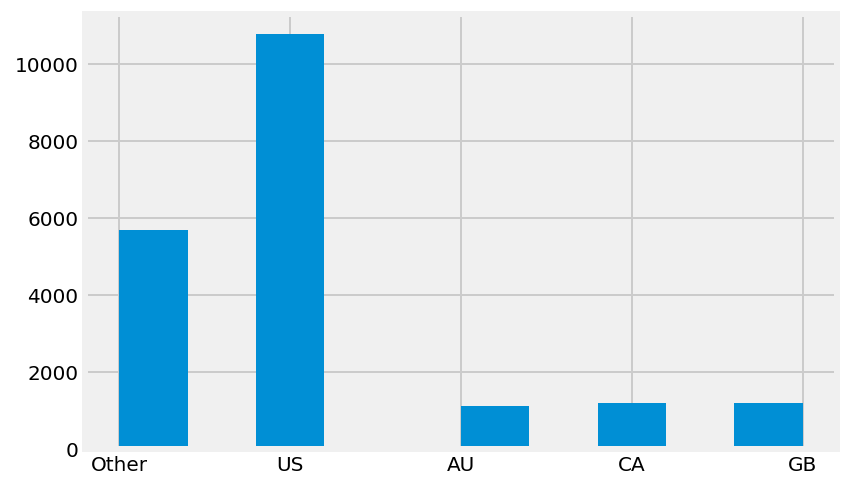

In [55]:
# Have a look at 'country_02'


capst04_equal_Targ_Des_Tercile['country_02'].hist()

# Looks as intended

In [56]:
# Make dummies for the countries

pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']])

country_02_AU  country_02_CA  country_02_GB  country_02_Other  \
37231              0              0              0                 1   
35192              0              0              0                 1   
34535              0              0              0                 0   
41540              0              0              0                 1   
40907              0              0              0                 0   
...              ...            ...            ...               ...   
15348              0              0              0                 1   
32242              0              0              0                 1   
10849              0              0              0                 0   
22034              0              0              0                 1   
17353              0              0              0                 0   

       country_02_US  
37231              0  
35192              0  
34535              1  
41540              0  
40907              1  
...              ...  
15348              0  
32242              0  
10849              1  
22034              0  
17353              1  

[19923 rows x 5 columns]

In [57]:
# Ingredients for the Feature columns:

#     Subset of 26 questions        capst04_equal_Targ_Des_Tercile[twentysix_qs]
#     dummies of top 4 countries          pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']])
#     dummies of extreme answers    pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]


# Ingredients for the target column:

#     capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile']
#     




In [58]:
# X = 

pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1)

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q22_string_1  \
37231   3   5   4   1   2   2   2   4   4    4  ...             0   
35192   1   5   5   2   4   2   4   5   5    5  ...             0   
34535   1   5   5   5   1   1   5   1   5    5  ...             1   
41540   2   2   4   4   4   4   3   4   4    4  ...             0   
40907   3   1   4   5   1   4   2   3   3    4  ...             0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...           ...   
15348   2   2   3   2   3   4   3   4   4    5  ...             1   
32242   2   4   4   4   4   3   4   4   3    2  ...             0   
10849   5   1   5   4   2   5   5   5   5    5  ...             1   
22034   3   1   4   4   4   1   4   1   1    3  ...             0   
17353   3   5   2   4   5   1   3   3   3    3  ...             0   

       Q22_string_5  Q23_string_1  Q23_string_5  Q24_string_1  Q24_string_5  \
37231             0             0             1             0             0   
35192             0             0             1             0             0   
34535             0             1             0             0             0   
41540             0             0             0             0             0   
40907             0             0             1             0             1   
...             ...           ...           ...           ...           ...   
15348             0             0             0             1             0   
32242             0             0             0             0             0   
10849             0             0             1             0             1   
22034             0             0             0             0             0   
17353             0             0             0             0             0   

       Q25_string_1  Q25_string_5  Q26_string_1  Q26_string_5  
37231             0             0             0             0  
35192             0             1             1             0  
34535             0             1             1             0  
41540             0             0             0             0  
40907             0             0             1             0  
...             ...           ...           ...           ...  
15348             0             0             0             0  
32242             0             0             0             0  
10849             0             0             1             0  
22034             0             0             1             0  
17353             0             0             0             0  

[19923 rows x 83 columns]

In [59]:
# y = 

capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile']

37231   -0.0
35192   -0.0
34535   -0.0
41540   -0.0
40907   -0.0
        ... 
15348    2.0
32242    2.0
10849    2.0
22034    2.0
17353    2.0
Name: Targ_Des_Tercile, Length: 19923, dtype: float64

In [60]:
capst04_equal_Targ_Des_Tercile_X_train, capst04_equal_Targ_Des_Tercile_X_test, capst04_equal_Targ_Des_Tercile_y_train, capst04_equal_Targ_Des_Tercile_y_test = train_test_split(
                                                                                                                                                                                capst04_equal_Targ_Des_Tercile[twentysix_qs], 
                                                                                                                                                                                capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'], 
                                                                                                                                                                                test_size=phi_2, random_state=round(100*phi_0))

display(
    capst04_equal_Targ_Des_Tercile_X_train, 
    capst04_equal_Targ_Des_Tercile_X_test, 
    capst04_equal_Targ_Des_Tercile_y_train, 
    capst04_equal_Targ_Des_Tercile_y_test
    )

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q17  Q18  Q19  Q20  Q21  \
294     1   2   4   3   2   2   4   4   2    4  ...    1    2    4    2    3   
754     5   4   5   5   1   1   5   5   5    4  ...    3    3    2    3    2   
41653   4   5   4   4   1   5   4   4   2    1  ...    2    2    4    5    1   
26840   1   5   4   3   2   3   4   5   5    5  ...    1    2    4    5    1   
14903   4   1   3   1   1   4   4   5   5    5  ...    1    5    4    4    1   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
41408   4   3   5   4   2   5   4   4   3    5  ...    1    2    3    3    3   
21993   5   1   5   5   2   2   5   5   4    4  ...    2    4    4    2    4   
10447   1   1   4   3   3   1   4   5   4    4  ...    2    3    3    3    2   
28844   1   5   3   5   3   3   3   5   3    3  ...    1    5    5    3    2   
39620   1   1   2   1   5   1   4   4   4    1  ...    2    5    4    4    5   

       Q22  Q23  Q24  Q25  Q26  
294      2    4    1    4    4  
754      3    4    4    2    2  
41653    3    5    5    4    4  
26840    5    5    2    3    1  
14903    1    4    4    1    1  
...    ...  ...  ...  ...  ...  
41408    1    5    4    4    2  
21993    2    5    5    2    1  
10447    4    5    4    5    1  
28844    1    4    5    3    1  
39620    5    3    1    5    5  

[12313 rows x 26 columns]

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q17  Q18  Q19  Q20  Q21  \
12520   3   1   1   1   5   3   3   2   2    1  ...    1    1    3    1    5   
40731   1   1   1   5   5   5   4   5   4    5  ...    1    1    5    3    4   
26100   5   2   4   5   2   3   4   5   5    5  ...    2    4    4    2    1   
19395   4   2   5   4   5   5   5   5   4    5  ...    1    1    2    4    4   
10509   1   1   1   1   4   2   1   1   2    1  ...    3    3    2    2    3   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
15212   3   5   4   5   1   2   4   4   4    5  ...    1    4    4    1    3   
40755   4   5   4   2   4   4   5   4   4    4  ...    1    1    5    4    4   
25083   2   5   5   2   5   4   5   5   5    5  ...    1    3    5    5    1   
1450    1   2   4   3   3   1   3   4   4    4  ...    2    2    1    4    4   
8939    2   5   2   1   5   3   4   4   5    3  ...    1    2    2    4    1   

       Q22  Q23  Q24  Q25  Q26  
12520    5    3    3    3    1  
40731    1    2    4    5    5  
26100    5    5    4    3    3  
19395    2    5    2    2    1  
10509    3    3    2    1    1  
...    ...  ...  ...  ...  ...  
15212    4    4    4    4    1  
40755    3    5    4    5    1  
25083    3    5    5    2    4  
1450     1    5    2    4    3  
8939     4    4    1    3    1  

[7610 rows x 26 columns]

294     -0.0
754     -0.0
41653    1.0
26840    2.0
14903    1.0
        ... 
41408    2.0
21993   -0.0
10447    1.0
28844    1.0
39620   -0.0
Name: Targ_Des_Tercile, Length: 12313, dtype: float64

12520    2.0
40731    1.0
26100    2.0
19395    2.0
10509    1.0
        ... 
15212   -0.0
40755    2.0
25083   -0.0
1450     2.0
8939     2.0
Name: Targ_Des_Tercile, Length: 7610, dtype: float64

<AxesSubplot:>

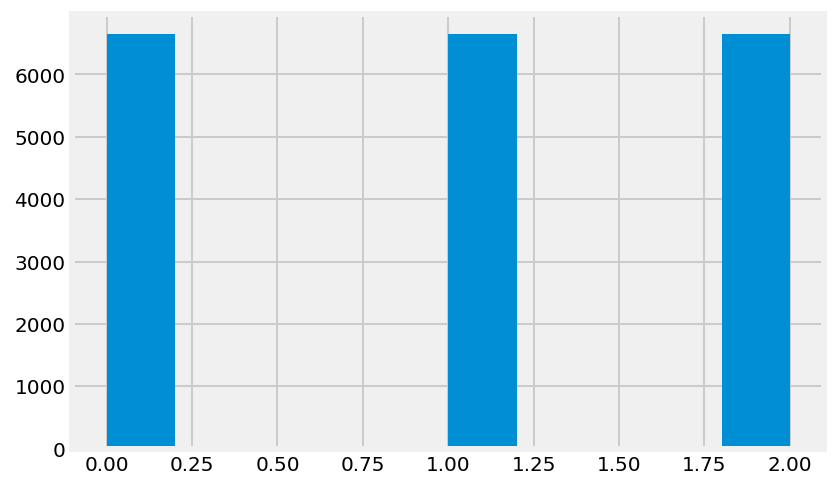

In [61]:
capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'].hist()

In [62]:
capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'].value_counts()

-0.0    6641
 1.0    6641
 2.0    6641
Name: Targ_Des_Tercile, dtype: int64

GB    2515
CA    2372
AU    2084
Name: country, dtype: int64

<AxesSubplot:>

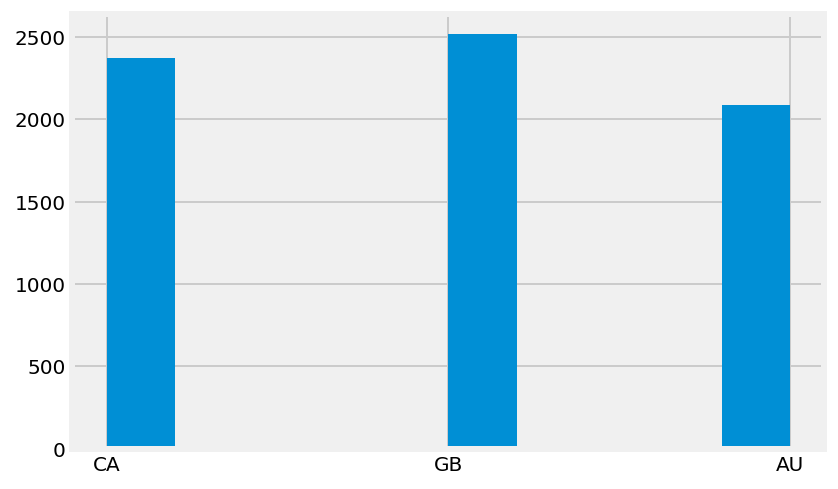

In [63]:
capst06_three_countries = capst02.copy()
capst06_three_countries = capst06_three_countries[capst06_three_countries['country'].isin(three_countries)]

display(
    capst06_three_countries['country'].value_counts(),
    capst06_three_countries['country'].hist()
    )

In [64]:
display(
    capst02['Targ_Des_Tercile'],
    capst02['Targ_Des_Tercile'].unique()
    )

0        2.0
1       -0.0
3       -0.0
4       -0.0
5       -0.0
        ... 
41836   -0.0
41837    1.0
41838    1.0
41839   -0.0
41840    1.0
Name: Targ_Des_Tercile, Length: 40398, dtype: float64

array([ 2., -0.,  1., nan])

In [65]:
targ_cols = ['birthpos','birthn','Targ_Con_BirthPosPercent','Targ_Des_Tercile','Targ_Des_IsOnly']
targ_cols

['birthpos',
 'birthn',
 'Targ_Con_BirthPosPercent',
 'Targ_Des_Tercile',
 'Targ_Des_IsOnly']

In [66]:
capst02[targ_cols][60:120]

birthpos  birthn  Targ_Con_BirthPosPercent  Targ_Des_Tercile  \
62          2       2                  1.000000               2.0   
63          1       1                       NaN               NaN   
64          1       1                       NaN               NaN   
65          2       4                  0.333333               1.0   
66          1       4                  0.000000              -0.0   
67         10      10                  1.000000               2.0   
68          1       7                  0.000000              -0.0   
69          1       2                  0.000000              -0.0   
70          1       2                  0.000000              -0.0   
71          1       3                  0.000000              -0.0   
72          1       2                  0.000000              -0.0   
73          1       2                  0.000000              -0.0   
74          1       1                       NaN               NaN   
75          5       6                  0.800000               2.0   
76          4       4                  1.000000               2.0   
77          1       1                       NaN               NaN   
78          3       3                  1.000000               2.0   
79          1       2                  0.000000              -0.0   
80          2       3                  0.500000               1.0   
81          1       2                  0.000000              -0.0   
82          1       2                  0.000000              -0.0   
83          1       4                  0.000000              -0.0   
84          1       1                       NaN               NaN   
85          3       4                  0.666667               1.0   
86          1       3                  0.000000              -0.0   
87          1       1                       NaN               NaN   
88          2       2                  1.000000               2.0   
89          3       5                  0.500000               1.0   
91          3       5                  0.500000               1.0   
92          1       2                  0.000000              -0.0   
93          2       3                  0.500000               1.0   
94          1       1                       NaN               NaN   
95          1       2                  0.000000              -0.0   
96          1       2                  0.000000              -0.0   
97          3       3                  1.000000               2.0   
98          3       3                  1.000000               2.0   
99          1       1                       NaN               NaN   
100         1       3                  0.000000              -0.0   
101         1       2                  0.000000              -0.0   
102         1       2                  0.000000              -0.0   
103         2       2                  1.000000               2.0   
104         2       2                  1.000000               2.0   
105         1       3                  0.000000              -0.0   
106         3       3                  1.000000               2.0   
107         2       3                  0.500000               1.0   
109         2       2                  1.000000               2.0   
110         1       6                  0.000000              -0.0   
111         1       2                  0.000000              -0.0   
112         1       2                  0.000000              -0.0   
113         4       4                  1.000000               2.0   
114         1       3                  0.000000              -0.0   
115         2       3                  0.500000               1.0   
116         2       2                  1.000000               2.0   
117         5       6                  0.800000               2.0   
118         1       3                  0.000000              -0.0   
119         2       3                  0.500000               1.0   
120         1       1                       NaN               NaN   
121

In [67]:
# Need to convert the integers of the terciles into strings


# Write a dictionary to rename the numbers
tercile_dict = {0 : "Oldest_Tercile", -0 : "Oldest_Tercile", 1: "Middle_Tercile", 2: "Youngest_Tercile"}

# Create a copy of the columns with terciles
capst02['Four_way_Target'] = capst02['Targ_Des_Tercile']

# Apply the dictionary
capst02['Four_way_Target'] = capst02['Four_way_Target'].map(tercile_dict)

# We know the nulls are the only-children becuase the system was dividing by zero
capst02['Four_way_Target'] = capst02['Four_way_Target'].fillna("Only_Child")

# capst02['Targ_Des_Tercile_02'].isnull().sum()

targ_cols.append('Four_way_Target')

capst02['Four_way_Target'].value_counts()





Oldest_Tercile      16045
Youngest_Tercile    12973
Middle_Tercile       6641
Only_Child           4739
Name: Four_way_Target, dtype: int64

<AxesSubplot:>

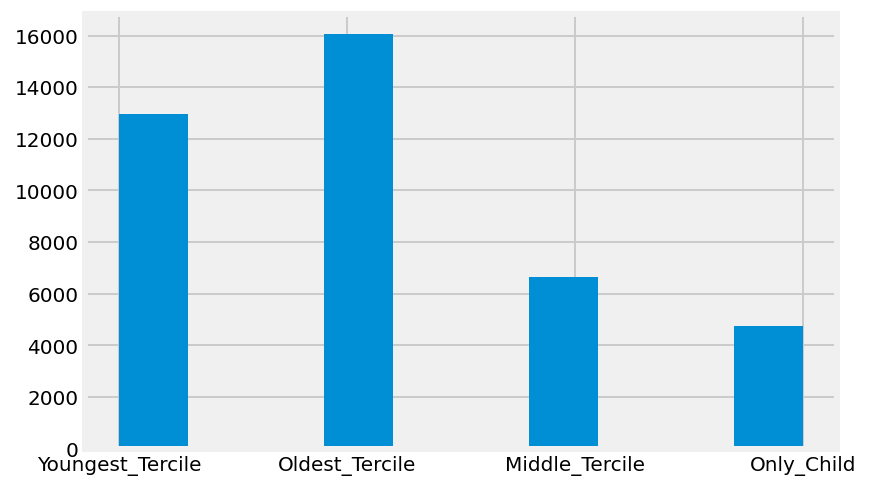

In [68]:
capst02['Four_way_Target'].hist()

In [69]:
# List of the four different classes

list(set(list(capst02['Four_way_Target'])))

['Middle_Tercile', 'Only_Child', 'Oldest_Tercile', 'Youngest_Tercile']

<AxesSubplot:>

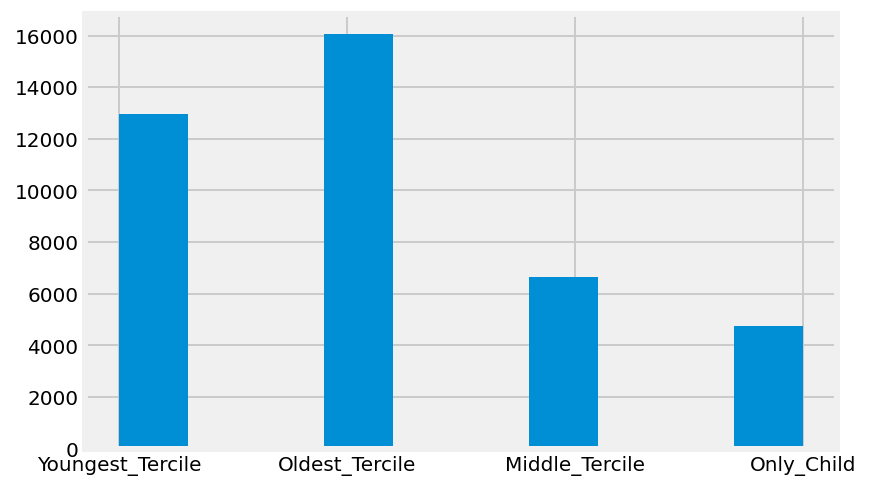

In [70]:
capst02['Four_way_Target'].hist()

# This calls for upsampling or downsampling

In [71]:
def get_dummied_ans(df):
    '''
    Returns a list of all the column-names that have _string_ in it
    '''
    list_ = list(df.columns)
    return [x for x in list_ if '_string_' in x]

In [72]:
###### Add the dummies of the answers


# capst02
# pd.get_dummies(capst02[twentysix_qs_string])

capst02 = pd.concat([capst02,pd.get_dummies(capst02[twentysix_qs_string])], axis = 1)

twentysix_qs_dummied = get_dummied_ans(capst02)

# Create a filter that only has _string_

#     This is the list

# twentysix_qs + twentysix_qs_string + list(pd.get_dummies(capst02[twentysix_qs_string]).columns)

# get_dummied_ans(twentysix_qs + twentysix_qs_string + list(pd.get_dummies(capst02[twentysix_qs_string]).columns))


In [73]:
# Add the dummies for the column: 'Four_way_Target' for use with the caluculating highest chi2 and highest f_classif

# Make a list for easier recall

# Four_way_Target_dummied = list(pd.get_dummies(capst02['Four_way_Target'], prefix= 'Four_way_Target').columns)

# This got moved to the top


In [74]:
# Add the dummies for the column: 'Four_way_Target' for use with the caluculating highest chi2 and highest f_classif


# pd.get_dummies(capst02['Four_way_Target'], prefix= 'Four_way_Target')

capst02 = pd.concat([capst02,pd.get_dummies(capst02['Four_way_Target'], prefix= 'Four_way_Target')], axis = 1)

capst02

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q26_string_0  \
0       4   4   4   5   5   4   3   4   4    5  ...             0   
1       5   5   5   4   2   5   5   5   5    5  ...             0   
3       2   1   3   2   4   3   3   3   3    5  ...             0   
4       2   1   4   5   2   5   4   4   2    5  ...             0   
5       5   1   1   3   2   2   4   3   3    5  ...             0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...           ...   
41836   2   5   4   4   2   2   3   3   2    4  ...             0   
41837   2   2   1   1   4   2   2   3   4    4  ...             0   
41838   4   1   4   1   5   5   3   3   4    5  ...             0   
41839   5   5   4   4   2   2   2   4   4    5  ...             0   
41840   3   1   5   3   1   5   5   5   5    5  ...             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  \
0                 1             0             0             0             0   
1                 0             0             1             0             0   
3                 0             0             0             1             0   
4                 1             0             0             0             0   
5                 1             0             0             0             0   
...             ...           ...           ...           ...           ...   
41836             0             0             1             0             0   
41837             0             1             0             0             0   
41838             0             0             0             1             0   
41839             0             0             0             1             0   
41840             0             0             0             0             1   

       Four_way_Target_Middle_Tercile  Four_way_Target_Oldest_Tercile  \
0                                   0                               0   
1                                   0                               1   
3                                   0                               1   
4                                   0                               1   
5                                   0                               1   
...                               ...                             ...   
41836                               0                               1   
41837                               1                               0   
41838                               1                               0   
41839                               0                               1   
41840                               1                               0   

       Four_way_Target_Only_Child  Four_way_Target_Youngest_Tercile  
0                               0                                 1  
1                               0                                 0  
3                               0                                 0  
4                               0                                 0  
5                               0                                 0  
...                           ...                               ...  
41836                           0                                 0  
41837                           0                                 0  
41838                           0                                 0  
41839                           0                                 0  
41840                           0                                 0  

[40398 rows x 285 columns]

In [75]:
# Check the X and y before spliting

display(
    capst02[twentysix_qs + twentysix_qs_string],
    capst02['Four_way_Target']
)

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q17_string  Q18_string  \
0       4   4   4   5   5   4   3   4   4    5  ...           1           5   
1       5   5   5   4   2   5   5   5   5    5  ...           3           3   
3       2   1   3   2   4   3   3   3   3    5  ...           1           1   
4       2   1   4   5   2   5   4   4   2    5  ...           1           5   
5       5   1   1   3   2   2   4   3   3    5  ...           1           2   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...         ...         ...   
41836   2   5   4   4   2   2   3   3   2    4  ...           2           3   
41837   2   2   1   1   4   2   2   3   4    4  ...           2           5   
41838   4   1   4   1   5   5   3   3   4    5  ...           1           4   
41839   5   5   4   4   2   2   2   4   4    5  ...           1           4   
41840   3   1   5   3   1   5   5   5   5    5  ...           5           5   

       Q19_string  Q20_string  Q21_string  Q22_string  Q23_string  Q24_string  \
0               1           2           1           5           3           1   
1               2           3           1           2           5           4   
3               3           2           3           4           3           2   
4               5           5           4           4           4           4   
5               5           1           2           3           5           2   
...           ...         ...         ...         ...         ...         ...   
41836           4           3           2           4           5           5   
41837           4           2           4           4           4           2   
41838           1           3           1           5           4           1   
41839           3           2           1           4           4           3   
41840           5           1           4           1           4           1   

       Q25_string  Q26_string  
0               4           1  
1               2           3  
3               4           4  
4               2           1  
5               4           1  
...           ...         ...  
41836           3           3  
41837           4           2  
41838           4           4  
41839           3           4  
41840           4           5  

[40398 rows x 52 columns]

0        Youngest_Tercile
1          Oldest_Tercile
3          Oldest_Tercile
4          Oldest_Tercile
5          Oldest_Tercile
               ...       
41836      Oldest_Tercile
41837      Middle_Tercile
41838      Middle_Tercile
41839      Oldest_Tercile
41840      Middle_Tercile
Name: Four_way_Target, Length: 40398, dtype: object

In [76]:


# display(
#     capst02_X_train, 
#     capst02_X_test, 
#     capst02_y_train, 
#     capst02_y_test
# )



In [77]:


#     X = capst02[twentysix_qs + twentysix_qs_string]
#     y = capst02['Four_way_Target']

capst02_X_train, capst02_X_test, capst02_y_train, capst02_y_test = train_test_split(capst02[twentysix_qs + twentysix_qs_string], capst02['Four_way_Target'], test_size=phi_2, random_state=161, stratify = capst02['Four_way_Target'])


# Next step: Need to UPsample both the capst02_X_train and capst02_y_train

capst02_train_DF = pd.concat([capst02_X_train,capst02_y_train], axis = 1)

# The four different DataFrames before UPsampling

# capst02_train_DF['Four_way_Target'].value_counts()
#     Oldest_Tercile      9814
#     Youngest_Tercile    8099
#     Middle_Tercile      4131
#     Only_Child          2923
#     Name: Four_way_Target, dtype: int64

# The largest class is Oldest_Tercile with a count of 9814
#     Therefore we will upsample to 9814


# UPsample then Concat all four dataframes
#     pd.concat([,,,],axis = 0)

capst02_train_DF_02 = pd.concat([capst02_train_DF[capst02_train_DF['Four_way_Target'] == 'Oldest_Tercile'],
resample(capst02_train_DF[capst02_train_DF['Four_way_Target'] == 'Youngest_Tercile'], replace=True, n_samples=9814, random_state=161),
resample(capst02_train_DF[capst02_train_DF['Four_way_Target'] == 'Middle_Tercile'], replace=True, n_samples=9814, random_state=161),
resample(capst02_train_DF[capst02_train_DF['Four_way_Target'] == 'Only_Child'], replace=True, n_samples=9814, random_state=161)],axis = 0)




# Revalue capst02_X_train
# Revalue capst02_y_train

# for col in capst02_train_DF_02.columns:
#     if col != 'Four_way_Target':
#         print(col)
        
capst02_X_train = capst02_train_DF_02[[col for col in capst02_train_DF_02.columns if col != 'Four_way_Target']]
capst02_y_train = capst02_train_DF_02['Four_way_Target']


display(
    capst02_X_train, 
    capst02_X_test, 
    capst02_y_train, 
    capst02_y_test
)


Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q17_string  Q18_string  \
14445   2   4   5   5   1   4   3   3   2    5  ...           1           1   
41662   2   5   5   1   4   5   2   3   1    4  ...           1           3   
28011   5   1   5   2   2   5   4   4   5    5  ...           2           5   
6724    1   1   2   4   3   2   3   4   3    4  ...           1           3   
34916   2   3   4   5   2   4   4   4   5    5  ...           1           5   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...         ...         ...   
37432   2   1   3   4   2   5   2   3   2    4  ...           4           5   
19528   2   4   5   5   1   3   2   4   4    5  ...           1           4   
23232   2   5   4   4   4   3   4   4   4    2  ...           3           3   
11287   2   2   2   4   2   4   4   3   4    4  ...           2           2   
25097   2   5   4   4   2   3   4   3   4    4  ...           1           2   

       Q19_string  Q20_string  Q21_string  Q22_string  Q23_string  Q24_string  \
14445           4           2           4           4           2           1   
41662           4           4           2           1           4           3   
28011           1           2           1           5           4           1   
6724            3           3           4           2           5           1   
34916           2           5           1           3           5           4   
...           ...         ...         ...         ...         ...         ...   
37432           2           3           3           2           4           4   
19528           2           5           1           4           5           5   
23232           4           5           2           2           5           4   
11287           2           2           5           2           3           2   
25097           4           2           2           2           4           2   

       Q25_string  Q26_string  
14445           1           5  
41662           3           1  
28011           4           1  
6724            5           5  
34916           1           3  
...           ...         ...  
37432           1           5  
19528           2           2  
23232           4           4  
11287           4           4  
25097           4           4  

[39358 rows x 52 columns]

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q17_string  Q18_string  \
35697   5   5   4   4   1   2   5   5   5    5  ...           1           2   
13295   5   1   5   5   4   2   5   5   5    5  ...           3           5   
1810    1   1   2   1   5   2   2   2   1    4  ...           1           3   
19047   2   5   4   4   2   2   2   2   2    4  ...           1           4   
24111   5   3   5   3   3   4   2   3   5    5  ...           1           2   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...         ...         ...   
37214   5   1   4   3   5   5   2   4   4    5  ...           1           5   
2782    3   1   3   3   5   2   1   1   3    5  ...           1           3   
9102    4   1   4   4   4   3   4   4   4    4  ...           2           4   
36766   4   4   4   3   2   3   3   4   4    4  ...           3           3   
4978    5   5   2   3   2   5   4   4   5    5  ...           3           5   

       Q19_string  Q20_string  Q21_string  Q22_string  Q23_string  Q24_string  \
35697           4           2           2           2           5           2   
13295           5           1           2           3           2           2   
1810            1           5           1           2           3           4   
19047           4           3           2           2           4           4   
24111           1           1           1           1           5           5   
...           ...         ...         ...         ...         ...         ...   
37214           4           1           5           3           3           1   
2782            4           3           1           4           4           3   
9102            4           3           1           5           2           2   
36766           3           3           2           4           4           2   
4978            5           1           1           1           5           4   

       Q25_string  Q26_string  
35697           4           5  
13295           5           2  
1810            4           1  
19047           4           4  
24111           5           1  
...           ...         ...  
37214           3           5  
2782            5           1  
9102            5           4  
36766           4           2  
4978            4           3  

[15431 rows x 52 columns]

14445    Oldest_Tercile
41662    Oldest_Tercile
28011    Oldest_Tercile
6724     Oldest_Tercile
34916    Oldest_Tercile
              ...      
37432        Only_Child
19528        Only_Child
23232        Only_Child
11287        Only_Child
25097        Only_Child
Name: Four_way_Target, Length: 39358, dtype: object

35697      Oldest_Tercile
13295      Oldest_Tercile
1810       Middle_Tercile
19047      Middle_Tercile
24111      Oldest_Tercile
               ...       
37214    Youngest_Tercile
2782       Oldest_Tercile
9102       Oldest_Tercile
36766      Middle_Tercile
4978       Oldest_Tercile
Name: Four_way_Target, Length: 15431, dtype: object

In [78]:
# capst02['birthn'].hist()

# capst02['birthn'].value_counts()

In [79]:
# Second time having a good look at the Target Columns

# capst02[targ_cols][120:180]

In [80]:
# ['Middle_Tercile', 'Youngest_Tercile', 'Only_Child', 'Oldest_Tercile']

# Write the formulas for the different upsamples

# Need to do this AFTER the train_test_split

display(
capst02[capst02['Four_way_Target'] == 'Oldest_Tercile'],
resample(capst02[capst02['Four_way_Target'] == 'Middle_Tercile'], replace=True, n_samples=16045, random_state=161),
resample(capst02[capst02['Four_way_Target'] == 'Youngest_Tercile'], replace=True, n_samples=16045, random_state=161),
resample(capst02[capst02['Four_way_Target'] == 'Only_Child'], replace=True, n_samples=16045, random_state=161),
    capst02[capst02['Four_way_Target'] == 'Oldest_Tercile'].shape,
    resample(capst02[capst02['Four_way_Target'] == 'Middle_Tercile'], replace=True, n_samples=16045, random_state=161).shape,
    resample(capst02[capst02['Four_way_Target'] == 'Youngest_Tercile'], replace=True, n_samples=16045, random_state=161).shape,
    resample(capst02[capst02['Four_way_Target'] == 'Only_Child'], replace=True, n_samples=16045, random_state=161).shape
)

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q26_string_0  \
1       5   5   5   4   2   5   5   5   5    5  ...             0   
3       2   1   3   2   4   3   3   3   3    5  ...             0   
4       2   1   4   5   2   5   4   4   2    5  ...             0   
5       5   1   1   3   2   2   4   3   3    5  ...             0   
6       2   2   3   5   3   2   4   4   5    5  ...             0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...           ...   
41830   2   4   4   4   4   3   4   4   4    3  ...             0   
41834   2   5   4   4   2   3   2   4   5    5  ...             0   
41835   5   5   5   3   3   3   4   4   5    5  ...             0   
41836   2   5   4   4   2   2   3   3   2    4  ...             0   
41839   5   5   4   4   2   2   2   4   4    5  ...             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  \
1                 0             0             1             0             0   
3                 0             0             0             1             0   
4                 1             0             0             0             0   
5                 1             0             0             0             0   
6                 0             0             0             0             1   
...             ...           ...           ...           ...           ...   
41830             0             1             0             0             0   
41834             1             0             0             0             0   
41835             1             0             0             0             0   
41836             0             0             1             0             0   
41839             0             0             0             1             0   

       Four_way_Target_Middle_Tercile  Four_way_Target_Oldest_Tercile  \
1                                   0                               1   
3                                   0                               1   
4                                   0                               1   
5                                   0                               1   
6                                   0                               1   
...                               ...                             ...   
41830                               0                               1   
41834                               0                               1   
41835                               0                               1   
41836                               0                               1   
41839                               0                               1   

       Four_way_Target_Only_Child  Four_way_Target_Youngest_Tercile  
1                               0                                 0  
3                               0                                 0  
4                               0                                 0  
5                               0                                 0  
6                               0                                 0  
...                           ...                               ...  
41830                           0                                 0  
41834                           0                                 0  
41835                           0                                 0  
41836                           0                                 0  
41839                           0                                 0  

[16045 rows x 285 columns]

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q26_string_0  \
31358   4   5   5   2   2   3   4   4   5    5  ...             0   
12579   4   2   4   4   4   3   4   4   5    5  ...             0   
10269   5   5   5   1   4   3   3   4   4    4  ...             1   
21468   1   4   3   3   4   2   4   4   4    4  ...             0   
29799   1   4   2   5   4   1   4   4   3    3  ...             0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...           ...   
893     1   1   2   4   4   5   2   3   3    1  ...             0   
10624   5   5   5   4   1   1   4   5   5    5  ...             0   
4541    1   1   1   1   3   1   3   4   2    3  ...             0   
31782   4   3   3   3   3   3   1   4   1    3  ...             0   
32327   3   2   4   4   4   2   4   4   4    4  ...             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  \
31358             1             0             0             0             0   
12579             0             0             0             1             0   
10269             0             0             0             0             0   
21468             0             0             0             1             0   
29799             1             0             0             0             0   
...             ...           ...           ...           ...           ...   
893               1             0             0             0             0   
10624             1             0             0             0             0   
4541              1             0             0             0             0   
31782             0             0             0             1             0   
32327             0             0             0             1             0   

       Four_way_Target_Middle_Tercile  Four_way_Target_Oldest_Tercile  \
31358                               1                               0   
12579                               1                               0   
10269                               1                               0   
21468                               1                               0   
29799                               1                               0   
...                               ...                             ...   
893                                 1                               0   
10624                               1                               0   
4541                                1                               0   
31782                               1                               0   
32327                               1                               0   

       Four_way_Target_Only_Child  Four_way_Target_Youngest_Tercile  
31358                           0                                 0  
12579                           0                                 0  
10269                           0                                 0  
21468                           0                                 0  
29799                           0                                 0  
...                           ...                               ...  
893                             0                                 0  
10624                           0                                 0  
4541                            0                                 0  
31782                           0                                 0  
32327                           0                                 0  

[16045 rows x 285 columns]

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q26_string_0  \
6729    5   1   5   2   5   5   5   5   5    5  ...             0   
5505    3   3   4   3   1   2   4   4   3    3  ...             0   
37487   4   1   5   1   3   5   2   3   4    3  ...             0   
15322   4   1   5   1   4   5   3   5   5    4  ...             0   
17565   1   1   4   3   3   1   2   3   2    4  ...             0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...           ...   
19536   2   2   3   3   3   2   3   3   3    2  ...             0   
33798   2   4   3   5   4   5   2   3   3    2  ...             0   
26263   2   1   4   3   4   1   4   4   3    3  ...             0   
5589    1   1   4   5   5   1   5   5   5    3  ...             0   
38845   3   4   4   2   4   4   2   3   2    4  ...             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  \
6729              1             0             0             0             0   
5505              0             0             0             0             1   
37487             1             0             0             0             0   
15322             0             0             0             1             0   
17565             0             0             0             0             1   
...             ...           ...           ...           ...           ...   
19536             0             1             0             0             0   
33798             0             0             0             1             0   
26263             1             0             0             0             0   
5589              0             0             0             0             1   
38845             0             0             0             1             0   

       Four_way_Target_Middle_Tercile  Four_way_Target_Oldest_Tercile  \
6729                                0                               0   
5505                                0                               0   
37487                               0                               0   
15322                               0                               0   
17565                               0                               0   
...                               ...                             ...   
19536                               0                               0   
33798                               0                               0   
26263                               0                               0   
5589                                0                               0   
38845                               0                               0   

       Four_way_Target_Only_Child  Four_way_Target_Youngest_Tercile  
6729                            0                                 1  
5505                            0                                 1  
37487                           0                                 1  
15322                           0                                 1  
17565                           0                                 1  
...                           ...                               ...  
19536                           0                                 1  
33798                           0                                 1  
26263                           0                                 1  
5589                            0                                 1  
38845                           0                                 1  

[16045 rows x 285 columns]

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q26_string_0  \
18916   1   2   3   4   4   3   3   3   4    4  ...             0   
16194   2   1   4   4   2   3   2   3   4    4  ...             0   
30609   4   1   4   4   1   2   4   4   2    5  ...             0   
12286   1   1   1   4   4   2   1   3   5    4  ...             0   
18656   4   5   4   5   2   3   4   4   5    5  ...             0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...           ...   
36162   2   1   5   2   2   3   4   4   4    2  ...             0   
617     1   1   1   2   2   2   3   3   2    3  ...             0   
20606   4   1   4   2   4   3   3   4   4    5  ...             0   
10402   2   1   3   1   5   2   1   2   2    3  ...             0   
20645   2   1   4   5   2   2   3   3   3    5  ...             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  \
18916             0             0             0             1             0   
16194             0             0             0             0             1   
30609             0             0             0             0             1   
12286             1             0             0             0             0   
18656             0             0             0             0             1   
...             ...           ...           ...           ...           ...   
36162             0             0             0             1             0   
617               0             1             0             0             0   
20606             1             0             0             0             0   
10402             1             0             0             0             0   
20645             0             0             1             0             0   

       Four_way_Target_Middle_Tercile  Four_way_Target_Oldest_Tercile  \
18916                               0                               0   
16194                               0                               0   
30609                               0                               0   
12286                               0                               0   
18656                               0                               0   
...                               ...                             ...   
36162                               0                               0   
617                                 0                               0   
20606                               0                               0   
10402                               0                               0   
20645                               0                               0   

       Four_way_Target_Only_Child  Four_way_Target_Youngest_Tercile  
18916                           1                                 0  
16194                           1                                 0  
30609                           1                                 0  
12286                           1                                 0  
18656                           1                                 0  
...                           ...                               ...  
36162                           1                                 0  
617                             1                                 0  
20606                           1                                 0  
10402                           1                                 0  
20645                           1                                 0  

[16045 rows x 285 columns]

(16045, 285)

(16045, 285)

(16045, 285)

(16045, 285)

Oldest_Tercile      16045
Middle_Tercile      16045
Youngest_Tercile    16045
Only_Child          16045
Name: Four_way_Target, dtype: int64

<AxesSubplot:>

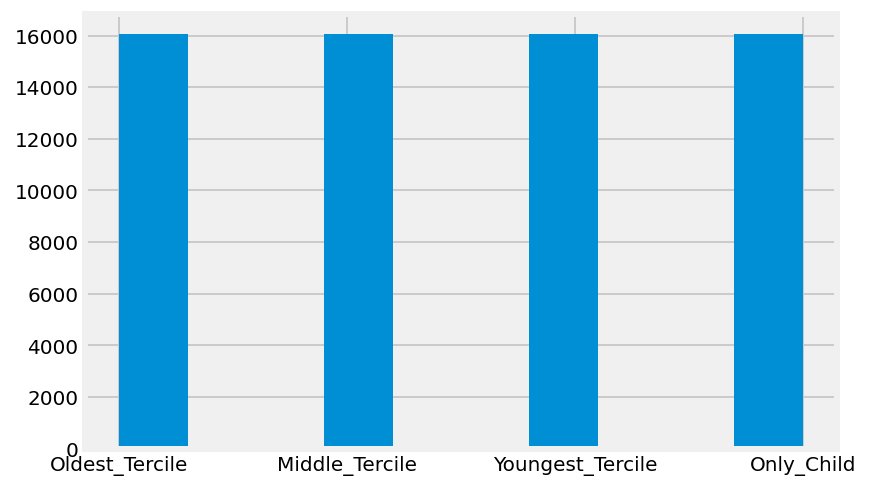

In [81]:
# Put them all togerther into a big DataFrame

# pd.concat([,,,], axis = 0)
# capst07_Four_way_Target

capst07_Four_way_Target = pd.concat([capst02[capst02['Four_way_Target'] == 'Oldest_Tercile'],
resample(capst02[capst02['Four_way_Target'] == 'Middle_Tercile'], replace=True, n_samples=16045, random_state=161),
resample(capst02[capst02['Four_way_Target'] == 'Youngest_Tercile'], replace=True, n_samples=16045, random_state=161),
resample(capst02[capst02['Four_way_Target'] == 'Only_Child'], replace=True, n_samples=16045, random_state=161)], axis = 0)


display(
    capst07_Four_way_Target['Four_way_Target'].value_counts(),
    capst07_Four_way_Target['Four_way_Target'].hist()
    )

In [82]:
def base_acc(y):
    return max(y.value_counts()/len(y))

In [83]:
capst05 = capst02.copy()

for col in twentysix_qs:
    capst05[col+"_ext"] = capst05[col].replace(extreme_dict)

In [84]:
base_acc_Targ_Des_Tercile = max(capst02['Targ_Des_Tercile'].value_counts()/len(capst02['Targ_Des_Tercile']))
base_acc_Targ_Des_Tercile

0.3971731273825437

In [85]:
base_acc(capst02['Targ_Des_Tercile'])

0.3971731273825437

In [86]:
for col in targ_cols:
    print(base_acc(capst02[col]))

0.4970295559186098
0.38821228773701666
0.37972176840437644
0.3971731273825437
0.8826922124857666
0.3971731273825437


In [87]:
[base_acc(capst02[col]) for col in targ_cols]
    

[0.4970295559186098,
 0.38821228773701666,
 0.37972176840437644,
 0.3971731273825437,
 0.8826922124857666,
 0.3971731273825437]

In [88]:
# capst['birthn'].unique()
# capst['birthn'].value_counts()
capst02['birthn'].value_counts()

2     15683
3     10923
4      4943
1      4739
5      2045
6       934
7       476
8       271
11      147
9       142
10       95
Name: birthn, dtype: int64

<AxesSubplot:>

'Got mostly eldest and youngest children, middle children are underrepresented'

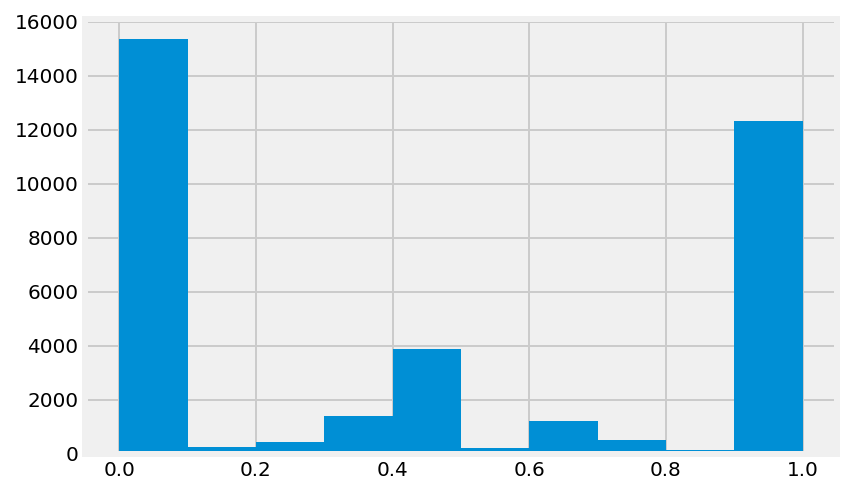

In [89]:
display(
capst02['Targ_Con_BirthPosPercent'].hist(),
    "Got mostly eldest and youngest children, middle children are underrepresented"
    )

<AxesSubplot:>

-0.0    16045
 2.0    12973
 1.0     6641
Name: Targ_Des_Tercile, dtype: int64

'Youngest/Middle/Oldest'

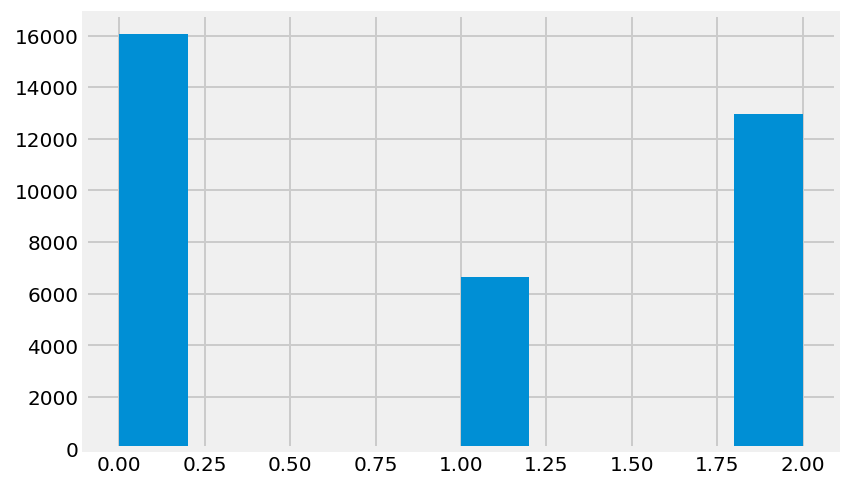

In [90]:
display(
capst02['Targ_Des_Tercile'].hist(),
    capst02['Targ_Des_Tercile'].value_counts(),
    "Youngest/Middle/Oldest"
    )


https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/

```python
from sklearn.utils import resample
ham_downsample = resample(ham_messages,
             replace=True,
             n_samples=len(spam_messages),
             random_state=42)

print(ham_downsample.shape)
```

In [301]:
# Check distribution of different responses from all the individual answers

# for x in twentysix_qs:
#     plt.figure()
#     plt.title = str(x)
#     capst02[x].hist(bins = 5, histtype = 'bar')

<AxesSubplot:>

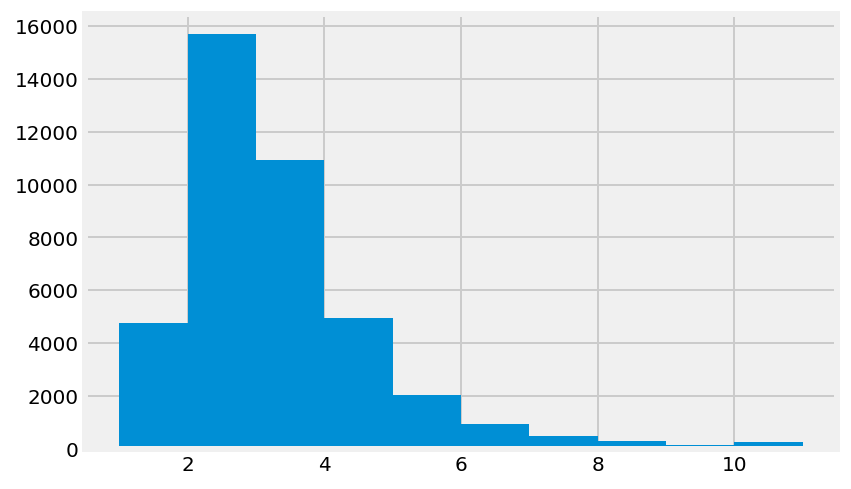

In [92]:
# Check the distribution of the Bith Numbers

capst02['birthn'].hist()


<AxesSubplot:>

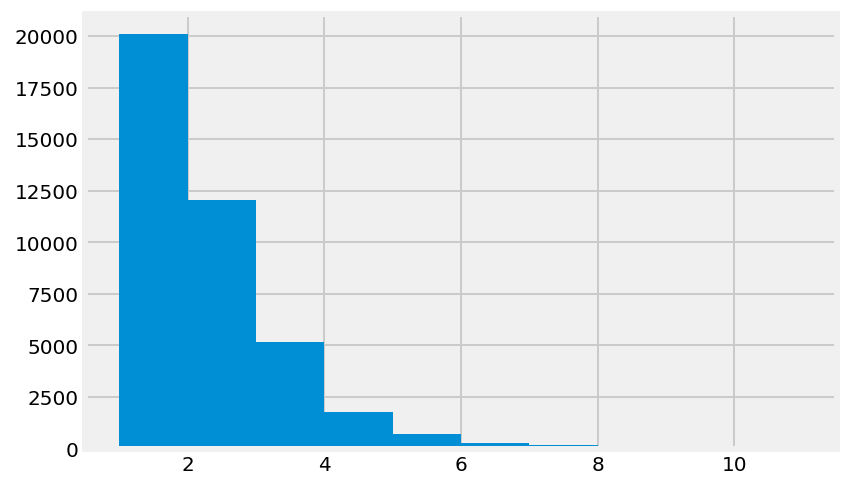

In [93]:
capst02['birthpos'].hist()

In [94]:
# capst['birthpos'].unique()
# capst['birthpos'].value_counts()
capst02['birthpos'].value_counts()

1     20079
2     12055
3      5156
4      1777
5       699
6       290
7       157
8        78
9        46
11       33
10       28
Name: birthpos, dtype: int64

In [95]:
def corr_sort(df):
    '''
    Creates an output DataFrame with correlations between all features.
    Beware of Anscombe's quartet
    
    Inspired by dsi-unit-3.11-regression-regularization-lesson
    Written by Krisdan
    '''
    import pandas as pd
    df = pd.DataFrame(df.corr().stack())
    df = df.reset_index()
    df = df.rename(columns = {0 : 'corr'})
    df = df.sort_values(by = 'corr', ascending  = False, key = abs)
    df = df[df['level_0'] != df['level_1']]
    df = df.reset_index(drop=True)
    return df

In [96]:
# def expand_question(code):
#     try: q_dict.get(code)
#     return q_dict.get(code)
#     except code

# Need help with try & except

In [97]:
df_q_corrs = corr_sort(capst02[twentysix_qs])
df_q_corrs['level_0'] = df_q_corrs['level_0'].replace(q_dict)
df_q_corrs['level_1'] = df_q_corrs['level_1'].replace(q_dict)
df_q_corrs[:60]

level_0  \
0                           I have a rich vocabulary.   
1                              I use difficult words.   
2                           I have a rich vocabulary.   
3                          I like working with words.   
4                              I use difficult words.   
5                          I like working with words.   
6                           I have a rich vocabulary.   
7                I love to read challenging material.   
8                I love to read challenging material.   
9              I have read an absurd number of books.   
10               I love to read challenging material.   
11                             I use difficult words.   
12               I love to read challenging material.   
13                         I like working with words.   
14             I have read an absurd number of books.   
15     I would rather read a book than go to a party.   
16                   I am quick to understand things.   
17                          I have a rich vocabulary.   
18                                 I follow politics.   
19                      I am interested in economics.   
20             I have read an absurd number of books.   
21                        I hate to throw away books.   
22               I love to read challenging material.   
23                        I hate to throw away books.   
24                   I am quick to understand things.   
25               I love to read challenging material.   
26                            I like science fiction.   
27                                        I am nerdy.   
28                          I have a rich vocabulary.   
29             I have read an absurd number of books.   
30               I love to read challenging material.   
31     I would rather read a book than go to a party.   
32               I love to read challenging material.   
33  I am the kind of person who might write a Wiki...   
34                             I use difficult words.   
35                   I am quick to understand things.   
36                        I hate to throw away books.   
37     I would rather read a book than go to a party.   
38                                        I am nerdy.   
39                             I use difficult words.   
40                                        I am nerdy.   
41               I love to read challenging material.   
42             I have read an absurd number of books.   
43                         I like working with words.   
44                             I try to outdo others.   
45                              I boss people around.   
46                                        I am nerdy.   
47                          I have a rich vocabulary.   
48                             I use difficult words.   
49             I have read an absurd number of books.   
50                          I have a rich vocabulary.   
51  I am the kind of person who might write a Wiki...   
52                          I have a rich vocabulary.   
53                                 I follow politics.   
54  I am the kind of person who might write a Wiki...   
55                         I like working with words.   
56                        I hate to throw away books.   
57                         I like working with words.   
58     I would rather read a book than go to a party.   
59                                        I am nerdy.   

                                              level_1      corr  
0                              I use difficult words.  0.750257  
1                           I have a rich vocabulary.  0.750257  
2                          I like working with words.  0.570156  
3                           I have a rich vocabulary.  0.570156  
4                          I like working with words.  0.523761  
5                              I use difficult words.  0.523761  
6                I love to read challenging material.  0.499712  
7                           I have a ric

In [98]:
# corr_sort(capst02)[corr_sort(capst02)['level_0'] == 'Targ_Con_BirthPosPercent']

In [99]:
capst02['country'].value_counts().head(60)

# Might want to create a bar-chart

US      21149
GB       2515
CA       2372
AU       2084
NONE      795
DE        791
MY        579
IN        502
PH        480
NZ        454
ID        405
SE        397
BR        384
FR        361
DK        353
FI        308
RO        307
NL        291
IE        288
IT        283
SG        282
PL        259
ES        233
RU        188
MX        187
TR        181
NO        167
GR        163
CN        158
PT        157
HR        151
ZA        151
CH        137
RS        135
AE        128
KR        120
AT        119
BE        111
AR        110
HU        103
JP         92
CZ         82
IL         79
BG         73
CL         72
HK         71
SI         64
UA         61
LT         59
VN         57
PK         55
EG         55
TW         54
NG         54
KE         53
LB         51
JO         45
EE         39
CR         37
PE         36
Name: country, dtype: int64

In [100]:
capst02.dtypes.value_counts()

uint8      165
int64       87
object      31
float64      2
dtype: int64

In [101]:
# Starting to Use def pca_3d(X,y):


capst02[targ_cols]



birthpos  birthn  Targ_Con_BirthPosPercent  Targ_Des_Tercile  \
0             2       2                       1.0               2.0   
1             1       3                       0.0              -0.0   
3             1       2                       0.0              -0.0   
4             1       3                       0.0              -0.0   
5             1       3                       0.0              -0.0   
...         ...     ...                       ...               ...   
41836         1       3                       0.0              -0.0   
41837         2       3                       0.5               1.0   
41838         2       3                       0.5               1.0   
41839         1       2                       0.0              -0.0   
41840         2       3                       0.5               1.0   

       Targ_Des_IsOnly   Four_way_Target  
0                    0  Youngest_Tercile  
1                    0    Oldest_Tercile  
3                    0    Oldest_Tercile  
4                    0    Oldest_Tercile  
5                    0    Oldest_Tercile  
...                ...               ...  
41836                0    Oldest_Tercile  
41837                0    Middle_Tercile  
41838                0    Middle_Tercile  
41839                0    Oldest_Tercile  
41840                0    Middle_Tercile  

[40398 rows x 6 columns]

In [102]:
capst02['Targ_Des_IsOnly'].isnull().sum()

0

In [103]:
capst02[twentysix_qs]

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q17  Q18  Q19  Q20  Q21  \
0       4   4   4   5   5   4   3   4   4    5  ...    1    5    1    2    1   
1       5   5   5   4   2   5   5   5   5    5  ...    3    3    2    3    1   
3       2   1   3   2   4   3   3   3   3    5  ...    1    1    3    2    3   
4       2   1   4   5   2   5   4   4   2    5  ...    1    5    5    5    4   
5       5   1   1   3   2   2   4   3   3    5  ...    1    2    5    1    2   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
41836   2   5   4   4   2   2   3   3   2    4  ...    2    3    4    3    2   
41837   2   2   1   1   4   2   2   3   4    4  ...    2    5    4    2    4   
41838   4   1   4   1   5   5   3   3   4    5  ...    1    4    1    3    1   
41839   5   5   4   4   2   2   2   4   4    5  ...    1    4    3    2    1   
41840   3   1   5   3   1   5   5   5   5    5  ...    5    5    5    1    4   

       Q22  Q23  Q24  Q25  Q26  
0        5    3    1    4    1  
1        2    5    4    2    3  
3        4    3    2    4    4  
4        4    4    4    2    1  
5        3    5    2    4    1  
...    ...  ...  ...  ...  ...  
41836    4    5    5    3    3  
41837    4    4    2    4    2  
41838    5    4    1    4    4  
41839    4    4    3    3    4  
41840    1    4    1    4    5  

[40398 rows x 26 columns]

In [1]:
# Hashed out to reduce filesize

# pca_3d(X= capst02[twentysix_qs],
#        y= capst02['Targ_Des_IsOnly']
#       )

In [2]:
capst02_AU = capst02[capst02['country'] == 'AU']
capst02_AU = capst02_AU[capst02_AU['Targ_Des_Tercile'].isnull() == False]
# capst02_AU


# Hashed out to reduce filesize
# pca_3d(X= capst02_AU[twentysix_qs],
#        y= capst02_AU['Targ_Des_Tercile']
#       )

NameError: name 'capst02' is not defined

In [3]:
# Hashed out to reduce filesize

# pca_3d(X= capst02[capst02['country'] == 'AU'][twentysix_qs],
#        y= capst02[capst02['country'] == 'AU']['Targ_Des_Tercile']
#       )

In [107]:
capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'].isnull().sum()

0

In [4]:
# Hashed out to reduce filesize

# pca_3d(X= capst04_equal_Targ_Des_Tercile[twentysix_qs],
#        y= capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile']
#       )

In [5]:
# Hashed out to reduce filesize

# pca_3d(X= capst02[twentysix_qs],
#        y= capst02['Targ_Con_BirthPosPercent']
#       )

# pca_3d(X= capst02[['Q1', 'Q2', 'Q3']],
#        y= capst02['Targ_Con_BirthPosPercent']
#       )

In [6]:
# Hashed out to reduce filesize

# pca_3d(X= pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1),
#        y=capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile']
#       )

In [111]:
# capst07_Four_way_Target['Four_way_Target']

# pca_3d(X= capst07_Four_way_Target[twentysix_qs],
#        y= capst07_Four_way_Target['Four_way_Target']
#       )
# ValueError: cannot reindex from a duplicate axis

In [112]:
capst02[capst02['country'].isin(three_countries) == True]['country'].unique()

array(['CA', 'GB', 'AU'], dtype=object)

In [113]:
# pca_3d(X= capst02[capst02['country'].isin(three_countries) == True][twentysix_qs],
#        y= [list(capst['country'].unique()).index(c) for c in capst['country']]
#       )

# # ValueError: could not convert string to float: '2019-04-12 11:24:14'
# KeyError: (nan, '', '')
# AttributeError: 'list' object has no attribute 'name'

In [114]:
capst02.describe()

Q1            Q2            Q3            Q4            Q5  \
count  40398.000000  40398.000000  40398.000000  40398.000000  40398.000000   
mean       2.788084      2.549978      3.574212      3.043839      3.013491   
std        1.372308      1.675767      1.245901      1.402078      1.248269   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      1.000000      3.000000      2.000000      2.000000   
50%        3.000000      2.000000      4.000000      3.000000      3.000000   
75%        4.000000      4.000000      5.000000      4.000000      4.000000   
max        5.000000      5.000000      5.000000      5.000000      5.000000   

                 Q6            Q7            Q8            Q9           Q10  \
count  40398.000000  40398.000000  40398.000000  40398.000000  40398.000000   
mean       3.065325      3.340363      3.644834      3.631368      3.939849   
std        1.383588      1.237418      1.176295      1.215950      1.255528   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      2.000000      3.000000      3.000000      3.000000   
50%        3.000000      4.000000      4.000000      4.000000      4.000000   
75%        4.000000      4.000000      5.000000      5.000000      5.000000   
max        5.000000      5.000000      5.000000      5.000000      5.000000   

       ...  Q26_string_0  Q26_string_1  Q26_string_2  Q26_string_3  \
count  ...  40398.000000  40398.000000  40398.000000  40398.000000   
mean   ...      0.010941      0.374771      0.196272      0.079286   
std    ...      0.104027      0.484070      0.397182      0.270188   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      1.000000      0.000000      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

       Q26_string_4  Q26_string_5  Four_way_Target_Middle_Tercile  \
count  40398.000000  40398.000000                    40398.000000   
mean       0.171246      0.167484                        0.164389   
std        0.376729      0.373412                        0.370633   
min        0.000000      0.000000                        0.000000   
25%        0.000000      0.000000                        0.000000   
50%        0.000000      0.000000                        0.000000   
75%        0.000000      0.000000                        0.000000   
max        1.000000      1.000000                        1.000000   

       Four_way_Target_Oldest_Tercile  Four_way_Target_Only_Child  \
count                    40398.000000                40398.000000   
mean                         0.397173                    0.117308   
std                          0.489318                    0.321791   
min                          0.000000                    0.000000   
25%                          0.000000                    0.000000   
50%                          0.000000                    0.000000   
75%                          1.000000                    0.000000   
max                          1.000000                    1.000000   

       Four_way_Target_Youngest_Tercile  
count                      40398.000000  
mean                           0.321130  
std                            0.466916  
min                            0.000000  
25%                            0.000000  
50%                            0.000000  
75%                            1.000000  
max                            1.000000  

[8 rows x 254 columns]

## Formulating My Problem Statement

(Template Example)
I will build a regression model to predict 

(Template Example)
the number of daily emergency room visits for St. Someone's Hospital.  

(Template Example)
Model performance will be guided by RMSE, and the model should at least improve upon baseline by 

(Template Example)
10%.  

(Template Example)
Baseline is defined as the 

(Template Example)
monthly average of visits over the last 10 years.

(Template Example)

I will build a regression model to predict 

the birth order of a person  based on their self-assessed characteristics

Model performance will be guided by RMSE, and the model should at least improve upon baseline by 

10%.  

Baseline is defined as the 

baseline accuracy

### Potential Milestones

- Identify the data types you are working with.
- Examine the distributions of your data, numerically and/or visually.
- Identify outliers.
- Identify missing data and look for patterns of missing data.

### Steven Bhardwaj TPE (he/they)  23 hours ago

Right now I had thoughts on two main topics:

- eventually trying multiple variations on the format of the target, to see what predicts best:

     - birth order and n-kids as you showed  

- percentage of birth order as continuous variable:  
    - maybe 0 is first child, 1 is last child, 0.5 is only child or exact-middle child, etc  
    - predicting four categories only: {first-of-multiple, last-of-multiple, middle-of-multiple, only}  
    - eventually repeating the survey with Amazon Mechanical Turk:  
    - Run it with different subsets of questions that you found gave the best predictive power  
    - refine the question set over multiple waves 
    

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html

https://pandas.pydata.org/docs/reference/api/pandas.Series.quantile.html

In [115]:
targ_cols

['birthpos',
 'birthn',
 'Targ_Con_BirthPosPercent',
 'Targ_Des_Tercile',
 'Targ_Des_IsOnly',
 'Four_way_Target']

```python
# Template

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=round(100*phi_0))
```

In [116]:
# Train Test Split for Taget: 'Targ_Des_Tercile'

#This was the firs tplsit with just the 26 questions' raw answers
# Targ_Des_Tercile_X_train, Targ_Des_Tercile_X_test, Targ_Des_Tercile_y_train, Targ_Des_Tercile_y_test = train_test_split(capst02[twentysix_qs], capst02['Targ_Des_Tercile'], test_size=phi_2, random_state=round(100*phi_0))


Targ_Des_Tercile_X_train, Targ_Des_Tercile_X_test, Targ_Des_Tercile_y_train, Targ_Des_Tercile_y_test = train_test_split(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
                                                                                                                        capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'], 
                                                                                                                        test_size=phi_2, 
                                                                                                                        random_state=round(100*phi_0))




display(Targ_Des_Tercile_X_train, Targ_Des_Tercile_X_test, Targ_Des_Tercile_y_train, Targ_Des_Tercile_y_test)

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q22_string_1  \
294     1   2   4   3   2   2   4   4   2    4  ...             0   
754     5   4   5   5   1   1   5   5   5    4  ...             0   
41653   4   5   4   4   1   5   4   4   2    1  ...             0   
26840   1   5   4   3   2   3   4   5   5    5  ...             0   
14903   4   1   3   1   1   4   4   5   5    5  ...             1   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...           ...   
41408   4   3   5   4   2   5   4   4   3    5  ...             1   
21993   5   1   5   5   2   2   5   5   4    4  ...             0   
10447   1   1   4   3   3   1   4   5   4    4  ...             0   
28844   1   5   3   5   3   3   3   5   3    3  ...             1   
39620   1   1   2   1   5   1   4   4   4    1  ...             0   

       Q22_string_5  Q23_string_1  Q23_string_5  Q24_string_1  Q24_string_5  \
294               0             0             0             1             0   
754               0             0             0             0             0   
41653             0             0             1             0             1   
26840             1             0             1             0             0   
14903             0             0             0             0             0   
...             ...           ...           ...           ...           ...   
41408             0             0             1             0             0   
21993             0             0             1             0             1   
10447             0             0             1             0             0   
28844             0             0             0             0             1   
39620             1             0             0             1             0   

       Q25_string_1  Q25_string_5  Q26_string_1  Q26_string_5  
294               0             0             0             0  
754               0             0             0             0  
41653             0             0             0             0  
26840             0             0             1             0  
14903             1             0             1             0  
...             ...           ...           ...           ...  
41408             0             0             0             0  
21993             0             0             1             0  
10447             0             1             1             0  
28844             0             0             1             0  
39620             0             1             0             1  

[12313 rows x 83 columns]

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q22_string_1  \
12520   3   1   1   1   5   3   3   2   2    1  ...             0   
40731   1   1   1   5   5   5   4   5   4    5  ...             1   
26100   5   2   4   5   2   3   4   5   5    5  ...             0   
19395   4   2   5   4   5   5   5   5   4    5  ...             0   
10509   1   1   1   1   4   2   1   1   2    1  ...             0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...           ...   
15212   3   5   4   5   1   2   4   4   4    5  ...             0   
40755   4   5   4   2   4   4   5   4   4    4  ...             0   
25083   2   5   5   2   5   4   5   5   5    5  ...             0   
1450    1   2   4   3   3   1   3   4   4    4  ...             1   
8939    2   5   2   1   5   3   4   4   5    3  ...             0   

       Q22_string_5  Q23_string_1  Q23_string_5  Q24_string_1  Q24_string_5  \
12520             1             0             0             0             0   
40731             0             0             0             0             0   
26100             1             0             1             0             0   
19395             0             0             1             0             0   
10509             0             0             0             0             0   
...             ...           ...           ...           ...           ...   
15212             0             0             0             0             0   
40755             0             0             1             0             0   
25083             0             0             1             0             1   
1450              0             0             1             0             0   
8939              0             0             0             1             0   

       Q25_string_1  Q25_string_5  Q26_string_1  Q26_string_5  
12520             0             0             1             0  
40731             0             1             0             1  
26100             0             0             0             0  
19395             0             0             1             0  
10509             1             0             1             0  
...             ...           ...           ...           ...  
15212             0             0             1             0  
40755             0             1             1             0  
25083             0             0             0             0  
1450              0             0             0             0  
8939              0             0             1             0  

[7610 rows x 83 columns]

294     -0.0
754     -0.0
41653    1.0
26840    2.0
14903    1.0
        ... 
41408    2.0
21993   -0.0
10447    1.0
28844    1.0
39620   -0.0
Name: Targ_Des_Tercile, Length: 12313, dtype: float64

12520    2.0
40731    1.0
26100    2.0
19395    2.0
10509    1.0
        ... 
15212   -0.0
40755    2.0
25083   -0.0
1450     2.0
8939     2.0
Name: Targ_Des_Tercile, Length: 7610, dtype: float64

In [117]:
LogReg_Targ_Des_IsOnly_X_train, LogReg_Targ_Des_IsOnly_X_test, LogReg_Targ_Des_IsOnly_y_train, LogReg_Targ_Des_IsOnly_y_test = train_test_split(capst02[seventysix_qs], capst02['Targ_Des_IsOnly'], test_size=phi_2, random_state=round(100*phi_0))

display(
    capst02[seventysix_qs], 
    capst02['Targ_Des_IsOnly'],
    LogReg_Targ_Des_IsOnly_X_train, 
    LogReg_Targ_Des_IsOnly_X_test, 
    LogReg_Targ_Des_IsOnly_y_train, 
    LogReg_Targ_Des_IsOnly_y_test
    )

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  OPN1  OPN2  OPN3  OPN4  \
0       4   4   4   5   5   4   3   4   4    5  ...     4     3     5     4   
1       5   5   5   4   2   5   5   5   5    5  ...     5     1     4     1   
3       2   1   3   2   4   3   3   3   3    5  ...     3     3     5     3   
4       2   1   4   5   2   5   4   4   2    5  ...     4     5     1     5   
5       5   1   1   3   2   2   4   3   3    5  ...     4     5     4     5   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
41836   2   5   4   4   2   2   3   3   2    4  ...     3     1     3     1   
41837   2   2   1   1   4   2   2   3   4    4  ...     4     4     4     2   
41838   4   1   4   1   5   5   3   3   4    5  ...     4     1     5     1   
41839   5   5   4   4   2   2   2   4   4    5  ...     3     2     4     3   
41840   3   1   5   3   1   5   5   5   5    5  ...     5     1     5     1   

       OPN5  OPN6  OPN7  OPN8  OPN9  OPN10  
0         2     1     4     3     4      3  
1         4     1     5     5     5      5  
3         4     5     3     3     5      5  
4         4     4     4     3     5      3  
5         4     5     5     4     2      3  
...     ...   ...   ...   ...   ...    ...  
41836     3     2     5     3     5      4  
41837     4     2     4     2     4      2  
41838     5     1     4     3     5      5  
41839     4     2     5     2     5      4  
41840     5     4     4     5     5      5  

[40398 rows x 76 columns]

0        0
1        0
3        0
4        0
5        0
        ..
41836    0
41837    0
41838    0
41839    0
41840    0
Name: Targ_Des_IsOnly, Length: 40398, dtype: int64

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  OPN1  OPN2  OPN3  OPN4  \
4265    2   2   3   4   4   2   3   3   2    4  ...     3     4     4     2   
37306   4   2   4   4   1   4   3   4   5    5  ...     4     2     5     2   
35519   2   4   2   5   5   2   4   4   1    4  ...     4     2     4     2   
16190   4   2   4   3   4   5   4   4   4    5  ...     4     1     5     1   
25123   1   1   3   4   1   5   4   2   4    5  ...     4     2     5     1   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
8652    2   2   3   1   2   1   3   3   3    3  ...     3     3     4     3   
31860   2   4   3   2   4   3   2   5   3    4  ...     5     2     2     2   
29142   4   2   4   2   4   4   1   3   3    5  ...     3     2     4     1   
11638   4   5   3   0   0   3   4   4   4    5  ...     4     3     5     3   
4172    2   1   2   2   4   5   4   2   3    4  ...     1     5     1     3   

       OPN5  OPN6  OPN7  OPN8  OPN9  OPN10  
4265      3     2     3     3     4      4  
37306     4     2     5     3     4      4  
35519     1     5     2     4     4      1  
16190     4     1     5     4     4      3  
25123     4     1     5     2     5      4  
...     ...   ...   ...   ...   ...    ...  
8652      4     2     4     3     3      4  
31860     3     4     5     3     2      3  
29142     2     2     4     1     5      3  
11638     5     1     0     4     5      5  
4172      1     5     3     4     5      3  

[24967 rows x 76 columns]

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  OPN1  OPN2  OPN3  OPN4  \
13859   2   1   2   2   2   5   3   3   3    5  ...     2     2     4     2   
28076   3   4   4   3   3   3   3   4   4    5  ...     4     2     4     2   
40069   5   5   5   5   1   5   5   5   5    5  ...     5     1     4     1   
35365   2   3   3   1   5   5   3   2   3    4  ...     1     2     3     3   
29114   2   5   4   4   2   2   4   4   5    5  ...     5     1     5     1   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
24919   3   1   3   3   3   3   4   4   4    4  ...     4     2     3     2   
8566    1   1   4   2   4   1   3   3   2    1  ...     3     4     5     3   
40579   2   2   4   3   5   4   3   4   4    4  ...     3     2     4     1   
2186    5   1   4   5   4   5   4   4   3    5  ...     5     1     4     3   
29330   2   4   5   2   1   4   4   4   4    5  ...     4     1     4     2   

       OPN5  OPN6  OPN7  OPN8  OPN9  OPN10  
13859     4     2     2     3     5      4  
28076     4     2     4     3     5      4  
40069     4     1     4     5     5      4  
35365     2     3     3     3     4      1  
29114     4     1     5     4     5      5  
...     ...   ...   ...   ...   ...    ...  
24919     4     2     5     2     4      4  
8566      2     1     5     3     4      2  
40579     3     2     3     3     5      4  
2186      4     1     4     5     5      5  
29330     4     2     4     3     5      4  

[15431 rows x 76 columns]

4265     0
37306    0
35519    0
16190    0
25123    0
        ..
8652     0
31860    0
29142    0
11638    0
4172     0
Name: Targ_Des_IsOnly, Length: 24967, dtype: int64

13859    0
28076    1
40069    0
35365    0
29114    0
        ..
24919    0
8566     0
40579    0
2186     0
29330    0
Name: Targ_Des_IsOnly, Length: 15431, dtype: int64

In [118]:
#     LogReg_Targ_Des_IsOnly_X_train, 
#     LogReg_Targ_Des_IsOnly_X_test, 
#     LogReg_Targ_Des_IsOnly_y_train, 
#     LogReg_Targ_Des_IsOnly_y_test

In [119]:
base_acc_Targ_Des_IsOnly = max(capst02['Targ_Des_IsOnly'].value_counts()/len(capst02['Targ_Des_IsOnly']))
base_acc(capst02['Targ_Des_IsOnly'])

0.8826922124857666

In [120]:
# model_LogReg_Targ_Des_IsOnly = LogisticRegression() # STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
model_LogReg_Targ_Des_IsOnly = LogisticRegression(max_iter = 1000) # STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
model_LogReg_Targ_Des_IsOnly.fit(LogReg_Targ_Des_IsOnly_X_train,LogReg_Targ_Des_IsOnly_y_train)

LogisticRegression(max_iter=1000)

In [121]:
display(
    base_acc_Targ_Des_IsOnly,
    model_LogReg_Targ_Des_IsOnly.score(LogReg_Targ_Des_IsOnly_X_test,LogReg_Targ_Des_IsOnly_y_test),
    model_LogReg_Targ_Des_IsOnly.score(LogReg_Targ_Des_IsOnly_X_test,LogReg_Targ_Des_IsOnly_y_test) - base_acc_Targ_Des_IsOnly
    )

print("Logistic Regression can beat the baseline accuracy for Targ_Des_IsOnly by: {}".format(model_LogReg_Targ_Des_IsOnly.score(LogReg_Targ_Des_IsOnly_X_test,LogReg_Targ_Des_IsOnly_y_test) - base_acc_Targ_Des_IsOnly))

display(
    (model_LogReg_Targ_Des_IsOnly.score(LogReg_Targ_Des_IsOnly_X_test,LogReg_Targ_Des_IsOnly_y_test) - base_acc_Targ_Des_IsOnly) * len(LogReg_Targ_Des_IsOnly_y_test),
    len(LogReg_Targ_Des_IsOnly_y_test)
    )


0.8826922124857666

0.882314820815242

-0.0003773916705245295

Logistic Regression can beat the baseline accuracy for Targ_Des_IsOnly by: -0.0003773916705245295


-5.823530867864014

15431

In [122]:
def LogReg_Xy(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=round(100*phi_0))
    LogReg = LogisticRegression(max_iter = 10000)
    
    
    LogReg.fit(X_train,y_train)
    
    
    
    return [LogReg.score(X_test,y_test),max(y_train.value_counts()/len(y_train)),LogReg.score(X_test,y_test)-max(y_train.value_counts()/len(y_train))]

In [123]:
def LogReg_Xy02(X,y):
    '''
    Takes X and y
    Split data with 38% for testing
    Fit to LogisticRegression(max_iter = 10000)
    Return Score, Baseline and Improvement
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=round(100*phi_0))
    LogReg = LogisticRegression(max_iter = 10000)
    
    
    LogReg.fit(X_train,y_train)
    
    targ_name = y.name
    score = LogReg.score(X_test,y_test)
    baseline = base_acc(y_test)
    improvement = score-baseline
    
    
#     return [y.name,LogReg.score(X_test,y_test),base_acc(y_test),LogReg.score(X_test,y_test)-base_acc(y_test)] # Human-unfriendly
    return [targ_name,score,baseline,improvement]

In [124]:
# Same as above but with upsampled data

def LogReg_Xy_ups(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=round(100*phi_0))
    LogReg = LogisticRegression(max_iter = 10000)
    
#     LogReg.fit(X_train,y_train) # Kept this line in here just for the screenshot for the presentation
    
    LogReg.fit(upsampler(X_train,y_train,"X"),upsampler(X_train,y_train,"y"))

#     return LogReg.score(X_test,y_test)-max(y_train.value_counts()/len(y_train))

    return [LogReg.score(X_test,y_test),base_acc(y_test),LogReg.score(X_test,y_test)-base_acc(y_test)]

In [125]:
# Same as above but with upsampled data and with the target name included

def LogReg_Xy_ups02(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=round(100*phi_0))
    LogReg = LogisticRegression(max_iter = 10000)
    
#     LogReg.fit(X_train,y_train) # Kept this line in here just for the screenshot for the presentation
    
    LogReg.fit(upsampler(X_train,y_train,"X"),upsampler(X_train,y_train,"y"))

#     return LogReg.score(X_test,y_test)-max(y_train.value_counts()/len(y_train))

    return [y.name,LogReg.score(X_test,y_test),base_acc(y_test),LogReg.score(X_test,y_test)-base_acc(y_test)]

In [126]:
def LogReg_all_inc(df,string):
    string = str(string)
    
    X = df[[x for x in df.columns if x != string]]
    y = df[string]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=round(100*phi_0))
    
    LogReg = LogisticRegression(max_iter = 10000)
    
    LogReg.fit(X_train,y_train)
#     return LogReg.score(X_test,y_test)-max(y_train.value_counts()/len(y_train))
    return [LogReg.score(X_test,y_test),max(y_train.value_counts()/len(y_train)),LogReg.score(X_test,y_test)-max(y_train.value_counts()/len(y_train))]
    
LogReg_all_inc(capst[seventysix_qs],"AGR3")

[0.4641471655612564, 0.40689895200897175, 0.057248213552284655]

In [127]:
# capst02[seventysix_qs].isnull().sum()

In [128]:
# capst02['Targ_Des_Tercile'].isnull().sum()

In [129]:
# capst02[targ_cols]

In [130]:
LogReg_Xy(capst03[twentysix_qs],capst03['Targ_Des_Tercile'])
# 0.012002994287439894

[0.46127303428529476, 0.453307922679009, 0.007965111606285769]

In [131]:
# For-Loop for a LogReg for all 8 targets

results_LogReg_Xy_eight_targets = []

for target in eight_targets:
    results_LogReg_Xy_eight_targets.append(LogReg_Xy02(capst02[twentysix_qs],capst02[target])) # twentysix_qs
#     results_LogReg_Xy_eight_targets.append(LogReg_Xy02(capst02[seventysix_qs],capst02[target])) # seventysix_qs

results_LogReg_Xy_eight_targets = pd.DataFrame(results_LogReg_Xy_eight_targets)
results_LogReg_Xy_eight_targets.columns = ('Target','Score','Baseline','Score-Baseline')
results_LogReg_Xy_eight_targets = results_LogReg_Xy_eight_targets.sort_values(by = 'Score-Baseline', ascending = False).reset_index(drop = True)
results_LogReg_Xy_eight_targets['Upsampled'] = "False"
# results_LogReg_Xy_eight_targets # Will show in a later cell

In [132]:
results_LogReg_Xy_eight_targets_ups = []

for target in eight_targets:
    results_LogReg_Xy_eight_targets_ups.append(LogReg_Xy_ups02(capst02[twentysix_qs],capst02[target])) # twentysix_qs
#     results_LogReg_Xy_eight_targets_ups.append(LogReg_Xy_ups02(capst02[seventysix_qs],capst02[target])) # seventysix_qs

results_LogReg_Xy_eight_targets_ups = pd.DataFrame(results_LogReg_Xy_eight_targets_ups)
results_LogReg_Xy_eight_targets_ups.columns = ('Target','Score','Baseline','Score-Baseline')
results_LogReg_Xy_eight_targets_ups = results_LogReg_Xy_eight_targets_ups.sort_values(by = 'Score-Baseline', ascending = False).reset_index(drop = True)
results_LogReg_Xy_eight_targets_ups['Upsampled'] = "True"

# results_LogReg_Xy_eight_targets_ups # Will show in a later cell

In [133]:
# Show in big table to put into slideshow

pd.concat([results_LogReg_Xy_eight_targets,results_LogReg_Xy_eight_targets_ups],axis = 0).sort_values(by = 'Score-Baseline', ascending = False).reset_index(drop = True)


Target     Score  Baseline  Score-Baseline  \
0                      country_02_US  0.618560  0.521612        0.096948   
1                      country_02_US  0.614413  0.521612        0.092800   
2                   country_02_Other  0.705593  0.698140        0.007453   
3     Four_way_Target_Oldest_Tercile  0.597887  0.596202        0.001685   
4   Four_way_Target_Youngest_Tercile  0.684337  0.684142        0.000194   
5     Four_way_Target_Middle_Tercile  0.837340  0.837340        0.000000   
6         Four_way_Target_Only_Child  0.882315  0.882315        0.000000   
7                      country_02_AU  0.946601  0.946601        0.000000   
8                      country_02_CA  0.941287  0.941287        0.000000   
9                      country_02_GB  0.935584  0.935584        0.000000   
10    Four_way_Target_Oldest_Tercile  0.549284  0.596202       -0.046919   
11                  country_02_Other  0.624328  0.698140       -0.073812   
12  Four_way_Target_Youngest_Tercile  0.540146  0.684142       -0.143996   
13    Four_way_Target_Middle_Tercile  0.554403  0.837340       -0.282937   
14        Four_way_Target_Only_Child  0.563087  0.882315       -0.319228   
15                     country_02_GB  0.602618  0.935584       -0.332966   
16                     country_02_AU  0.586482  0.946601       -0.360119   
17                     country_02_CA  0.530944  0.941287       -0.410343   

   Upsampled  
0      False  
1       True  
2      False  
3      False  
4      False  
5      False  
6      False  
7      False  
8      False  
9      False  
10      True  
11      True  
12      True  
13      True  
14      True  
15      True  
16      True  
17      True

In [134]:
# After downsampling, we can predict which tercile they were born in

LogReg_Xy(capst04_equal_Targ_Des_Tercile[twentysix_qs],capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])

# Later I learnt that we cannot use this because:
#     Resampling occured before the split
#     Only-Children excluded

[0.3827858081471748, 0.33598635588402503, 0.04679945226314974]

In [135]:
# Predicting which of th three contries
# Can predict which of th three countries 5% better than baseline

LogReg_Xy(capst06_three_countries[twentysix_qs],capst06_three_countries['country'])

# Later I learnt that we cannot use this because:
#     Resampling occured before the split
#     Only-Children excluded

[0.408561772437101, 0.3577065923862581, 0.050855180050842885]

In [136]:
# Test out LogReg with these three as the feature data:
#     Subset of 26 questions        capst04_equal_Targ_Des_Tercile[twentysix_qs]
#     dummies of countries          pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']])
#     dummies of extreme answers    pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]


LogReg_Xy(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1),
          capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])

# Later I learnt that we cannot use this because:
#     Resampling occured before the split
#     Only-Children excluded

[0.3847568988173456, 0.33598635588402503, 0.04877054293332056]

In [137]:
# Test out LogReg with just TWO as the feature data:
#     dummies of countries          pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']])
#     dummies of extreme answers    pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]


LogReg_Xy(pd.concat([pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1),
          capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])


# Later I learnt that we cannot use this because:
#     Resampling occured before the split
#     Only-Children excluded

[0.38252299605781864, 0.33598635588402503, 0.04653664017379361]

In [138]:
# Test out LogReg with these three as the feature data:
#     Subset of 26 questions        capst04_equal_Targ_Des_Tercile[twentysix_qs
#     dummies of extreme answers    pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]


LogReg_Xy(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1),
          capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])


# Later I learnt that we cannot use this because:
#     Resampling occured before the split
#     Only-Children excluded

[0.3818659658344284, 0.33598635588402503, 0.045879609950403355]

In [139]:
# Test LogReg on the Upsampled DataFrame


LogReg_Xy(capst07_Four_way_Target[twentysix_qs],capst07_Four_way_Target['Four_way_Target'])


# Later I learnt that we cannot use this because:
#     Resampling occured before the split

[0.312298592698348, 0.2522879112567755, 0.060010681441572455]

In [140]:
# Make Histograms to show any class imbalaces

# capst02['Four_way_Target'].hist(figsize = (10,6))
# capst02['country_02'].hist(figsize = (10,6))

In [141]:
# Test LogReg on all properly sorted targets

# X = capst02[twentysix_qs]

# y = capst02['Four_way_Target']
# y = capst02['country_02']

LogReg_Xy(capst02[twentysix_qs],capst02['Four_way_Target'])

# This is a more realistic score since there are no duplicates created from the upsampling

[0.40995398872399713, 0.3930788641006128, 0.016875124623384308]

In [142]:
# Test Logistic Regression again with UPsampling

LogReg_Xy_ups(capst02[twentysix_qs],capst02['Four_way_Target'])

# Upsampling reduced the performance
# Big table already shows this which is already in the slideshow

[0.2695871946082561, 0.40379755038558746, -0.13421035577733137]

In [143]:
# Test LogReg on all properly sorted targets
# This time predict if they are in one of th four countries

LogReg_Xy(capst02[twentysix_qs],capst02['country_02'])

# Predicts countries better than tercile

[0.5545330827554922, 0.5246925942243762, 0.029840488531115983]

In [144]:
# Test LogReg on all properly sorted targets
#     Try with the upsampling

LogReg_Xy_ups(capst02[twentysix_qs],capst02['country_02'])

# Upsampling again reduced the performance with predicting country also 

[0.36426673579158836, 0.5216123387985224, -0.15734560300693406]

In [145]:
# Test LogReg with upsampling 

# upsampler(capst02[twentysix_qs],capst02['country_02'],"X"), upsampler(capst02[twentysix_qs],capst02['country_02'],"y")

# LogReg_Xy(capst02[twentysix_qs],capst02['country_02'])

In [146]:
# capst05[twentysix_EXTqs].dtypes

In [147]:
# See if we can predict anything better with their extreme answers,  only 1 or 5

display(
    capst05[twentysix_EXTqs],capst05['Targ_Des_Tercile']
)

Q1_ext  Q2_ext  Q3_ext  Q4_ext  Q5_ext  Q6_ext  Q7_ext  Q8_ext  Q9_ext  \
0           0       0       0       1       1       0       0       0       0   
1           1       1       1       0       0       1       1       1       1   
3           0      -1       0       0       0       0       0       0       0   
4           0      -1       0       1       0       1       0       0       0   
5           1      -1      -1       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
41836       0       1       0       0       0       0       0       0       0   
41837       0       0      -1      -1       0       0       0       0       0   
41838       0      -1       0      -1       1       1       0       0       0   
41839       1       1       0       0       0       0       0       0       0   
41840       0      -1       1       0      -1       1       1       1       1   

       Q10_ext  ...  Q17_ext  Q18_ext  Q19_ext  Q20_ext  Q21_ext  Q22_ext  \
0            1  ...       -1        1       -1        0       -1        1   
1            1  ...        0        0        0        0       -1        0   
3            1  ...       -1       -1        0        0        0        0   
4            1  ...       -1        1        1        1        0        0   
5            1  ...       -1        0        1       -1        0        0   
...        ...  ...      ...      ...      ...      ...      ...      ...   
41836        0  ...        0        0        0        0        0        0   
41837        0  ...        0        1        0        0        0        0   
41838        1  ...       -1        0       -1        0       -1        1   
41839        1  ...       -1        0        0        0       -1        0   
41840        1  ...        1        1        1       -1        0       -1   

       Q23_ext  Q24_ext  Q25_ext  Q26_ext  
0            0       -1        0       -1  
1            1        0        0        0  
3            0        0        0        0  
4            0        0        0       -1  
5            1        0        0       -1  
...        ...      ...      ...      ...  
41836        1        1        0        0  
41837        0        0        0        0  
41838        0       -1        0        0  
41839        0        0        0        0  
41840        0       -1        0        1  

[40398 rows x 26 columns]

0        2.0
1       -0.0
3       -0.0
4       -0.0
5       -0.0
        ... 
41836   -0.0
41837    1.0
41838    1.0
41839   -0.0
41840    1.0
Name: Targ_Des_Tercile, Length: 40398, dtype: float64

In [148]:
# LogReg_Xy(capst05[twentysix_EXTqs],capst05['Targ_Des_Tercile'])

# ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [149]:
# LogReg_Xy(capst04_equal_Targ_Des_Tercile[twentysix_EXTqs],capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])

# KeyError: "None of [Index(['Q1_ext', 'Q2_ext', 'Q3_ext', 'Q4_ext', 'Q5_ext', 'Q6_ext', 'Q7_ext',\n       'Q8_ext', 'Q9_ext', 'Q10_ext', 'Q11_ext', 'Q12_ext', 'Q13_ext',\n       'Q14_ext', 'Q15_ext', 'Q16_ext', 'Q17_ext', 'Q18_ext', 'Q19_ext',\n       'Q20_ext', 'Q21_ext', 'Q22_ext', 'Q23_ext', 'Q24_ext', 'Q25_ext',\n       'Q26_ext'],\n      dtype='object')] are in the [columns]"

In [150]:
len(capst03['Targ_Des_Tercile'])

35659

In [151]:
# Test the syntax of .get()

q_dict.get("Q23")

'I am quick to understand things.'

In [152]:
# [q_dict.get(x) for x in seventysix_qs]

# [x + ": " + q_dict.get(x) for x in seventysix_qs]

##### Tips from lesson with Sri

All log is linear

Maybe naiive bayes 

More EDA, also with 'country' and 'source'

Put more markdowns for "what value does this add"

Deployment: Maybe 'Flask', maybe 'StreamLit, may 'Tableau'
Anita suggests: 'Tableau'

Build a dashboard

'Tableau' + 'Python' = 'TabPy'

MVPs
Random Forests in a Pipleline
Put an imputer into the pipline
Predict from the start, keep prdicting as it goes on



https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb

Table of contents
Introduction

License

Required libraries

The problem domain

Step 1: Answering the question

Step 2: Checking the data

Step 3: Tidying the data

Bonus: Testing our data
Step 4: Exploratory analysis

Step 5: Classification

Cross-validation

Parameter tuning

Step 6: Reproducibility

Conclusions

Further reading

Acknowledgements

https://worldpece.org/sites/default/files/datastyle.pdf



#### Time to start trying to predict with RandomForestClassifier - no more Logisitc Regression

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
```python
>>> from sklearn.ensemble import RandomForestClassifier
>>> from sklearn.datasets import make_classification
>>> X, y = make_classification(n_samples=1000, n_features=4,
...                            n_informative=2, n_redundant=0,
...                            random_state=0, shuffle=False)
>>> clf = RandomForestClassifier(max_depth=2, random_state=0)
>>> clf.fit(X, y)
RandomForestClassifier(...)
>>> print(clf.predict([[0, 0, 0, 0]]))
[1]
```

In [153]:
# Make sure the shapes of the data are all matching up

display(
    capst02[seventysix_qs].shape,
    capst02['Targ_Des_Tercile'].shape
    )

(40398, 76)

(40398,)

In [154]:
# Have a good look a the data and all their splits

display(
    capst02[seventysix_qs], 
    capst02['Targ_Des_IsOnly'],
    LogReg_Targ_Des_IsOnly_X_train, 
    LogReg_Targ_Des_IsOnly_X_test, 
    LogReg_Targ_Des_IsOnly_y_train, 
    LogReg_Targ_Des_IsOnly_y_test
    )

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  OPN1  OPN2  OPN3  OPN4  \
0       4   4   4   5   5   4   3   4   4    5  ...     4     3     5     4   
1       5   5   5   4   2   5   5   5   5    5  ...     5     1     4     1   
3       2   1   3   2   4   3   3   3   3    5  ...     3     3     5     3   
4       2   1   4   5   2   5   4   4   2    5  ...     4     5     1     5   
5       5   1   1   3   2   2   4   3   3    5  ...     4     5     4     5   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
41836   2   5   4   4   2   2   3   3   2    4  ...     3     1     3     1   
41837   2   2   1   1   4   2   2   3   4    4  ...     4     4     4     2   
41838   4   1   4   1   5   5   3   3   4    5  ...     4     1     5     1   
41839   5   5   4   4   2   2   2   4   4    5  ...     3     2     4     3   
41840   3   1   5   3   1   5   5   5   5    5  ...     5     1     5     1   

       OPN5  OPN6  OPN7  OPN8  OPN9  OPN10  
0         2     1     4     3     4      3  
1         4     1     5     5     5      5  
3         4     5     3     3     5      5  
4         4     4     4     3     5      3  
5         4     5     5     4     2      3  
...     ...   ...   ...   ...   ...    ...  
41836     3     2     5     3     5      4  
41837     4     2     4     2     4      2  
41838     5     1     4     3     5      5  
41839     4     2     5     2     5      4  
41840     5     4     4     5     5      5  

[40398 rows x 76 columns]

0        0
1        0
3        0
4        0
5        0
        ..
41836    0
41837    0
41838    0
41839    0
41840    0
Name: Targ_Des_IsOnly, Length: 40398, dtype: int64

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  OPN1  OPN2  OPN3  OPN4  \
4265    2   2   3   4   4   2   3   3   2    4  ...     3     4     4     2   
37306   4   2   4   4   1   4   3   4   5    5  ...     4     2     5     2   
35519   2   4   2   5   5   2   4   4   1    4  ...     4     2     4     2   
16190   4   2   4   3   4   5   4   4   4    5  ...     4     1     5     1   
25123   1   1   3   4   1   5   4   2   4    5  ...     4     2     5     1   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
8652    2   2   3   1   2   1   3   3   3    3  ...     3     3     4     3   
31860   2   4   3   2   4   3   2   5   3    4  ...     5     2     2     2   
29142   4   2   4   2   4   4   1   3   3    5  ...     3     2     4     1   
11638   4   5   3   0   0   3   4   4   4    5  ...     4     3     5     3   
4172    2   1   2   2   4   5   4   2   3    4  ...     1     5     1     3   

       OPN5  OPN6  OPN7  OPN8  OPN9  OPN10  
4265      3     2     3     3     4      4  
37306     4     2     5     3     4      4  
35519     1     5     2     4     4      1  
16190     4     1     5     4     4      3  
25123     4     1     5     2     5      4  
...     ...   ...   ...   ...   ...    ...  
8652      4     2     4     3     3      4  
31860     3     4     5     3     2      3  
29142     2     2     4     1     5      3  
11638     5     1     0     4     5      5  
4172      1     5     3     4     5      3  

[24967 rows x 76 columns]

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  OPN1  OPN2  OPN3  OPN4  \
13859   2   1   2   2   2   5   3   3   3    5  ...     2     2     4     2   
28076   3   4   4   3   3   3   3   4   4    5  ...     4     2     4     2   
40069   5   5   5   5   1   5   5   5   5    5  ...     5     1     4     1   
35365   2   3   3   1   5   5   3   2   3    4  ...     1     2     3     3   
29114   2   5   4   4   2   2   4   4   5    5  ...     5     1     5     1   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
24919   3   1   3   3   3   3   4   4   4    4  ...     4     2     3     2   
8566    1   1   4   2   4   1   3   3   2    1  ...     3     4     5     3   
40579   2   2   4   3   5   4   3   4   4    4  ...     3     2     4     1   
2186    5   1   4   5   4   5   4   4   3    5  ...     5     1     4     3   
29330   2   4   5   2   1   4   4   4   4    5  ...     4     1     4     2   

       OPN5  OPN6  OPN7  OPN8  OPN9  OPN10  
13859     4     2     2     3     5      4  
28076     4     2     4     3     5      4  
40069     4     1     4     5     5      4  
35365     2     3     3     3     4      1  
29114     4     1     5     4     5      5  
...     ...   ...   ...   ...   ...    ...  
24919     4     2     5     2     4      4  
8566      2     1     5     3     4      2  
40579     3     2     3     3     5      4  
2186      4     1     4     5     5      5  
29330     4     2     4     3     5      4  

[15431 rows x 76 columns]

4265     0
37306    0
35519    0
16190    0
25123    0
        ..
8652     0
31860    0
29142    0
11638    0
4172     0
Name: Targ_Des_IsOnly, Length: 24967, dtype: int64

13859    0
28076    1
40069    0
35365    0
29114    0
        ..
24919    0
8566     0
40579    0
2186     0
29330    0
Name: Targ_Des_IsOnly, Length: 15431, dtype: int64

In [155]:
# First attempt of applying RandomForestClassifier
#     No gridsearch yet
#     No output-dataframe



# forrest_X_Targ_Des_IsOnly, forrest_y_Targ_Des_IsOnly = make_classification(n_samples=1000, n_features=76,
#                                 n_informative=2, n_redundant=0,
#                                 random_state=0, shuffle=False)



model_RandomForestClassifier_Targ_Des_IsOnly = RandomForestClassifier(max_depth=len(LogReg_Targ_Des_IsOnly_X_train.columns)/2, random_state=0)
model_RandomForestClassifier_Targ_Des_IsOnly.fit(LogReg_Targ_Des_IsOnly_X_train, LogReg_Targ_Des_IsOnly_y_train)
# RandomForestClassifier(...)

# print(clf.predict([[0, 0, 0, 0]]))

model_RandomForestClassifier_Targ_Des_IsOnly.score(LogReg_Targ_Des_IsOnly_X_test,LogReg_Targ_Des_IsOnly_y_test)-base_acc(LogReg_Targ_Des_IsOnly_y_train)

print("base_acc(LogReg_Targ_Des_IsOnly_y_train) = {}".format(base_acc(LogReg_Targ_Des_IsOnly_y_train)))
print(".score = {}".format(model_RandomForestClassifier_Targ_Des_IsOnly.score(LogReg_Targ_Des_IsOnly_X_test,LogReg_Targ_Des_IsOnly_y_test)))
print("Improvement from baseline accuracy = {}".format(model_RandomForestClassifier_Targ_Des_IsOnly.score(LogReg_Targ_Des_IsOnly_X_test,LogReg_Targ_Des_IsOnly_y_test)-base_acc(LogReg_Targ_Des_IsOnly_y_train)))


# Maybe try with Gridsearch and SVM

base_acc(LogReg_Targ_Des_IsOnly_y_train) = 0.8829254616093243
.score = 0.882314820815242
Improvement from baseline accuracy = -0.00061064079408224


In [156]:
# Use this cell to just have a look at the splitted datasets

display(
    Targ_Des_Tercile_X_train, 
    Targ_Des_Tercile_X_test, 
    Targ_Des_Tercile_y_train, 
    Targ_Des_Tercile_y_test
)

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q22_string_1  \
294     1   2   4   3   2   2   4   4   2    4  ...             0   
754     5   4   5   5   1   1   5   5   5    4  ...             0   
41653   4   5   4   4   1   5   4   4   2    1  ...             0   
26840   1   5   4   3   2   3   4   5   5    5  ...             0   
14903   4   1   3   1   1   4   4   5   5    5  ...             1   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...           ...   
41408   4   3   5   4   2   5   4   4   3    5  ...             1   
21993   5   1   5   5   2   2   5   5   4    4  ...             0   
10447   1   1   4   3   3   1   4   5   4    4  ...             0   
28844   1   5   3   5   3   3   3   5   3    3  ...             1   
39620   1   1   2   1   5   1   4   4   4    1  ...             0   

       Q22_string_5  Q23_string_1  Q23_string_5  Q24_string_1  Q24_string_5  \
294               0             0             0             1             0   
754               0             0             0             0             0   
41653             0             0             1             0             1   
26840             1             0             1             0             0   
14903             0             0             0             0             0   
...             ...           ...           ...           ...           ...   
41408             0             0             1             0             0   
21993             0             0             1             0             1   
10447             0             0             1             0             0   
28844             0             0             0             0             1   
39620             1             0             0             1             0   

       Q25_string_1  Q25_string_5  Q26_string_1  Q26_string_5  
294               0             0             0             0  
754               0             0             0             0  
41653             0             0             0             0  
26840             0             0             1             0  
14903             1             0             1             0  
...             ...           ...           ...           ...  
41408             0             0             0             0  
21993             0             0             1             0  
10447             0             1             1             0  
28844             0             0             1             0  
39620             0             1             0             1  

[12313 rows x 83 columns]

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q22_string_1  \
12520   3   1   1   1   5   3   3   2   2    1  ...             0   
40731   1   1   1   5   5   5   4   5   4    5  ...             1   
26100   5   2   4   5   2   3   4   5   5    5  ...             0   
19395   4   2   5   4   5   5   5   5   4    5  ...             0   
10509   1   1   1   1   4   2   1   1   2    1  ...             0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...           ...   
15212   3   5   4   5   1   2   4   4   4    5  ...             0   
40755   4   5   4   2   4   4   5   4   4    4  ...             0   
25083   2   5   5   2   5   4   5   5   5    5  ...             0   
1450    1   2   4   3   3   1   3   4   4    4  ...             1   
8939    2   5   2   1   5   3   4   4   5    3  ...             0   

       Q22_string_5  Q23_string_1  Q23_string_5  Q24_string_1  Q24_string_5  \
12520             1             0             0             0             0   
40731             0             0             0             0             0   
26100             1             0             1             0             0   
19395             0             0             1             0             0   
10509             0             0             0             0             0   
...             ...           ...           ...           ...           ...   
15212             0             0             0             0             0   
40755             0             0             1             0             0   
25083             0             0             1             0             1   
1450              0             0             1             0             0   
8939              0             0             0             1             0   

       Q25_string_1  Q25_string_5  Q26_string_1  Q26_string_5  
12520             0             0             1             0  
40731             0             1             0             1  
26100             0             0             0             0  
19395             0             0             1             0  
10509             1             0             1             0  
...             ...           ...           ...           ...  
15212             0             0             1             0  
40755             0             1             1             0  
25083             0             0             0             0  
1450              0             0             0             0  
8939              0             0             1             0  

[7610 rows x 83 columns]

294     -0.0
754     -0.0
41653    1.0
26840    2.0
14903    1.0
        ... 
41408    2.0
21993   -0.0
10447    1.0
28844    1.0
39620   -0.0
Name: Targ_Des_Tercile, Length: 12313, dtype: float64

12520    2.0
40731    1.0
26100    2.0
19395    2.0
10509    1.0
        ... 
15212   -0.0
40755    2.0
25083   -0.0
1450     2.0
8939     2.0
Name: Targ_Des_Tercile, Length: 7610, dtype: float64

In [157]:
# Still getted used to RandomForestClassifier
# Kept getting errors I didn't understand

# model_RandomForestClassifier_Targ_Des_Tercile = RandomForestClassifier(max_depth=5, random_state=0)
# model_RandomForestClassifier_Targ_Des_Tercile.fit(Targ_Des_Tercile_X_train, Targ_Des_Tercile_y_train)
# # RandomForestClassifier(...)

# # print(clf.predict([[0, 0, 0, 0]]))

# model_RandomForestClassifier_Targ_Des_Tercile.score(Targ_Des_Tercile_X_test,Targ_Des_Tercile_y_test)-base_acc(Targ_Des_Tercile_y_train)

# # print("base_acc(LogReg_Targ_Des_IsOnly_y_train) = {}".format(base_acc(LogReg_Targ_Des_IsOnly_y_train)))
# # print(".score = {}".format(model_RandomForestClassifier_Targ_Des_IsOnly.score(LogReg_Targ_Des_IsOnly_X_test,LogReg_Targ_Des_IsOnly_y_test)))
# # print("Improvement from baseline accuracy = {}".format(model_RandomForestClassifier_Targ_Des_IsOnly.score(LogReg_Targ_Des_IsOnly_X_test,LogReg_Targ_Des_IsOnly_y_test)-base_acc(LogReg_Targ_Des_IsOnly_y_train)))


# # ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
# # ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Geoff's Tips from Wed 23/02/2022

 - Use more than just Logisitic Regression:
     - SVM 
         - dsi-unit-3.41-svm-support_vector_machines-lab
     - Forrests
 - Have a table with scores from different models
 - Apply the stuff from Project 3 Sestion 3
 
 Geoff's Tips from Sat 26/02/2022
 
 - Make the accuracy better by:
     - Vectorising the text
     - Dummifying the countries
     
     
My Ideas
 - Do the Upsampling AFTER the train_test_split
 - Get Chi-Square for all four target-classes
 - Get Get F_class for all four target-classes
 - Create pic charts showing the imbalances in all four target-classes
 
 

In [158]:
# Need to use StandardScaler() to get SVM working\

# dsi-unit-3.41-svm-support_vector_machines-lab

ss = StandardScaler()

# Xn = ss.fit_transform(X)

capst04point5_equal_Targ_Des_Tercile_twentysix_qs_StandardScaled = StandardScaler().fit_transform(capst04_equal_Targ_Des_Tercile[twentysix_qs])

pd.DataFrame(capst04point5_equal_Targ_Des_Tercile_twentysix_qs_StandardScaled, columns = twentysix_qs)

# capst04point5_equal_Targ_Des_Tercile_twentysix_qs_StandardScaled

Q1        Q2        Q3        Q4        Q5        Q6        Q7  \
0      0.179672  1.503740  0.377385 -1.432434 -0.830339 -0.747323 -1.045290   
1     -1.281690  1.503740  1.173768 -0.718260  0.775372 -0.747323  0.570892   
2     -1.281690  1.503740  1.173768  1.424261 -1.633194 -1.470472  1.378983   
3     -0.551009 -0.298234  0.377385  0.710087  0.775372  0.698975 -0.237199   
4      0.179672 -0.898891  0.377385  1.424261 -1.633194  0.698975 -1.045290   
...         ...       ...       ...       ...       ...       ...       ...   
19918 -0.551009 -0.298234 -0.418997 -0.718260 -0.027483  0.698975 -0.237199   
19919 -0.551009  0.903082  0.377385  0.710087  0.775372 -0.024174  0.570892   
19920  1.641034 -0.898891  1.173768  0.710087 -0.830339  1.422124  1.378983   
19921  0.179672 -0.898891  0.377385  0.710087  0.775372 -1.470472  0.570892   
19922  0.179672  1.503740 -1.215379  0.710087  1.578228 -1.470472 -0.237199   

             Q8        Q9       Q10  ...       Q17       Q18       Q19  \
0      0.339116  0.332996  0.075697  ...  0.237128 -0.848432 -0.140608   
1      1.185548  1.150630  0.866112  ... -0.703967 -1.568733 -0.916597   
2     -2.200179  1.150630  0.866112  ... -0.703967 -1.568733  1.411372   
3      0.339116  0.332996  0.075697  ...  0.237128  0.592171 -0.916597   
4     -0.507315 -0.484638  0.075697  ... -0.703967  1.312472 -0.916597   
...         ...       ...       ...  ...       ...       ...       ...   
19918  0.339116  0.332996  0.866112  ...  2.119317  0.592171  0.635382   
19919  0.339116 -0.484638 -1.505133  ...  0.237128  0.592171  0.635382   
19920  1.185548  1.150630  0.866112  ...  0.237128 -0.128131 -0.916597   
19921 -2.200179 -2.119905 -0.714718  ... -0.703967  1.312472 -1.692587   
19922 -0.507315 -0.484638 -0.714718  ... -0.703967 -0.128131  1.411372   

            Q20       Q21       Q22       Q23       Q24       Q25       Q26  
0      0.897307 -0.379059 -0.828241  0.980075  0.815870 -1.077363  0.960681  
1      1.695781 -1.134258  0.657536  0.980075  0.074024  1.194873 -0.980920  
2      1.695781 -1.134258 -1.571129 -2.963780  0.815870  1.194873 -0.980920  
3     -0.699642 -0.379059  0.657536 -0.005889  0.815870 -1.077363 -0.333719  
4      0.098832 -0.379059 -0.085352  0.980075  1.557715  0.437461 -0.980920  
...         ...       ...       ...       ...       ...       ...       ...  
19918 -0.699642  0.376140 -1.571129 -0.005889 -1.409666 -0.319951 -0.333719  
19919 -0.699642 -0.379059  0.657536 -0.005889  0.815870 -1.077363 -0.333719  
19920  0.098832 -1.134258 -1.571129  0.980075  1.557715 -0.319951 -0.980920  
19921 -1.498116  1.131339  0.657536 -0.005889  0.815870  0.437461 -0.980920  
19922  0.897307  0.376140 -0.828241 -0.005889  0.815870  0.437461 -0.333719  

[19923 rows x 26 columns]

In [159]:
# Try out SVM after upsampling the data
#     Cannot use. Upsampling happened before splitting


# dsi-unit-3.41-svm-support_vector_machines-lab

model_SVC_linear = SVC(kernel='linear')


scores_capst04point5_equal_Targ_Des_Tercile_twentysix_qs_StandardScaled = scores_capst04point5_equal_Targ_Des_Tercile_twentysix_qs_StandardScaled = cross_val_score(model_SVC_linear, 
                capst04point5_equal_Targ_Des_Tercile_twentysix_qs_StandardScaled, 
                capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'], 
                cv=5)



# sm = scores.mean()
# ss = scores.std()
# print("Average score: {:0.3} +/- {:0.3}".format(sm, ss))

#     Cannot use. Upsampling happened before splitting

In [160]:
# dsi-unit-3.41-svm-support_vector_machines-lab

#S how all scores

scores_capst04point5_equal_Targ_Des_Tercile_twentysix_qs_StandardScaled

#     Cannot use. Upsampling happened before splitting

array([0.38720201, 0.37867001, 0.38946048, 0.38227912, 0.36521084])

In [161]:
# dsi-unit-3.41-svm-support_vector_machines-lab

# Average all the scores

scores_capst04point5_equal_Targ_Des_Tercile_twentysix_qs_StandardScaled.mean()

#     Cannot use. Upsampling happened before splitting

0.38056449134051895

In [162]:
# dsi-unit-3.41-svm-support_vector_machines-lab

# Establish the baseline

base_acc(capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])


#     Cannot use. Upsampling happened before splitting

0.3333333333333333

In [163]:
# dsi-unit-3.41-svm-support_vector_machines-lab

# How much SVM beat the baseline?

scores_capst04point5_equal_Targ_Des_Tercile_twentysix_qs_StandardScaled.mean()-base_acc(capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])


#     Cannot use. Upsampling happened before splitting

0.047231158007185636

In [164]:


# display(
#     capst04_equal_Targ_Des_Tercile_X_train, 
#     capst04_equal_Targ_Des_Tercile_X_test, 
#     capst04_equal_Targ_Des_Tercile_y_train, 
#     capst04_equal_Targ_Des_Tercile_y_test
#     )

In [165]:
# for x in range(1,27):
#     print(x)

In [166]:
# Check what we're fitting before fitting


# display(
#     capst04_equal_Targ_Des_Tercile_X_train, 
#     capst04_equal_Targ_Des_Tercile_y_train
#     )

In [167]:
model_equal_Targ_Des_Tercile = RandomForestClassifier(max_depth=3, random_state=161)
model_equal_Targ_Des_Tercile.fit(capst04_equal_Targ_Des_Tercile_X_train, capst04_equal_Targ_Des_Tercile_y_train)

# RandomForestClassifier(...)

# print(clf.predict([[0, 0, 0, 0]]))

model_equal_Targ_Des_Tercile.score(capst04_equal_Targ_Des_Tercile_X_test,capst04_equal_Targ_Des_Tercile_y_test)#-base_acc(LogReg_Targ_Des_IsOnly_y_train)


#     Cannot use. Upsampling happened before splitting

0.3852825229960578

In [168]:
# Find the optimal max_depth for RandomForestClassifier
# This cell will:
#     Create a list of all the scores
#     Identify the highest values on that list
#     Return the index of the highest value within that list
#     The optimal max_depth for RandomForestClassifier is the index plus 1

# This whole method was later superceded by another wich produces a dataframe with all the hypertuning parameters


list_of_scores = []
list_of_scores.append(0)

from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier = RandomForestClassifier()


for x in range(1,27):
    
    
    model_equal_Targ_Des_Tercile = RandomForestClassifier(max_depth=x, random_state=161)
    model_equal_Targ_Des_Tercile.fit(capst04_equal_Targ_Des_Tercile_X_train, capst04_equal_Targ_Des_Tercile_y_train)

    # RandomForestClassifier(...)

    # print(clf.predict([[0, 0, 0, 0]]))
    list_of_scores.append(model_equal_Targ_Des_Tercile.score(capst04_equal_Targ_Des_Tercile_X_test,capst04_equal_Targ_Des_Tercile_y_test)-base_acc(capst04_equal_Targ_Des_Tercile_y_train))
    #-base_acc(LogReg_Targ_Des_IsOnly_y_train)

display(
    list_of_scores,
    get_max_index(list_of_scores)
    )


# This model beats the baseline by 4.93% when max_depth=4 but if might be because there's duplicated row in both the testing and traning data

#     Cannot use. Upsampling happened before splitting


[0,
 0.03996633793989085,
 0.046142422039759434,
 0.049296167112032774,
 0.04863913688864252,
 0.04877054293332056,
 0.04798210666525221,
 0.04745648248654,
 0.04640523412911557,
 0.04417133136958862,
 0.03983493189521281,
 0.045091173682335006,
 0.04627382808443753,
 0.037863841225041994,
 0.03641837473358339,
 0.0362869686889053,
 0.04088618025263724,
 0.030636508767748927,
 0.042725864878130015,
 0.03746962309100782,
 0.032213381303885624,
 0.04154321047602755,
 0.03497290824212479,
 0.03996633793989085,
 0.03339603570598809,
 0.03668118682293947,
 0.032476193393241704]

[0.049296167112032774, 3]

In [169]:
# Find what was highest score and what was the index?

# max(list_of_scores)

display(
    max(list_of_scores),
    list_of_scores.index(max(list_of_scores))
    )

#     Cannot use. Upsampling happened before splitting

0.049296167112032774

3

The model: RandomForestClassifier can beat the baseline accuracy by 0.049296167112032774 if the tree depth is 3.


<AxesSubplot:>

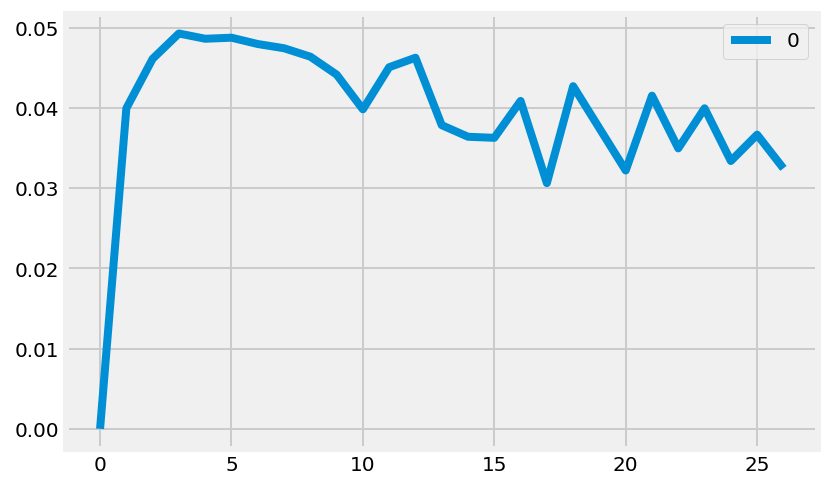

In [170]:
print("The model: RandomForestClassifier can beat the baseline accuracy by {} if the tree depth is {}.".format(max(list_of_scores),list_of_scores.index(max(list_of_scores))))
pd.DataFrame(list_of_scores).plot()

#     Cannot use. Upsampling happened before splitting

In [171]:
## print("base_acc(LogReg_Targ_Des_IsOnly_y_train) = {}".format(base_acc(LogReg_Targ_Des_IsOnly_y_train)))
print(".score = {}".format(model_RandomForestClassifier_Targ_Des_IsOnly.score(LogReg_Targ_Des_IsOnly_X_test,LogReg_Targ_Des_IsOnly_y_test)))
print("Improvement from baseline accuracy = {}".format(model_RandomForestClassifier_Targ_Des_IsOnly.score(LogReg_Targ_Des_IsOnly_X_test,LogReg_Targ_Des_IsOnly_y_test)-base_acc(LogReg_Targ_Des_IsOnly_y_train)))


# Maybe try with Gridsearch and SVM


.score = 0.882314820815242
Improvement from baseline accuracy = -0.00061064079408224


In [172]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif


def get_chi2(X,y):
    
    '''
    Produces two tables with the highest chi2_score and f_classif
    
    Inspired by:
    dsi-unit-3.21-optimization-feature_selection-lab
    '''
    
    # build the selector (we'll build one with each score type)
    skb_f = SelectKBest(f_classif, k=5)
    skb_chi2 = SelectKBest(chi2, k=5)

    # train the selector on our data
    skb_f.fit(X, y)
    skb_chi2.fit(X, y)

    # examine results
    output_table = pd.DataFrame([X.columns, list(skb_f.scores_), list(skb_chi2.scores_)], 
                     index=['feature','f_classif','chi2 score']).T

    
    output_table['Question_long'] = output_table['feature'] + ": " + [q_dict.get(x) for x in output_table['feature']]
    
    output_table['Four_way_Target'] = y.name

    
    return output_table

In [173]:
# Show in cell above for easier

Four_way_Target_dummied


# Need to also create 'Four_Countries_Dummied'

['Four_way_Target_Middle_Tercile',
 'Four_way_Target_Oldest_Tercile',
 'Four_way_Target_Only_Child',
 'Four_way_Target_Youngest_Tercile']

In [174]:
def show_ch2_fclass(y,v):
    '''
    
    Use this function to generate the chart for copy-pasting into slides 
    
    v = {'chi2 score' or 'f_classif'}
    
    y ={'Four_way_Target_Middle_Tercile',
         'Four_way_Target_Oldest_Tercile',
         'Four_way_Target_Only_Child',
         'Four_way_Target_Youngest_Tercile'}
    
    '''
    display(
    get_chi2(capst02[twentysix_qs], capst02[y]).sort_values(by = v, ascending = False).set_index('Question_long'),
    get_chi2(capst02[twentysix_qs], capst02[y]).sort_values(by = v, ascending = False).set_index('Question_long')[v].plot(kind = 'bar', figsize = (18,8))
    )


In [175]:
# Get the names of the country-dummies

# capst02.columns.to_list()

feature  f_classif  \
Question_long                                                           
Q14: I would stay in school forever if I could.        Q14  10.216959   
Q2: I have traveled alone in a foreign country.         Q2   4.910213   
Q6: I would rather read a book than go to a party.      Q6   6.758651   
Q21: I find too much thinking exhausting.              Q21   4.746138   
Q17: I would want a dog that bit me put down.          Q17   4.671399   
Q16: I am nerdy.                                       Q16    4.16205   
Q3: I love to read challenging material.                Q3   4.297001   
Q12: I like science fiction.                           Q12   2.309409   
Q24: I am interested in economics.                     Q24   1.786749   
Q4: I follow politics.                                  Q4    1.38565   
Q8: I have a rich vocabulary.                           Q8   2.048238   
Q11: I am the kind of person who might write a ...     Q11   0.931159   
Q15: My favorite characters tend to be villains.       Q15   0.940387   
Q23: I am quick to understand things.                  Q23   2.185785   
Q25: I sometimes ruin my jokes by laughing in t...     Q25   1.062681   
Q5: I like simple work.                                 Q5    0.83817   
Q9: I like working with words.                          Q9   0.970592   
Q26: I wanted to be an astronaut at one point.         Q26    0.34992   
Q19: I try to outdo others.                            Q19    0.48898   
Q18: I miss my childhood.                              Q18    0.14156   
Q22: I am just an ordinary person.                     Q22   0.051528   
Q13: I boss people around.                             Q13   0.037717   
Q7: I use difficult words.                              Q7   0.046866   
Q1: I have read an absurd number of books.              Q1   0.020721   
Q10: I hate to throw away books.                       Q10   0.012676   
Q20: I do not need others praise.                      Q20    0.00636   

                                                   chi2 score Four_way_Target  
Question_long                                                                  
Q14: I would stay in school forever if I could.      8.367311   country_02_CA  
Q2: I have traveled alone in a foreign country.      5.406908   country_02_CA  
Q6: I would rather read a book than go to a party.    4.22022   country_02_CA  
Q21: I find too much thinking exhausting.            3.341008   country_02_CA  
Q17: I would want a dog that bit me put down.         3.03404   country_02_CA  
Q16: I am nerdy.                                     1.950686   country_02_CA  
Q3: I love to read challenging material.             1.866022   country_02_CA  
Q12: I like science fiction.                          1.13493   country_02_CA  
Q24: I am interested in economics.                   1.126708   country_02_CA  
Q4: I follow politics.                               0.894895   country_02_CA  
Q8: I have a rich vocabulary.                        0.777542   country_02_CA  
Q11: I am the kind of person who might write a ...   0.700005   country_02_CA  
Q15: My favorite characters tend to be villains.     0.583562   country_02_CA  
Q23: I am quick to understand things.                0.548602   country_02_CA  
Q25: I sometimes ruin my jokes by laughing in t...   0.544741   country_02_CA  
Q5: I like simple work.                              0.433392   country_02_CA  
Q9: I like working with words.                       0.395183   country_02_CA  
Q26: I wanted to be an astronaut at one point.       0.333909   country_02_CA  
Q19: I try to outdo others.                          0.253658   country_02_CA  
Q18: I miss my childhood.                            0.087238   country_02_CA  
Q22: I am just an ordinary person.                   0.030093   country_02_CA  
Q13: I boss people around.                           0.022677   country_02_CA  
Q7: I use difficult words.                           0.021483   country_02_CA  
Q1: I 

<AxesSubplot:xlabel='Question_long'>

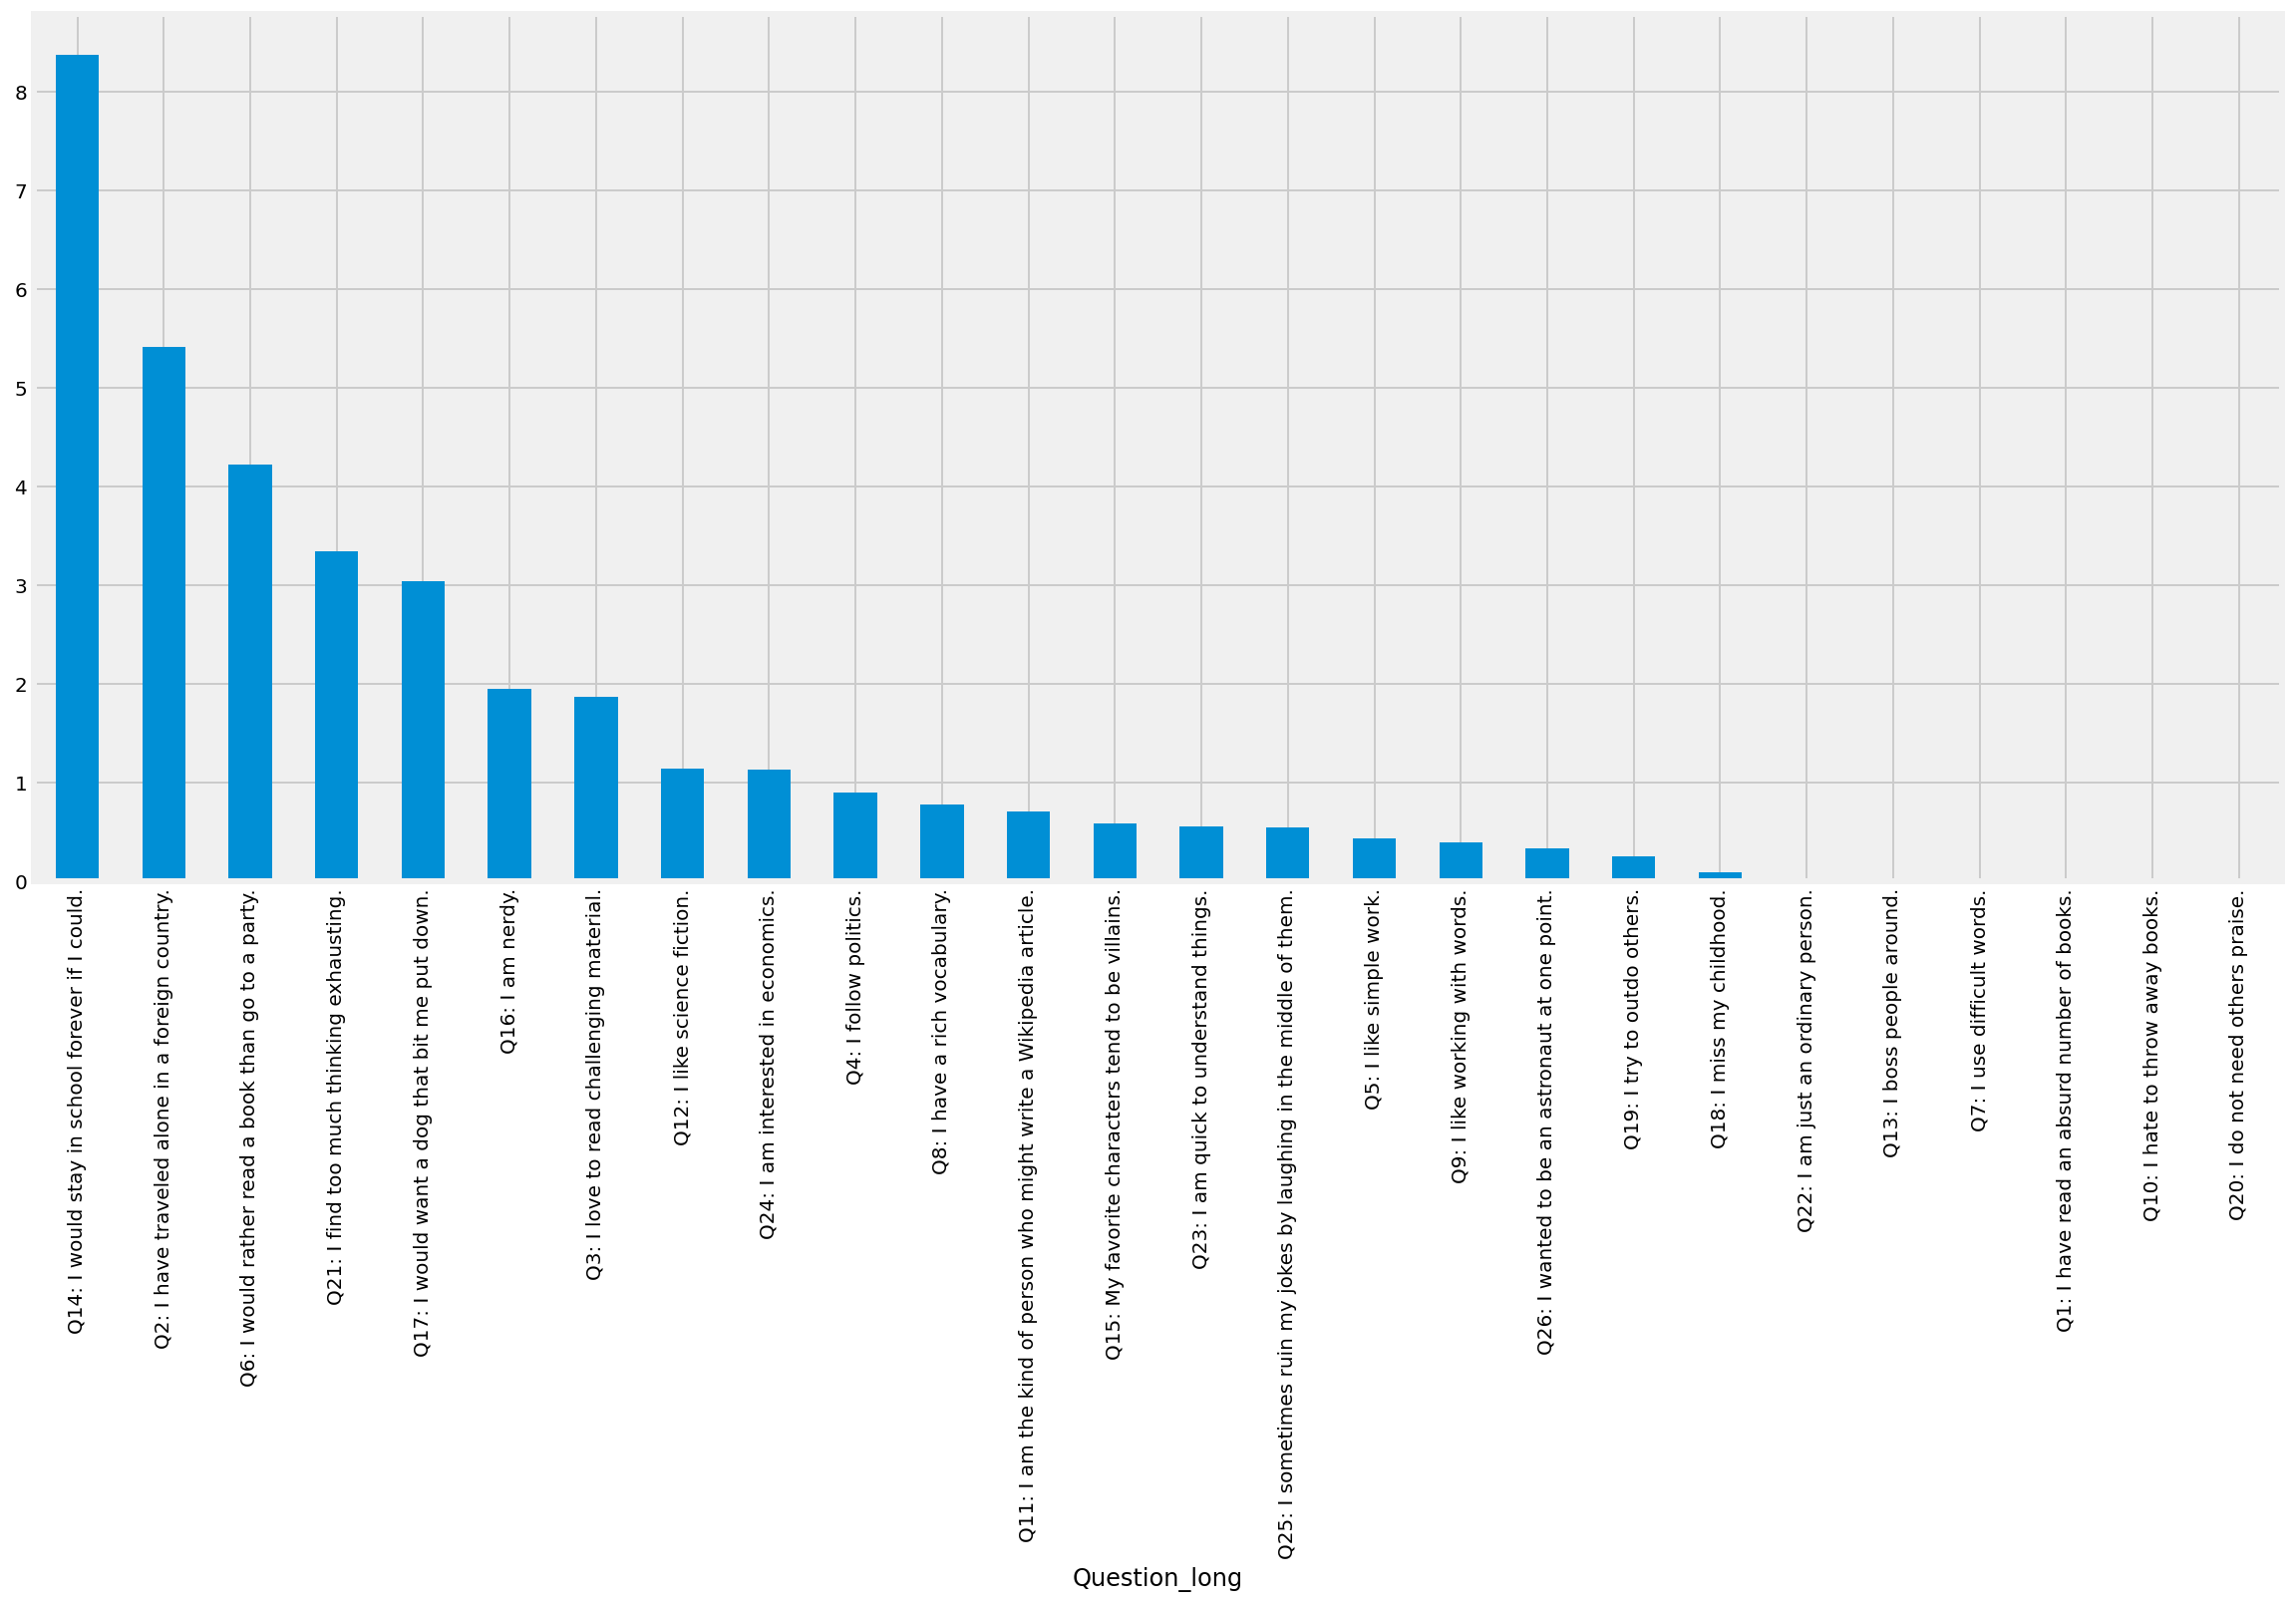

In [176]:
# Us ethis cell to ge the graphs to copy-paste into PowerPoint


    # ['Four_way_Target_Middle_Tercile',
    #  'Four_way_Target_Oldest_Tercile',
    #  'Four_way_Target_Only_Child',
    #  'Four_way_Target_Youngest_Tercile']
    
    
#      'country_02_AU',
#      'country_02_CA',
#      'country_02_GB',
#      'country_02_Other',
#      'country_02_US',

    
    
    # 'chi2 score'
    # 'f_classif'


# show_ch2_fclass('country_02_CA','f_classif')
show_ch2_fclass('country_02_CA','chi2 score')

f_classif  \
Question_long                                                    
Q15: My favorite characters tend to be villains.    145.901072   
Q11: I am the kind of person who might write a ...     73.8198   
Q12: I like science fiction.                          68.42244   
Q7: I use difficult words.                           67.711635   
Q8: I have a rich vocabulary.                        63.573862   
Q3: I love to read challenging material.             56.599029   
Q19: I try to outdo others.                          55.179993   
Q2: I have traveled alone in a foreign country.       48.66726   
Q6: I would rather read a book than go to a party.   48.436621   
Q16: I am nerdy.                                     48.128592   
Q9: I like working with words.                       34.681534   
Q4: I follow politics.                               29.607209   
Q10: I hate to throw away books.                     29.388403   
Q20: I do not need others praise.                    24.211616   
Q25: I sometimes ruin my jokes by laughing in t...   23.070053   
Q23: I am quick to understand things.                22.511512   
Q22: I am just an ordinary person.                   15.607617   
Q21: I find too much thinking exhausting.            10.234524   
Q26: I wanted to be an astronaut at one point.         9.70126   
Q13: I boss people around.                            9.355501   
Q14: I would stay in school forever if I could.       7.719254   
Q5: I like simple work.                               7.694751   
Q24: I am interested in economics.                    7.097887   
Q1: I have read an absurd number of books.            5.559966   
Q18: I miss my childhood.                             4.296431   
Q17: I would want a dog that bit me put down.         0.498577   

                                                               Four_way_Target  
Question_long                                                                   
Q15: My favorite characters tend to be villains.    Four_way_Target_Only_Child  
Q11: I am the kind of person who might write a ...  Four_way_Target_Only_Child  
Q12: I like science fiction.                        Four_way_Target_Only_Child  
Q7: I use difficult words.                          Four_way_Target_Only_Child  
Q8: I have a rich vocabulary.                       Four_way_Target_Only_Child  
Q3: I love to read challenging material.            Four_way_Target_Only_Child  
Q19: I try to outdo others.                         Four_way_Target_Only_Child  
Q2: I have traveled alone in a foreign country.     Four_way_Target_Only_Child  
Q6: I would rather read a book than go to a party.  Four_way_Target_Only_Child  
Q16: I am nerdy.                                    Four_way_Target_Only_Child  
Q9: I like working with words.                      Four_way_Target_Only_Child  
Q4: I follow politics.                              Four_way_Target_Only_Child  
Q10: I hate to throw away books.                    Four_way_Target_Only_Child  
Q20: I do not need others praise.                   Four_way_Target_Only_Child  
Q25: I sometimes ruin my jokes by laughing in t...  Four_way_Target_Only_Child  
Q23: I am quick to understand things.               Four_way_Target_Only_Child  
Q22: I am just an ordinary person.                  Four_way_Target_Only_Child  
Q21: I find too much thinking exhausting.           Four_way_Target_Only_Child  
Q26: I wanted to be an astronaut at one point.      Four_way_Target_Only_Child  
Q13: I boss people around.                          Four_way_Target_Only_Child  
Q14: I would stay in school forever if I could.     Four_way_Target_Only_Child  
Q5: I like simple work.                             Four_way_Target_Only_Child  
Q24: I am interested in economics.                  Four_way_Target_Only_Child  
Q1: I have read an absurd number of books.          Four_way_Target_Only_Child  
Q18: I miss my childhood.                           Four_way_Target_Only_Child  
Q17: I would want

<AxesSubplot:xlabel='Question_long'>

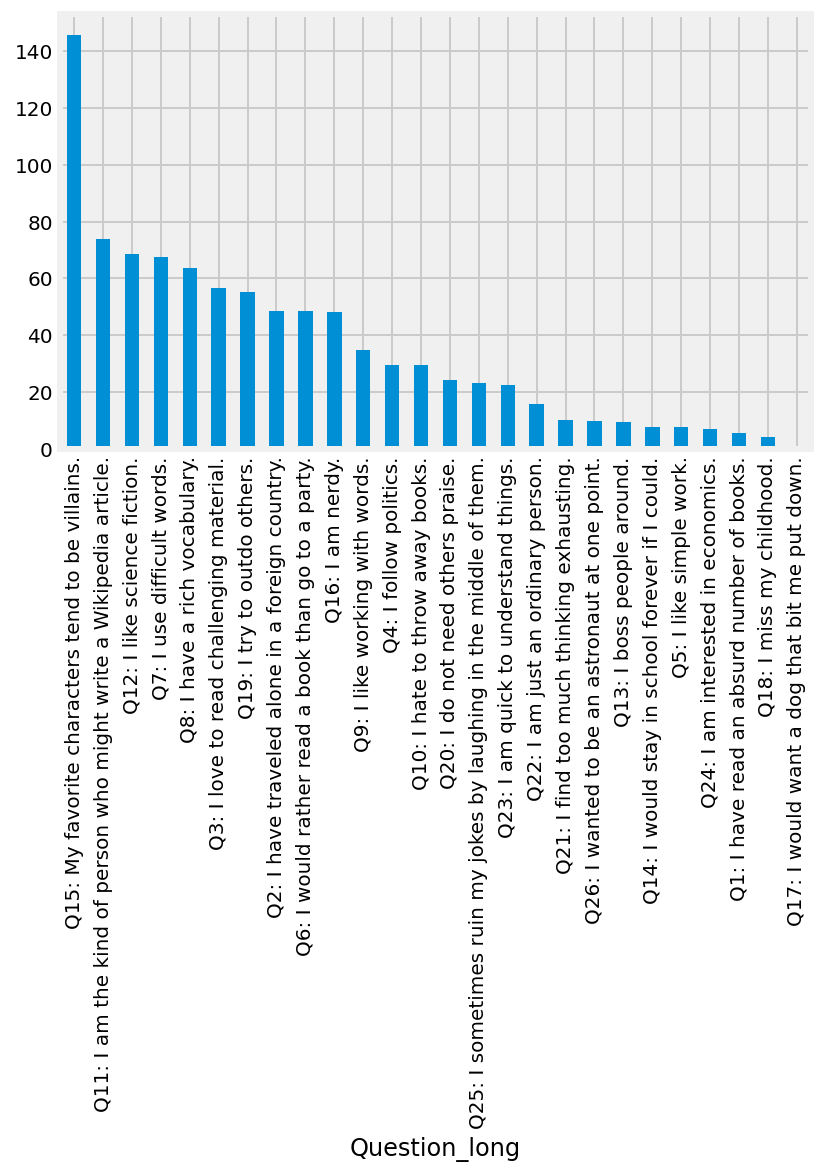

In [177]:
# This cell is to get the barcharts going

# get_chi2(capst02[twentysix_qs], capst02['Four_way_Target_Only_Child']).sort_values(by = 'f_classif').set_index('Question_long')

display(
    get_chi2(capst02[twentysix_qs], capst02['Four_way_Target_Only_Child']).drop(columns = ['chi2 score','feature']).sort_values(by = 'f_classif', ascending = False).set_index('Question_long'),
    get_chi2(capst02[twentysix_qs], capst02['Four_way_Target_Only_Child']).drop(columns = ['chi2 score','feature']).sort_values(by = 'f_classif', ascending = False).set_index('Question_long')['f_classif'].plot(kind = 'bar')
    )


In [178]:
# Find out which features have the highest f_classif and hightest chi2 score per Tercile Target

# Use def get_chi2(X,y) on Four_way_Target_dummied


for x in Four_way_Target_dummied:
    display(
        get_chi2(capst02[twentysix_qs], capst02[x]).drop(columns = ['chi2 score']).sort_values(by = 'f_classif', ascending = False),
        get_chi2(capst02[twentysix_qs], capst02[x]).drop(columns = ['f_classif']).sort_values(by = 'chi2 score', ascending = False)
           )




# Idea: Get the ch2 for the four different countries
    
# Idea: Make 26 stacked histograms for all 26 questions colours by the four different classifications

feature  f_classif                                      Question_long  \
7       Q8  93.500809                      Q8: I have a rich vocabulary.   
15     Q16  88.355925                                   Q16: I am nerdy.   
6       Q7  85.076463                         Q7: I use difficult words.   
11     Q12  64.263109                       Q12: I like science fiction.   
10     Q11  53.091468  Q11: I am the kind of person who might write a...   
1       Q2  50.709425    Q2: I have traveled alone in a foreign country.   
3       Q4  49.869548                             Q4: I follow politics.   
2       Q3  46.177412           Q3: I love to read challenging material.   
18     Q19  44.411048                        Q19: I try to outdo others.   
14     Q15  43.907486   Q15: My favorite characters tend to be villains.   
8       Q9  43.472178                     Q9: I like working with words.   
22     Q23  41.369479              Q23: I am quick to understand things.   
19     Q20  39.152392                  Q20: I do not need others praise.   
12     Q13  27.818941                         Q13: I boss people around.   
20     Q21  24.884705          Q21: I find too much thinking exhausting.   
5       Q6  24.867569  Q6: I would rather read a book than go to a pa...   
9      Q10  23.527265                   Q10: I hate to throw away books.   
13     Q14  19.322351    Q14: I would stay in school forever if I could.   
0       Q1  17.754755         Q1: I have read an absurd number of books.   
4       Q5  12.024737                            Q5: I like simple work.   
25     Q26  10.600807     Q26: I wanted to be an astronaut at one point.   
24     Q25   8.401456  Q25: I sometimes ruin my jokes by laughing in ...   
21     Q22   8.093773                 Q22: I am just an ordinary person.   
17     Q18   7.536027                          Q18: I miss my childhood.   
23     Q24   4.849881                 Q24: I am interested in economics.   
16     Q17   2.559783      Q17: I would want a dog that bit me put down.   

                   Four_way_Target  
7   Four_way_Target_Middle_Tercile  
15  Four_way_Target_Middle_Tercile  
6   Four_way_Target_Middle_Tercile  
11  Four_way_Target_Middle_Tercile  
10  Four_way_Target_Middle_Tercile  
1   Four_way_Target_Middle_Tercile  
3   Four_way_Target_Middle_Tercile  
2   Four_way_Target_Middle_Tercile  
18  Four_way_Target_Middle_Tercile  
14  Four_way_Target_Middle_Tercile  
8   Four_way_Target_Middle_Tercile  
22  Four_way_Target_Middle_Tercile  
19  Four_way_Target_Middle_Tercile  
12  Four_way_Target_Middle_Tercile  
20  Four_way_Target_Middle_Tercile  
5   Four_way_Target_Middle_Tercile  
9   Four_way_Target_Middle_Tercile  
13  Four_way_Target_Middle_Tercile  
0   Four_way_Target_Middle_Tercile  
4   Four_way_Target_Middle_Tercile  
25  Four_way_Target_Middle_Tercile  
24  Four_way_Target_Middle_Tercile  
21  Four_way_Target_Middle_Tercile  
17  Four_way_Target_Middle_Tercile  
23  Four_way_Target_Middle_Tercile  
16  Four_way_Target_Middle_Tercile

feature chi2 score                                      Question_long  \
1       Q2  55.775729    Q2: I have traveled alone in a foreign country.   
15     Q16  41.324887                                   Q16: I am nerdy.   
10     Q11  39.860416  Q11: I am the kind of person who might write a...   
6       Q7  38.917552                         Q7: I use difficult words.   
7       Q8  35.414126                      Q8: I have a rich vocabulary.   
3       Q4  32.168676                             Q4: I follow politics.   
11     Q12  31.532942                       Q12: I like science fiction.   
14     Q15  27.218098   Q15: My favorite characters tend to be villains.   
18     Q19  23.013141                        Q19: I try to outdo others.   
19     Q20  21.506454                  Q20: I do not need others praise.   
2       Q3  20.032305           Q3: I love to read challenging material.   
8       Q9  17.681375                     Q9: I like working with words.   
20     Q21   17.50867          Q21: I find too much thinking exhausting.   
12     Q13  16.714601                         Q13: I boss people around.   
13     Q14  15.820723    Q14: I would stay in school forever if I could.   
5       Q6   15.52079  Q6: I would rather read a book than go to a pa...   
0       Q1  11.987589         Q1: I have read an absurd number of books.   
22     Q23  10.373108              Q23: I am quick to understand things.   
25     Q26  10.113175     Q26: I wanted to be an astronaut at one point.   
9      Q10   9.408115                   Q10: I hate to throw away books.   
4       Q5   6.215897                            Q5: I like simple work.   
21     Q22   4.725911                 Q22: I am just an ordinary person.   
17     Q18   4.643291                          Q18: I miss my childhood.   
24     Q25   4.305883  Q25: I sometimes ruin my jokes by laughing in ...   
23     Q24   3.058059                 Q24: I am interested in economics.   
16     Q17   1.662648      Q17: I would want a dog that bit me put down.   

                   Four_way_Target  
1   Four_way_Target_Middle_Tercile  
15  Four_way_Target_Middle_Tercile  
10  Four_way_Target_Middle_Tercile  
6   Four_way_Target_Middle_Tercile  
7   Four_way_Target_Middle_Tercile  
3   Four_way_Target_Middle_Tercile  
11  Four_way_Target_Middle_Tercile  
14  Four_way_Target_Middle_Tercile  
18  Four_way_Target_Middle_Tercile  
19  Four_way_Target_Middle_Tercile  
2   Four_way_Target_Middle_Tercile  
8   Four_way_Target_Middle_Tercile  
20  Four_way_Target_Middle_Tercile  
12  Four_way_Target_Middle_Tercile  
13  Four_way_Target_Middle_Tercile  
5   Four_way_Target_Middle_Tercile  
0   Four_way_Target_Middle_Tercile  
22  Four_way_Target_Middle_Tercile  
25  Four_way_Target_Middle_Tercile  
9   Four_way_Target_Middle_Tercile  
4   Four_way_Target_Middle_Tercile  
21  Four_way_Target_Middle_Tercile  
17  Four_way_Target_Middle_Tercile  
24  Four_way_Target_Middle_Tercile  
23  Four_way_Target_Middle_Tercile  
16  Four_way_Target_Middle_Tercile

feature   f_classif                                      Question_long  \
0       Q1  298.227206         Q1: I have read an absurd number of books.   
2       Q3  126.641259           Q3: I love to read challenging material.   
15     Q16   111.51112                                   Q16: I am nerdy.   
7       Q8  107.816242                      Q8: I have a rich vocabulary.   
6       Q7  103.055023                         Q7: I use difficult words.   
9      Q10  102.758633                   Q10: I hate to throw away books.   
3       Q4   94.598164                             Q4: I follow politics.   
12     Q13   94.574332                         Q13: I boss people around.   
10     Q11   92.702032  Q11: I am the kind of person who might write a...   
13     Q14   91.538021    Q14: I would stay in school forever if I could.   
5       Q6   72.156791  Q6: I would rather read a book than go to a pa...   
22     Q23   67.611689              Q23: I am quick to understand things.   
8       Q9   65.044428                     Q9: I like working with words.   
4       Q5   64.406217                            Q5: I like simple work.   
20     Q21   57.082527          Q21: I find too much thinking exhausting.   
11     Q12   44.657927                       Q12: I like science fiction.   
18     Q19   40.280573                        Q19: I try to outdo others.   
23     Q24    38.65351                 Q24: I am interested in economics.   
1       Q2   36.967684    Q2: I have traveled alone in a foreign country.   
25     Q26   35.923266     Q26: I wanted to be an astronaut at one point.   
17     Q18   31.999661                          Q18: I miss my childhood.   
16     Q17   31.665476      Q17: I would want a dog that bit me put down.   
24     Q25   12.397322  Q25: I sometimes ruin my jokes by laughing in ...   
21     Q22    7.038444                 Q22: I am just an ordinary person.   
14     Q15    3.345618   Q15: My favorite characters tend to be villains.   
19     Q20    1.377205                  Q20: I do not need others praise.   

                   Four_way_Target  
0   Four_way_Target_Oldest_Tercile  
2   Four_way_Target_Oldest_Tercile  
15  Four_way_Target_Oldest_Tercile  
7   Four_way_Target_Oldest_Tercile  
6   Four_way_Target_Oldest_Tercile  
9   Four_way_Target_Oldest_Tercile  
3   Four_way_Target_Oldest_Tercile  
12  Four_way_Target_Oldest_Tercile  
10  Four_way_Target_Oldest_Tercile  
13  Four_way_Target_Oldest_Tercile  
5   Four_way_Target_Oldest_Tercile  
22  Four_way_Target_Oldest_Tercile  
8   Four_way_Target_Oldest_Tercile  
4   Four_way_Target_Oldest_Tercile  
20  Four_way_Target_Oldest_Tercile  
11  Four_way_Target_Oldest_Tercile  
18  Four_way_Target_Oldest_Tercile  
23  Four_way_Target_Oldest_Tercile  
1   Four_way_Target_Oldest_Tercile  
25  Four_way_Target_Oldest_Tercile  
17  Four_way_Target_Oldest_Tercile  
16  Four_way_Target_Oldest_Tercile  
24  Four_way_Target_Oldest_Tercile  
21  Four_way_Target_Oldest_Tercile  
14  Four_way_Target_Oldest_Tercile  
19  Four_way_Target_Oldest_Tercile

feature  chi2 score                                      Question_long  \
0       Q1  199.968141         Q1: I have read an absurd number of books.   
13     Q14   74.815669    Q14: I would stay in school forever if I could.   
10     Q11   69.531447  Q11: I am the kind of person who might write a...   
3       Q4   60.953752                             Q4: I follow politics.   
12     Q13   56.729911                         Q13: I boss people around.   
2       Q3    54.82938           Q3: I love to read challenging material.   
15     Q16   52.124973                                   Q16: I am nerdy.   
6       Q7   47.120774                         Q7: I use difficult words.   
5       Q6   44.983155  Q6: I would rather read a book than go to a pa...   
9      Q10   41.010871                   Q10: I hate to throw away books.   
7       Q8    40.82177                      Q8: I have a rich vocabulary.   
1       Q2    40.67489    Q2: I have traveled alone in a foreign country.   
20     Q21   40.130821          Q21: I find too much thinking exhausting.   
25     Q26   34.249351     Q26: I wanted to be an astronaut at one point.   
4       Q5   33.250133                            Q5: I like simple work.   
8       Q9    26.44132                     Q9: I like working with words.   
23     Q24   24.352332                 Q24: I am interested in economics.   
11     Q12   21.923597                       Q12: I like science fiction.   
18     Q19   20.874922                        Q19: I try to outdo others.   
16     Q17   20.552769      Q17: I would want a dog that bit me put down.   
17     Q18   19.704524                          Q18: I miss my childhood.   
22     Q23   16.942163              Q23: I am quick to understand things.   
24     Q25    6.353201  Q25: I sometimes ruin my jokes by laughing in ...   
21     Q22    4.109817                 Q22: I am just an ordinary person.   
14     Q15    2.076019   Q15: My favorite characters tend to be villains.   
19     Q20    0.757208                  Q20: I do not need others praise.   

                   Four_way_Target  
0   Four_way_Target_Oldest_Tercile  
13  Four_way_Target_Oldest_Tercile  
10  Four_way_Target_Oldest_Tercile  
3   Four_way_Target_Oldest_Tercile  
12  Four_way_Target_Oldest_Tercile  
2   Four_way_Target_Oldest_Tercile  
15  Four_way_Target_Oldest_Tercile  
6   Four_way_Target_Oldest_Tercile  
5   Four_way_Target_Oldest_Tercile  
9   Four_way_Target_Oldest_Tercile  
7   Four_way_Target_Oldest_Tercile  
1   Four_way_Target_Oldest_Tercile  
20  Four_way_Target_Oldest_Tercile  
25  Four_way_Target_Oldest_Tercile  
4   Four_way_Target_Oldest_Tercile  
8   Four_way_Target_Oldest_Tercile  
23  Four_way_Target_Oldest_Tercile  
11  Four_way_Target_Oldest_Tercile  
18  Four_way_Target_Oldest_Tercile  
16  Four_way_Target_Oldest_Tercile  
17  Four_way_Target_Oldest_Tercile  
22  Four_way_Target_Oldest_Tercile  
24  Four_way_Target_Oldest_Tercile  
21  Four_way_Target_Oldest_Tercile  
14  Four_way_Target_Oldest_Tercile  
19  Four_way_Target_Oldest_Tercile

feature   f_classif                                      Question_long  \
14     Q15  145.901072   Q15: My favorite characters tend to be villains.   
10     Q11     73.8198  Q11: I am the kind of person who might write a...   
11     Q12    68.42244                       Q12: I like science fiction.   
6       Q7   67.711635                         Q7: I use difficult words.   
7       Q8   63.573862                      Q8: I have a rich vocabulary.   
2       Q3   56.599029           Q3: I love to read challenging material.   
18     Q19   55.179993                        Q19: I try to outdo others.   
1       Q2    48.66726    Q2: I have traveled alone in a foreign country.   
5       Q6   48.436621  Q6: I would rather read a book than go to a pa...   
15     Q16   48.128592                                   Q16: I am nerdy.   
8       Q9   34.681534                     Q9: I like working with words.   
3       Q4   29.607209                             Q4: I follow politics.   
9      Q10   29.388403                   Q10: I hate to throw away books.   
19     Q20   24.211616                  Q20: I do not need others praise.   
24     Q25   23.070053  Q25: I sometimes ruin my jokes by laughing in ...   
22     Q23   22.511512              Q23: I am quick to understand things.   
21     Q22   15.607617                 Q22: I am just an ordinary person.   
20     Q21   10.234524          Q21: I find too much thinking exhausting.   
25     Q26     9.70126     Q26: I wanted to be an astronaut at one point.   
12     Q13    9.355501                         Q13: I boss people around.   
13     Q14    7.719254    Q14: I would stay in school forever if I could.   
4       Q5    7.694751                            Q5: I like simple work.   
23     Q24    7.097887                 Q24: I am interested in economics.   
0       Q1    5.559966         Q1: I have read an absurd number of books.   
17     Q18    4.296431                          Q18: I miss my childhood.   
16     Q17    0.498577      Q17: I would want a dog that bit me put down.   

               Four_way_Target  
14  Four_way_Target_Only_Child  
10  Four_way_Target_Only_Child  
11  Four_way_Target_Only_Child  
6   Four_way_Target_Only_Child  
7   Four_way_Target_Only_Child  
2   Four_way_Target_Only_Child  
18  Four_way_Target_Only_Child  
1   Four_way_Target_Only_Child  
5   Four_way_Target_Only_Child  
15  Four_way_Target_Only_Child  
8   Four_way_Target_Only_Child  
3   Four_way_Target_Only_Child  
9   Four_way_Target_Only_Child  
19  Four_way_Target_Only_Child  
24  Four_way_Target_Only_Child  
22  Four_way_Target_Only_Child  
21  Four_way_Target_Only_Child  
20  Four_way_Target_Only_Child  
25  Four_way_Target_Only_Child  
12  Four_way_Target_Only_Child  
13  Four_way_Target_Only_Child  
4   Four_way_Target_Only_Child  
23  Four_way_Target_Only_Child  
0   Four_way_Target_Only_Child  
17  Four_way_Target_Only_Child  
16  Four_way_Target_Only_Child

feature chi2 score                                      Question_long  \
14     Q15  90.216035   Q15: My favorite characters tend to be villains.   
10     Q11  55.394604  Q11: I am the kind of person who might write a...   
1       Q2  53.532237    Q2: I have traveled alone in a foreign country.   
11     Q12  33.570412                       Q12: I like science fiction.   
6       Q7  30.987442                         Q7: I use difficult words.   
5       Q6  30.213509  Q6: I would rather read a book than go to a pa...   
18     Q19  28.585834                        Q19: I try to outdo others.   
2       Q3  24.546999           Q3: I love to read challenging material.   
7       Q8  24.096883                      Q8: I have a rich vocabulary.   
15     Q16  22.532579                                   Q16: I am nerdy.   
3       Q4  19.107895                             Q4: I follow politics.   
8       Q9  14.109037                     Q9: I like working with words.   
19     Q20  13.304385                  Q20: I do not need others praise.   
24     Q25  11.819487  Q25: I sometimes ruin my jokes by laughing in ...   
9      Q10   11.75017                   Q10: I hate to throw away books.   
25     Q26   9.255213     Q26: I wanted to be an astronaut at one point.   
21     Q22   9.111509                 Q22: I am just an ordinary person.   
20     Q21   7.203536          Q21: I find too much thinking exhausting.   
13     Q14   6.322173    Q14: I would stay in school forever if I could.   
22     Q23   5.647238              Q23: I am quick to understand things.   
12     Q13   5.623684                         Q13: I boss people around.   
23     Q24   4.475275                 Q24: I am interested in economics.   
4       Q5   3.978042                            Q5: I like simple work.   
0       Q1    3.75509         Q1: I have read an absurd number of books.   
17     Q18    2.64744                          Q18: I miss my childhood.   
16     Q17   0.323856      Q17: I would want a dog that bit me put down.   

               Four_way_Target  
14  Four_way_Target_Only_Child  
10  Four_way_Target_Only_Child  
1   Four_way_Target_Only_Child  
11  Four_way_Target_Only_Child  
6   Four_way_Target_Only_Child  
5   Four_way_Target_Only_Child  
18  Four_way_Target_Only_Child  
2   Four_way_Target_Only_Child  
7   Four_way_Target_Only_Child  
15  Four_way_Target_Only_Child  
3   Four_way_Target_Only_Child  
8   Four_way_Target_Only_Child  
19  Four_way_Target_Only_Child  
24  Four_way_Target_Only_Child  
9   Four_way_Target_Only_Child  
25  Four_way_Target_Only_Child  
21  Four_way_Target_Only_Child  
20  Four_way_Target_Only_Child  
13  Four_way_Target_Only_Child  
22  Four_way_Target_Only_Child  
12  Four_way_Target_Only_Child  
23  Four_way_Target_Only_Child  
4   Four_way_Target_Only_Child  
0   Four_way_Target_Only_Child  
17  Four_way_Target_Only_Child  
16  Four_way_Target_Only_Child

feature   f_classif                                      Question_long  \
0       Q1   267.85639         Q1: I have read an absurd number of books.   
2       Q3  134.198446           Q3: I love to read challenging material.   
9      Q10  110.456697                   Q10: I hate to throw away books.   
10     Q11  104.605606  Q11: I am the kind of person who might write a...   
5       Q6   94.905554  Q6: I would rather read a book than go to a pa...   
6       Q7   80.756459                         Q7: I use difficult words.   
7       Q8   75.677971                      Q8: I have a rich vocabulary.   
13     Q14   71.383518    Q14: I would stay in school forever if I could.   
15     Q16   70.285104                                   Q16: I am nerdy.   
3       Q4   69.464606                             Q4: I follow politics.   
12     Q13   65.750316                         Q13: I boss people around.   
16     Q17   58.630173      Q17: I would want a dog that bit me put down.   
4       Q5   57.281304                            Q5: I like simple work.   
8       Q9   52.939405                     Q9: I like working with words.   
22     Q23   45.966171              Q23: I am quick to understand things.   
23     Q24    43.61114                 Q24: I am interested in economics.   
18     Q19   41.993046                        Q19: I try to outdo others.   
11     Q12    40.19843                       Q12: I like science fiction.   
20     Q21   37.958532          Q21: I find too much thinking exhausting.   
25     Q26   34.140945     Q26: I wanted to be an astronaut at one point.   
1       Q2   30.546671    Q2: I have traveled alone in a foreign country.   
17     Q18   26.802996                          Q18: I miss my childhood.   
14     Q15   24.709922   Q15: My favorite characters tend to be villains.   
24     Q25   22.083832  Q25: I sometimes ruin my jokes by laughing in ...   
21     Q22   10.527425                 Q22: I am just an ordinary person.   
19     Q20    0.118698                  Q20: I do not need others praise.   

                     Four_way_Target  
0   Four_way_Target_Youngest_Tercile  
2   Four_way_Target_Youngest_Tercile  
9   Four_way_Target_Youngest_Tercile  
10  Four_way_Target_Youngest_Tercile  
5   Four_way_Target_Youngest_Tercile  
6   Four_way_Target_Youngest_Tercile  
7   Four_way_Target_Youngest_Tercile  
13  Four_way_Target_Youngest_Tercile  
15  Four_way_Target_Youngest_Tercile  
3   Four_way_Target_Youngest_Tercile  
12  Four_way_Target_Youngest_Tercile  
16  Four_way_Target_Youngest_Tercile  
4   Four_way_Target_Youngest_Tercile  
8   Four_way_Target_Youngest_Tercile  
22  Four_way_Target_Youngest_Tercile  
23  Four_way_Target_Youngest_Tercile  
18  Four_way_Target_Youngest_Tercile  
11  Four_way_Target_Youngest_Tercile  
20  Four_way_Target_Youngest_Tercile  
25  Four_way_Target_Youngest_Tercile  
1   Four_way_Target_Youngest_Tercile  
17  Four_way_Target_Youngest_Tercile  
14  Four_way_Target_Youngest_Tercile  
24  Four_way_Target_Youngest_Tercile  
21  Four_way_Target_Youngest_Tercile  
19  Four_way_Target_Youngest_Tercile

feature  chi2 score                                      Question_long  \
0       Q1  179.737958         Q1: I have read an absurd number of books.   
10     Q11   78.436699  Q11: I am the kind of person who might write a...   
5       Q6   59.131686  Q6: I would rather read a book than go to a pa...   
13     Q14   58.372089    Q14: I would stay in school forever if I could.   
2       Q3   58.090433           Q3: I love to read challenging material.   
3       Q4   44.786897                             Q4: I follow politics.   
9      Q10   44.074783                   Q10: I hate to throw away books.   
12     Q13   39.468074                         Q13: I boss people around.   
16     Q17   38.029089      Q17: I would want a dog that bit me put down.   
6       Q7   36.945343                         Q7: I use difficult words.   
1       Q2   33.615302    Q2: I have traveled alone in a foreign country.   
15     Q16   32.887676                                   Q16: I am nerdy.   
25     Q26   32.551516     Q26: I wanted to be an astronaut at one point.   
4       Q5   29.577058                            Q5: I like simple work.   
7       Q8   28.676217                      Q8: I have a rich vocabulary.   
23     Q24    27.47235                 Q24: I am interested in economics.   
20     Q21   26.698669          Q21: I find too much thinking exhausting.   
18     Q19   21.761469                        Q19: I try to outdo others.   
8       Q9   21.526927                     Q9: I like working with words.   
11     Q12   19.736504                       Q12: I like science fiction.   
17     Q18    16.50668                          Q18: I miss my childhood.   
14     Q15    15.32487   Q15: My favorite characters tend to be villains.   
22     Q23   11.524386              Q23: I am quick to understand things.   
24     Q25   11.314492  Q25: I sometimes ruin my jokes by laughing in ...   
21     Q22    6.146537                 Q22: I am just an ordinary person.   
19     Q20    0.065264                  Q20: I do not need others praise.   

                     Four_way_Target  
0   Four_way_Target_Youngest_Tercile  
10  Four_way_Target_Youngest_Tercile  
5   Four_way_Target_Youngest_Tercile  
13  Four_way_Target_Youngest_Tercile  
2   Four_way_Target_Youngest_Tercile  
3   Four_way_Target_Youngest_Tercile  
9   Four_way_Target_Youngest_Tercile  
12  Four_way_Target_Youngest_Tercile  
16  Four_way_Target_Youngest_Tercile  
6   Four_way_Target_Youngest_Tercile  
1   Four_way_Target_Youngest_Tercile  
15  Four_way_Target_Youngest_Tercile  
25  Four_way_Target_Youngest_Tercile  
4   Four_way_Target_Youngest_Tercile  
7   Four_way_Target_Youngest_Tercile  
23  Four_way_Target_Youngest_Tercile  
20  Four_way_Target_Youngest_Tercile  
18  Four_way_Target_Youngest_Tercile  
8   Four_way_Target_Youngest_Tercile  
11  Four_way_Target_Youngest_Tercile  
17  Four_way_Target_Youngest_Tercile  
14  Four_way_Target_Youngest_Tercile  
22  Four_way_Target_Youngest_Tercile  
24  Four_way_Target_Youngest_Tercile  
21  Four_way_Target_Youngest_Tercile  
19  Four_way_Target_Youngest_Tercile

In [179]:
# This cell is for finding highest 'f_classif' and highest 'chi2 score' for the top four respoding countries


    
for x in country_dummies_capst02:
    display(
        get_chi2(capst02[twentysix_qs], capst02[x]).drop(columns = ['chi2 score']).sort_values(by = 'f_classif', ascending = False),
        get_chi2(capst02[twentysix_qs], capst02[x]).drop(columns = ['f_classif']).sort_values(by = 'chi2 score', ascending = False)
           )

feature  f_classif                                      Question_long  \
1       Q2  74.823001    Q2: I have traveled alone in a foreign country.   
21     Q22  36.630084                 Q22: I am just an ordinary person.   
15     Q16  30.280421                                   Q16: I am nerdy.   
25     Q26  28.810315     Q26: I wanted to be an astronaut at one point.   
11     Q12  23.865412                       Q12: I like science fiction.   
10     Q11  23.556607  Q11: I am the kind of person who might write a...   
4       Q5  20.322371                            Q5: I like simple work.   
13     Q14  17.750619    Q14: I would stay in school forever if I could.   
18     Q19   16.14966                        Q19: I try to outdo others.   
17     Q18  15.336032                          Q18: I miss my childhood.   
14     Q15   14.93421   Q15: My favorite characters tend to be villains.   
5       Q6   7.384255  Q6: I would rather read a book than go to a pa...   
6       Q7    7.30568                         Q7: I use difficult words.   
20     Q21   7.262385          Q21: I find too much thinking exhausting.   
19     Q20   6.626037                  Q20: I do not need others praise.   
7       Q8   6.196185                      Q8: I have a rich vocabulary.   
8       Q9   3.717769                     Q9: I like working with words.   
23     Q24   2.613134                 Q24: I am interested in economics.   
22     Q23   2.530015              Q23: I am quick to understand things.   
3       Q4   1.745829                             Q4: I follow politics.   
2       Q3   1.226509           Q3: I love to read challenging material.   
0       Q1   0.772818         Q1: I have read an absurd number of books.   
24     Q25   0.508146  Q25: I sometimes ruin my jokes by laughing in ...   
9      Q10    0.17943                   Q10: I hate to throw away books.   
12     Q13   0.078022                         Q13: I boss people around.   
16     Q17   0.000644      Q17: I would want a dog that bit me put down.   

   Four_way_Target  
1    country_02_AU  
21   country_02_AU  
15   country_02_AU  
25   country_02_AU  
11   country_02_AU  
10   country_02_AU  
4    country_02_AU  
13   country_02_AU  
18   country_02_AU  
17   country_02_AU  
14   country_02_AU  
5    country_02_AU  
6    country_02_AU  
20   country_02_AU  
19   country_02_AU  
7    country_02_AU  
8    country_02_AU  
23   country_02_AU  
22   country_02_AU  
3    country_02_AU  
2    country_02_AU  
0    country_02_AU  
24   country_02_AU  
9    country_02_AU  
12   country_02_AU  
16   country_02_AU

feature chi2 score                                      Question_long  \
1       Q2  82.249421    Q2: I have traveled alone in a foreign country.   
25     Q26  27.472675     Q26: I wanted to be an astronaut at one point.   
21     Q22  21.373015                 Q22: I am just an ordinary person.   
10     Q11  17.698932  Q11: I am the kind of person who might write a...   
13     Q14  14.534389    Q14: I would stay in school forever if I could.   
15     Q16   14.18278                                   Q16: I am nerdy.   
11     Q12  11.722103                       Q12: I like science fiction.   
4       Q5  10.503001                            Q5: I like simple work.   
17     Q18   9.447407                          Q18: I miss my childhood.   
14     Q15   9.264302   Q15: My favorite characters tend to be villains.   
18     Q19   8.374365                        Q19: I try to outdo others.   
20     Q21   5.111982          Q21: I find too much thinking exhausting.   
5       Q6   4.610787  Q6: I would rather read a book than go to a pa...   
19     Q20    3.64262                  Q20: I do not need others praise.   
6       Q7   3.348358                         Q7: I use difficult words.   
7       Q8   2.351923                      Q8: I have a rich vocabulary.   
23     Q24   1.647785                 Q24: I am interested in economics.   
8       Q9   1.513611                     Q9: I like working with words.   
3       Q4     1.1275                             Q4: I follow politics.   
22     Q23   0.634993              Q23: I am quick to understand things.   
2       Q3   0.532666           Q3: I love to read challenging material.   
0       Q1   0.522007         Q1: I have read an absurd number of books.   
24     Q25   0.260484  Q25: I sometimes ruin my jokes by laughing in ...   
9      Q10   0.071792                   Q10: I hate to throw away books.   
12     Q13   0.046911                         Q13: I boss people around.   
16     Q17   0.000418      Q17: I would want a dog that bit me put down.   

   Four_way_Target  
1    country_02_AU  
25   country_02_AU  
21   country_02_AU  
10   country_02_AU  
13   country_02_AU  
15   country_02_AU  
11   country_02_AU  
4    country_02_AU  
17   country_02_AU  
14   country_02_AU  
18   country_02_AU  
20   country_02_AU  
5    country_02_AU  
19   country_02_AU  
6    country_02_AU  
7    country_02_AU  
23   country_02_AU  
8    country_02_AU  
3    country_02_AU  
22   country_02_AU  
2    country_02_AU  
0    country_02_AU  
24   country_02_AU  
9    country_02_AU  
12   country_02_AU  
16   country_02_AU

feature  f_classif                                      Question_long  \
13     Q14  10.216959    Q14: I would stay in school forever if I could.   
5       Q6   6.758651  Q6: I would rather read a book than go to a pa...   
1       Q2   4.910213    Q2: I have traveled alone in a foreign country.   
20     Q21   4.746138          Q21: I find too much thinking exhausting.   
16     Q17   4.671399      Q17: I would want a dog that bit me put down.   
2       Q3   4.297001           Q3: I love to read challenging material.   
15     Q16    4.16205                                   Q16: I am nerdy.   
11     Q12   2.309409                       Q12: I like science fiction.   
22     Q23   2.185785              Q23: I am quick to understand things.   
7       Q8   2.048238                      Q8: I have a rich vocabulary.   
23     Q24   1.786749                 Q24: I am interested in economics.   
3       Q4    1.38565                             Q4: I follow politics.   
24     Q25   1.062681  Q25: I sometimes ruin my jokes by laughing in ...   
8       Q9   0.970592                     Q9: I like working with words.   
14     Q15   0.940387   Q15: My favorite characters tend to be villains.   
10     Q11   0.931159  Q11: I am the kind of person who might write a...   
4       Q5    0.83817                            Q5: I like simple work.   
18     Q19    0.48898                        Q19: I try to outdo others.   
25     Q26    0.34992     Q26: I wanted to be an astronaut at one point.   
17     Q18    0.14156                          Q18: I miss my childhood.   
21     Q22   0.051528                 Q22: I am just an ordinary person.   
6       Q7   0.046866                         Q7: I use difficult words.   
12     Q13   0.037717                         Q13: I boss people around.   
0       Q1   0.020721         Q1: I have read an absurd number of books.   
9      Q10   0.012676                   Q10: I hate to throw away books.   
19     Q20    0.00636                  Q20: I do not need others praise.   

   Four_way_Target  
13   country_02_CA  
5    country_02_CA  
1    country_02_CA  
20   country_02_CA  
16   country_02_CA  
2    country_02_CA  
15   country_02_CA  
11   country_02_CA  
22   country_02_CA  
7    country_02_CA  
23   country_02_CA  
3    country_02_CA  
24   country_02_CA  
8    country_02_CA  
14   country_02_CA  
10   country_02_CA  
4    country_02_CA  
18   country_02_CA  
25   country_02_CA  
17   country_02_CA  
21   country_02_CA  
6    country_02_CA  
12   country_02_CA  
0    country_02_CA  
9    country_02_CA  
19   country_02_CA

feature chi2 score                                      Question_long  \
13     Q14   8.367311    Q14: I would stay in school forever if I could.   
1       Q2   5.406908    Q2: I have traveled alone in a foreign country.   
5       Q6    4.22022  Q6: I would rather read a book than go to a pa...   
20     Q21   3.341008          Q21: I find too much thinking exhausting.   
16     Q17    3.03404      Q17: I would want a dog that bit me put down.   
15     Q16   1.950686                                   Q16: I am nerdy.   
2       Q3   1.866022           Q3: I love to read challenging material.   
11     Q12    1.13493                       Q12: I like science fiction.   
23     Q24   1.126708                 Q24: I am interested in economics.   
3       Q4   0.894895                             Q4: I follow politics.   
7       Q8   0.777542                      Q8: I have a rich vocabulary.   
10     Q11   0.700005  Q11: I am the kind of person who might write a...   
14     Q15   0.583562   Q15: My favorite characters tend to be villains.   
22     Q23   0.548602              Q23: I am quick to understand things.   
24     Q25   0.544741  Q25: I sometimes ruin my jokes by laughing in ...   
4       Q5   0.433392                            Q5: I like simple work.   
8       Q9   0.395183                     Q9: I like working with words.   
25     Q26   0.333909     Q26: I wanted to be an astronaut at one point.   
18     Q19   0.253658                        Q19: I try to outdo others.   
17     Q18   0.087238                          Q18: I miss my childhood.   
21     Q22   0.030093                 Q22: I am just an ordinary person.   
12     Q13   0.022677                         Q13: I boss people around.   
6       Q7   0.021483                         Q7: I use difficult words.   
0       Q1   0.013996         Q1: I have read an absurd number of books.   
9      Q10   0.005072                   Q10: I hate to throw away books.   
19     Q20   0.003497                  Q20: I do not need others praise.   

   Four_way_Target  
13   country_02_CA  
1    country_02_CA  
5    country_02_CA  
20   country_02_CA  
16   country_02_CA  
15   country_02_CA  
2    country_02_CA  
11   country_02_CA  
23   country_02_CA  
3    country_02_CA  
7    country_02_CA  
10   country_02_CA  
14   country_02_CA  
22   country_02_CA  
24   country_02_CA  
4    country_02_CA  
8    country_02_CA  
25   country_02_CA  
18   country_02_CA  
17   country_02_CA  
21   country_02_CA  
12   country_02_CA  
6    country_02_CA  
0    country_02_CA  
9    country_02_CA  
19   country_02_CA

feature   f_classif                                      Question_long  \
1       Q2  178.136853    Q2: I have traveled alone in a foreign country.   
4       Q5   81.861251                            Q5: I like simple work.   
6       Q7   60.736868                         Q7: I use difficult words.   
7       Q8   51.890582                      Q8: I have a rich vocabulary.   
3       Q4   51.587197                             Q4: I follow politics.   
14     Q15   49.643419   Q15: My favorite characters tend to be villains.   
25     Q26   28.126332     Q26: I wanted to be an astronaut at one point.   
19     Q20   27.583935                  Q20: I do not need others praise.   
17     Q18   26.553917                          Q18: I miss my childhood.   
10     Q11    9.599671  Q11: I am the kind of person who might write a...   
5       Q6    8.623165  Q6: I would rather read a book than go to a pa...   
21     Q22    6.745316                 Q22: I am just an ordinary person.   
24     Q25    6.496025  Q25: I sometimes ruin my jokes by laughing in ...   
2       Q3    6.135142           Q3: I love to read challenging material.   
8       Q9    5.956434                     Q9: I like working with words.   
15     Q16    5.326846                                   Q16: I am nerdy.   
9      Q10    3.637229                   Q10: I hate to throw away books.   
0       Q1    3.136776         Q1: I have read an absurd number of books.   
13     Q14    2.420899    Q14: I would stay in school forever if I could.   
12     Q13    1.743188                         Q13: I boss people around.   
16     Q17    1.578775      Q17: I would want a dog that bit me put down.   
22     Q23    1.258842              Q23: I am quick to understand things.   
23     Q24    0.704979                 Q24: I am interested in economics.   
20     Q21    0.166808          Q21: I find too much thinking exhausting.   
18     Q19    0.086767                        Q19: I try to outdo others.   
11     Q12    0.025256                       Q12: I like science fiction.   

   Four_way_Target  
1    country_02_GB  
4    country_02_GB  
6    country_02_GB  
7    country_02_GB  
3    country_02_GB  
14   country_02_GB  
25   country_02_GB  
19   country_02_GB  
17   country_02_GB  
10   country_02_GB  
5    country_02_GB  
21   country_02_GB  
24   country_02_GB  
2    country_02_GB  
8    country_02_GB  
15   country_02_GB  
9    country_02_GB  
0    country_02_GB  
13   country_02_GB  
12   country_02_GB  
16   country_02_GB  
22   country_02_GB  
23   country_02_GB  
20   country_02_GB  
18   country_02_GB  
11   country_02_GB

feature  chi2 score                                      Question_long  \
1       Q2  195.318892    Q2: I have traveled alone in a foreign country.   
4       Q5   42.243186                            Q5: I like simple work.   
3       Q4   33.275244                             Q4: I follow politics.   
14     Q15   30.769419   Q15: My favorite characters tend to be villains.   
6       Q7   27.800313                         Q7: I use difficult words.   
25     Q26   26.820903     Q26: I wanted to be an astronaut at one point.   
7       Q8   19.674162                      Q8: I have a rich vocabulary.   
17     Q18   16.353385                          Q18: I miss my childhood.   
19     Q20   15.156224                  Q20: I do not need others praise.   
10     Q11    7.215072  Q11: I am the kind of person who might write a...   
5       Q6    5.384207  Q6: I would rather read a book than go to a pa...   
21     Q22    3.938685                 Q22: I am just an ordinary person.   
24     Q25    3.329476  Q25: I sometimes ruin my jokes by laughing in ...   
2       Q3    2.664135           Q3: I love to read challenging material.   
15     Q16    2.496535                                   Q16: I am nerdy.   
8       Q9    2.424901                     Q9: I like working with words.   
0       Q1    2.118643         Q1: I have read an absurd number of books.   
13     Q14    1.983009    Q14: I would stay in school forever if I could.   
9      Q10    1.455176                   Q10: I hate to throw away books.   
12     Q13    1.048045                         Q13: I boss people around.   
16     Q17    1.025482      Q17: I would want a dog that bit me put down.   
23     Q24    0.444565                 Q24: I am interested in economics.   
22     Q23    0.315959              Q23: I am quick to understand things.   
20     Q21    0.117437          Q21: I find too much thinking exhausting.   
18     Q19     0.04501                        Q19: I try to outdo others.   
11     Q12    0.012413                       Q12: I like science fiction.   

   Four_way_Target  
1    country_02_GB  
4    country_02_GB  
3    country_02_GB  
14   country_02_GB  
6    country_02_GB  
25   country_02_GB  
7    country_02_GB  
17   country_02_GB  
19   country_02_GB  
10   country_02_GB  
5    country_02_GB  
21   country_02_GB  
24   country_02_GB  
2    country_02_GB  
15   country_02_GB  
8    country_02_GB  
0    country_02_GB  
13   country_02_GB  
9    country_02_GB  
12   country_02_GB  
16   country_02_GB  
23   country_02_GB  
22   country_02_GB  
20   country_02_GB  
18   country_02_GB  
11   country_02_GB

feature   f_classif                                      Question_long  \
16     Q17  650.385216      Q17: I would want a dog that bit me put down.   
1       Q2  647.321083    Q2: I have traveled alone in a foreign country.   
10     Q11  603.428235  Q11: I am the kind of person who might write a...   
2       Q3  399.483295           Q3: I love to read challenging material.   
5       Q6  190.642336  Q6: I would rather read a book than go to a pa...   
14     Q15  154.006146   Q15: My favorite characters tend to be villains.   
18     Q19  149.934323                        Q19: I try to outdo others.   
24     Q25  136.863195  Q25: I sometimes ruin my jokes by laughing in ...   
23     Q24  116.108019                 Q24: I am interested in economics.   
25     Q26  106.458415     Q26: I wanted to be an astronaut at one point.   
11     Q12    52.90447                       Q12: I like science fiction.   
8       Q9    39.15495                     Q9: I like working with words.   
15     Q16   35.412698                                   Q16: I am nerdy.   
13     Q14   27.544606    Q14: I would stay in school forever if I could.   
22     Q23   26.476376              Q23: I am quick to understand things.   
7       Q8   13.788048                      Q8: I have a rich vocabulary.   
12     Q13   11.930903                         Q13: I boss people around.   
3       Q4     9.99542                             Q4: I follow politics.   
0       Q1    8.688215         Q1: I have read an absurd number of books.   
19     Q20    8.065032                  Q20: I do not need others praise.   
4       Q5    4.411235                            Q5: I like simple work.   
6       Q7    3.499162                         Q7: I use difficult words.   
21     Q22    3.017574                 Q22: I am just an ordinary person.   
20     Q21    2.752324          Q21: I find too much thinking exhausting.   
9      Q10    1.466119                   Q10: I hate to throw away books.   
17     Q18    1.352345                          Q18: I miss my childhood.   

     Four_way_Target  
16  country_02_Other  
1   country_02_Other  
10  country_02_Other  
2   country_02_Other  
5   country_02_Other  
14  country_02_Other  
18  country_02_Other  
24  country_02_Other  
23  country_02_Other  
25  country_02_Other  
11  country_02_Other  
8   country_02_Other  
15  country_02_Other  
13  country_02_Other  
22  country_02_Other  
7   country_02_Other  
12  country_02_Other  
3   country_02_Other  
0   country_02_Other  
19  country_02_Other  
4   country_02_Other  
6   country_02_Other  
21  country_02_Other  
20  country_02_Other  
9   country_02_Other  
17  country_02_Other

feature  chi2 score                                      Question_long  \
1       Q2  701.644335    Q2: I have traveled alone in a foreign country.   
10     Q11  446.965183  Q11: I am the kind of person who might write a...   
16     Q17  415.775332      Q17: I would want a dog that bit me put down.   
2       Q3  171.799699           Q3: I love to read challenging material.   
5       Q6  118.501091  Q6: I would rather read a book than go to a pa...   
25     Q26   101.32102     Q26: I wanted to be an astronaut at one point.   
14     Q15   95.208668   Q15: My favorite characters tend to be villains.   
18     Q19    77.49152                        Q19: I try to outdo others.   
23     Q24   73.010061                 Q24: I am interested in economics.   
24     Q25   69.922305  Q25: I sometimes ruin my jokes by laughing in ...   
11     Q12   25.966718                       Q12: I like science fiction.   
13     Q14    22.54834    Q14: I would stay in school forever if I could.   
15     Q16   16.584536                                   Q16: I am nerdy.   
8       Q9   15.927136                     Q9: I like working with words.   
12     Q13    7.171326                         Q13: I boss people around.   
22     Q23    6.641212              Q23: I am quick to understand things.   
3       Q4    6.453974                             Q4: I follow politics.   
0       Q1    5.867393         Q1: I have read an absurd number of books.   
7       Q8    5.232627                      Q8: I have a rich vocabulary.   
19     Q20     4.43354                  Q20: I do not need others praise.   
4       Q5    2.280711                            Q5: I like simple work.   
20     Q21    1.937573          Q21: I find too much thinking exhausting.   
21     Q22    1.762167                 Q22: I am just an ordinary person.   
6       Q7    1.603896                         Q7: I use difficult words.   
17     Q18    0.833369                          Q18: I miss my childhood.   
9      Q10    0.586594                   Q10: I hate to throw away books.   

     Four_way_Target  
1   country_02_Other  
10  country_02_Other  
16  country_02_Other  
2   country_02_Other  
5   country_02_Other  
25  country_02_Other  
14  country_02_Other  
18  country_02_Other  
23  country_02_Other  
24  country_02_Other  
11  country_02_Other  
13  country_02_Other  
15  country_02_Other  
8   country_02_Other  
12  country_02_Other  
22  country_02_Other  
3   country_02_Other  
0   country_02_Other  
7   country_02_Other  
19  country_02_Other  
4   country_02_Other  
20  country_02_Other  
21  country_02_Other  
6   country_02_Other  
17  country_02_Other  
9   country_02_Other

feature    f_classif                                      Question_long  \
1       Q2  1230.634815    Q2: I have traveled alone in a foreign country.   
16     Q17   531.350136      Q17: I would want a dog that bit me put down.   
2       Q3   365.383505           Q3: I love to read challenging material.   
10     Q11   339.677717  Q11: I am the kind of person who might write a...   
14     Q15   160.549567   Q15: My favorite characters tend to be villains.   
24     Q25   125.549248  Q25: I sometimes ruin my jokes by laughing in ...   
18     Q19    86.480477                        Q19: I try to outdo others.   
23     Q24    80.623939                 Q24: I am interested in economics.   
5       Q6    78.264127  Q6: I would rather read a book than go to a pa...   
15     Q16    60.272415                                   Q16: I am nerdy.   
8       Q9    53.808317                     Q9: I like working with words.   
7       Q8    53.805124                      Q8: I have a rich vocabulary.   
13     Q14     35.37897    Q14: I would stay in school forever if I could.   
3       Q4    27.522507                             Q4: I follow politics.   
25     Q26    18.240812     Q26: I wanted to be an astronaut at one point.   
4       Q5    16.034927                            Q5: I like simple work.   
20     Q21    15.562175          Q21: I find too much thinking exhausting.   
12     Q13    14.345847                         Q13: I boss people around.   
11     Q12    13.984281                       Q12: I like science fiction.   
6       Q7    11.182966                         Q7: I use difficult words.   
17     Q18     8.870908                          Q18: I miss my childhood.   
22     Q23     7.807878              Q23: I am quick to understand things.   
0       Q1     4.748548         Q1: I have read an absurd number of books.   
9      Q10     3.621919                   Q10: I hate to throw away books.   
19     Q20     1.215136                  Q20: I do not need others praise.   
21     Q22     0.004901                 Q22: I am just an ordinary person.   

   Four_way_Target  
1    country_02_US  
16   country_02_US  
2    country_02_US  
10   country_02_US  
14   country_02_US  
24   country_02_US  
18   country_02_US  
23   country_02_US  
5    country_02_US  
15   country_02_US  
8    country_02_US  
7    country_02_US  
13   country_02_US  
3    country_02_US  
25   country_02_US  
4    country_02_US  
20   country_02_US  
12   country_02_US  
11   country_02_US  
6    country_02_US  
17   country_02_US  
22   country_02_US  
0    country_02_US  
9    country_02_US  
19   country_02_US  
21   country_02_US

feature   chi2 score                                      Question_long  \
1       Q2  1315.217747    Q2: I have traveled alone in a foreign country.   
16     Q17   340.667061      Q17: I would want a dog that bit me put down.   
10     Q11   253.231647  Q11: I am the kind of person who might write a...   
2       Q3   157.266376           Q3: I love to read challenging material.   
14     Q15    99.237885   Q15: My favorite characters tend to be villains.   
24     Q25    64.160009  Q25: I sometimes ruin my jokes by laughing in ...   
23     Q24    50.741707                 Q24: I am interested in economics.   
5       Q6    48.783158  Q6: I would rather read a book than go to a pa...   
18     Q19     44.76632                        Q19: I try to outdo others.   
13     Q14    28.956032    Q14: I would stay in school forever if I could.   
15     Q16    28.209537                                   Q16: I am nerdy.   
8       Q9    21.879786                     Q9: I like working with words.   
7       Q8     20.39909                      Q8: I have a rich vocabulary.   
3       Q4    17.763386                             Q4: I follow politics.   
25     Q26    17.398455     Q26: I wanted to be an astronaut at one point.   
20     Q21    10.951942          Q21: I find too much thinking exhausting.   
12     Q13     8.622365                         Q13: I boss people around.   
4       Q5     8.288045                            Q5: I like simple work.   
11     Q12     6.870414                       Q12: I like science fiction.   
17     Q18     5.465591                          Q18: I miss my childhood.   
6       Q7     5.124914                         Q7: I use difficult words.   
0       Q1     3.207139         Q1: I have read an absurd number of books.   
22     Q23     1.959397              Q23: I am quick to understand things.   
9      Q10     1.449051                   Q10: I hate to throw away books.   
19     Q20     0.668102                  Q20: I do not need others praise.   
21     Q22     0.002862                 Q22: I am just an ordinary person.   

   Four_way_Target  
1    country_02_US  
16   country_02_US  
10   country_02_US  
2    country_02_US  
14   country_02_US  
24   country_02_US  
23   country_02_US  
5    country_02_US  
18   country_02_US  
13   country_02_US  
15   country_02_US  
8    country_02_US  
7    country_02_US  
3    country_02_US  
25   country_02_US  
20   country_02_US  
12   country_02_US  
4    country_02_US  
11   country_02_US  
17   country_02_US  
6    country_02_US  
0    country_02_US  
22   country_02_US  
9    country_02_US  
19   country_02_US  
21   country_02_US

In [180]:
# Try out the RandomForestClassifier for these three feature subsets:
#     Subset of 26 questions        capst04_equal_Targ_Des_Tercile[twentysix_qs]
#     dummies of countries          pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']])
#     dummies of extreme answers    pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]

#     pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1)
#     ,
#           capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile']


# Originally tried with max_depth=3, now trying with max_depth=12 in hope to get a score that is around 0.87


model_equal_Targ_Des_Tercile = RandomForestClassifier(max_depth=12, random_state=161)
model_equal_Targ_Des_Tercile.fit(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
                                 capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])

# RandomForestClassifier(...)

# print(clf.predict([[0, 0, 0, 0]]))

model_equal_Targ_Des_Tercile.score(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
                                 capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])#-capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile']


#     Cannot use. Upsampling happened before splitting

0.8796867941575064

In [181]:
# Remind self what the baseline accuracy is

base_acc(capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])

#     Cannot use. Upsampling happened before splitting

0.3333333333333333

In [182]:
# Subtract to find the difference to the baseline accuray

model_equal_Targ_Des_Tercile.score(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
                                 capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile']) - base_acc(capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])

#     Cannot use. Upsampling happened before splitting

0.5463534608241731

In [183]:
# We are now six points above the baseline, new personal best

In [184]:
# Establich what the hightest for max_depth would be

len(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1).columns)

#     Cannot use. Upsampling happened before splitting

83

In [185]:
# Find out which depth gives us the best score
# I'll put it all in a for-loop

# Hashed out because it's slow

# # ----------------
# RandomForest83 = []

# for x in range(1,84):

#     for_loop_model_equal_Targ_Des_Tercile = RandomForestClassifier(max_depth=x, random_state=161)
# #     for_loop_model_equal_Targ_Des_Tercile.fit(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 

# # The below line is for without the countries
#     for_loop_model_equal_Targ_Des_Tercile.fit(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
#                                      capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])

#     # RandomForestClassifier(...)

#     # print(clf.predict([[0, 0, 0, 0]]))
    
# #     RandomForest83.append(for_loop_model_equal_Targ_Des_Tercile.score(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
# # The below line is for without the countries
#     RandomForest83.append(for_loop_model_equal_Targ_Des_Tercile.score(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
#                                      capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile']))
    
# #     for_loop_model_equal_Targ_Des_Tercile.score(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
# #                                      capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])#-capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile']

# RandomForest83

# # ----------------

In [186]:
# Stored as a list to save time with the grid-searching

stored_RandomForest_scores_83_all_three_DFs = [0.3810169151232244,
 0.3858354665462029,
 0.39406715856045776,
 0.40611353711790393,
 0.42814837122923255,
 0.45841489735481605,
 0.5056969331927923,
 0.5709983436229483,
 0.654971640817146,
 0.7372383677157055,
 0.8166942729508608,
 0.8796867941575064,
 0.9285248205591528,
 0.9606484967123425,
 0.9783667118405862,
 0.985594538975054,
 0.9900617376901069,
 0.9936254580133514,
 0.9944285499171811,
 0.9946795161371279,
 0.9949304823570747,
 0.9950810620890428,
 0.9950810620890428,
 0.9950810620890428,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321,
 0.9951312553330321]

#     Cannot use. Upsampling happened before splitting

In [187]:
# Create a train_test_split for these three feature subsets:

#     Subset of 26 questions        capst04_equal_Targ_Des_Tercile[twentysix_qs]
#     dummies of countries          pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']])
#     dummies of extreme answers    pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]

#     pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1)
#     ,
#           capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile']


# three_engineered_X_train, three_engineered_X_test, three_engineered_y_train, three_engineered_y_test = train_test_split(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],
#                                                                                                                                    pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),
#                                                                                                                                    pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
#                                                                                                                         capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'], 
#                                                                                                                         test_size=phi_2, random_state=161)


# # leave out capst04_equal_Targ_Des_Tercile[twentysix_qs]
# three_engineered_X_train, three_engineered_X_test, three_engineered_y_train, three_engineered_y_test = train_test_split(pd.concat([pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),
#                                                                                                                                    pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
#                                                                                                                         capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'], 
#                                                                                                                         test_size=phi_2, random_state=161)

# Just the extreme answers
three_engineered_X_train, three_engineered_X_test, three_engineered_y_train, three_engineered_y_test = train_test_split(pd.concat([pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
                                                                                                                        capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'], 
                                                                                                                        test_size=phi_2, random_state=161)

display(
    three_engineered_X_train, 
    three_engineered_X_test, 
    three_engineered_y_train, 
    three_engineered_y_test,
    base_acc(three_engineered_y_train), 
    base_acc(three_engineered_y_test)
    )

#     Cannot use. Upsampling happened before splitting

Q1_string_1  Q1_string_5  Q2_string_1  Q2_string_5  Q3_string_1  \
3997             0            0            0            1            0   
8564             0            0            0            0            0   
22400            0            0            0            1            0   
27239            0            0            0            0            0   
27484            0            1            0            0            0   
...            ...          ...          ...          ...          ...   
36835            0            1            0            0            0   
31209            0            1            0            0            0   
9036             0            0            1            0            0   
24767            0            0            1            0            0   
41258            0            0            0            0            0   

       Q3_string_5  Q4_string_1  Q4_string_5  Q5_string_1  Q5_string_5  ...  \
3997             1            0            0            0            0  ...   
8564             0            0            0            0            0  ...   
22400            0            0            0            0            0  ...   
27239            0            1            0            0            0  ...   
27484            0            1            0            0            0  ...   
...            ...          ...          ...          ...          ...  ...   
36835            0            1            0            0            0  ...   
31209            1            0            0            1            0  ...   
9036             0            1            0            0            1  ...   
24767            0            0            0            0            0  ...   
41258            1            0            1            0            0  ...   

       Q22_string_1  Q22_string_5  Q23_string_1  Q23_string_5  Q24_string_1  \
3997              0             0             0             1             0   
8564              0             0             0             0             0   
22400             0             0             0             1             0   
27239             0             0             0             0             0   
27484             0             0             0             0             0   
...             ...           ...           ...           ...           ...   
36835             0             1             0             1             1   
31209             1             0             0             1             0   
9036              1             0             0             0             1   
24767             0             1             0             0             1   
41258             0             0             0             1             0   

       Q24_string_5  Q25_string_1  Q25_string_5  Q26_string_1  Q26_string_5  
3997              0             0             0             0             0  
8564              0             0             0             0             0  
22400             0             0             0             0             0  
27239             0             0             0             1             0  
27484             0             0             0             0             0  
...             ...           ...           ...           ...           ...  
36835             0             0             1             1             0  
31209             0             0             0             1             0  
9036              0             0             0             0             0  
24767             0             0             1             1             0  
41258             1             0             0             1             0  

[12313 rows x 52 columns]

Q1_string_1  Q1_string_5  Q2_string_1  Q2_string_5  Q3_string_1  \
19641            1            0            0            1            0   
7477             0            0            0            1            0   
26796            0            0            1            0            0   
37053            1            0            1            0            0   
34432            0            0            1            0            0   
...            ...          ...          ...          ...          ...   
985              0            0            0            0            0   
30752            0            0            1            0            0   
10905            1            0            1            0            0   
32057            0            0            0            0            0   
18569            0            0            1            0            0   

       Q3_string_5  Q4_string_1  Q4_string_5  Q5_string_1  Q5_string_5  ...  \
19641            0            1            0            0            1  ...   
7477             0            0            1            0            0  ...   
26796            0            1            0            0            0  ...   
37053            0            1            0            0            1  ...   
34432            1            0            0            0            0  ...   
...            ...          ...          ...          ...          ...  ...   
985              0            0            0            0            0  ...   
30752            1            0            0            1            0  ...   
10905            0            0            0            0            0  ...   
32057            0            0            0            0            0  ...   
18569            0            0            1            0            0  ...   

       Q22_string_1  Q22_string_5  Q23_string_1  Q23_string_5  Q24_string_1  \
19641             0             1             0             1             1   
7477              0             0             0             0             0   
26796             0             1             0             0             1   
37053             0             0             0             0             0   
34432             0             0             0             0             1   
...             ...           ...           ...           ...           ...   
985               0             0             0             0             0   
30752             0             0             0             1             0   
10905             1             0             0             0             1   
32057             0             0             0             0             0   
18569             0             0             0             0             0   

       Q24_string_5  Q25_string_1  Q25_string_5  Q26_string_1  Q26_string_5  
19641             0             0             1             0             1  
7477              1             0             0             0             0  
26796             0             0             0             1             0  
37053             0             0             0             0             0  
34432             0             0             1             1             0  
...             ...           ...           ...           ...           ...  
985               0             0             0             0             0  
30752             0             0             0             0             0  
10905             0             0             0             0             1  
32057             0             0             1             0             0  
18569             0             1             0             0             0  

[7610 rows x 52 columns]

3997    -0.0
8564    -0.0
22400    1.0
27239    2.0
27484    1.0
        ... 
36835   -0.0
31209    1.0
9036     2.0
24767    2.0
41258    1.0
Name: Targ_Des_Tercile, Length: 12313, dtype: float64

19641   -0.0
7477     2.0
26796    2.0
37053   -0.0
34432    2.0
        ... 
985      2.0
30752   -0.0
10905    1.0
32057    1.0
18569    1.0
Name: Targ_Des_Tercile, Length: 7610, dtype: float64

0.33899130999756355

0.3411300919842313

In [188]:
# Find out what is the optimal max_depth for RandomForestClassifier when dealing with 86 features


# randomforest83 = []

# for x in range(1,84):

#     for_loop_model_equal_Targ_Des_Tercile = RandomForestClassifier(max_depth=x, random_state=161)
# #     for_loop_model_equal_Targ_Des_Tercile.fit(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 

# # The below line is for without the countries
#     for_loop_model_equal_Targ_Des_Tercile.fit(three_engineered_X_train, three_engineered_y_train)

#     # RandomForestClassifier(...)

#     # print(clf.predict([[0, 0, 0, 0]]))
    
# #     RandomForest83.append(for_loop_model_equal_Targ_Des_Tercile.score(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
# # The below line is for without the countries
#     randomforest83.append(for_loop_model_equal_Targ_Des_Tercile.score(three_engineered_X_test, three_engineered_y_test))
    
    
# #     for_loop_model_equal_Targ_Des_Tercile.score(pd.concat([capst04_equal_Targ_Des_Tercile[twentysix_qs],pd.get_dummies(capst04_equal_Targ_Des_Tercile[['country_02']]),pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]])[[col for col in list(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]).columns) if col.endswith(('_1', '_5'))]]], axis = 1), 
# #                                      capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'])#-capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile']

# display(
#     randomforest83,
#     get_max_index(RandomForest83)
#     )


# Saved as a text as a list for speed

#     Cannot use. Upsampling happened before splitting

In [189]:
# Find out what is the optimal max_depth for RandomForestClassifier when dealing with 86 features

#     Cannot use. Upsampling happened before splitting

randomforest83_with_train_test_split_all_three_engineered_features = [0.3513797634691196,
 0.36557161629434953,
 0.37398160315374507,
 0.3751642575558476,
 0.37542706964520367,
 0.37634691195795006,
 0.3827858081471748,
 0.3759526938239159,
 0.3756898817345598,
 0.37700394218134037,
 0.37542706964520367,
 0.3751642575558476,
 0.3788436268068331,
 0.37963206307490144,
 0.3766097240473062,
 0.37779237844940866,
 0.3718791064388962,
 0.3764783180026281,
 0.37582128777923784,
 0.3727989487516426,
 0.37779237844940866,
 0.36425755584756897,
 0.3813403416557162,
 0.37490144546649146,
 0.3636005256241787,
 0.37109067017082786,
 0.3768725361366623,
 0.3818659658344284,
 0.3751642575558476,
 0.3800262812089356,
 0.3721419185282523,
 0.3701708278580815,
 0.3759526938239159,
 0.37923784494086726,
 0.37437582128777924,
 0.3842312746386334,
 0.38488830486202363,
 0.37871222076215505,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086,
 0.38304862023653086]

get_max_index(randomforest83_with_train_test_split_all_three_engineered_features)




# The best score is when the max_depth is 37

#     Cannot use. Upsampling happened before splitting

[0.38488830486202363, 36]

In [190]:
# max(randomforest83_with_train_test_split)


display(
    max(randomforest83_with_train_test_split_all_three_engineered_features),
    randomforest83_with_train_test_split_all_three_engineered_features.index(max(randomforest83_with_train_test_split_all_three_engineered_features))
    )

# The best score is when the max_depth is 37

#     Cannot use. Upsampling happened before splitting

0.38488830486202363

36

In [191]:
# Try out RandomForrest with all 26 questions dummified, and without down-sampling

# Check full dataset

display(twentysix_qs_dummies_capst02,
    capst02['Targ_Des_Tercile'],
    base_acc(capst02['Targ_Des_Tercile']))

Q1_string_0  Q1_string_1  Q1_string_2  Q1_string_3  Q1_string_4  \
0                0            0            0            0            1   
1                0            0            0            0            0   
3                0            0            1            0            0   
4                0            0            1            0            0   
5                0            0            0            0            0   
...            ...          ...          ...          ...          ...   
41836            0            0            1            0            0   
41837            0            0            1            0            0   
41838            0            0            0            0            1   
41839            0            0            0            0            0   
41840            0            0            0            1            0   

       Q1_string_5  Q2_string_0  Q2_string_1  Q2_string_2  Q2_string_3  ...  \
0                0            0            0            0            0  ...   
1                1            0            0            0            0  ...   
3                0            0            1            0            0  ...   
4                0            0            1            0            0  ...   
5                1            0            1            0            0  ...   
...            ...          ...          ...          ...          ...  ...   
41836            0            0            0            0            0  ...   
41837            0            0            0            1            0  ...   
41838            0            0            1            0            0  ...   
41839            1            0            0            0            0  ...   
41840            0            0            1            0            0  ...   

       Q25_string_2  Q25_string_3  Q25_string_4  Q25_string_5  Q26_string_0  \
0                 0             0             1             0             0   
1                 1             0             0             0             0   
3                 0             0             1             0             0   
4                 1             0             0             0             0   
5                 0             0             1             0             0   
...             ...           ...           ...           ...           ...   
41836             0             1             0             0             0   
41837             0             0             1             0             0   
41838             0             0             1             0             0   
41839             0             1             0             0             0   
41840             0             0             1             0             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  
0                 1             0             0             0             0  
1                 0             0             1             0             0  
3                 0             0             0             1             0  
4                 1             0             0             0             0  
5                 1             0             0             0             0  
...             ...           ...           ...           ...           ...  
41836             0             0             1             0             0  
41837             0             1             0             0             0  
41838             0             0             0             1             0  
41839             0             0             0             1             0  
41840             0             0             0             0             1  

[40398 rows x 156 columns]

0        2.0
1       -0.0
3       -0.0
4       -0.0
5       -0.0
        ... 
41836   -0.0
41837    1.0
41838    1.0
41839   -0.0
41840    1.0
Name: Targ_Des_Tercile, Length: 40398, dtype: float64

0.3971731273825437

In [192]:
# Try out RandomForrest with all 26 questions dummified, and without down-sampling



twentysix_qs_dummies_skewedtarget_X_train, twentysix_qs_dummies_skewedtarget_X_test, twentysix_qs_dummies_skewedtarget_y_train, twentysix_qs_dummies_skewedtarget_y_test = train_test_split(twentysix_qs_dummies_capst02, capst02['Targ_Des_Tercile'], test_size=phi_2, random_state=161)

# Change all the Null to Zero
twentysix_qs_dummies_skewedtarget_X_train = twentysix_qs_dummies_skewedtarget_X_train.fillna(0)
twentysix_qs_dummies_skewedtarget_X_test = twentysix_qs_dummies_skewedtarget_X_test.fillna(0)
twentysix_qs_dummies_skewedtarget_y_train = twentysix_qs_dummies_skewedtarget_y_train.fillna(0)
twentysix_qs_dummies_skewedtarget_y_test = twentysix_qs_dummies_skewedtarget_y_test.fillna(0)


# Have a look at all four
display(twentysix_qs_dummies_skewedtarget_X_train, 
        twentysix_qs_dummies_skewedtarget_X_test, 
        twentysix_qs_dummies_skewedtarget_y_train, 
        twentysix_qs_dummies_skewedtarget_y_test)




Q1_string_0  Q1_string_1  Q1_string_2  Q1_string_3  Q1_string_4  \
26510            0            1            0            0            0   
41048            0            1            0            0            0   
540              0            0            1            0            0   
37936            0            0            0            0            1   
698              0            0            1            0            0   
...            ...          ...          ...          ...          ...   
1266             0            0            1            0            0   
22466            0            0            1            0            0   
18279            0            0            0            0            0   
5662             0            0            0            1            0   
4930             0            0            0            1            0   

       Q1_string_5  Q2_string_0  Q2_string_1  Q2_string_2  Q2_string_3  ...  \
26510            0            0            1            0            0  ...   
41048            0            0            0            0            0  ...   
540              0            0            0            0            0  ...   
37936            0            0            0            0            0  ...   
698              0            0            1            0            0  ...   
...            ...          ...          ...          ...          ...  ...   
1266             0            0            0            1            0  ...   
22466            0            0            1            0            0  ...   
18279            1            0            0            1            0  ...   
5662             0            0            1            0            0  ...   
4930             0            0            0            0            0  ...   

       Q25_string_2  Q25_string_3  Q25_string_4  Q25_string_5  Q26_string_0  \
26510             0             0             0             0             0   
41048             0             0             1             0             0   
540               0             0             0             1             0   
37936             0             0             0             1             0   
698               1             0             0             0             0   
...             ...           ...           ...           ...           ...   
1266              0             0             1             0             0   
22466             1             0             0             0             0   
18279             0             0             1             0             0   
5662              0             0             1             0             0   
4930              0             1             0             0             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  
26510             1             0             0             0             0  
41048             1             0             0             0             0  
540               0             1             0             0             0  
37936             1             0             0             0             0  
698               1             0             0             0             0  
...             ...           ...           ...           ...           ...  
1266              1             0             0             0             0  
22466             0             1             0             0             0  
18279             0             0             0             0             1  
5662              1             0             0             0             0  
4930              0             1             0             0             0  

[24967 rows x 156 columns]

Q1_string_0  Q1_string_1  Q1_string_2  Q1_string_3  Q1_string_4  \
13352            0            0            1            0            0   
14665            1            0            0            0            0   
20261            0            1            0            0            0   
33844            0            0            0            0            1   
12299            0            0            0            0            1   
...            ...          ...          ...          ...          ...   
19659            0            0            0            0            1   
34668            0            0            0            0            1   
39263            0            1            0            0            0   
26097            0            0            0            0            1   
19510            0            0            1            0            0   

       Q1_string_5  Q2_string_0  Q2_string_1  Q2_string_2  Q2_string_3  ...  \
13352            0            0            0            0            0  ...   
14665            0            1            0            0            0  ...   
20261            0            0            1            0            0  ...   
33844            0            0            0            0            0  ...   
12299            0            0            0            0            0  ...   
...            ...          ...          ...          ...          ...  ...   
19659            0            0            1            0            0  ...   
34668            0            0            0            0            0  ...   
39263            0            0            1            0            0  ...   
26097            0            0            0            0            0  ...   
19510            0            0            1            0            0  ...   

       Q25_string_2  Q25_string_3  Q25_string_4  Q25_string_5  Q26_string_0  \
13352             0             1             0             0             0   
14665             0             0             0             0             1   
20261             0             0             1             0             0   
33844             0             0             0             0             0   
12299             0             0             1             0             0   
...             ...           ...           ...           ...           ...   
19659             0             0             0             1             0   
34668             1             0             0             0             0   
39263             0             0             1             0             0   
26097             0             0             1             0             0   
19510             0             1             0             0             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  
13352             0             1             0             0             0  
14665             0             0             0             0             0  
20261             0             0             1             0             0  
33844             1             0             0             0             0  
12299             0             1             0             0             0  
...             ...           ...           ...           ...           ...  
19659             1             0             0             0             0  
34668             0             0             0             1             0  
39263             1             0             0             0             0  
26097             0             0             0             1             0  
19510             0             0             1             0             0  

[15431 rows x 156 columns]

26510    1.0
41048    2.0
540      2.0
37936   -0.0
698      1.0
        ... 
1266     2.0
22466    2.0
18279   -0.0
5662     1.0
4930    -0.0
Name: Targ_Des_Tercile, Length: 24967, dtype: float64

13352    1.0
14665    1.0
20261   -0.0
33844   -0.0
12299   -0.0
        ... 
19659   -0.0
34668    1.0
39263    2.0
26097    1.0
19510    1.0
Name: Targ_Des_Tercile, Length: 15431, dtype: float64

In [193]:
base_acc(twentysix_qs_dummies_skewedtarget_y_test)

0.5080033698399326

In [194]:
# Try out RandomForrest with all 26 questions dummified, and without down-sampling
# Test the optimum depth

# randomforest156 = []

# for x in range(1,157):
# #     print(x)

#     # twentysix_qs_dummies_skewedtarget_X_train, 
#     # twentysix_qs_dummies_skewedtarget_X_test, 
#     # twentysix_qs_dummies_skewedtarget_y_train, 
#     # twentysix_qs_dummies_skewedtarget_y_test

#     for_loop_model_equal_Targ_Des_Tercile = RandomForestClassifier(max_depth=x, random_state=161)

#     for_loop_model_equal_Targ_Des_Tercile.fit(twentysix_qs_dummies_skewedtarget_X_train, twentysix_qs_dummies_skewedtarget_y_train)

#     randomforest156.append(for_loop_model_equal_Targ_Des_Tercile.score(twentysix_qs_dummies_skewedtarget_X_test, twentysix_qs_dummies_skewedtarget_y_test))

# display(
#     randomforest156,
#     get_max_index(randomforest156)
#     )


# This is the score-increase in score with RandomForrest with all 26 questions dummified, and without down-sampling
# Optimal amount of tree = 13

0.510530749789385 - 0.5080033698399326

# A more streamlined and replicatable version of this was built

0.002527379949452402

In [195]:
# Conclusion:
#     Dummifying the answer for the 26 questions, with RandomForestClassifier only beats the baseline by 2.527%
#     
#     
#     

In [196]:
# Try out RandomForrest with all 26 questions dummified, and WITH DOWN-sampling

# Have a look at both features and target in this cell
# Check the shape is all matching

display(
    pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]),
    capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile']
    )

Q1_string_0  Q1_string_1  Q1_string_2  Q1_string_3  Q1_string_4  \
37231            0            0            0            1            0   
35192            0            1            0            0            0   
34535            0            1            0            0            0   
41540            0            0            1            0            0   
40907            0            0            0            1            0   
...            ...          ...          ...          ...          ...   
15348            0            0            1            0            0   
32242            0            0            1            0            0   
10849            0            0            0            0            0   
22034            0            0            0            1            0   
17353            0            0            0            1            0   

       Q1_string_5  Q2_string_0  Q2_string_1  Q2_string_2  Q2_string_3  ...  \
37231            0            0            0            0            0  ...   
35192            0            0            0            0            0  ...   
34535            0            0            0            0            0  ...   
41540            0            0            0            1            0  ...   
40907            0            0            1            0            0  ...   
...            ...          ...          ...          ...          ...  ...   
15348            0            0            0            1            0  ...   
32242            0            0            0            0            0  ...   
10849            1            0            1            0            0  ...   
22034            0            0            1            0            0  ...   
17353            0            0            0            0            0  ...   

       Q25_string_2  Q25_string_3  Q25_string_4  Q25_string_5  Q26_string_0  \
37231             1             0             0             0             0   
35192             0             0             0             1             0   
34535             0             0             0             1             0   
41540             1             0             0             0             0   
40907             0             0             1             0             0   
...             ...           ...           ...           ...           ...   
15348             0             1             0             0             0   
32242             1             0             0             0             0   
10849             0             1             0             0             0   
22034             0             0             1             0             0   
17353             0             0             1             0             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  
37231             0             0             0             1             0  
35192             1             0             0             0             0  
34535             1             0             0             0             0  
41540             0             1             0             0             0  
40907             1             0             0             0             0  
...             ...           ...           ...           ...           ...  
15348             0             1             0             0             0  
32242             0             1             0             0             0  
10849             1             0             0             0             0  
22034             1             0             0             0             0  
17353             0             1             0             0             0  

[19923 rows x 156 columns]

37231   -0.0
35192   -0.0
34535   -0.0
41540   -0.0
40907   -0.0
        ... 
15348    2.0
32242    2.0
10849    2.0
22034    2.0
17353    2.0
Name: Targ_Des_Tercile, Length: 19923, dtype: float64

In [197]:
# Try out RandomForrest with all 26 questions dummified, and WITH DOWN-sampling


# train_test_split
twentysix_qs_dummies_balanced_target_X_train, twentysix_qs_dummies_balanced_target_X_test, twentysix_qs_dummies_balanced_target_y_train, twentysix_qs_dummies_balanced_target_y_test = train_test_split(pd.get_dummies(capst04_equal_Targ_Des_Tercile[[col for col in list(capst04_equal_Targ_Des_Tercile.columns) if col.endswith(('_string'))]]),
    capst04_equal_Targ_Des_Tercile['Targ_Des_Tercile'], 
    test_size=phi_2, random_state=161)


# Change all the Null to Zero
twentysix_qs_dummies_balanced_target_X_train = twentysix_qs_dummies_balanced_target_X_train.fillna(0)
twentysix_qs_dummies_balanced_target_X_test = twentysix_qs_dummies_balanced_target_X_test.fillna(0)
twentysix_qs_dummies_balanced_target_y_train = twentysix_qs_dummies_balanced_target_y_train.fillna(0)
twentysix_qs_dummies_balanced_target_y_test = twentysix_qs_dummies_balanced_target_y_test.fillna(0)


# Have a look at all four
display(twentysix_qs_dummies_balanced_target_X_train, 
        twentysix_qs_dummies_balanced_target_X_test, 
        twentysix_qs_dummies_balanced_target_y_train, 
        twentysix_qs_dummies_balanced_target_y_test)



Q1_string_0  Q1_string_1  Q1_string_2  Q1_string_3  Q1_string_4  \
3997             0            0            0            0            1   
8564             0            0            0            1            0   
22400            0            0            1            0            0   
27239            0            0            1            0            0   
27484            0            0            0            0            0   
...            ...          ...          ...          ...          ...   
36835            0            0            0            0            0   
31209            0            0            0            0            0   
9036             0            0            1            0            0   
24767            0            0            1            0            0   
41258            0            0            0            1            0   

       Q1_string_5  Q2_string_0  Q2_string_1  Q2_string_2  Q2_string_3  ...  \
3997             0            0            0            0            0  ...   
8564             0            0            0            0            0  ...   
22400            0            0            0            0            0  ...   
27239            0            0            0            1            0  ...   
27484            1            0            0            0            0  ...   
...            ...          ...          ...          ...          ...  ...   
36835            1            0            0            0            0  ...   
31209            1            0            0            1            0  ...   
9036             0            0            1            0            0  ...   
24767            0            0            1            0            0  ...   
41258            0            0            0            0            0  ...   

       Q25_string_2  Q25_string_3  Q25_string_4  Q25_string_5  Q26_string_0  \
3997              0             0             1             0             0   
8564              1             0             0             0             0   
22400             0             1             0             0             0   
27239             0             0             1             0             0   
27484             1             0             0             0             0   
...             ...           ...           ...           ...           ...   
36835             0             0             0             1             0   
31209             0             0             1             0             0   
9036              0             0             1             0             0   
24767             0             0             0             1             0   
41258             0             0             1             0             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  
3997              0             0             0             1             0  
8564              0             1             0             0             0  
22400             0             1             0             0             0  
27239             1             0             0             0             0  
27484             0             1             0             0             0  
...             ...           ...           ...           ...           ...  
36835             1             0             0             0             0  
31209             1             0             0             0             0  
9036              0             0             1             0             0  
24767             1             0             0             0             0  
41258             1             0             0             0             0  

[12313 rows x 156 columns]

Q1_string_0  Q1_string_1  Q1_string_2  Q1_string_3  Q1_string_4  \
19641            0            1            0            0            0   
7477             0            0            0            1            0   
26796            0            0            1            0            0   
37053            0            1            0            0            0   
34432            0            0            1            0            0   
...            ...          ...          ...          ...          ...   
985              0            0            0            1            0   
30752            0            0            1            0            0   
10905            0            1            0            0            0   
32057            0            0            0            1            0   
18569            0            0            1            0            0   

       Q1_string_5  Q2_string_0  Q2_string_1  Q2_string_2  Q2_string_3  ...  \
19641            0            0            0            0            0  ...   
7477             0            0            0            0            0  ...   
26796            0            0            1            0            0  ...   
37053            0            0            1            0            0  ...   
34432            0            0            1            0            0  ...   
...            ...          ...          ...          ...          ...  ...   
985              0            0            0            1            0  ...   
30752            0            0            1            0            0  ...   
10905            0            0            1            0            0  ...   
32057            0            0            0            1            0  ...   
18569            0            0            1            0            0  ...   

       Q25_string_2  Q25_string_3  Q25_string_4  Q25_string_5  Q26_string_0  \
19641             0             0             0             1             0   
7477              0             0             1             0             0   
26796             0             0             1             0             0   
37053             0             0             1             0             0   
34432             0             0             0             1             0   
...             ...           ...           ...           ...           ...   
985               0             0             1             0             0   
30752             0             0             1             0             0   
10905             0             1             0             0             0   
32057             0             0             0             1             0   
18569             0             0             0             0             0   

       Q26_string_1  Q26_string_2  Q26_string_3  Q26_string_4  Q26_string_5  
19641             0             0             0             0             1  
7477              0             1             0             0             0  
26796             1             0             0             0             0  
37053             0             0             0             1             0  
34432             1             0             0             0             0  
...             ...           ...           ...           ...           ...  
985               0             0             0             1             0  
30752             0             0             1             0             0  
10905             0             0             0             0             1  
32057             0             1             0             0             0  
18569             0             0             0             1             0  

[7610 rows x 156 columns]

3997    -0.0
8564    -0.0
22400    1.0
27239    2.0
27484    1.0
        ... 
36835   -0.0
31209    1.0
9036     2.0
24767    2.0
41258    1.0
Name: Targ_Des_Tercile, Length: 12313, dtype: float64

19641   -0.0
7477     2.0
26796    2.0
37053   -0.0
34432    2.0
        ... 
985      2.0
30752   -0.0
10905    1.0
32057    1.0
18569    1.0
Name: Targ_Des_Tercile, Length: 7610, dtype: float64

In [198]:
# Try out RandomForrest with all 26 questions dummified, and WITH DOWN-sampling
# Test the optimum depth


# Hashed out for speed

# randomforest_bal_156 = []

# for x in range(1,157):
# #     print(x)

#     # twentysix_qs_dummies_skewedtarget_X_train, 
#     # twentysix_qs_dummies_skewedtarget_X_test, 
#     # twentysix_qs_dummies_skewedtarget_y_train, 
#     # twentysix_qs_dummies_skewedtarget_y_test

#     for_loop_model_equal_Targ_Des_Tercile = RandomForestClassifier(max_depth=x, random_state=161)

#     for_loop_model_equal_Targ_Des_Tercile.fit(twentysix_qs_dummies_balanced_target_X_train, twentysix_qs_dummies_balanced_target_y_train)

#     randomforest_bal_156.append(for_loop_model_equal_Targ_Des_Tercile.score(twentysix_qs_dummies_balanced_target_X_test, twentysix_qs_dummies_balanced_target_y_test))
    
# display(
#     randomforest_bal_156,
#     get_max_index(randomforest_bal_156)
#     )


#  get_max_index(randomforest_bal_156) = [0.3798948751642576, 8]
# base_acc(twentysix_qs_dummies_balanced_target_y_test) = 0.3411300919842313


# Accuracy for RandomForrest with all 26 questions dummified, and WITH DOWN-sampling
# optimal max_dept = 9

0.3798948751642576 - 0.3411300919842313



0.038764783180026297

In [199]:
# Conclusion:
#     Dummifying the answer for the 26 questions, with RandomForestClassifier only beats the baseline by 3.876%

In [200]:
# Build function for repetitive RandomForestClassifiers

def MyRandomForestClassifier (X,y,n):
    '''
    Runs a train_test_split
    Fits a RandomForestClassifier with a specififed max_depth
    No Upsampling
    Returns a DataFrame
    '''
    from sklearn.ensemble import RandomForestClassifier
    
    # Initiate the model
#     model = RandomForestClassifier()
    model = RandomForestClassifier(max_depth=n, random_state=161) # TypeError: RandomForestClassifier() got an unexpected keyword argument 'max_depth'
#     model = RandomForestClassifier()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=161)
    
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    baseline = base_acc(y_test)
    
#     return [n,score,baseline,score-baseline]
#     return model.predict_proba(X_test)
    
    DF_output = pd.DataFrame(model.predict_proba(X_test))
#     DF_output.columns = y.unique()
    DF_output.columns = model.classes_
#     DF_output.columns = y_train.unique()
    DF_output['prediction'] = list(model.predict(X_test))
    
    DF_output['answer'] = list(y_test)
    
    return DF_output
#     return y_test
    

In [201]:
# Build a version of the one above but with upsampling

def MyRandomForestClassifier_ups (X,y,n):
    '''
    Runs a train_test_split
    Fits a RandomForestClassifier with a specififed max_depth
    WITH Upsampling
    Returns a DataFrame
    '''

    from sklearn.ensemble import RandomForestClassifier
    

    model = RandomForestClassifier(max_depth=n, random_state=161) # TypeError: RandomForestClassifier() got an unexpected keyword argument 'max_depth'

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=161)
    

    model.fit(upsampler(X_train,y_train,"X"),upsampler(X_train,y_train,"y"))
    score = model.score(X_test,y_test)
    baseline = base_acc(y_test)
    

    
    DF_output = pd.DataFrame(model.predict_proba(X_test))

    DF_output.columns = model.classes_

    DF_output['prediction'] = list(model.predict(X_test))
    
    DF_output['answer'] = list(y_test)
    
    return DF_output
    

In [202]:
# Build function for repetitive RandomForestClassifiers
# Build a 02-version which has a GridSearch

def MyRandomForestClassifier02 (X,y):
    
    '''
    RFC with GridSearch
    dsi-unit-4.02-trees-CARTs-lab
    '''
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=161)
    
    params = {'max_depth': [n for n in range(1,len(X.columns)+1)],
              'random_state' : [161],
              'n_estimators' : [1,10,100,1000],
              'criterion' : ['gini', 'entropy'],
              'max_features' : ["auto", "sqrt", "log2"]
                }
    
    
    model_gs = GridSearchCV(RandomForestClassifier(), params, cv=5, verbose=3)
    
    model_gs.fit(X_train,y_train)
    
    model_best = model_gs.best_estimator_
    
    model_best.fit(X_train,y_train)

    
    return [model_best,model_best.score(X_test,y_test),base_acc(y_test),model_best.score(X_test,y_test)-base_acc(y_test)]
    

In [203]:
def MyRandomForestClassifier03 (X,y,n):
    '''
    Produces a row of scores based on max_depth to put in a DataFrame - No Upsampling
    Returns list of four:
        1 - Target Name
        2 - Tree_Depth
        3 - Score
        4 - Baseline
        5 - Improvement onto baseline
    '''
    from sklearn.ensemble import RandomForestClassifier
    
    # Initiate the model
#     model = RandomForestClassifier()
    model = RandomForestClassifier(max_depth=n, random_state=161) # TypeError: RandomForestClassifier() got an unexpected keyword argument 'max_depth'
#     model = RandomForestClassifier()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=161)
    
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    baseline = base_acc(y_test)
    
    return [y.name,n,model.score(X_test,y_test),base_acc(y_test),model.score(X_test,y_test)-base_acc(y_test)]


In [204]:
def MyRandomForestClassifier03_ups (X,y,n):
    '''
    Produces a row of scores based on max_depth to put in a DataFrame - WITH Upsampling
    '''
    from sklearn.ensemble import RandomForestClassifier

    model = RandomForestClassifier(max_depth=n, random_state=161) # TypeError: RandomForestClassifier() got an unexpected keyword argument 'max_depth'

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=161)
    
    
    model.fit(upsampler(X_train,y_train,"X"),upsampler(X_train,y_train,"y"))
    score = model.score(X_test,y_test)
    baseline = base_acc(y_test)
    
    return [n,score,baseline,score-baseline]


In [205]:
def MyRandomForestClassifier04 (X,y,n,criterion_,max_features_,class_weight_):
    '''
    Make a big one capable to place under nested for-loops for more more reportable grid-searching
    Produces a row of scores based on max_depth to put in a DataFrame - No Upsampling
    Returns list of four:
        1 - Target Name
        2 - Tree_Depth
        3 - Score
        4 - Baseline
        5 - Improvement onto baseline
    
    criterion{“gini”, “entropy”}
    max_features{“auto”, “sqrt”, “log2”}
    class_weight{“balanced”, “balanced_subsample”}
    '''
    from sklearn.ensemble import RandomForestClassifier
    
    # Initiate the model
#     model = RandomForestClassifier()
    model = RandomForestClassifier(class_weight=class_weight_,criterion=criterion_,max_features = max_features_,max_depth=n, random_state=161) # TypeError: RandomForestClassifier() got an unexpected keyword argument 'max_depth'
#     model = RandomForestClassifier()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=161)
    
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    baseline = base_acc(y_test)
    
    # columns = ['target','max_depth','Score','Baseline','Improvement','criterion','max_features','class_weight']
    
    return [y.name,n,model.score(X_test,y_test),base_acc(y_test),model.score(X_test,y_test)-base_acc(y_test),criterion_,max_features_,class_weight_]

In [299]:
def MyRandomForestClassifier_feat_imp_0 (X,y,n):
    '''
    Produces a row of scores based on max_depth to put in a DataFrame - No Upsampling
    '''
    from sklearn.ensemble import RandomForestClassifier

    model = RandomForestClassifier(max_depth=n, random_state=161) # TypeError: RandomForestClassifier() got an unexpected keyword argument 'max_depth'

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=161)
    
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    baseline = base_acc(y_test)
    
    sorted_idx = model.feature_importances_.argsort()

    display(
        list(capst02[twentysix_qs].columns[sorted_idx]), 
        [q_dict.get(x) for x in list(capst02[twentysix_qs].columns[sorted_idx])],
        list(model.feature_importances_[sorted_idx])
    )
    
    DF = pd.DataFrame({
        'feature': list(capst02[twentysix_qs].columns[sorted_idx]),
        'Question_long' : [q_dict.get(x) for x in list(capst02[twentysix_qs].columns[sorted_idx])],
        'feature_importances_' : list(model.feature_importances_[sorted_idx]),
    },columns = ['feature','Question_long','feature_importances_'])
        
    DF = DF.sort_values(by = 'feature_importances_', ascending = False).reset_index(drop = True)
    
    display(DF)  
        


    plt.barh(y = capst02[twentysix_qs].columns[sorted_idx], width = model.feature_importances_[sorted_idx], height=0.8)
    plt.xlabel("Random Forest Feature Importance: " + y.name)
    


In [297]:
def MyRandomForestClassifier_feat_imp_DF (X,y,n):
    '''
    Produces a DataFrame of the feature importances from a RandomForestClassifier
    Produces a row of scores based on max_depth to put in a DataFrame - No Upsampling
    '''
    from sklearn.ensemble import RandomForestClassifier
    
    model = RandomForestClassifier(max_depth=n, random_state=161) # TypeError: RandomForestClassifier() got an unexpected keyword argument 'max_depth'
  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=161)
    
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    baseline = base_acc(y_test)
    
    sorted_idx = model.feature_importances_.argsort()

    
    DF = pd.DataFrame({
        'feature': list(capst02[twentysix_qs].columns[sorted_idx]),
        'Question_long' : [q_dict.get(x) for x in list(capst02[twentysix_qs].columns[sorted_idx])],
        'feature_importances_' : list(model.feature_importances_[sorted_idx]),
    },columns = ['feature','Question_long','feature_importances_'])
        
    DF = DF.sort_values(by = 'feature_importances_', ascending = False).reset_index(drop = True)
    
    return DF

In [296]:
def MyRandomForestClassifier_feat_imp_chart (X,y,n):
    '''
    Produces a chart from the feature importances from a RandomForestClassifier
    Produces a row of scores based on max_depth to put in a DataFrame - No Upsampling
    '''
    from sklearn.ensemble import RandomForestClassifier
    
    model = RandomForestClassifier(max_depth=n, random_state=161) # TypeError: RandomForestClassifier() got an unexpected keyword argument 'max_depth'
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=161)
    
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    baseline = base_acc(y_test)
    
    sorted_idx = model.feature_importances_.argsort()

    plt.barh(y = capst02[twentysix_qs].columns[sorted_idx], width = model.feature_importances_[sorted_idx], height=0.8)
    plt.xlabel("Random Forest Feature Importance: " + y.name)

In [209]:
capst02[['Four_way_Target','country_02','country']]

Four_way_Target country_02 country
0      Youngest_Tercile      Other      DE
1        Oldest_Tercile      Other      BE
3        Oldest_Tercile         US      US
4        Oldest_Tercile         US      US
5        Oldest_Tercile         US      US
...                 ...        ...     ...
41836    Oldest_Tercile         CA      CA
41837    Middle_Tercile         US      US
41838    Middle_Tercile         US      US
41839    Oldest_Tercile         GB      GB
41840    Middle_Tercile         US      US

[40398 rows x 3 columns]

In [210]:
['Four_way_target','country_02']

['Four_way_target', 'country_02']

In [211]:
# Do a gridsearch with the RandomForestClassifier to find the optimal max_depth, 
# but this time output a DataFrame to put into the slideshows


# Saved to csv for speed


# DF_RFC = []

# for target in ['Four_way_Target','country_02']: # 'country' has Nulls
#     for m in range(1,27):
#         DF_RFC.append(MyRandomForestClassifier03(capst02[twentysix_qs],capst02[target],m))
#         display(MyRandomForestClassifier03(capst02[twentysix_qs],capst02[target],m)) # Display progress in the cell to ease the suspense

        
# DF_RFC = pd.DataFrame(DF_RFC)

# DF_RFC.to_csv('data\DF_RFC.csv', index = False)

print("Finished!")

Finished!


In [282]:
# Alter the output DataFrame to readability in the slideshow

# DF_RFC02 = DF_RFC.copy()
DF_RFC02 = pd.read_csv('data\DF_RFC.csv')

DF_RFC02.columns = ('Target','depth','Score','Baseline','Improvement')
DF_RFC02 = DF_RFC02.sort_values(by = 'Improvement', ascending = False).reset_index(drop = True)


display(
    DF_RFC02[DF_RFC02['Target'] == 'country_02'].head(10),
    DF_RFC02[DF_RFC02['Target'] == 'Four_way_Target'].head(10)
    )

Target  depth     Score  Baseline  Improvement
0  country_02     13  0.562374  0.519539     0.042836
1  country_02     15  0.559588  0.519539     0.040049
2  country_02     14  0.559588  0.519539     0.040049
3  country_02     17  0.559458  0.519539     0.039920
4  country_02     26  0.559264  0.519539     0.039725
5  country_02     16  0.559005  0.519539     0.039466
6  country_02     25  0.558551  0.519539     0.039012
7  country_02     21  0.558486  0.519539     0.038948
8  country_02     22  0.557773  0.519539     0.038235
9  country_02     19  0.557644  0.519539     0.038105

Target  depth     Score  Baseline  Improvement
22  Four_way_Target      8  0.404640  0.390707     0.013933
23  Four_way_Target     12  0.404510  0.390707     0.013803
24  Four_way_Target     14  0.404251  0.390707     0.013544
25  Four_way_Target     15  0.403538  0.390707     0.012831
27  Four_way_Target      7  0.402890  0.390707     0.012183
28  Four_way_Target      9  0.402825  0.390707     0.012118
29  Four_way_Target     10  0.402566  0.390707     0.011859
30  Four_way_Target     18  0.402372  0.390707     0.011665
31  Four_way_Target      6  0.401853  0.390707     0.011146
32  Four_way_Target     11  0.401141  0.390707     0.010434

In [213]:
# Transpose to paste into Slideshow notes

DF_RFC02[DF_RFC02['Target'] == 'country_02'].head(1).T

0
Target       country_02
depth                13
Score          0.562374
Baseline       0.519539
Improvement    0.042836

In [214]:
# Transpose to paste into Slideshow notes

DF_RFC02[DF_RFC02['Target'] == 'Four_way_Target'].head(1).T

22
Target       Four_way_Target
depth                      8
Score                0.40464
Baseline            0.390707
Improvement         0.013933

<AxesSubplot:xlabel='depth'>

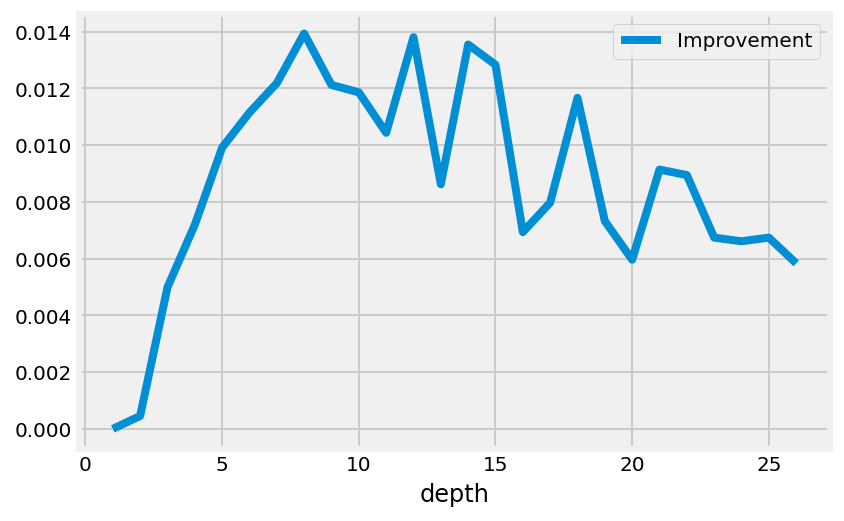

In [215]:
# Show peak for max depth when predicting 'Four_way_Target'

DF_RFC02[DF_RFC02['Target'] == 'Four_way_Target'].sort_values(by = 'depth', ascending = True).set_index('depth')[['Improvement']].plot()

<AxesSubplot:xlabel='depth'>

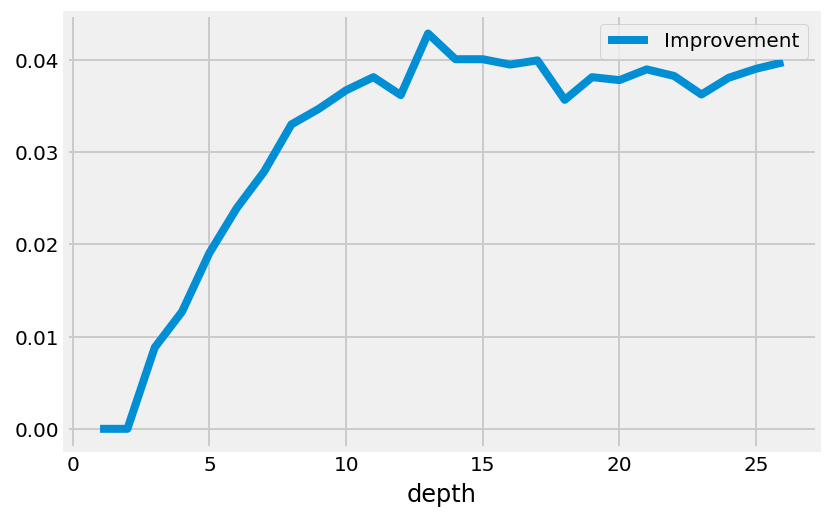

In [216]:
# Show peak for max depth when predicting 'country_02'

DF_RFC02[DF_RFC02['Target'] == 'country_02'].sort_values(by = 'depth', ascending = True).set_index('depth')[['Improvement']].plot()

In [283]:
# Big Grid-Search, takes a few hours, kept code to allow other to replicate
# Saved as CSV file for speed

# DF_Big_Forrest = []


# for target in ['Four_way_Target','country_02']: # ,'country' has nulls
#     for m in range(1,27):
#         for criterio in ['gini', 'entropy']: # 
#             for max_featur in ['auto', 'sqrt', 'log2']: # 
#                 for class_weig in ['balanced', 'balanced_subsample']: # 
#                     DF_Big_Forrest.append(MyRandomForestClassifier04(capst02[twentysix_qs],capst02[target],m,criterio,max_featur,class_weig))
#                     print(MyRandomForestClassifier04(capst02[twentysix_qs],capst02[target],m,criterio,max_featur,class_weig))
    
# print("\nFinished!\nSaved into variable: 'DF_Big_Forrest' but it's not yet a DataFrame")

# # # columns = ['target','max_depth','Score','Baseline','Improvement','criterion','max_features','class_weight']

# DF_Big_Forrest02 = pd.DataFrame(DF_Big_Forrest)
# DF_Big_Forrest02.columns = ['target','max_depth','Score','Baseline','Improvement','criterion','max_features','class_weight']
# DF_Big_Forrest02 = DF_Big_Forrest02.sort_values(by = 'Improvement', ascending = False).reset_index(drop = True)

# DF_Big_Forrest02.to_csv('data\DF_Big_Forrest.csv', index = False)
pd.read_csv('data\DF_Big_Forrest.csv')

target  max_depth     Score  Baseline  Improvement criterion  \
0         country_02         15  0.552978  0.519539     0.033439   entropy   
1         country_02         17  0.551876  0.519539     0.032338      gini   
2         country_02         16  0.551746  0.519539     0.032208      gini   
3         country_02         15  0.551487  0.519539     0.031949      gini   
4         country_02         15  0.551487  0.519539     0.031949      gini   
..               ...        ...       ...       ...          ...       ...   
619  Four_way_Target          1  0.199922  0.390707    -0.190785   entropy   
620  Four_way_Target          1  0.197395  0.390707    -0.193312      gini   
621  Four_way_Target          1  0.197395  0.390707    -0.193312      gini   
622  Four_way_Target          1  0.196552  0.390707    -0.194155   entropy   
623  Four_way_Target          1  0.196552  0.390707    -0.194155   entropy   

    max_features        class_weight  
0           log2  balanced_subsample  
1           log2  balanced_subsample  
2           log2            balanced  
3           auto  balanced_subsample  
4           sqrt  balanced_subsample  
..           ...                 ...  
619         log2  balanced_subsample  
620         sqrt  balanced_subsample  
621         auto  balanced_subsample  
622         auto  balanced_subsample  
623         sqrt  balanced_subsample  

[624 rows x 8 columns]

In [218]:
# pd.concat([DF_Big_Forrest02[DF_Big_Forrest02['target'] == 'country_02'].head(1),DF_Big_Forrest02[DF_Big_Forrest02['target'] == 'Four_way_Target'].head(1)],axis = 0)



# .sort_values(by = 'Improvement', ascending = False)[0:60]

In [219]:
#  Help from Geoff

# Use feature_importances_ within model: MyRandomForestClassifier to determine 
# which of the 26 questions have the strongest signal
# This can replace the preceeding idea of using ch2 and f_classif

# sorted_idx = rf.feature_importances_.argsort()
# plt.barh(boston.feature_names[sorted_idx], rf.feature_importances_[sorted_idx])
# plt.xlabel("Random Forest Feature Importance")



['Q23',
 'Q24',
 'Q20',
 'Q12',
 'Q4',
 'Q22',
 'Q13',
 'Q9',
 'Q10',
 'Q26',
 'Q1',
 'Q8',
 'Q21',
 'Q5',
 'Q18',
 'Q7',
 'Q6',
 'Q19',
 'Q25',
 'Q15',
 'Q16',
 'Q14',
 'Q3',
 'Q11',
 'Q17',
 'Q2']

['I am quick to understand things.',
 'I am interested in economics.',
 'I do not need others praise.',
 'I like science fiction.',
 'I follow politics.',
 'I am just an ordinary person.',
 'I boss people around.',
 'I like working with words.',
 'I hate to throw away books.',
 'I wanted to be an astronaut at one point.',
 'I have read an absurd number of books.',
 'I have a rich vocabulary.',
 'I find too much thinking exhausting.',
 'I like simple work.',
 'I miss my childhood.',
 'I use difficult words.',
 'I would rather read a book than go to a party.',
 'I try to outdo others.',
 'I sometimes ruin my jokes by laughing in the middle of them.',
 'My favorite characters tend to be villains.',
 'I am nerdy.',
 'I would stay in school forever if I could.',
 'I love to read challenging material.',
 'I am the kind of person who might write a Wikipedia article.',
 'I would want a dog that bit me put down.',
 'I have traveled alone in a foreign country.']

[0.018447366909731696,
 0.020556680622279437,
 0.021232798801476487,
 0.021516828958943267,
 0.021557956141265718,
 0.02167839185588186,
 0.022469210621169713,
 0.022493236921306288,
 0.02417759729059259,
 0.02518060587621767,
 0.025543540957438778,
 0.02600821170582459,
 0.02634115561682546,
 0.026431155344637646,
 0.0278290890200182,
 0.030923778232469504,
 0.03167997499108018,
 0.03306953852195321,
 0.03731817070174176,
 0.038897979363646834,
 0.04384464754367136,
 0.04543485908729002,
 0.05351572198008995,
 0.07369447656342613,
 0.10447593956226704,
 0.15568108680875473]

feature                                      Question_long  \
0       Q2        I have traveled alone in a foreign country.   
1      Q17           I would want a dog that bit me put down.   
2      Q11  I am the kind of person who might write a Wiki...   
3       Q3               I love to read challenging material.   
4      Q14         I would stay in school forever if I could.   
5      Q16                                        I am nerdy.   
6      Q15        My favorite characters tend to be villains.   
7      Q25  I sometimes ruin my jokes by laughing in the m...   
8      Q19                             I try to outdo others.   
9       Q6     I would rather read a book than go to a party.   
10      Q7                             I use difficult words.   
11     Q18                               I miss my childhood.   
12      Q5                                I like simple work.   
13     Q21               I find too much thinking exhausting.   
14      Q8                          I have a rich vocabulary.   
15      Q1             I have read an absurd number of books.   
16     Q26          I wanted to be an astronaut at one point.   
17     Q10                        I hate to throw away books.   
18      Q9                         I like working with words.   
19     Q13                              I boss people around.   
20     Q22                      I am just an ordinary person.   
21      Q4                                 I follow politics.   
22     Q12                            I like science fiction.   
23     Q20                       I do not need others praise.   
24     Q24                      I am interested in economics.   
25     Q23                   I am quick to understand things.   

    feature_importances_  
0               0.155681  
1               0.104476  
2               0.073694  
3               0.053516  
4               0.045435  
5               0.043845  
6               0.038898  
7               0.037318  
8               0.033070  
9               0.031680  
10              0.030924  
11              0.027829  
12              0.026431  
13              0.026341  
14              0.026008  
15              0.025544  
16              0.025181  
17              0.024178  
18              0.022493  
19              0.022469  
20              0.021678  
21              0.021558  
22              0.021517  
23              0.021233  
24              0.020557  
25              0.018447

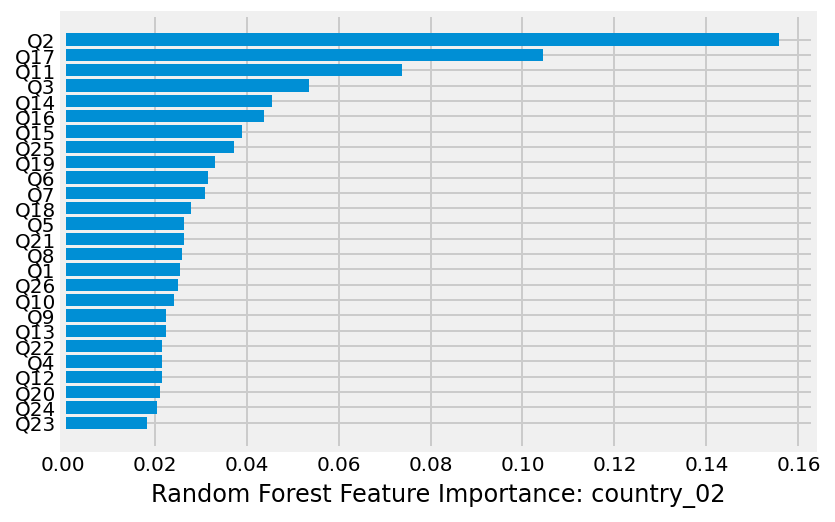

In [300]:
# Uncomment each line to see the table, copy-paste into slideshot

MyRandomForestClassifier_feat_imp_0(capst02[twentysix_qs], capst02['country_02'],8)
# MyRandomForestClassifier_feat_imp_DF(capst02[twentysix_qs], capst02['country_02'],8)
# MyRandomForestClassifier_feat_imp_chart(capst02[twentysix_qs], capst02['country_02'],8)


# MyRandomForestClassifier_feat_imp_0(capst02[twentysix_qs], capst02['Four_way_Target'],8)
# MyRandomForestClassifier_feat_imp_DF(capst02[twentysix_qs], capst02['Four_way_Target'],8)
# MyRandomForestClassifier_feat_imp_chart(capst02[twentysix_qs], capst02['Four_way_Target'],8)




In [221]:
# Show a table with predict_proba using RandomForestClassifier
# Manually compoare how close the first and second highest productions were


DF_predict_proba_tercile = MyRandomForestClassifier(capst02[twentysix_qs], capst02['Four_way_Target'],8)


# DF_predict_proba_tercile.columns = list(capst02['Four_way_Target'].unique())
DF_predict_proba_tercile[120:130]
# DF_predict_proba_tercile[DF_predict_proba_tercile['prediction'] == 'Middle_Tercile']

# At first wasn't sure what order the first column-names are supposed to be in
#     Solution: use .classes_ to name the columnsm this way the order matches

Middle_Tercile  Oldest_Tercile  Only_Child  Youngest_Tercile  \
120        0.176982        0.405475    0.113294          0.304248   
121        0.197369        0.349092    0.087368          0.366171   
122        0.156876        0.369883    0.127778          0.345462   
123        0.155785        0.408880    0.121674          0.313660   
124        0.199441        0.355543    0.106063          0.338952   
125        0.187381        0.319911    0.104739          0.387969   
126        0.185695        0.366614    0.102199          0.345492   
127        0.188237        0.374251    0.095427          0.342085   
128        0.149741        0.402897    0.123281          0.324081   
129        0.138245        0.432206    0.127110          0.302440   

           prediction            answer  
120    Oldest_Tercile  Youngest_Tercile  
121  Youngest_Tercile  Youngest_Tercile  
122    Oldest_Tercile  Youngest_Tercile  
123    Oldest_Tercile    Middle_Tercile  
124    Oldest_Tercile    Middle_Tercile  
125  Youngest_Tercile    Oldest_Tercile  
126    Oldest_Tercile    Oldest_Tercile  
127    Oldest_Tercile  Youngest_Tercile  
128    Oldest_Tercile    Oldest_Tercile  
129    Oldest_Tercile  Youngest_Tercile

In [222]:
# Conduct a GridSearch for the RandomForestClassifier ETA: 57 mins

# MyRandomForestClassifier02(capst02[twentysix_qs+country_dummies_capst02], capst02['Four_way_Target'])

# No more need to execute this because there's an ever more 
# comprehensive GridSearch using nested for-loops and a save csv file

In [223]:
# Try predicting with just the five questions with teh strongest signal accorind to RFC's feature_importance_

capst02[five_qs+country_dummies_capst02]


Q1  Q13  Q17  Q16  Q10  country_02_AU  country_02_CA  country_02_GB  \
0       4    1    1    3    5              0              0              0   
1       5    1    3    3    5              0              0              0   
3       2    2    1    3    5              0              0              0   
4       2    4    1    3    5              0              0              0   
5       5    5    1    4    5              0              0              0   
...    ..  ...  ...  ...  ...            ...            ...            ...   
41836   2    2    2    4    4              0              1              0   
41837   2    2    2    2    4              0              0              0   
41838   4    1    1    5    5              0              0              0   
41839   5    2    1    2    5              0              0              1   
41840   3    5    5    4    5              0              0              0   

       country_02_Other  country_02_US  
0                     1              0  
1                     1              0  
3                     0              1  
4                     0              1  
5                     0              1  
...                 ...            ...  
41836                 0              0  
41837                 0              1  
41838                 0              1  
41839                 0              0  
41840                 0              1  

[40398 rows x 10 columns]

In [224]:
# Find out which max_depth works best  

# Test out the function built above


# DF_RF = pd.DataFrame([['max_depth','score','baseline','score-baseline']])
# DF_RF.columns = ['max_depth','score','baseline','score-baseline']



# X = capst02[twentysix_qs]

# y = capst02['Four_way_Target'] x 4
# y = capst02['country_02'] x 4

# ------------------
DF_RF = []
for x in range(1,27):
#     DF_RF.append(MyRandomForestClassifier03(capst02[twentysix_qs], capst02['Four_way_Target'],x)) # NO Country dummies
    DF_RF.append(MyRandomForestClassifier03(capst02[five_qs+country_dummies_capst02], capst02['Four_way_Target'],x)) # Add Country dummies
DF_RF = pd.DataFrame(DF_RF) # ValueError: Must pass 2-d input. shape=(26, 15431, 6)




target  max_depth     score  baseline  score-baseline
0   Four_way_Target          1  0.390707  0.390707        0.000000
1   Four_way_Target          2  0.390707  0.390707        0.000000
2   Four_way_Target          3  0.395827  0.390707        0.005120
3   Four_way_Target          4  0.397317  0.390707        0.006610
4   Four_way_Target          5  0.398613  0.390707        0.007906
5   Four_way_Target          6  0.398743  0.390707        0.008036
6   Four_way_Target          7  0.398613  0.390707        0.007906
7   Four_way_Target          8  0.399326  0.390707        0.008619
8   Four_way_Target          9  0.397187  0.390707        0.006480
9   Four_way_Target         10  0.396151  0.390707        0.005444
10  Four_way_Target         11  0.390707  0.390707        0.000000
11  Four_way_Target         12  0.385782  0.390707       -0.004925
12  Four_way_Target         13  0.376968  0.390707       -0.013739
13  Four_way_Target         14  0.367961  0.390707       -0.022746
14  Four_way_Target         15  0.365044  0.390707       -0.025663
15  Four_way_Target         16  0.361480  0.390707       -0.029227
16  Four_way_Target         17  0.358758  0.390707       -0.031949
17  Four_way_Target         18  0.357203  0.390707       -0.033504
18  Four_way_Target         19  0.358110  0.390707       -0.032597
19  Four_way_Target         20  0.355648  0.390707       -0.035059
20  Four_way_Target         21  0.356944  0.390707       -0.033763
21  Four_way_Target         22  0.356620  0.390707       -0.034087
22  Four_way_Target         23  0.355907  0.390707       -0.034800
23  Four_way_Target         24  0.356490  0.390707       -0.034217
24  Four_way_Target         25  0.356166  0.390707       -0.034541
25  Four_way_Target         26  0.356166  0.390707       -0.034541

<AxesSubplot:>

[0.008619013673773601, 7]

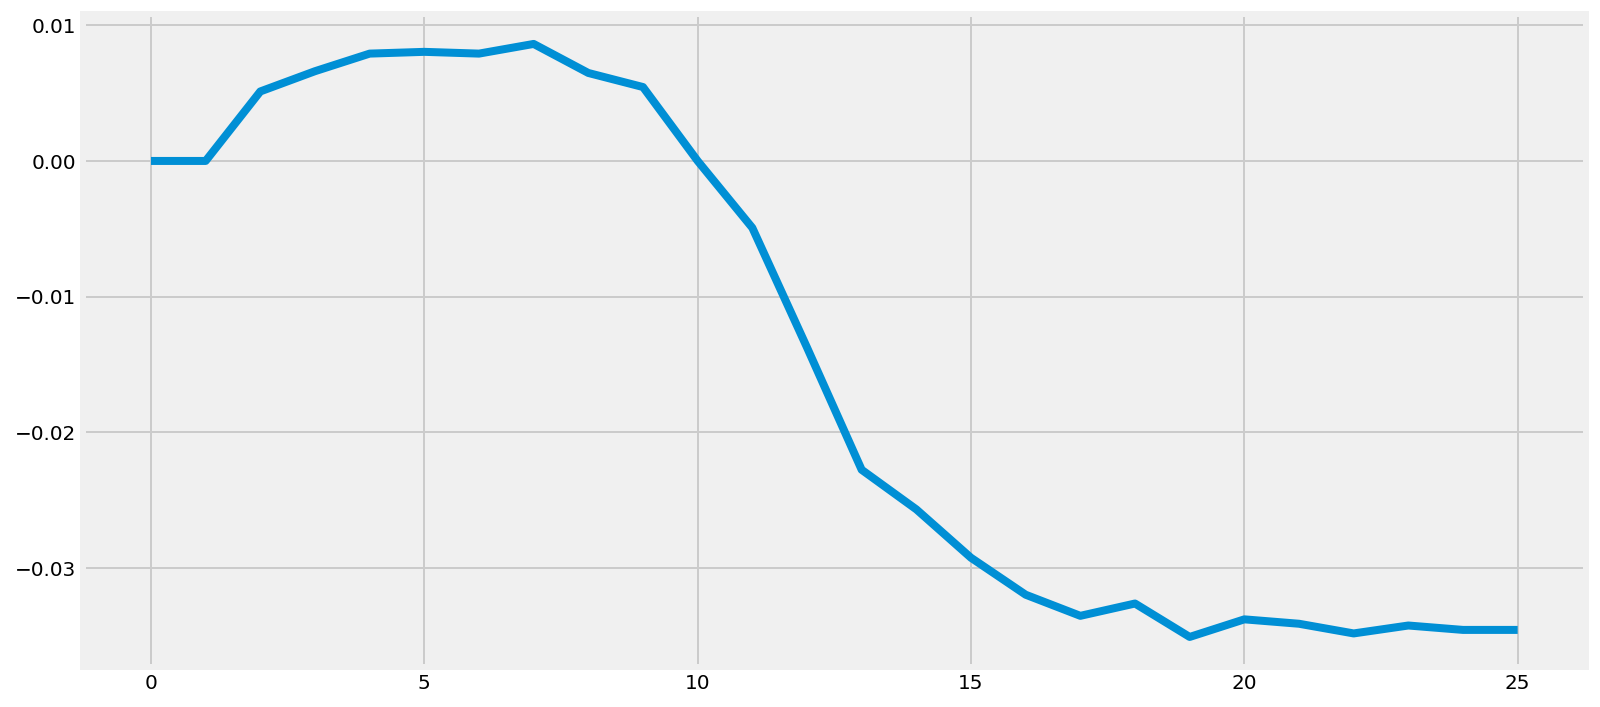

In [225]:
DF_RF.columns = ['target','max_depth','score','baseline','score-baseline']
# ------------------

# MyRandomForestClassifier(capst02[twentysix_qs], capst02['Four_way_Target'],8)

display(
    DF_RF,
    DF_RF['score-baseline'].plot(figsize = (12,6)),
    get_max_index(list(DF_RF['score-baseline']))
    )

# TypeError: RandomForestClassifier() missing 3 required positional arguments: 'X', 'y', and 'n'


# These are the scores above-baseline and their optimal max_depth minus 1
# [0.013932992029032476, 7] # NO Country dummies
# [0.012312876676819406, 6] # Add Country dummies
# [0.009007841358304736, 4] # Just the top 5 questions and country dummies

target  max_depth     score  baseline  score-baseline
0  Four_way_Target          1  0.390707  0.390707        0.000000
1  Four_way_Target          2  0.395049  0.390707        0.004342
2  Four_way_Target          3  0.395956  0.390707        0.005249
3  Four_way_Target          4  0.400687  0.390707        0.009980
4  Four_way_Target          5  0.401076  0.390707        0.010369

<AxesSubplot:>

[0.008619013673773601, 7]

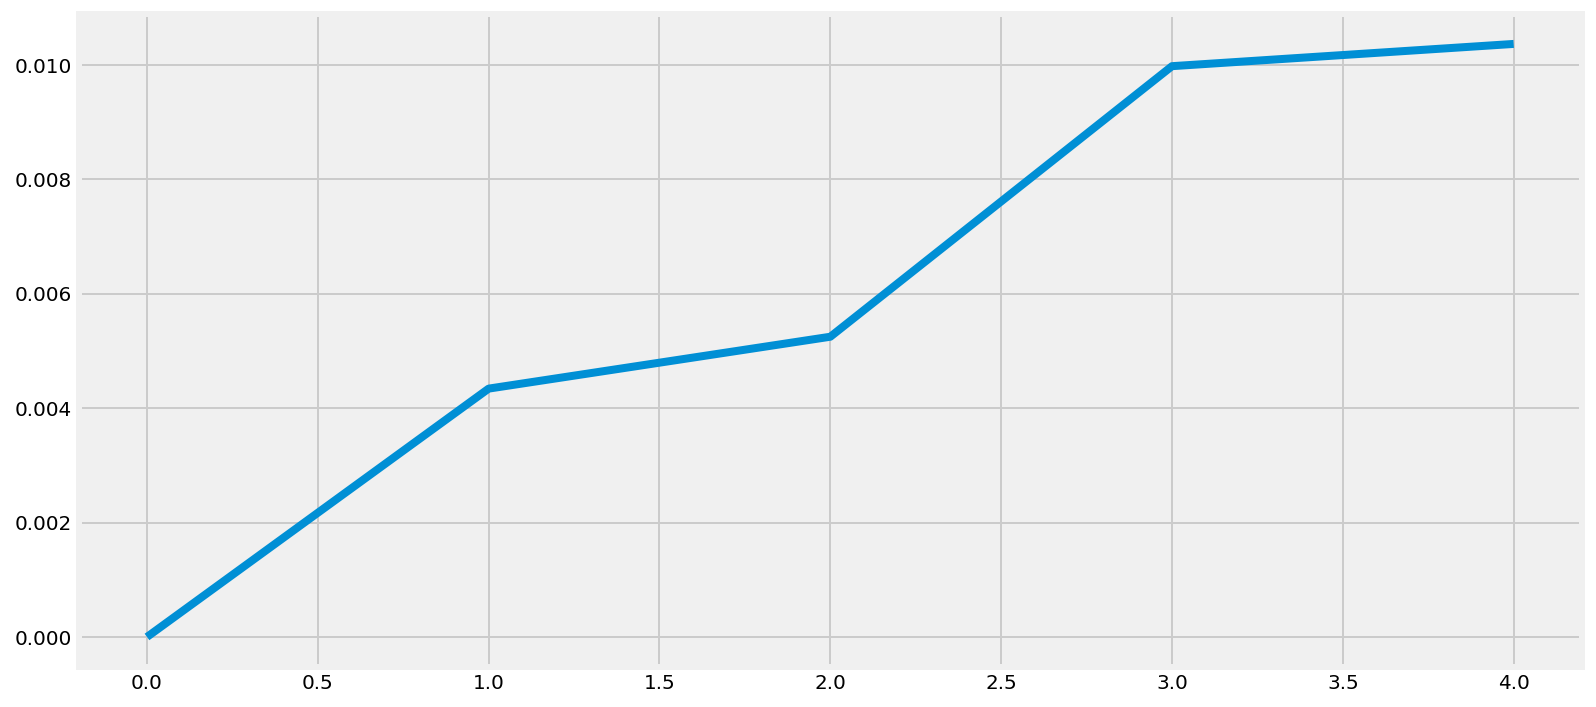

In [226]:
# RandomForestClassifier with 5 questions

# Find out which max_depth works best for 

# Test out the function built above


# DF_RF = pd.DataFrame([['max_depth','score','baseline','score-baseline']])
# DF_RF.columns = ['max_depth','score','baseline','score-baseline']



# X = capst02[twentysix_qs]
# y = capst02['Four_way_Target']

# ------------------
DF_RF_5q = []
for x in range(1,6):
    DF_RF_5q.append(MyRandomForestClassifier03(capst02[five_qs], capst02['Four_way_Target'],x))  
DF_RF_5q = pd.DataFrame(DF_RF_5q) # ValueError: Must pass 2-d input. shape=(26, 15431, 6)
DF_RF_5q.columns = ['target','max_depth','score','baseline','score-baseline']
# ------------------

# MyRandomForestClassifier(capst02[twentysix_qs], capst02['Four_way_Target'],8)

display(
    DF_RF_5q,
    DF_RF_5q['score-baseline'].plot(figsize = (12,6)),
    get_max_index(list(DF_RF['score-baseline']))
    )


# Reducing the predictive features to just the strongest 5 questions will help us beat the baseline by 0.010369
# Whe  dealing with only five features, the score seems to increase with the the most depth of trees

In [227]:
# Find out which max_depth works best for 
    # WITH UP sampling


    # Commented out to save time


# DF_RF_ups = []
# for x in range(1,27):
#     DF_RF.append(MyRandomForestClassifier03_ups(capst02[twentysix_qs], capst02['Four_way_Target'],x))  
# DF_RF_ups = pd.DataFrame(DF_RF) # ValueError: Must pass 2-d input. shape=(26, 15431, 6)

# DF_RF_ups.columns = ['target','max_depth','score','baseline','score-baseline']

# DF_RF_ups.to_csv('data\DF_RF_ups.csv', index = False)



In [284]:

DF_RF_ups_saved = pd.read_csv('data\DF_RF_ups.csv')
DF_RF_ups_saved

target  max_depth     score  baseline  score-baseline
0   Four_way_Target          1  0.390707  0.390707        0.000000
1   Four_way_Target          2  0.390707  0.390707        0.000000
2   Four_way_Target          3  0.395827  0.390707        0.005120
3   Four_way_Target          4  0.397317  0.390707        0.006610
4   Four_way_Target          5  0.398613  0.390707        0.007906
5   Four_way_Target          6  0.398743  0.390707        0.008036
6   Four_way_Target          7  0.398613  0.390707        0.007906
7   Four_way_Target          8  0.399326  0.390707        0.008619
8   Four_way_Target          9  0.397187  0.390707        0.006480
9   Four_way_Target         10  0.396151  0.390707        0.005444
10  Four_way_Target         11  0.390707  0.390707        0.000000
11  Four_way_Target         12  0.385782  0.390707       -0.004925
12  Four_way_Target         13  0.376968  0.390707       -0.013739
13  Four_way_Target         14  0.367961  0.390707       -0.022746
14  Four_way_Target         15  0.365044  0.390707       -0.025663
15  Four_way_Target         16  0.361480  0.390707       -0.029227
16  Four_way_Target         17  0.358758  0.390707       -0.031949
17  Four_way_Target         18  0.357203  0.390707       -0.033504
18  Four_way_Target         19  0.358110  0.390707       -0.032597
19  Four_way_Target         20  0.355648  0.390707       -0.035059
20  Four_way_Target         21  0.356944  0.390707       -0.033763
21  Four_way_Target         22  0.356620  0.390707       -0.034087
22  Four_way_Target         23  0.355907  0.390707       -0.034800
23  Four_way_Target         24  0.356490  0.390707       -0.034217
24  Four_way_Target         25  0.356166  0.390707       -0.034541
25  Four_way_Target         26  0.356166  0.390707       -0.034541

target  max_depth     score  baseline  score-baseline
0   Four_way_Target          1  0.390707  0.390707        0.000000
1   Four_way_Target          2  0.390707  0.390707        0.000000
2   Four_way_Target          3  0.395827  0.390707        0.005120
3   Four_way_Target          4  0.397317  0.390707        0.006610
4   Four_way_Target          5  0.398613  0.390707        0.007906
5   Four_way_Target          6  0.398743  0.390707        0.008036
6   Four_way_Target          7  0.398613  0.390707        0.007906
7   Four_way_Target          8  0.399326  0.390707        0.008619
8   Four_way_Target          9  0.397187  0.390707        0.006480
9   Four_way_Target         10  0.396151  0.390707        0.005444
10  Four_way_Target         11  0.390707  0.390707        0.000000
11  Four_way_Target         12  0.385782  0.390707       -0.004925
12  Four_way_Target         13  0.376968  0.390707       -0.013739
13  Four_way_Target         14  0.367961  0.390707       -0.022746
14  Four_way_Target         15  0.365044  0.390707       -0.025663
15  Four_way_Target         16  0.361480  0.390707       -0.029227
16  Four_way_Target         17  0.358758  0.390707       -0.031949
17  Four_way_Target         18  0.357203  0.390707       -0.033504
18  Four_way_Target         19  0.358110  0.390707       -0.032597
19  Four_way_Target         20  0.355648  0.390707       -0.035059
20  Four_way_Target         21  0.356944  0.390707       -0.033763
21  Four_way_Target         22  0.356620  0.390707       -0.034087
22  Four_way_Target         23  0.355907  0.390707       -0.034800
23  Four_way_Target         24  0.356490  0.390707       -0.034217
24  Four_way_Target         25  0.356166  0.390707       -0.034541
25  Four_way_Target         26  0.356166  0.390707       -0.034541

<AxesSubplot:>

[0.0086190136737736, 7]

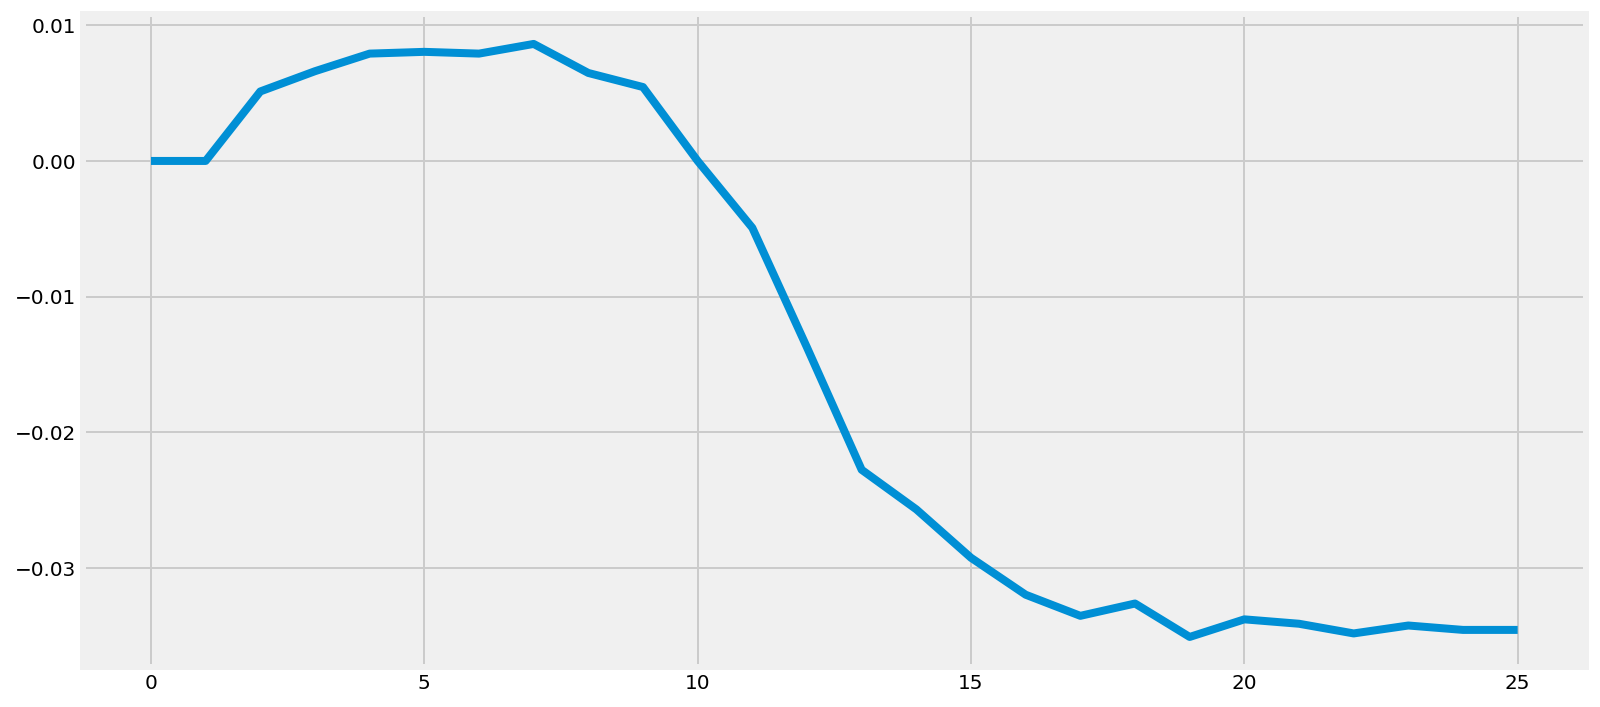

In [229]:



display(
    DF_RF_ups_saved,
    DF_RF_ups_saved['score-baseline'].plot(figsize = (12,6)),
    get_max_index(list(DF_RF_ups_saved['score-baseline']))
    )


# Upsampling makes no change on descision tree
#     Might check if Upsampling effects SVM at all 

In [291]:
# # Try it out with countries

# # Saved as CSV and commented out to save time

# DF_RF_country = []
# for x in range(1,27):
#     DF_RF_country.append(MyRandomForestClassifier03(capst02[twentysix_qs], capst02['country_02'],x))  
# DF_RF_country = pd.DataFrame(DF_RF)
# DF_RF_country.columns = ['target','max_depth','score','baseline','score-baseline']
# DF_RF_country.to_csv('data\DF_RF_country', index = False)



target  max_depth     score  baseline  score-baseline
0   Four_way_Target          1  0.390707  0.390707        0.000000
1   Four_way_Target          2  0.390707  0.390707        0.000000
2   Four_way_Target          3  0.395827  0.390707        0.005120
3   Four_way_Target          4  0.397317  0.390707        0.006610
4   Four_way_Target          5  0.398613  0.390707        0.007906
5   Four_way_Target          6  0.398743  0.390707        0.008036
6   Four_way_Target          7  0.398613  0.390707        0.007906
7   Four_way_Target          8  0.399326  0.390707        0.008619
8   Four_way_Target          9  0.397187  0.390707        0.006480
9   Four_way_Target         10  0.396151  0.390707        0.005444
10  Four_way_Target         11  0.390707  0.390707        0.000000
11  Four_way_Target         12  0.385782  0.390707       -0.004925
12  Four_way_Target         13  0.376968  0.390707       -0.013739
13  Four_way_Target         14  0.367961  0.390707       -0.022746
14  Four_way_Target         15  0.365044  0.390707       -0.025663
15  Four_way_Target         16  0.361480  0.390707       -0.029227
16  Four_way_Target         17  0.358758  0.390707       -0.031949
17  Four_way_Target         18  0.357203  0.390707       -0.033504
18  Four_way_Target         19  0.358110  0.390707       -0.032597
19  Four_way_Target         20  0.355648  0.390707       -0.035059
20  Four_way_Target         21  0.356944  0.390707       -0.033763
21  Four_way_Target         22  0.356620  0.390707       -0.034087
22  Four_way_Target         23  0.355907  0.390707       -0.034800
23  Four_way_Target         24  0.356490  0.390707       -0.034217
24  Four_way_Target         25  0.356166  0.390707       -0.034541
25  Four_way_Target         26  0.356166  0.390707       -0.034541

<AxesSubplot:>

[0.0086190136737736, 7]

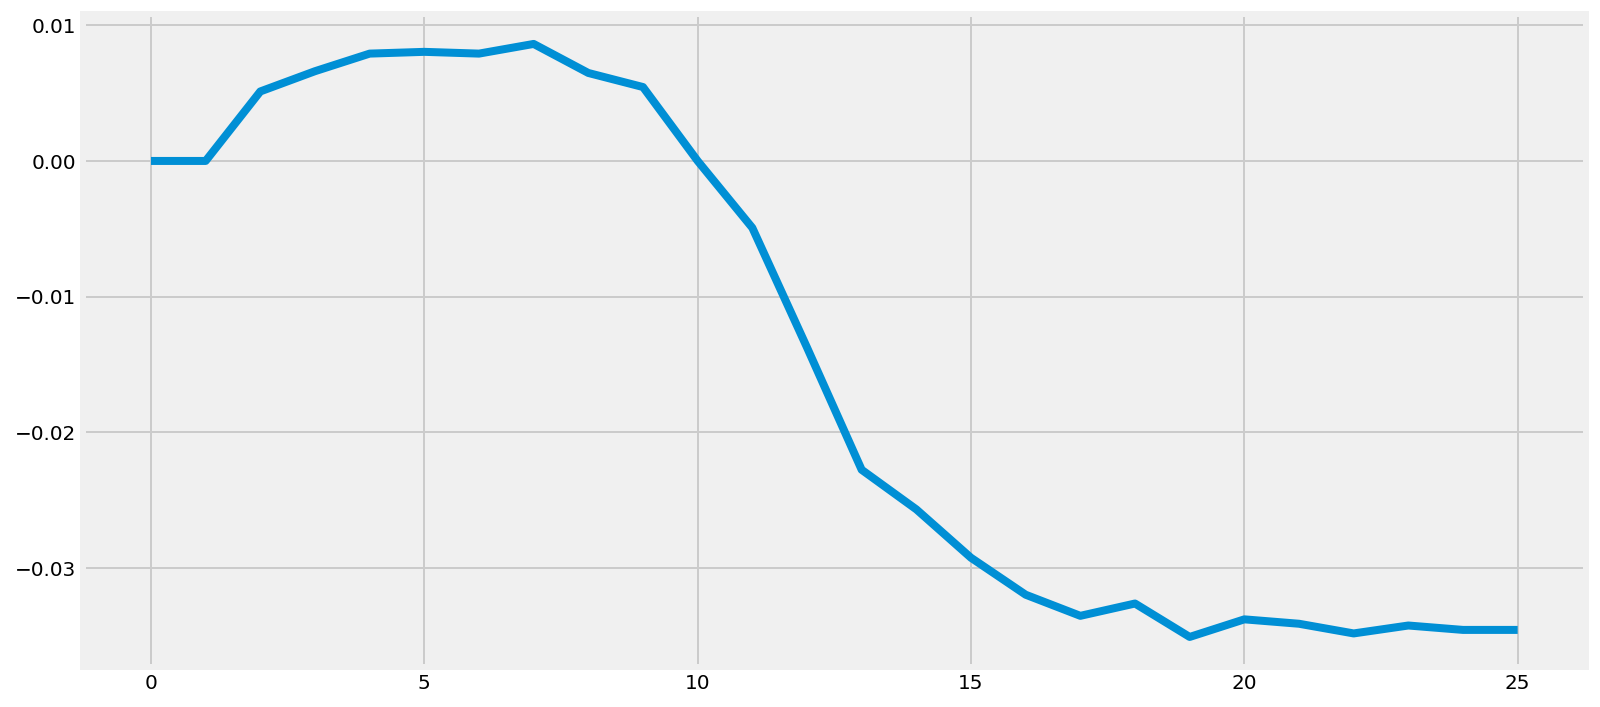

In [292]:
# Show DataFrame and visualisation for the optimal max_depth for RandomForestClassifier

DF_RF_country_saved = pd.read_csv('data\DF_RF_country')

display(
    DF_RF_country_saved,
    DF_RF_country_saved['score-baseline'].plot(figsize = (12,6)),
    get_max_index(list(DF_RF_country_saved['score-baseline']))
    )
    
    

In [232]:
# Show a table with predict_proba using RandomForestClassifier
# Manually compoare how close the first and second highest productions were



DF_predict_proba_country = MyRandomForestClassifier(capst02[twentysix_qs], capst02['country_02'],8)

# DF_predict_proba_tercile.columns = list(capst02['Four_way_Target'].unique())
DF_predict_proba_country[10:70]

# At first wasn't sure what order the first column-names are supposed to be in
#     Solution: use .classes_ to name the columnsm this way the order matches

AU        CA        GB     Other        US prediction answer
10  0.055574  0.057069  0.053476  0.230872  0.603010         US  Other
11  0.046610  0.062365  0.056861  0.219176  0.614988         US     US
12  0.048645  0.055022  0.052832  0.341069  0.502432         US     US
13  0.049194  0.061268  0.071851  0.338995  0.478692         US  Other
14  0.065906  0.068870  0.069950  0.371180  0.424094         US  Other
15  0.063115  0.059673  0.078840  0.293948  0.504424         US     CA
16  0.049789  0.050033  0.045818  0.426112  0.428249         US     US
17  0.043663  0.058363  0.058588  0.278904  0.560482         US  Other
18  0.047740  0.053093  0.065497  0.172813  0.660858         US  Other
19  0.038384  0.052672  0.055749  0.366175  0.487020         US     US
20  0.040091  0.051762  0.047056  0.418997  0.442094         US  Other
21  0.037854  0.065882  0.049665  0.295934  0.550665         US     US
22  0.053078  0.055902  0.072642  0.425456  0.392922      Other     US
23  0.065156  0.066715  0.071767  0.310869  0.485493         US     US
24  0.040063  0.063004  0.045928  0.262832  0.588173         US     AU
25  0.063164  0.054231  0.099608  0.375685  0.407313         US     US
26  0.049841  0.057756  0.051602  0.283931  0.556869         US     US
27  0.034611  0.081553  0.067067  0.321043  0.495726         US  Other
28  0.048564  0.051414  0.047812  0.225511  0.626700         US  Other
29  0.054938  0.051938  0.041849  0.362771  0.488504         US  Other
30  0.046933  0.064715  0.051638  0.320190  0.516523         US     US
31  0.054242  0.058380  0.070707  0.445643  0.371028      Other  Other
32  0.043596  0.057791  0.048999  0.150810  0.698804         US     US
33  0.040099  0.053156  0.061813  0.228201  0.616731         US     US
34  0.039182  0.063252  0.048589  0.183676  0.665301         US     US
35  0.044369  0.061656  0.069306  0.432848  0.391821      Other     GB
36  0.041151  0.058841  0.047918  0.280606  0.571484         US  Other
37  0.049238  0.061779  0.054579  0.419086  0.415318      Other     US
38  0.051605  0.056939  0.056536  0.204704  0.630216         US     US
39  0.037841  0.061947  0.046582  0.243321  0.610310         US     US
40  0.051568  0.059038  0.064114  0.226324  0.598957         US     US
41  0.047880  0.059185  0.048391  0.272559  0.571985         US     US
42  0.047400  0.057118  0.046850  0.245777  0.602855         US     US
43  0.037017  0.070762  0.045460  0.255011  0.591751         US     US
44  0.071140  0.060334  0.078104  0.309608  0.480814         US     US
45  0.041995  0.059014  0.051979  0.356933  0.490079         US     US
46  0.043610  0.041462  0.058016  0.343999  0.512913         US     CA
47  0.052489  0.065762  0.049029  0.201361  0.631360         US     US
48  0.049368  0.058270  0.071360  0.406425  0.414577         US     US
49  0.040113  0.067459  0.046316  0.287429  0.558683         US     US
50  0.045250  0.046494  0.042485  0.486711  0.379060      Other  Other
51  0.069027  0.051501  0.080901  0.350690  0.447881         US     AU
52  0.053362  0.061455  0.055573  0.296925  0.532685         US     US
53  0.061131  0.058521  0.065133  0.446456  0.368759      Other     CA
54  0.058590  0.065835  0.070405  0.311385  0.493786         US     US
55  0.049782  0.055039  0.046444  0.194968  0.653767         US     GB
56  0.061277  0.049219  0.065933  0.451446  0.372124      Other     CA
57  0.048245  0.074205  0.084538  0.289579  0.503433         US     US
58  0.068795  0.067459  0.093906  0.374011  0.395829         US     AU
59  0.048992  0.061309  0.067688  0.380393  0.441618         US  Other
60  0.045016  0.057615  0.051441  0.453441  0.392487      Other     AU
61  0.052940  0.063873  0.057964  0.282501  0.542723         US     CA
62  0.048631  0.062380  0.042652  0.334216  0.512120         US     US
63  0.038404  0.050680  0.043982  0.128712  0.738223         US     US
64  0.043285  0.056772  0.044283  0.198736  0.656924         US     AU
65  0.046832  0.056982  0.051669  

In [233]:
# X = capst02[twentysix_qs]
# y = capst02['Four_way_Target']

In [234]:
# Build a function to try out some SVMs


def SVC_linear(X,y,c_v,kernel_):
    
    '''
    Takes Feature DataFrame and Target column
    Standardises Feature DataFrame
    Conducts a train_test_split
    NO upsampling
    
    Fits an SVC acoorinding to specifies kernel and amount of cross-validations
    
    dsi-unit-3.41-svm-support_vector_machines-lab
    '''
    from sklearn.preprocessing import StandardScaler
    
    Xn = StandardScaler().fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=phi_2, random_state=round(100*phi_0))
        
    
    lin_model = SVC(kernel=kernel_)
#     kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}
#     can't use 'precomputed' because the data need to be a square
    
    lin_model.fit(X_train, y_train)
    
    return [kernel_,c_v,lin_model.score(X_test, y_test),base_acc(y_test),lin_model.score(X_test, y_test)-base_acc(y_test)]
    
    
    

In [235]:
# Build a function to try out some SVMs


def SVC_linear_ups(X,y,c_v,kernel_):
    
    '''
    Takes Feature DataFrame and Target column
    Standardises Feature DataFrame
    Conducts a train_test_split
    WITH upsampling
    
    Fits an SVC acoorinding to specifies kernel and amount of cross-validations
    
    dsi-unit-3.41-svm-support_vector_machines-lab
    '''
    from sklearn.preprocessing import StandardScaler
    
    Xn = StandardScaler().fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=phi_2, random_state=round(100*phi_0))
    
    
    
    lin_model = SVC(kernel=kernel_)
#     kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}
    
    
    
    lin_model.fit(upsampler(X_train, y_train,"X"),upsampler(X_train, y_train,"y"))
    
    return [kernel_,c_v,lin_model.score(X_test, y_test),base_acc(y_test),lin_model.score(X_test, y_test)-base_acc(y_test)]
    
    
    
#     scores = cross_val_score(lin_model, Xn, y, cv = c_v)
#     sm = scores.mean()
#     ss = scores.std()
    
    

In [236]:


# IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


# SVC_linear(capst02[twentysix_qs],capst02['Four_way_Target'],5)


    
# for kern in ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']: # ValueError: Precomputed matrix must be a square matrix.


# IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices



In [237]:
# Run a for-loop as  gridsearch for the different kernels
#     This if for when Target is 'Four_way_Target'


# for kern in ['linear', 'poly', 'rbf', 'sigmoid']:
#     print(SVC_linear(capst02[twentysix_qs],capst02['Four_way_Target'],5,kern)) # this is NO UpSampling

# Copy-Pasted the results in-text and turned into a DataFrame for speed
# Left the above code to allow others to replicate

In [238]:
# Run a for-loop as  gridsearch for the different kernels
#     This if for when Target is ['country_02'


# for kern in ['linear', 'poly', 'rbf', 'sigmoid']:
#     print(SVC_linear_ups(capst02[twentysix_qs],capst02['country_02'],5,kern)) # this is WITH UpSampling

# Copy-Pasted the results in-text and turned into a DataFrame for speed
# Left the above code to allow others to replicate

In [239]:
# This is the cell to store the results for the long round of grid-searching
# This is when the target was capst02['Four_way_Target']


DF_SVC_tercile = pd.DataFrame(
[['linear', 5, 0.4128053917438922, 0.40379755038558746, 0.009007841358304736],
['poly', 5, 0.3962802151513188, 0.40379755038558746, -0.007517335234268674],
['rbf', 5, 0.40807465491543, 0.40379755038558746, 0.004277104529842535],
['sigmoid', 5, 0.3234398289158188, 0.40379755038558746, -0.08035772146976866]]
    )

DF_SVC_tercile.columns = ['kernel','cv','score','base_acc','improvement']
print("This is when the target was capst02['Four_way_Target']")
DF_SVC_tercile['target'] =  'Four_way_Target'
DF_SVC_tercile

This is when the target was capst02['Four_way_Target']


kernel  cv     score  base_acc  improvement           target
0   linear   5  0.412805  0.403798     0.009008  Four_way_Target
1     poly   5  0.396280  0.403798    -0.007517  Four_way_Target
2      rbf   5  0.408075  0.403798     0.004277  Four_way_Target
3  sigmoid   5  0.323440  0.403798    -0.080358  Four_way_Target

In [240]:


# This is the cell to store the results for the long round of grid-searching
# This is when the target was capst02['country_02']


# ['linear', 5, 0.5480526213466399, 0.5216123387985224, 0.026440282548117477]
# ['poly', 5, 0.5407296999546368, 0.5216123387985224, 0.0191173611561144]
# ['rbf', 5, 0.565290648694187, 0.5216123387985224, 0.04367830989566457]
# ['sigmoid', 5, 0.4546691724450781, 0.5216123387985224, -0.06694316635344433]




DF_SVC_country = pd.DataFrame(
[['linear', 5, 0.5480526213466399, 0.5216123387985224, 0.026440282548117477],
['poly', 5, 0.5407296999546368, 0.5216123387985224, 0.0191173611561144],
['rbf', 5, 0.565290648694187, 0.5216123387985224, 0.04367830989566457],
['sigmoid', 5, 0.4546691724450781, 0.5216123387985224, -0.06694316635344433]]
    )

DF_SVC_country.columns = ['kernel','cv','score','base_acc','improvement']
print("This is when the target was capst02['country_02']")
DF_SVC_country['target'] =  'country_02'
DF_SVC_country

This is when the target was capst02['country_02']


kernel  cv     score  base_acc  improvement      target
0   linear   5  0.548053  0.521612     0.026440  country_02
1     poly   5  0.540730  0.521612     0.019117  country_02
2      rbf   5  0.565291  0.521612     0.043678  country_02
3  sigmoid   5  0.454669  0.521612    -0.066943  country_02

In [241]:
# Show all the SVM results alltogether to add to the Powerpoint

# Template for the code:
    # pd.concat([,],axis = 0)

pd.concat([DF_SVC_tercile,DF_SVC_country],axis = 0).sort_values(by = 'improvement', ascending = False).reset_index(drop = True)

kernel  cv     score  base_acc  improvement           target
0      rbf   5  0.565291  0.521612     0.043678       country_02
1   linear   5  0.548053  0.521612     0.026440       country_02
2     poly   5  0.540730  0.521612     0.019117       country_02
3   linear   5  0.412805  0.403798     0.009008  Four_way_Target
4      rbf   5  0.408075  0.403798     0.004277  Four_way_Target
5     poly   5  0.396280  0.403798    -0.007517  Four_way_Target
6  sigmoid   5  0.454669  0.521612    -0.066943       country_02
7  sigmoid   5  0.323440  0.403798    -0.080358  Four_way_Target

Image to explain the kernels
https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_001.png

In [242]:
# Write list comp for for-loop

# [n for n in range(1,len(capst02[twentysix_qs].columns)+1)]

In [243]:
# Try out DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# dsi-unit-4.02-trees-CARTs-lab


# X = capst02[twentysix_qs]
# y = capst02['Four_way_Target']
# y = capst02['country_02']

def MyDecisionTreeClassifier(X,y):
    
    '''
    RFC plus GridSearchCV
    
    Split and fit a given Feature DataFrame and Target
        
    Return a list  of best_estimator_ and scores relative to the baseline accuracy
    
    dsi-unit-4.02-trees-CARTs-lab
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=161)
    
    dtc_params = {
    'max_depth':[n for n in range(1,len(X.columns)+1)],
#     'max_features':[None,'log2','sqrt',2,3,4,5],
#     'max_features':[n for n in range(1,len(X.columns)+1)],
    'max_features':[None],
#     'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
#     'min_samples_split':[n for n in range(2,len(X.columns)+1)]
    'min_samples_split':[2]
        }
    
    dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, verbose=3) #cv=2, # cv defaults to 5
    
    dtc_gs.fit(X_train, y_train)
    
    dtc_best = dtc_gs.best_estimator_
    
    dtc_best.fit(X_train, y_train)
    
    return [dtc_best,dtc_best.score(X_test,y_test),base_acc(y_test),dtc_best.score(X_test,y_test)-base_acc(y_test)]
    




In [244]:
# Run GridSearchCV to predict 'Four_way_Target'

# X = capst02[twentysix_qs]
# y = capst02['Four_way_Target']
# y = capst02['country_02']

# MyDecisionTreeClassifier(capst02[twentysix_qs],capst02['Four_way_Target'])



# [DecisionTreeClassifier(max_depth=3),
#  0.46153846153846156,
#  0.5384615384615384,
#  -0.07692307692307687]

# Performs 0.0769 worse than baseline - leave cell hashed out - Not worth the processing time

In [245]:
# Run GridSearchCV to predict countries


# MyDecisionTreeClassifier(capst02[twentysix_qs],capst02['country_02'])

# Result:
    # [DecisionTreeClassifier(max_depth=2),
    #  0.38461538461538464,
    #  0.6923076923076923,
    #  -0.30769230769230765]
    
# Performs 0.30769 worse than baseline - leave cell hashed out - Not worth the processing time

In [246]:
# Try out RandomForrest with all 26 questions raw answers with UPsampled DataFrame

# X = capst07_Four_way_Target[twentysix_qs]
# y = capst07_Four_way_Target['Four_way_Target']


# All 26 questions with their raw interger answers
# capst07_Four_way_Target_X_train, capst07_Four_way_Target_X_test, capst07_Four_way_Target_y_train, capst07_Four_way_Target_y_test = train_test_split(capst07_Four_way_Target[twentysix_qs], capst07_Four_way_Target['Four_way_Target'], test_size=phi_2, random_state=round(100*phi_0))

# All 26 questions dummified
capst07_Four_way_Target_X_train, capst07_Four_way_Target_X_test, capst07_Four_way_Target_y_train, capst07_Four_way_Target_y_test = train_test_split(pd.get_dummies(capst07_Four_way_Target[twentysix_qs_string]), capst07_Four_way_Target['Four_way_Target'], test_size=phi_2, random_state=round(100*phi_0))


# display(
#         capst07_Four_way_Target_X_train, 
#         capst07_Four_way_Target_X_test, 
#         capst07_Four_way_Target_y_train, 
#         capst07_Four_way_Target_y_test,
#         base_acc(capst07_Four_way_Target_y_train),
#         base_acc(capst07_Four_way_Target_y_test)
#        )

# list_scores_RandomForestClassifier_twentysix_qsRaw_UPsampled_data = []

# # 1 to 26
# # for x in range(1,27):

# # for x in range(1,27): # All 26 questions with their raw interger answers

# for x in range(1,157): # All 26 questions dummified

#     model_equal_Targ_Des_Tercile = RandomForestClassifier(max_depth=x, random_state=161)
#     model_equal_Targ_Des_Tercile.fit(capst07_Four_way_Target_X_train, 
#                                      capst07_Four_way_Target_y_train)

#     # .append
#     list_scores_RandomForestClassifier_twentysix_qsRaw_UPsampled_data.append(model_equal_Targ_Des_Tercile.score(capst07_Four_way_Target_X_test, capst07_Four_way_Target_y_test) - base_acc(capst07_Four_way_Target_y_test))
    

# display(
# list_scores_RandomForestClassifier_twentysix_qsRaw_UPsampled_data,
# get_max_index(list_scores_RandomForestClassifier_twentysix_qsRaw_UPsampled_data),
# pd.DataFrame(list_scores_RandomForestClassifier_twentysix_qsRaw_UPsampled_data).plot()
# )


In [247]:
# Conclusions from the above cell:

    # The highest score (above baseline) is 50.116% when the RandomForestClassifier max_depth=22 with integer answers
    # The highest score (above baseline) is 50.691% when the RandomForestClassifier max_depth=44 with dummified answers


    # Analysis:
    #     Results might only look this good because the upsampling occured before the split, so some rows would be featured in both the traning and testing data

[-0.07854319227529, -0.06143477415591991]

[-0.06143477415591991, 1]

<AxesSubplot:>

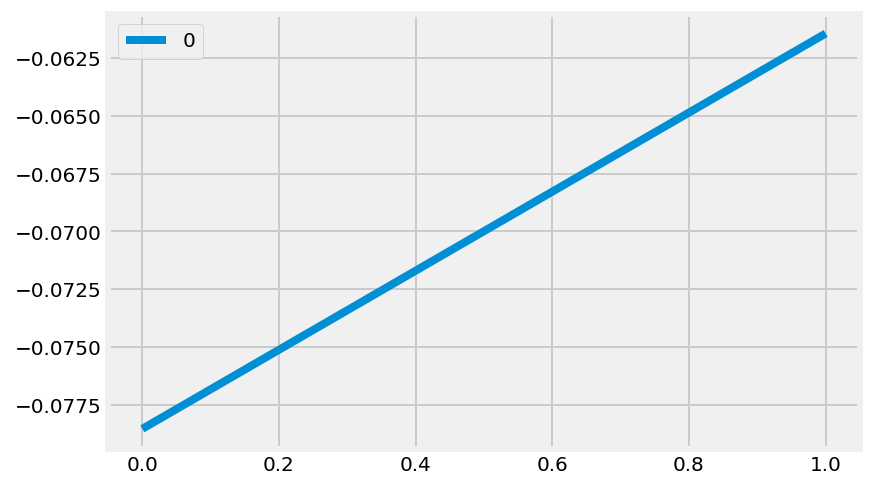

In [248]:
# Time for Random Forrest for 
#     capst02_X_train, 
#     capst02_X_test, 
#     capst02_y_train, 
#     capst02_y_test

list_scores_RandomForestClassifier_splie_before_UPsampled_data = []

# # 1 to 26
# # for x in range(1,27):

# # for x in range(1,27): # All 26 questions with their raw interger answers

for x in range(10,12): # All 26 questions dummified

    model_equal_Targ_Des_Tercile = RandomForestClassifier(max_depth=x, random_state=161)
    model_equal_Targ_Des_Tercile.fit(capst02_X_train, 
                                     capst02_y_train)

    # .append
    list_scores_RandomForestClassifier_splie_before_UPsampled_data.append(model_equal_Targ_Des_Tercile.score(capst02_X_test, capst02_y_test) - base_acc(capst02_y_test))
    

display(
list_scores_RandomForestClassifier_splie_before_UPsampled_data,
get_max_index(list_scores_RandomForestClassifier_splie_before_UPsampled_data),
pd.DataFrame(list_scores_RandomForestClassifier_splie_before_UPsampled_data).plot()
)


# This technique did not even beat the baseline accuracy
#     Lower by 6.14%
#     See if LogRed does any better

In [249]:
# capst02_X_train[twentysix_qs]

In [250]:
# Check again what LogisticRegression can get us

LogReg = LogisticRegression(max_iter = 10000)
    
LogReg.fit(capst02_X_train,capst02_y_train)
#     return LogReg.score(X_test,y_test)-max(y_train.value_counts()/len(y_train))

[LogReg.score(capst02_X_test,capst02_y_test),base_acc(capst02_y_test),LogReg.score(capst02_X_test,capst02_y_test)-base_acc(capst02_y_test)]

[0.2780117944397641, 0.3971874797485581, -0.11917568530879402]

In [251]:
# Show stacked histogram for all answers for the 26 questionsabs

#     This cell is just to find the columns you might need to the stacked histograms

# capst02.columns.to_list()

# 'country_02'
# 'Four_way_Target'

# capst02[twentysix_qs]

In [252]:
# Show stacked histogram for all answers for the 26 questionsabs

#     This cell shows the first category of the stacked histograms


# capst02[twentysix_qs+['country_02']]

# capst02[capst02['country_02'] == 'AU'][twentysix_qs+['country_02']]
# capst02[capst02['country_02'] == 'GB'][twentysix_qs+['country_02']]
# capst02[capst02['country_02'] == 'US'][twentysix_qs+['country_02']]
# capst02[capst02['country_02'] == 'CA'][twentysix_qs+['country_02']]

capst02[twentysix_qs+['country_02']].groupby('country_02')

In [253]:
# Show stacked histogram for all answers for the 26 questionsabs

#     This is cell shows the second category of the stacked histograms
#     dsi-unit-1.11-pandas-grouping-lesson
#     dsi-unit-2.09-eda-visualization_intro-lesson


capst02[twentysix_qs+['Four_way_Target']]

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q18  Q19  Q20  Q21  Q22  \
0       4   4   4   5   5   4   3   4   4    5  ...    5    1    2    1    5   
1       5   5   5   4   2   5   5   5   5    5  ...    3    2    3    1    2   
3       2   1   3   2   4   3   3   3   3    5  ...    1    3    2    3    4   
4       2   1   4   5   2   5   4   4   2    5  ...    5    5    5    4    4   
5       5   1   1   3   2   2   4   3   3    5  ...    2    5    1    2    3   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
41836   2   5   4   4   2   2   3   3   2    4  ...    3    4    3    2    4   
41837   2   2   1   1   4   2   2   3   4    4  ...    5    4    2    4    4   
41838   4   1   4   1   5   5   3   3   4    5  ...    4    1    3    1    5   
41839   5   5   4   4   2   2   2   4   4    5  ...    4    3    2    1    4   
41840   3   1   5   3   1   5   5   5   5    5  ...    5    5    1    4    1   

       Q23  Q24  Q25  Q26   Four_way_Target  
0        3    1    4    1  Youngest_Tercile  
1        5    4    2    3    Oldest_Tercile  
3        3    2    4    4    Oldest_Tercile  
4        4    4    2    1    Oldest_Tercile  
5        5    2    4    1    Oldest_Tercile  
...    ...  ...  ...  ...               ...  
41836    5    5    3    3    Oldest_Tercile  
41837    4    2    4    2    Middle_Tercile  
41838    4    1    4    4    Middle_Tercile  
41839    4    3    3    4    Oldest_Tercile  
41840    4    1    4    5    Middle_Tercile  

[40398 rows x 27 columns]

In [254]:
# q_dict

In [255]:
# Trying out the groupby

# capst02['Q22'].groupby(capst02['Four_way_Target']).value_counts().hist(bins = 5)

# capst02['Q7'].groupby(capst02['Four_way_Target']).value_counts(normalize = True)#.unstack().T.plot(kind = 'bar')
# capst02['Q7'].groupby(capst02['Four_way_Target']).value_counts()#.unstack().T.plot(kind = 'bar')
# capst02['Q7'].groupby(capst02['Four_way_Target']).size()#.unstack().T.plot(kind = 'bar')

# capst02[['Q7','Four_way_Target']].groupby(['Four_way_Target','Q7']).size().unstack().T.plot(kind = 'bar')
# capst02[['Q7','Four_way_Target']].groupby(['Four_way_Target','Q7']).value_counts().unstack().T.plot(kind = 'bar')

<AxesSubplot:xlabel='Q7'>

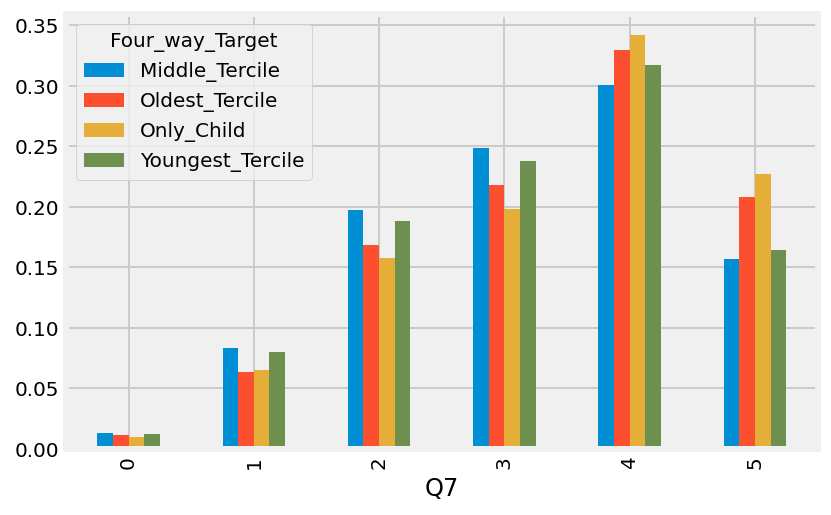

In [256]:
# Create one hist for one question

capst02['Q7'].groupby(capst02['Four_way_Target']).value_counts(normalize = True).unstack().T.plot(kind = 'bar')
# capst02['Q7'].groupby(capst02['Four_way_Target']).value_counts(normalize = True).unstack().T.sort_values(by = 'Youngest_Tercile').plot(kind = 'bar', figsize=(16,8))

D:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



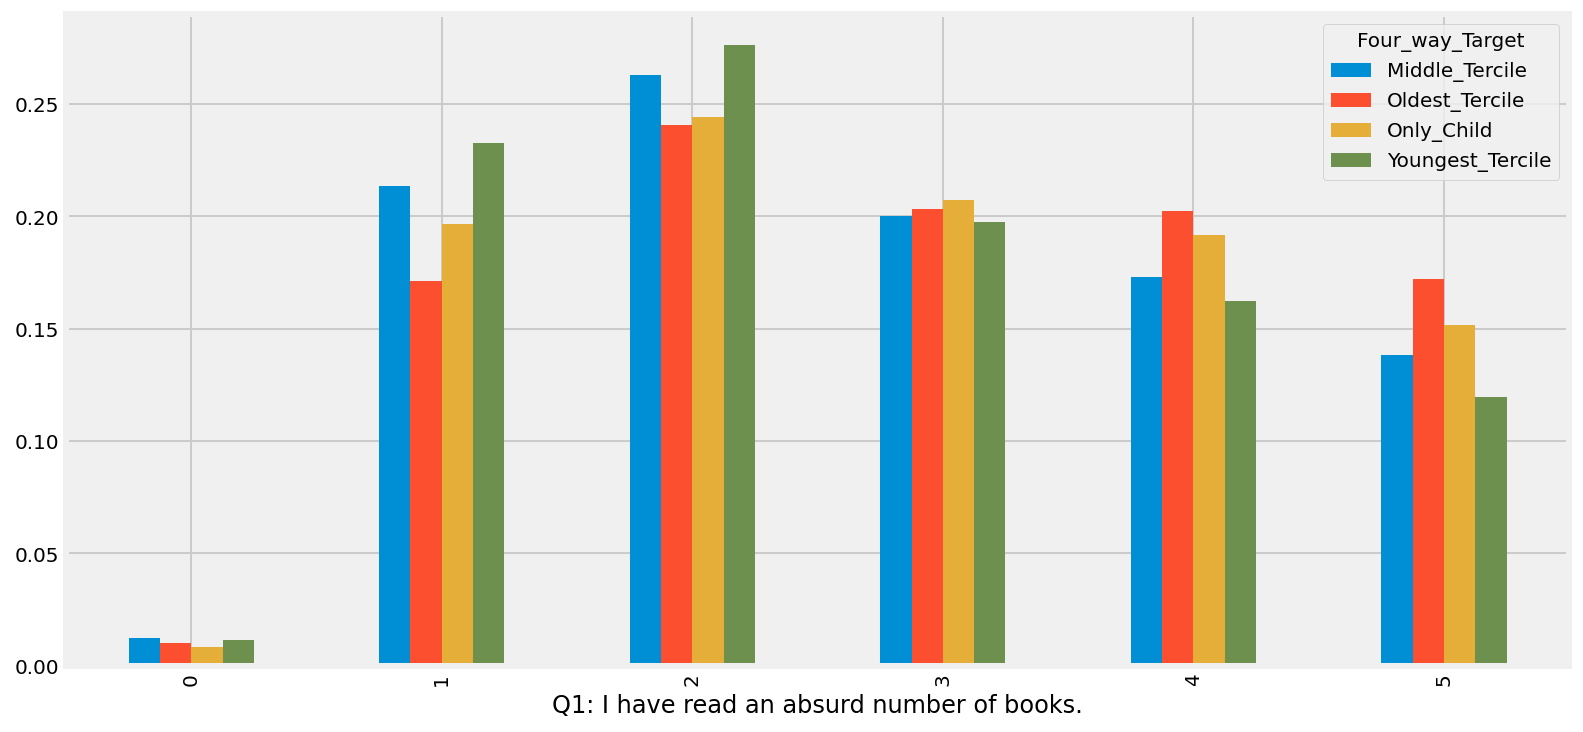

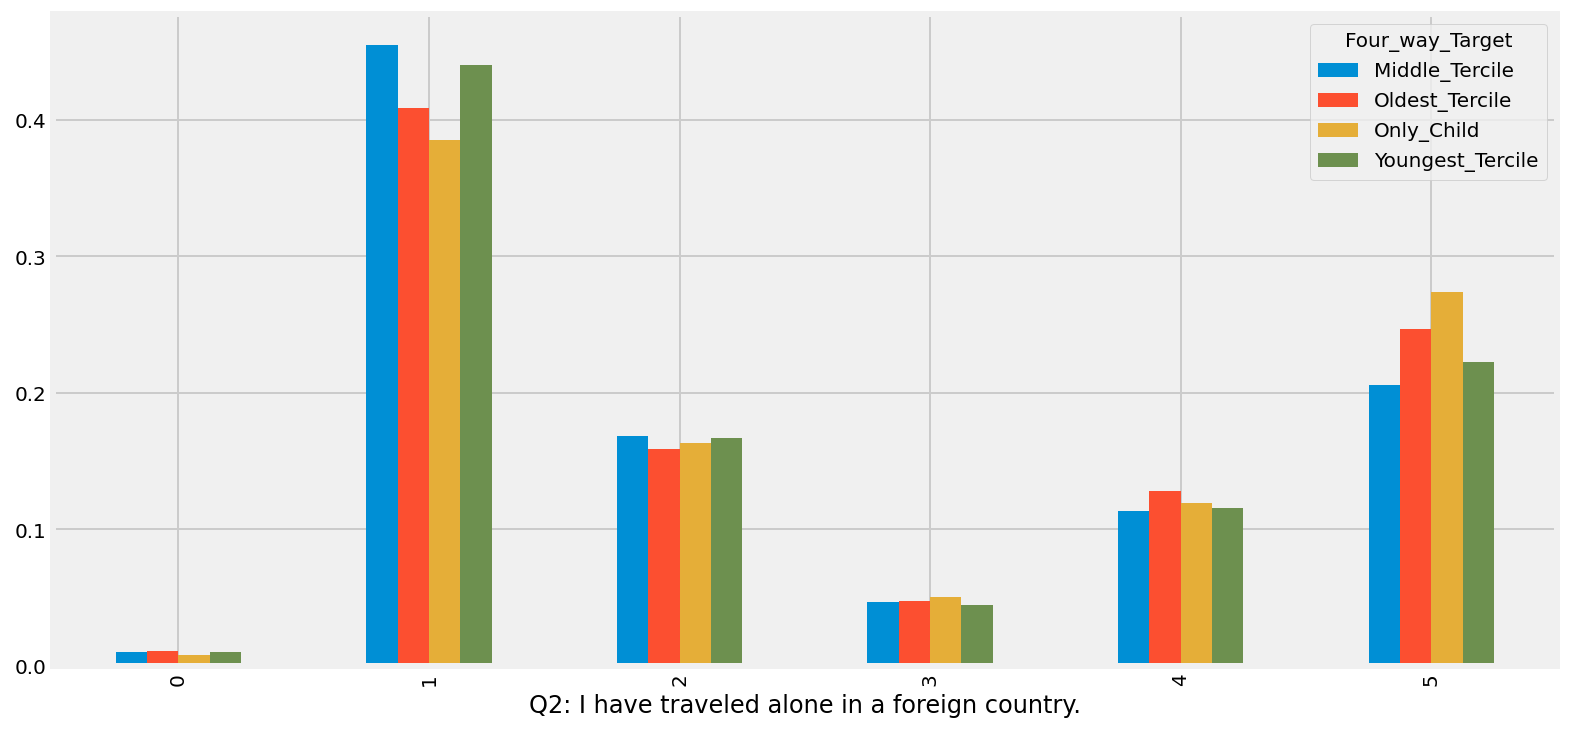

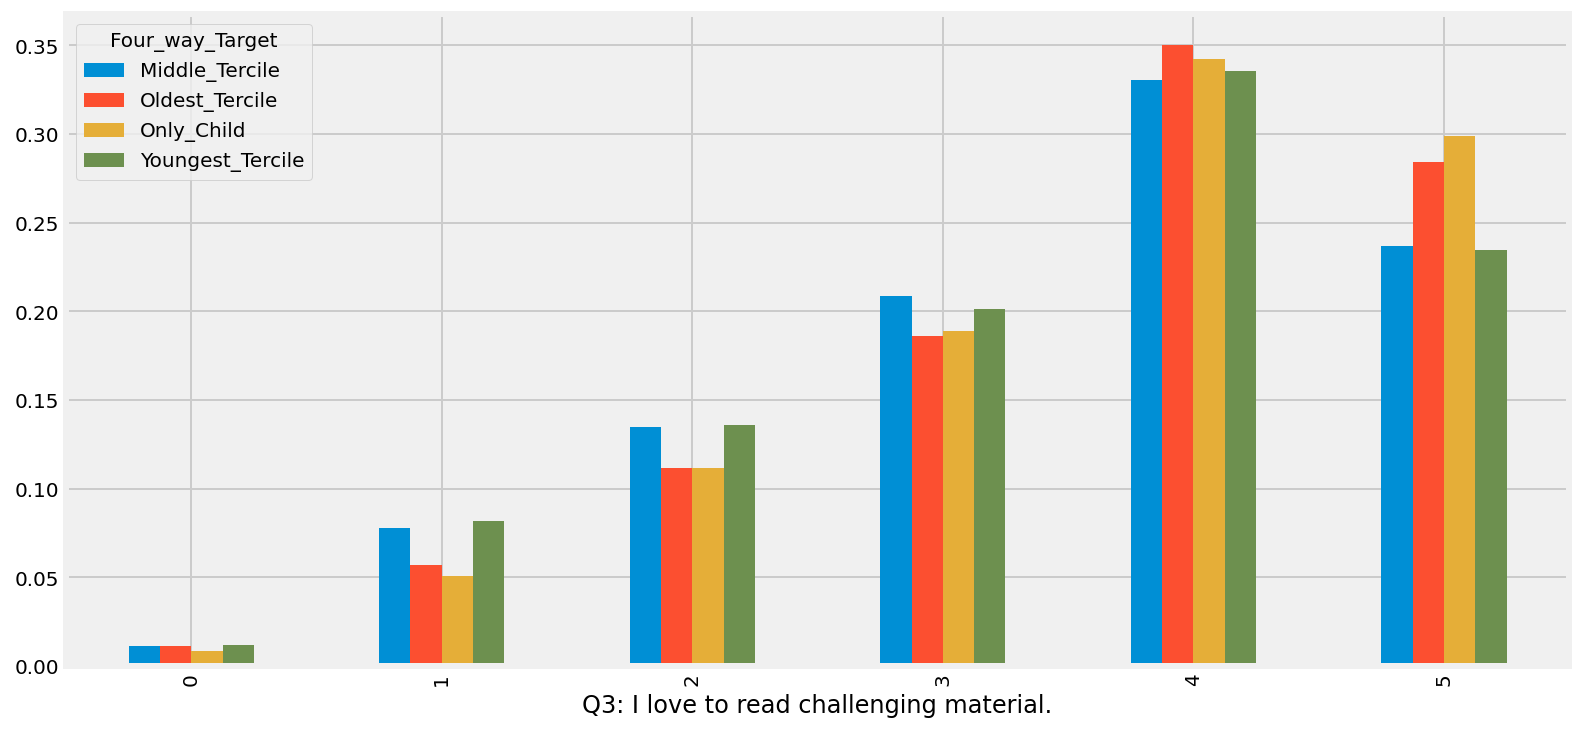

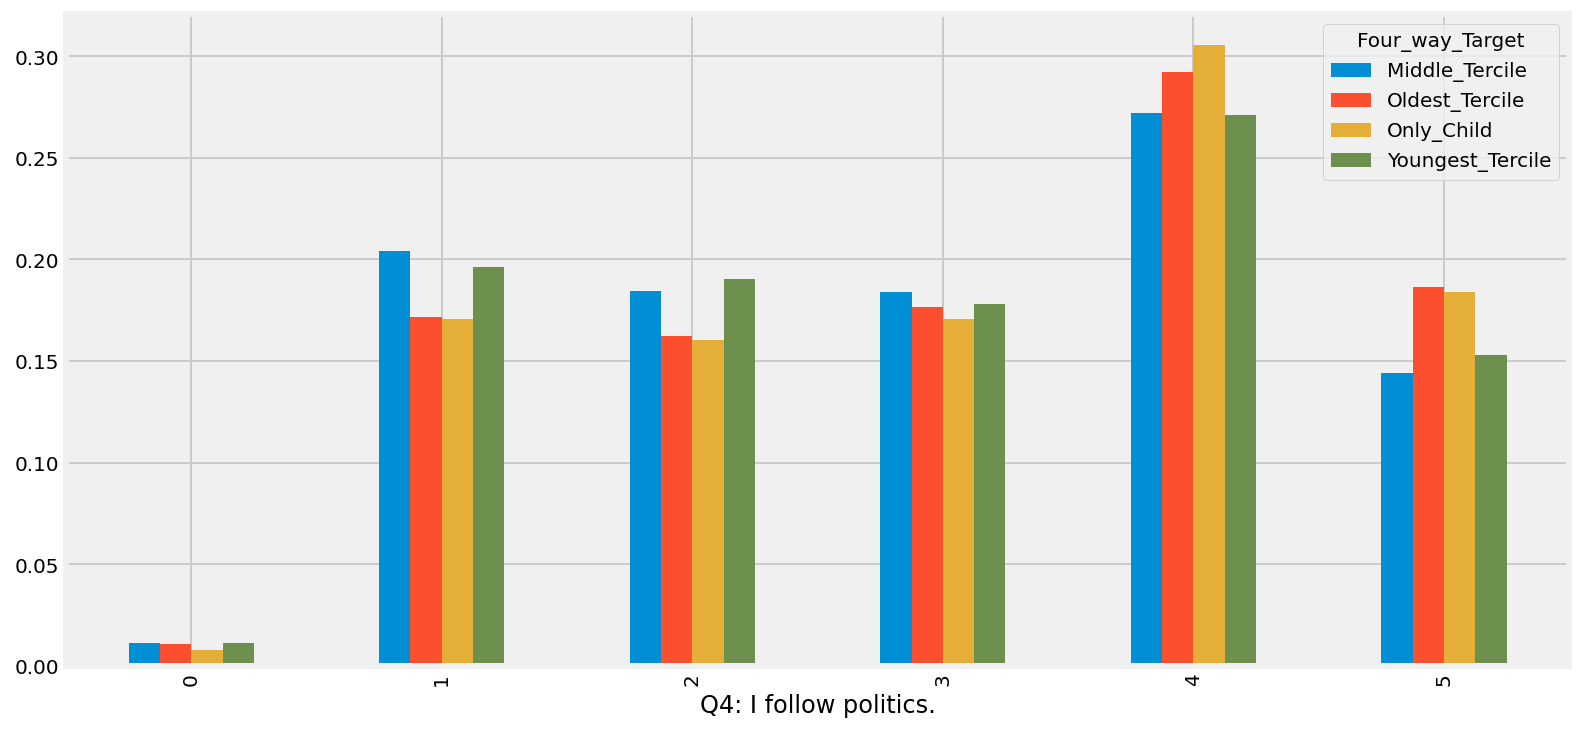

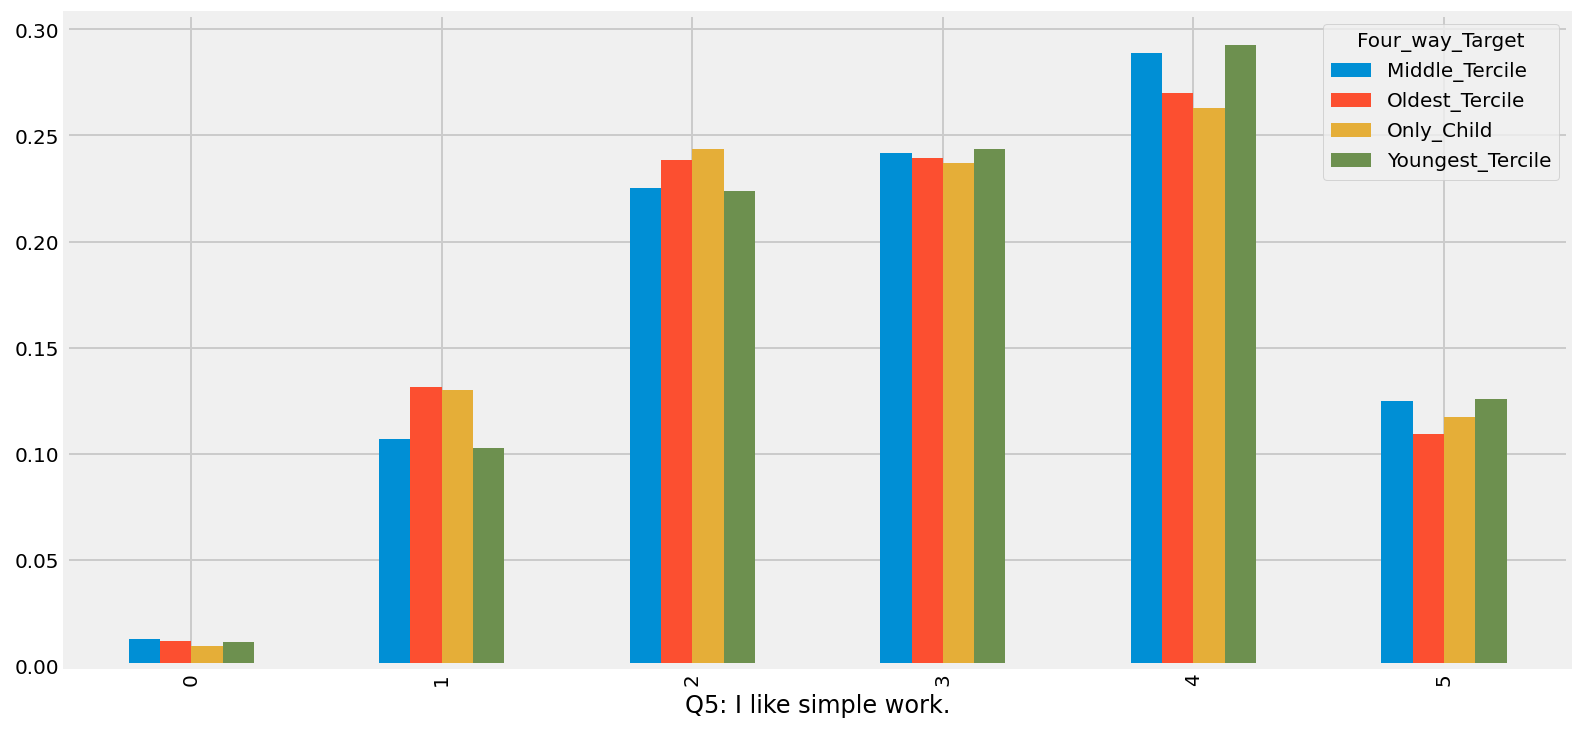

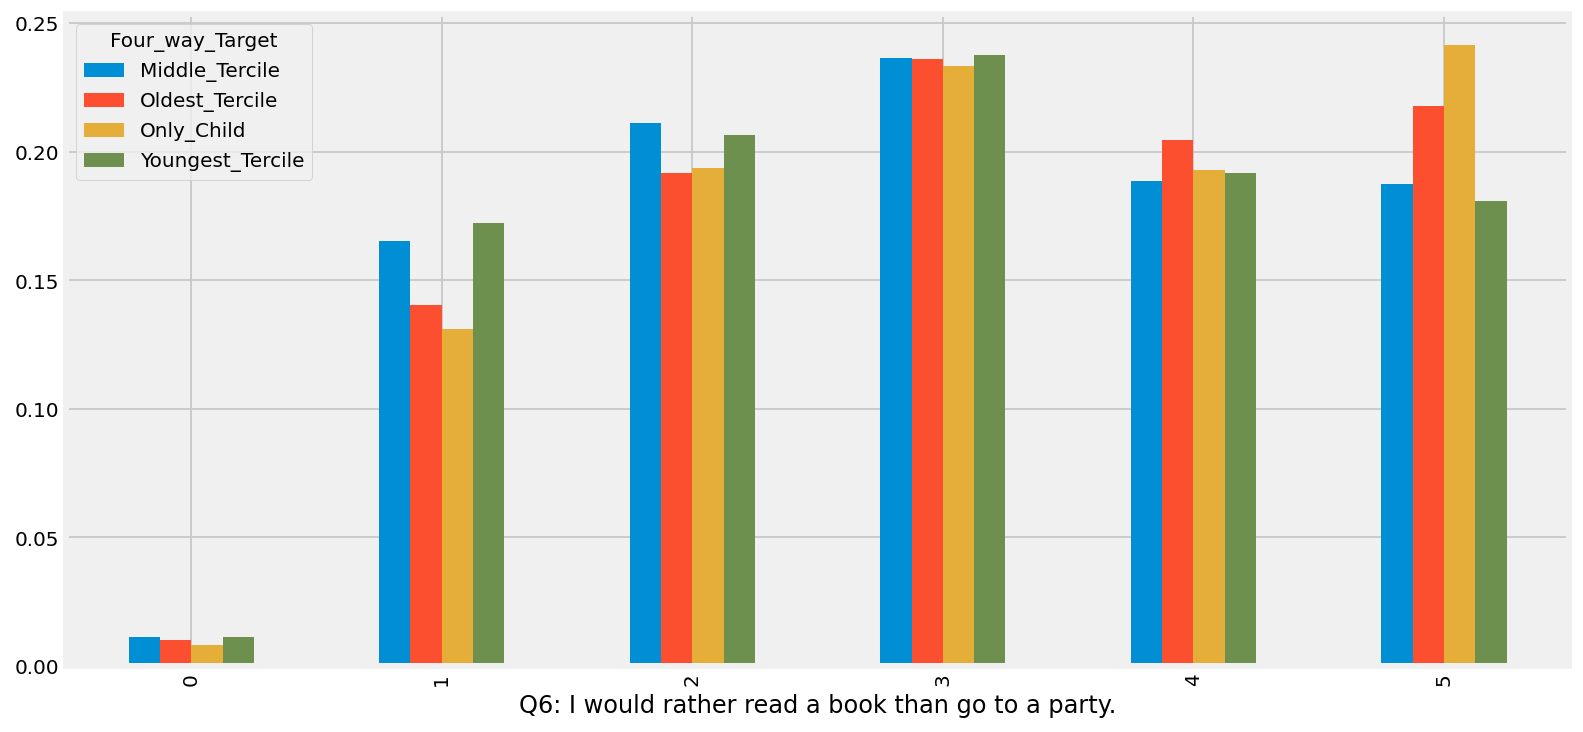

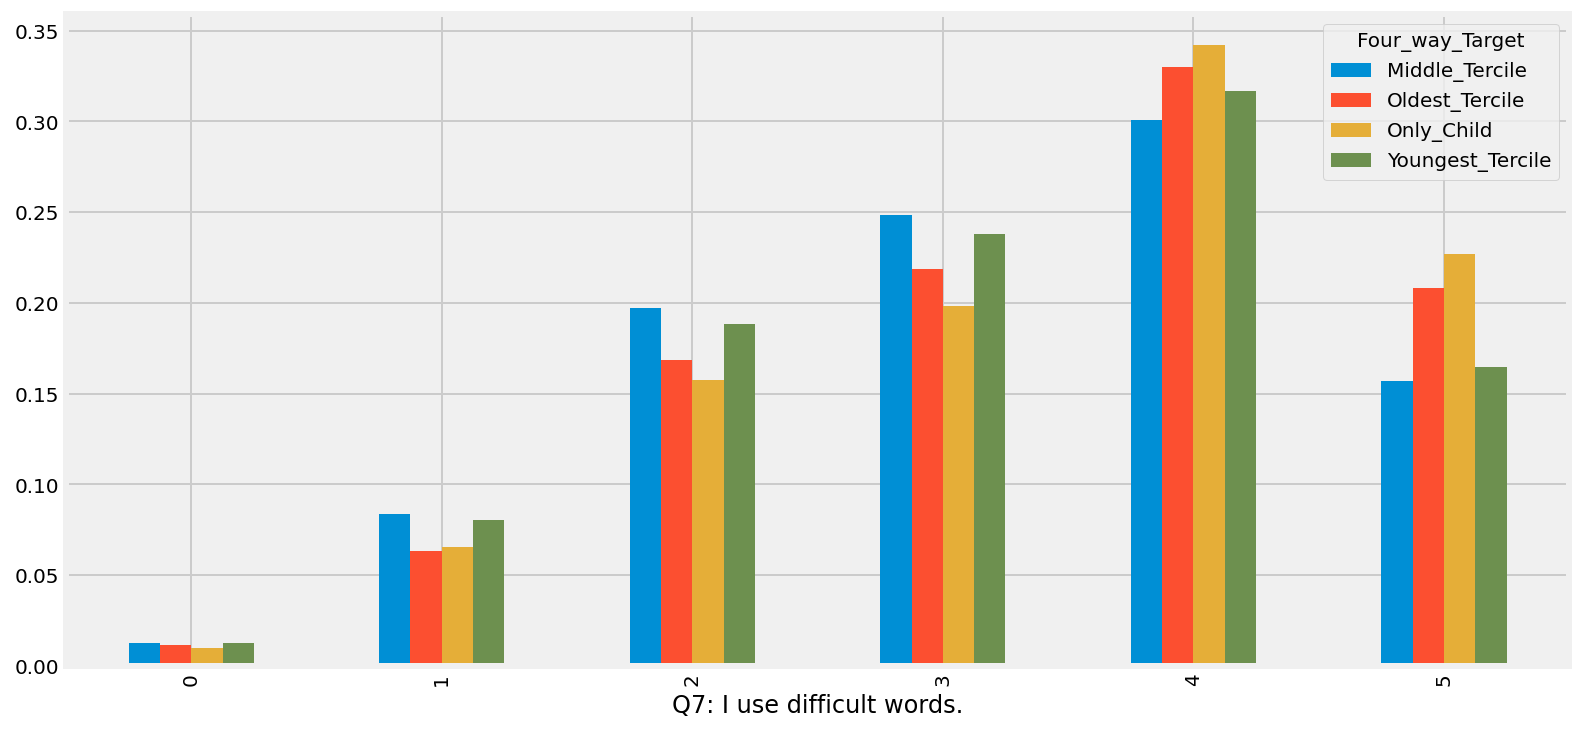

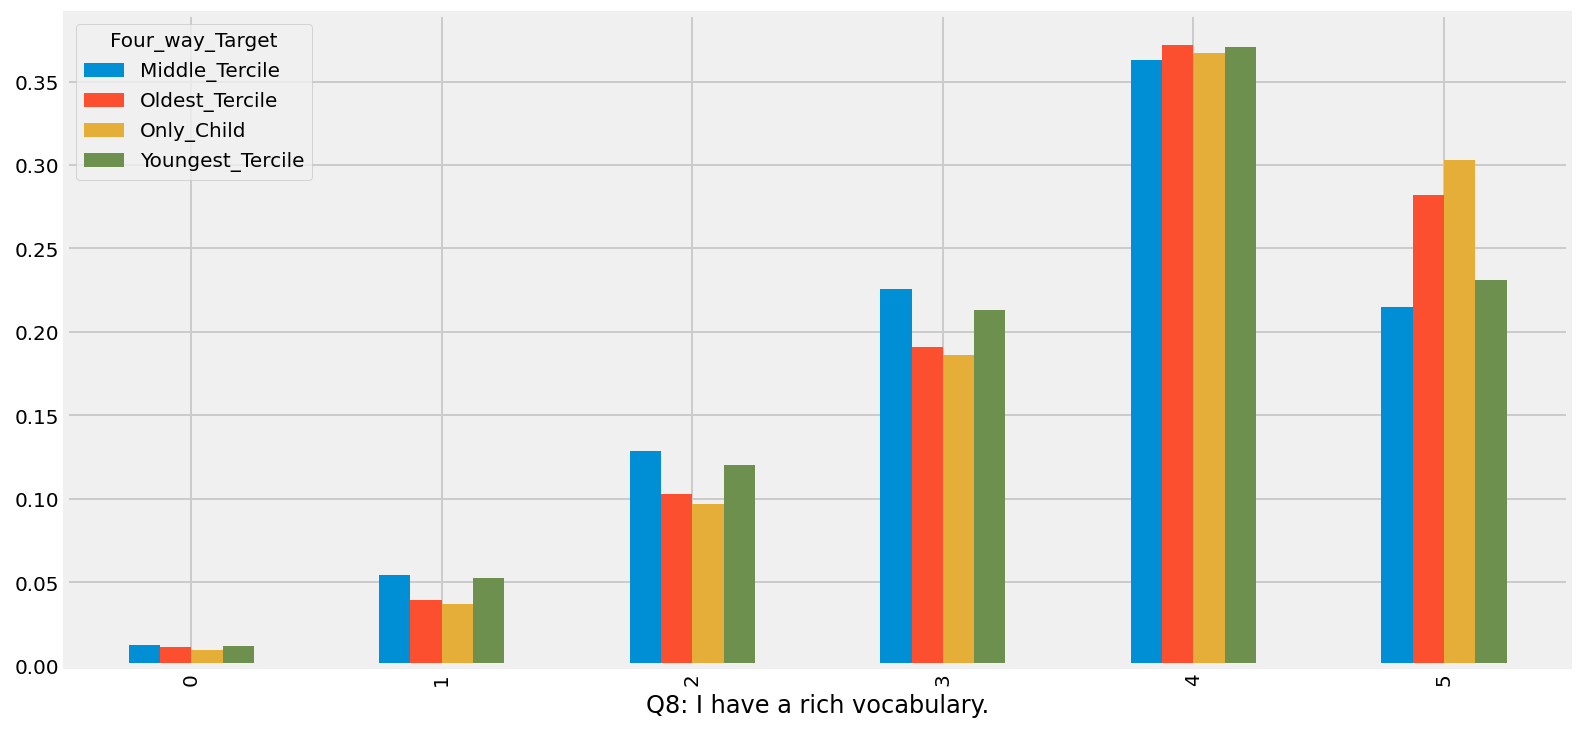

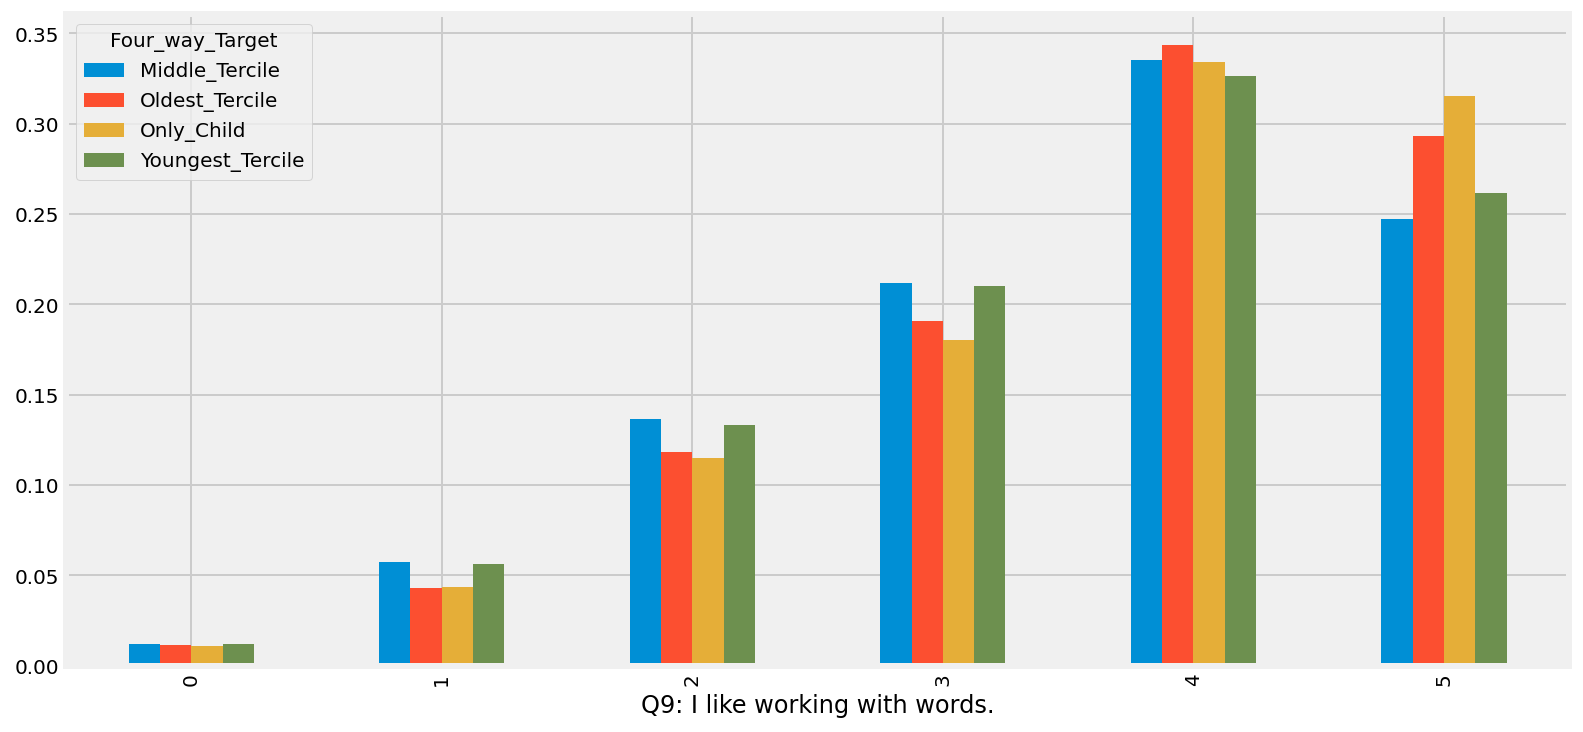

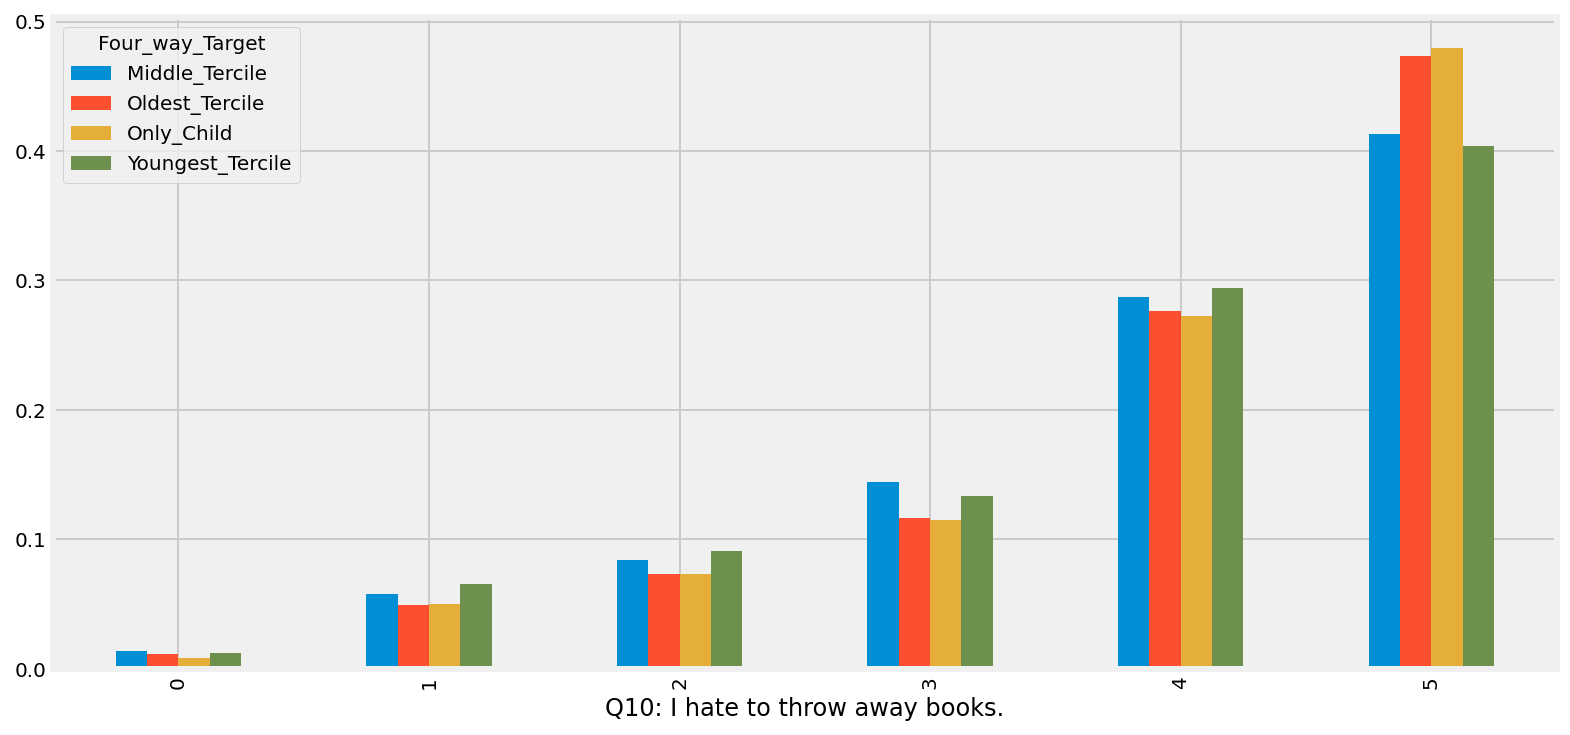

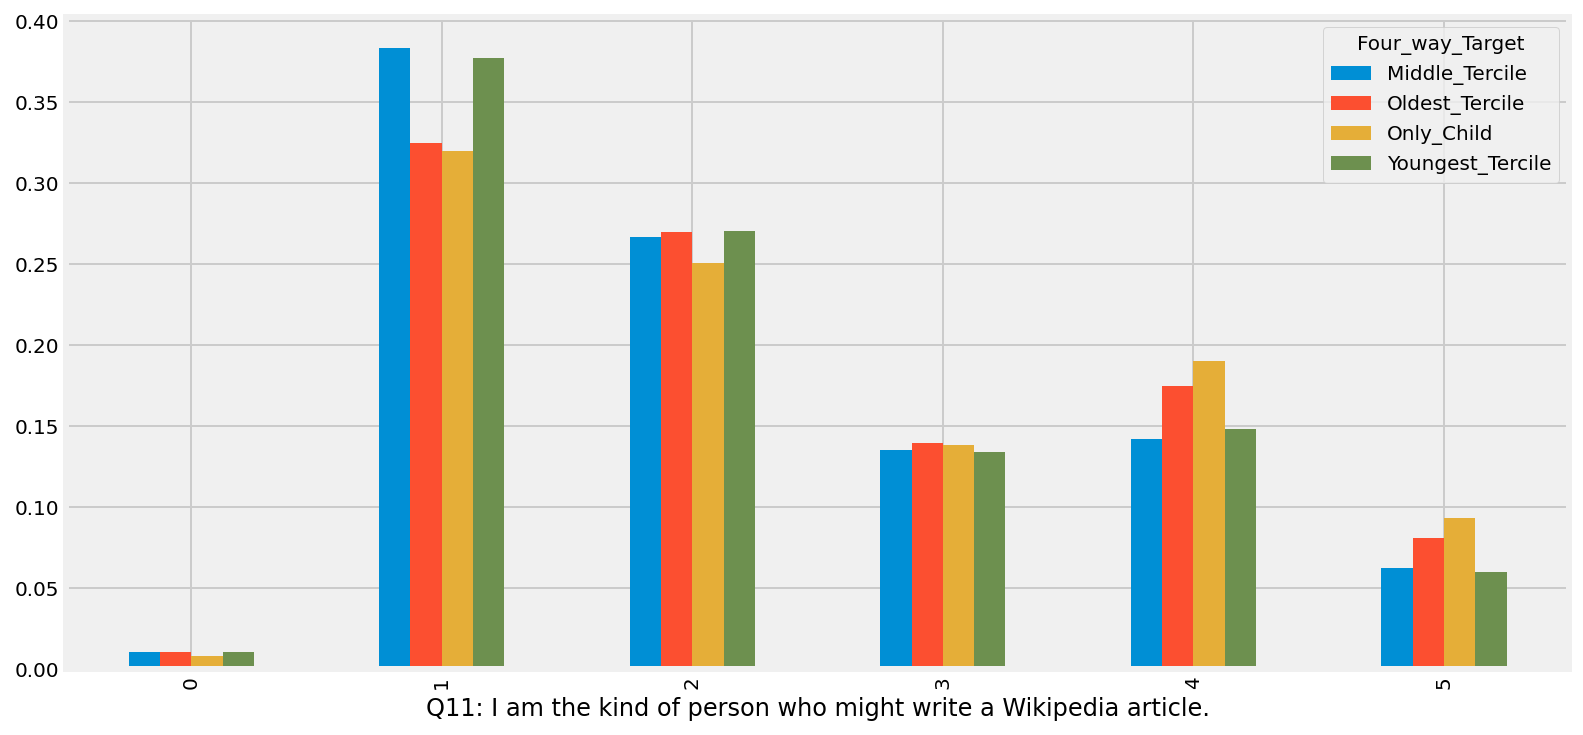

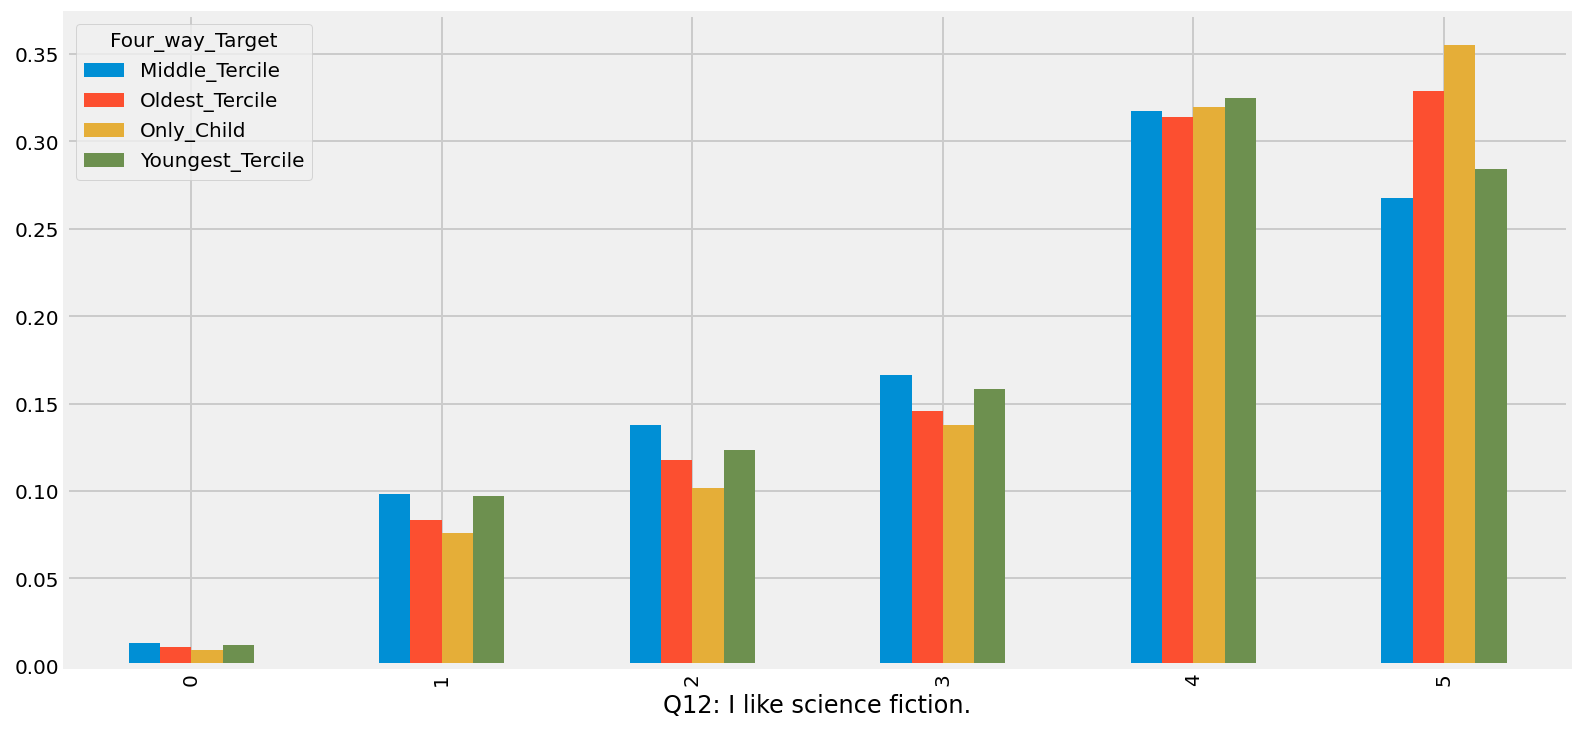

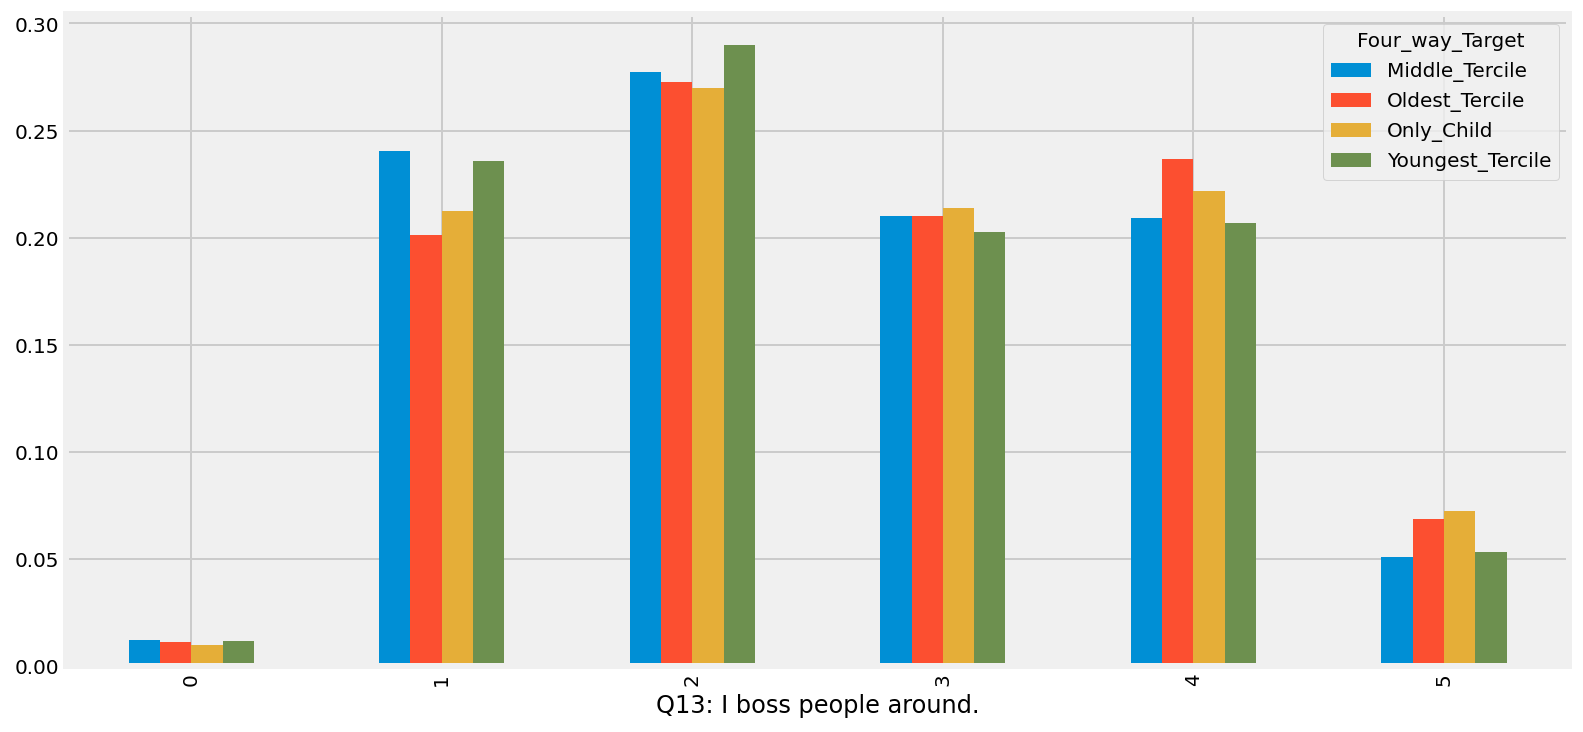

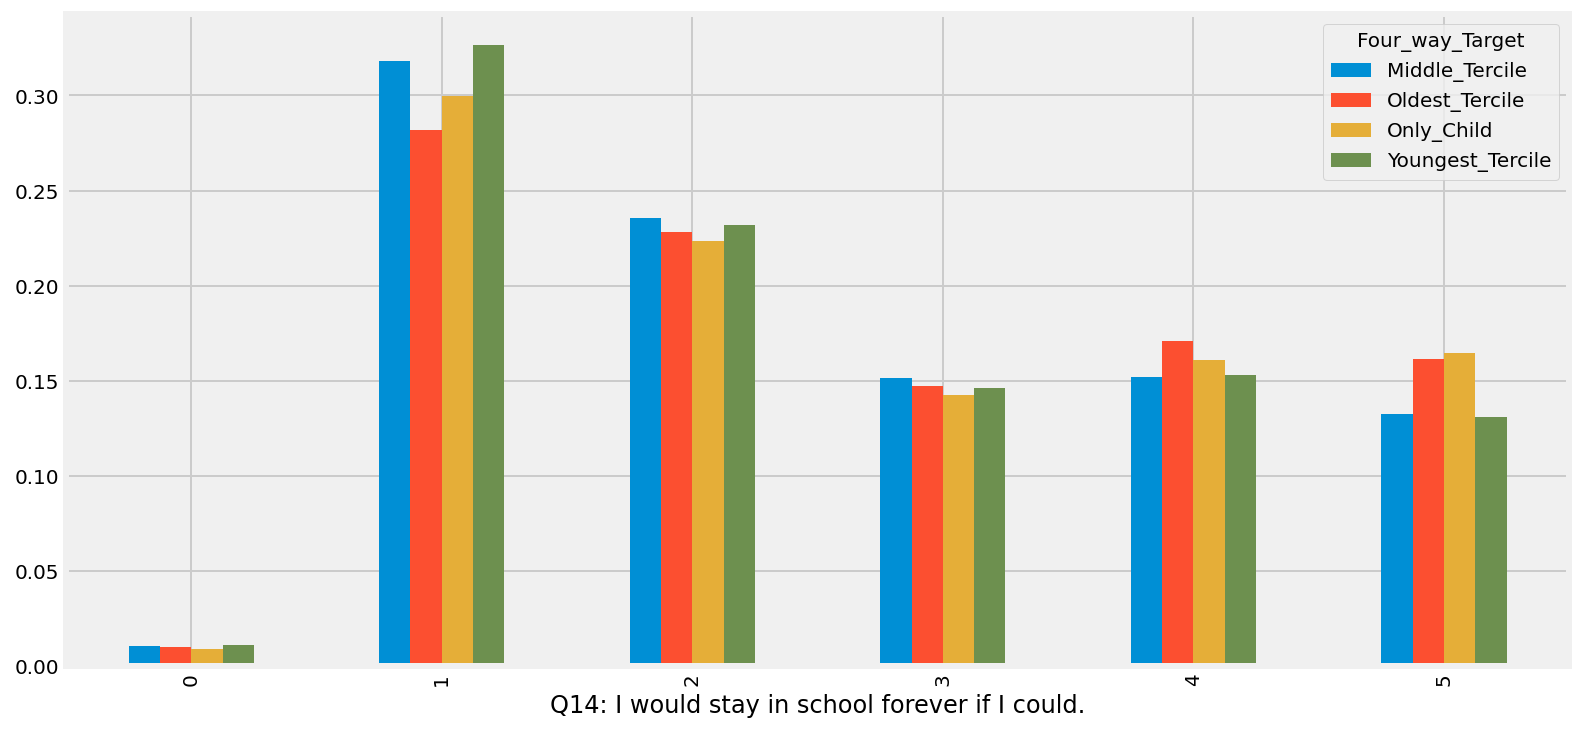

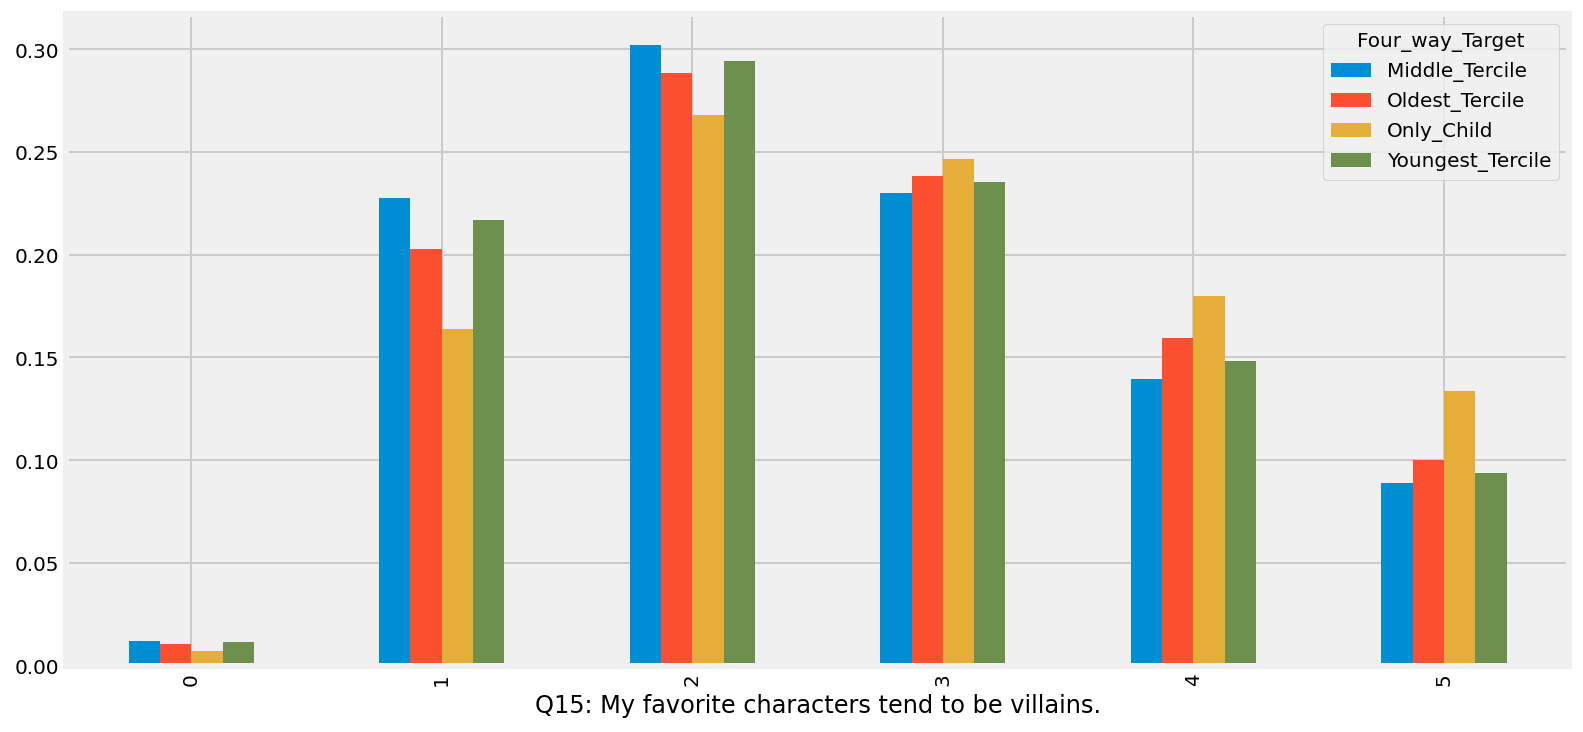

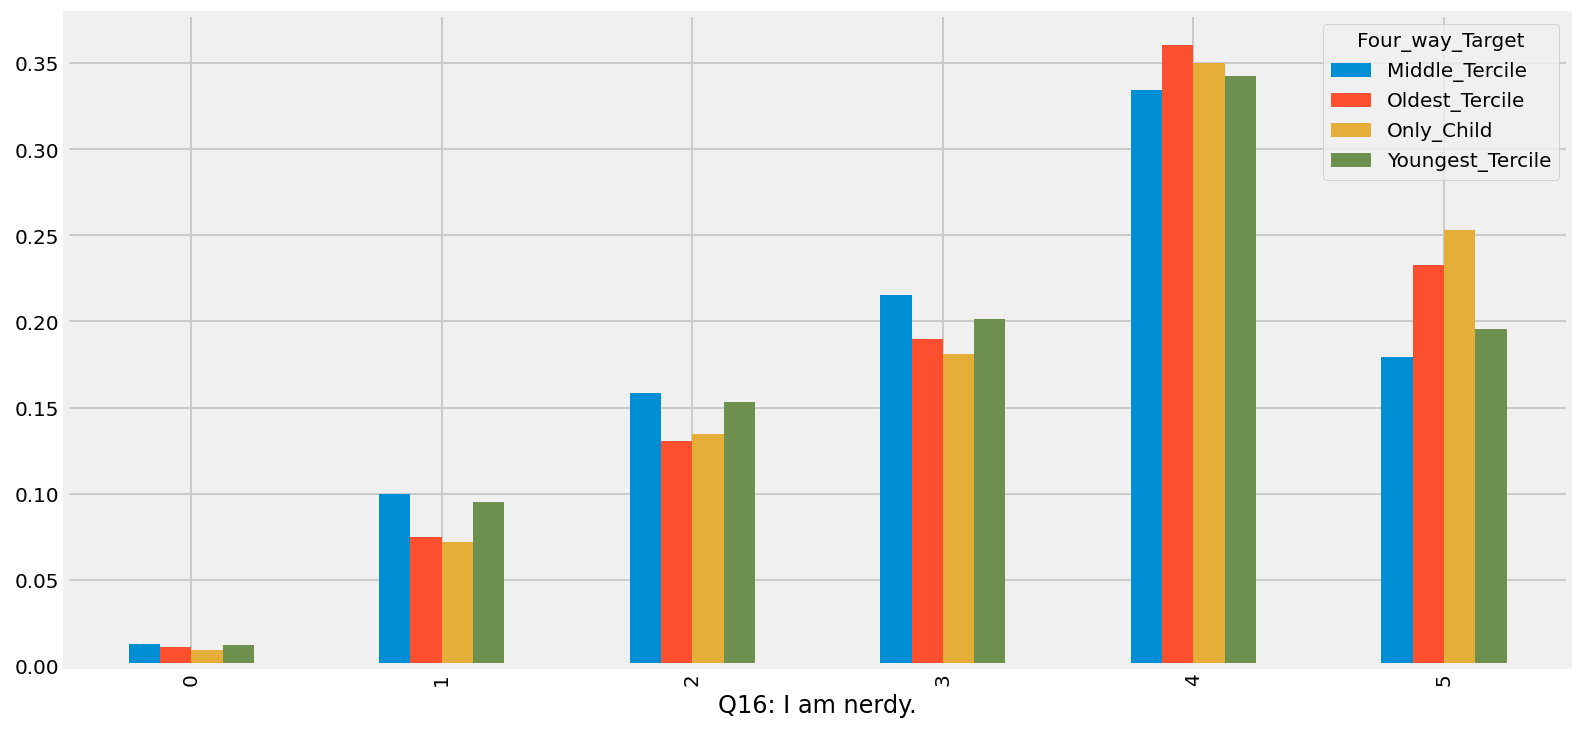

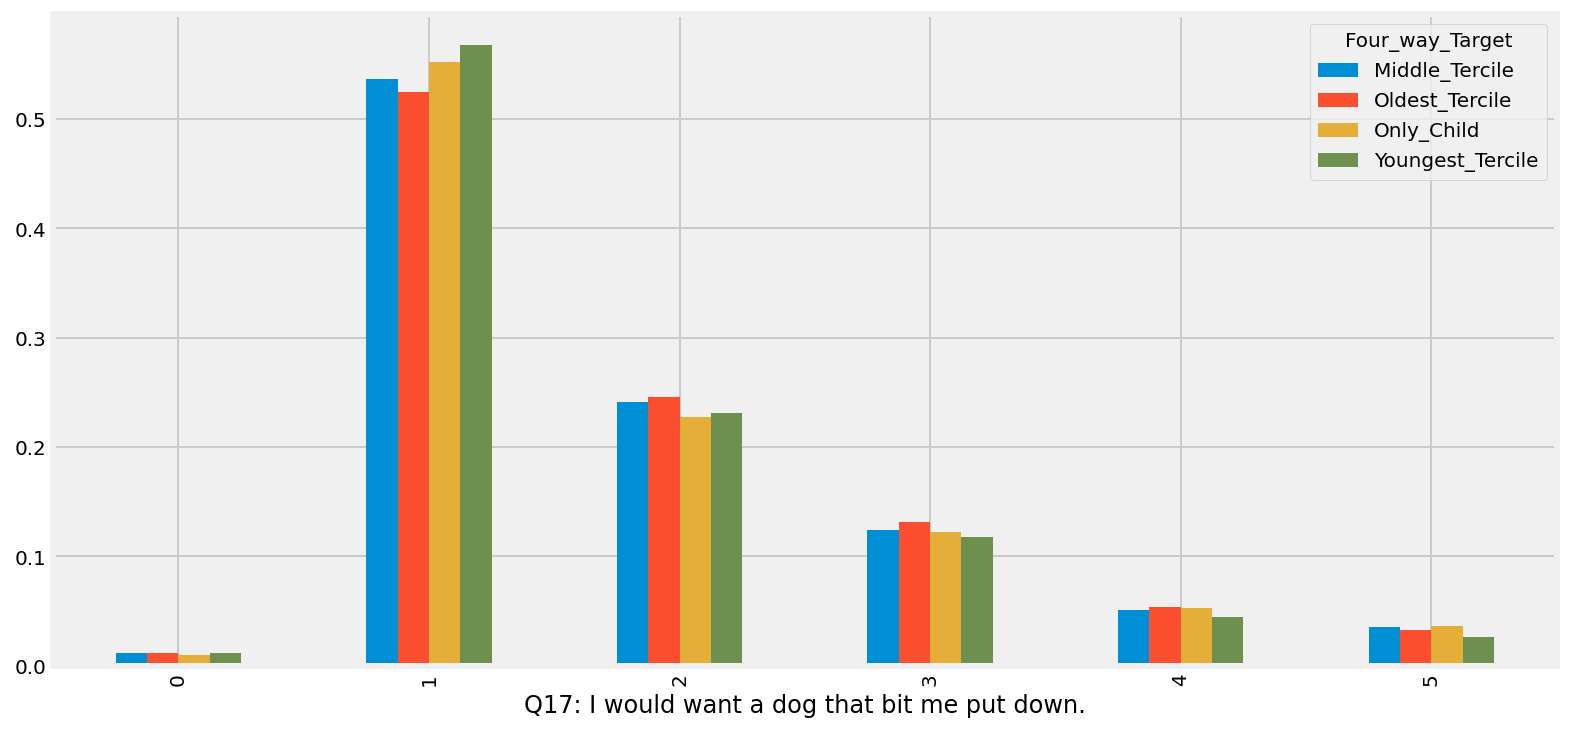

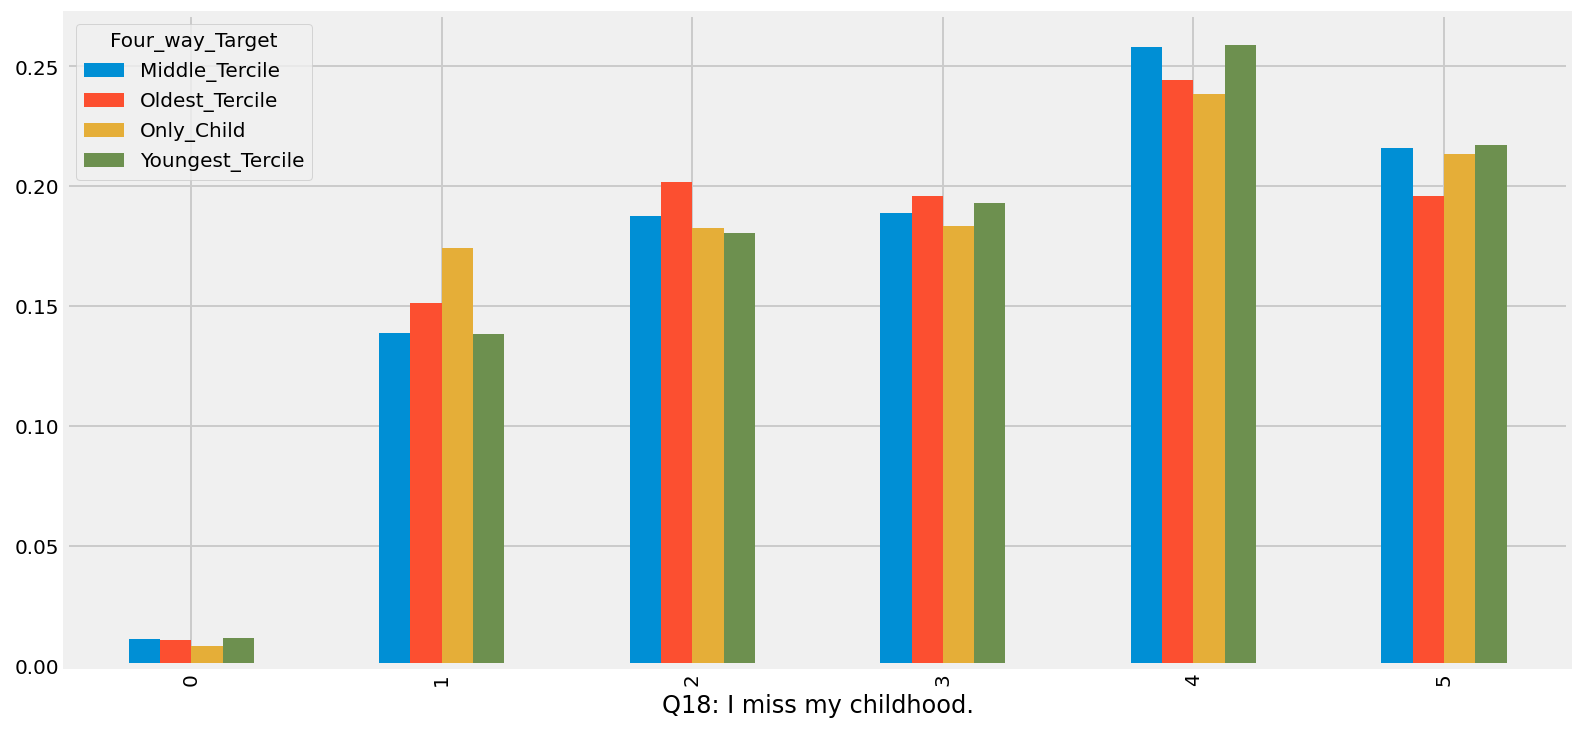

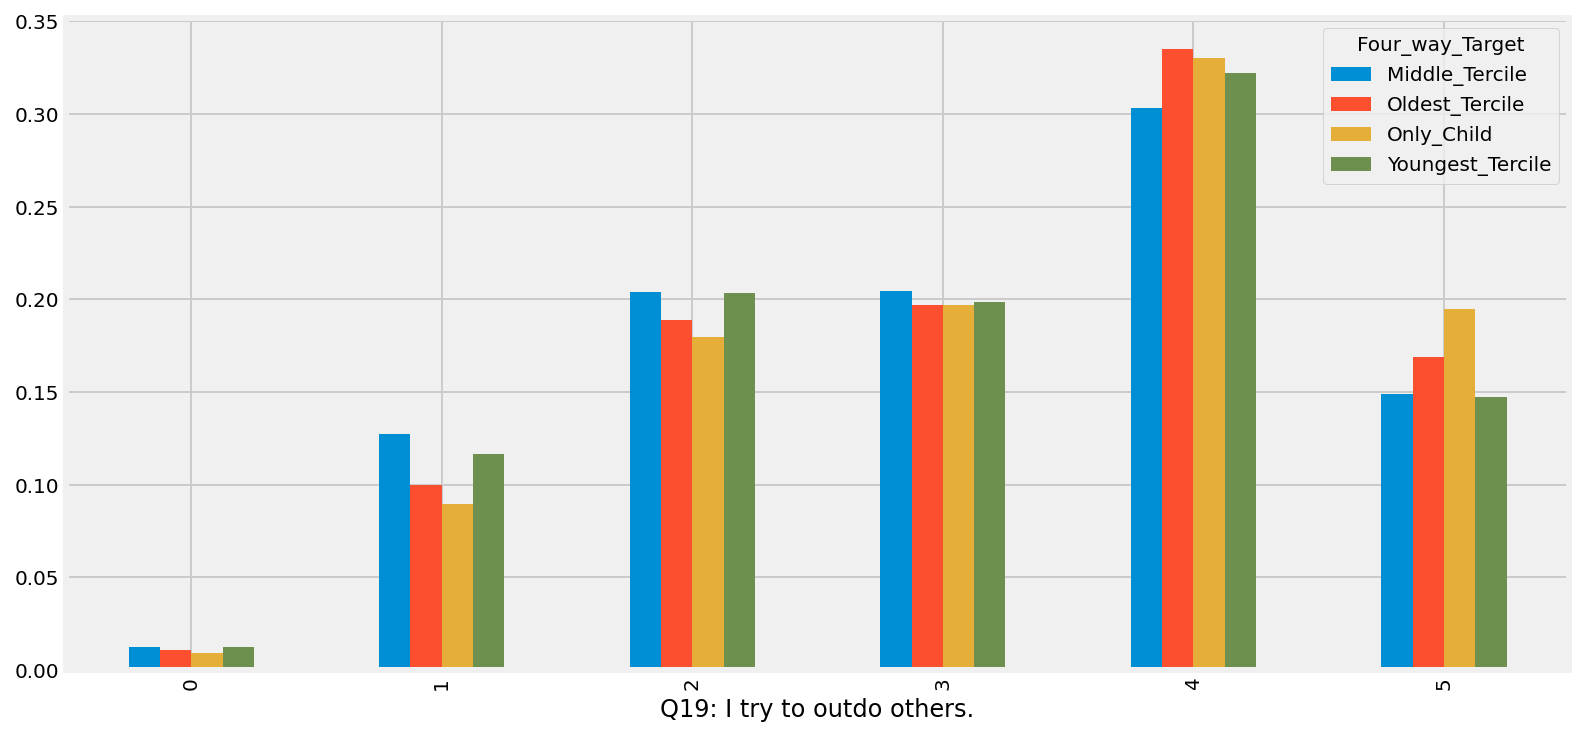

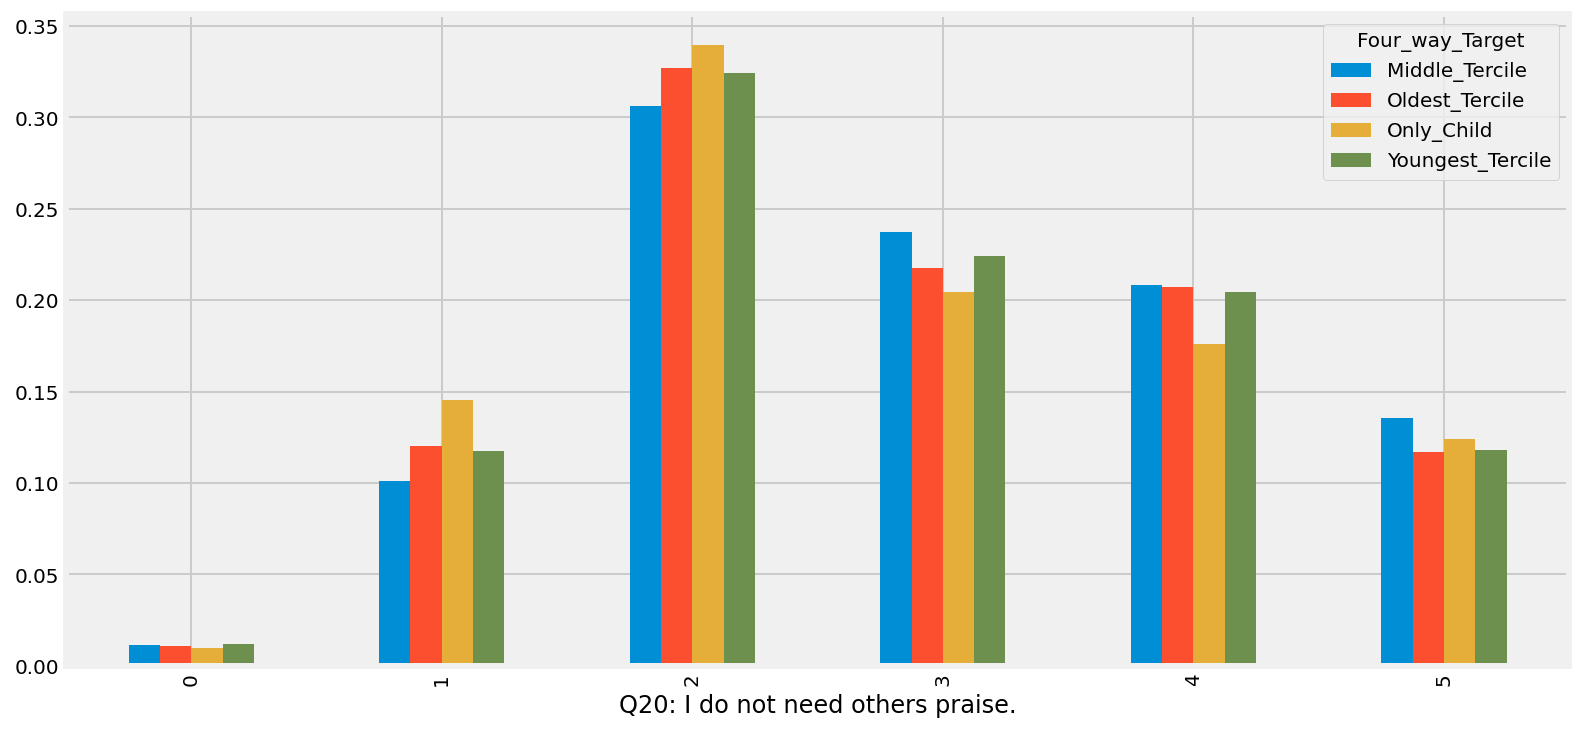

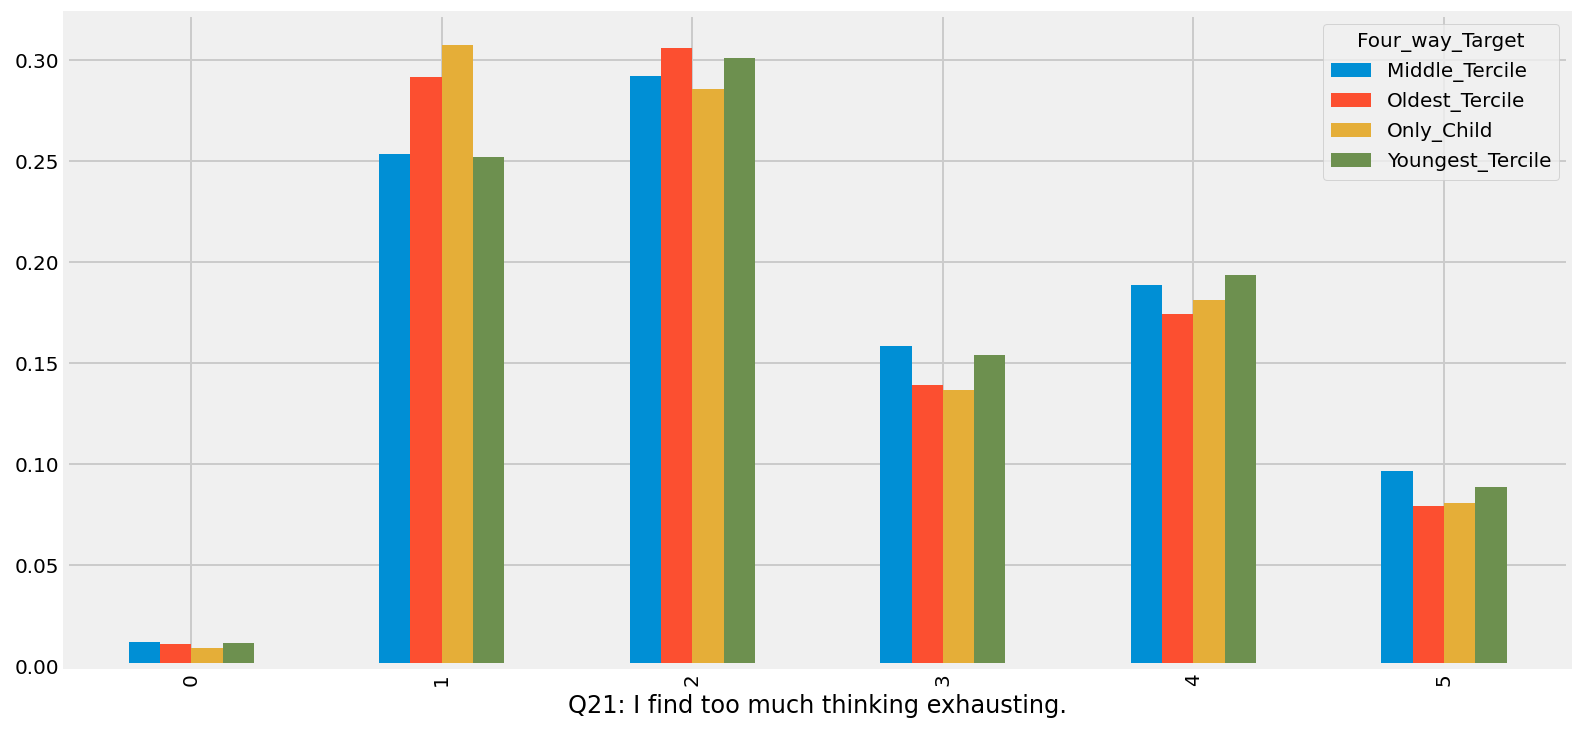

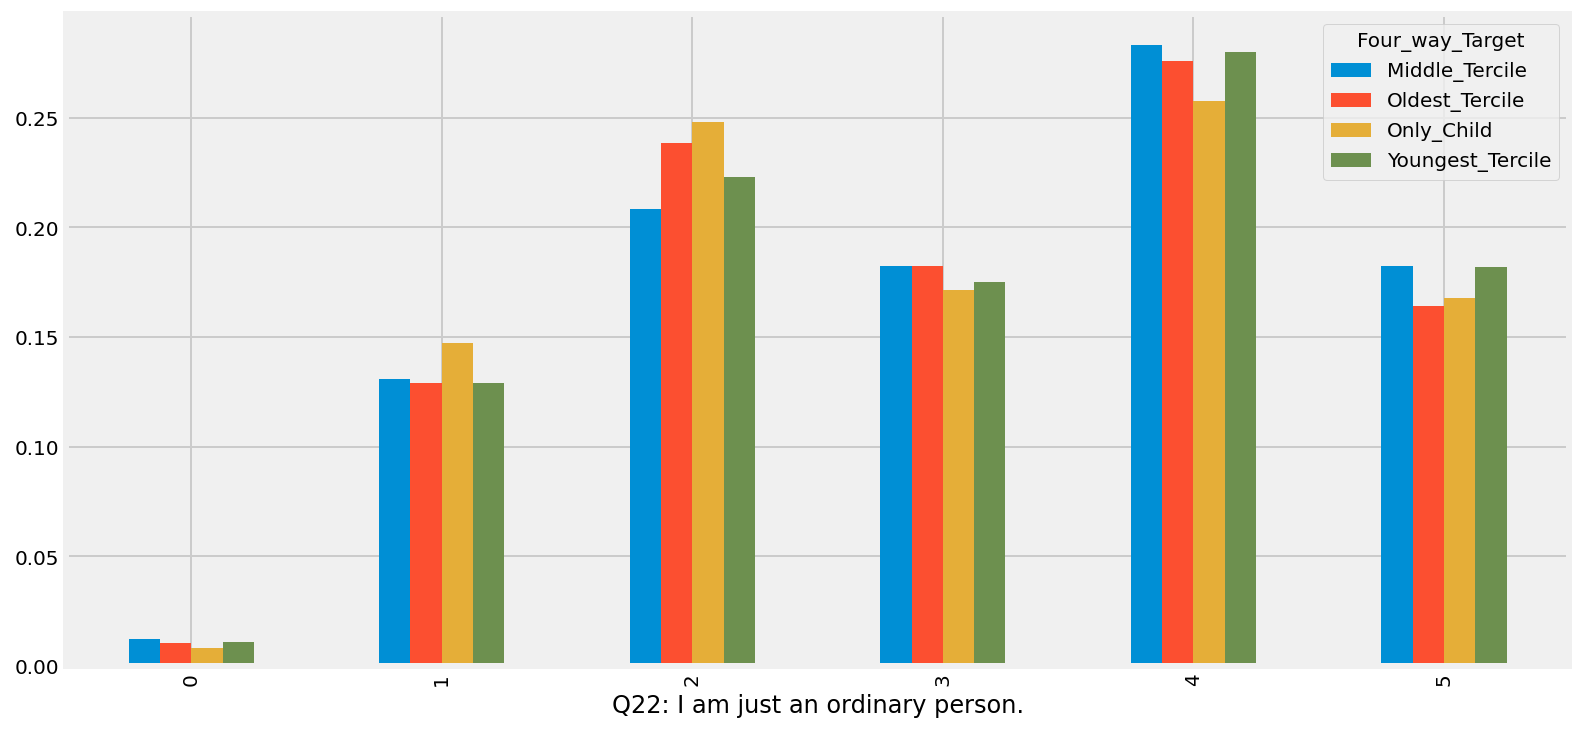

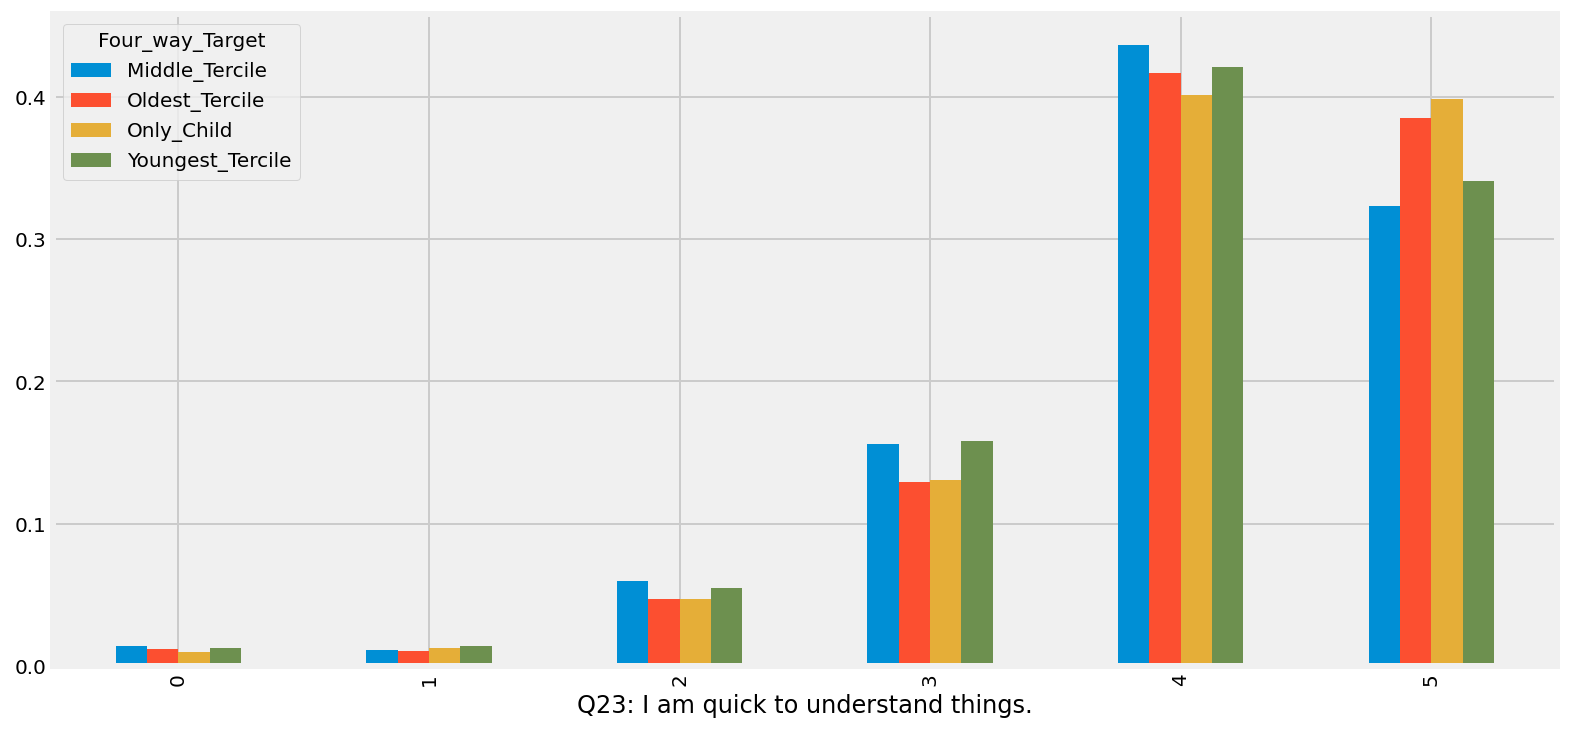

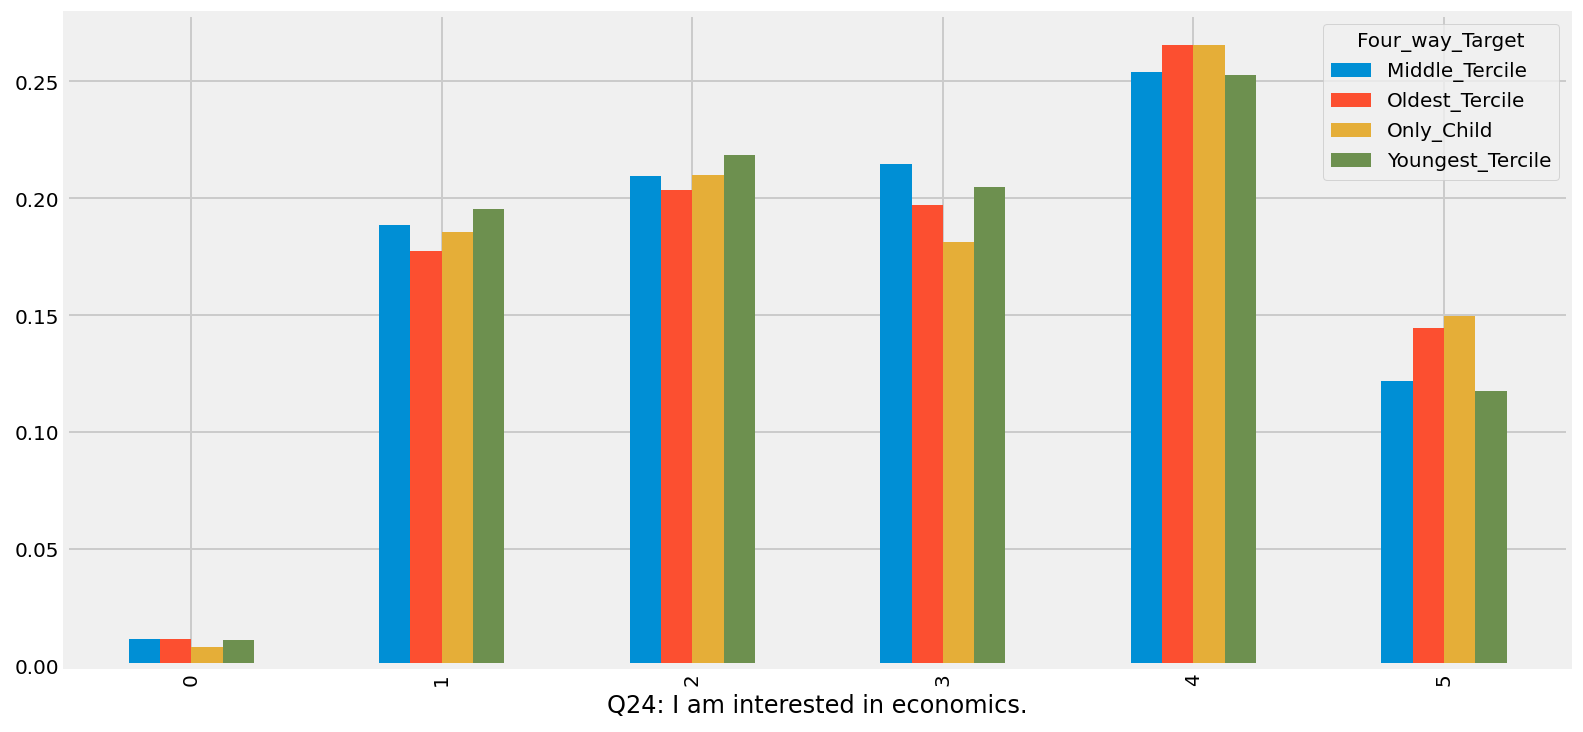

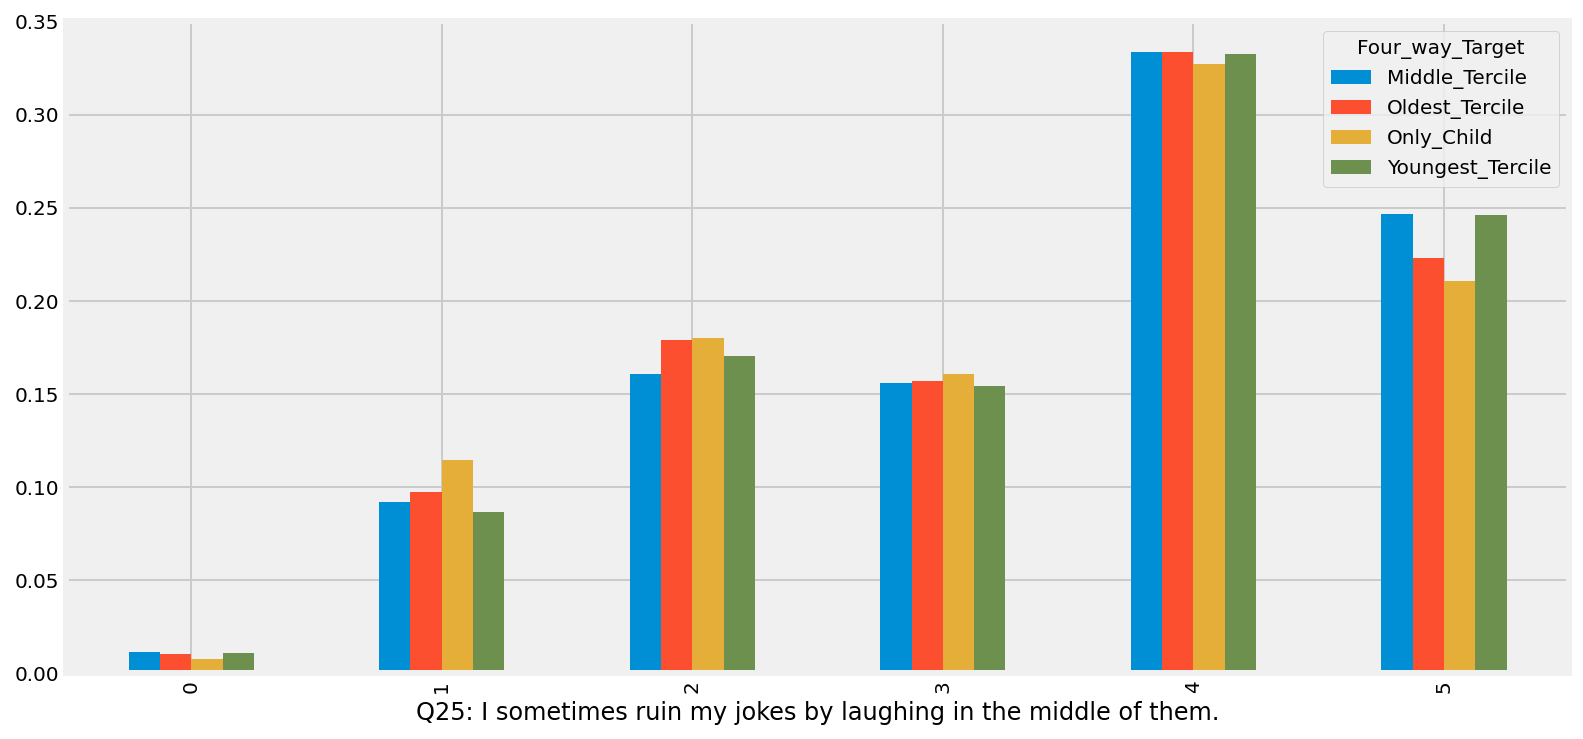

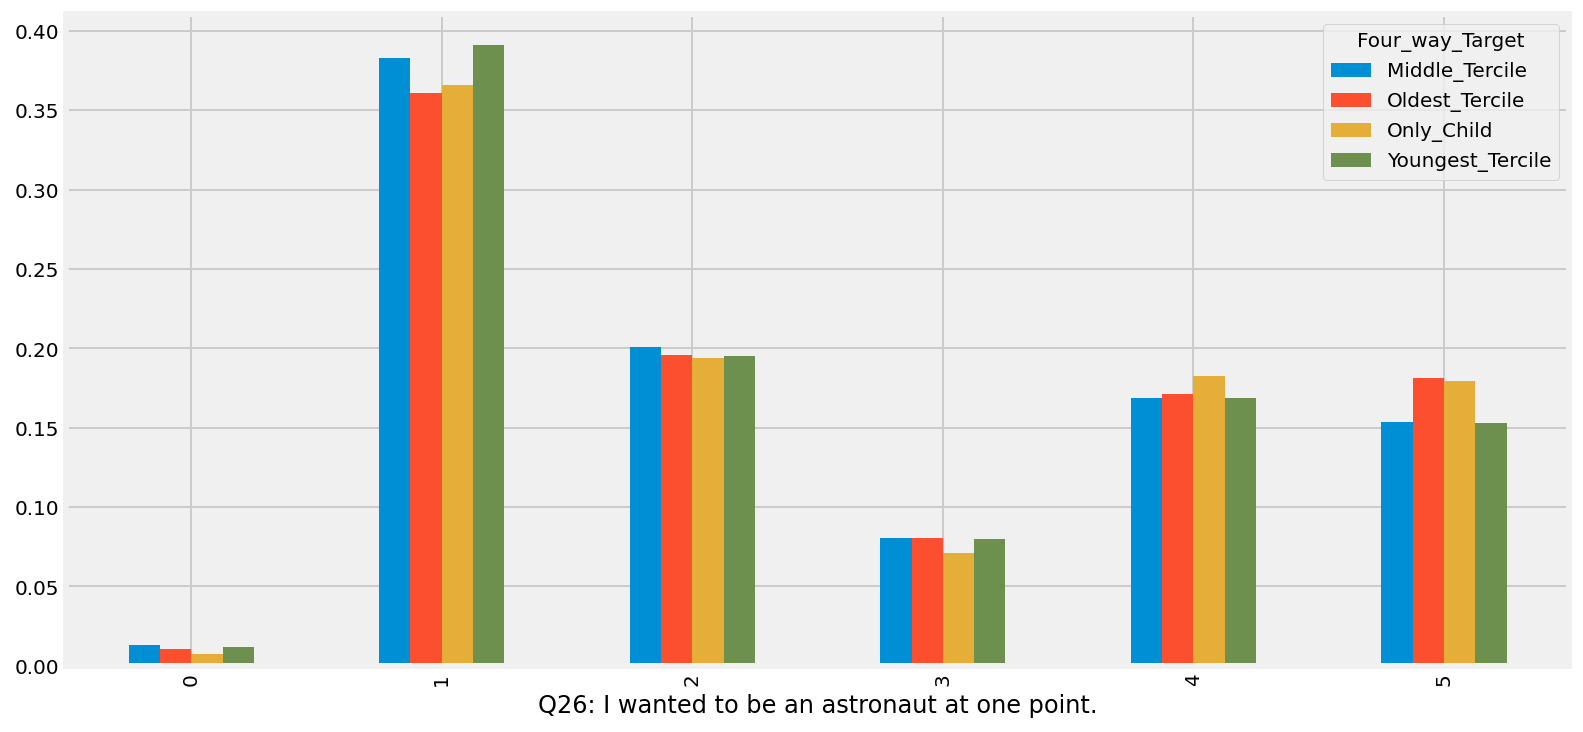

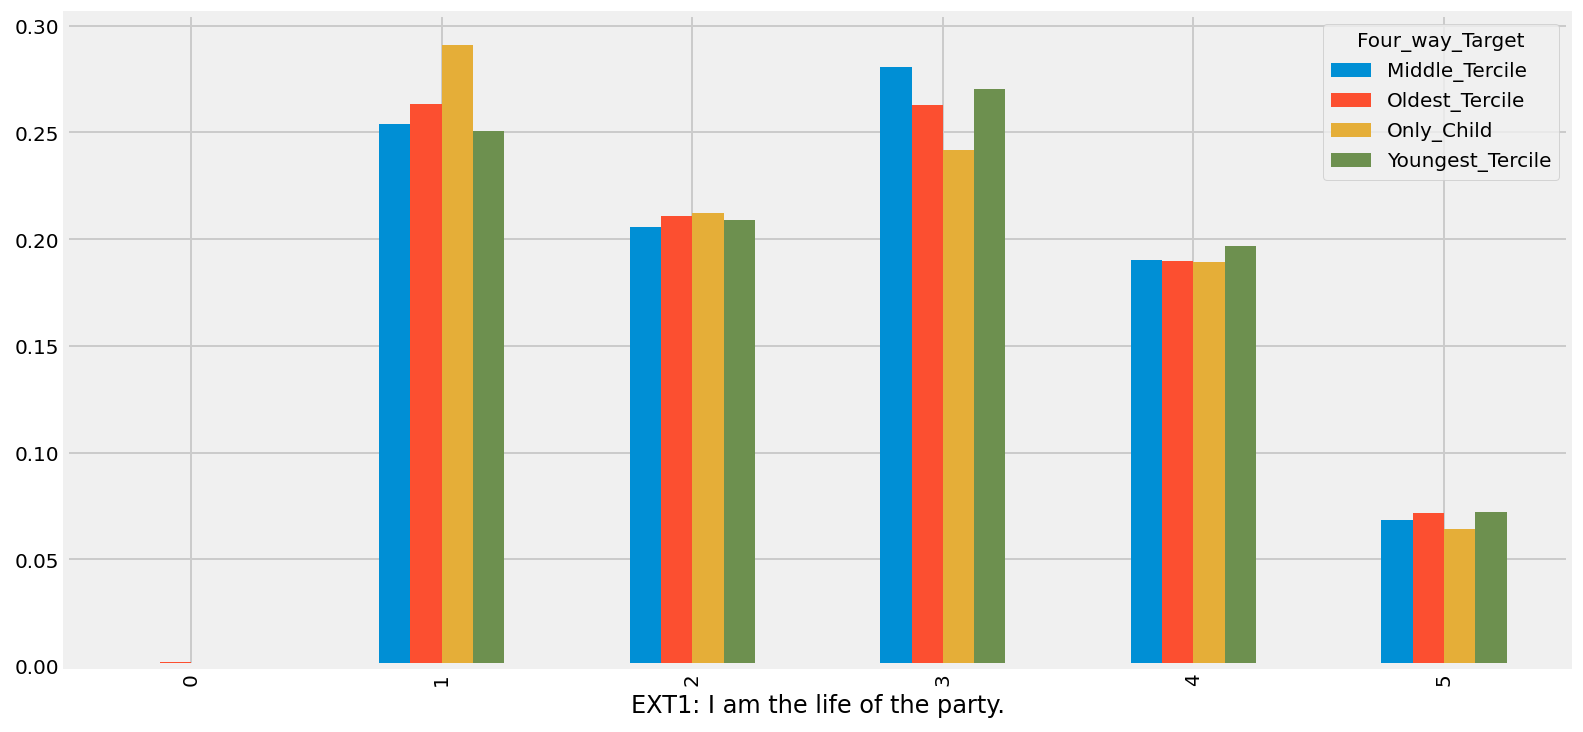

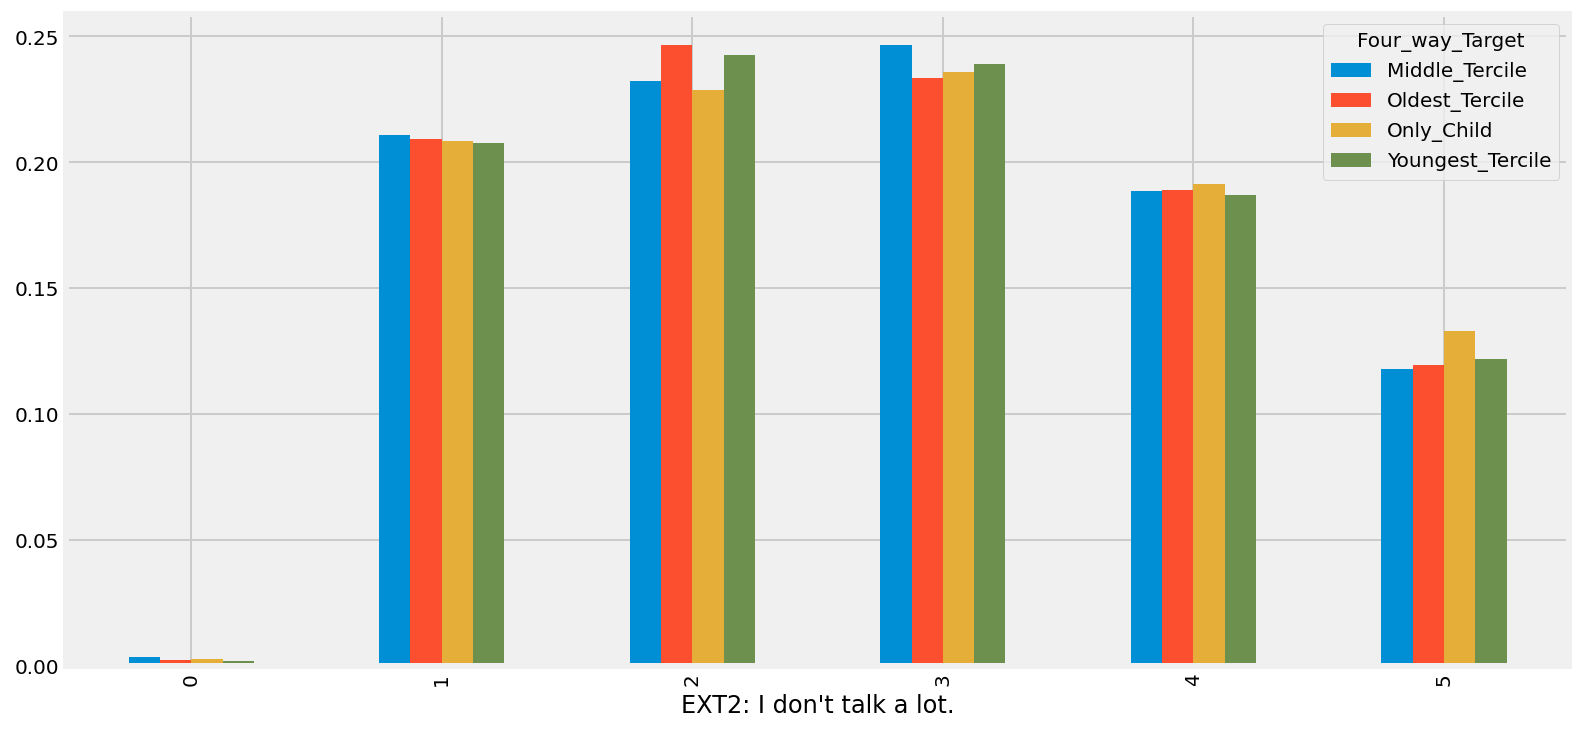

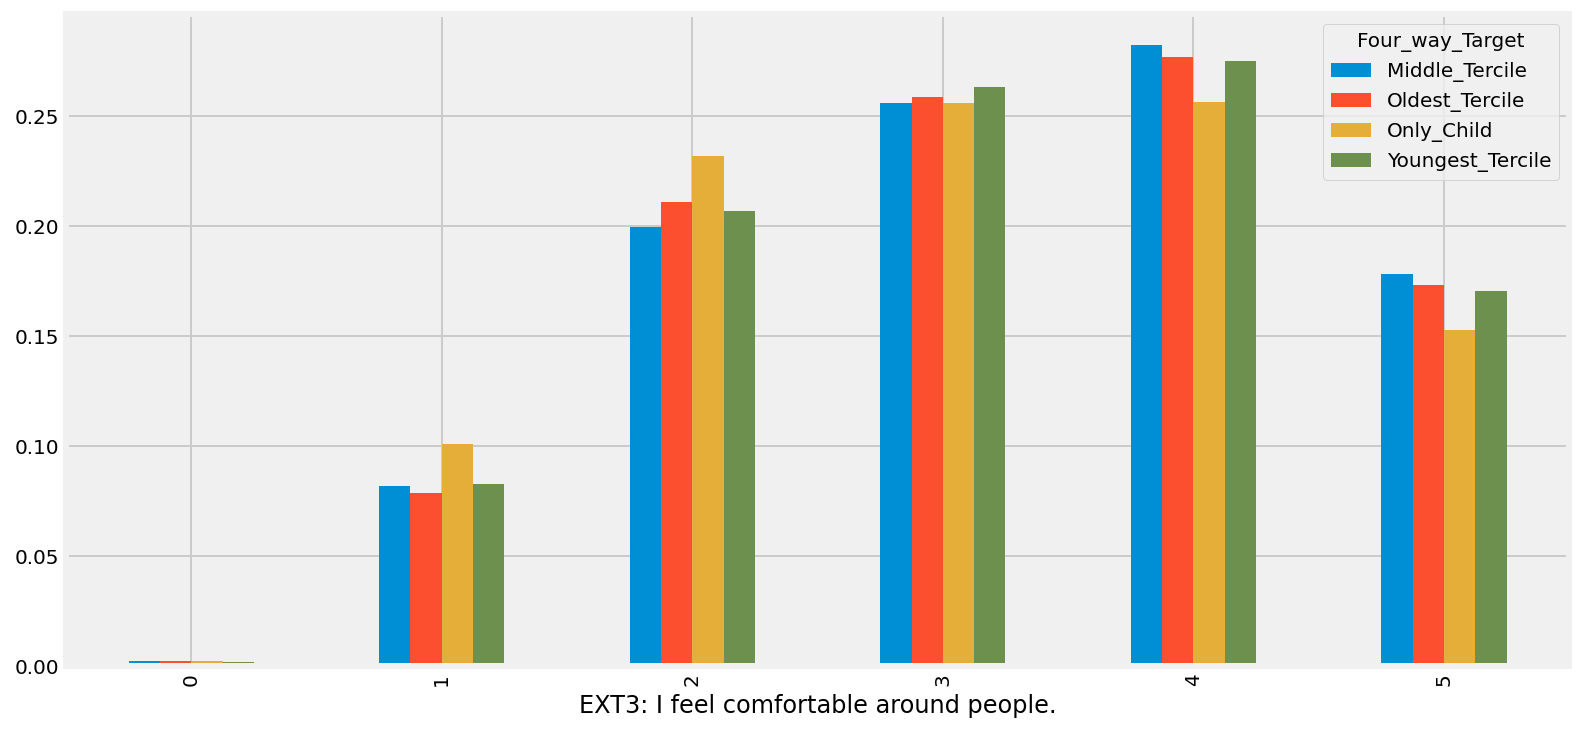

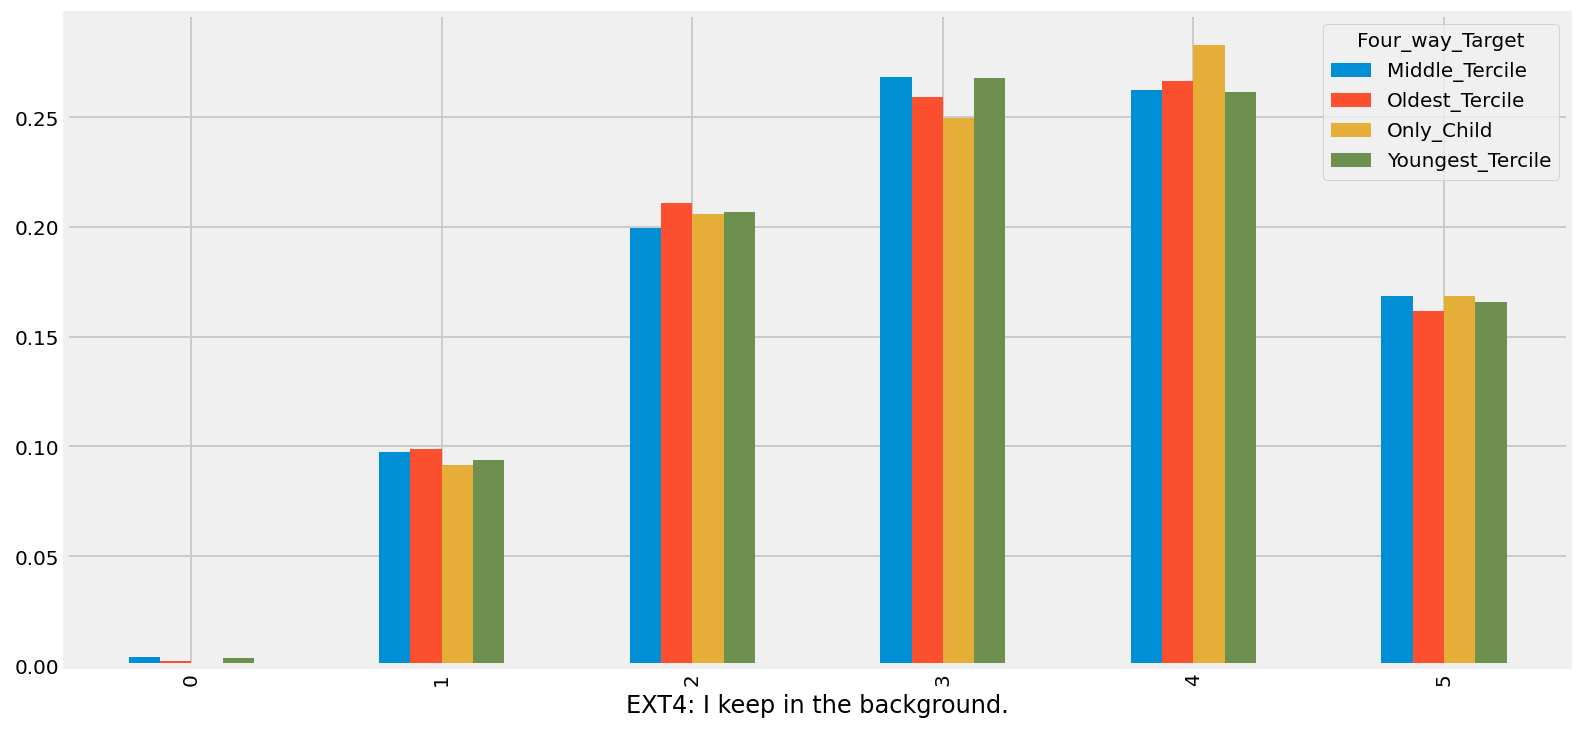

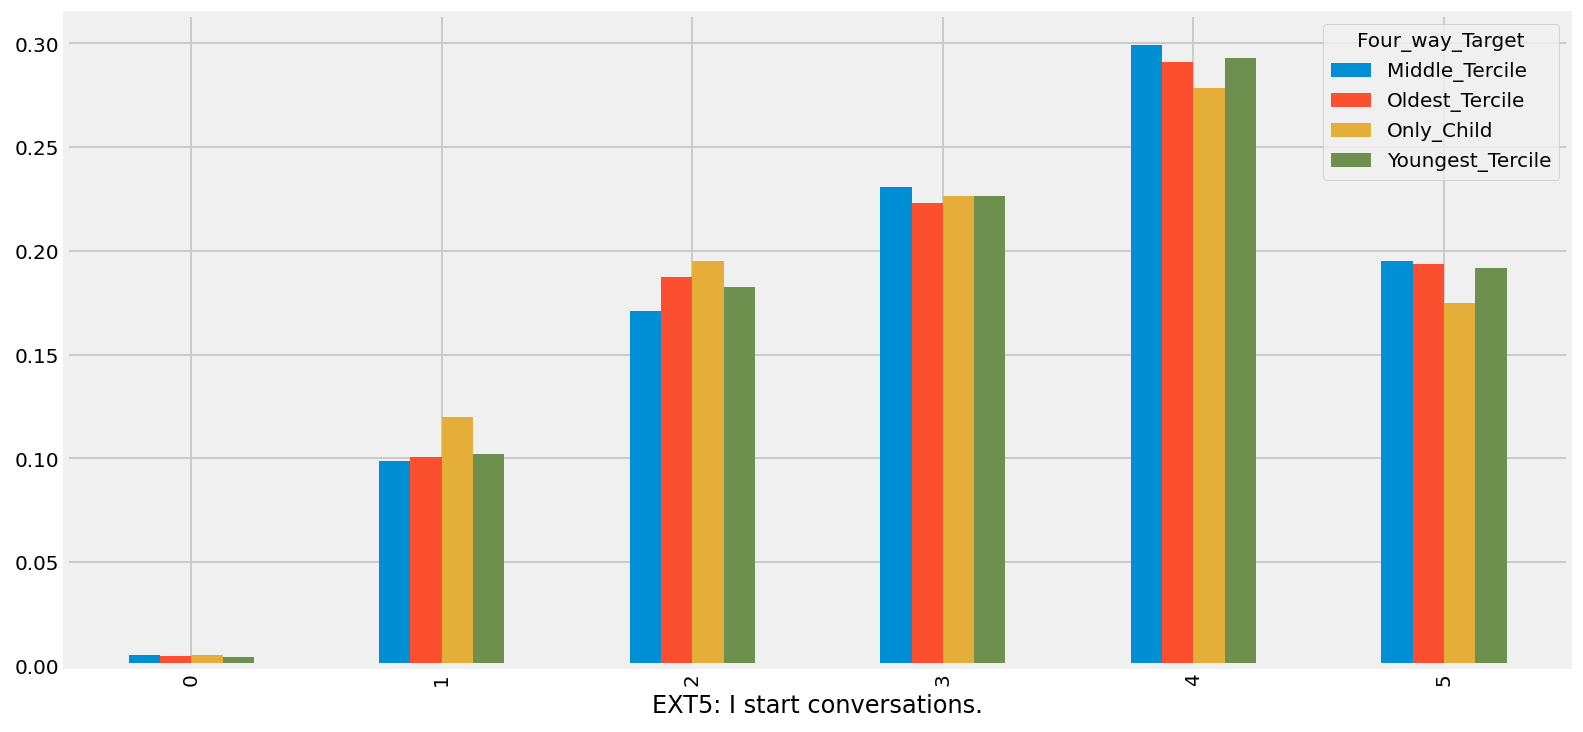

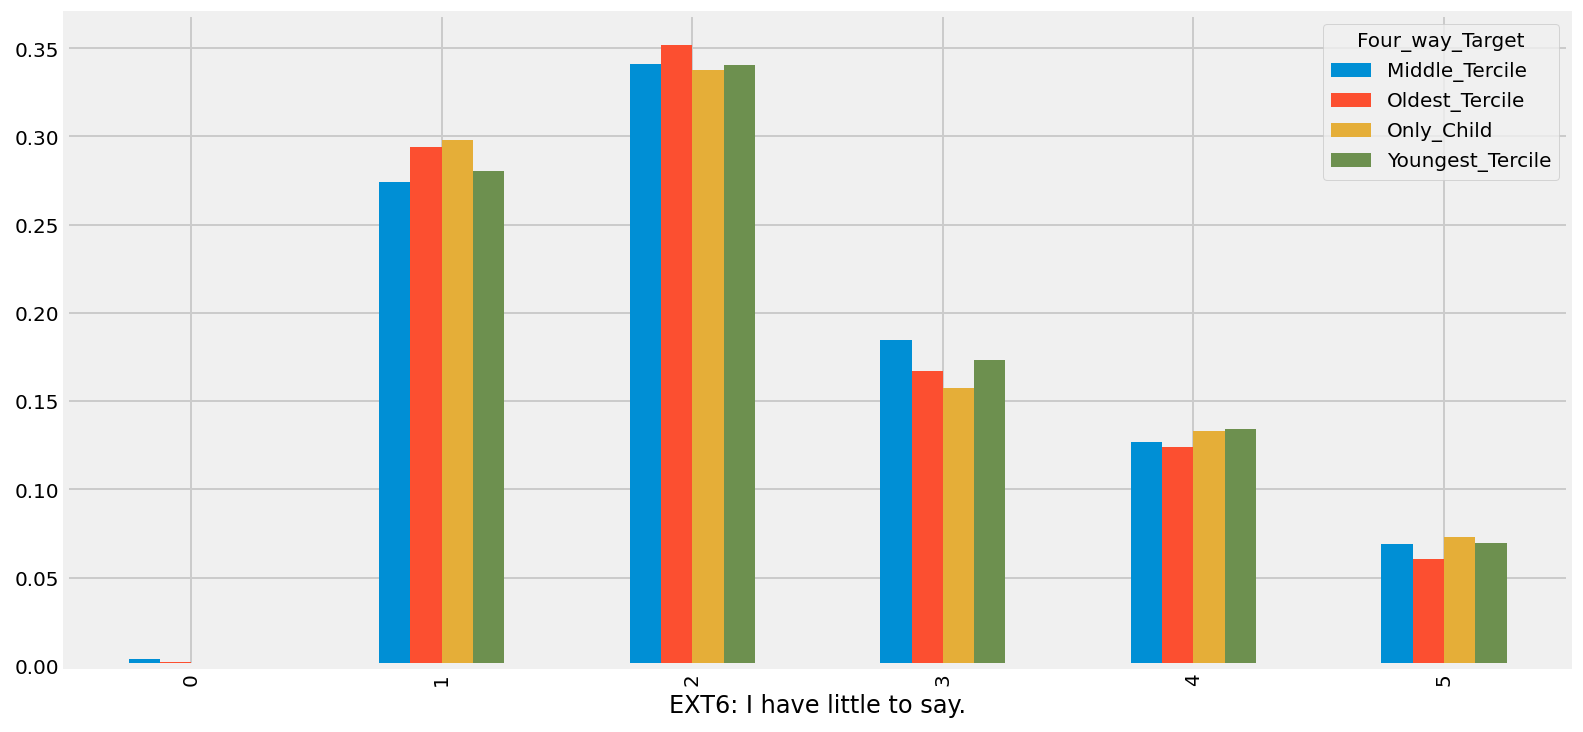

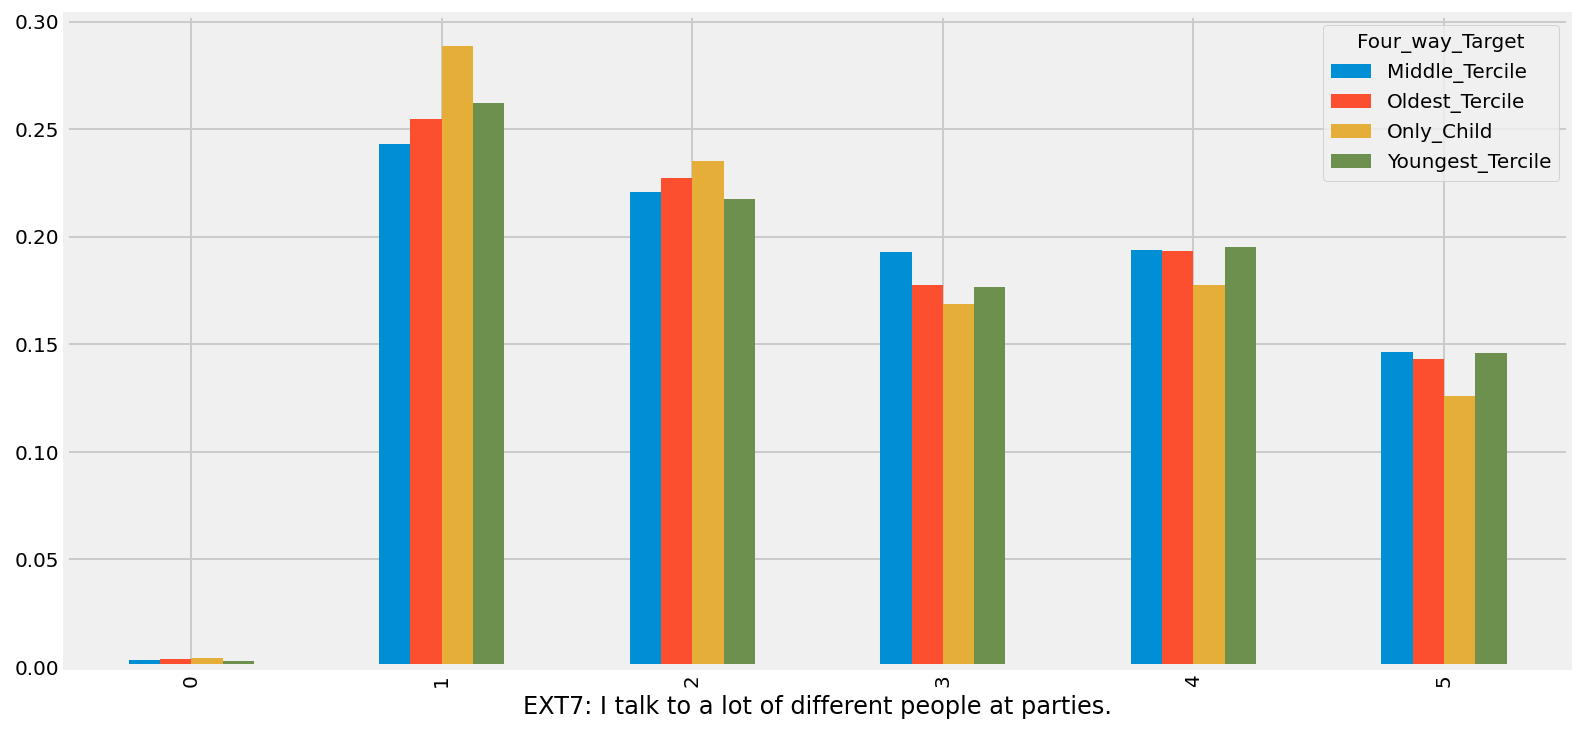

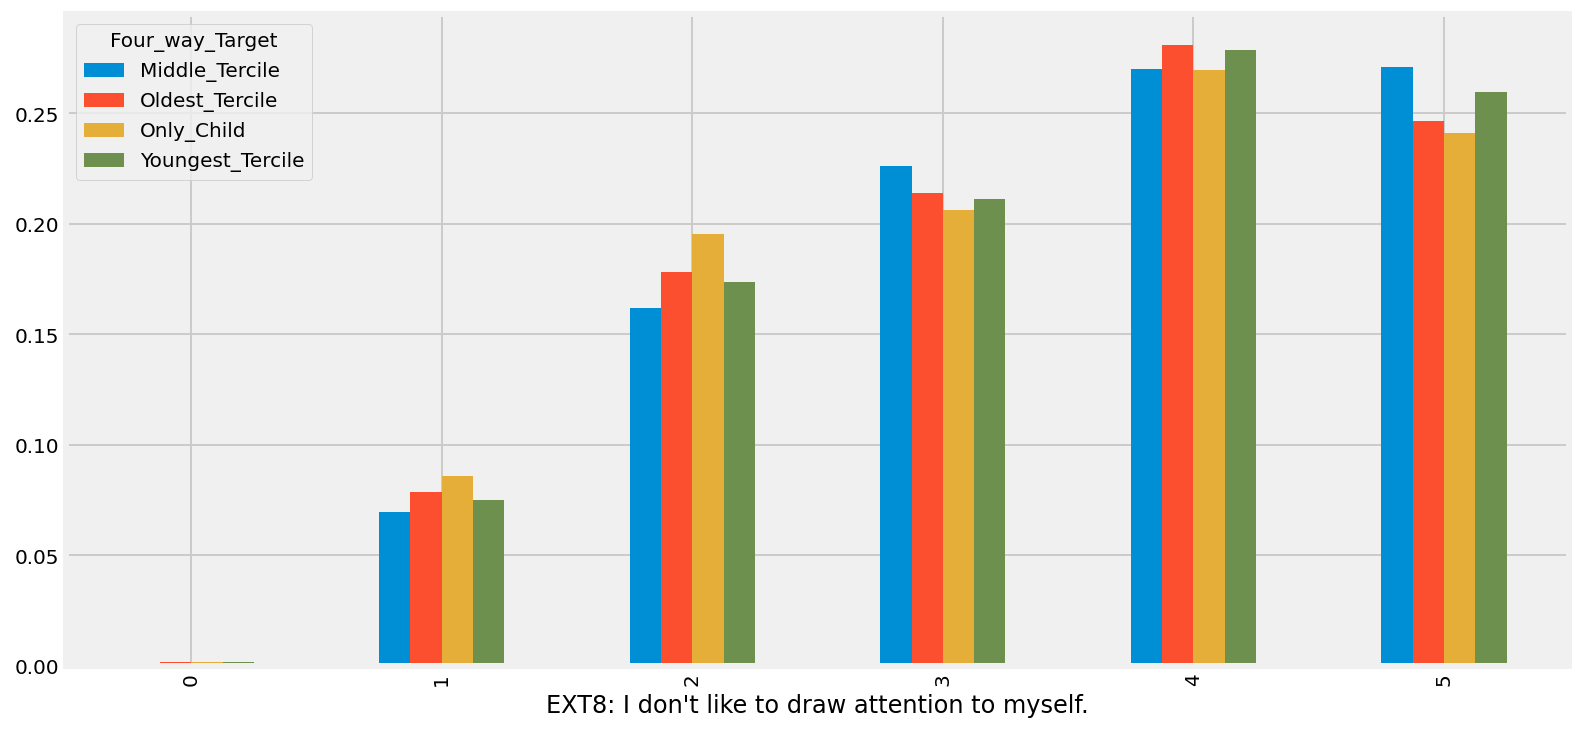

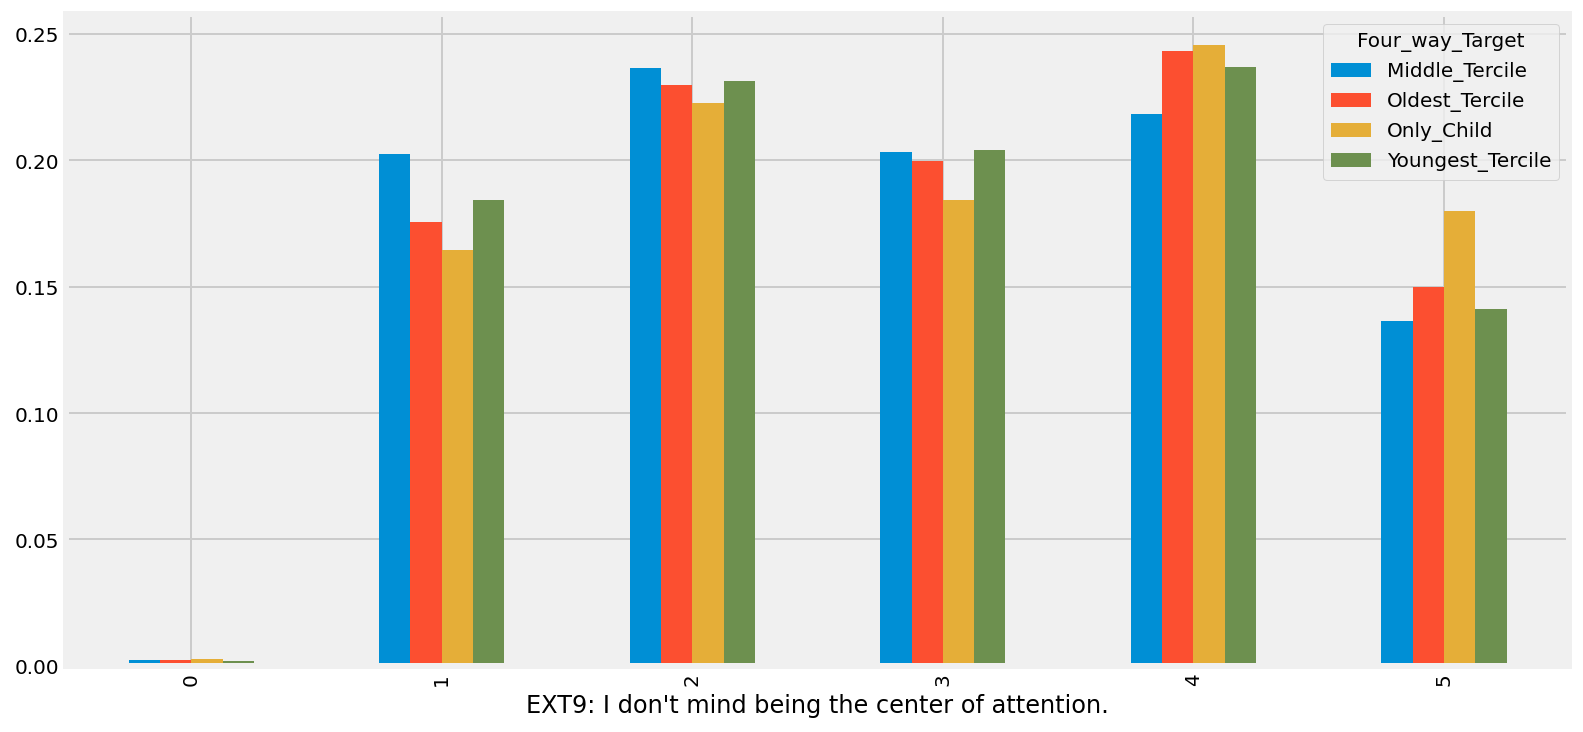

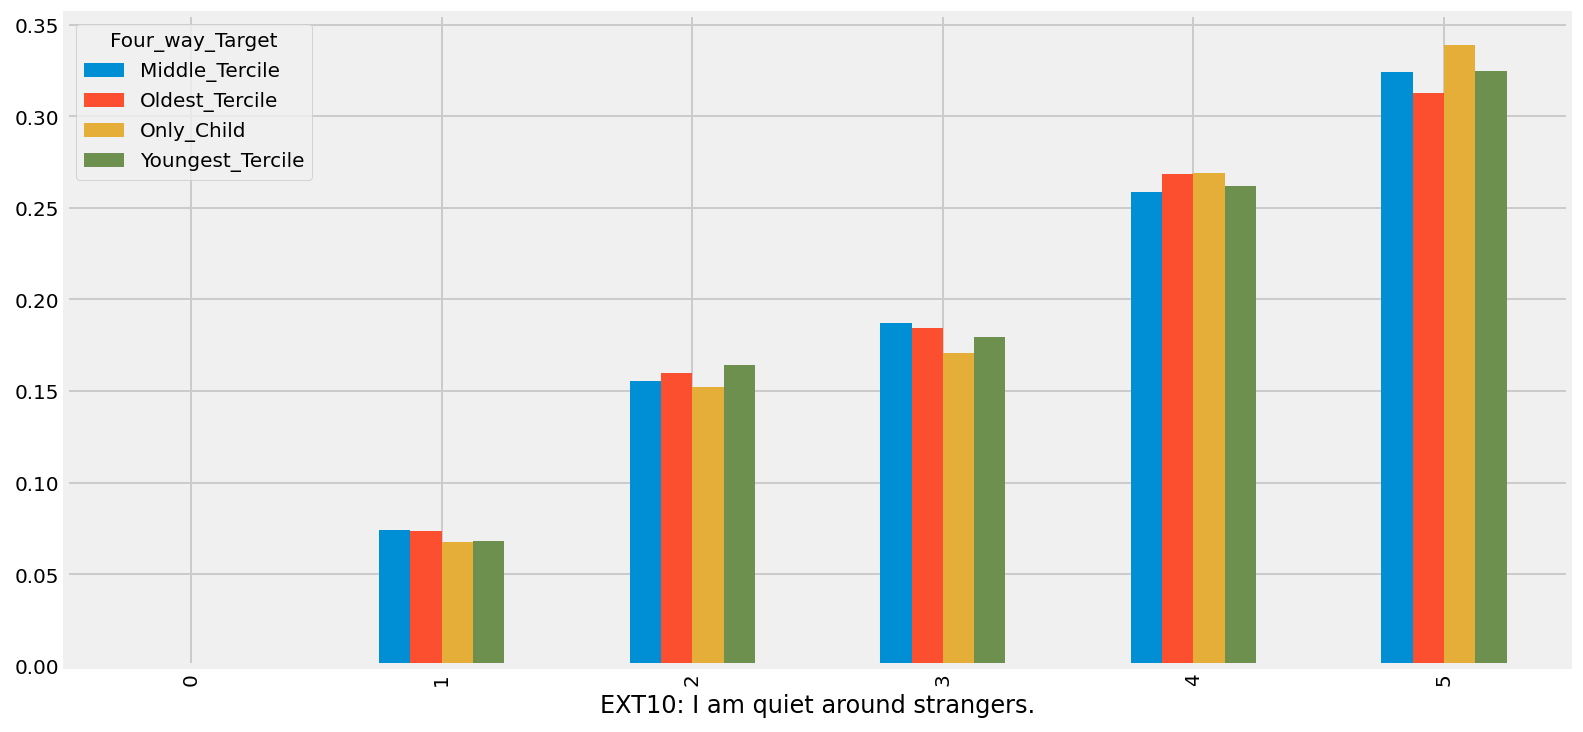

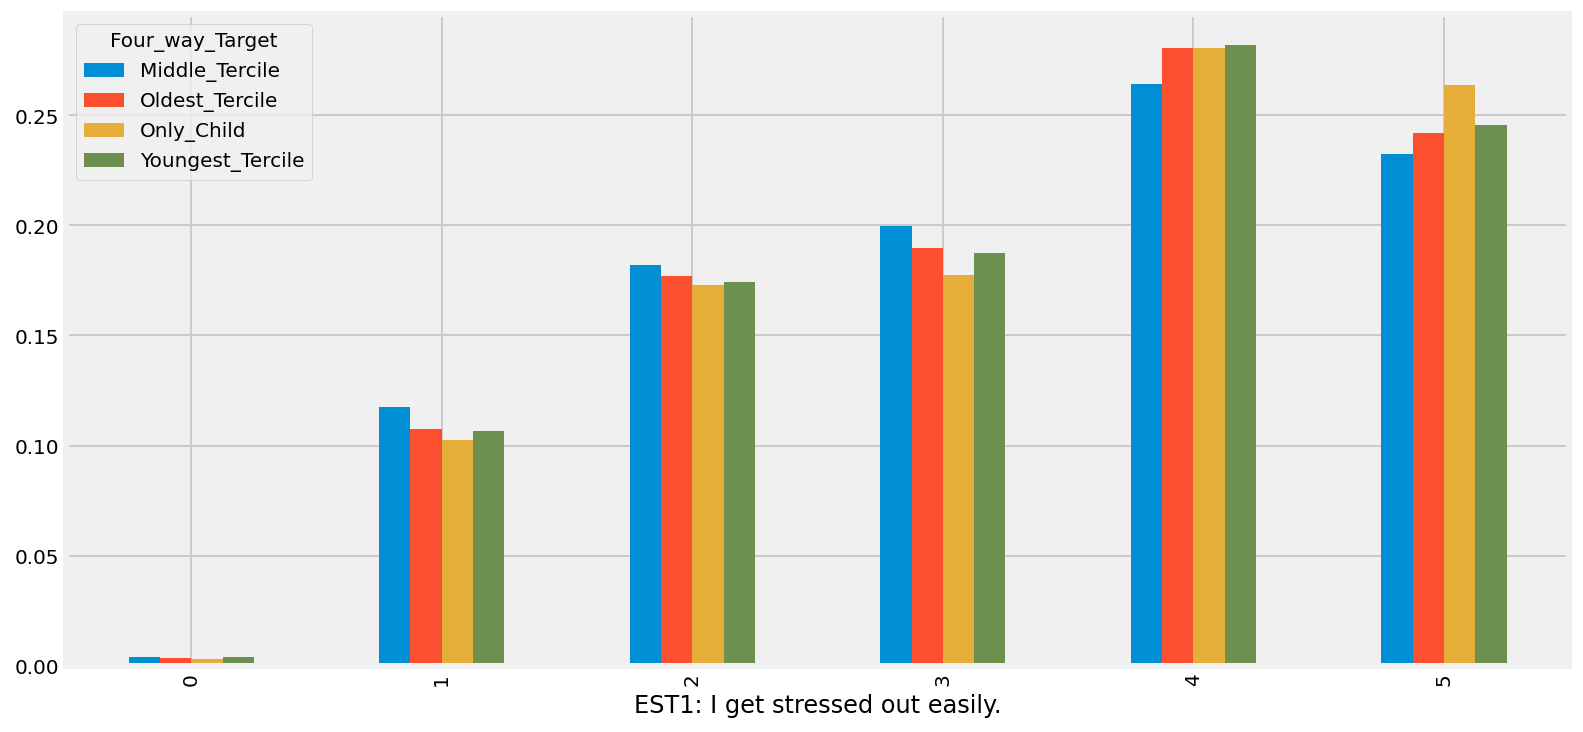

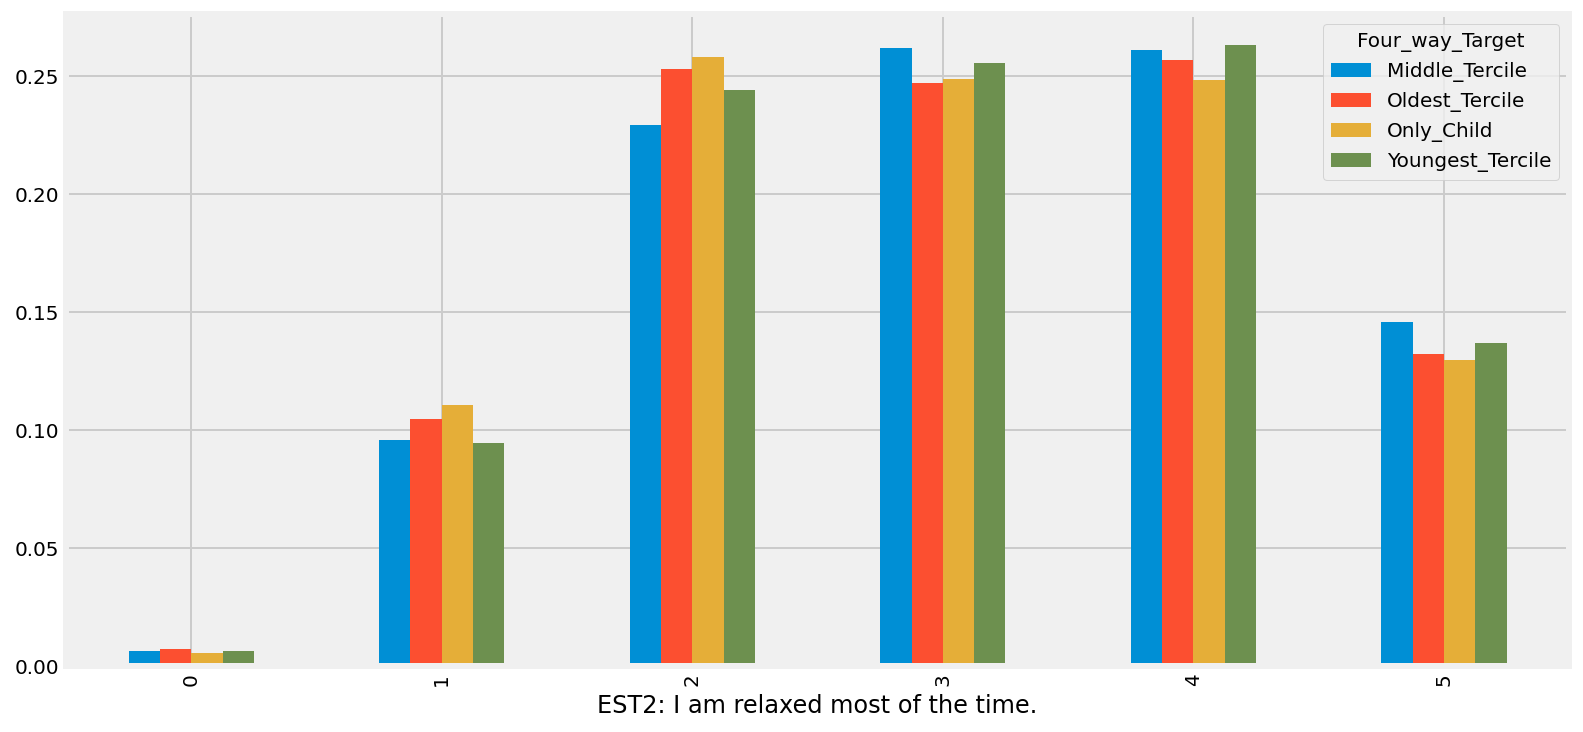

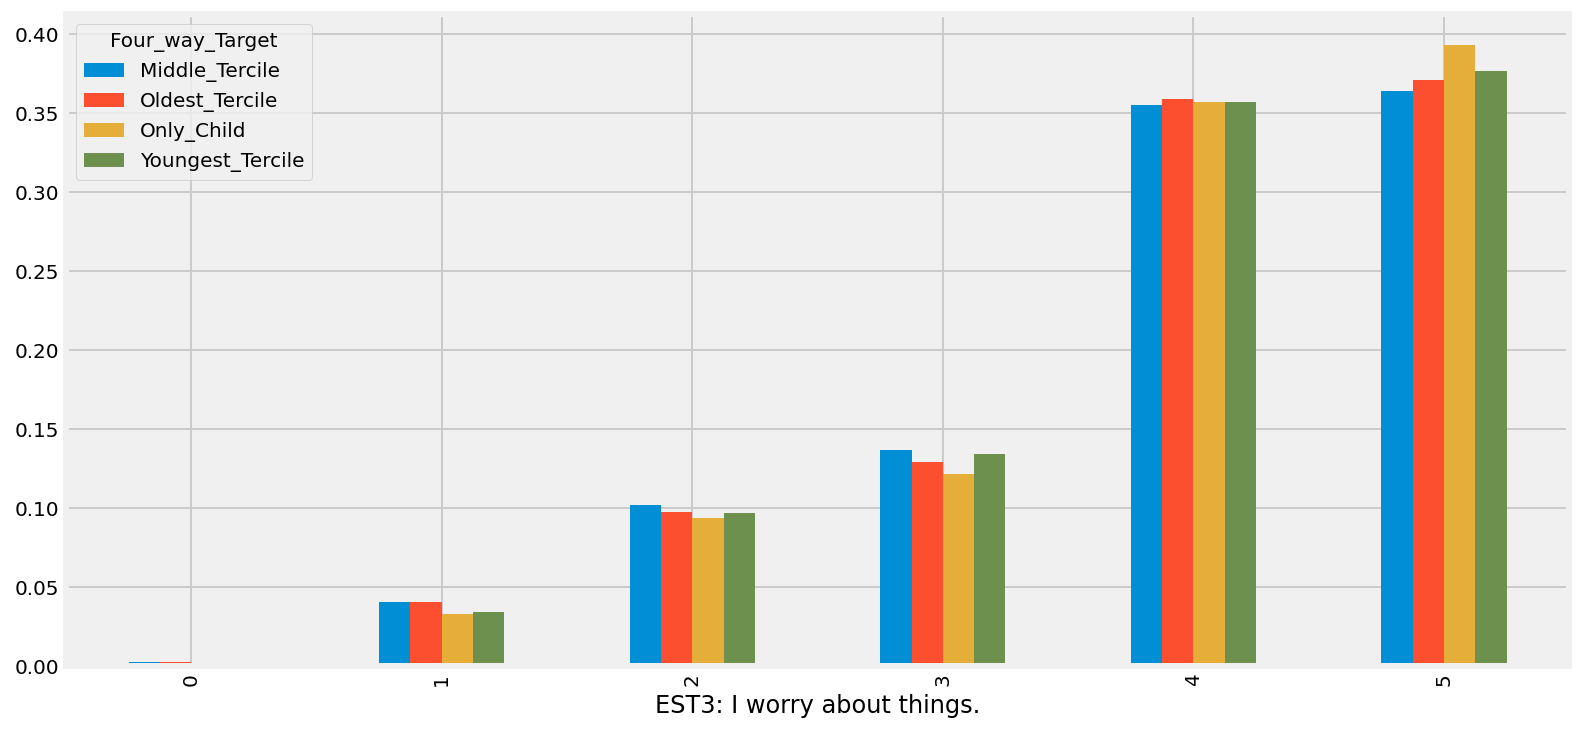

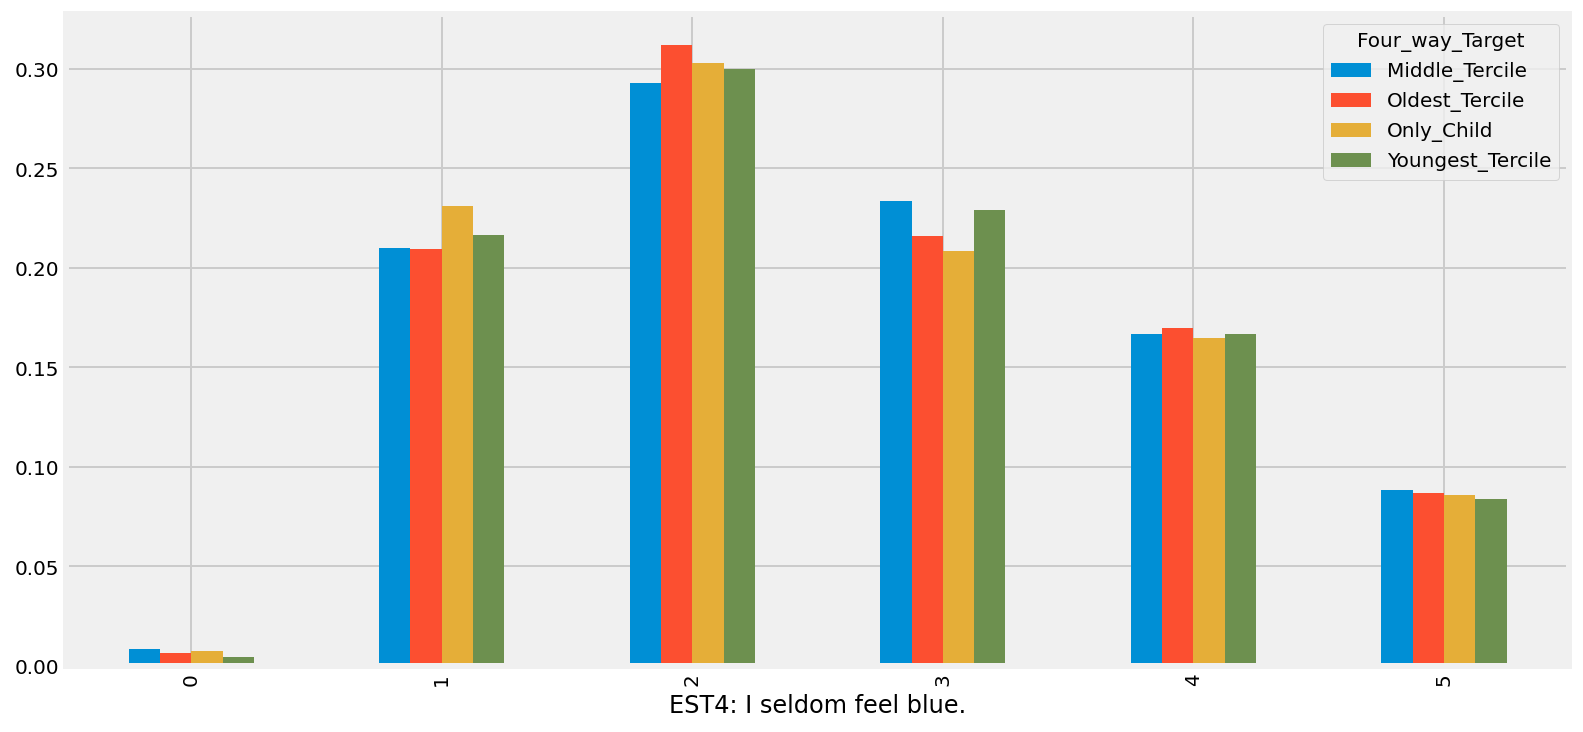

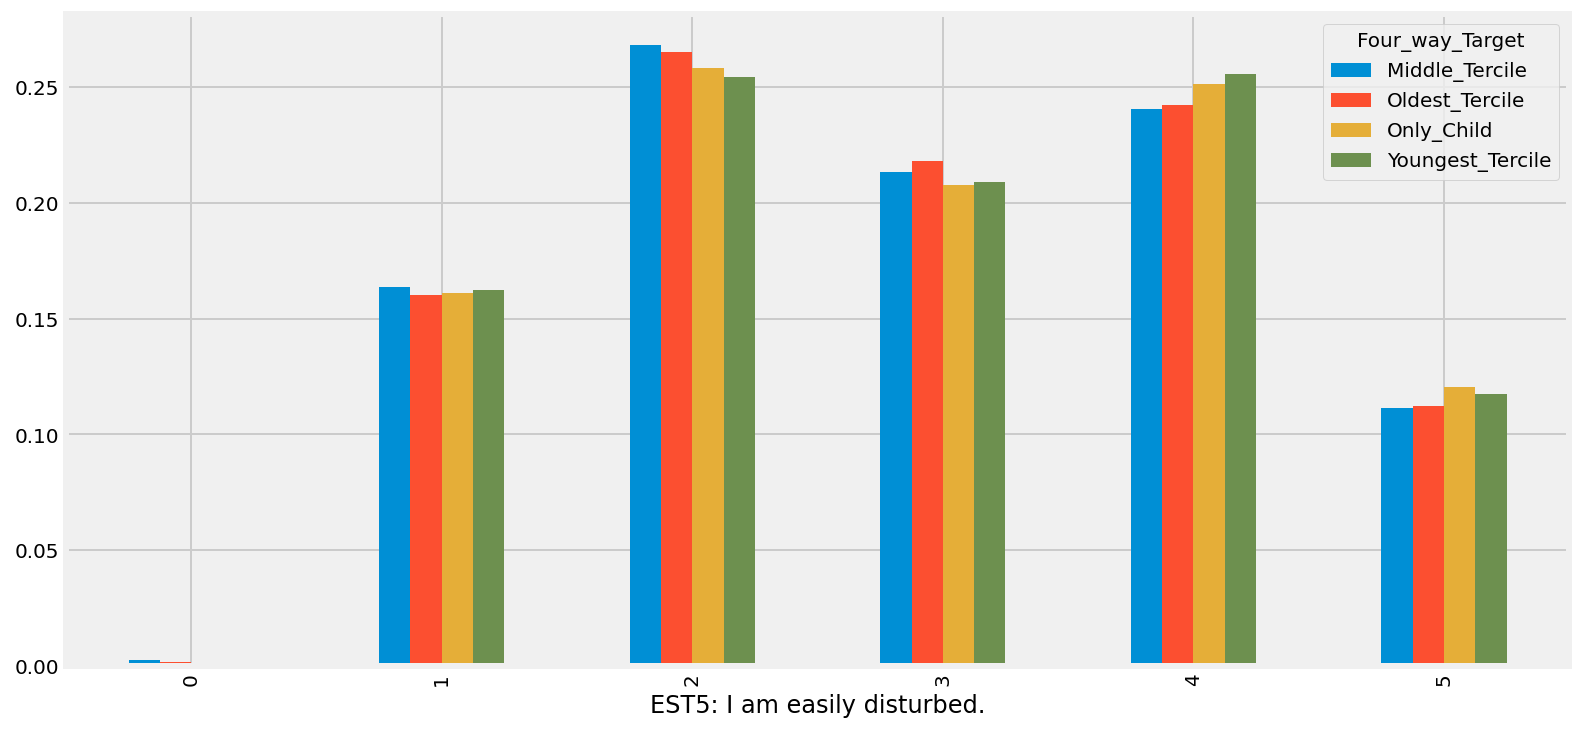

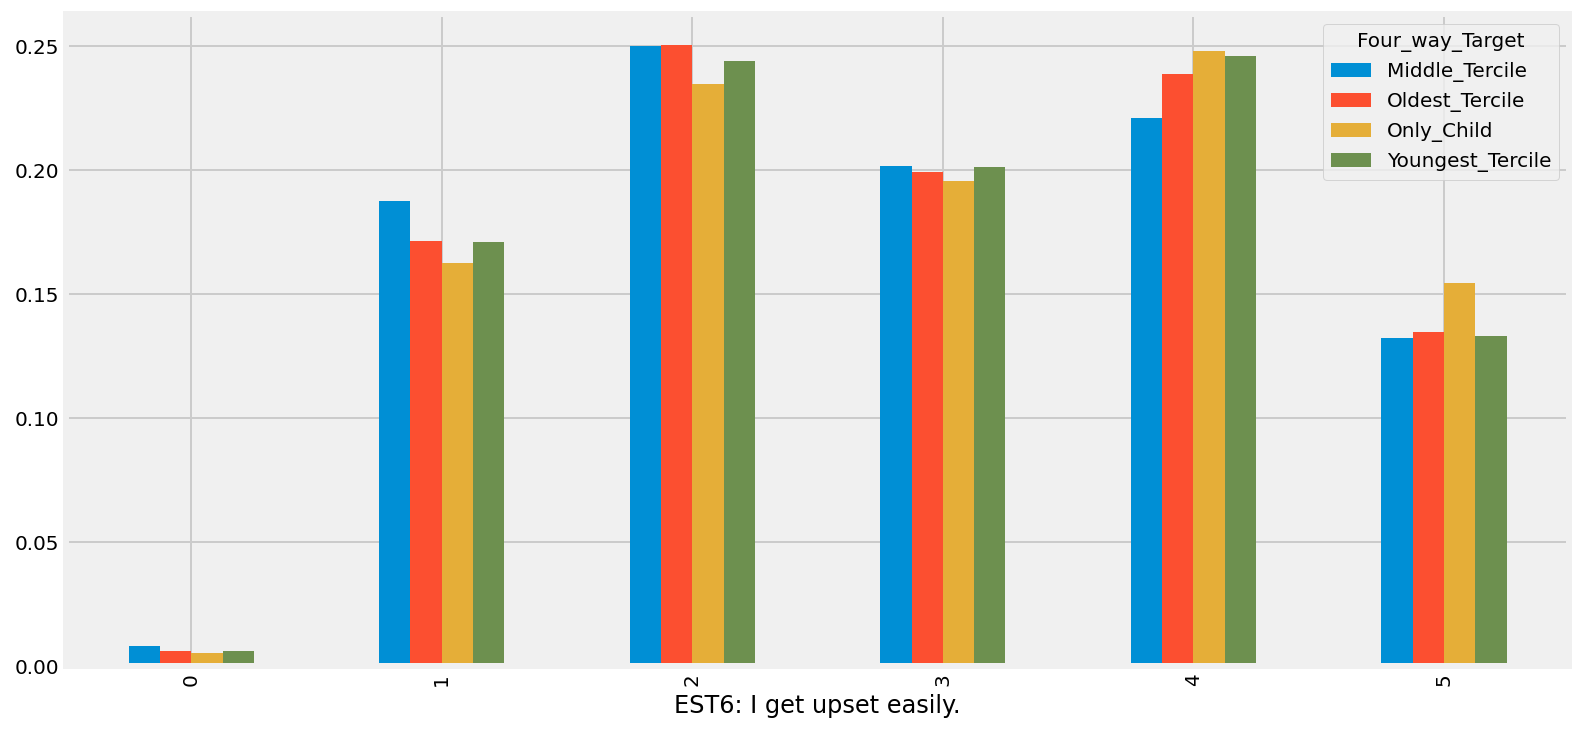

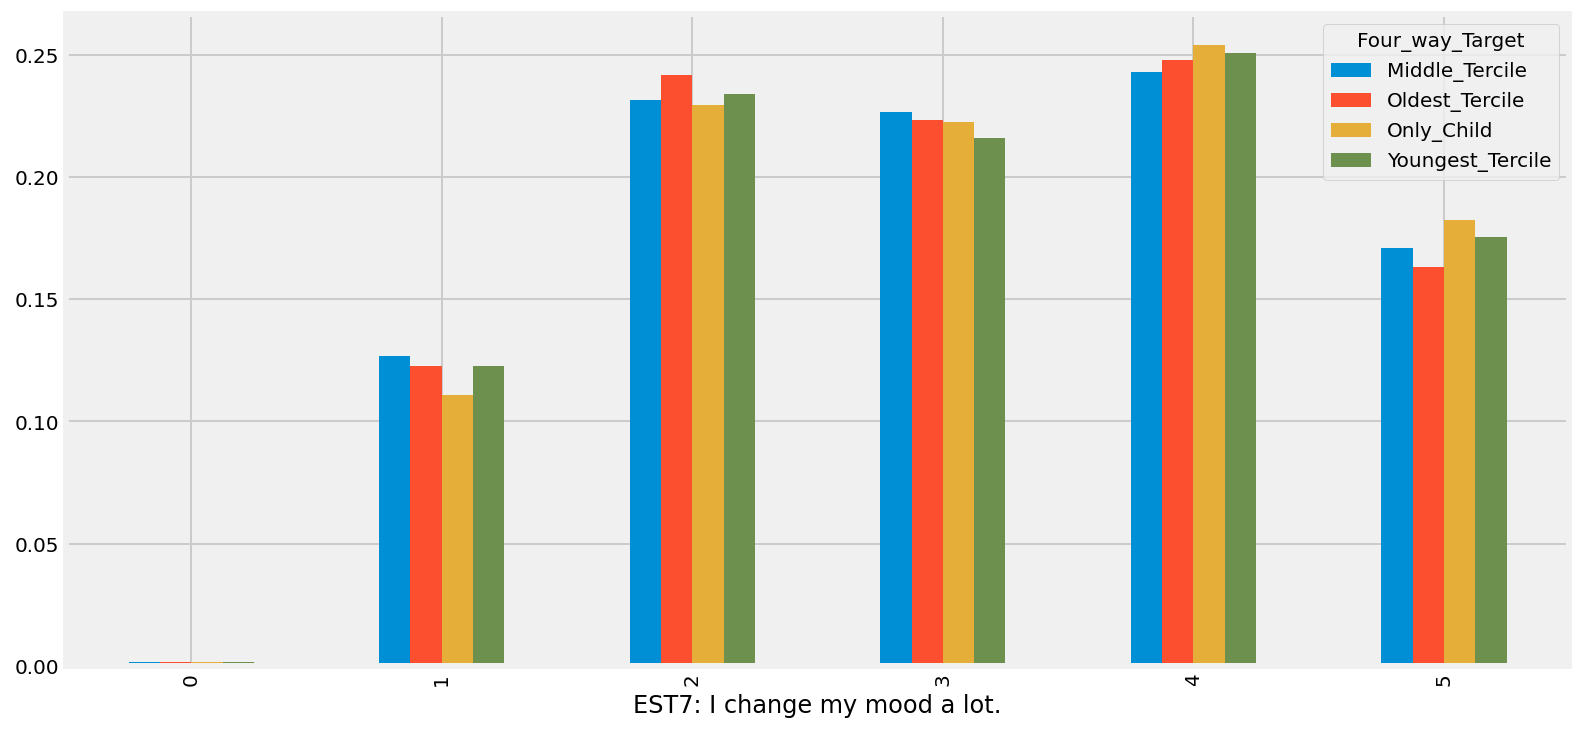

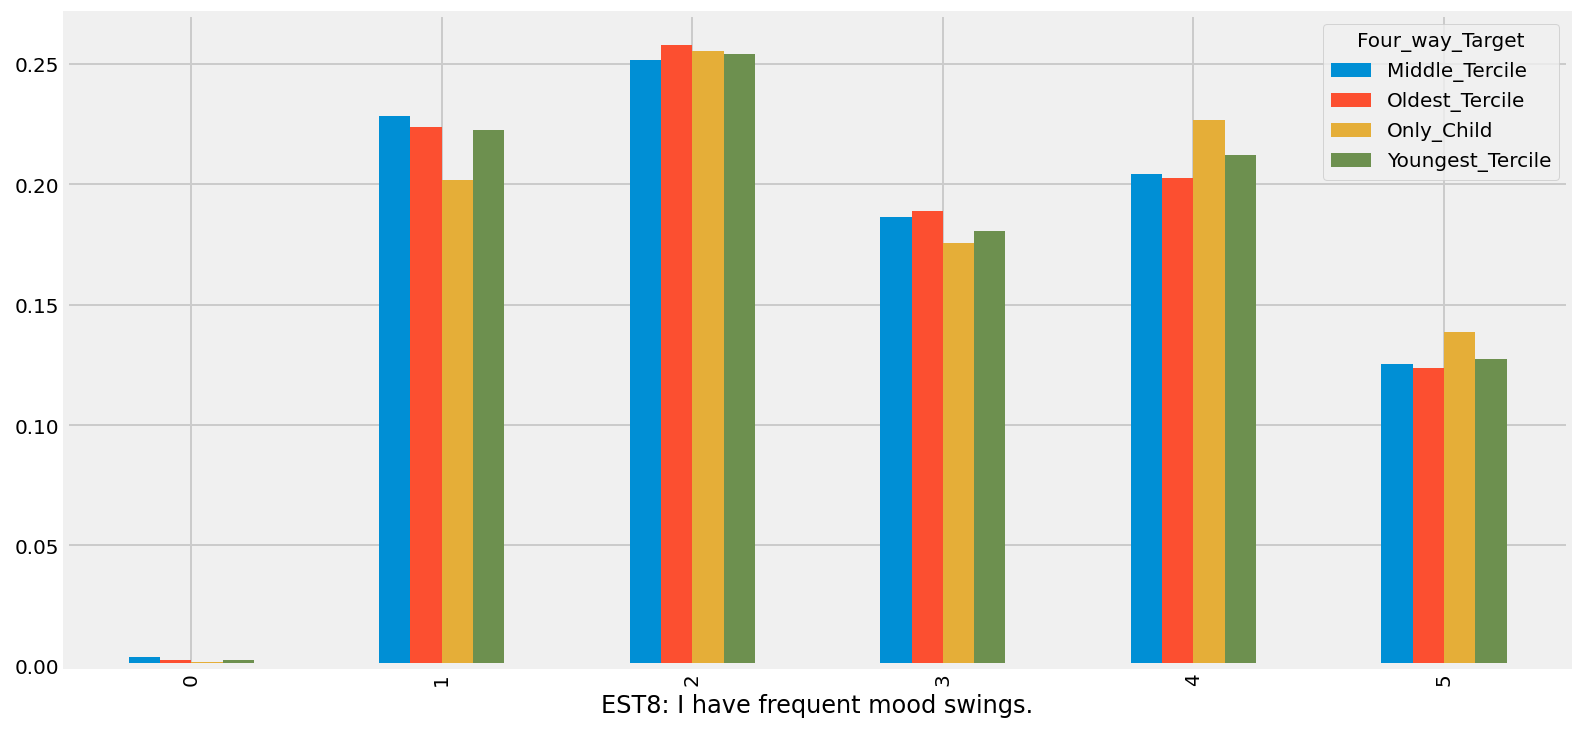

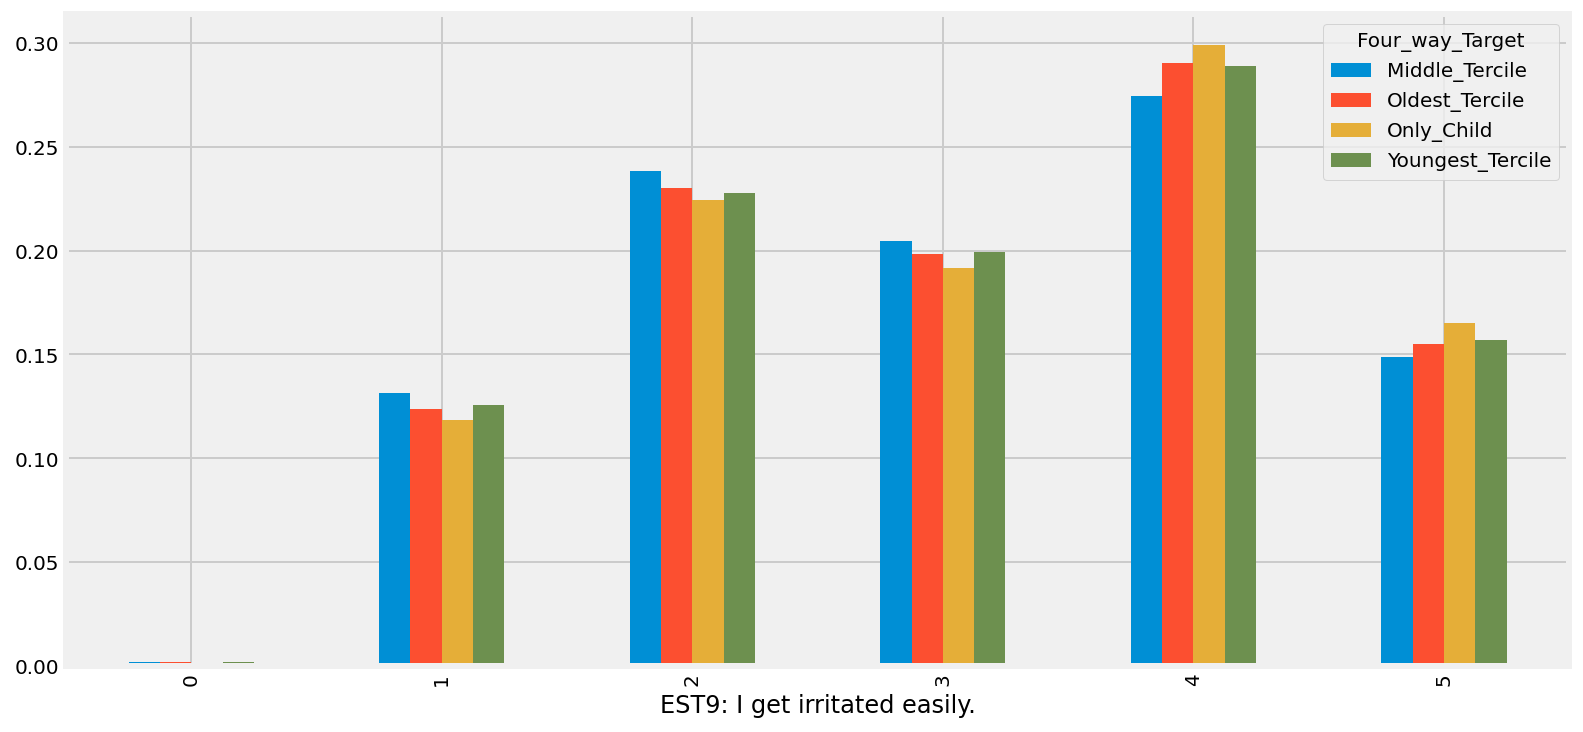

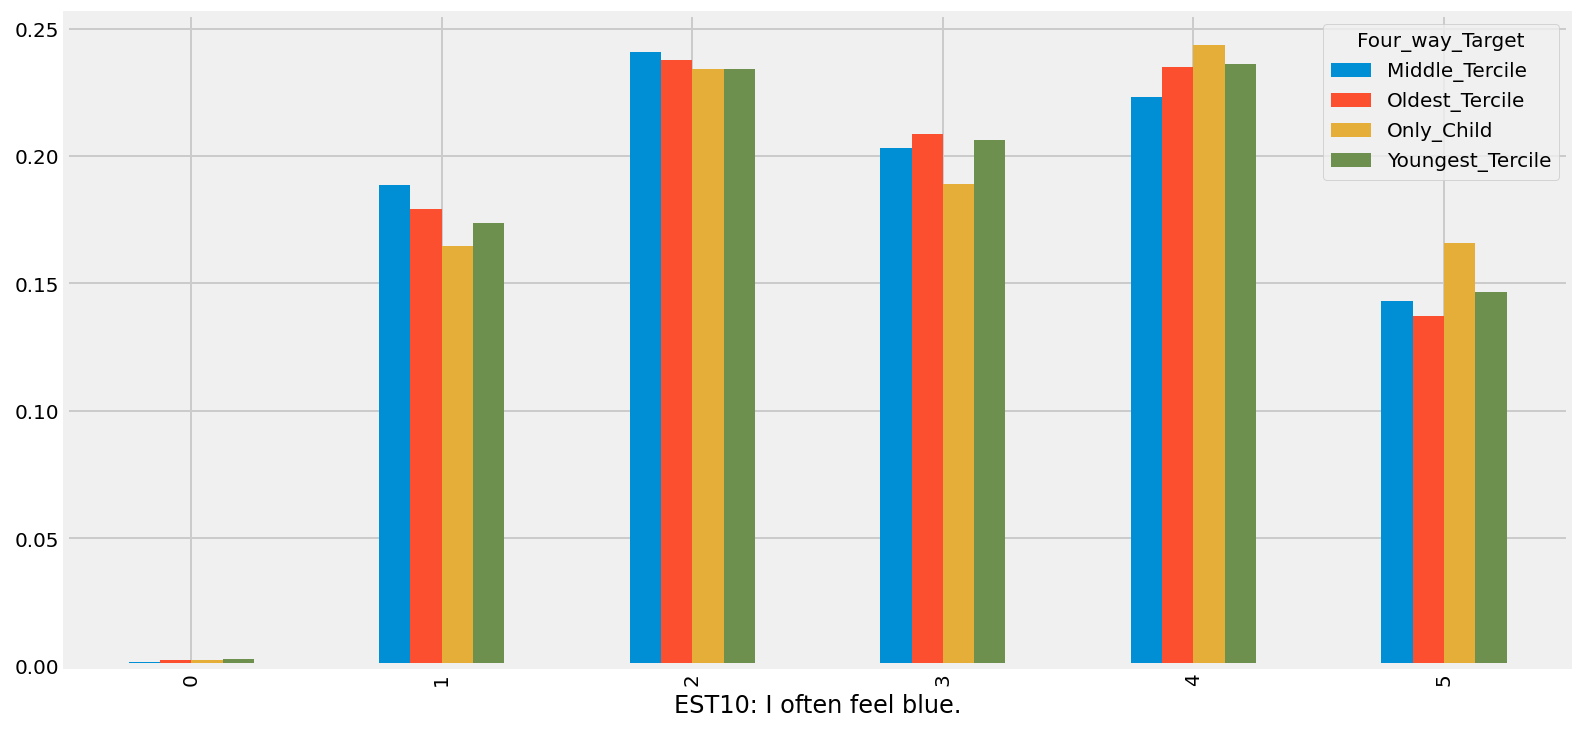

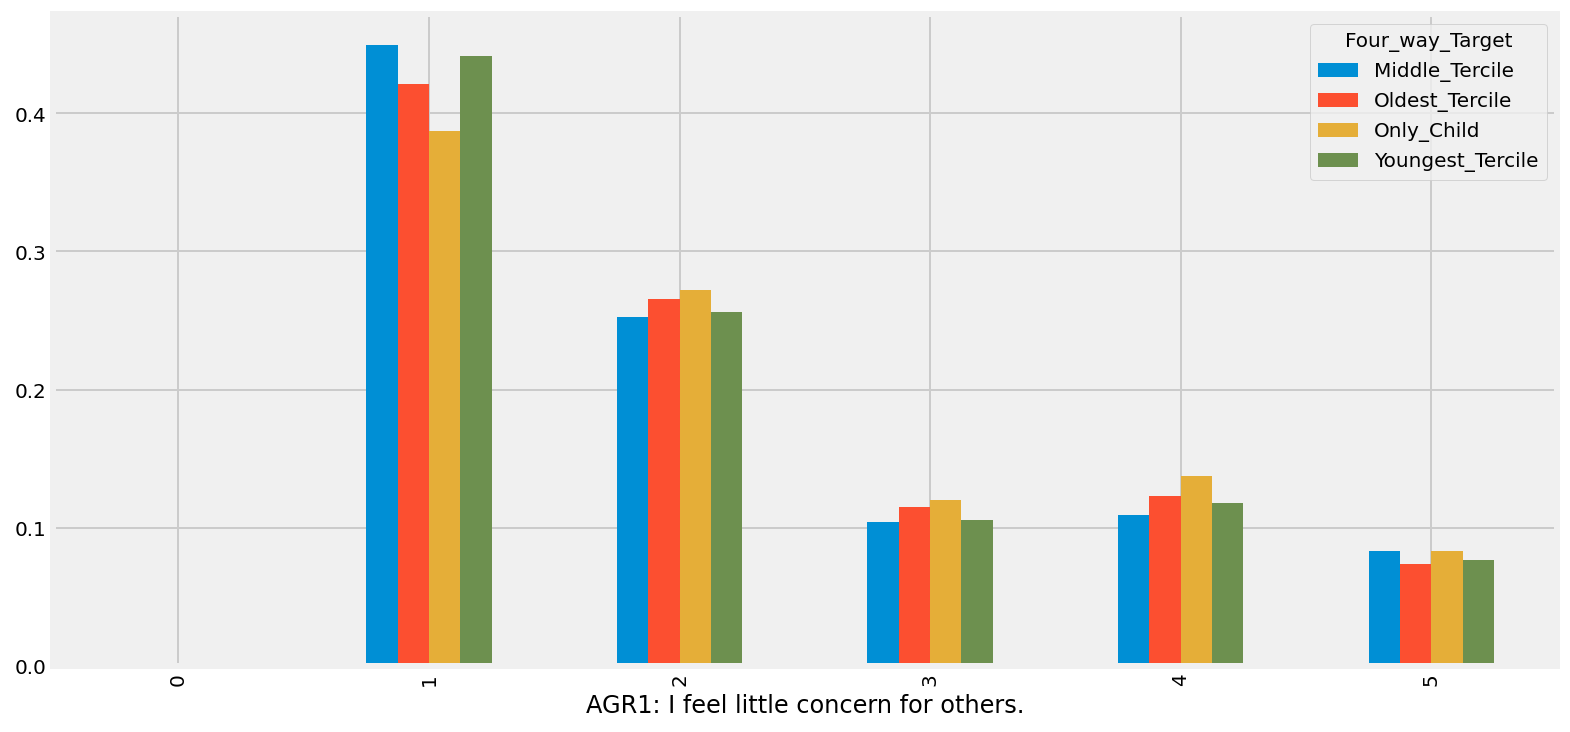

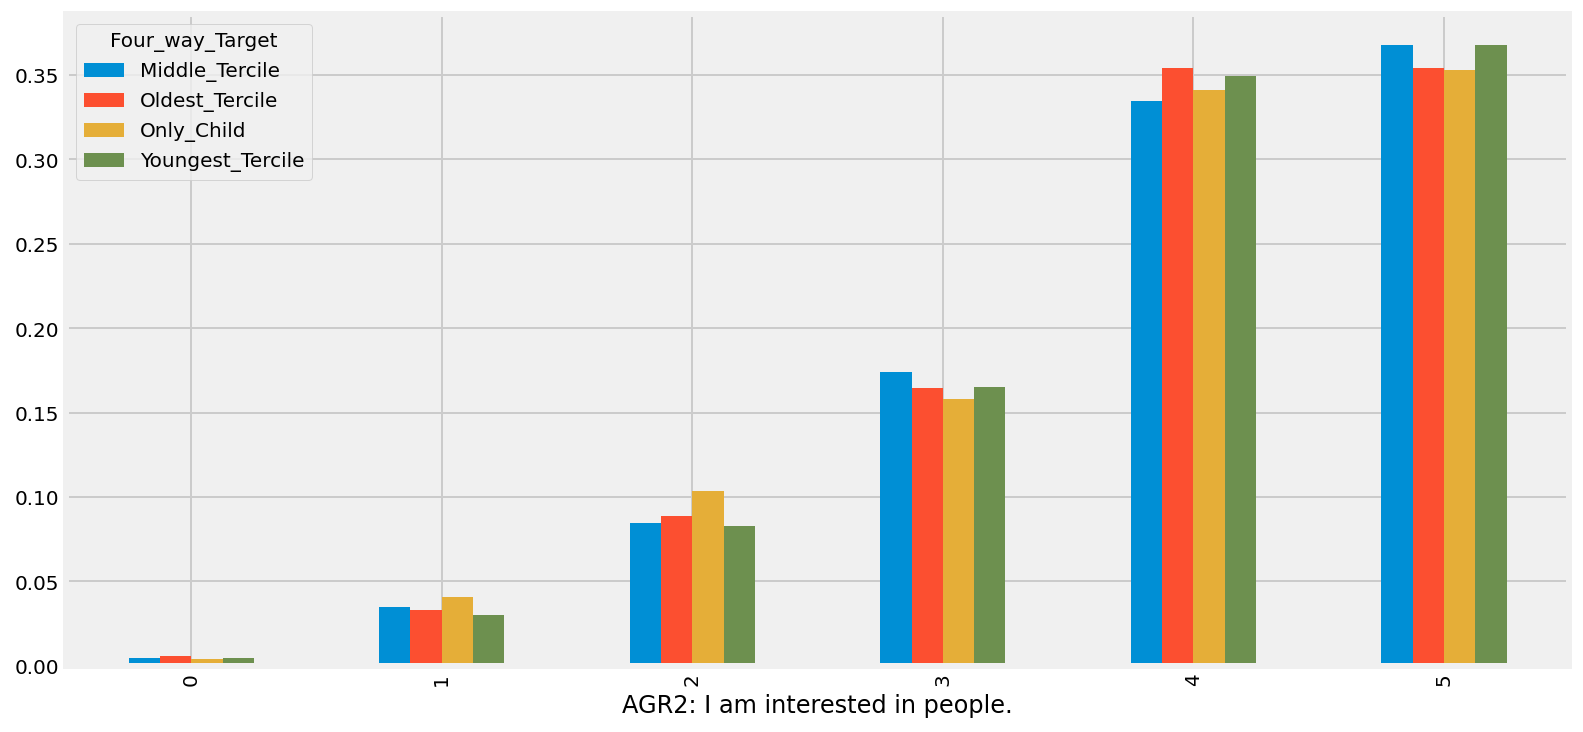

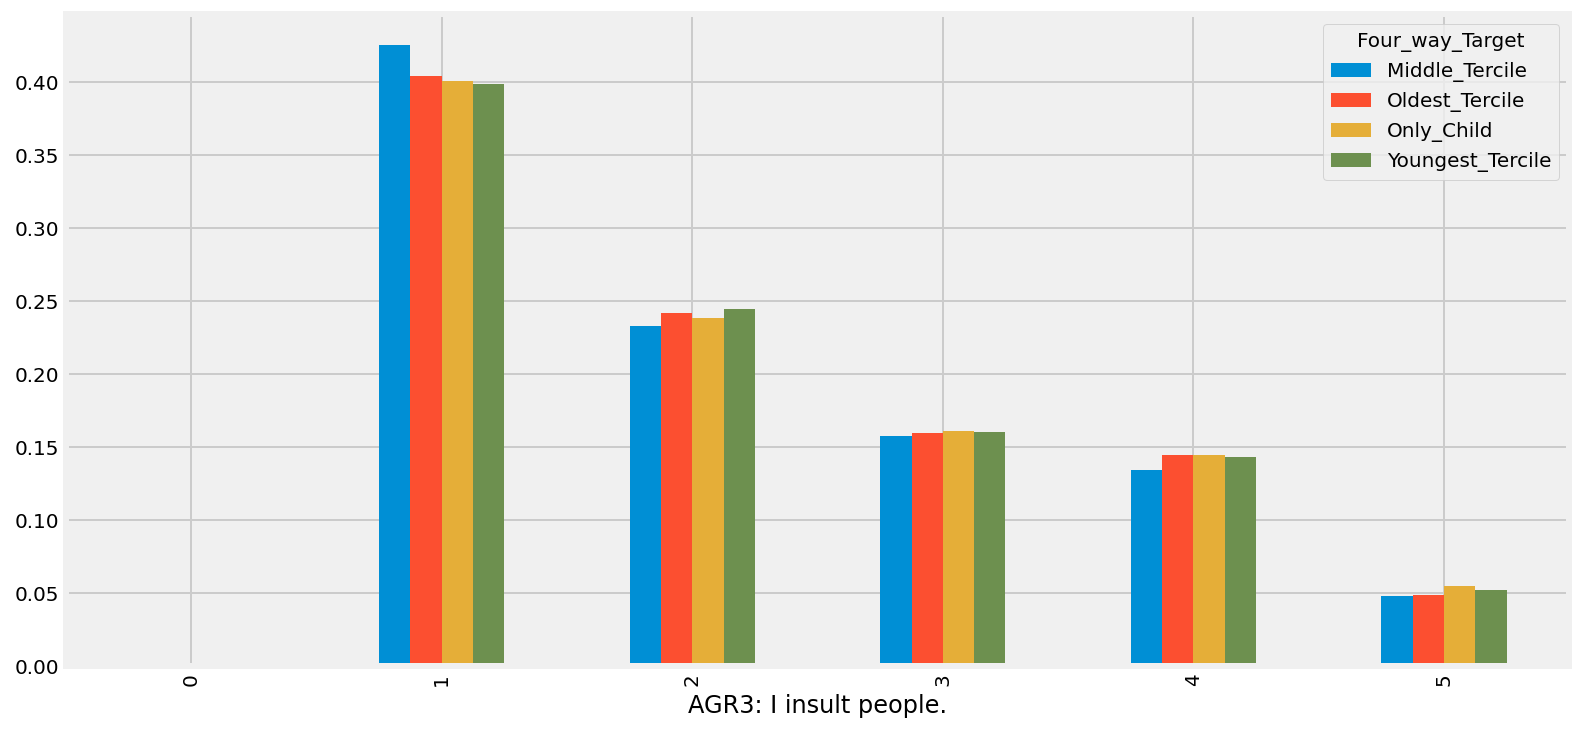

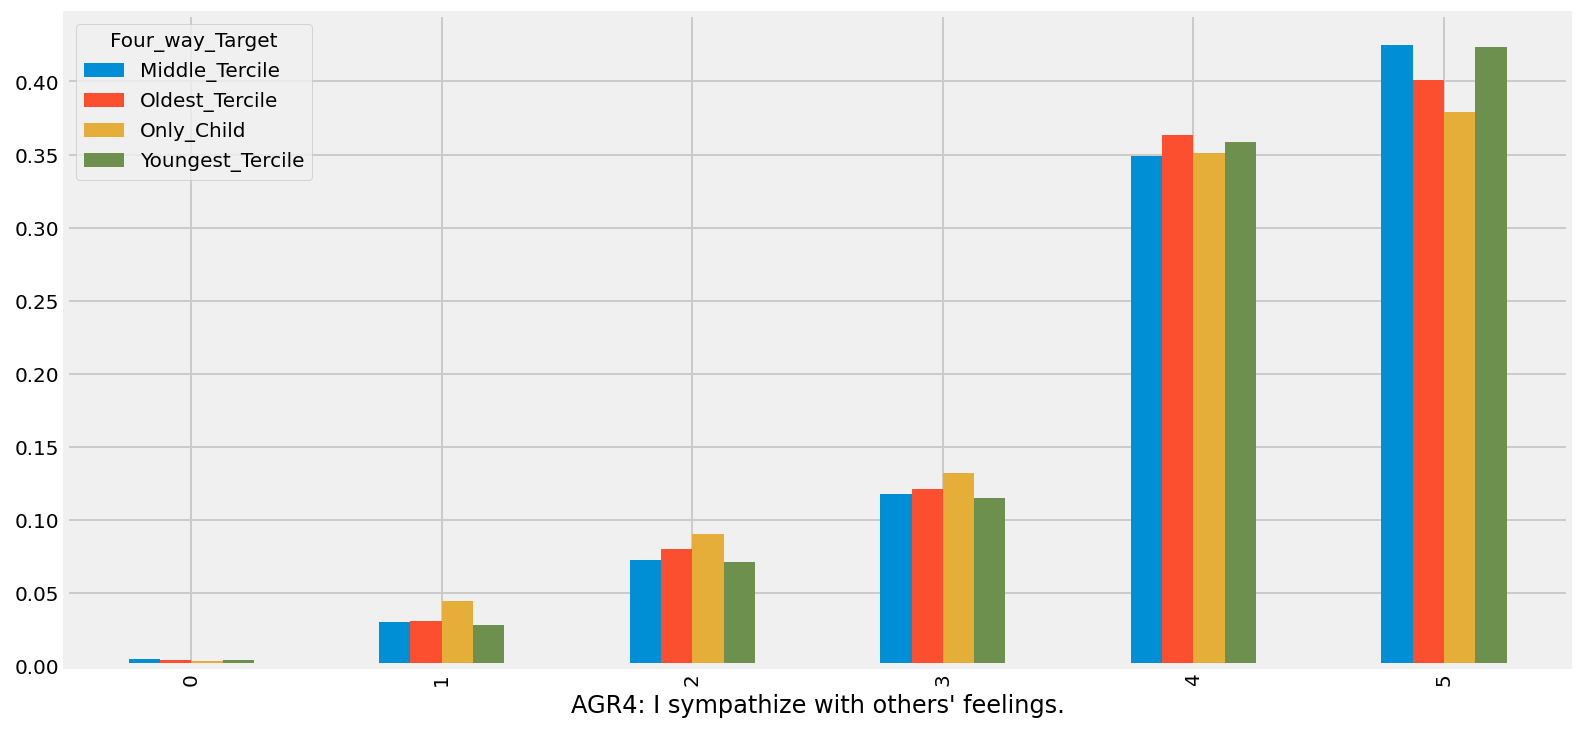

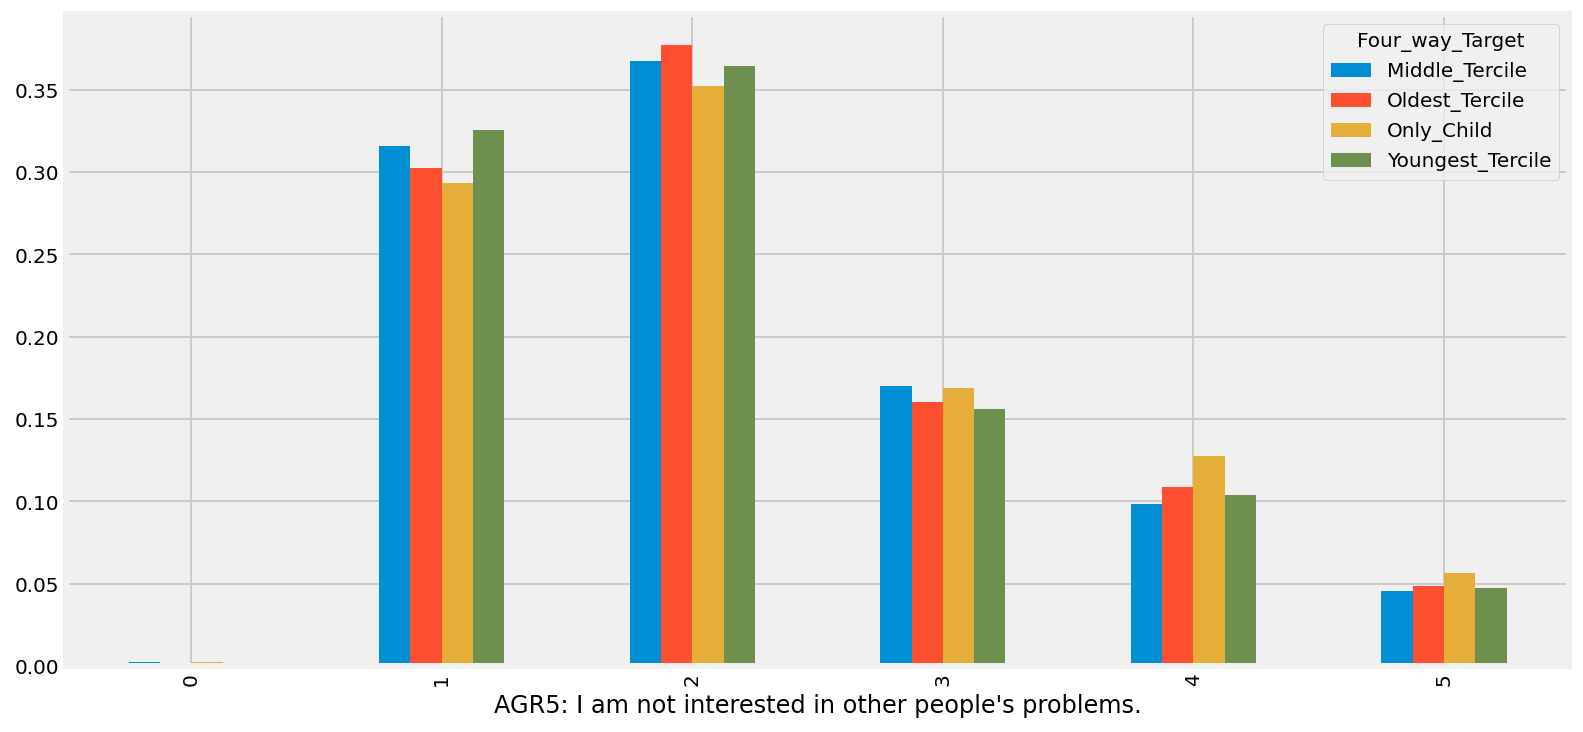

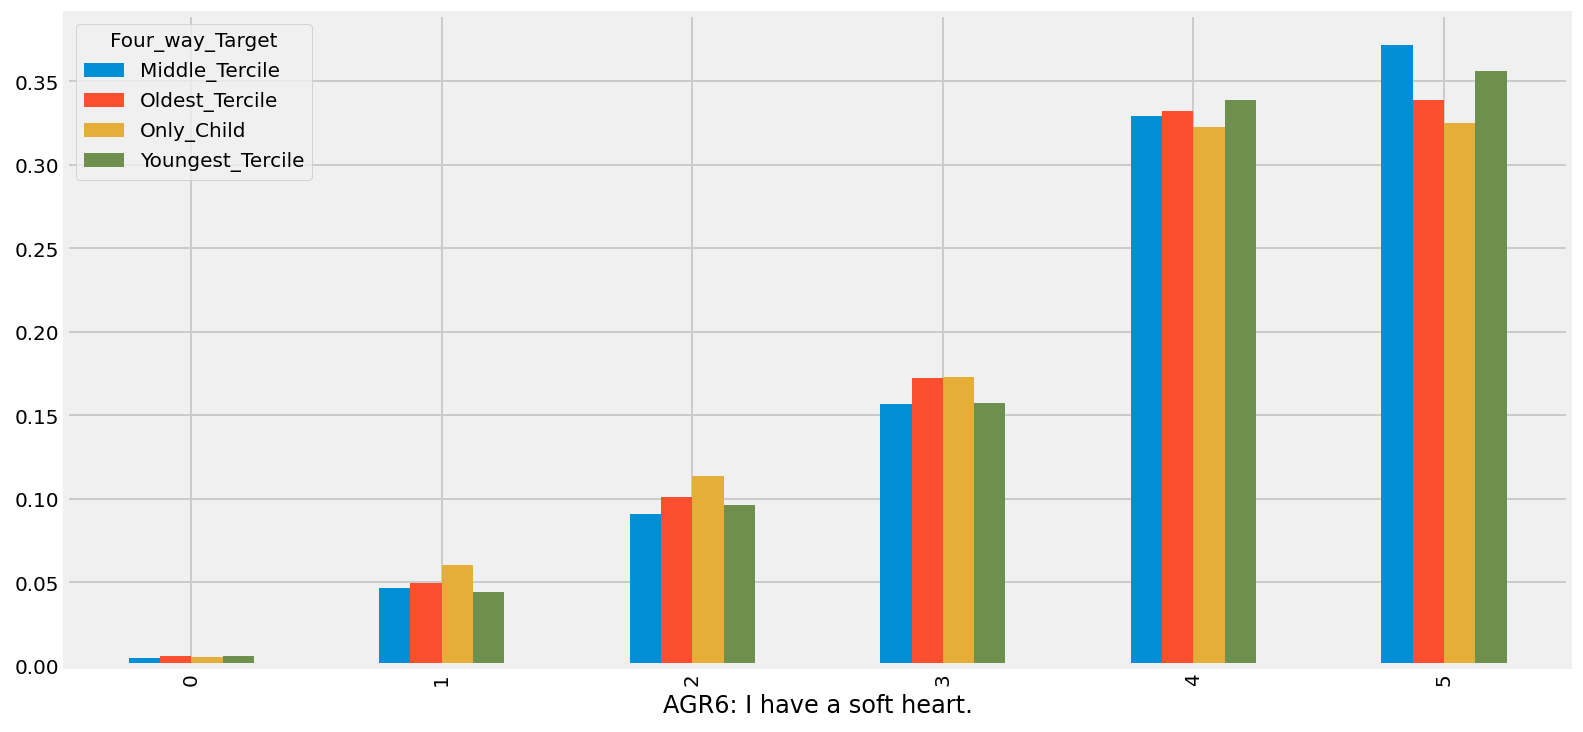

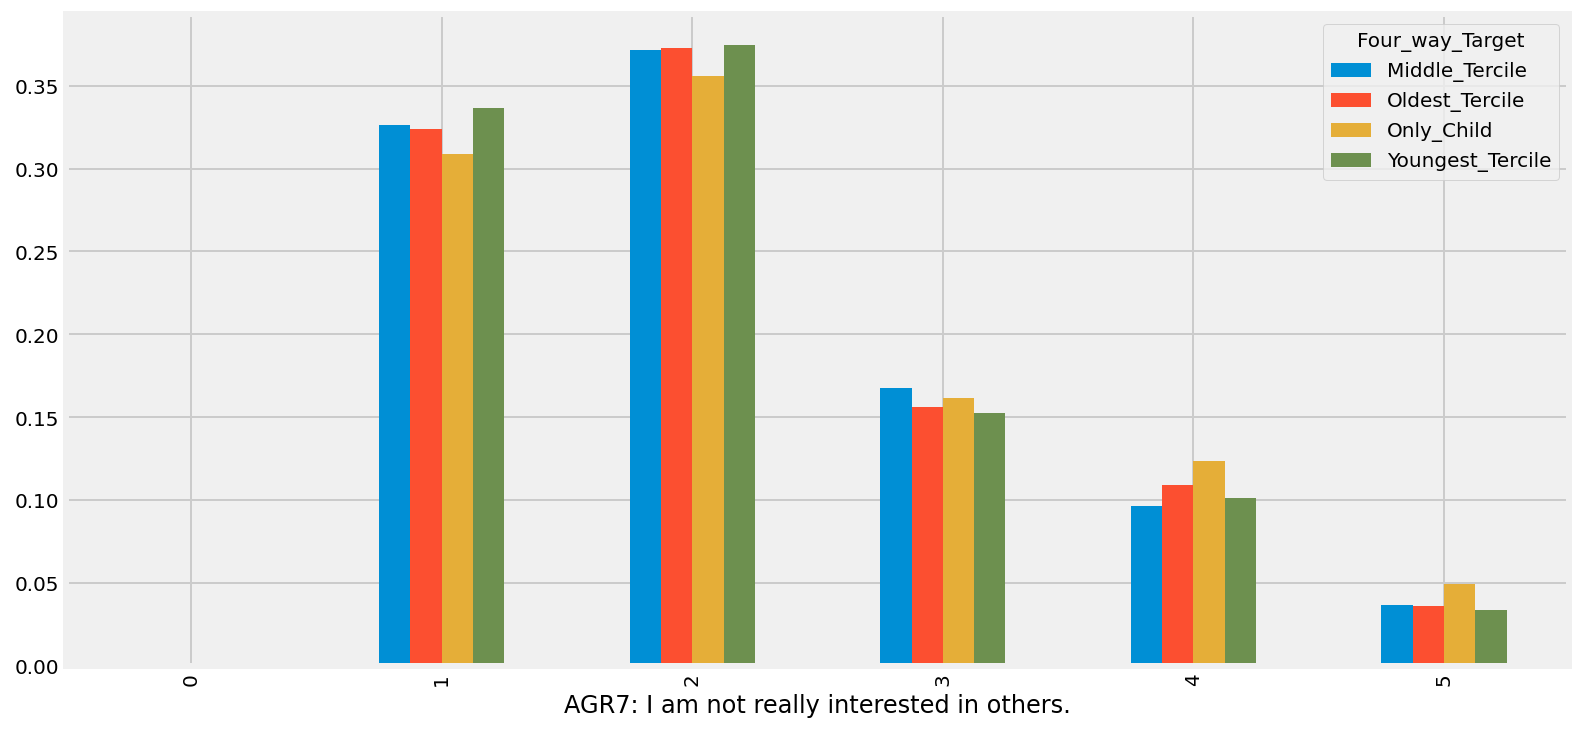

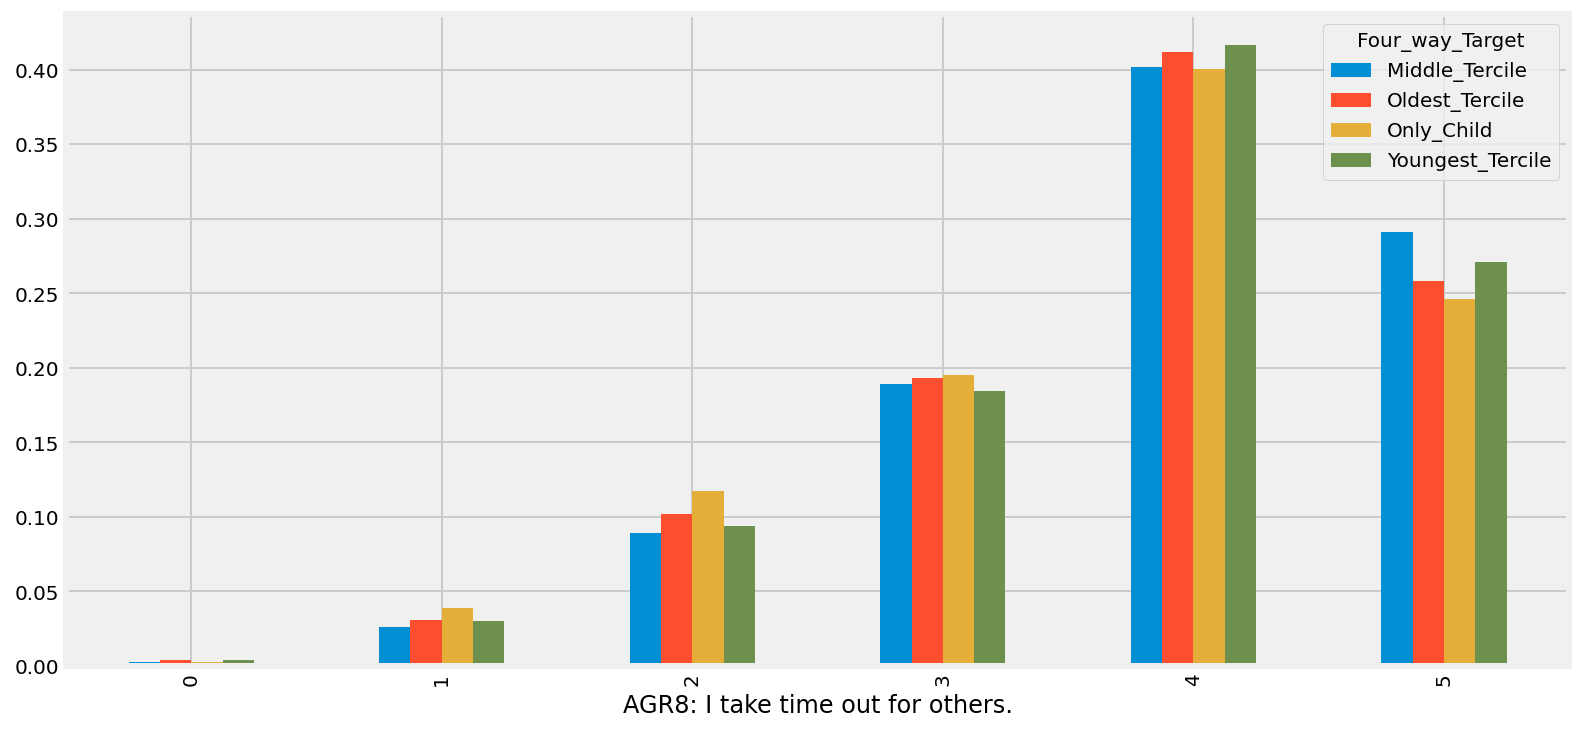

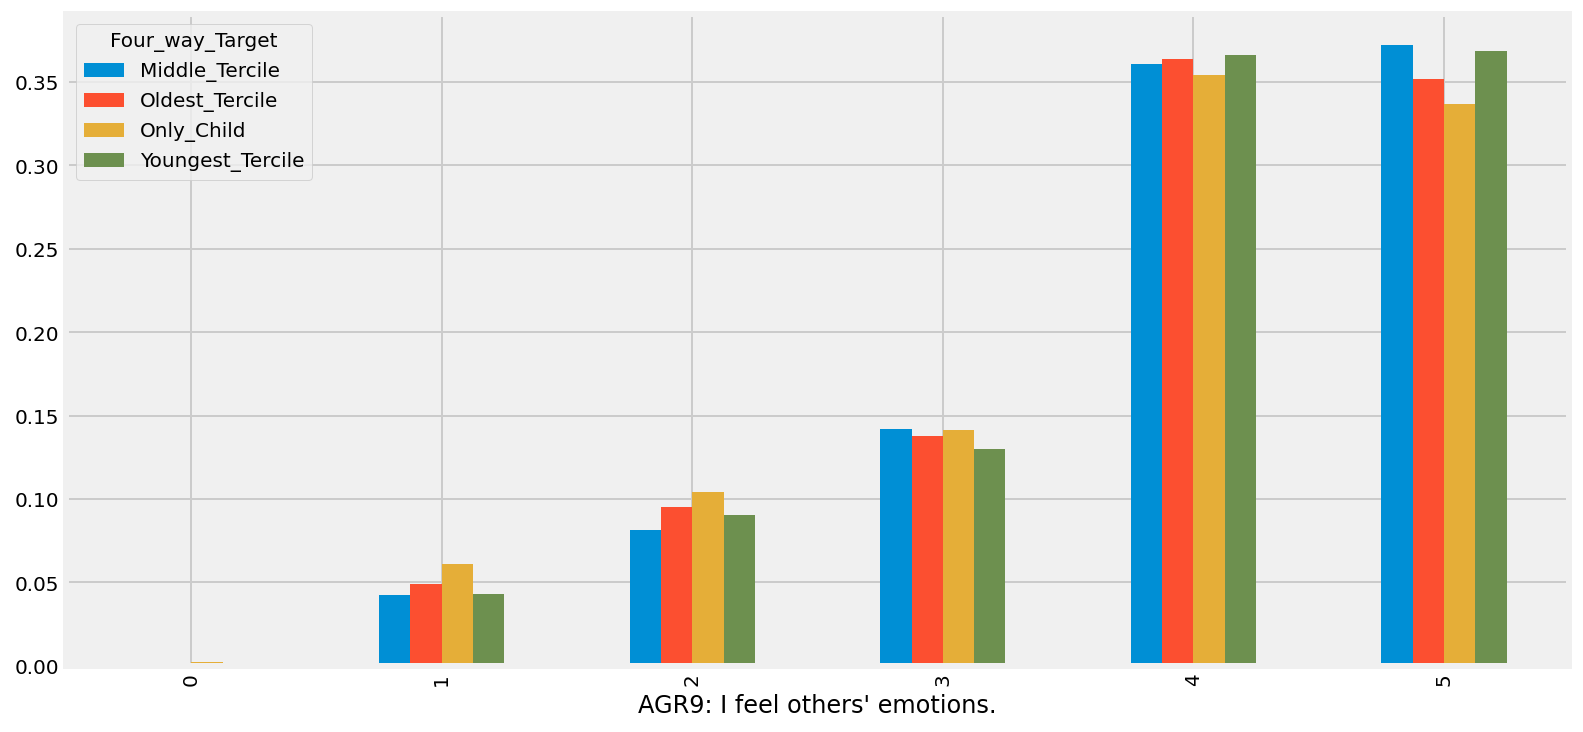

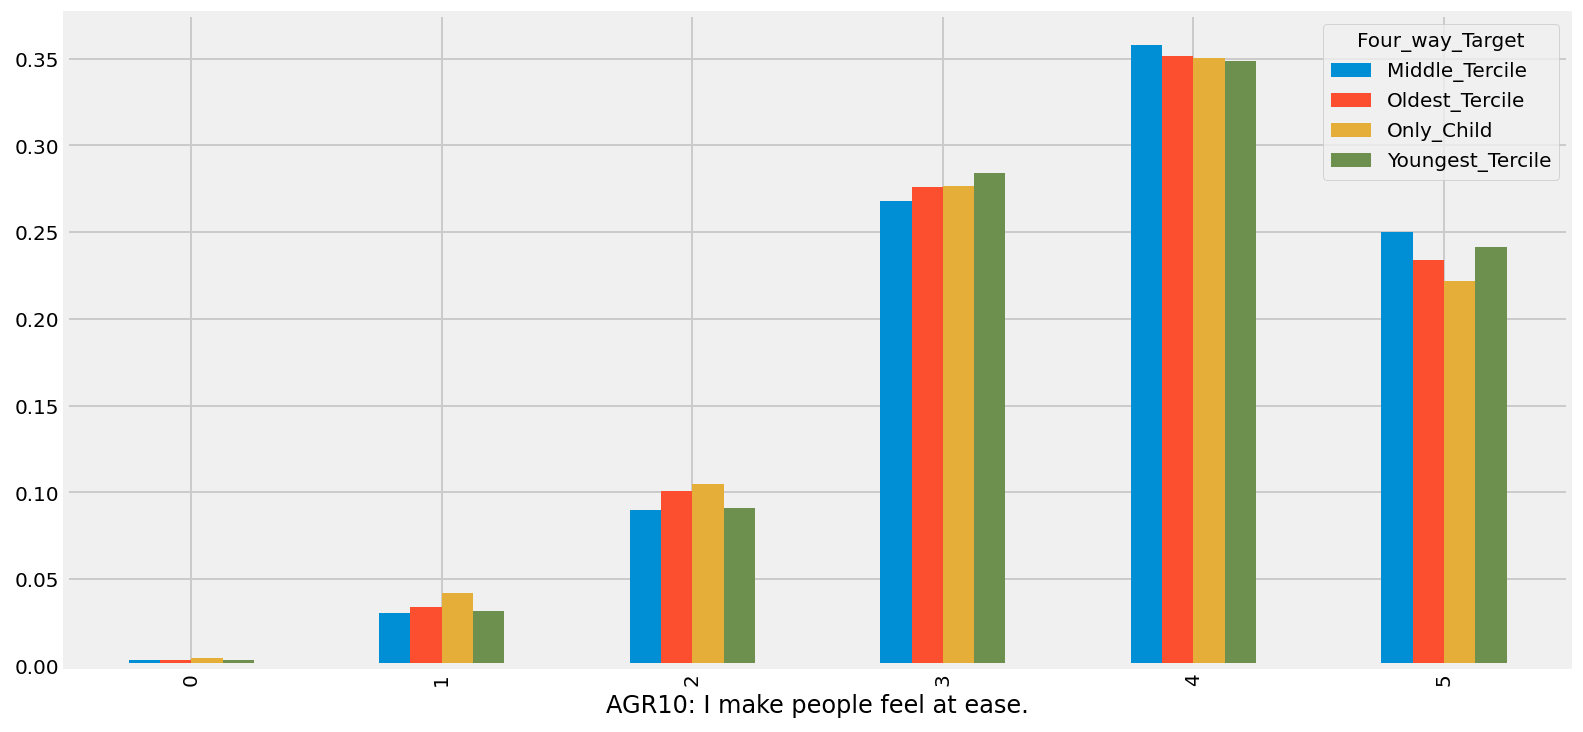

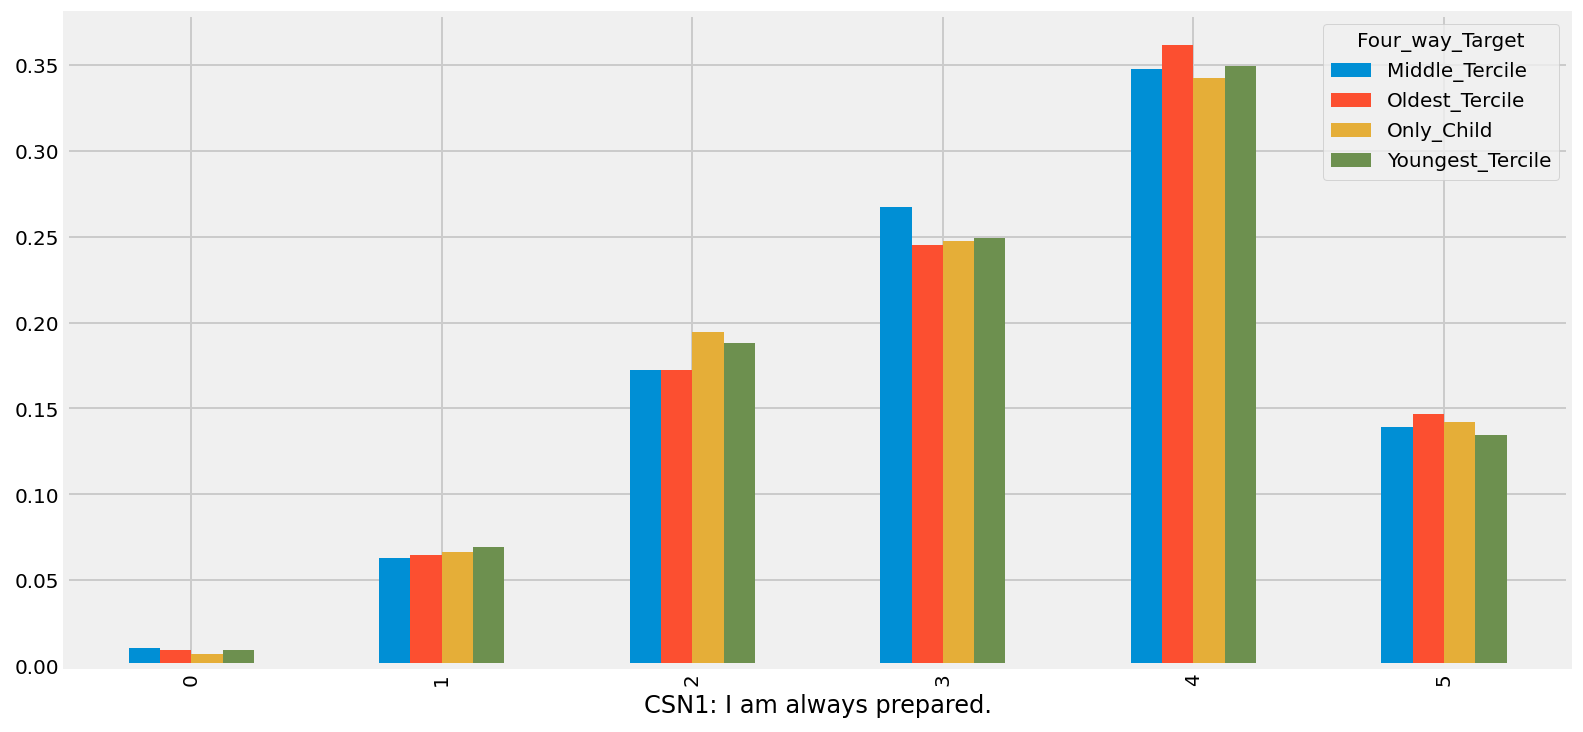

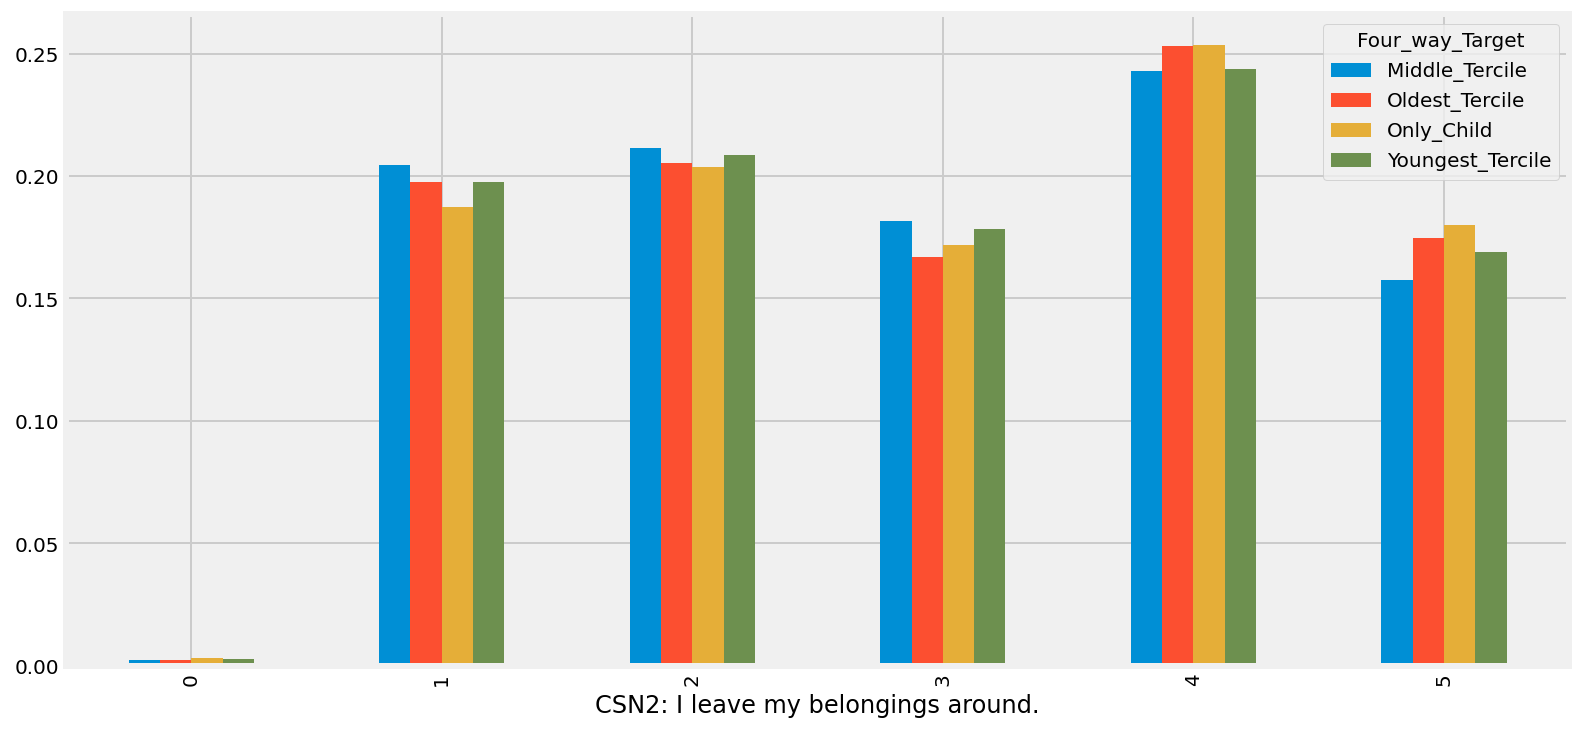

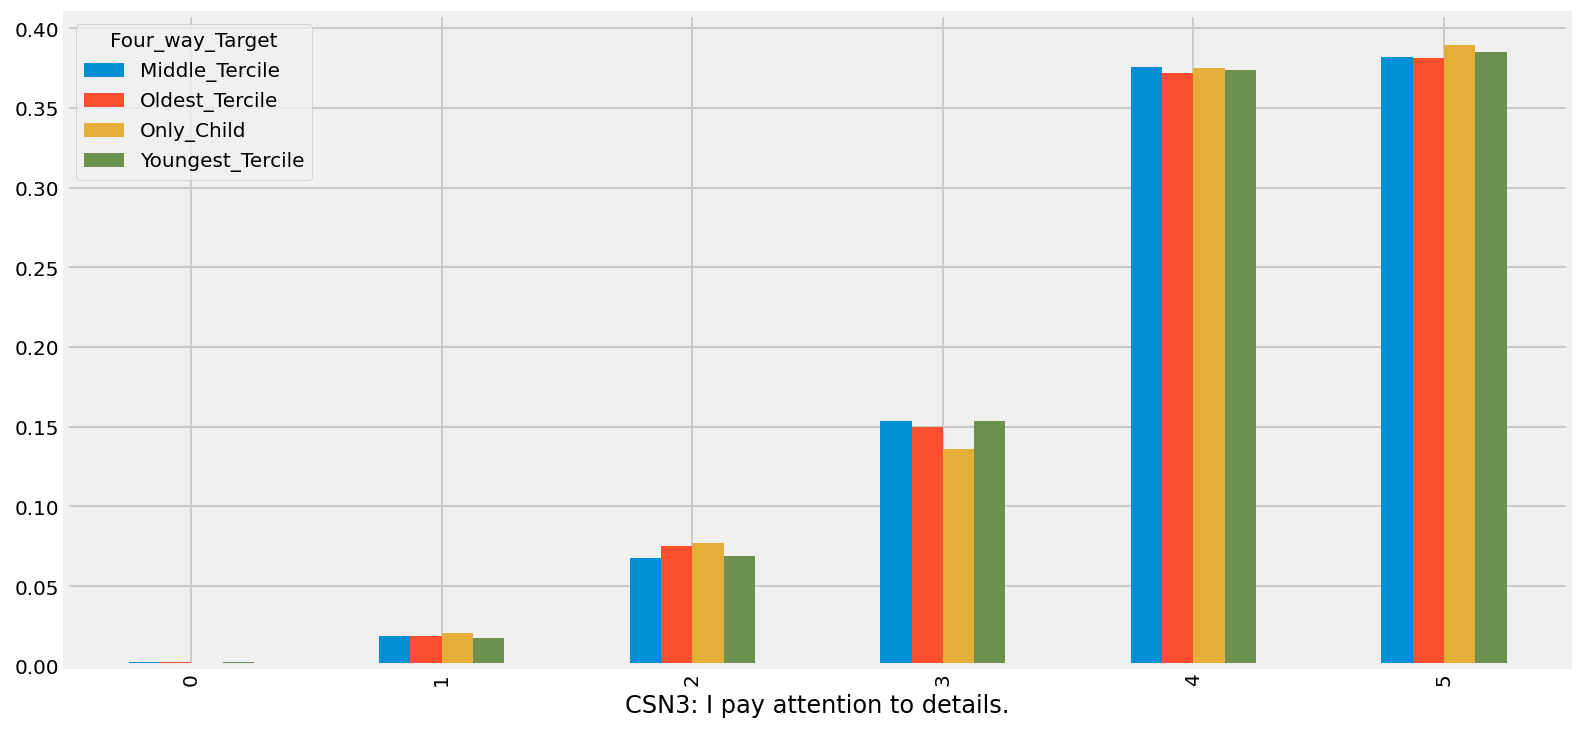

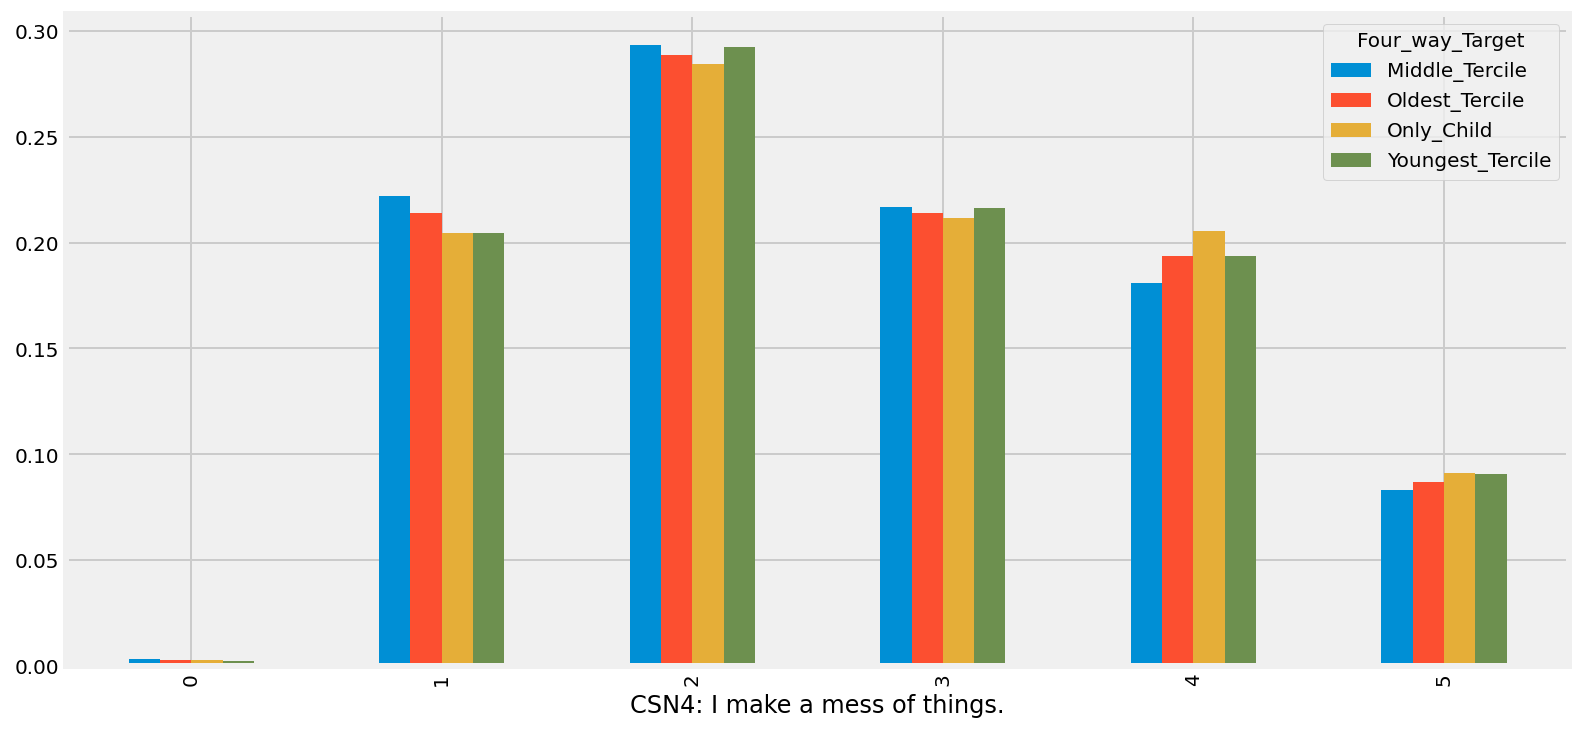

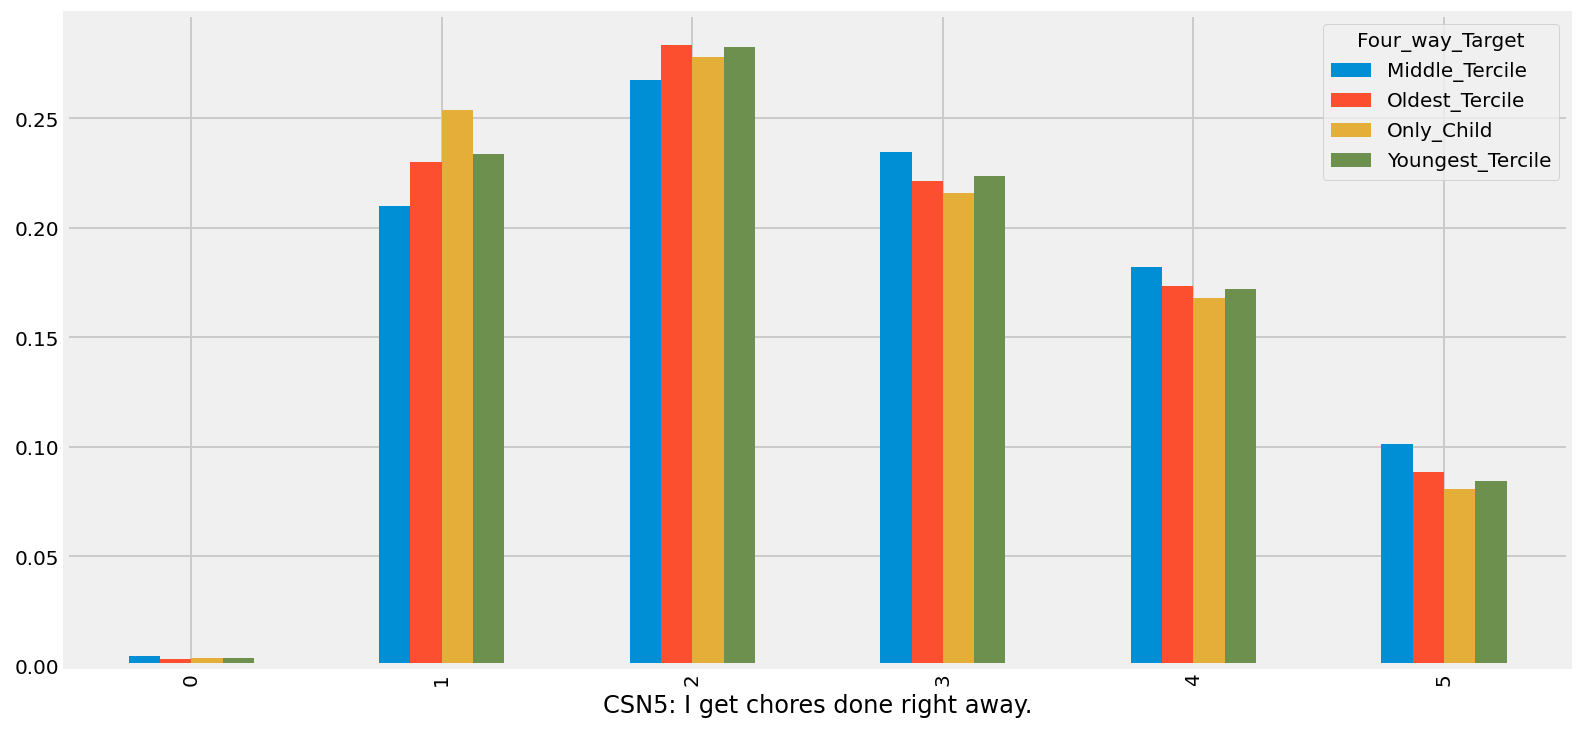

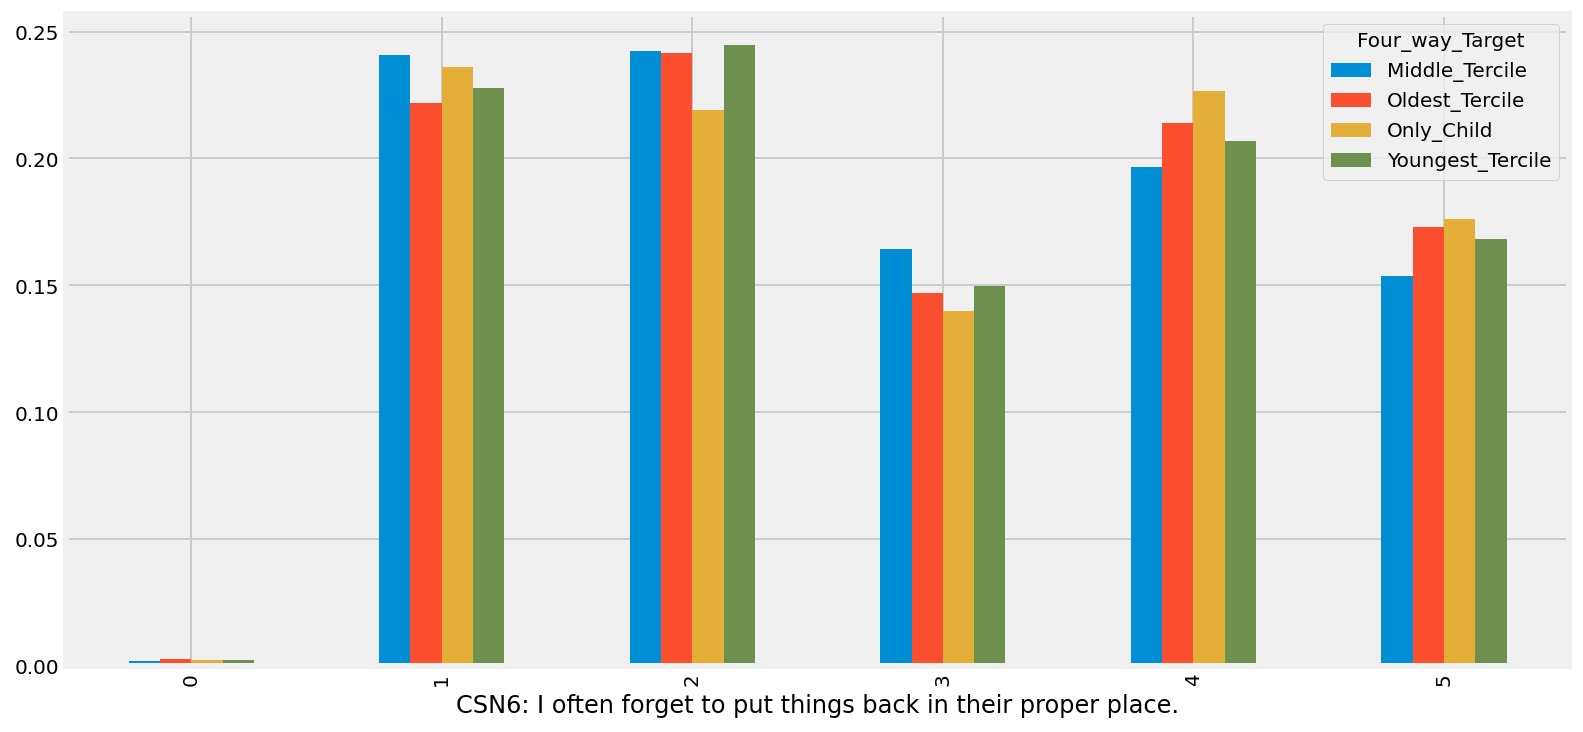

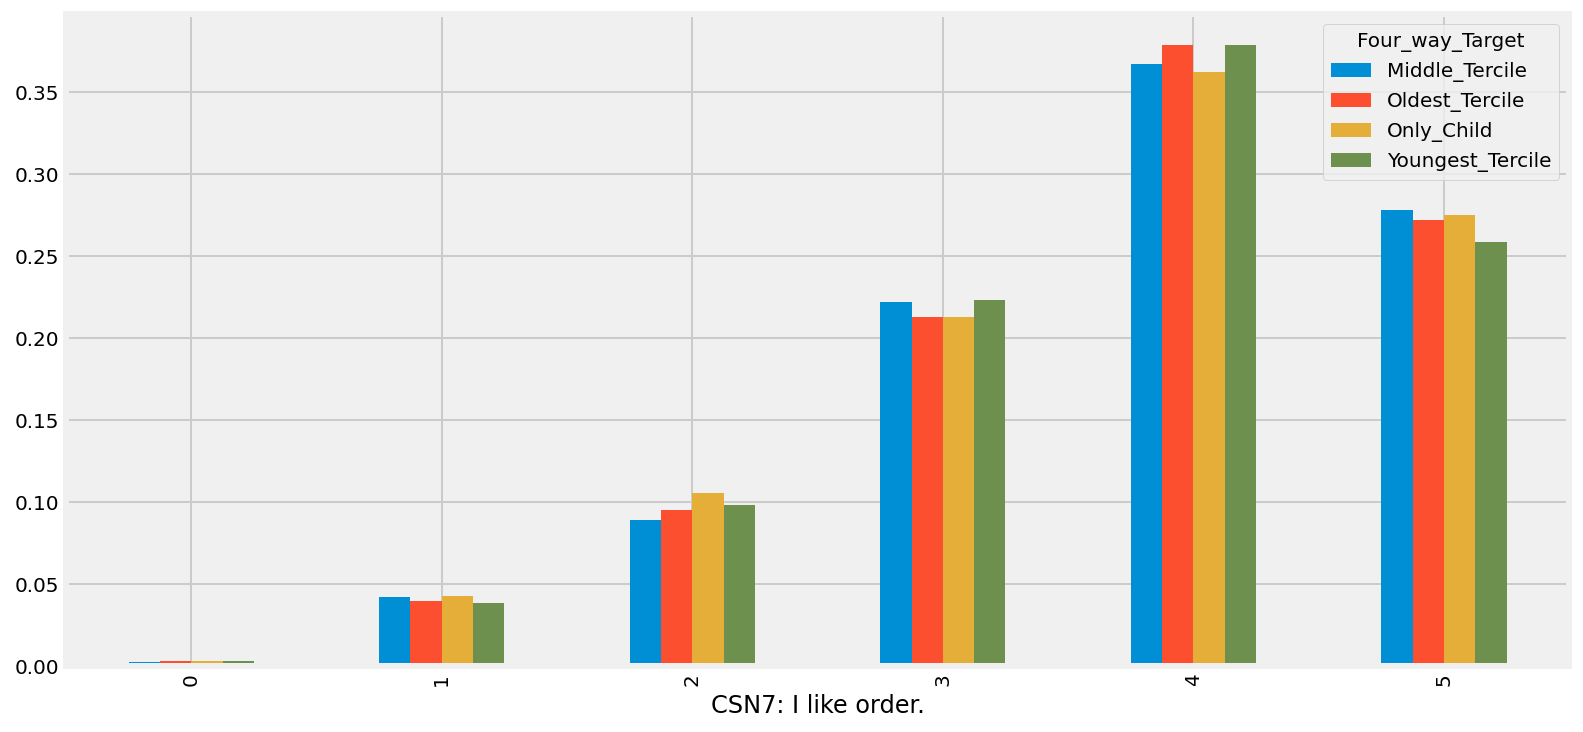

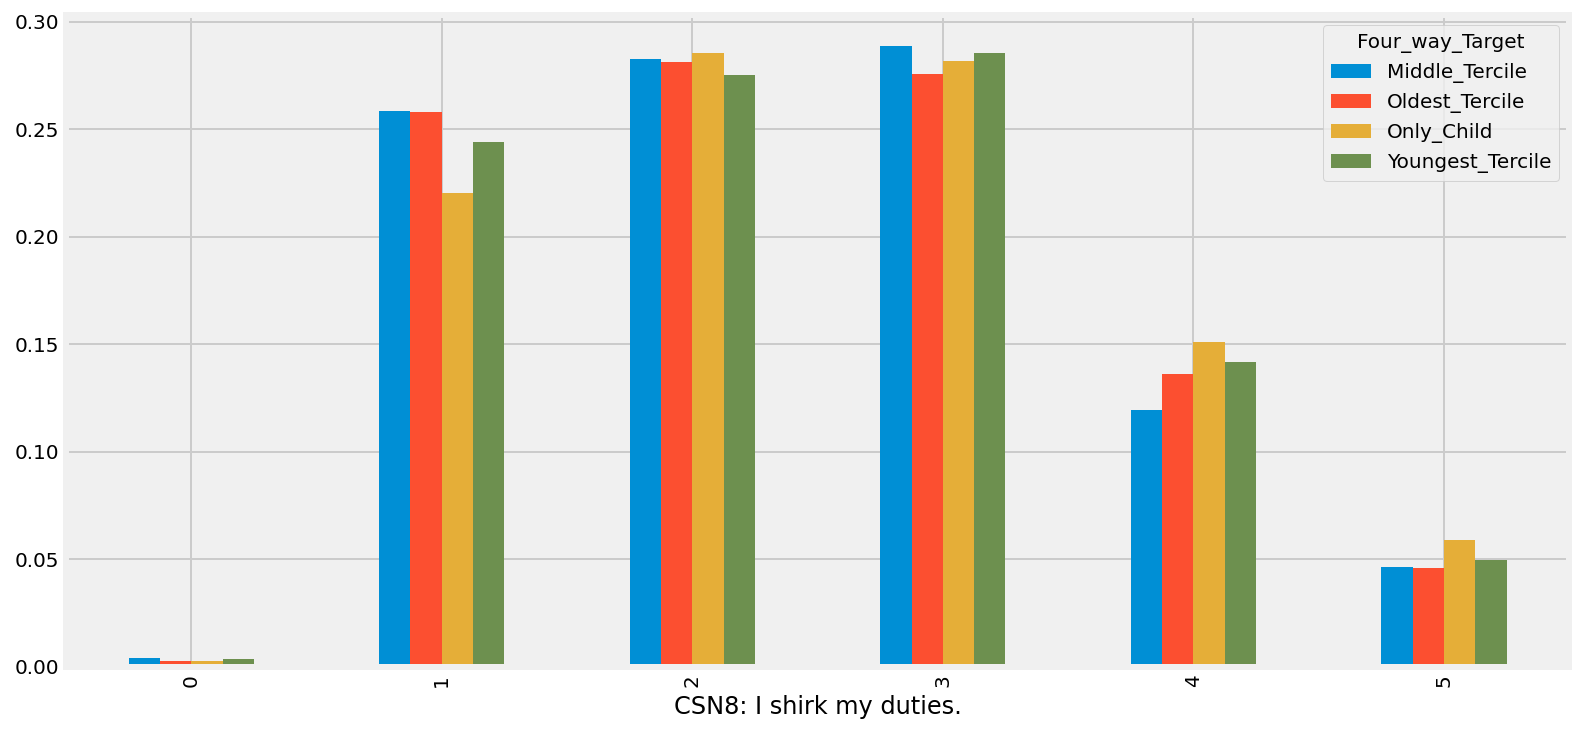

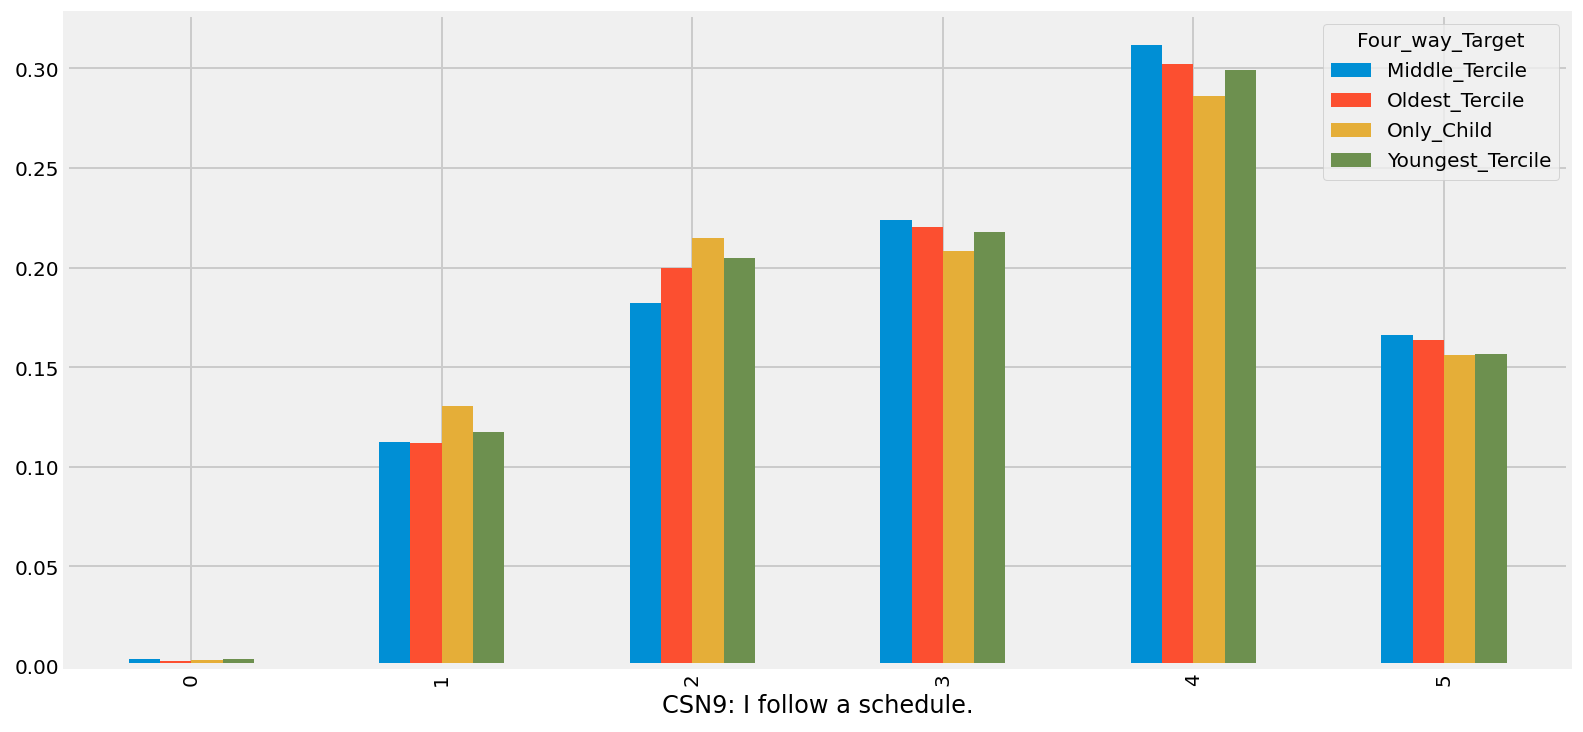

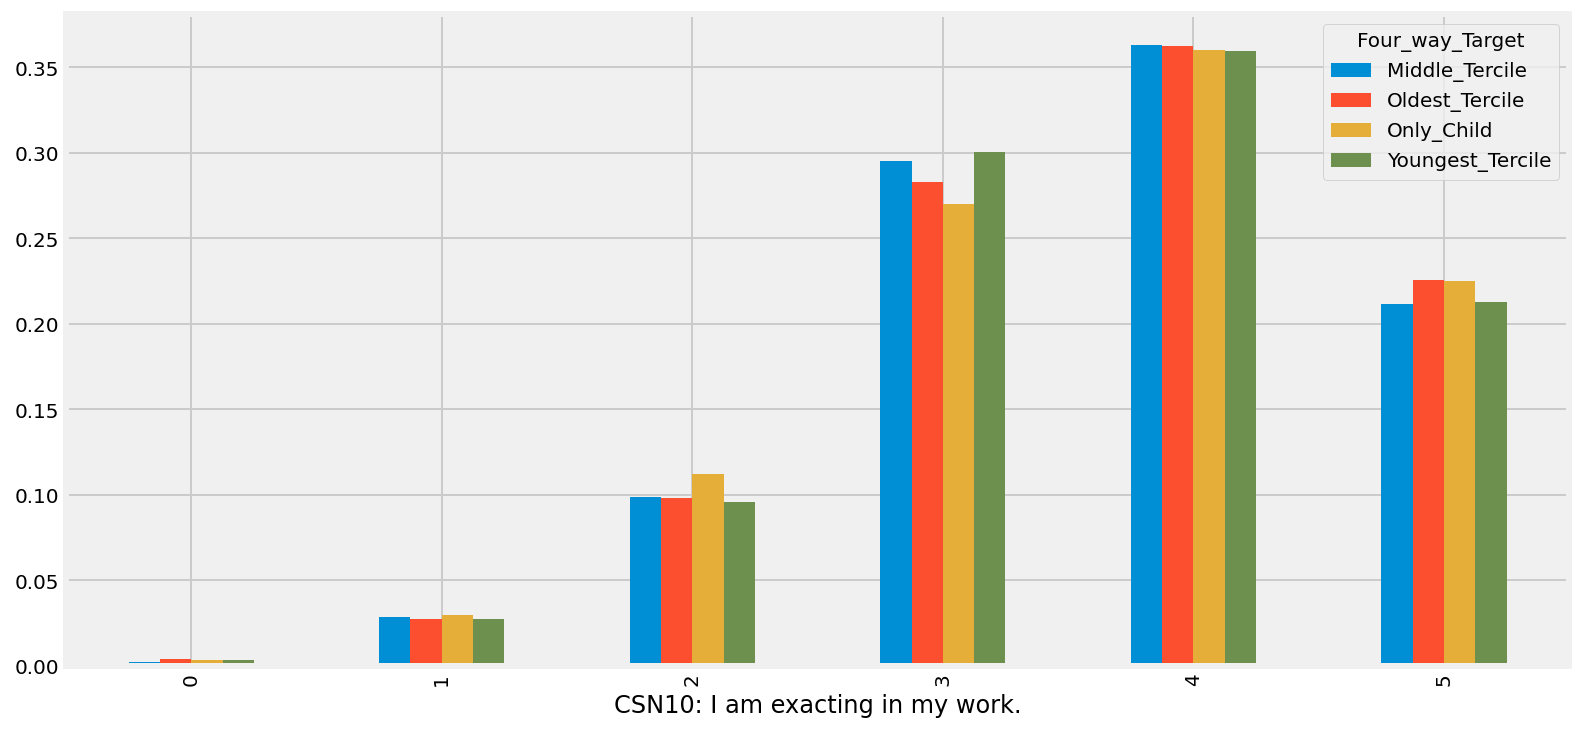

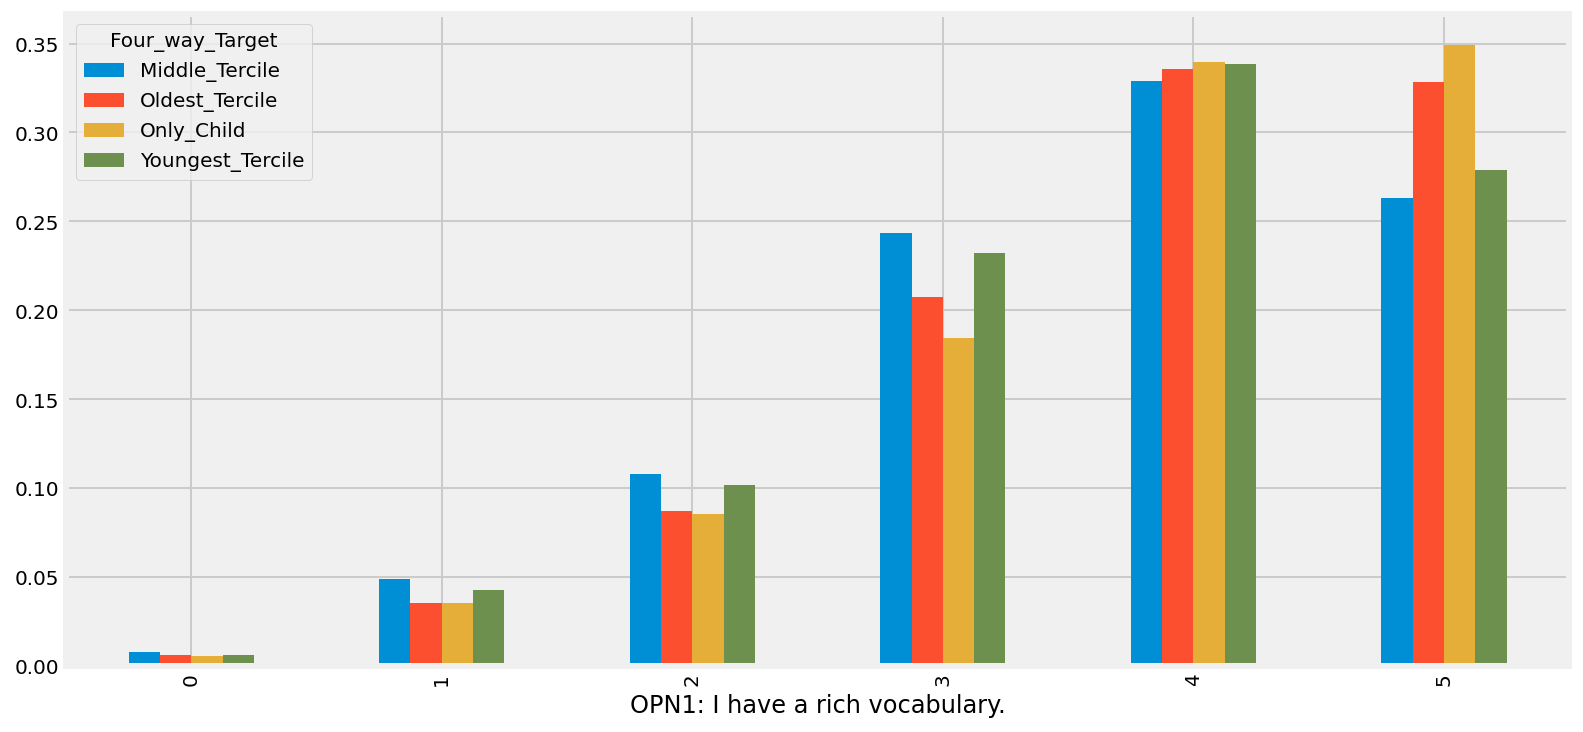

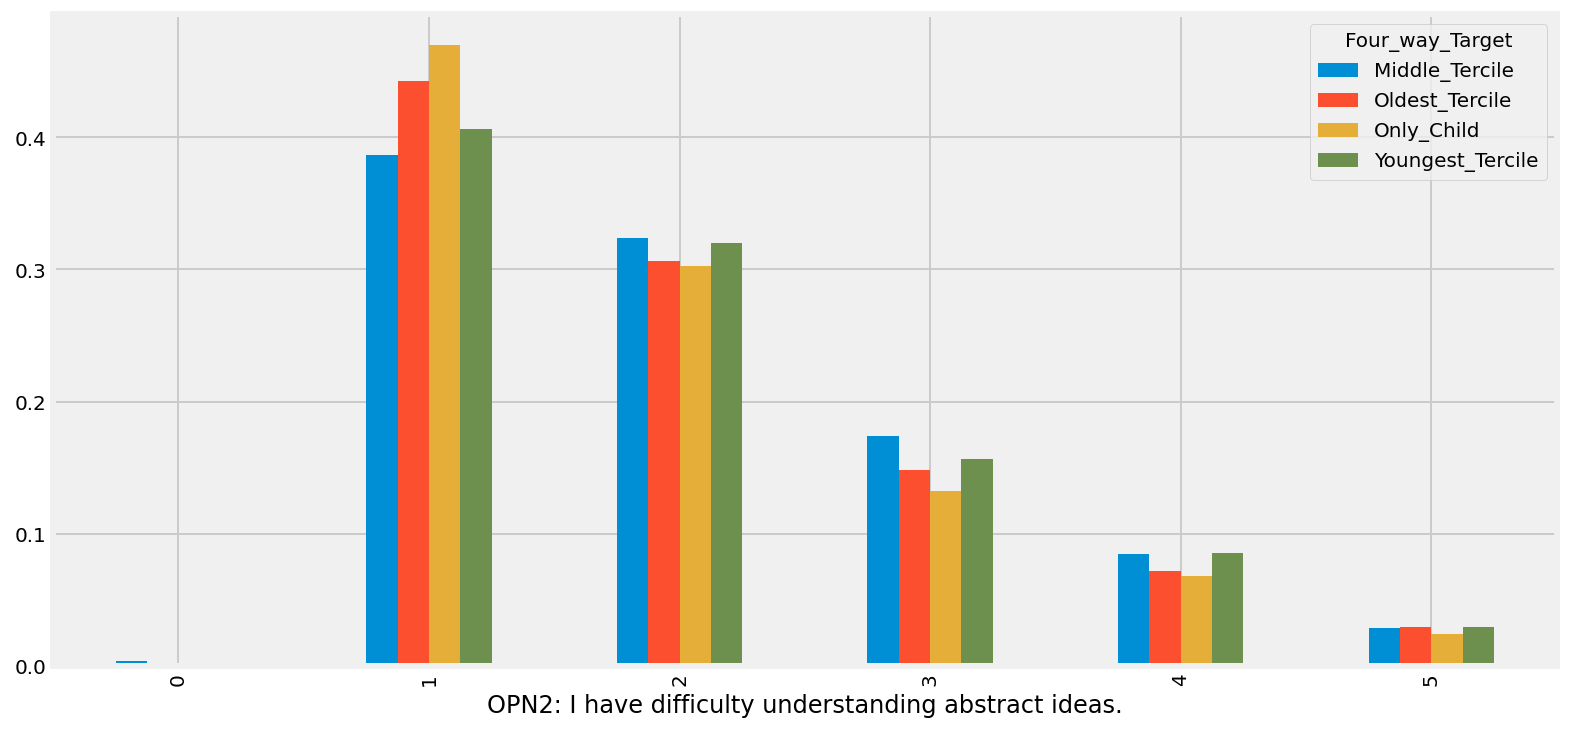

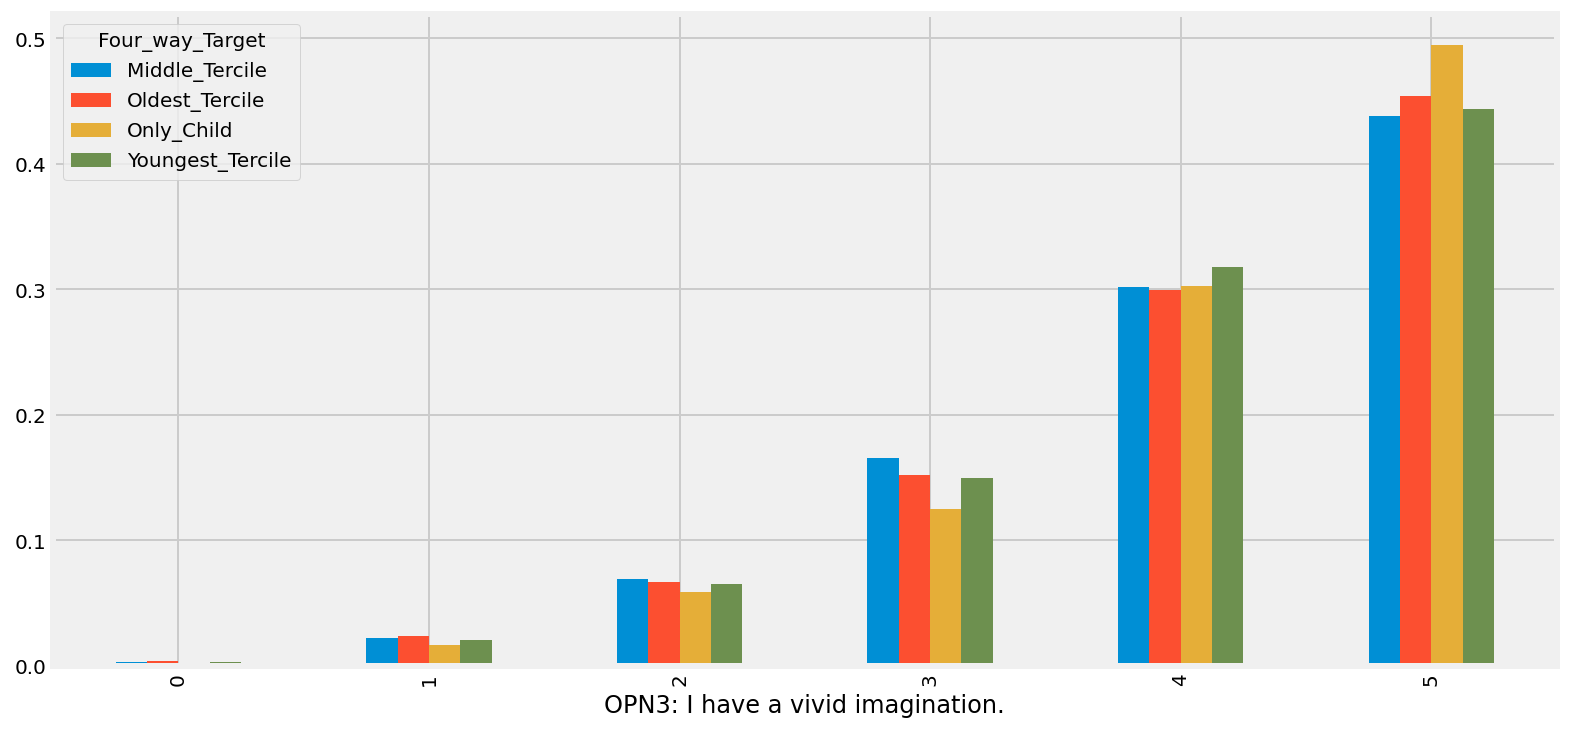

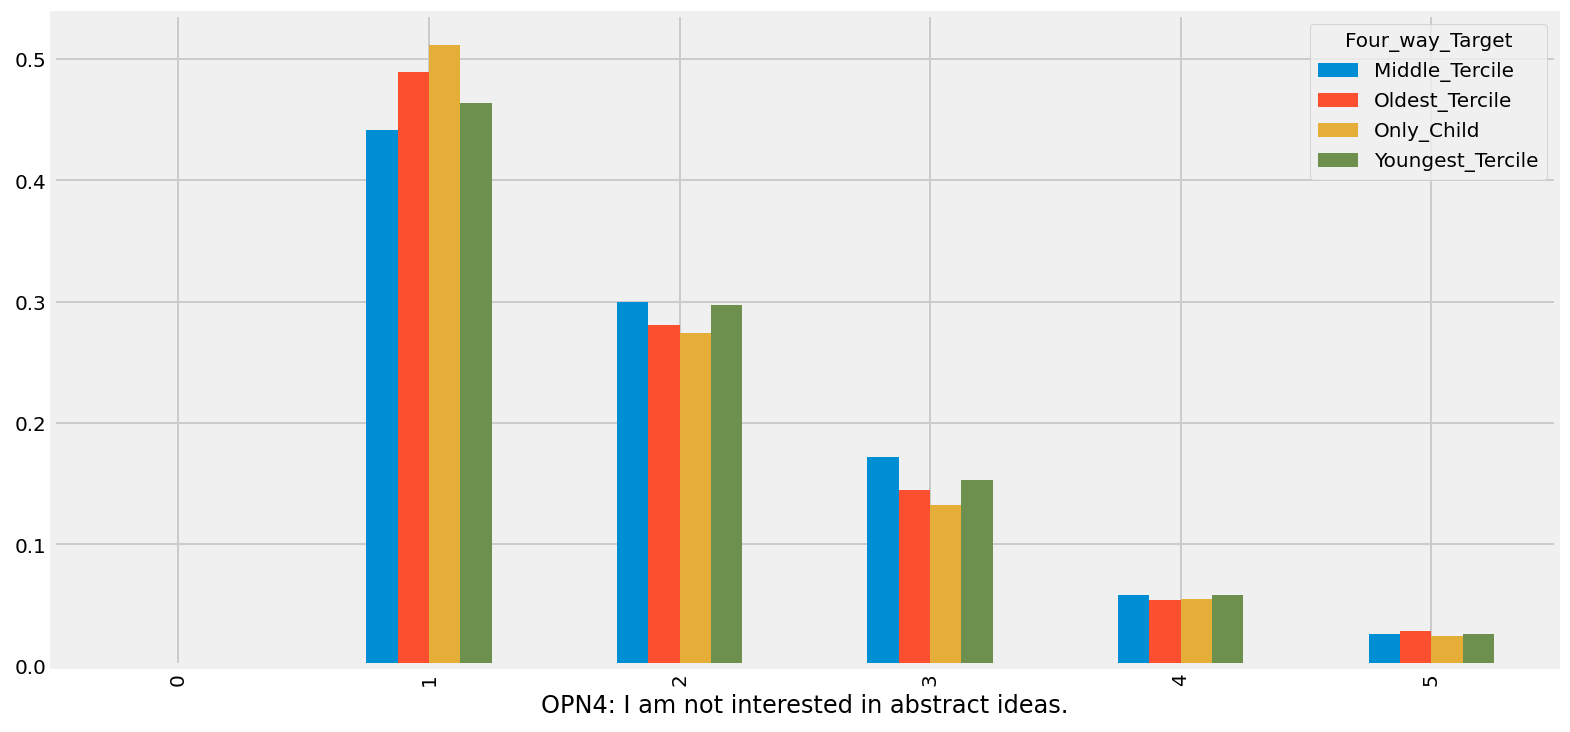

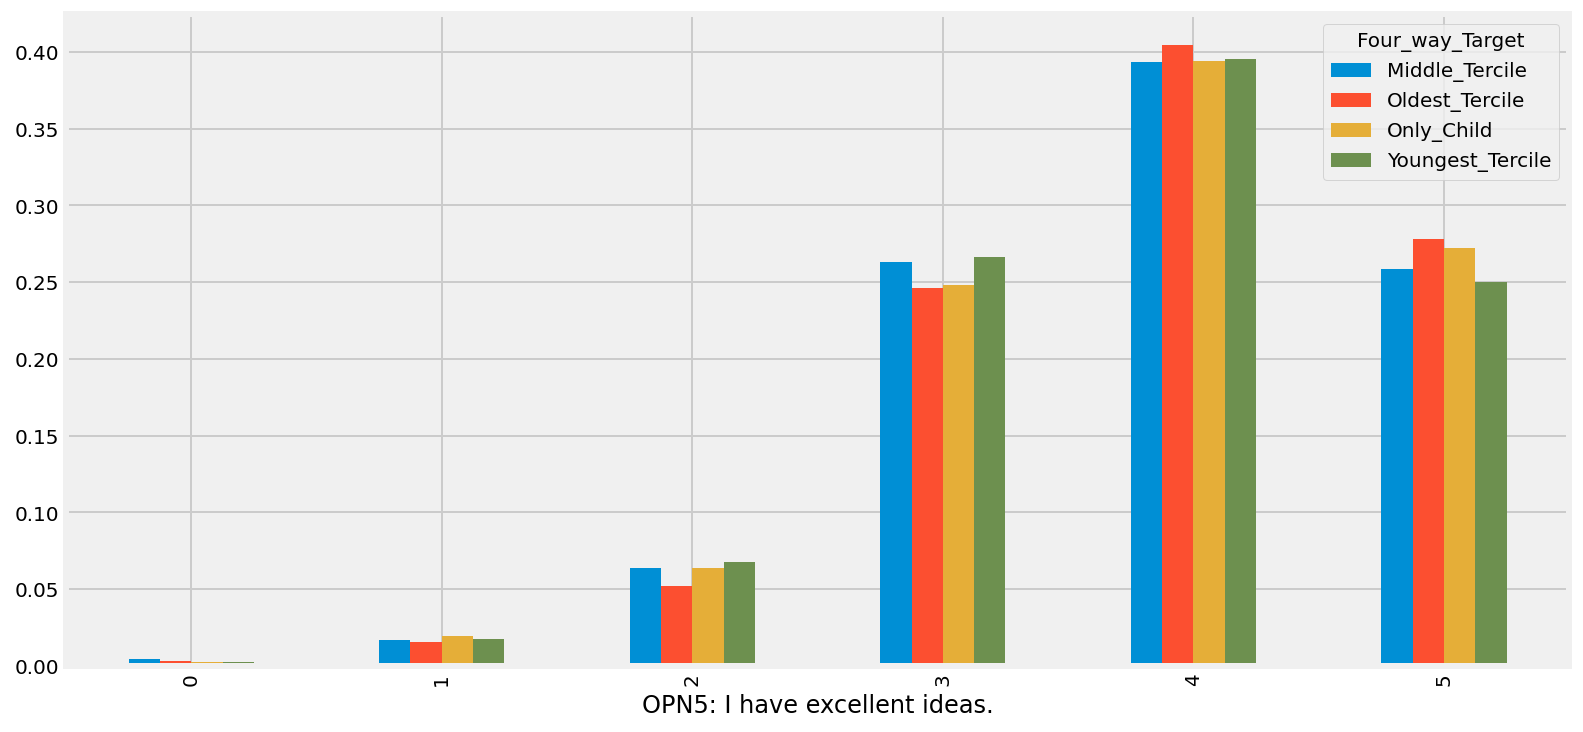

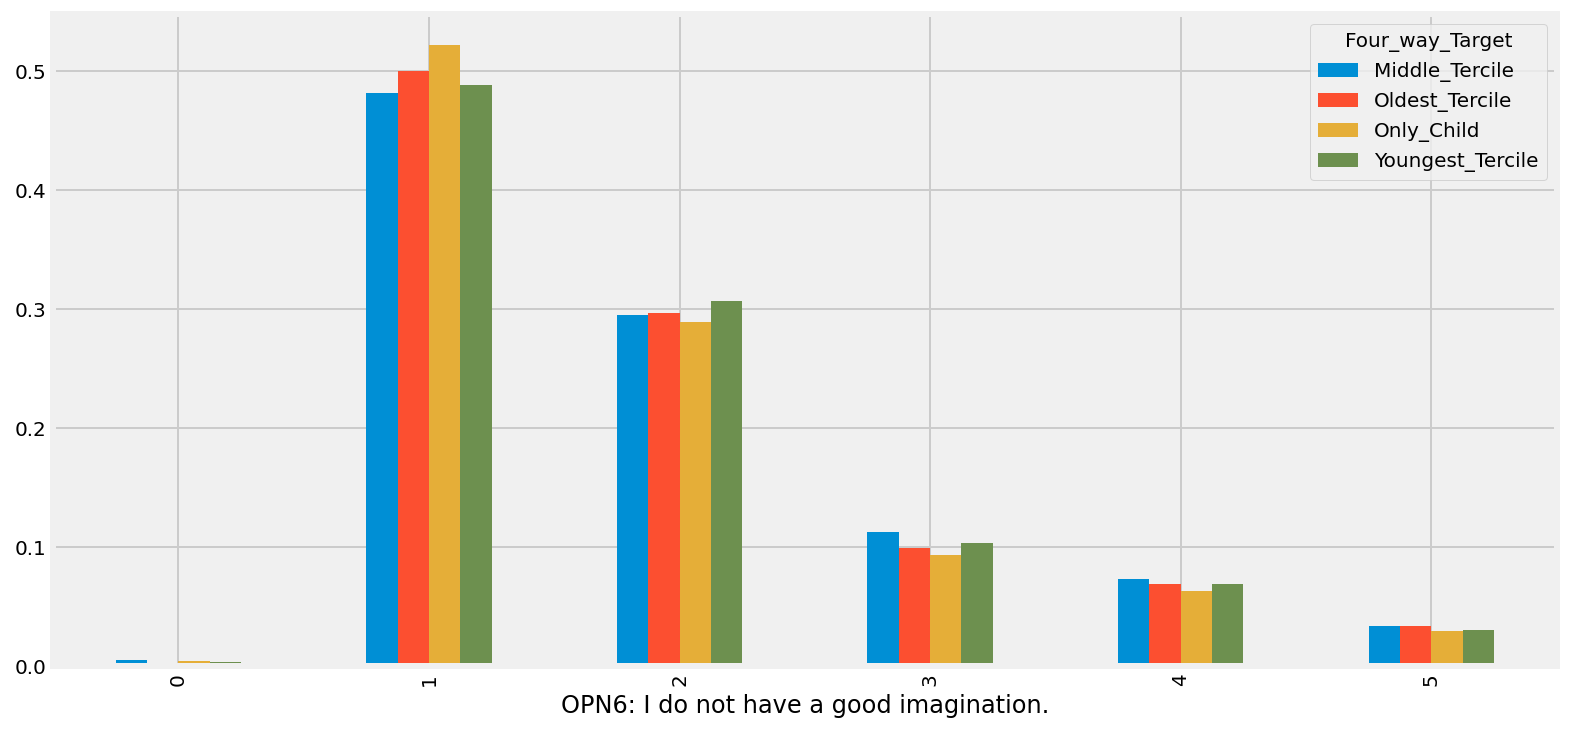

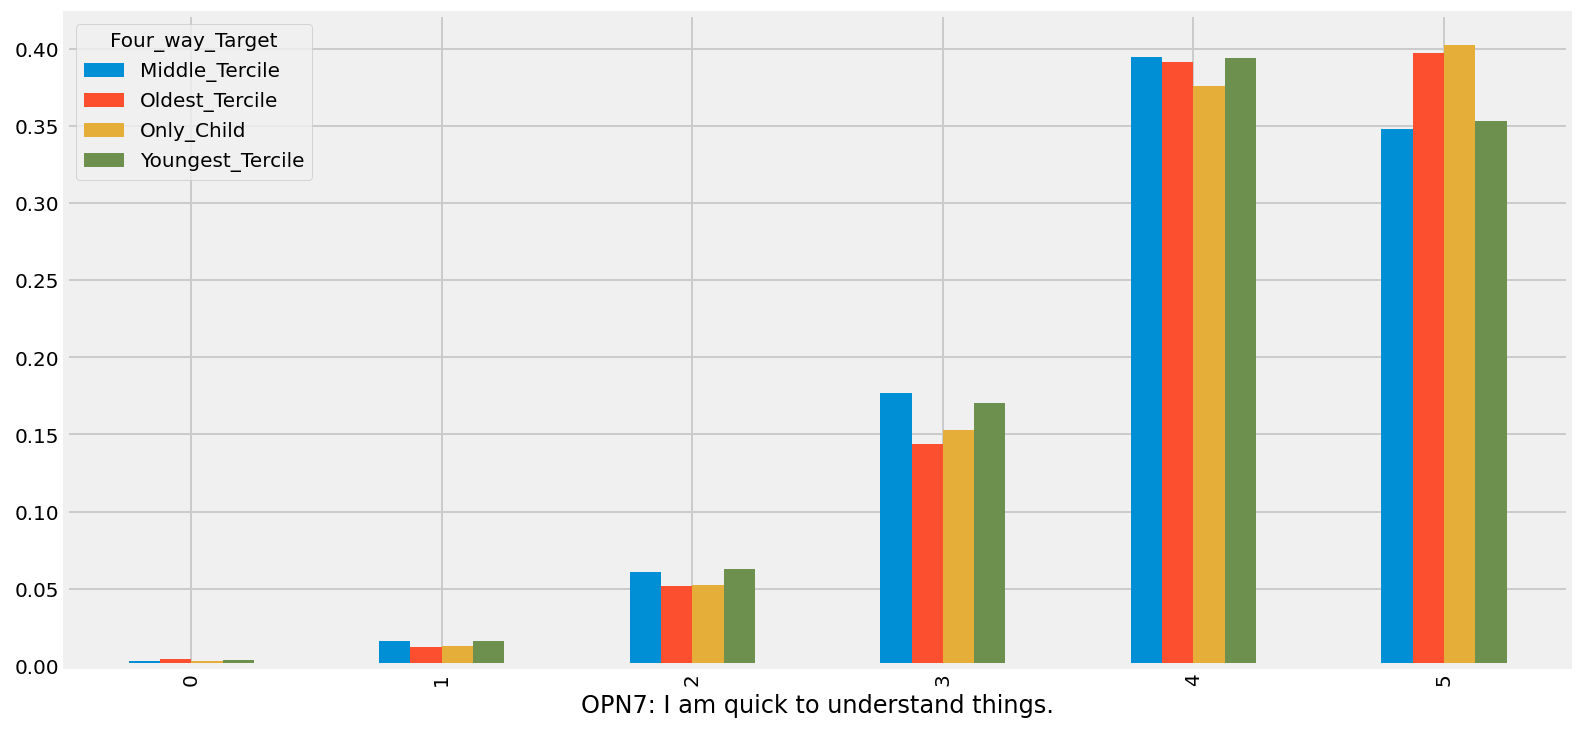

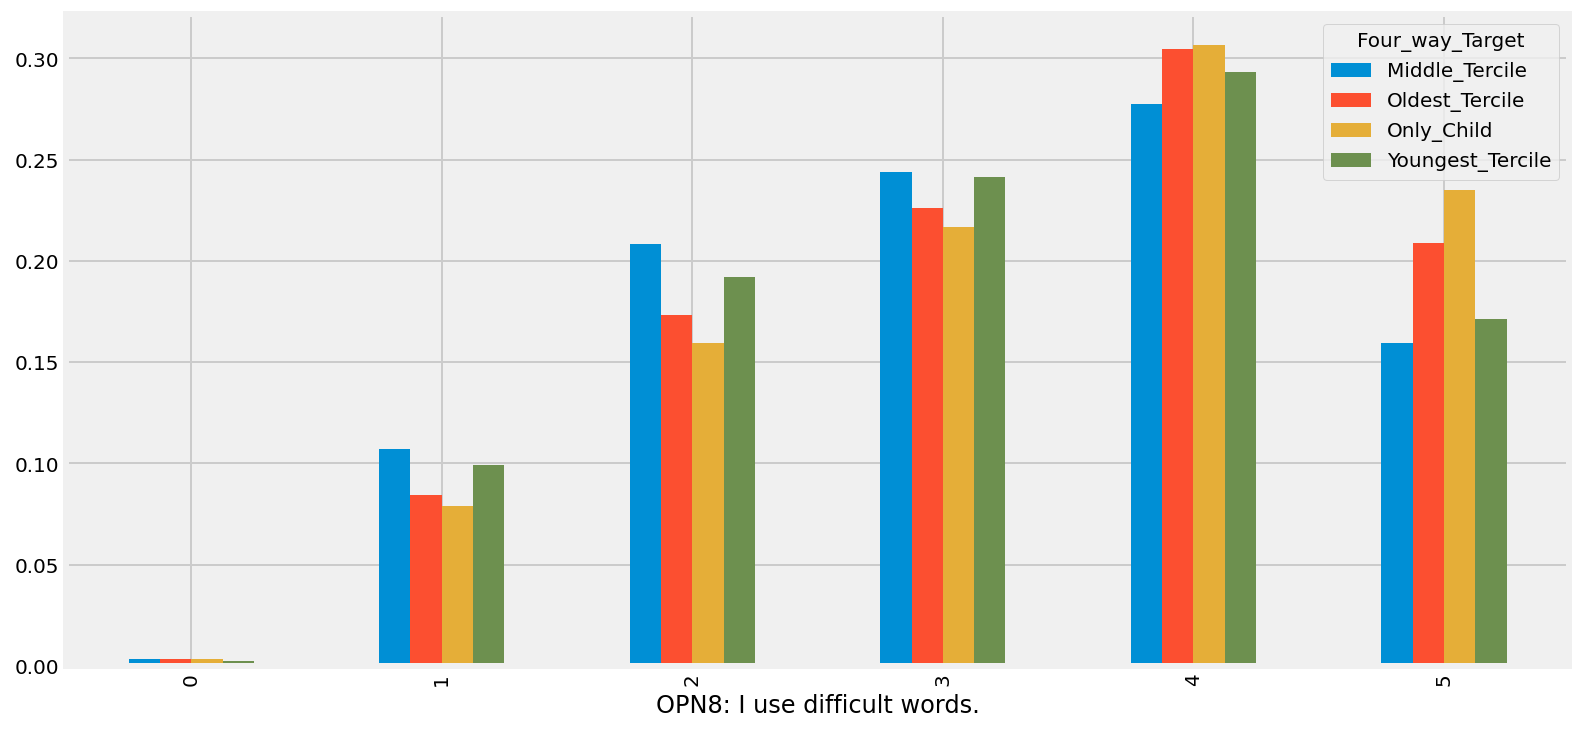

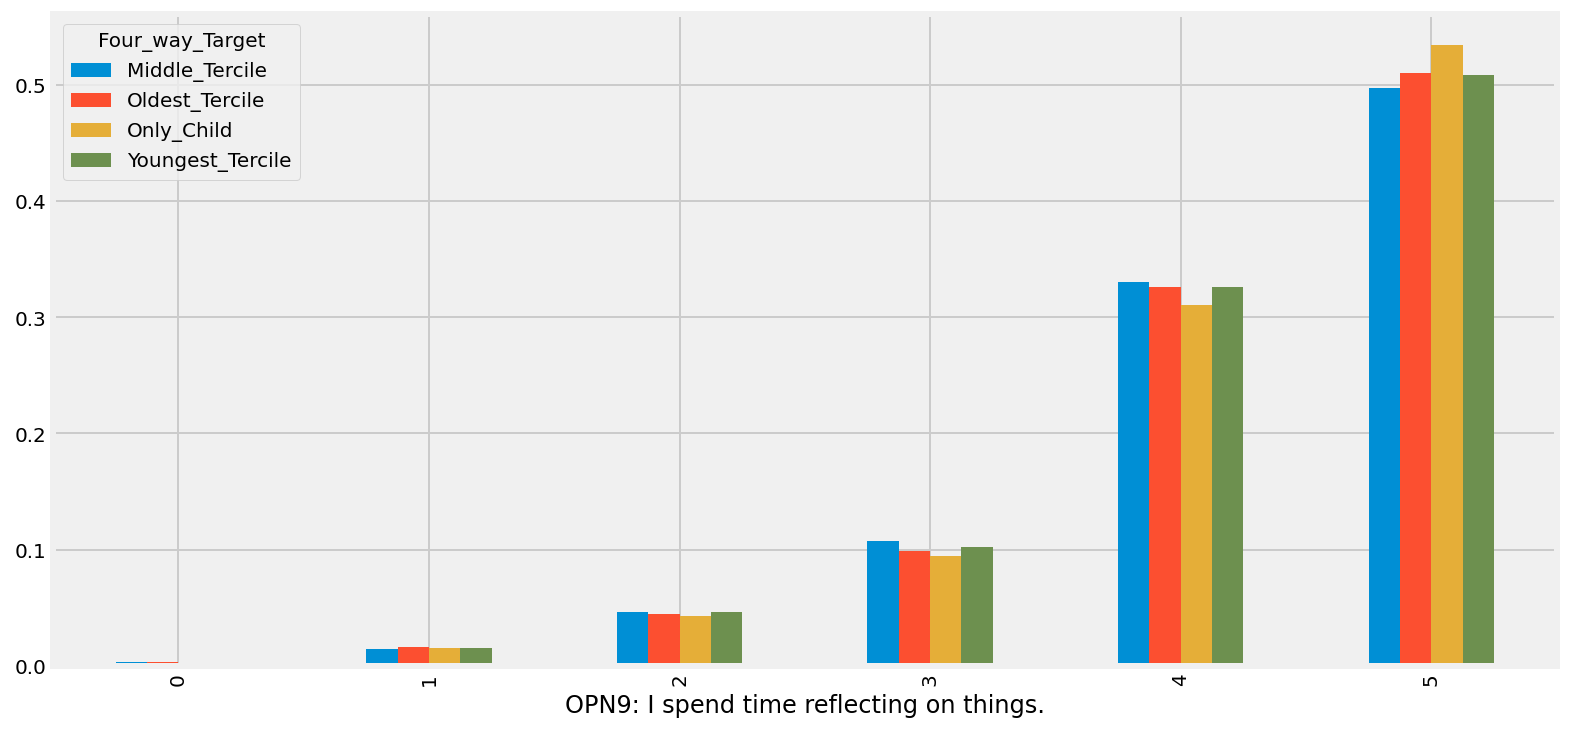

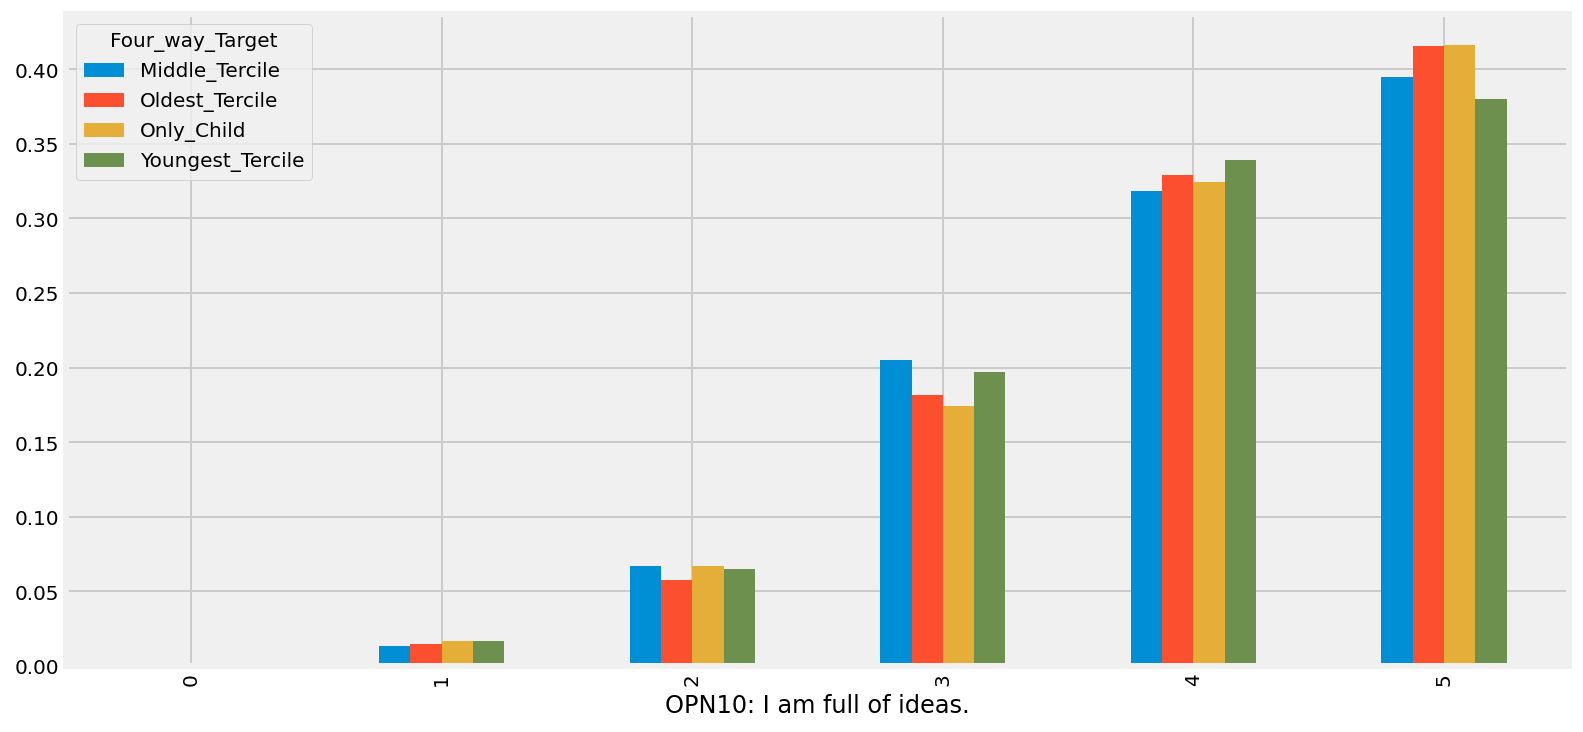

In [257]:
# Create a grouped hist for all 26 questions
#     Group by 'Four_way_Target'


# for q in twentysix_qs:
for q in seventysix_qs:
#     print(q_dict.get(q))
    ax = capst02[q].groupby(capst02['Four_way_Target']).value_counts(normalize = True).unstack().T.plot(kind = 'bar', figsize=(12,6))
    ax.set_xlabel(q+": "+q_dict.get(q))

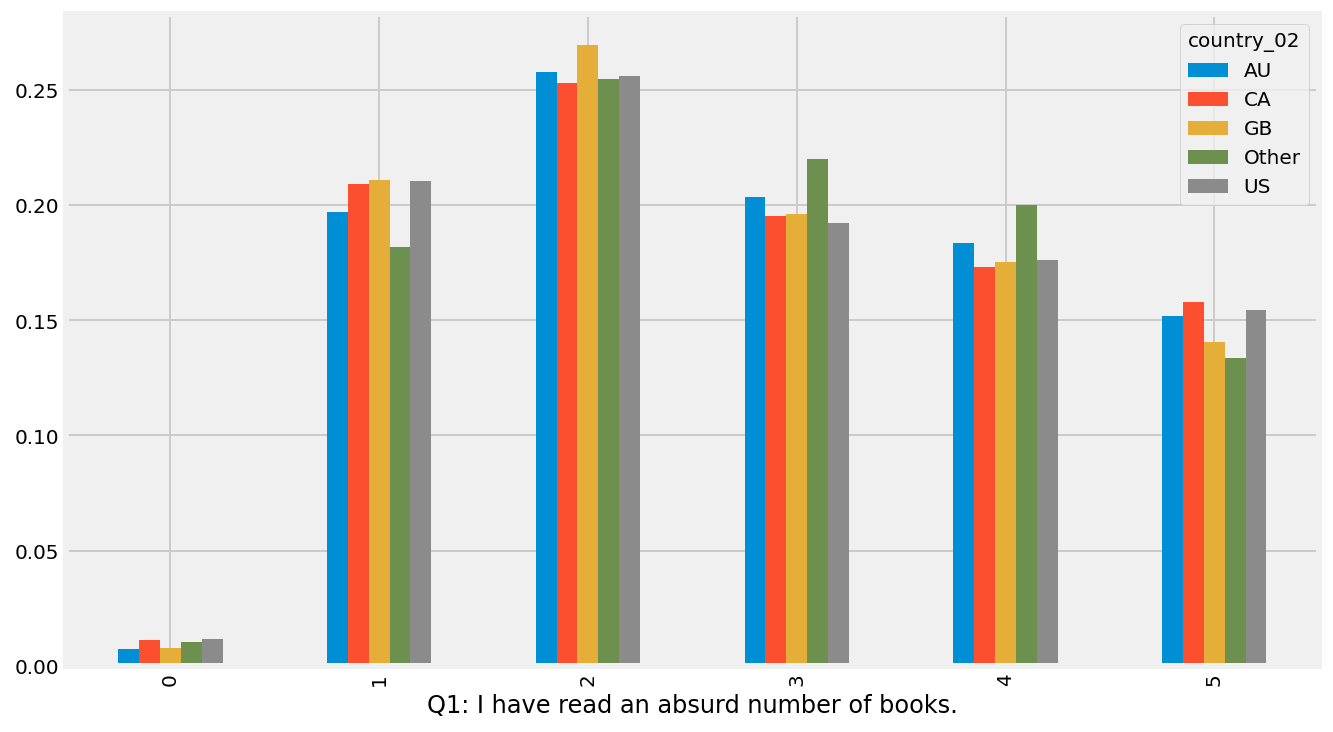

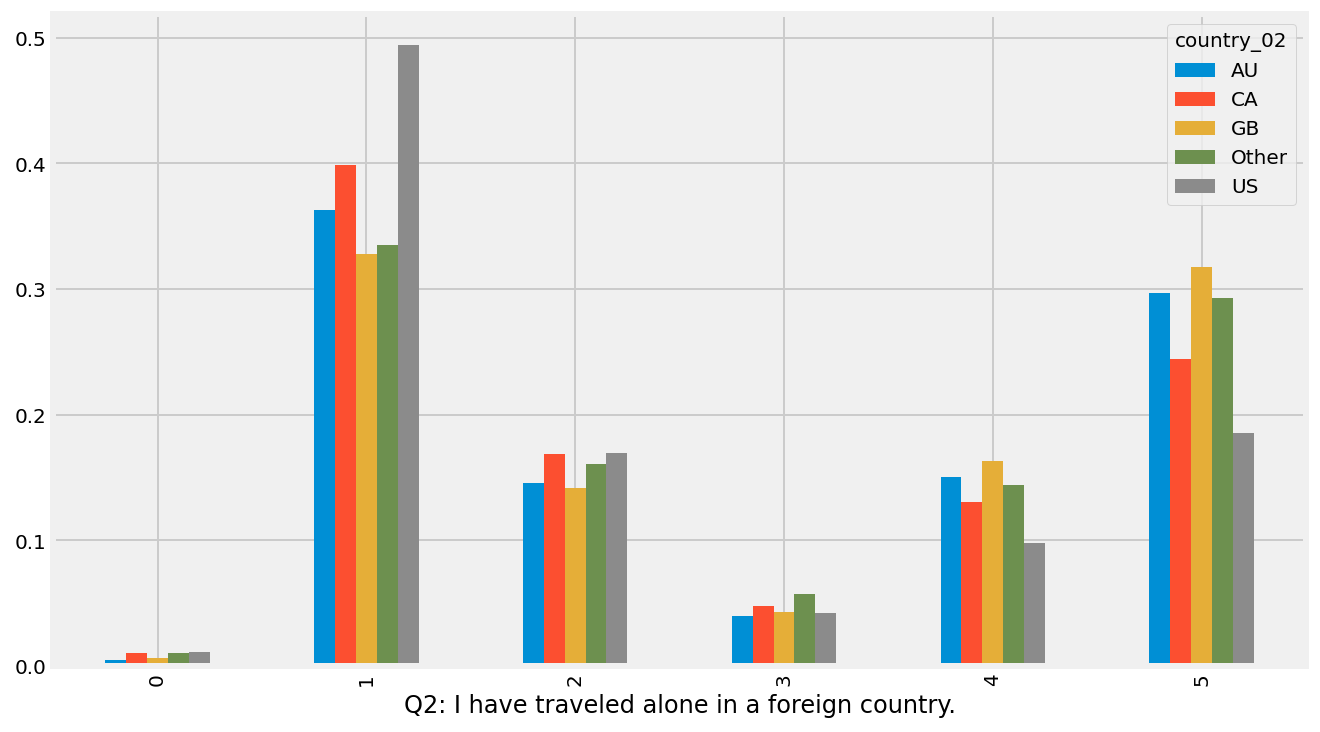

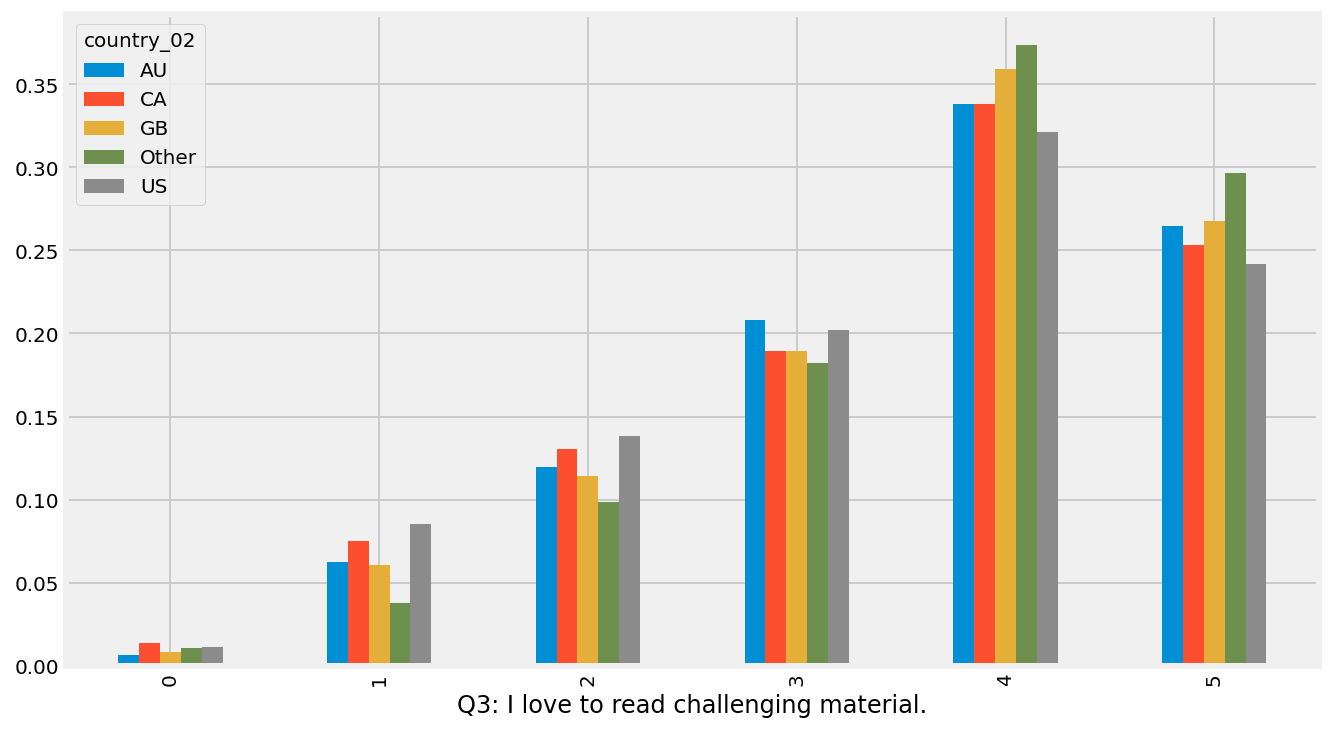

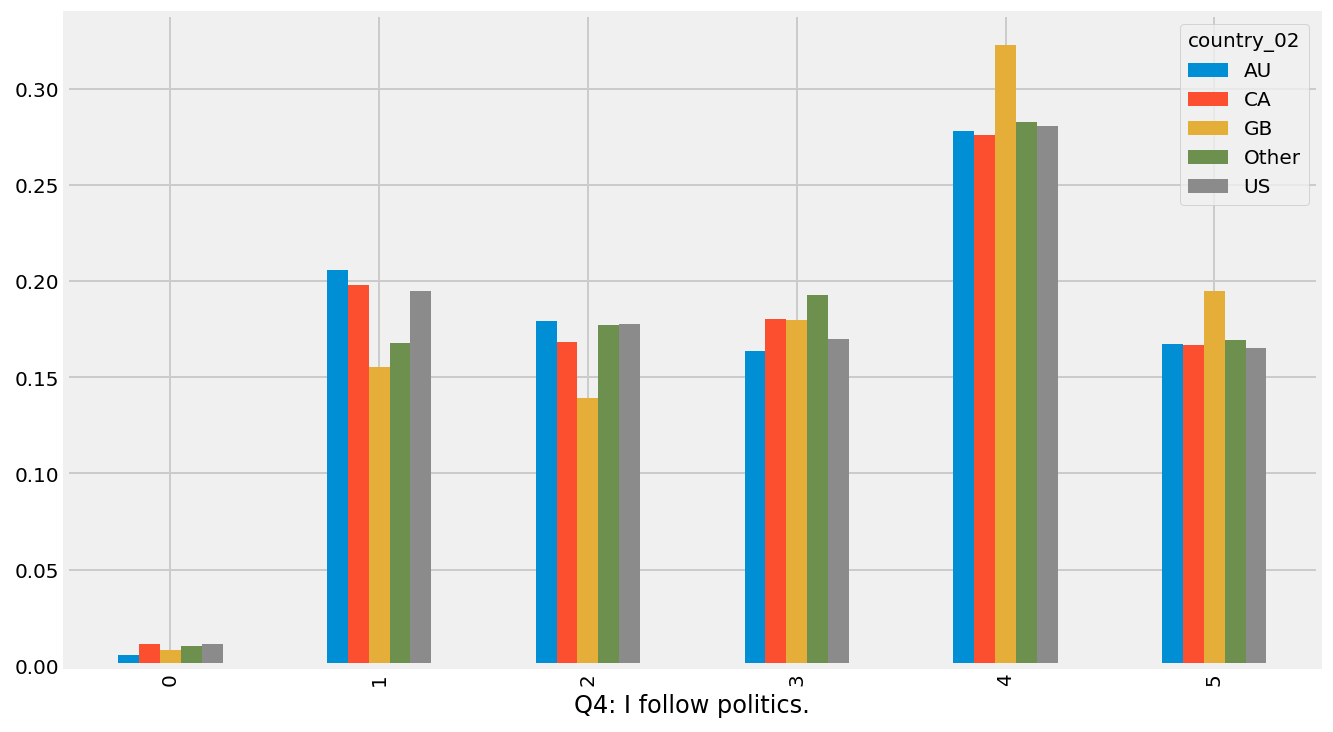

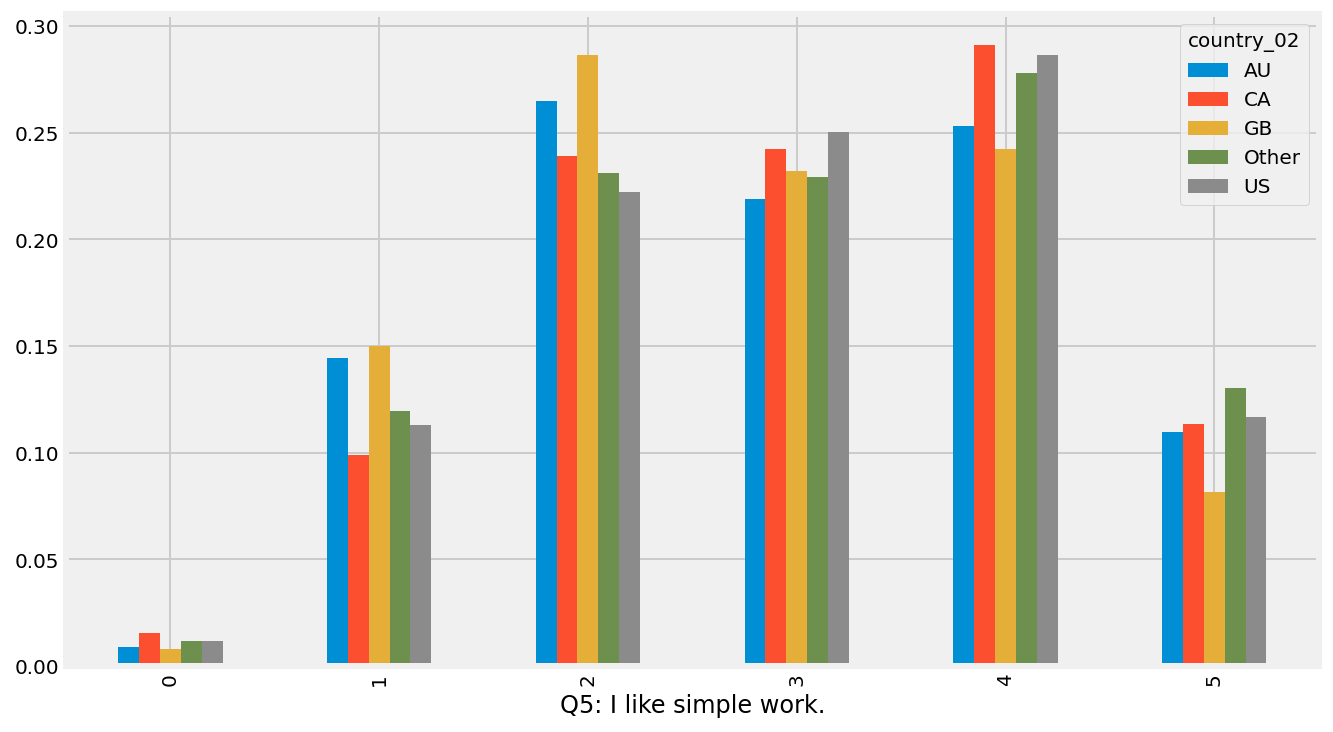

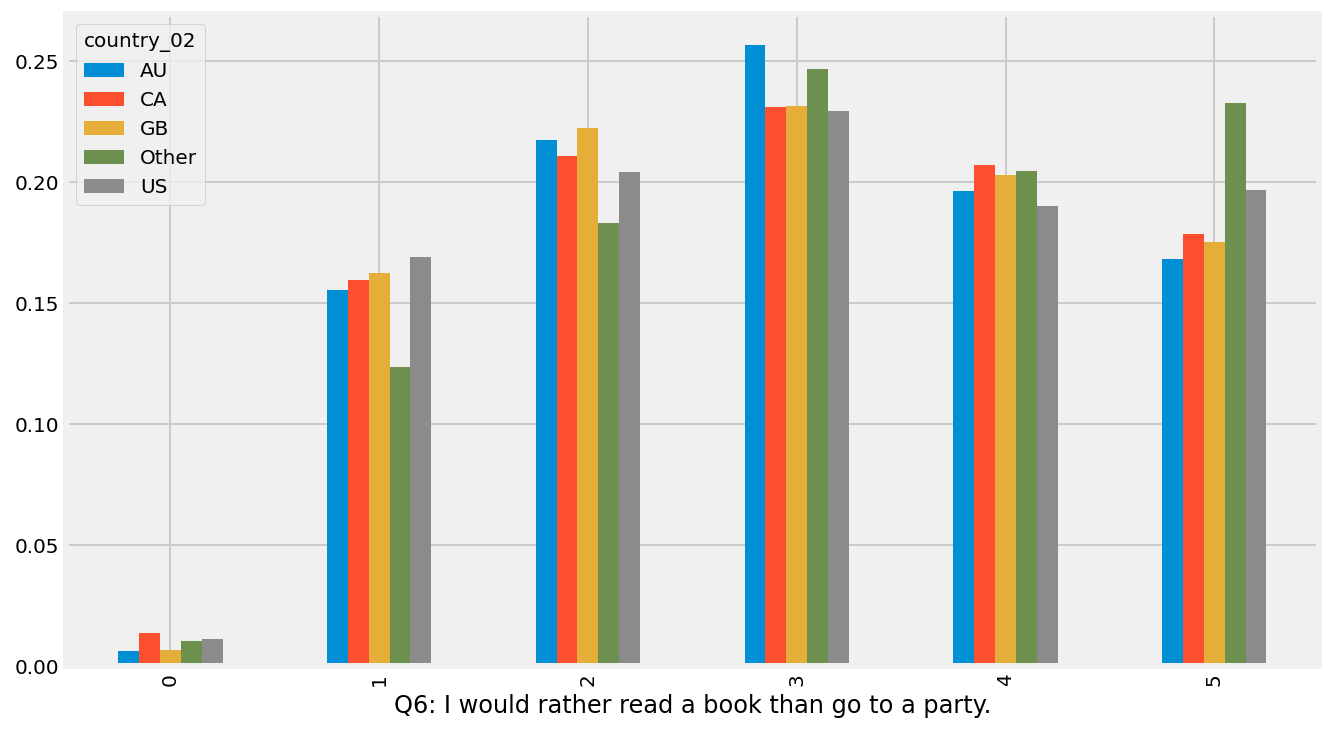

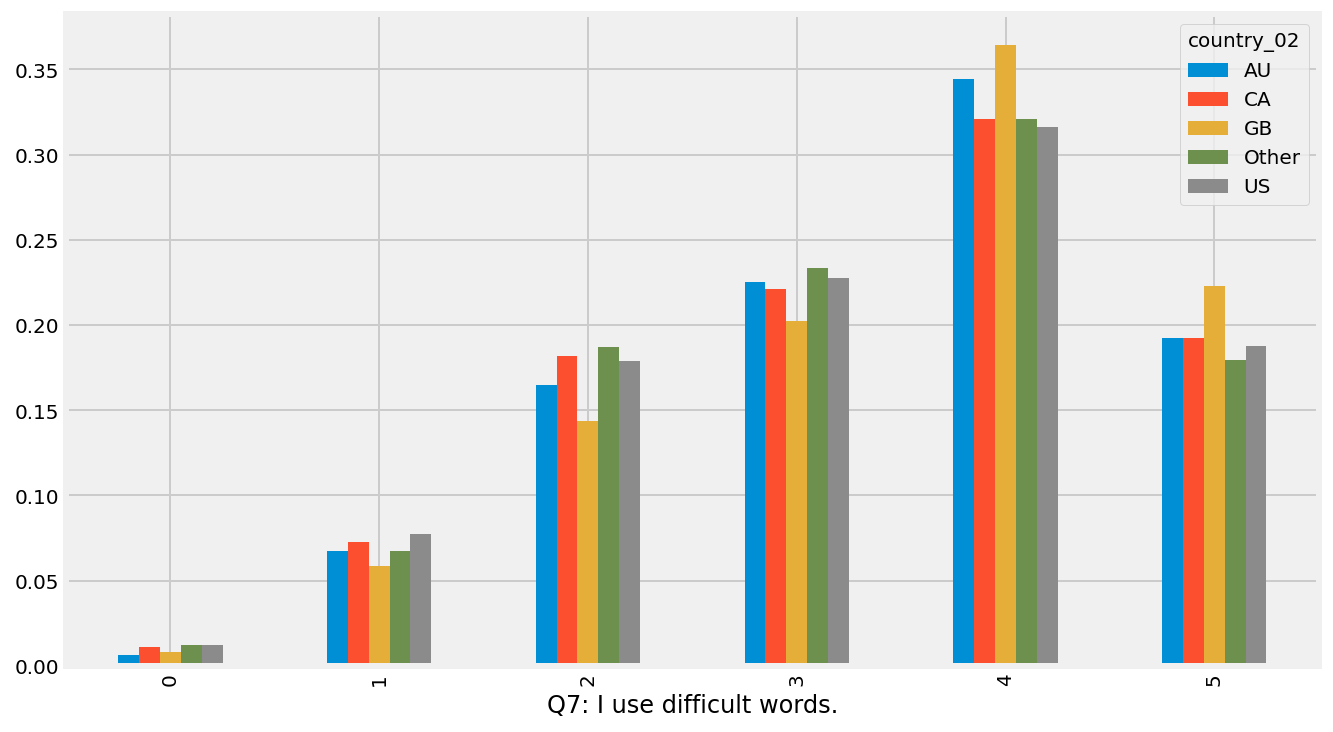

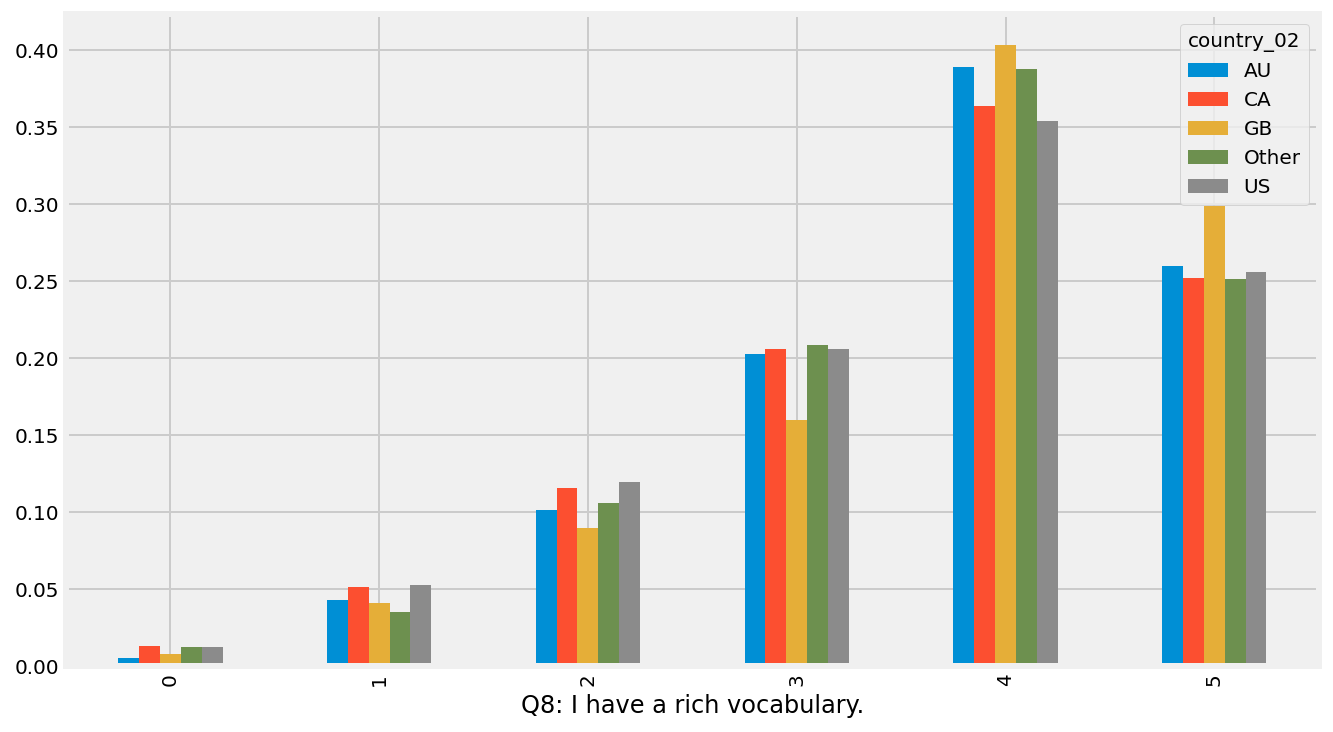

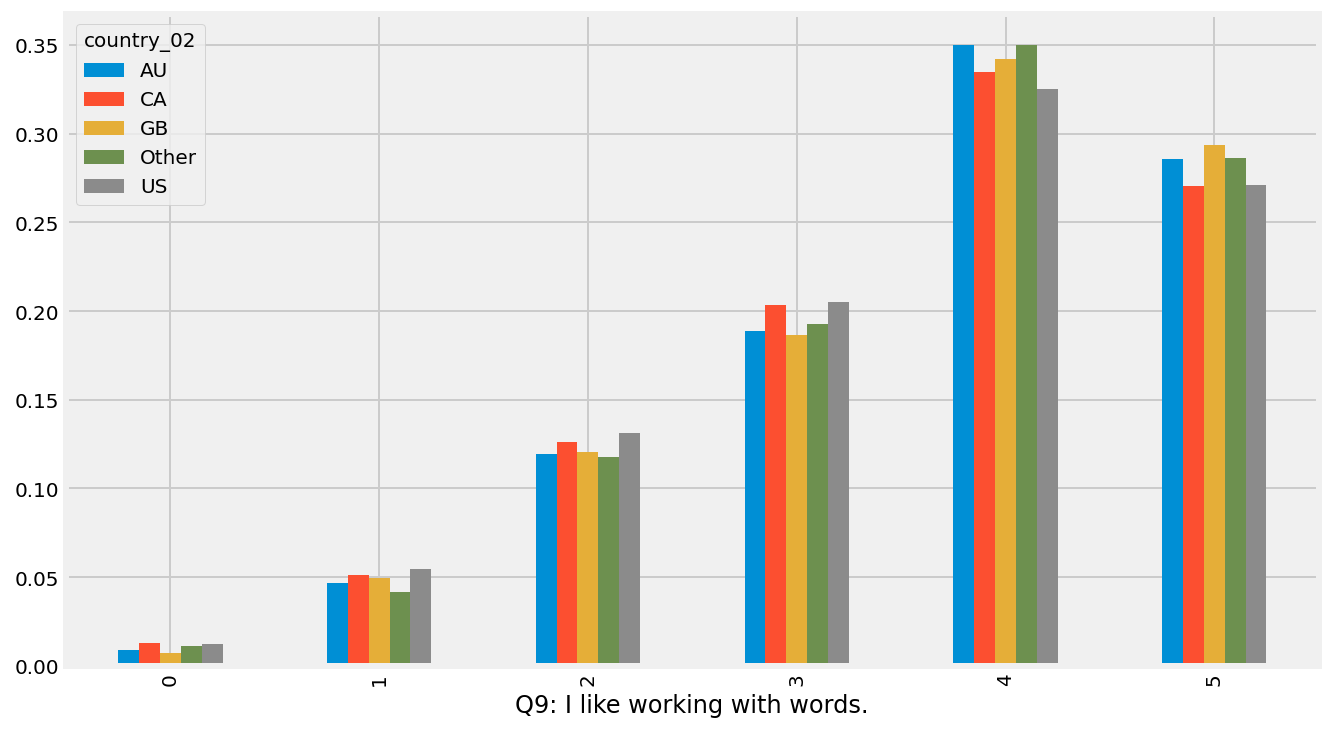

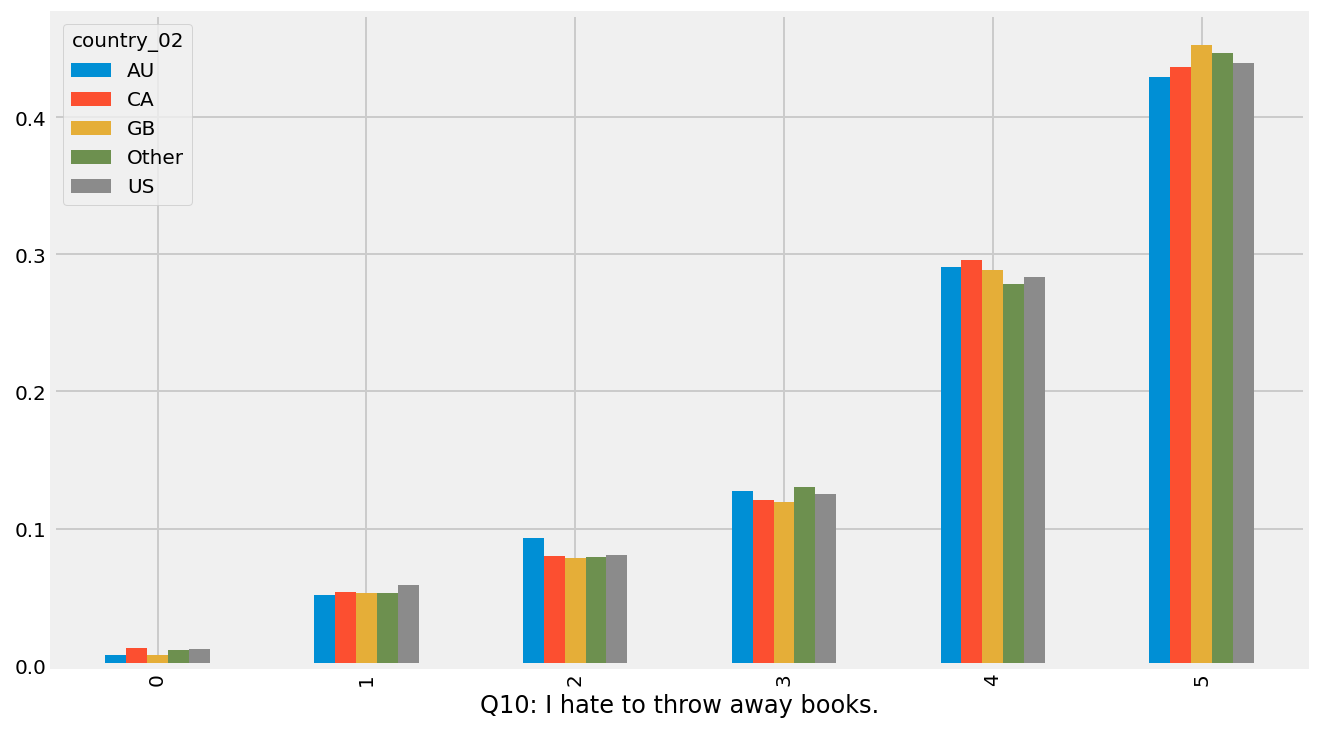

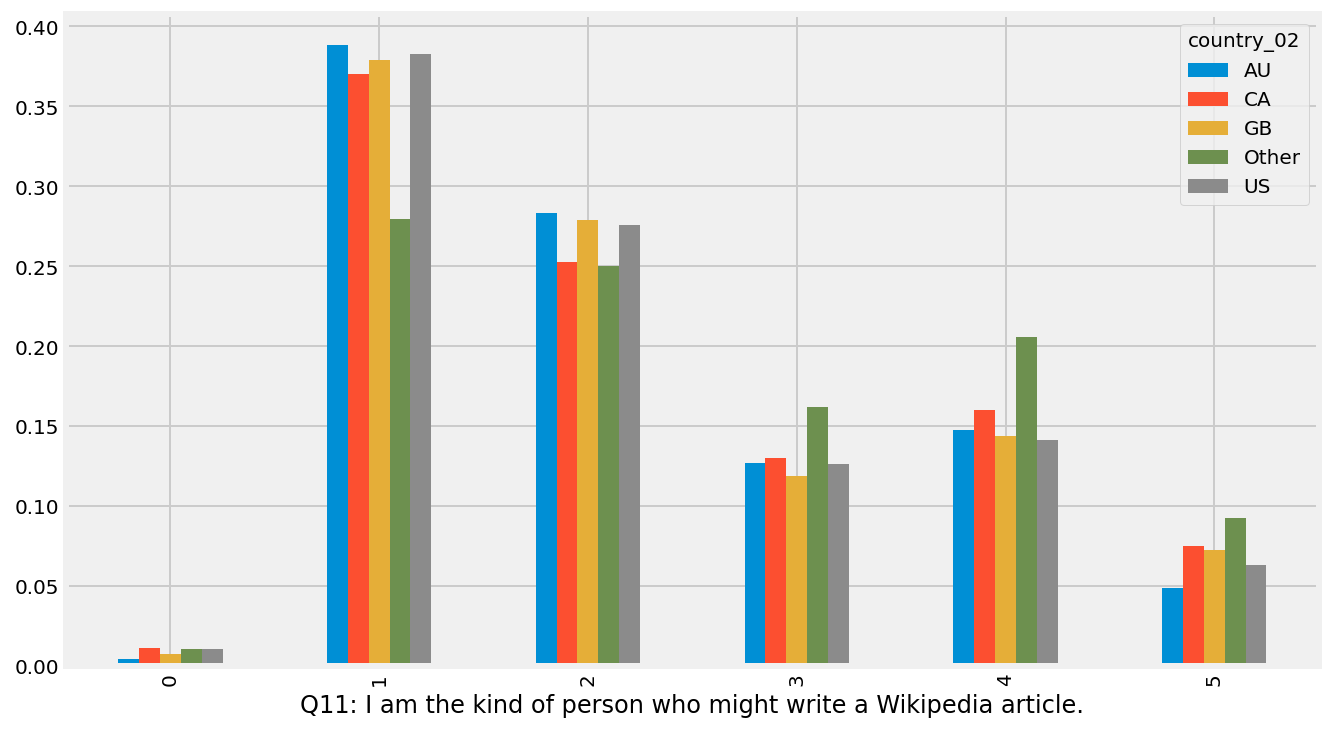

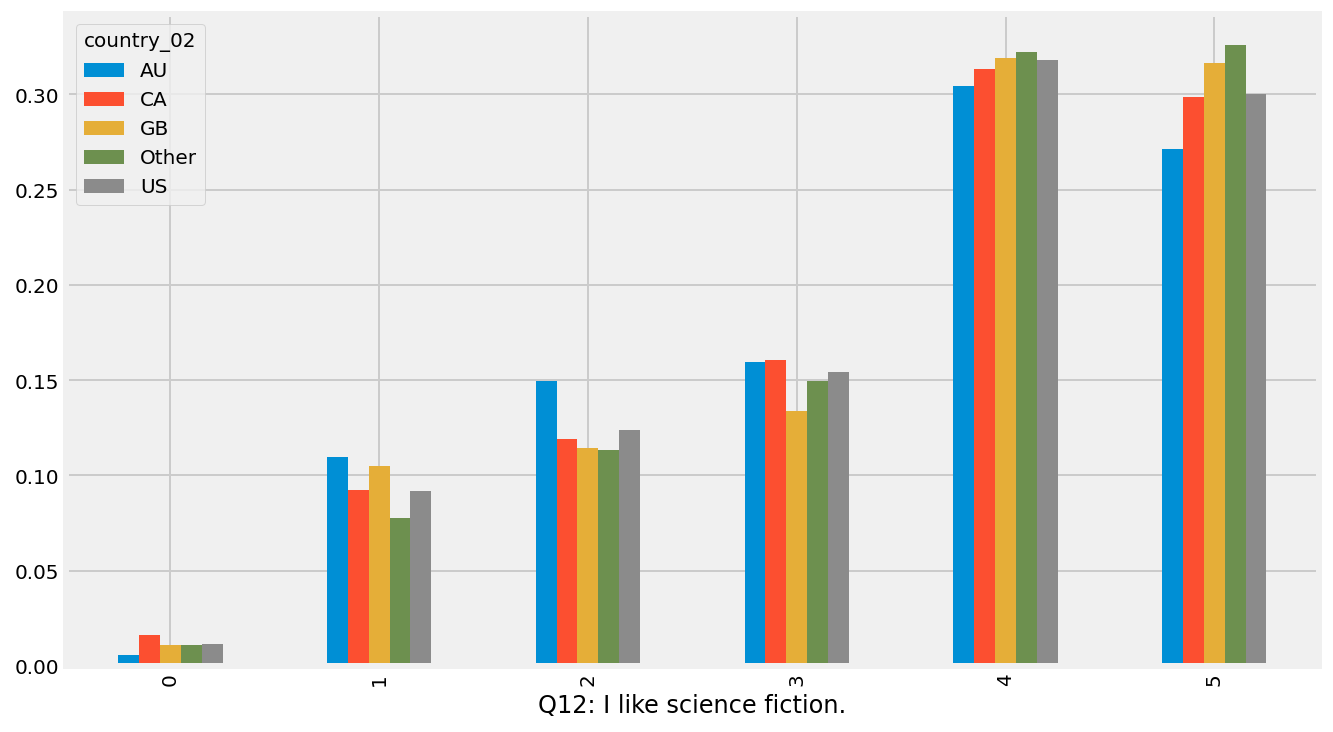

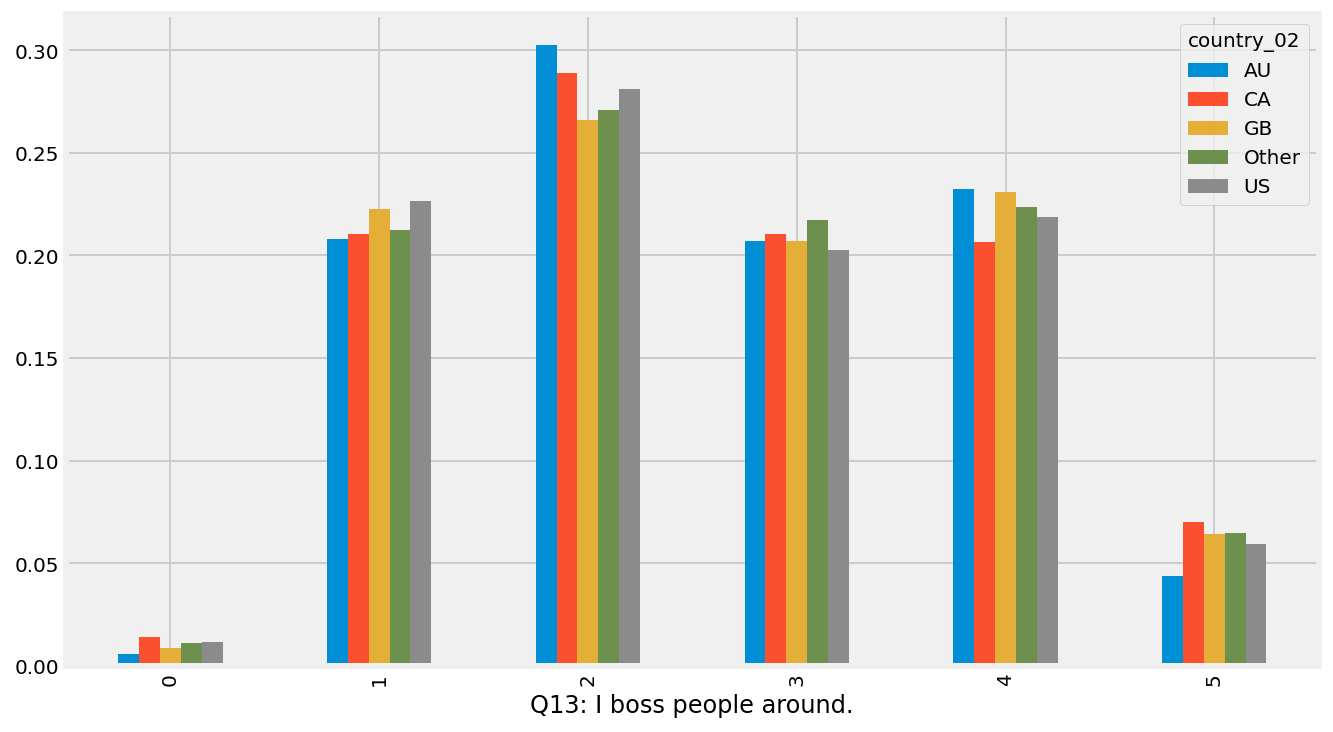

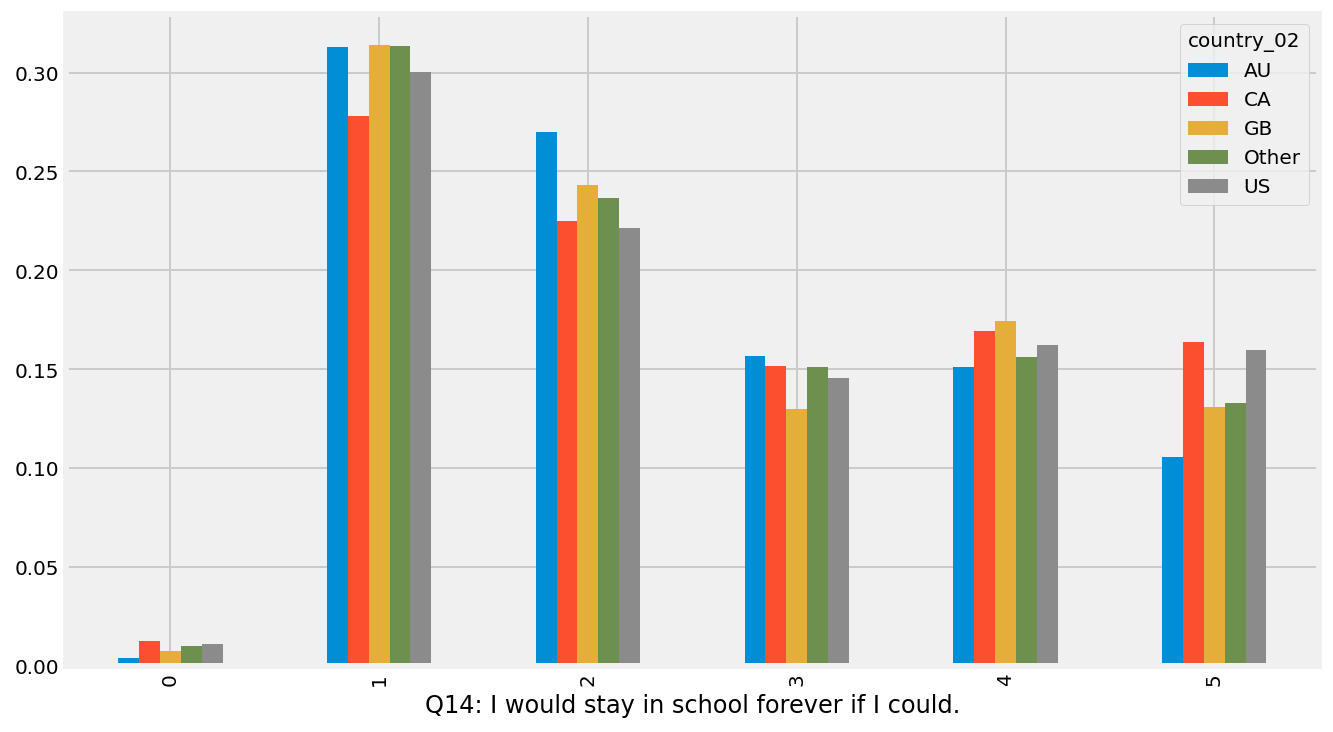

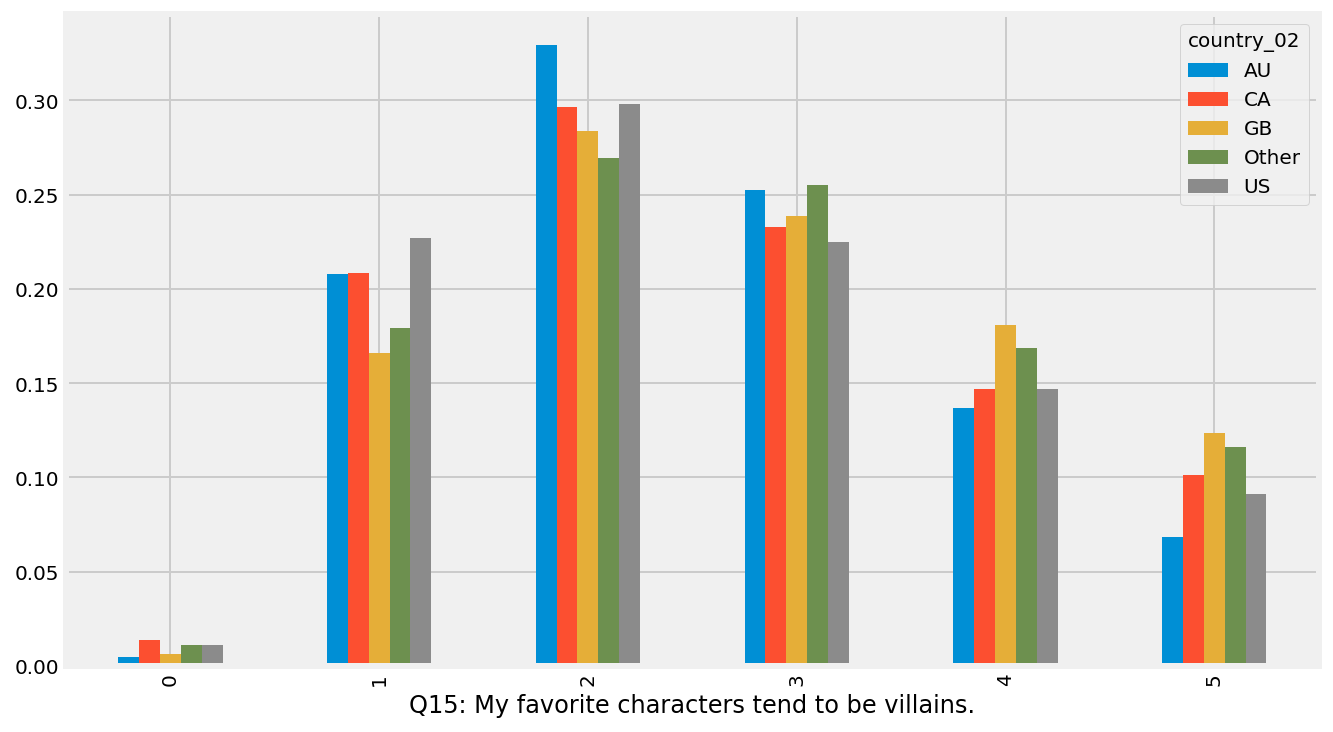

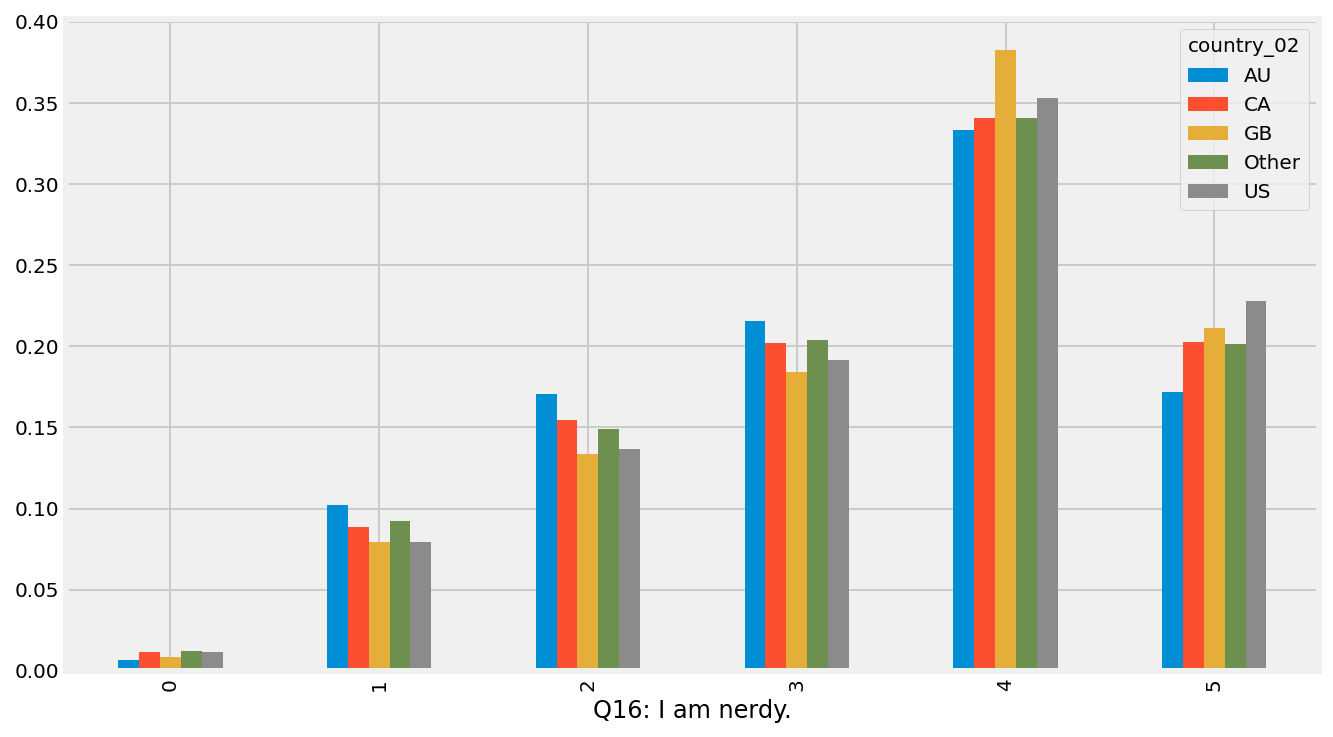

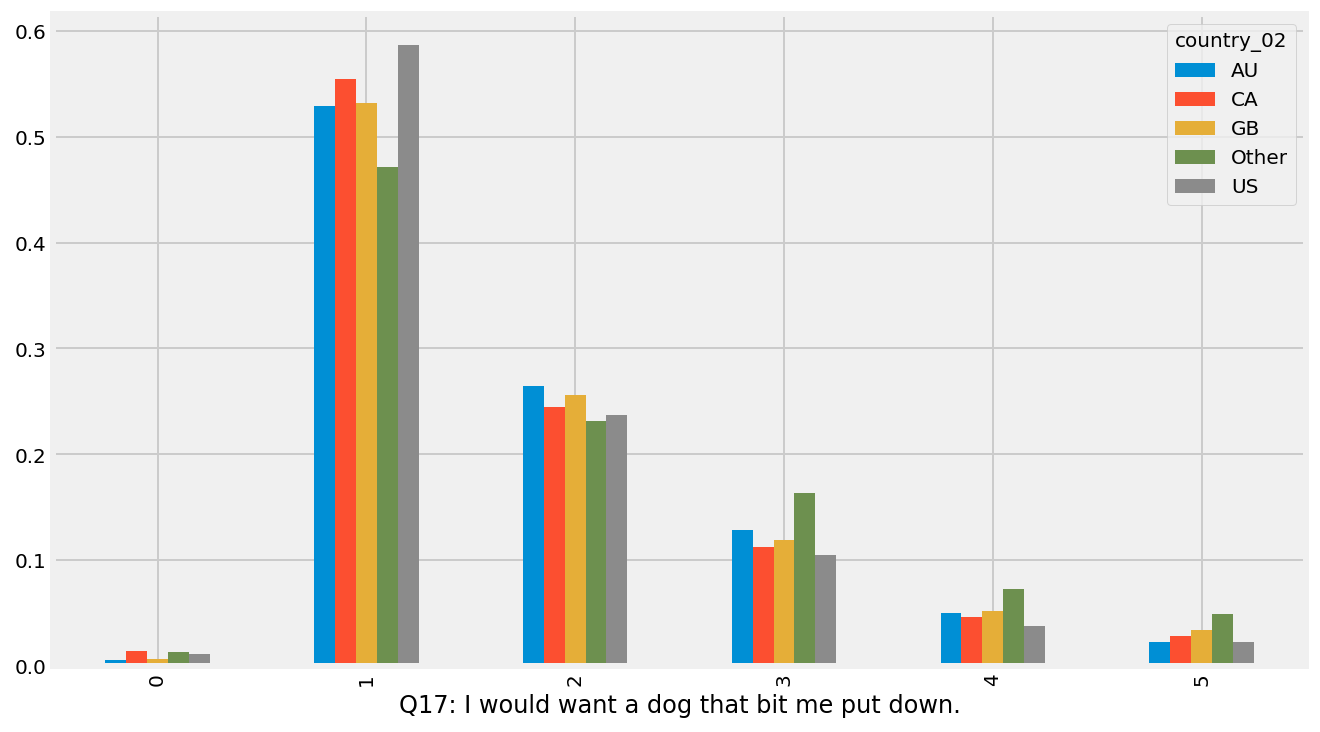

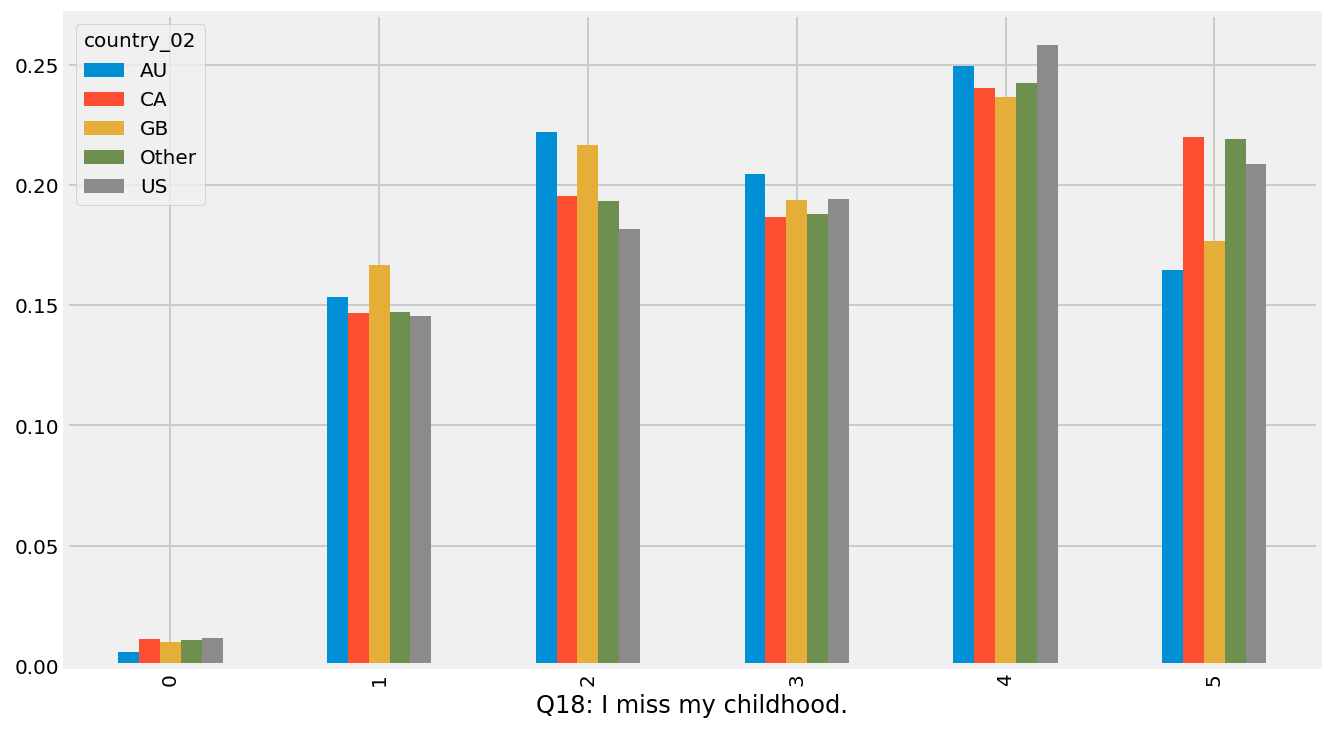

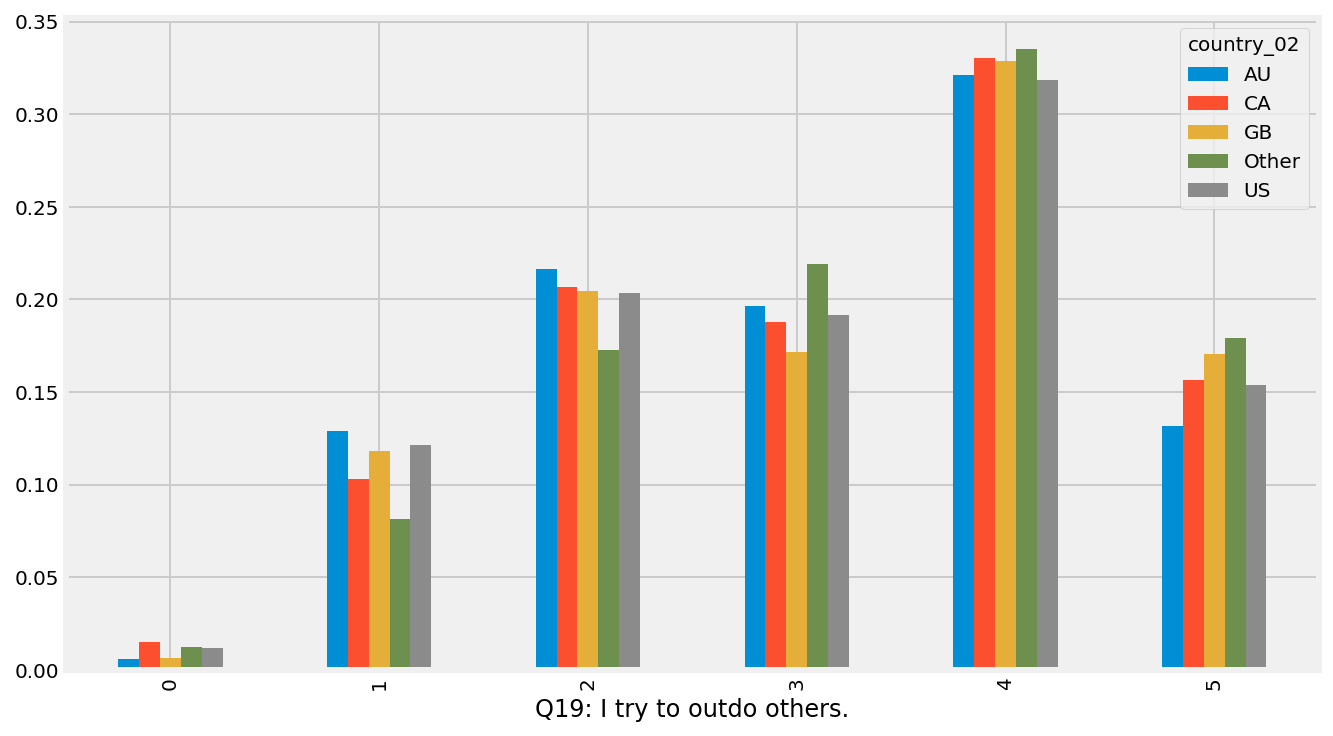

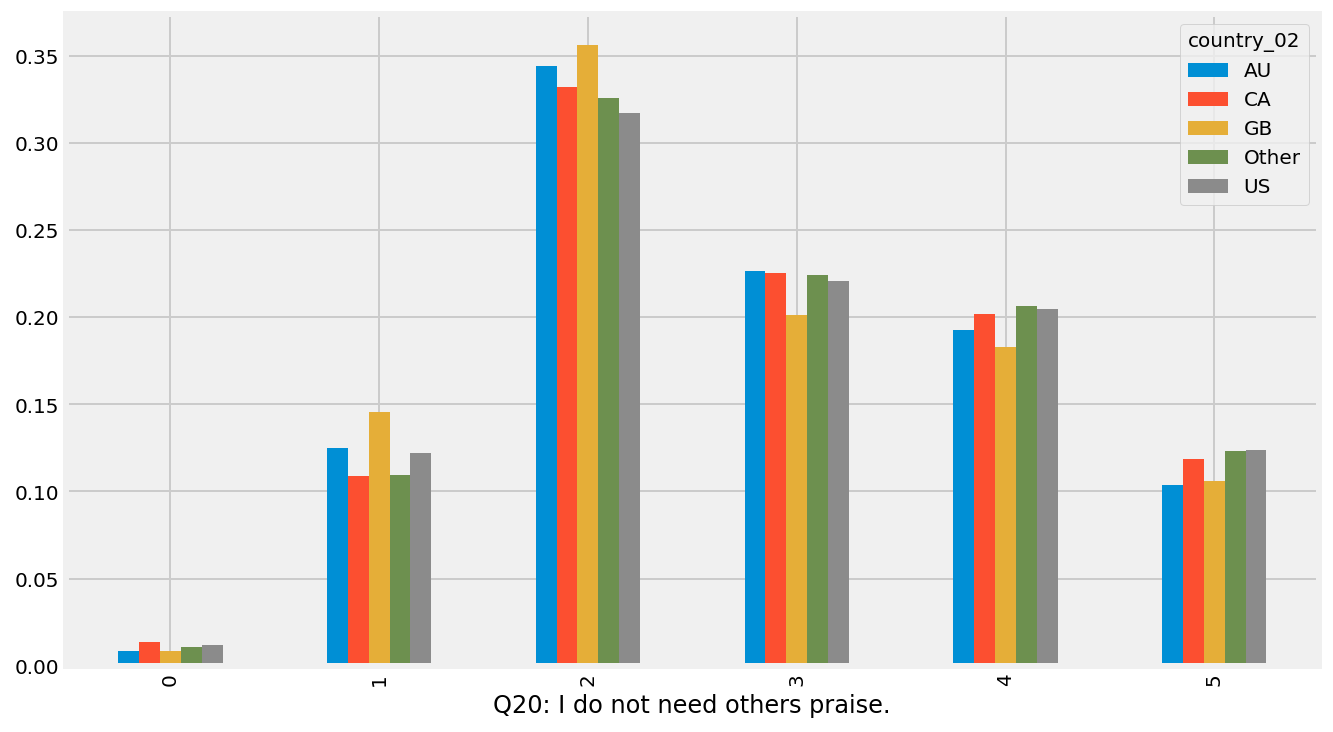

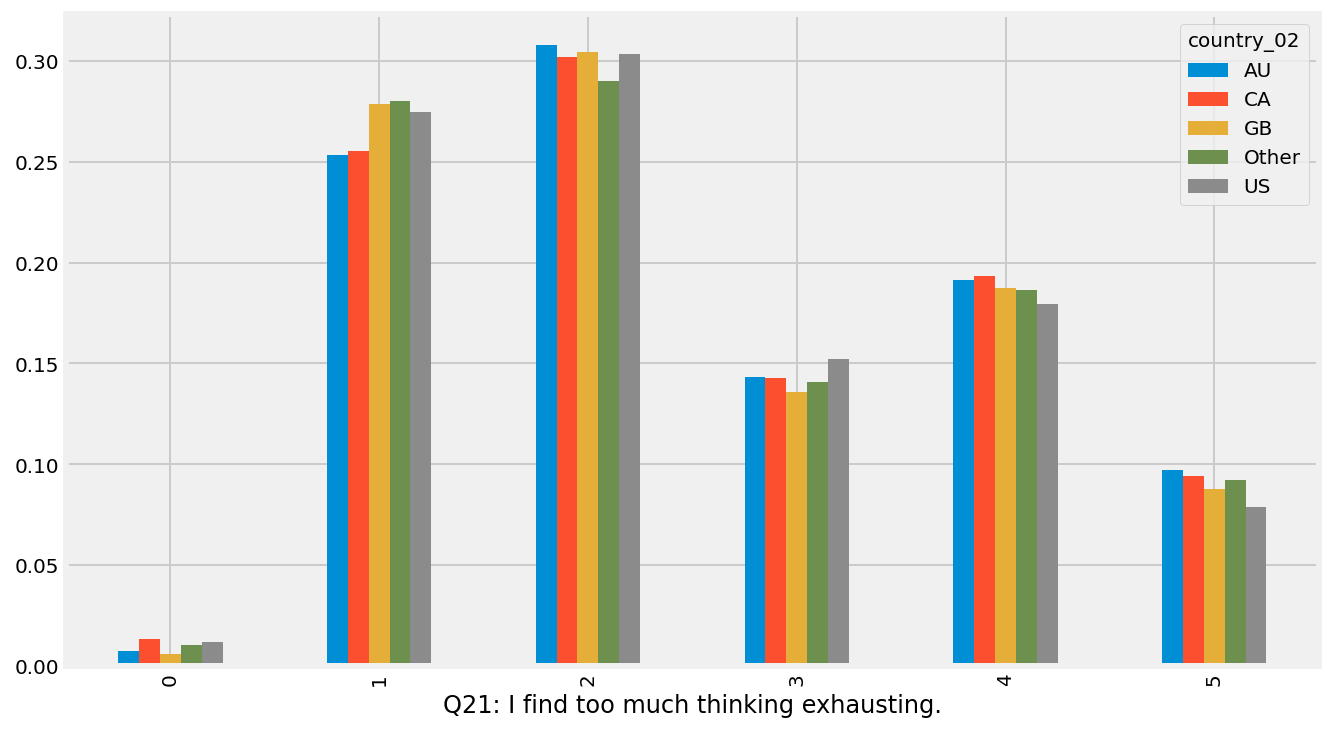

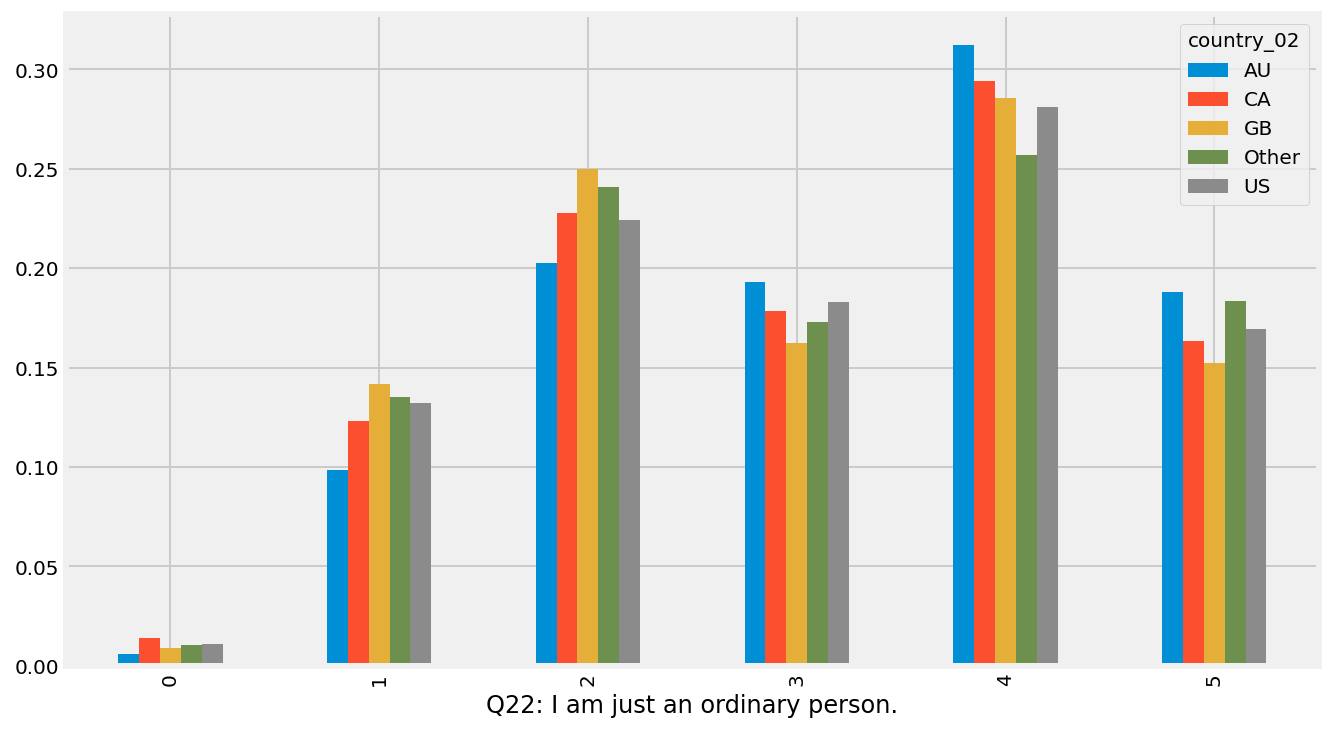

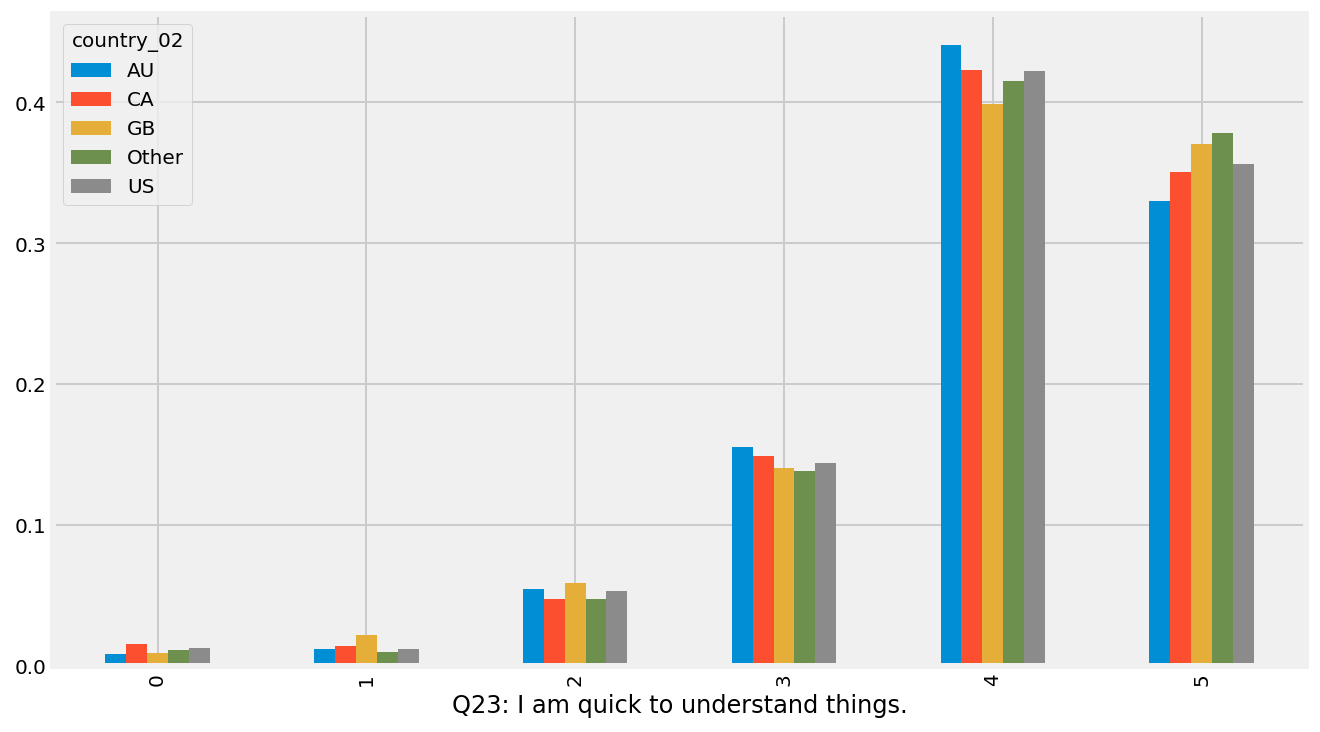

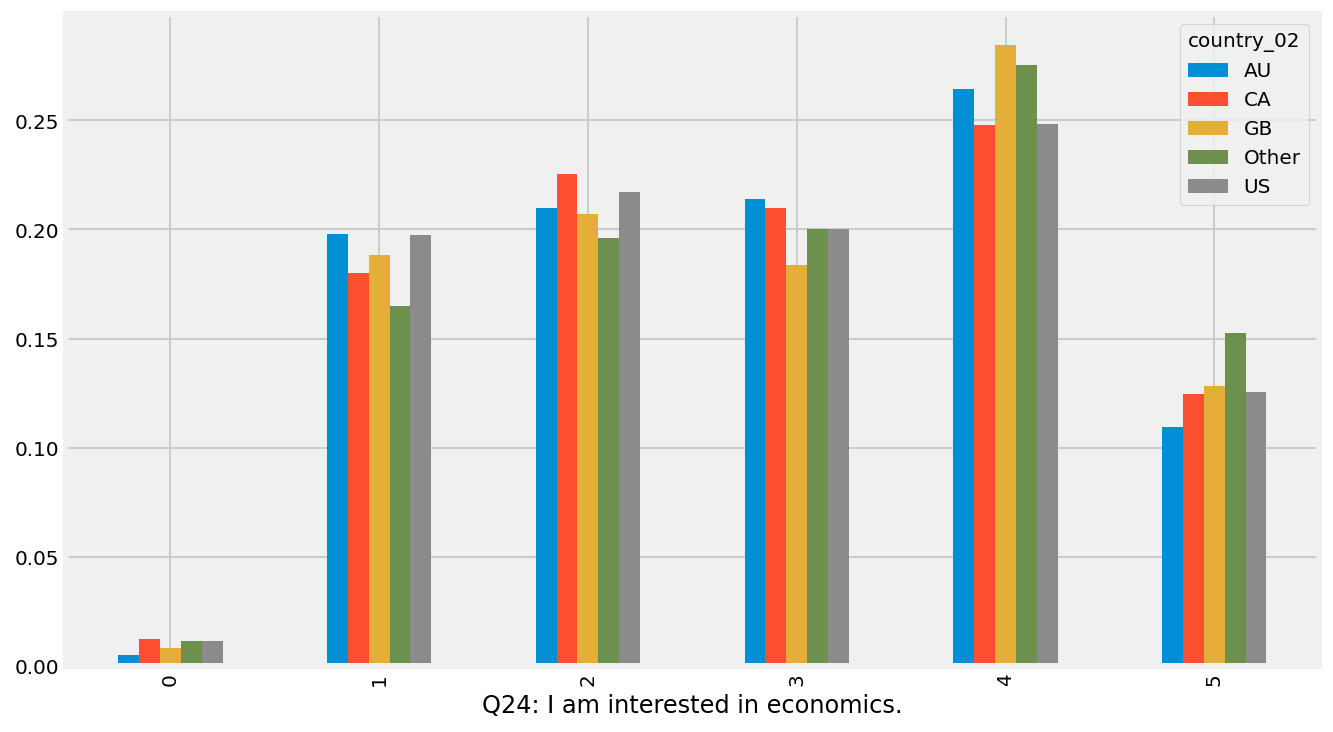

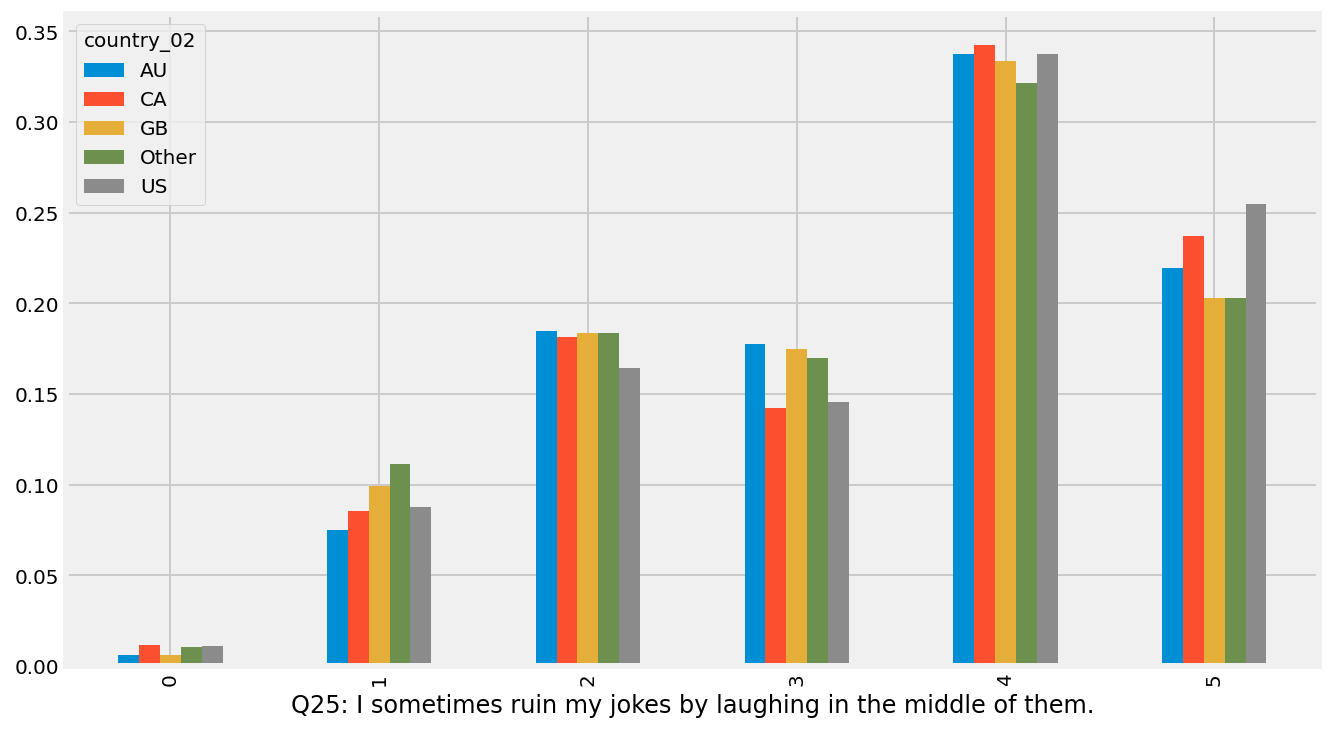

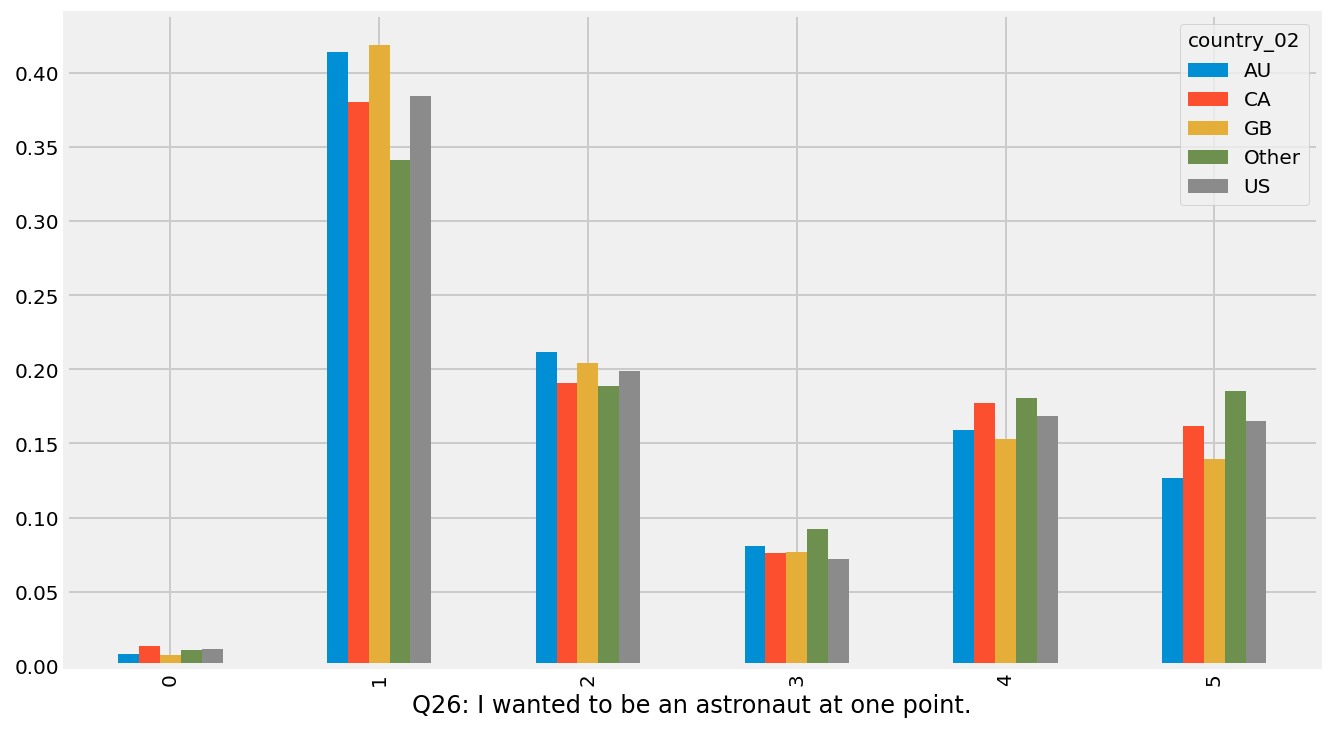

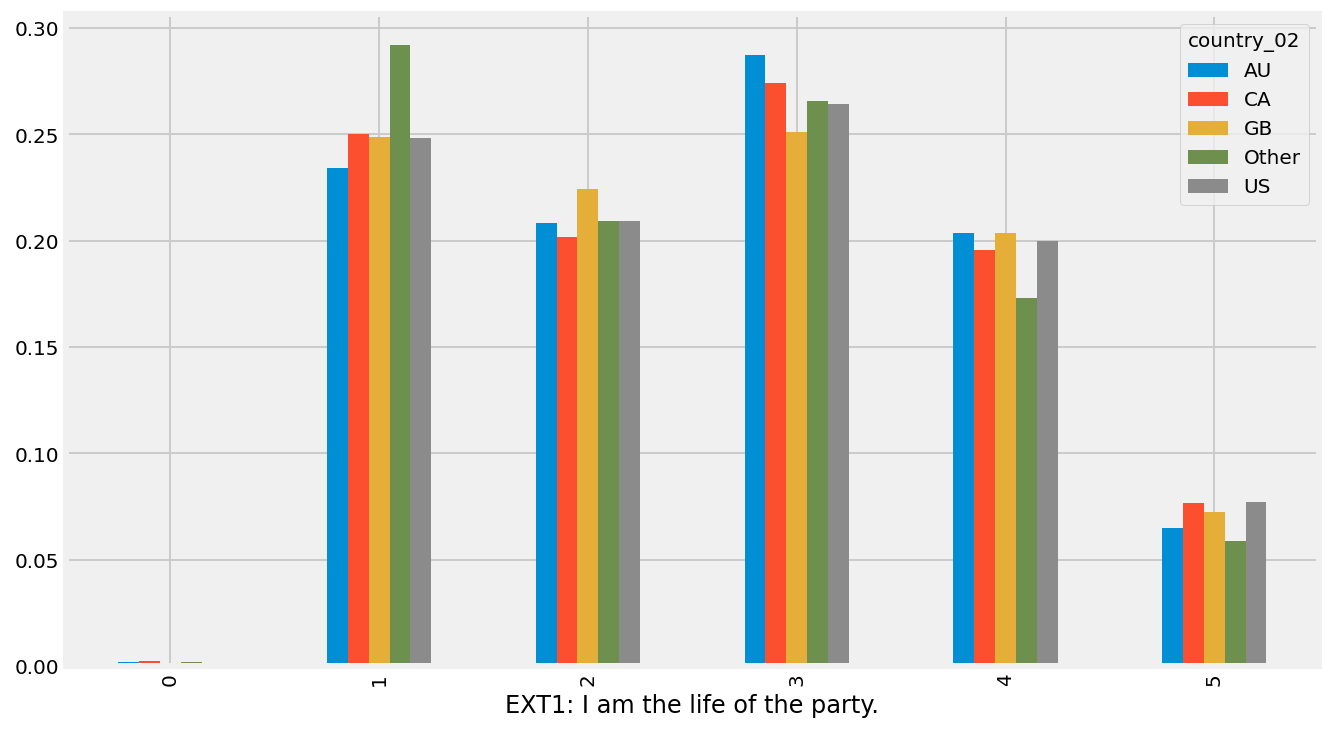

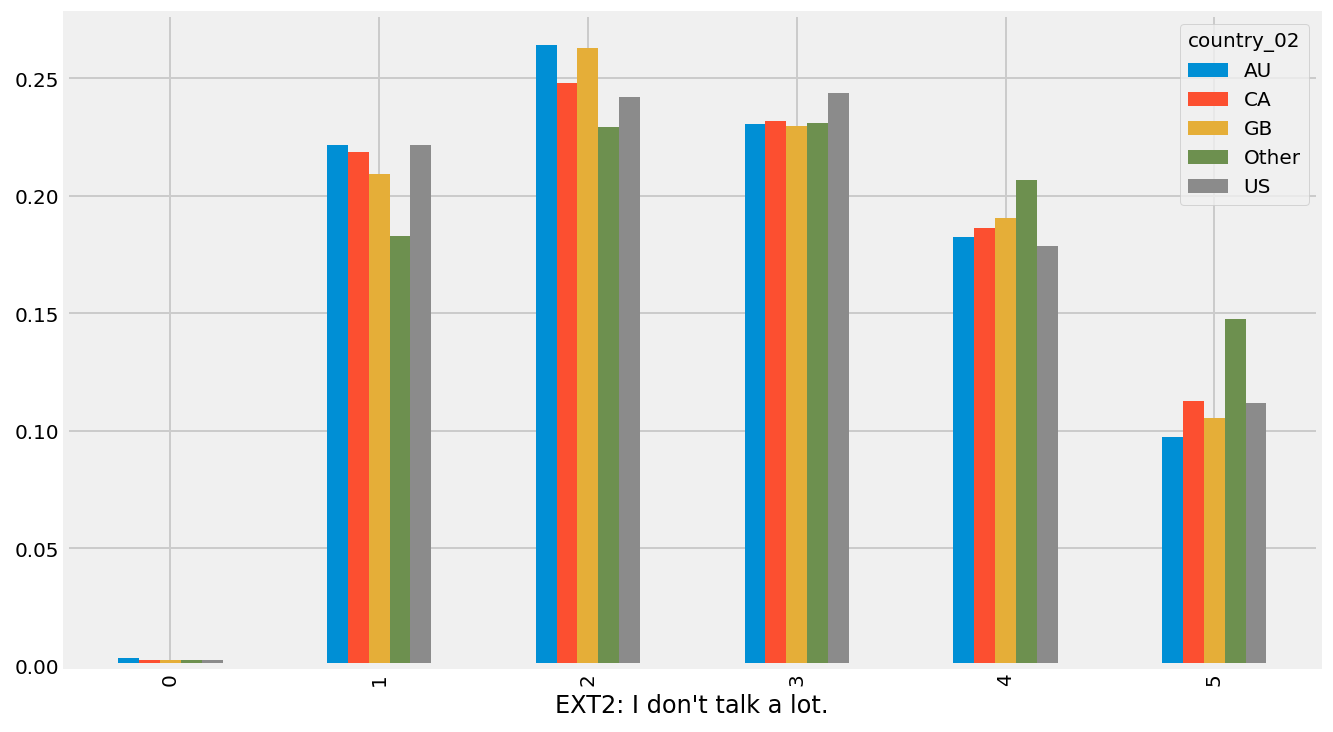

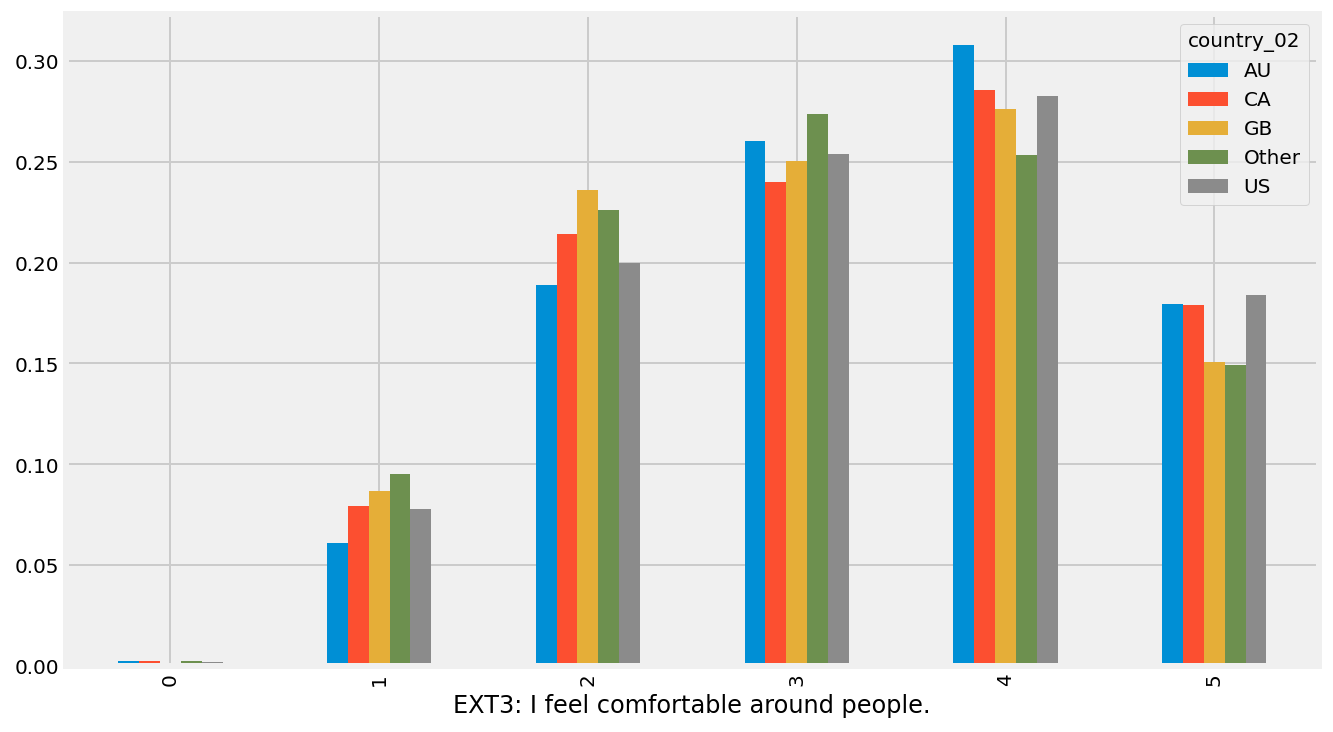

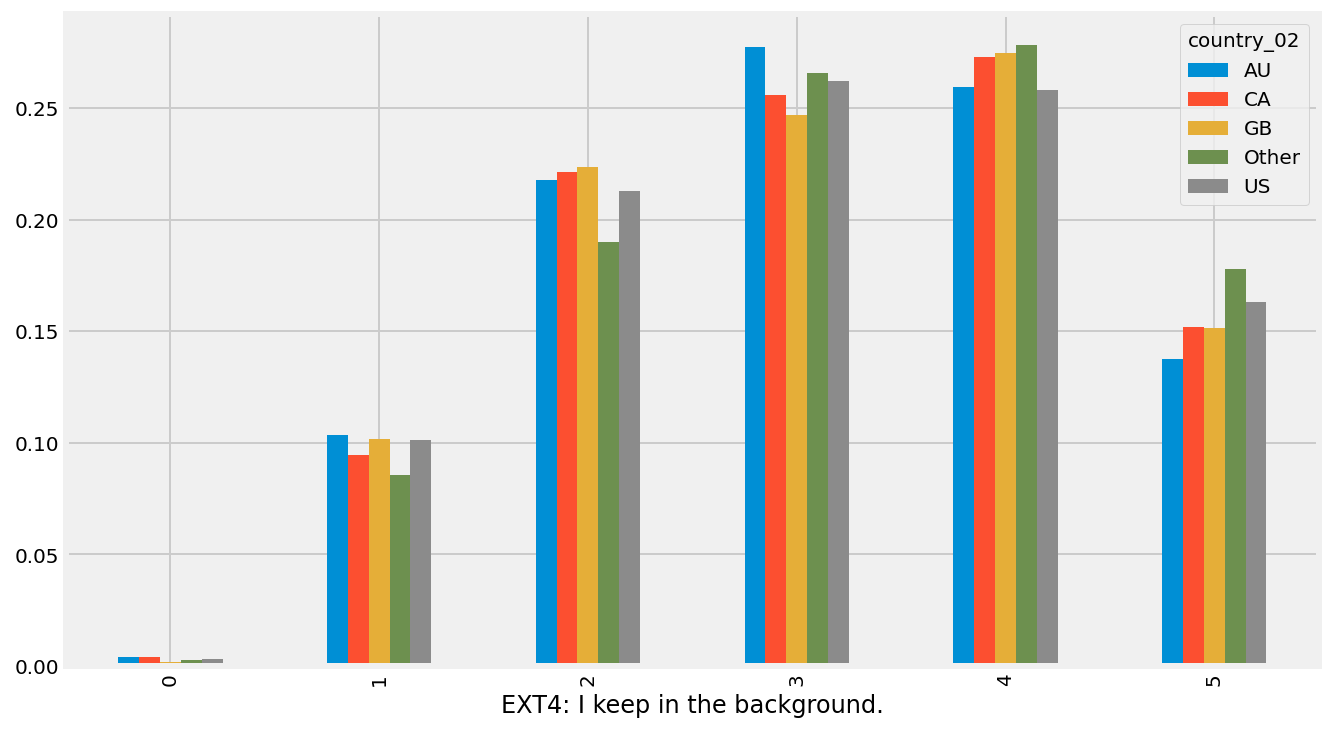

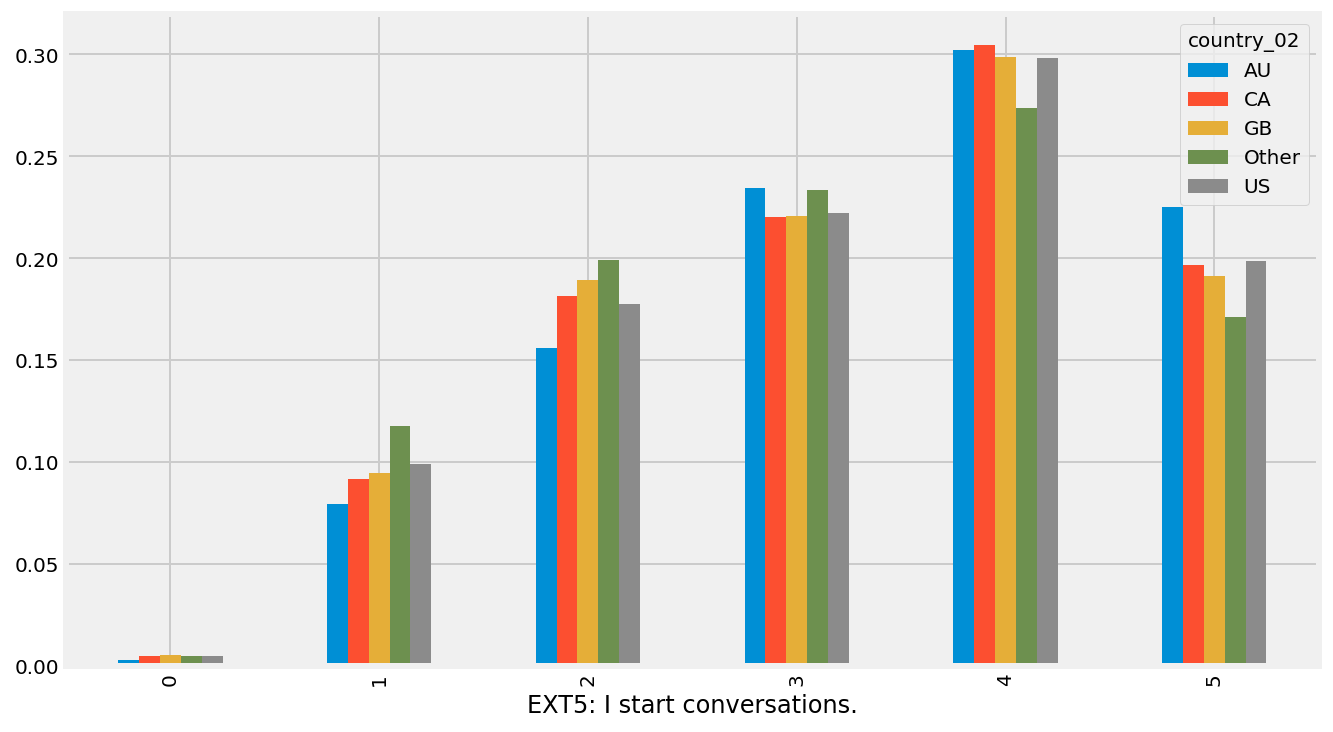

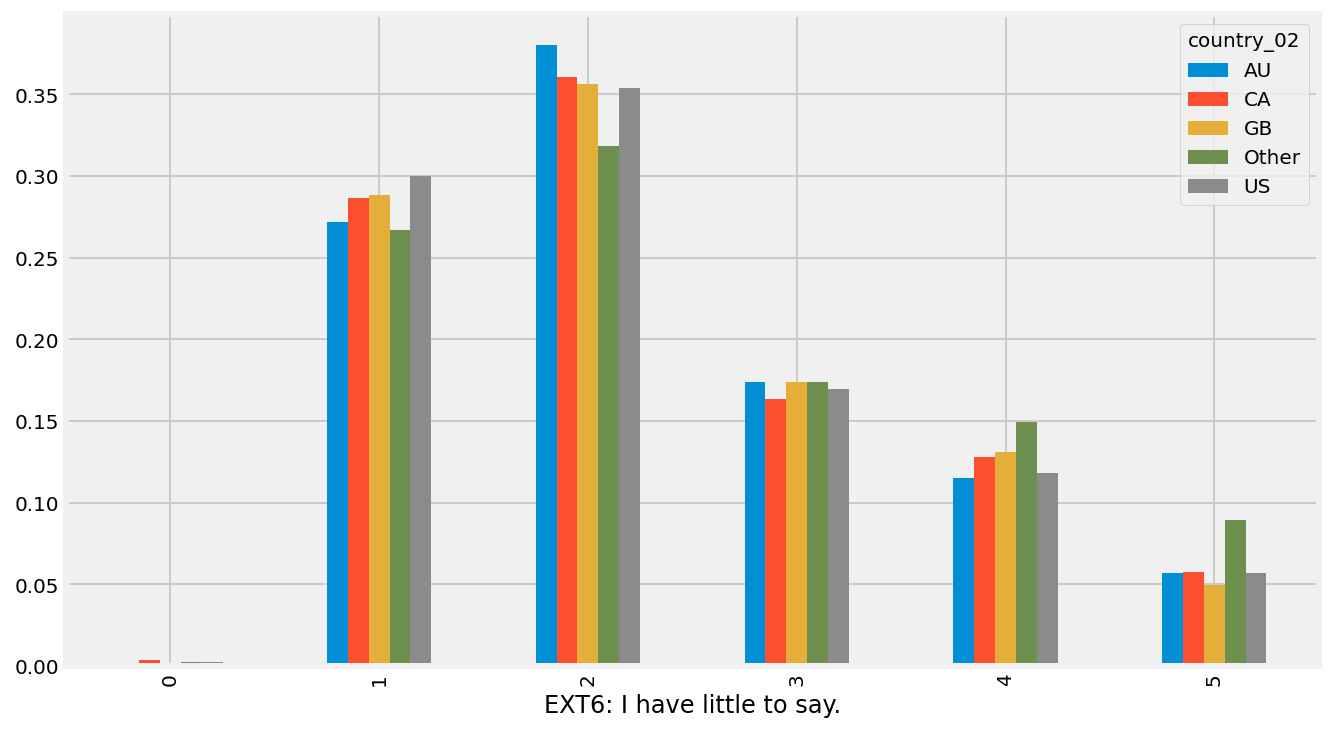

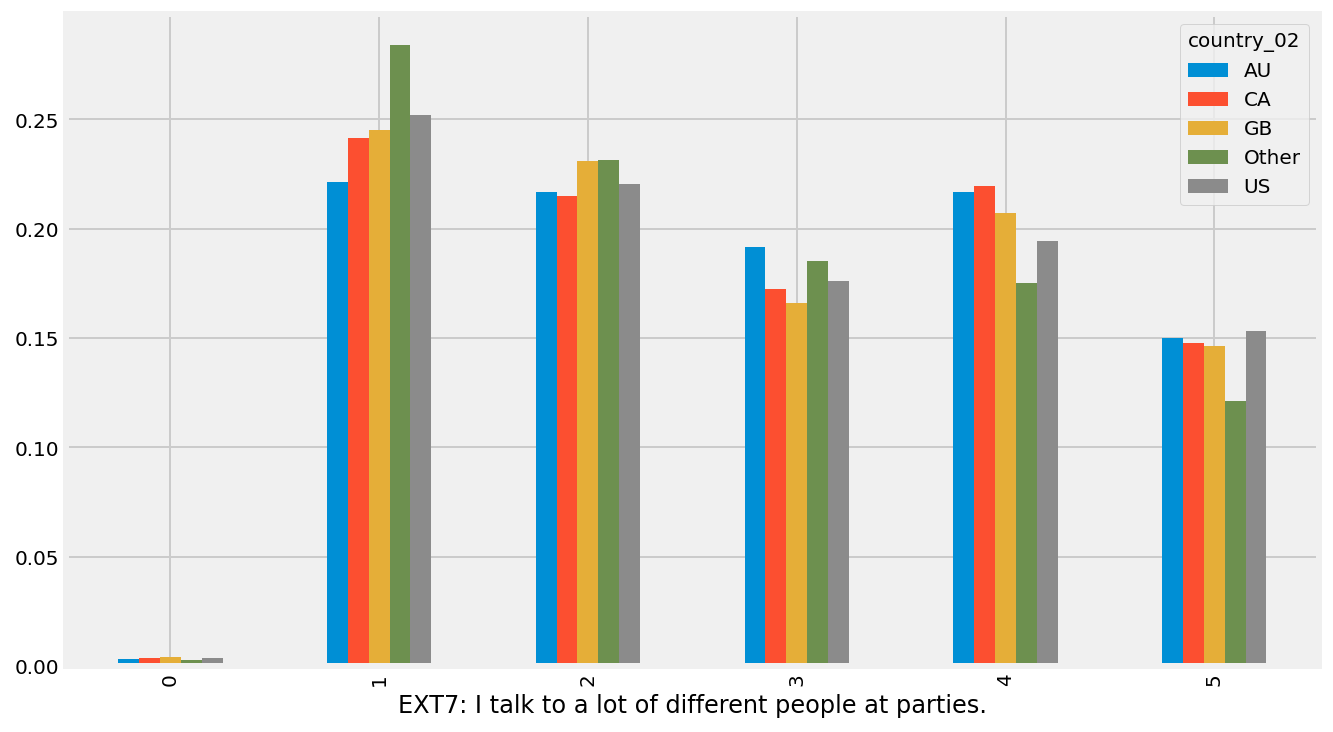

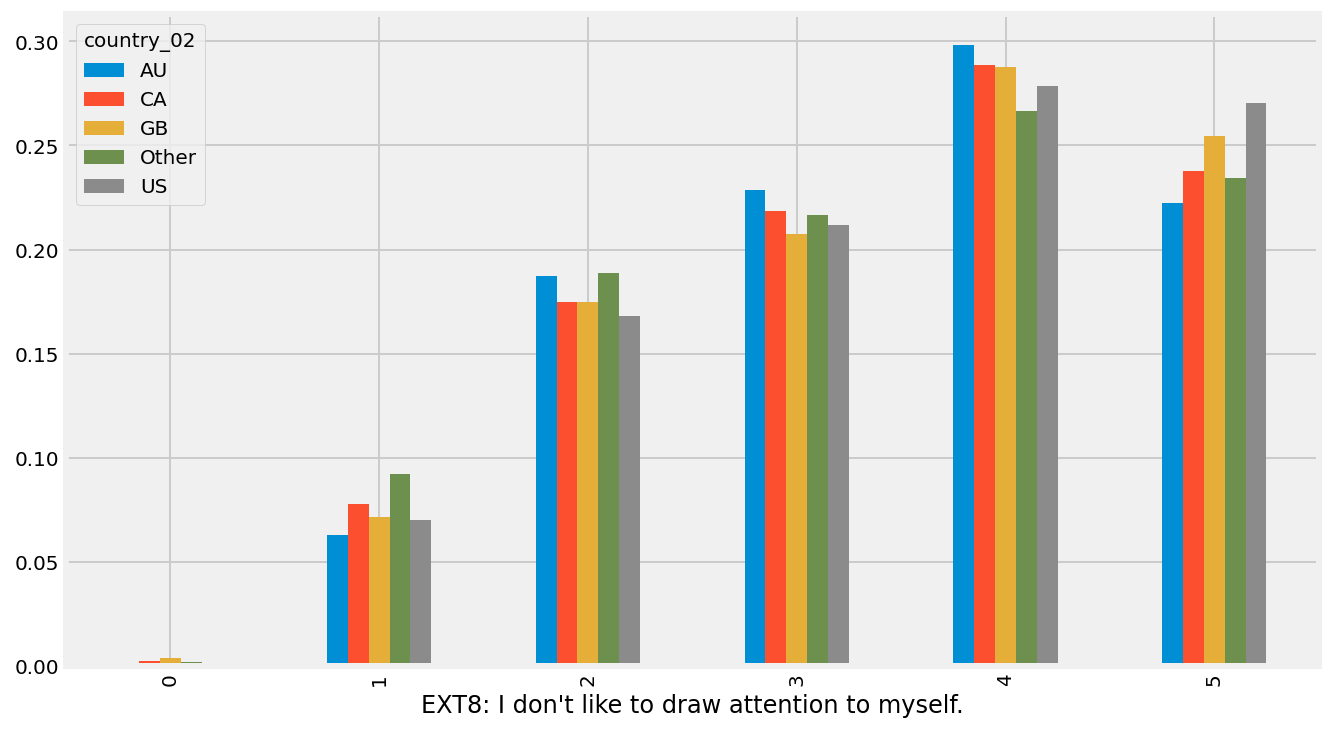

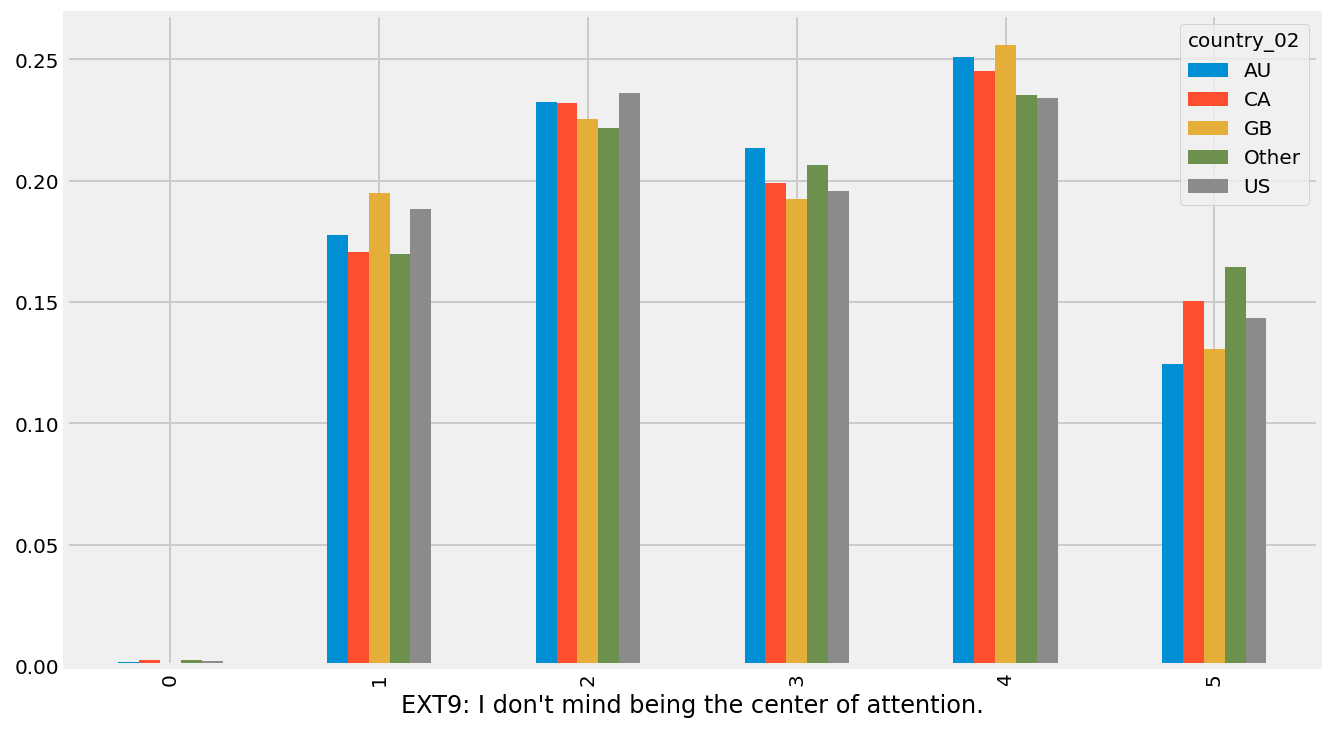

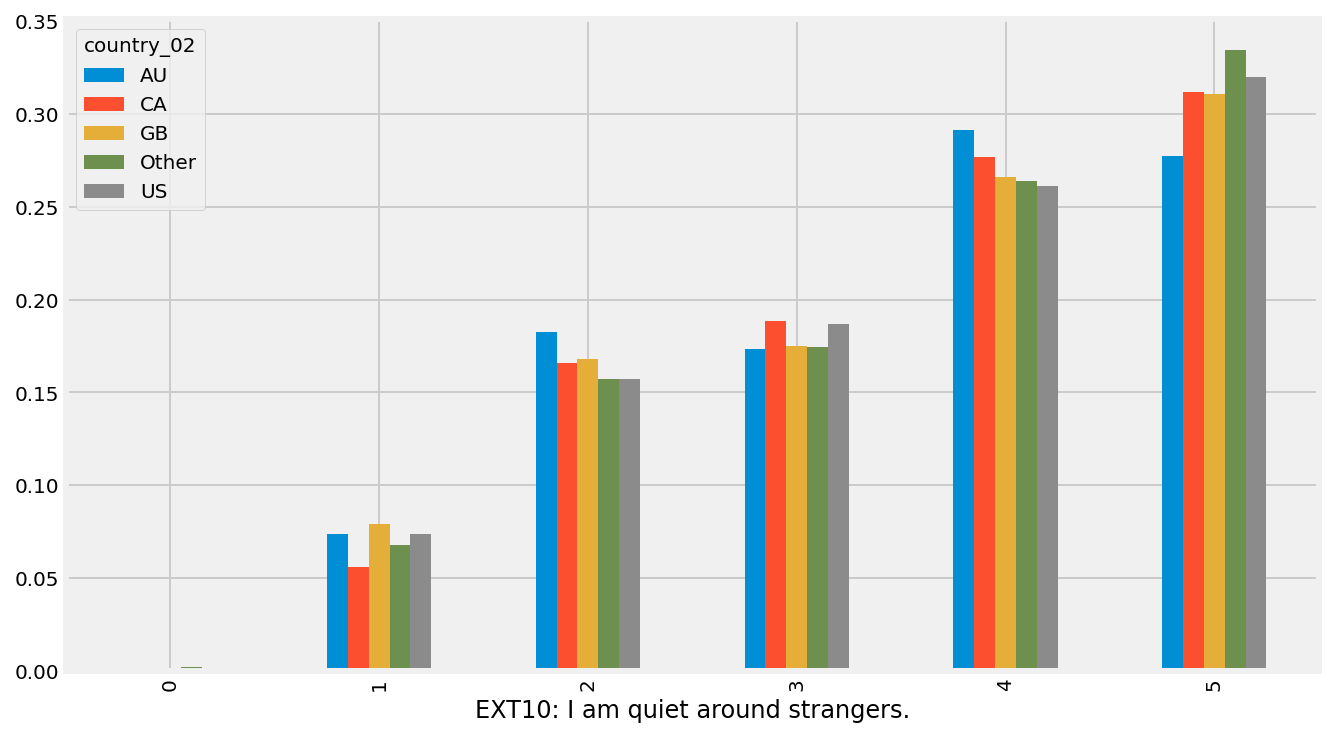

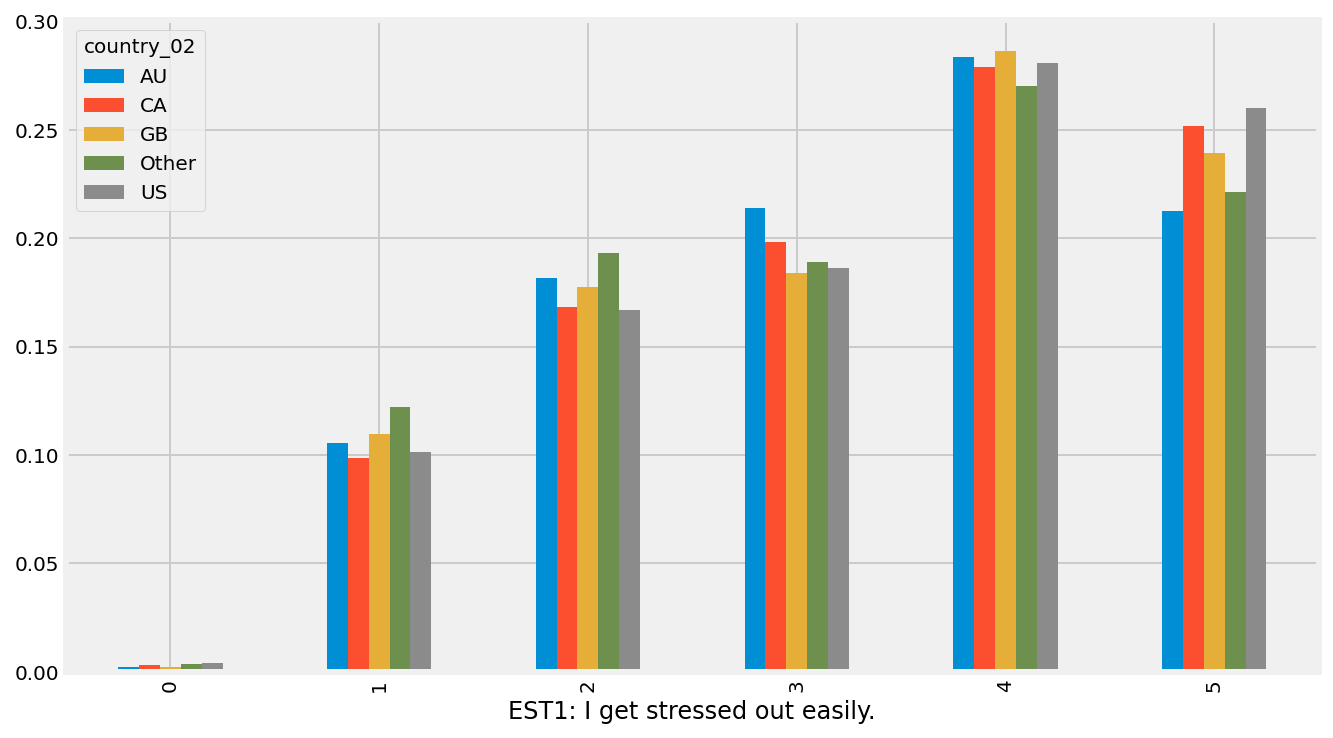

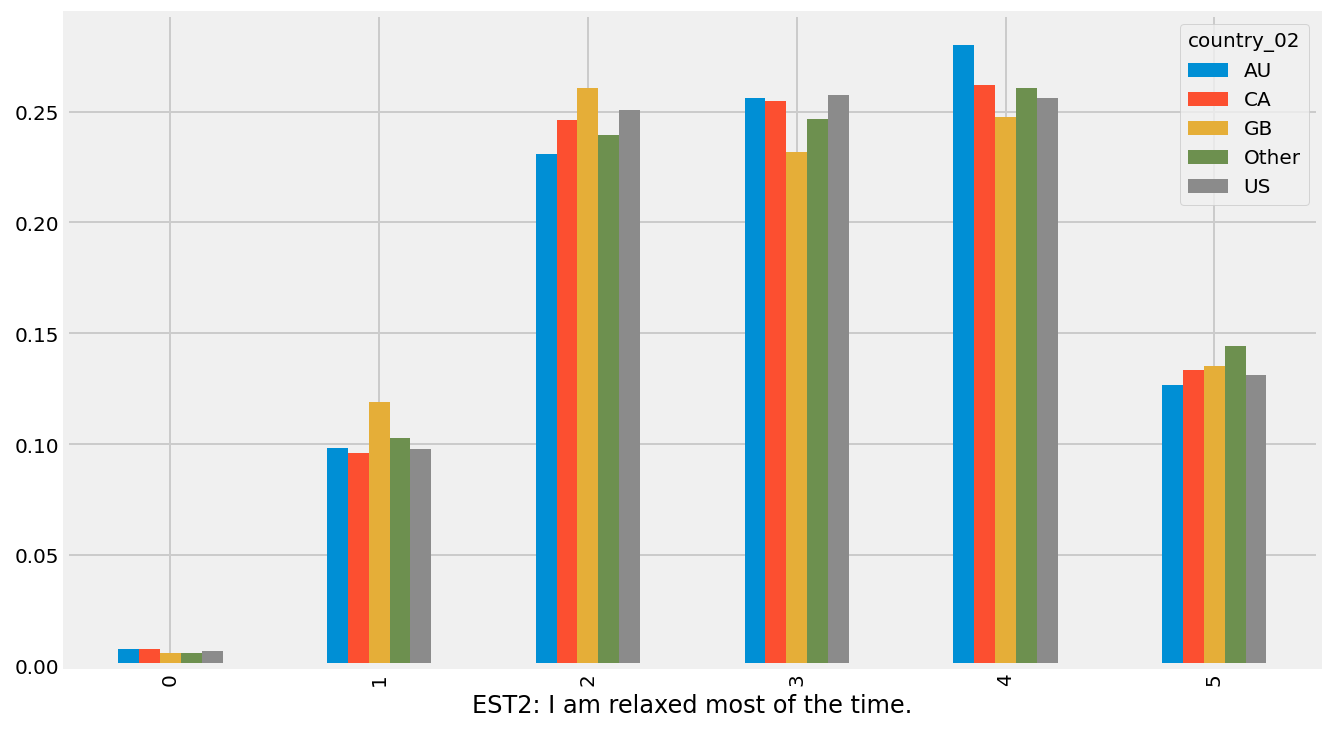

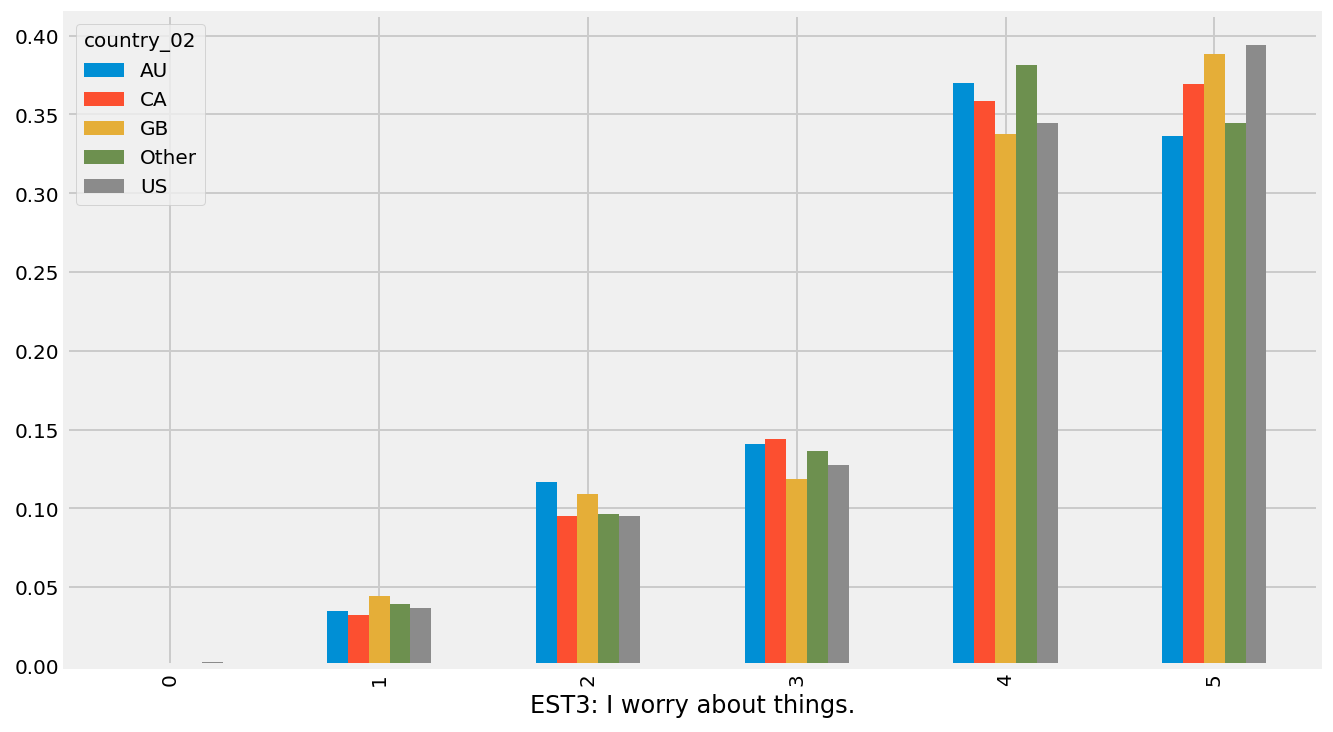

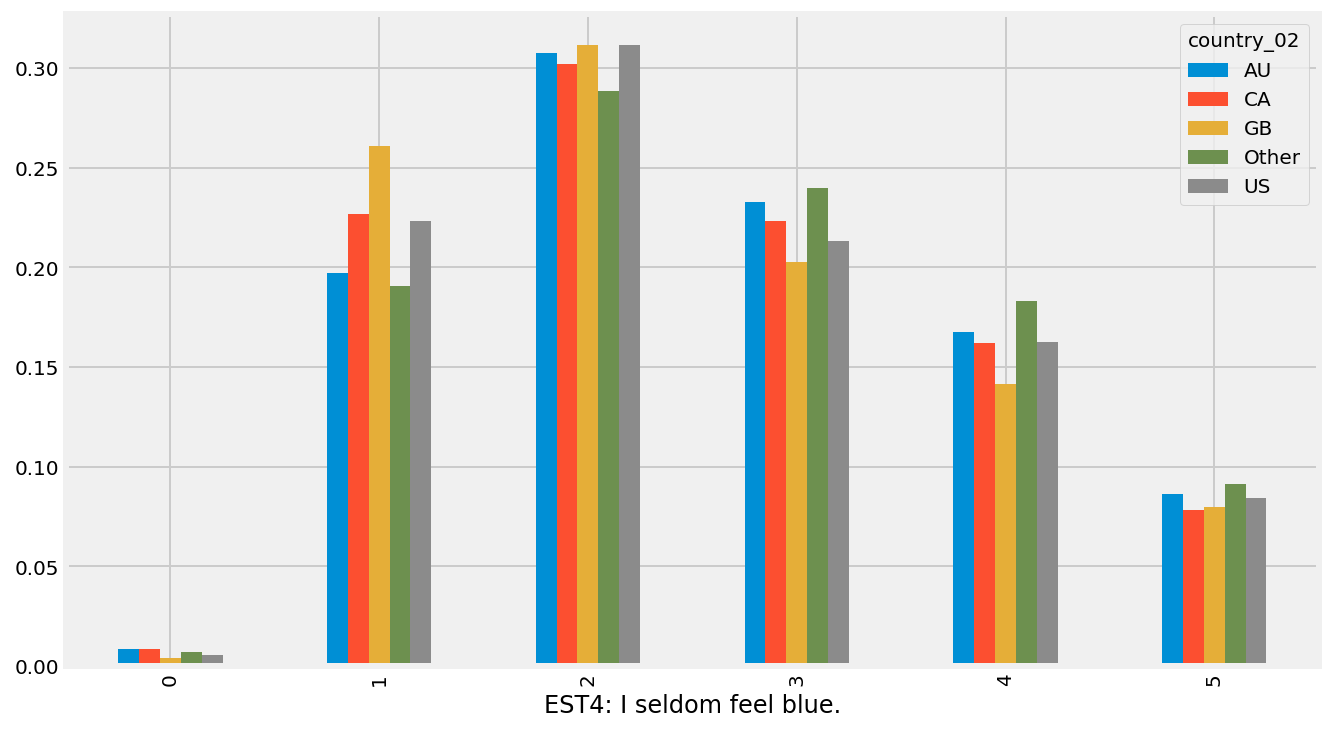

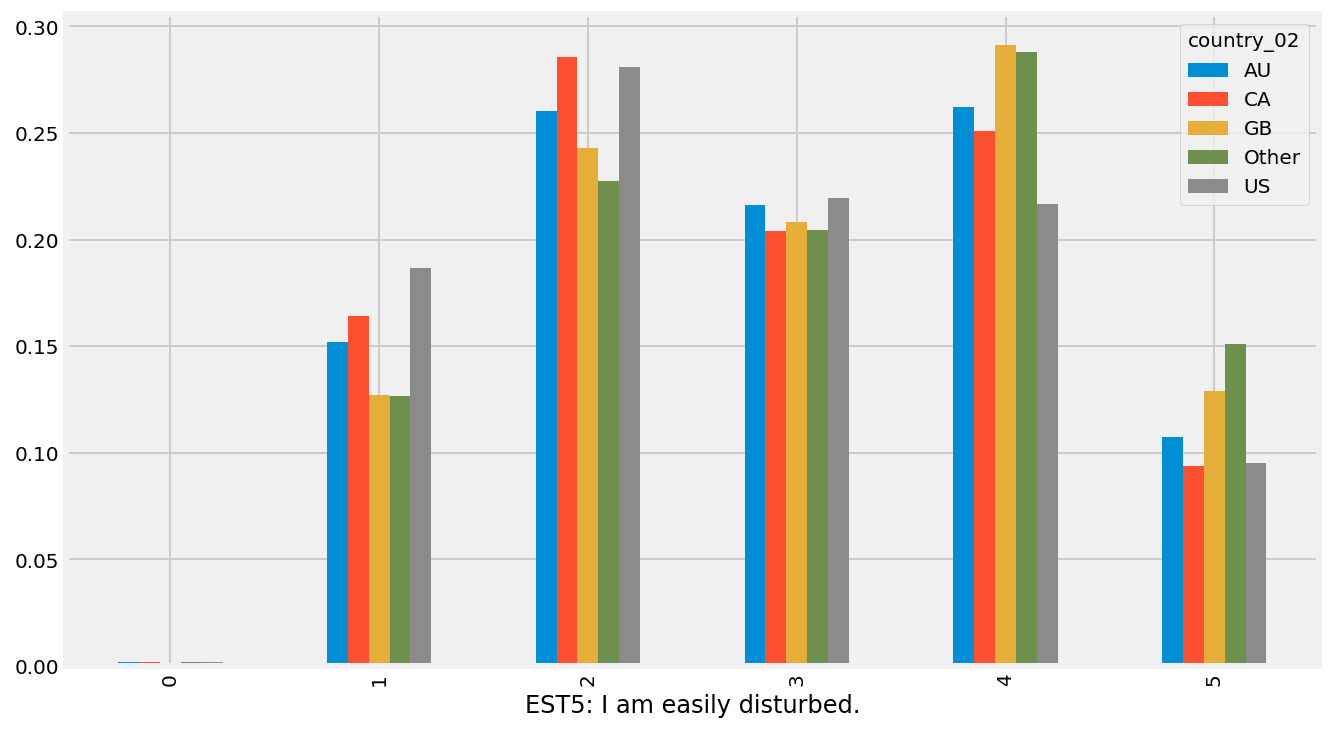

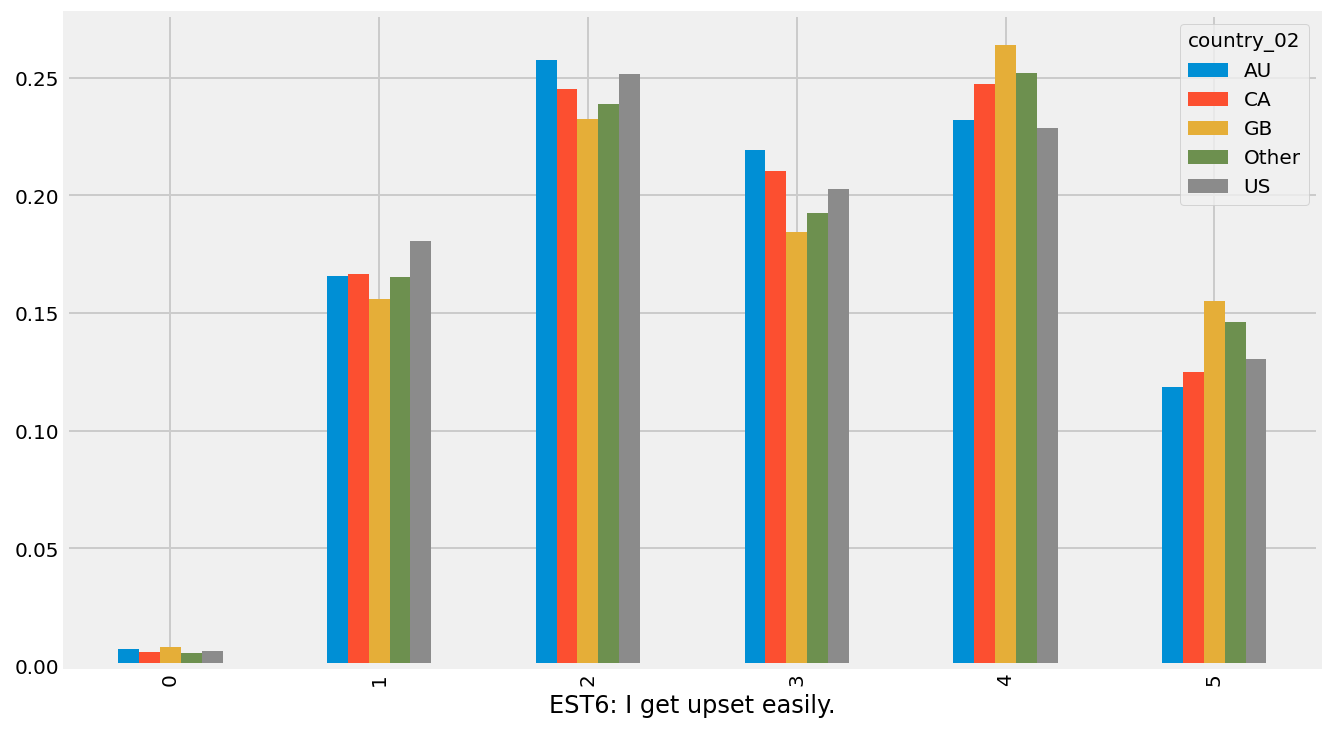

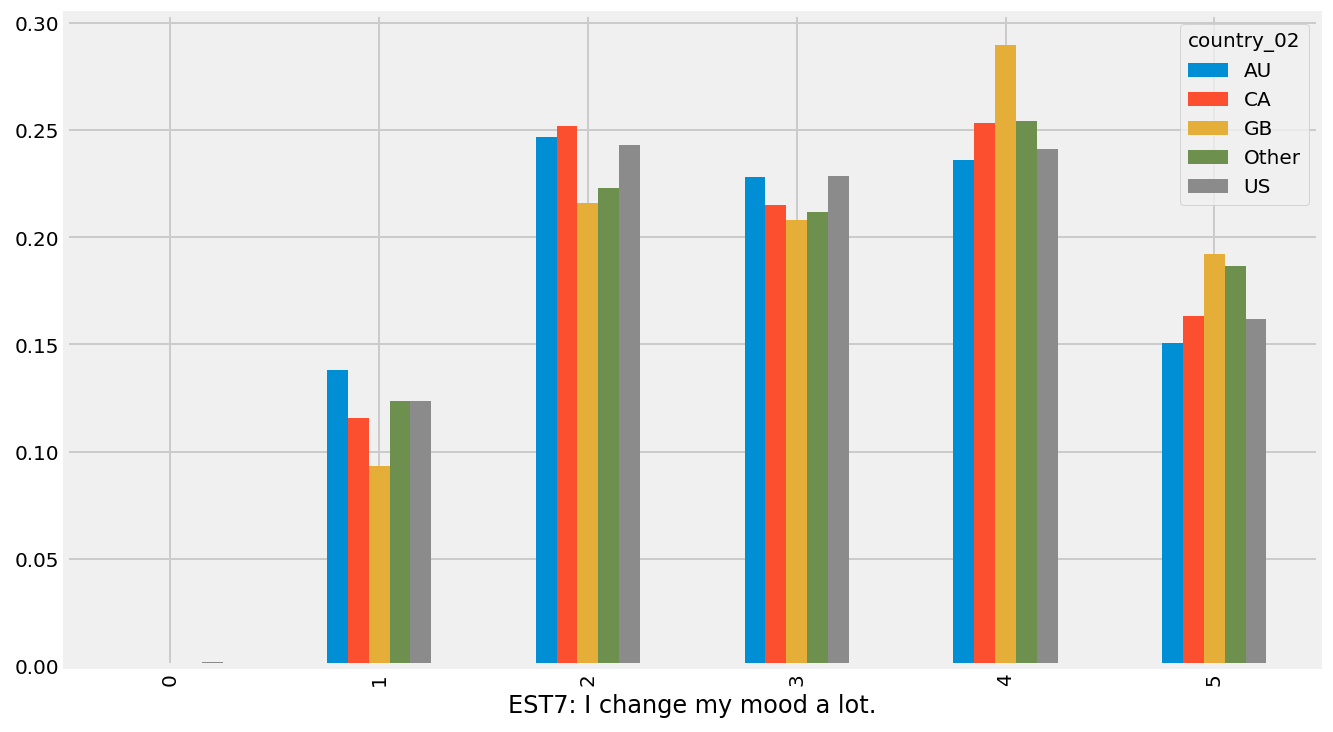

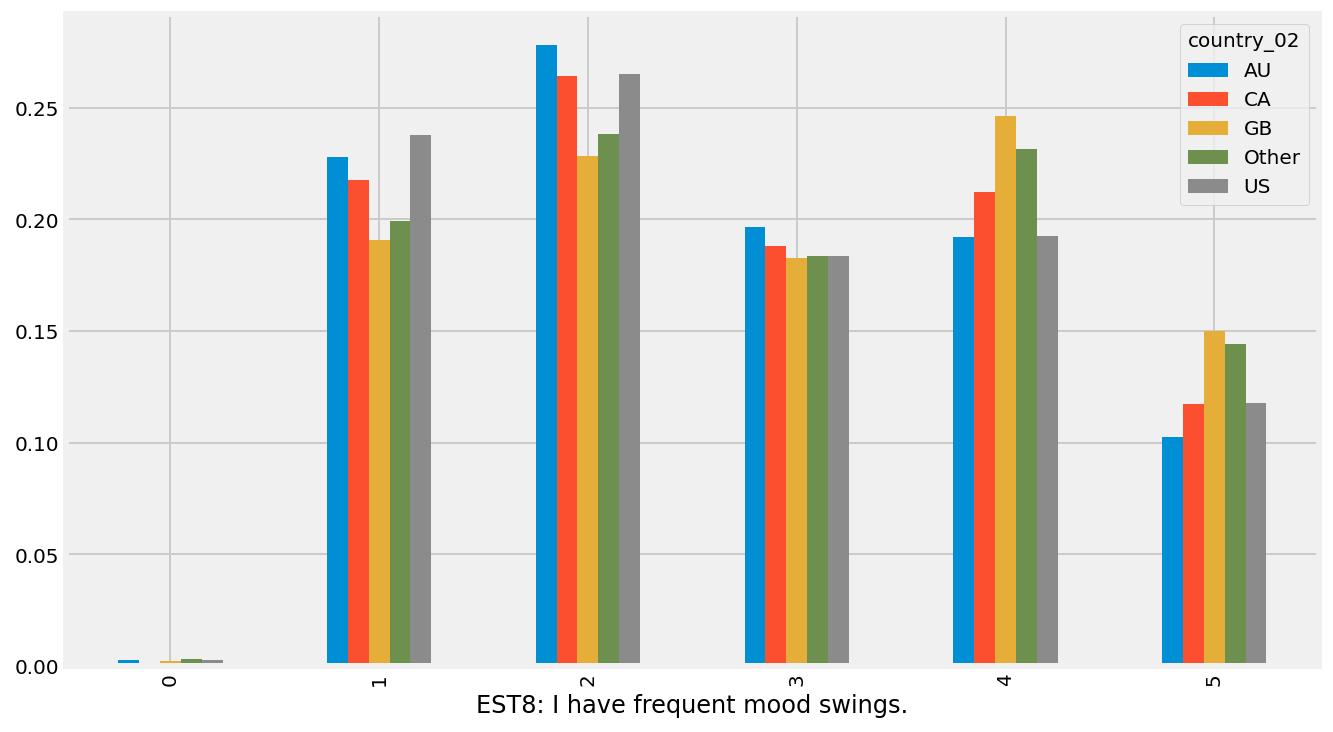

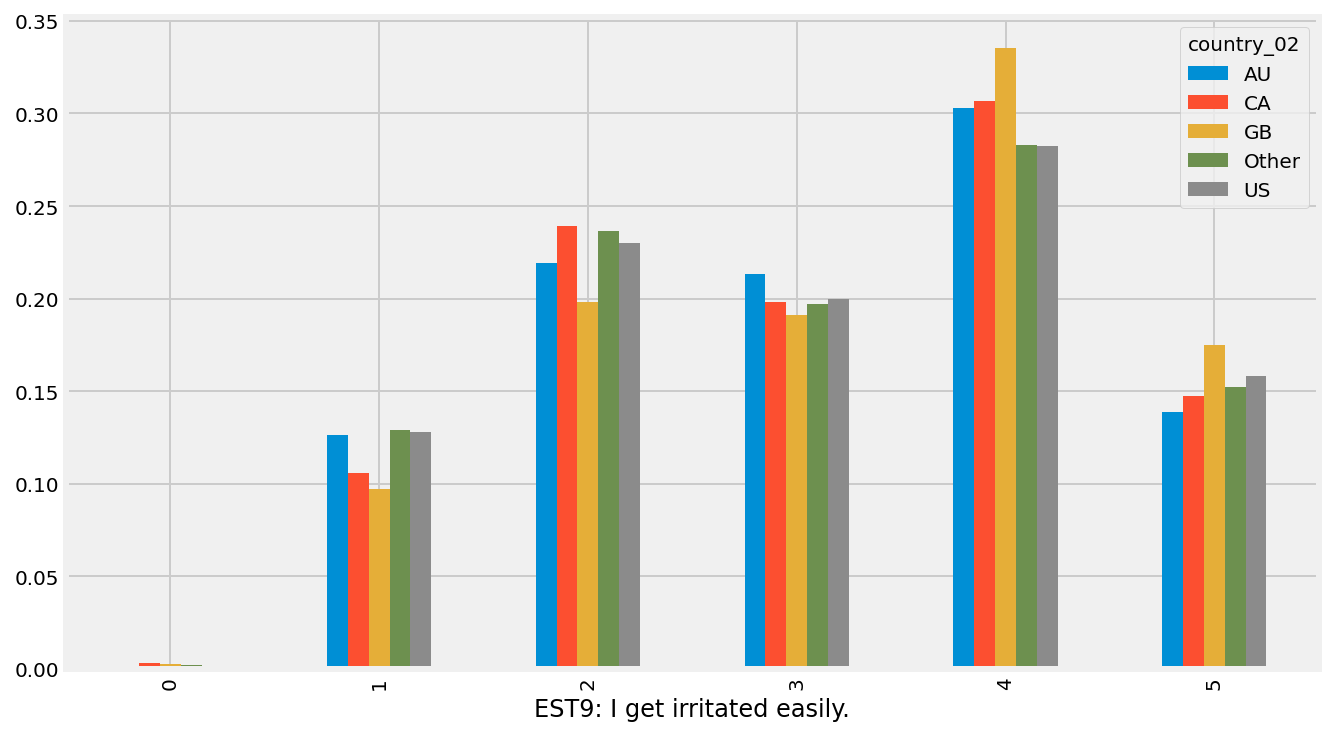

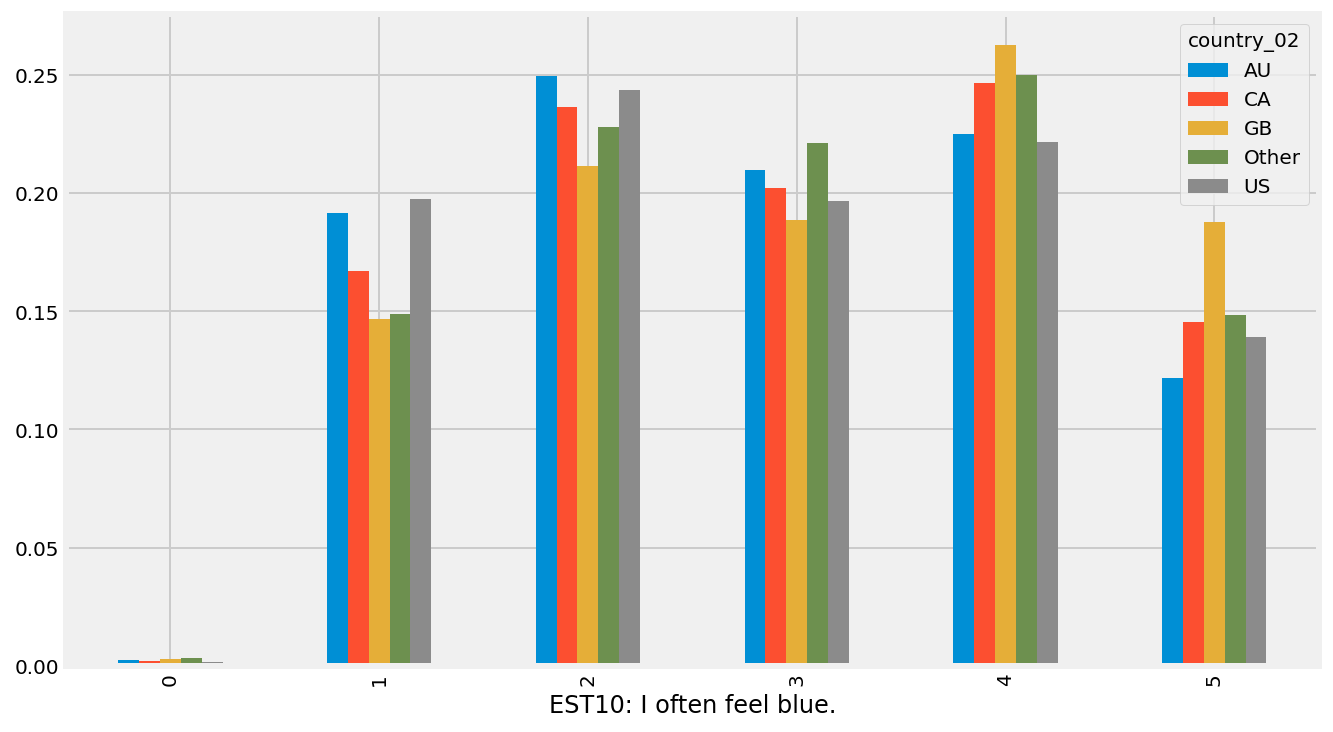

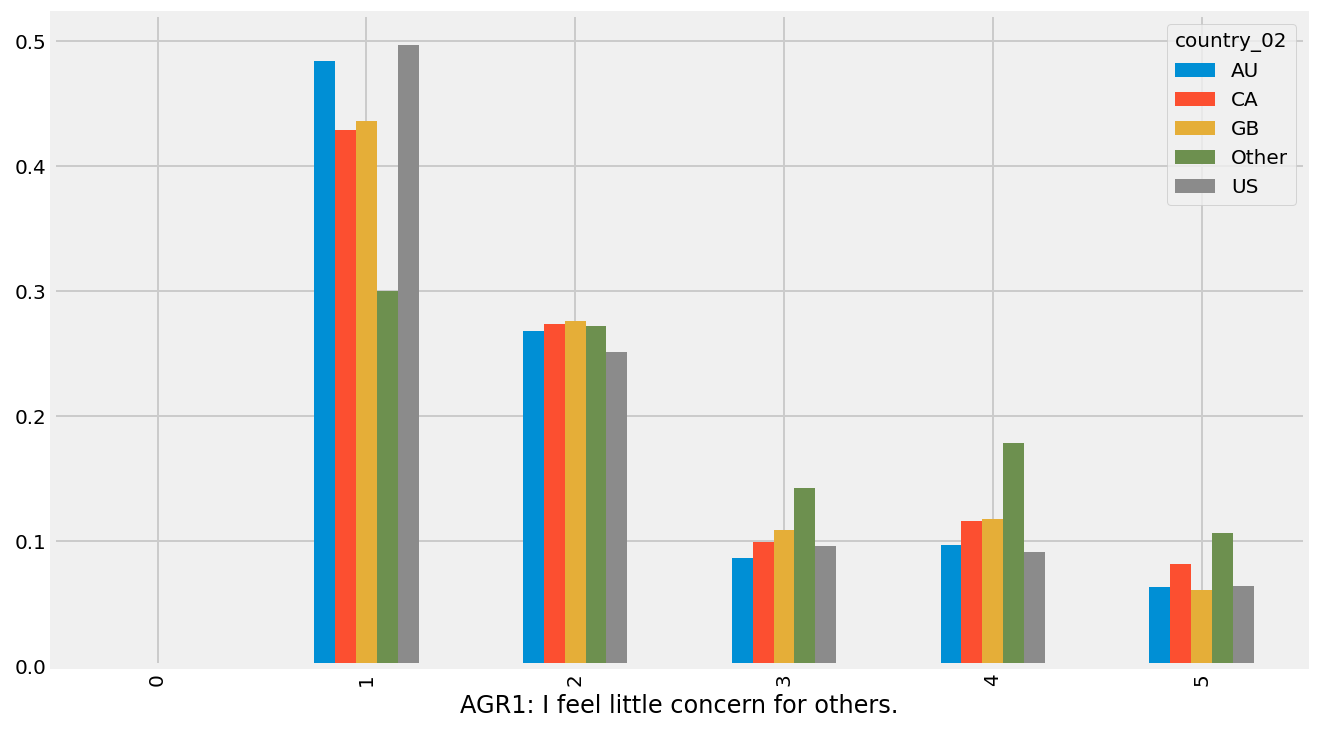

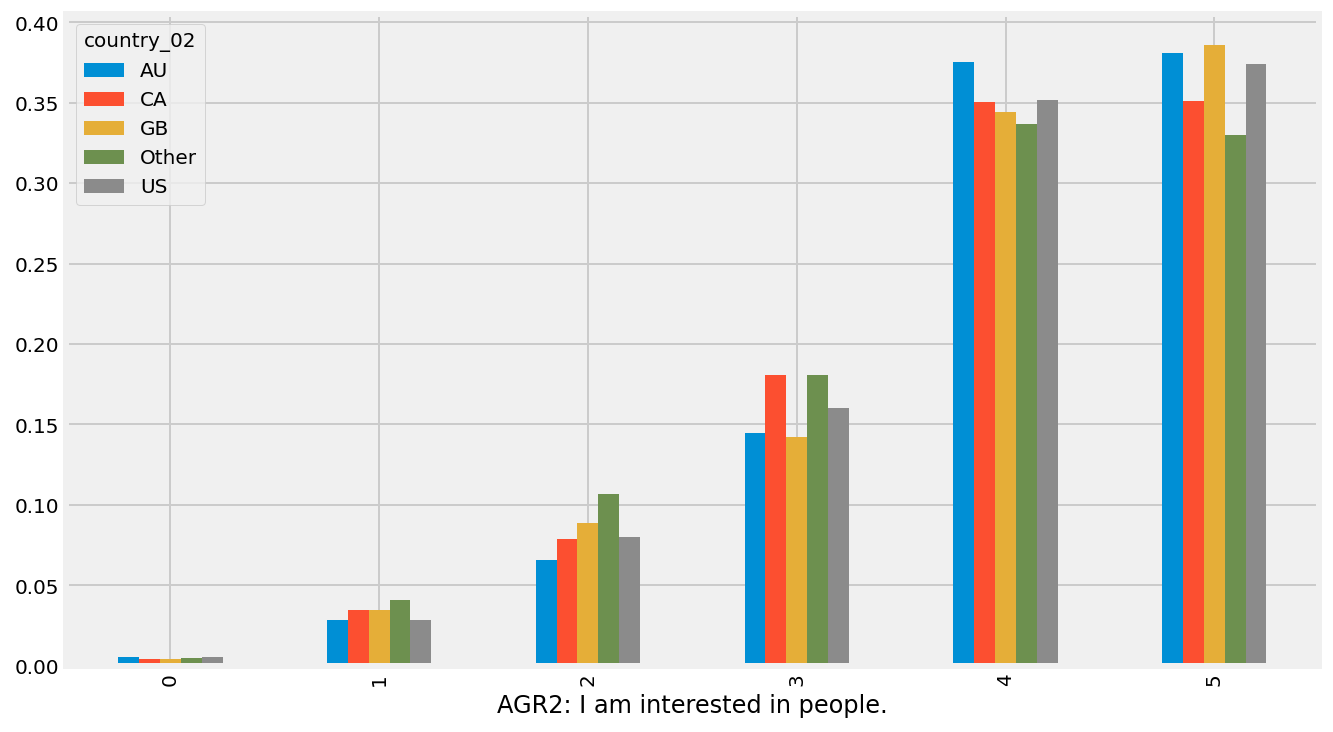

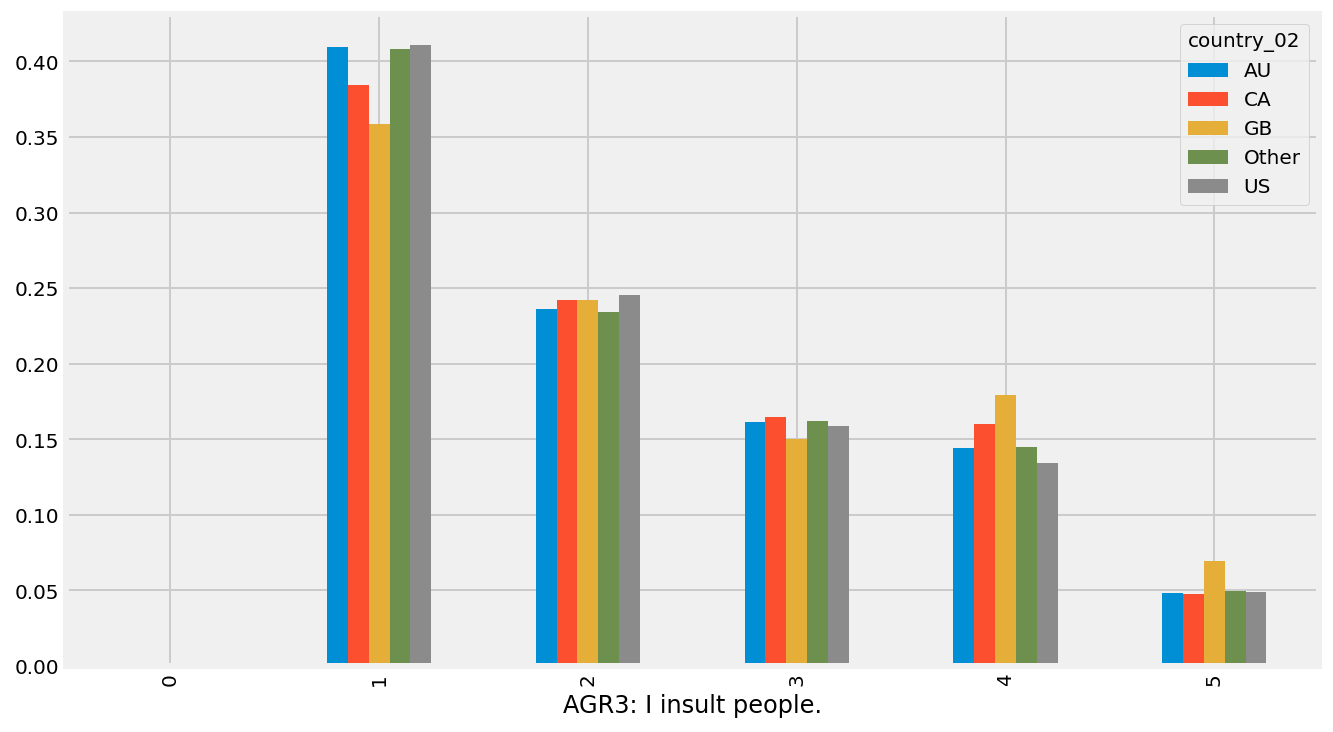

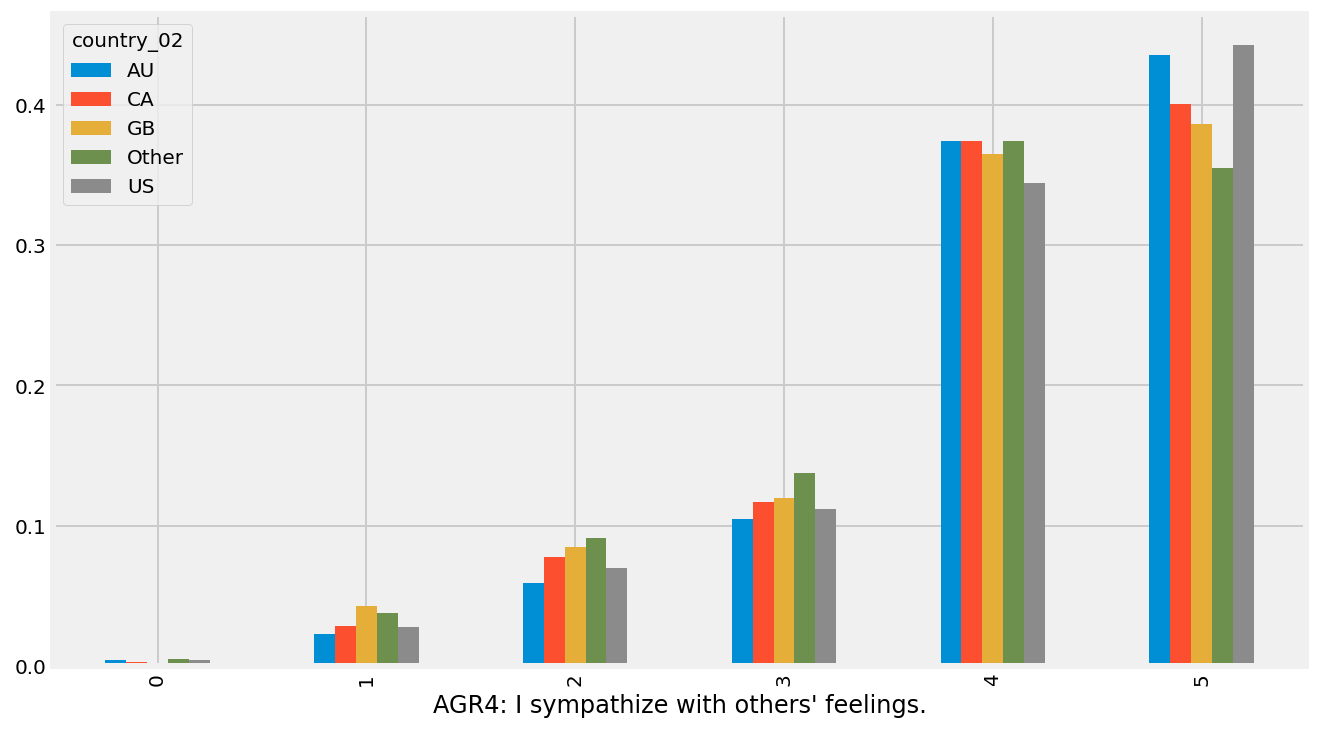

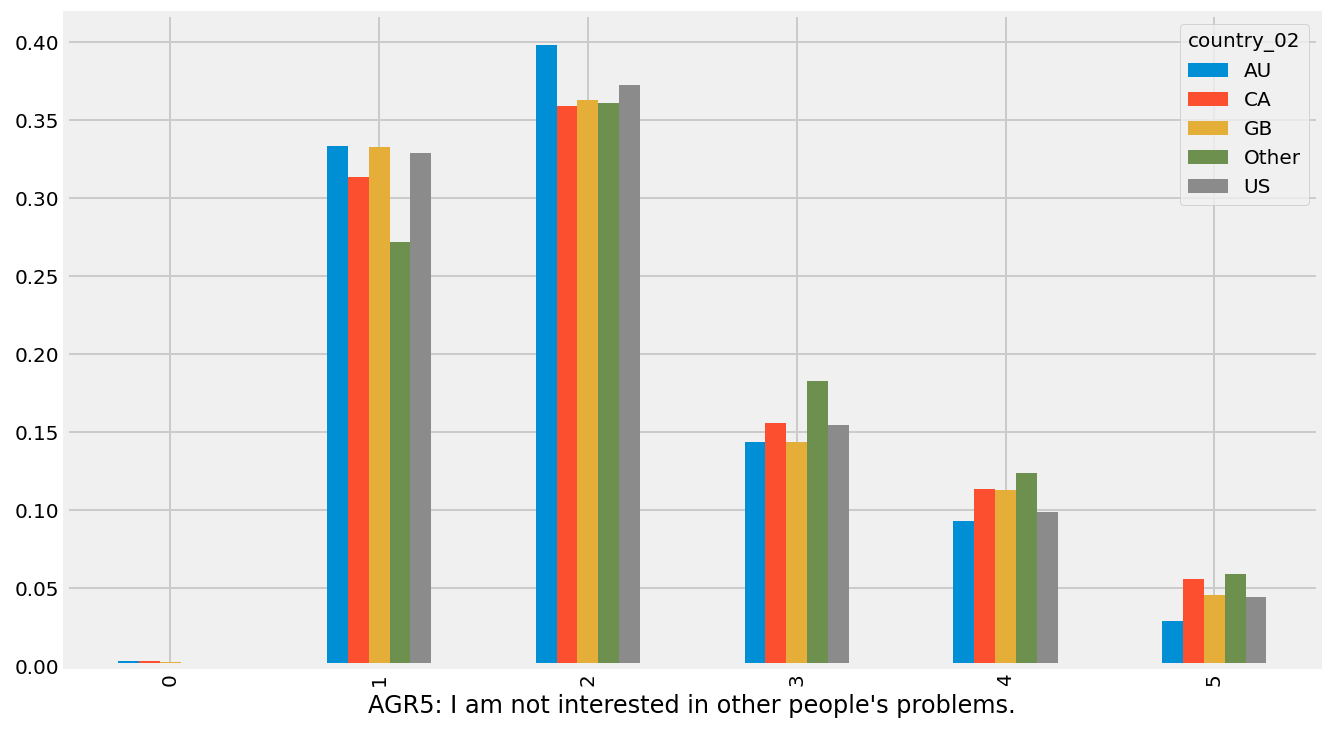

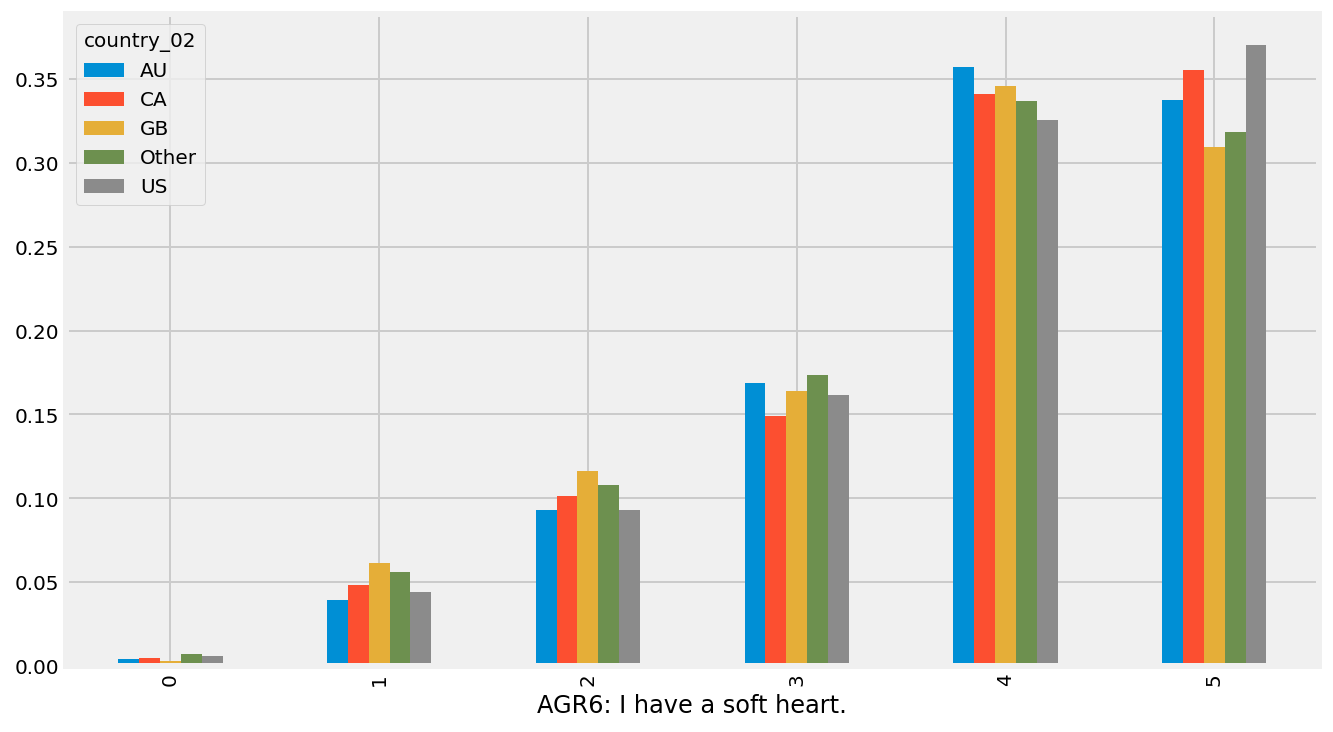

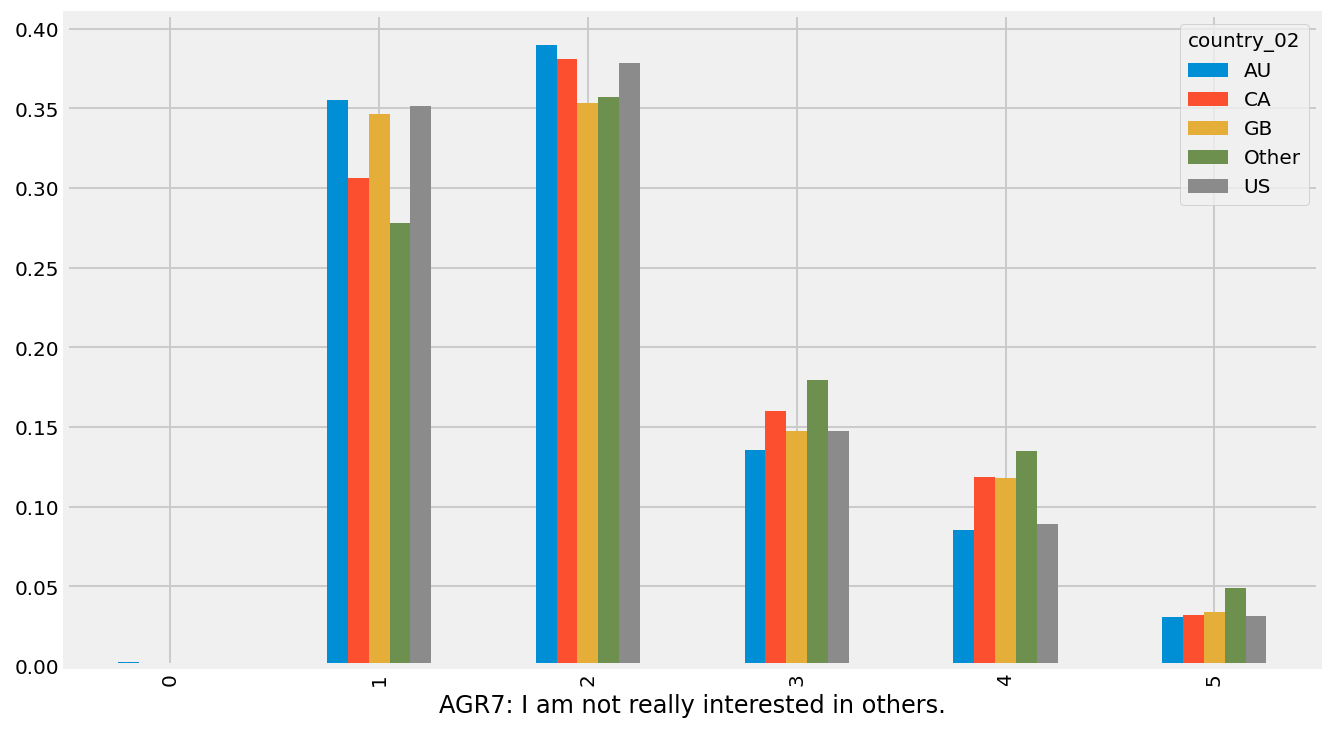

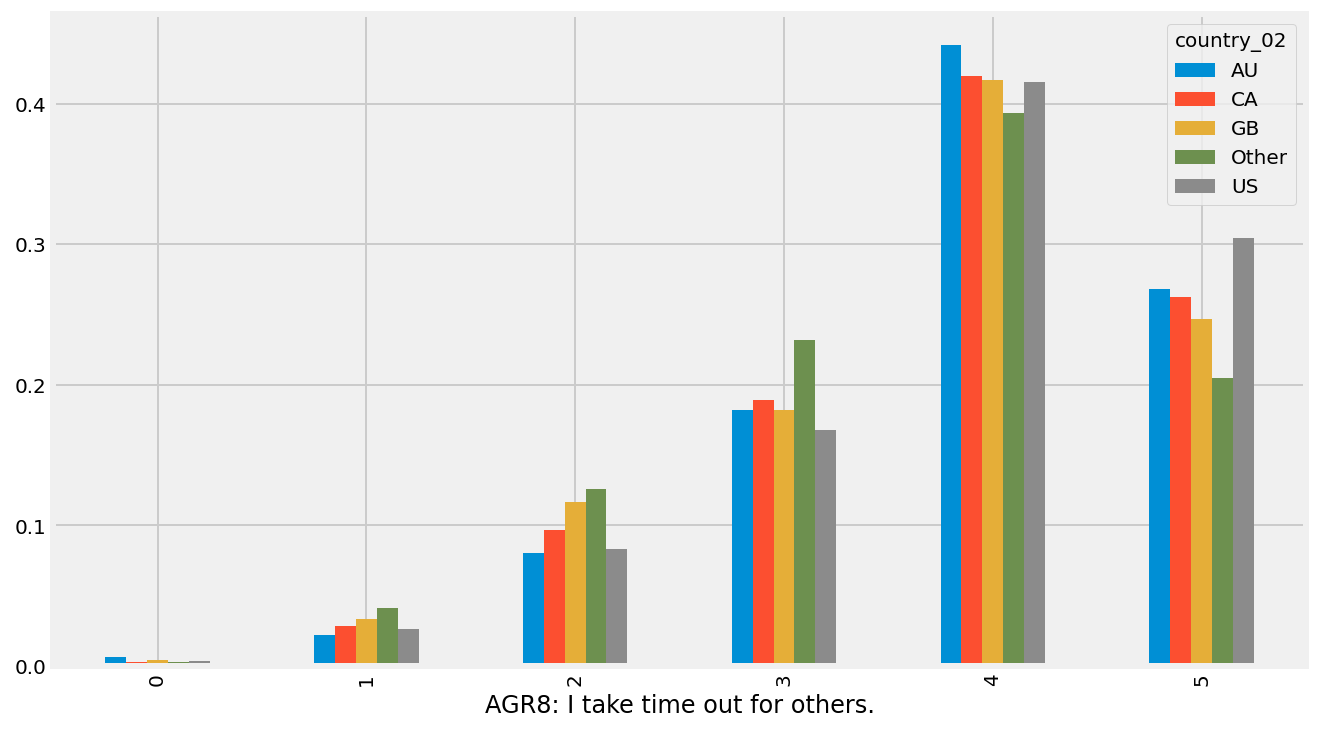

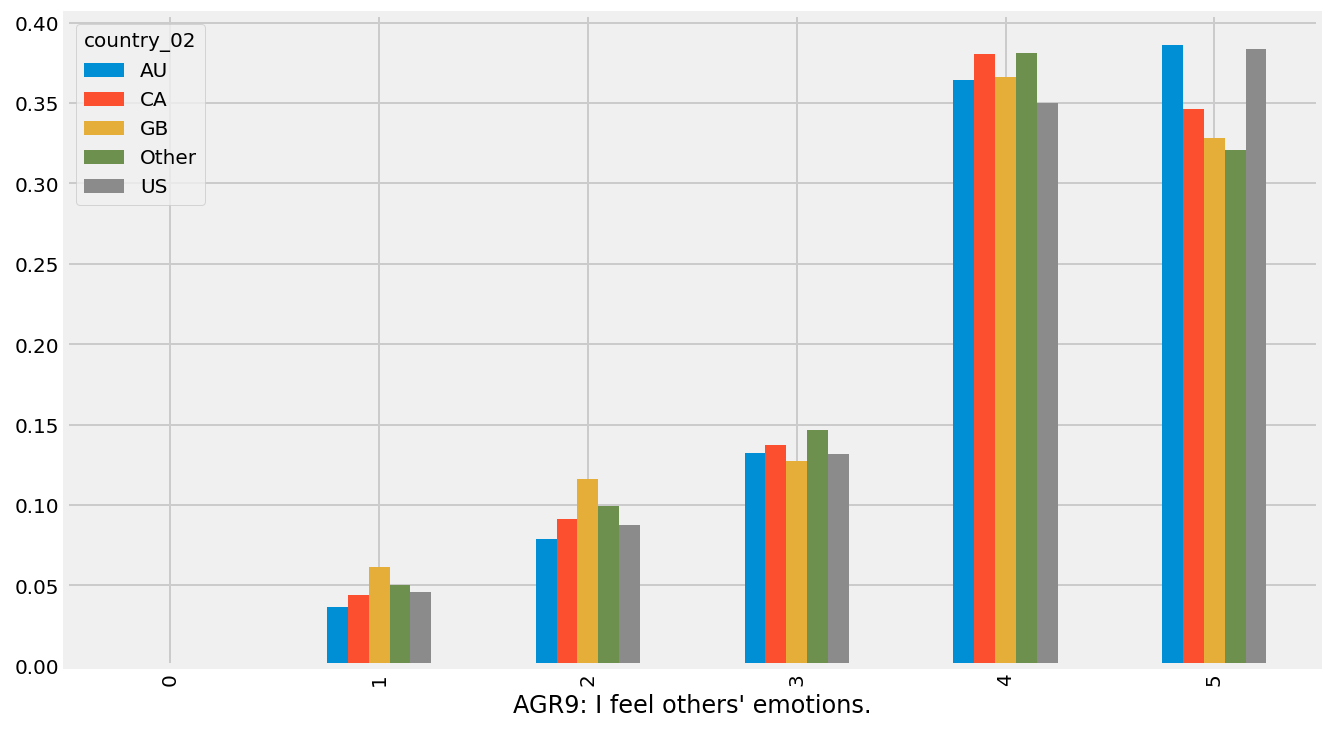

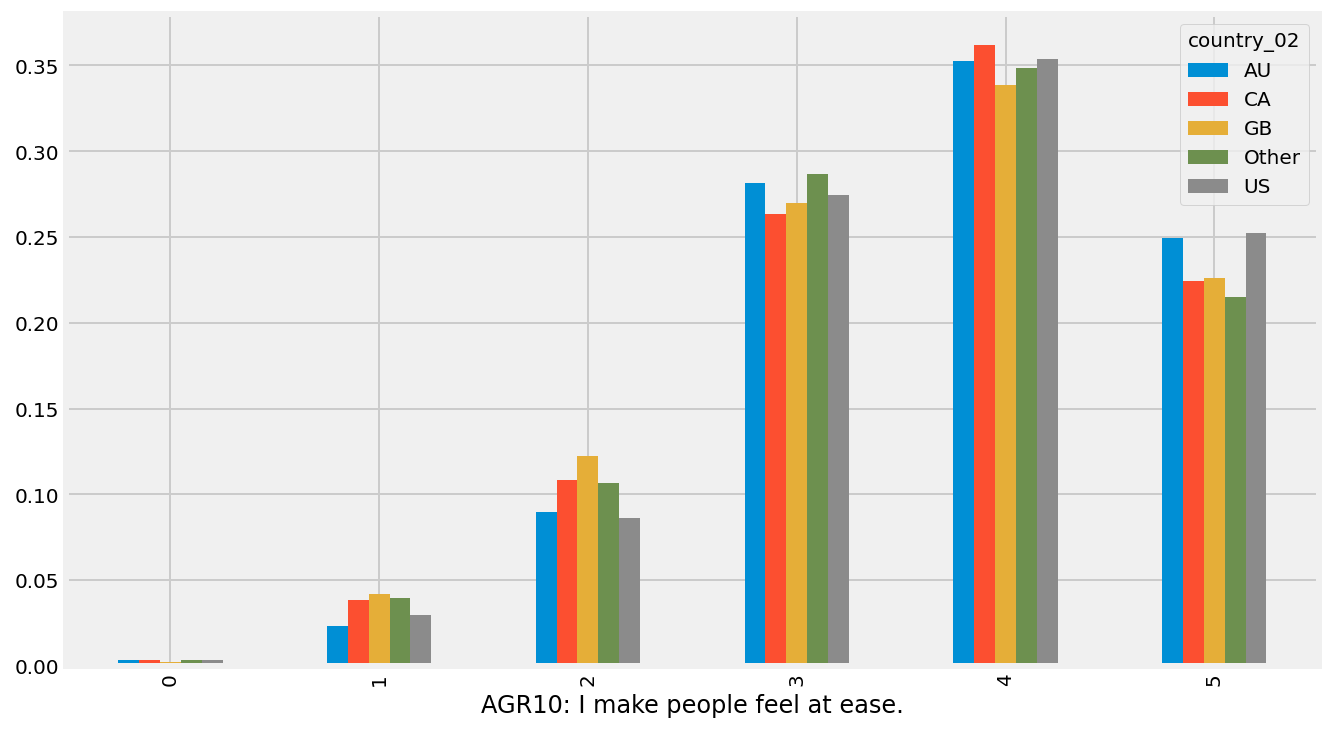

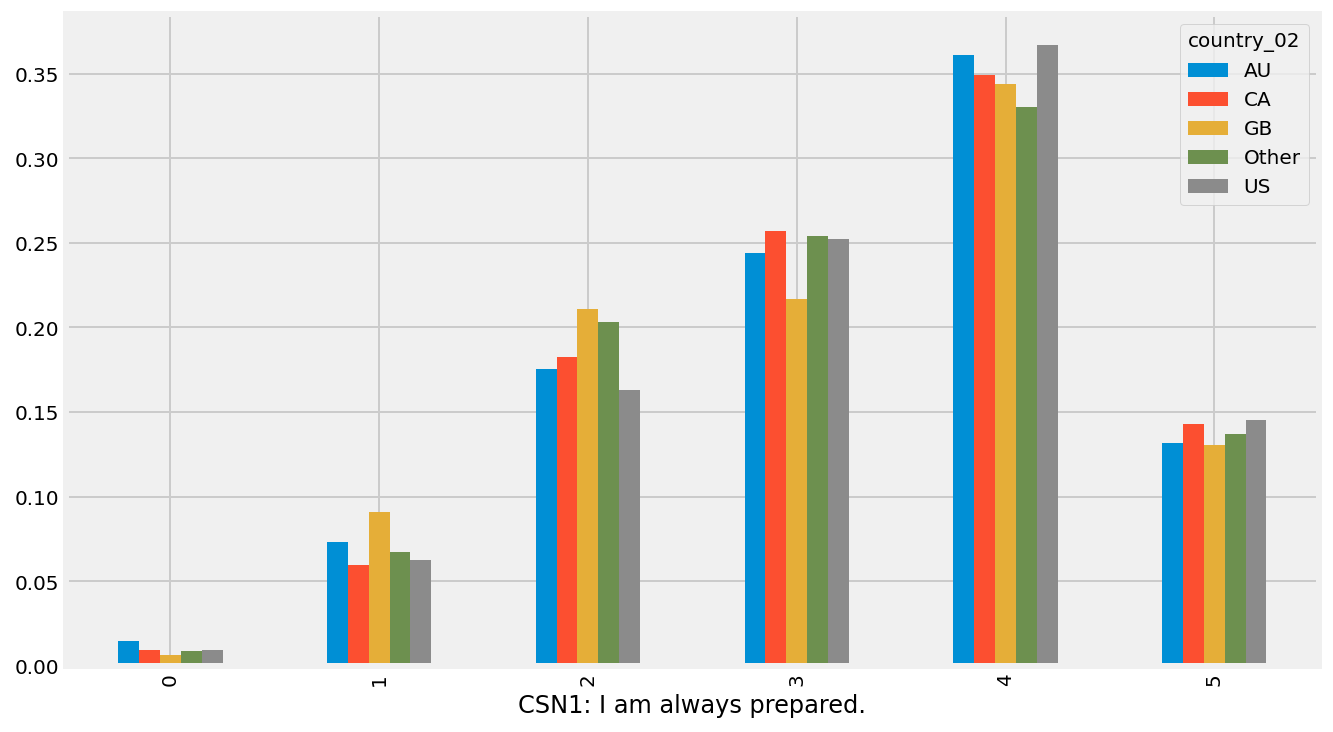

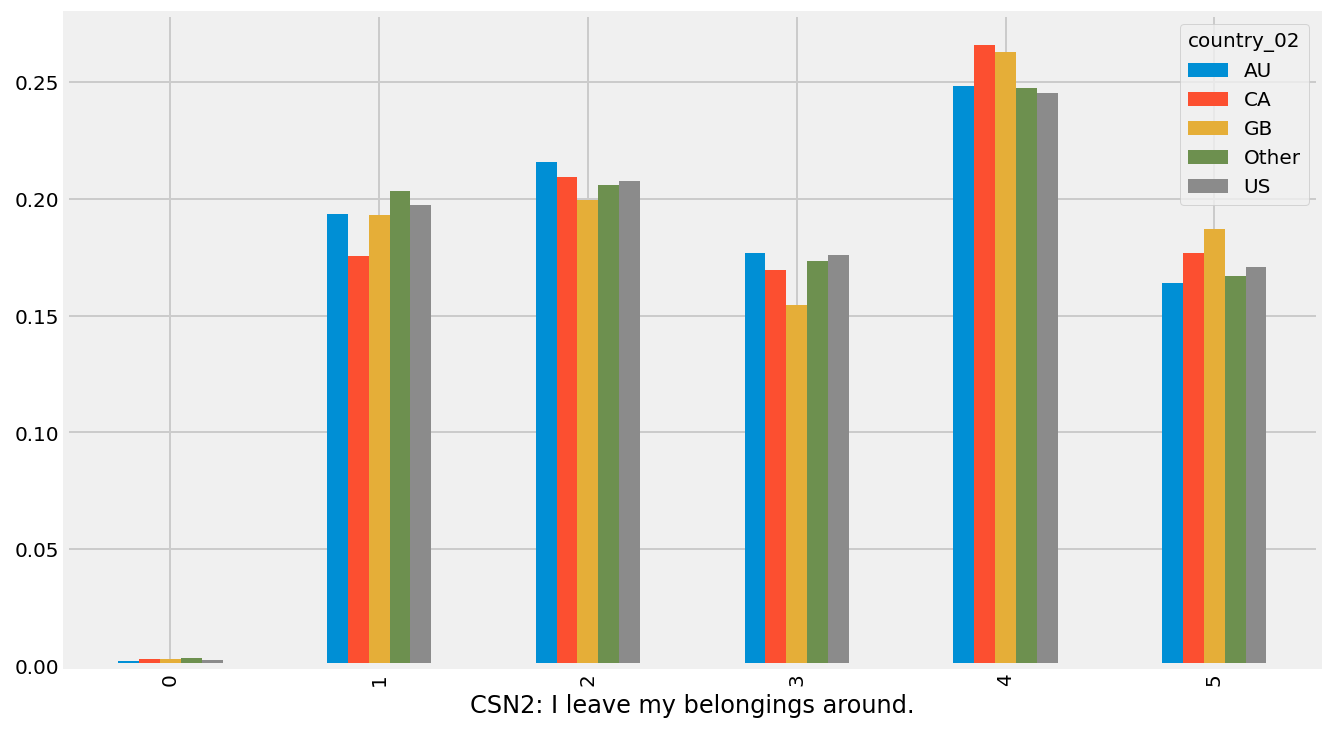

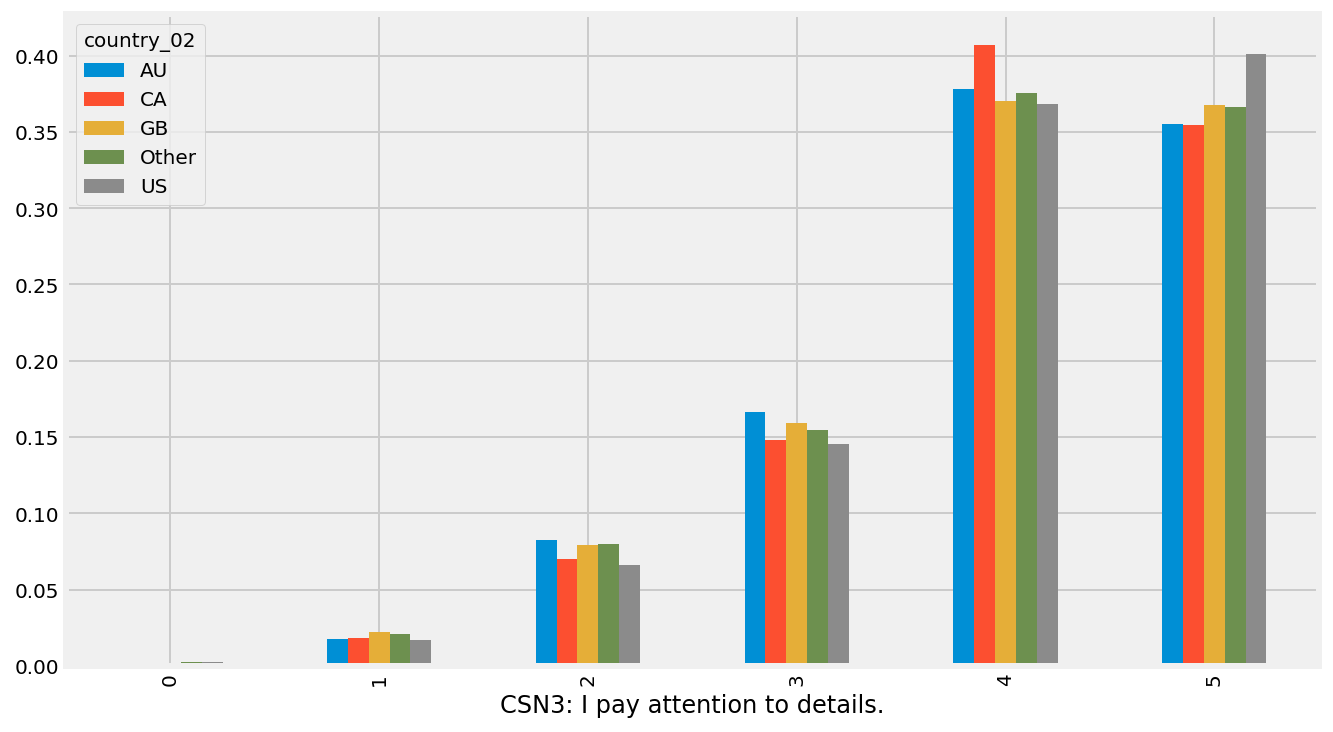

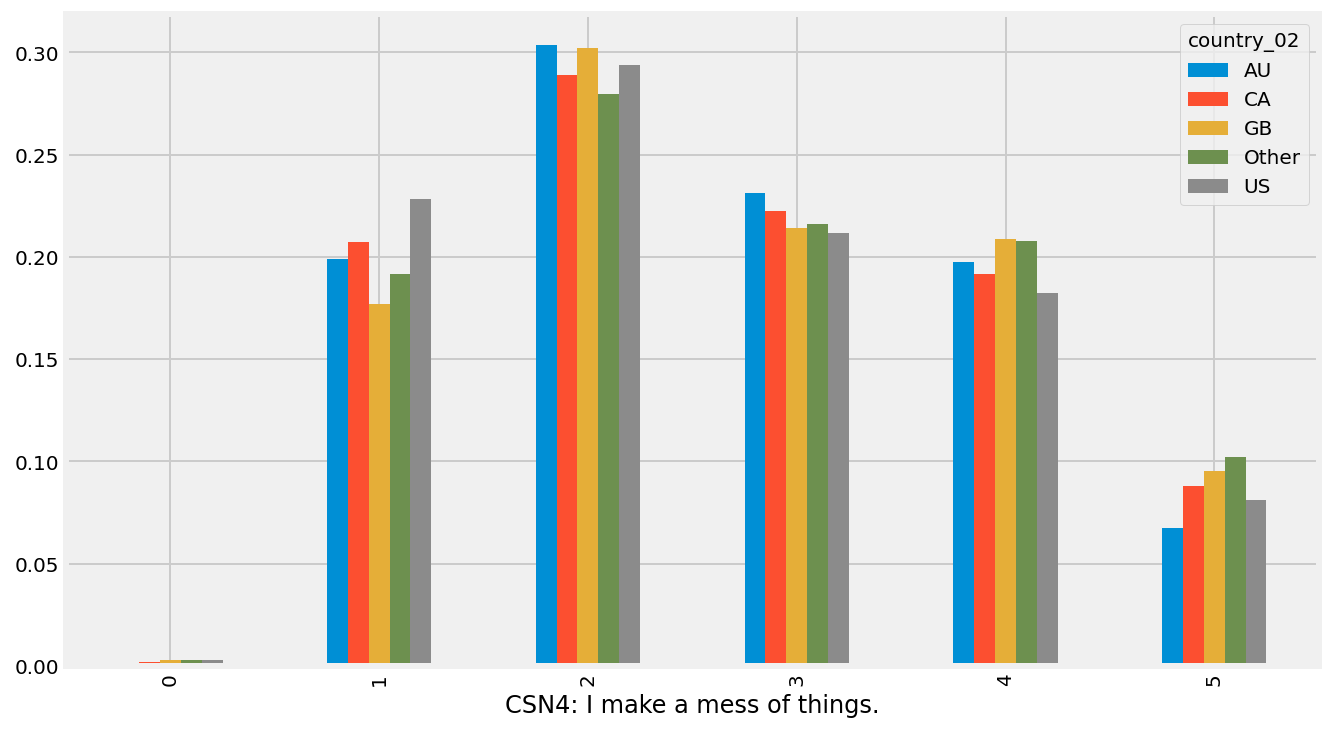

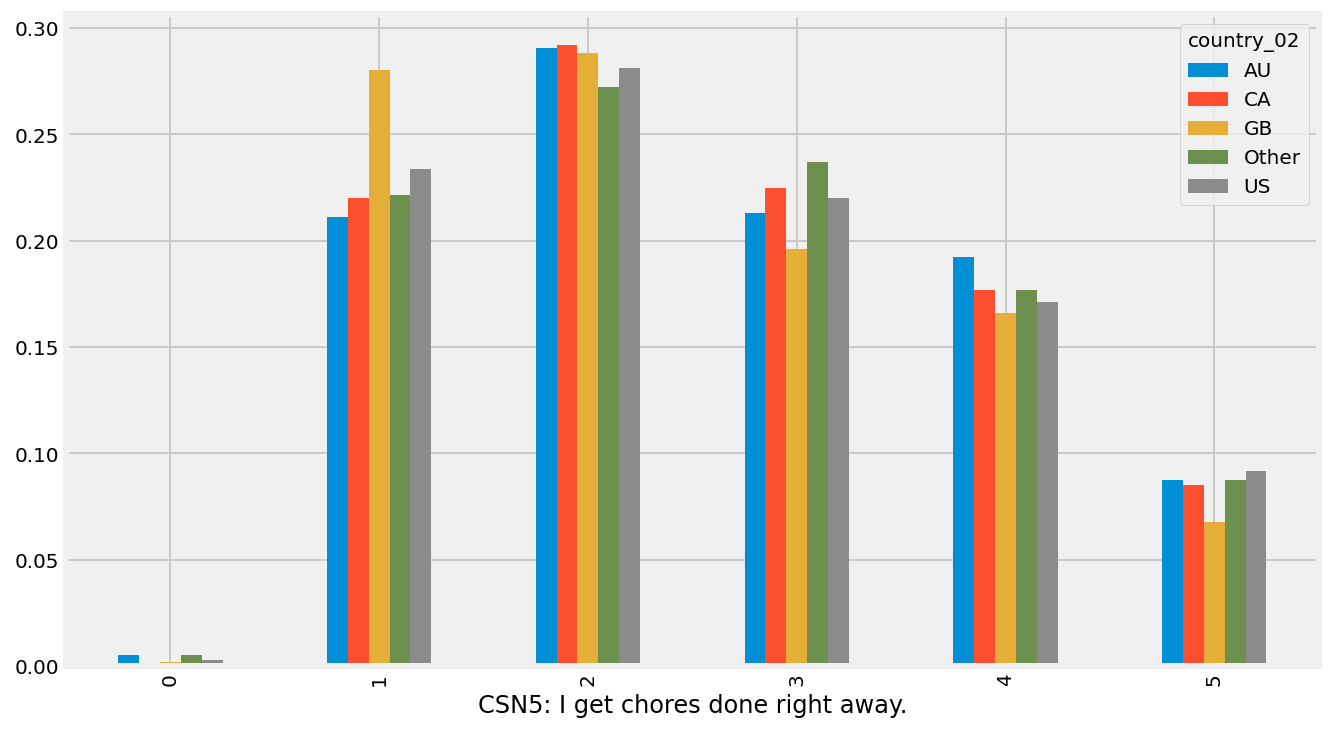

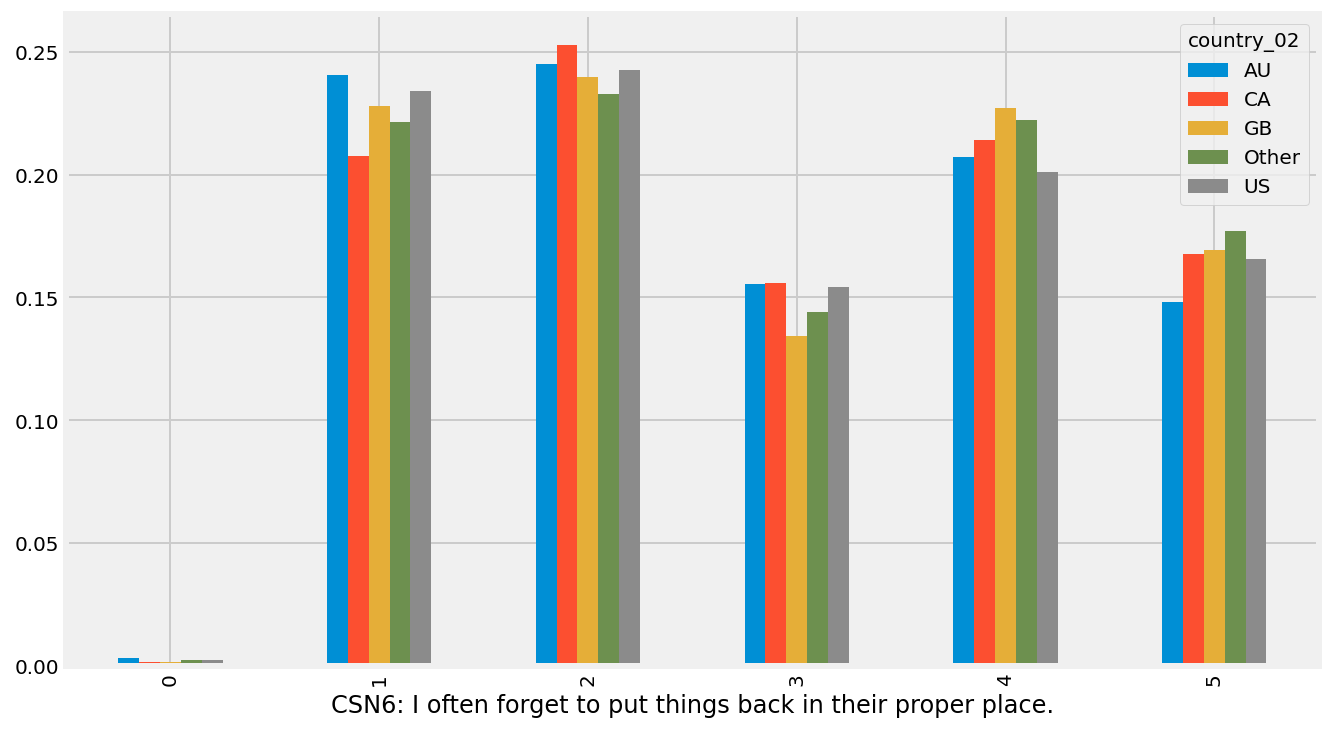

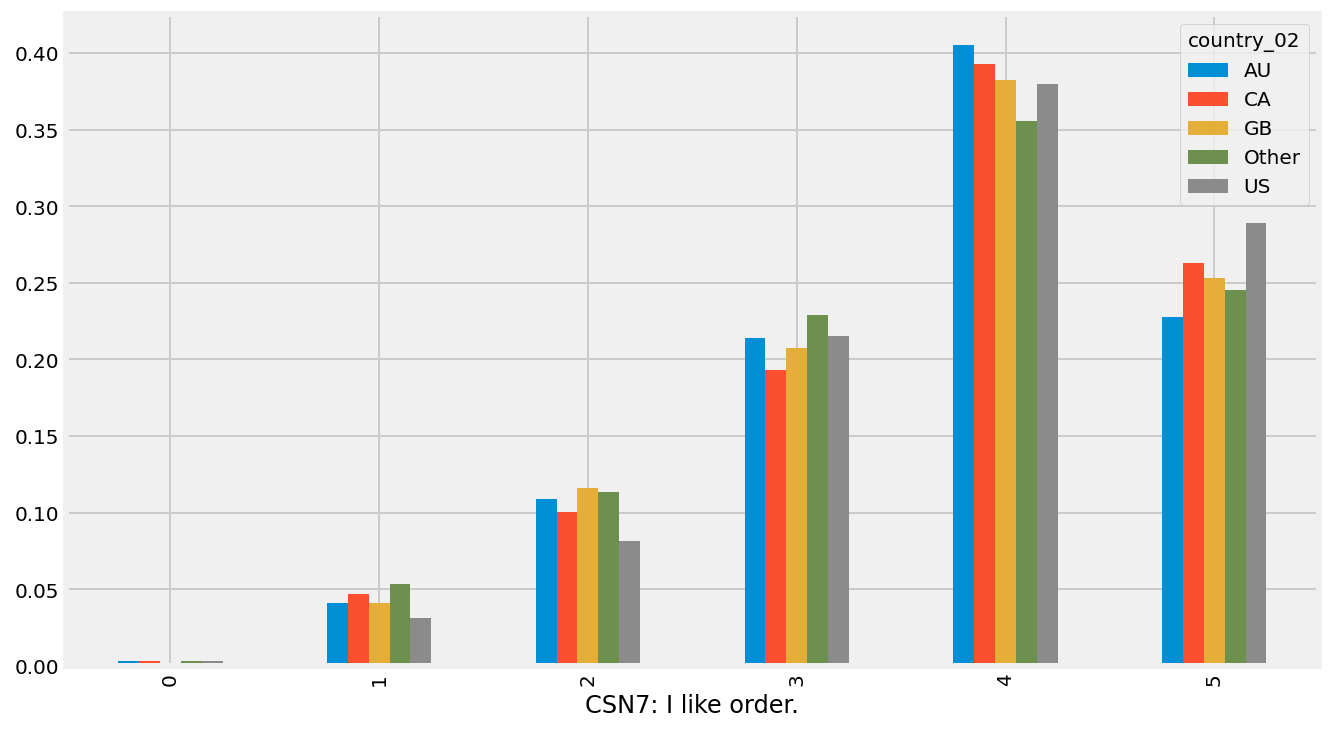

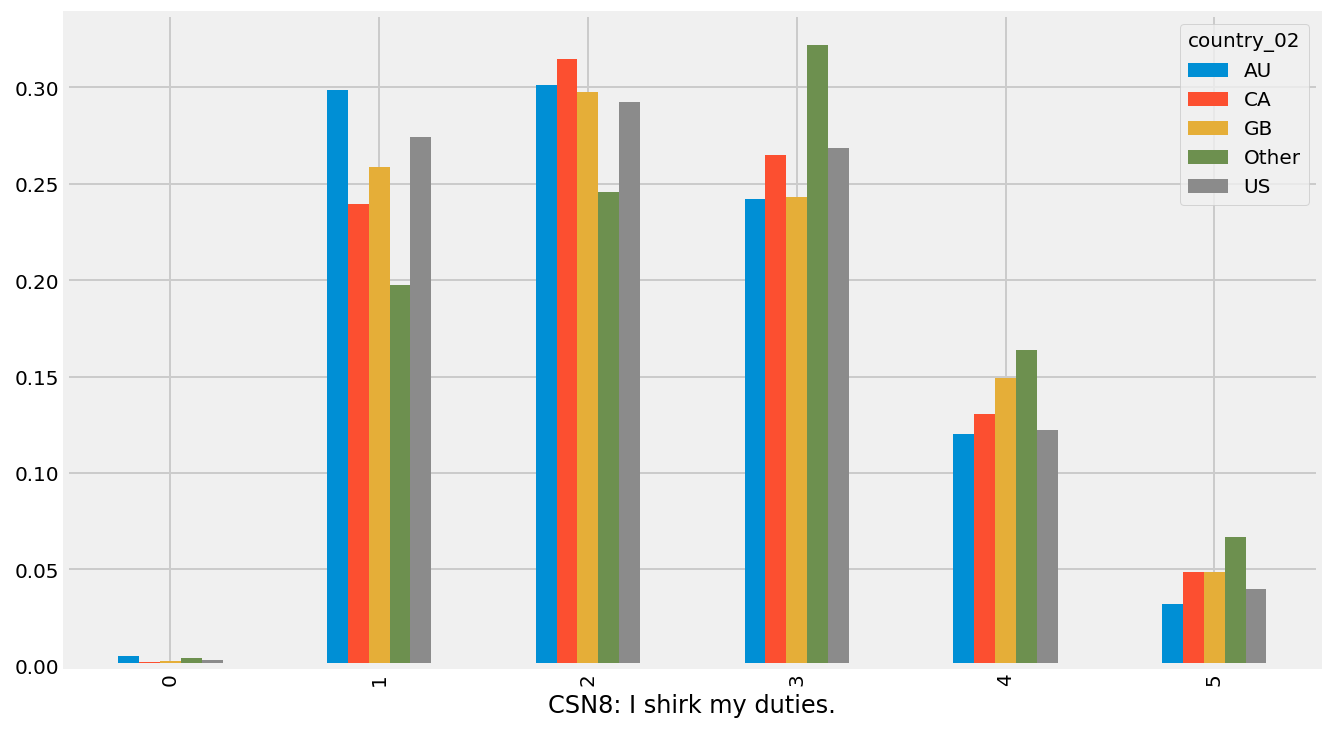

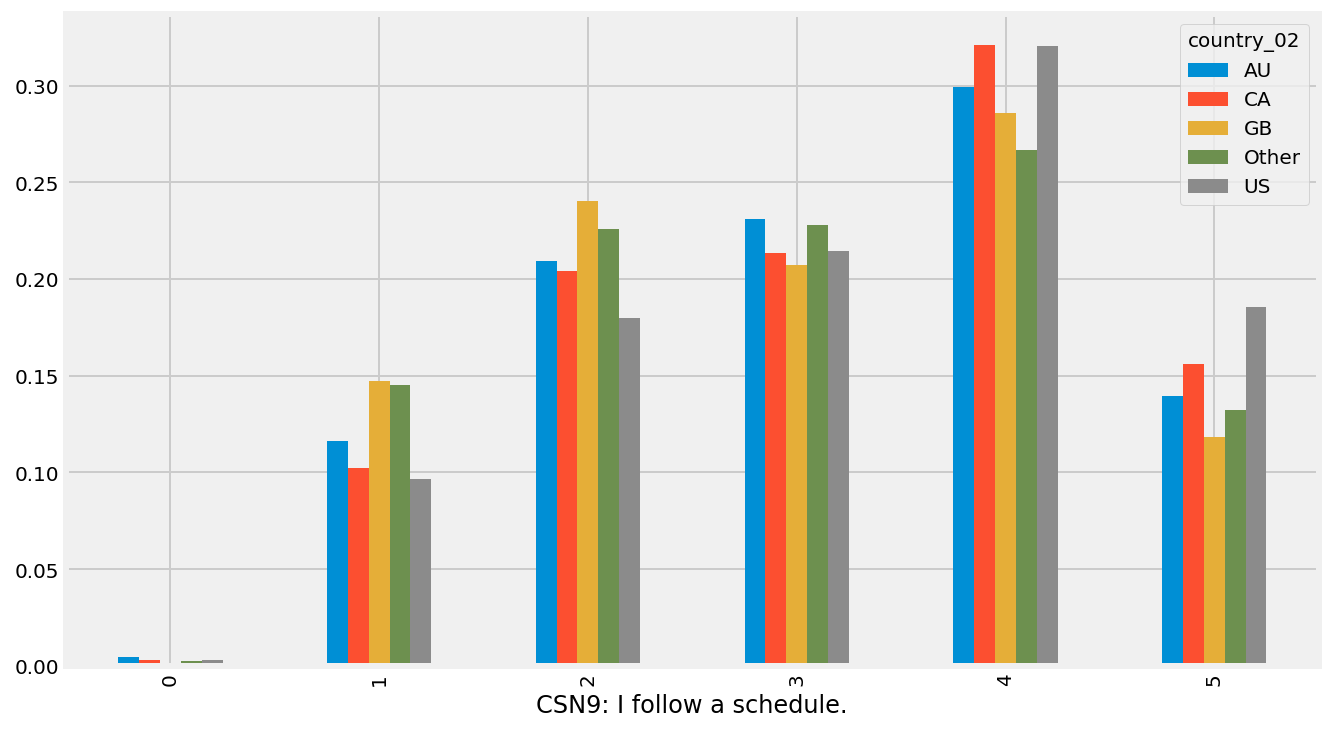

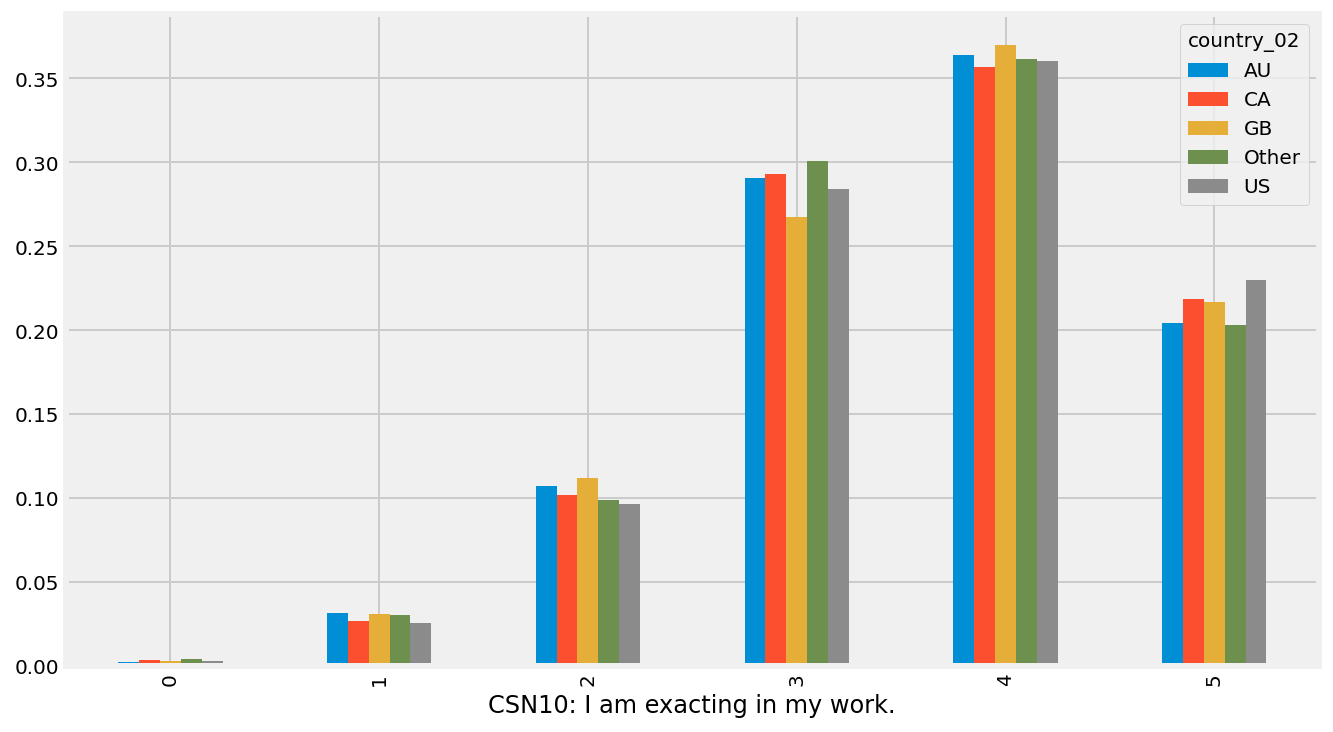

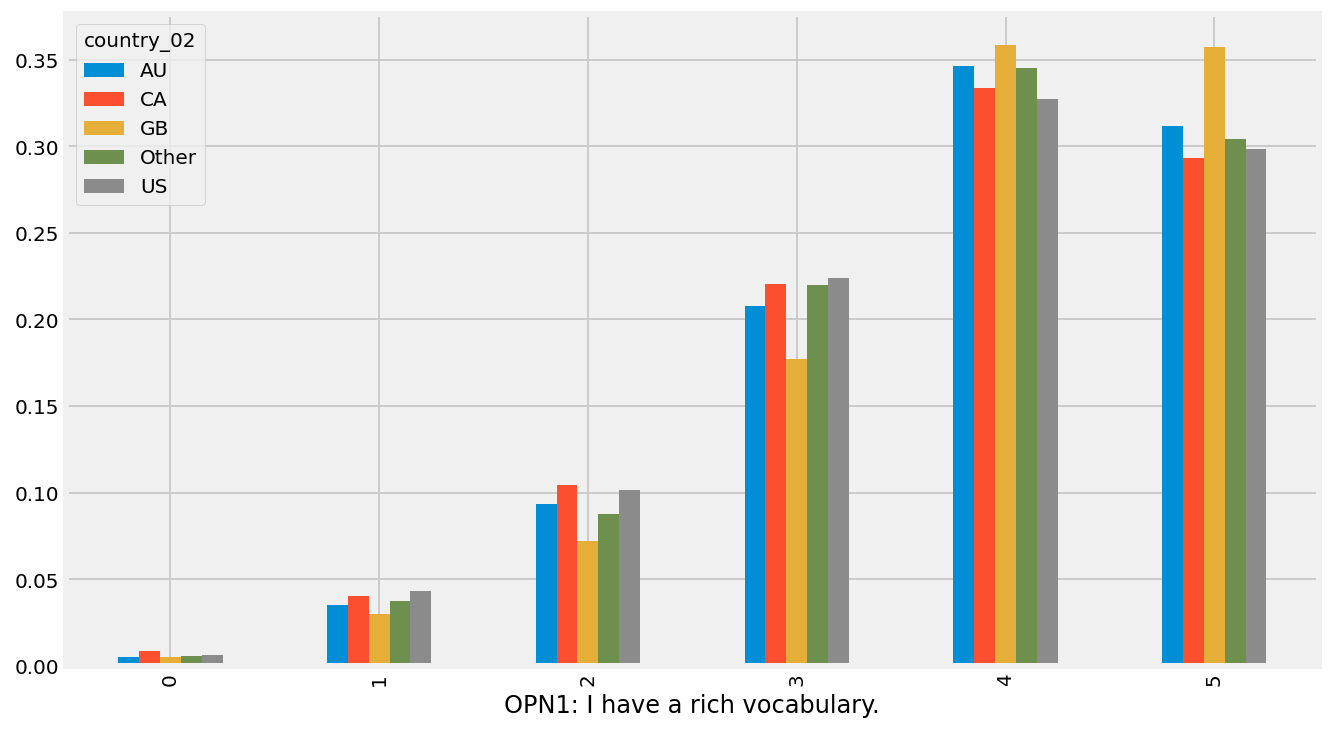

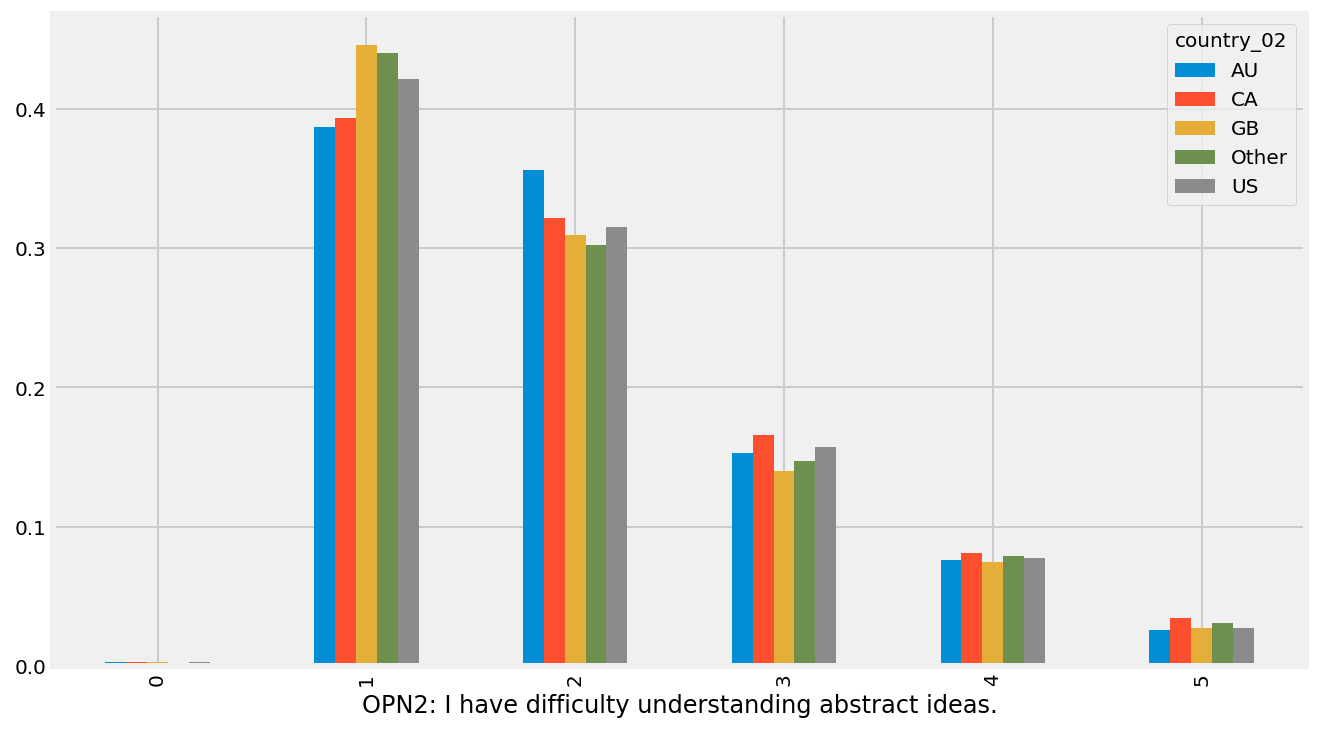

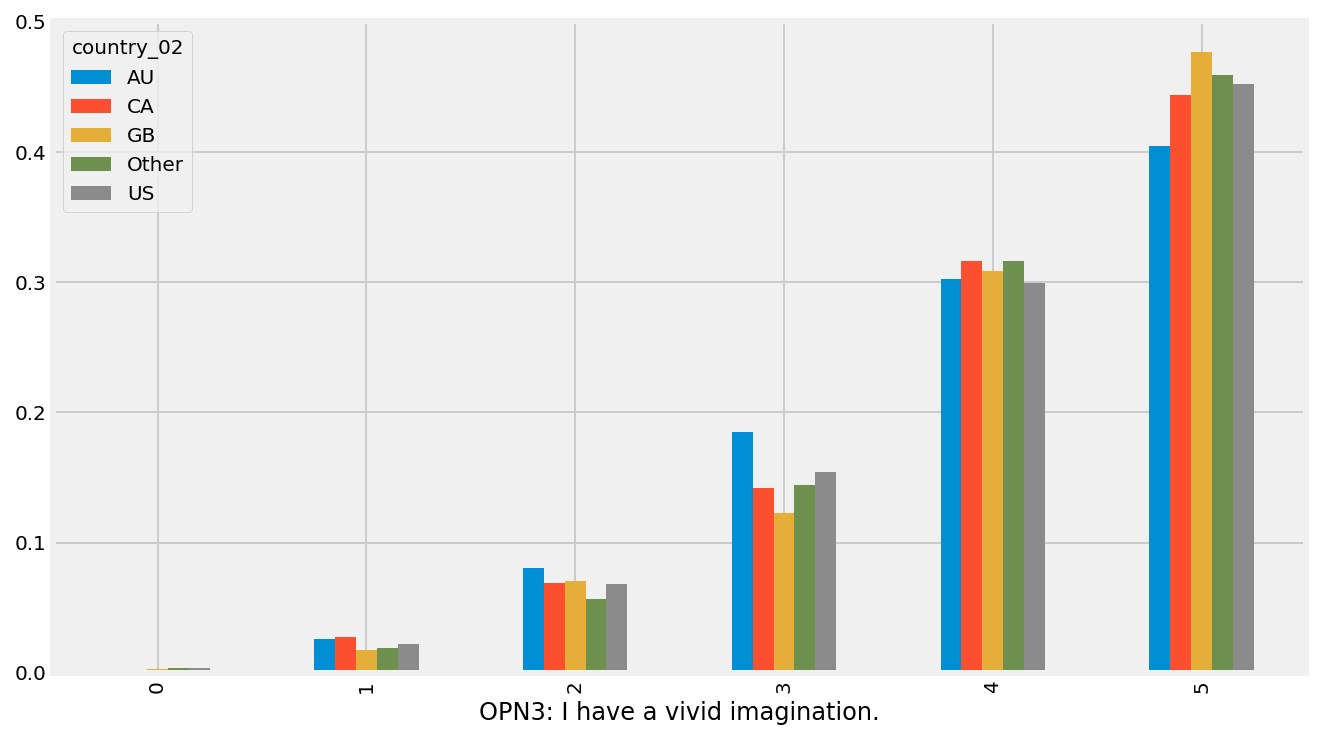

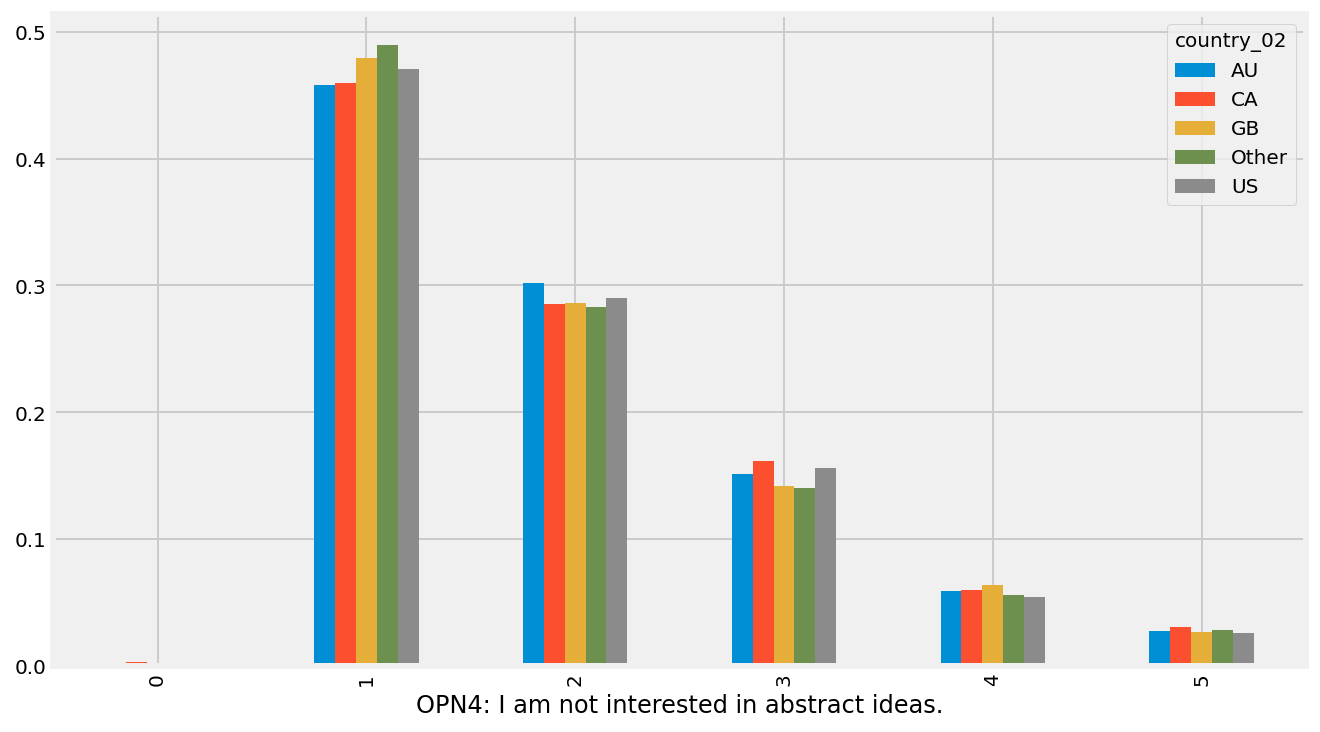

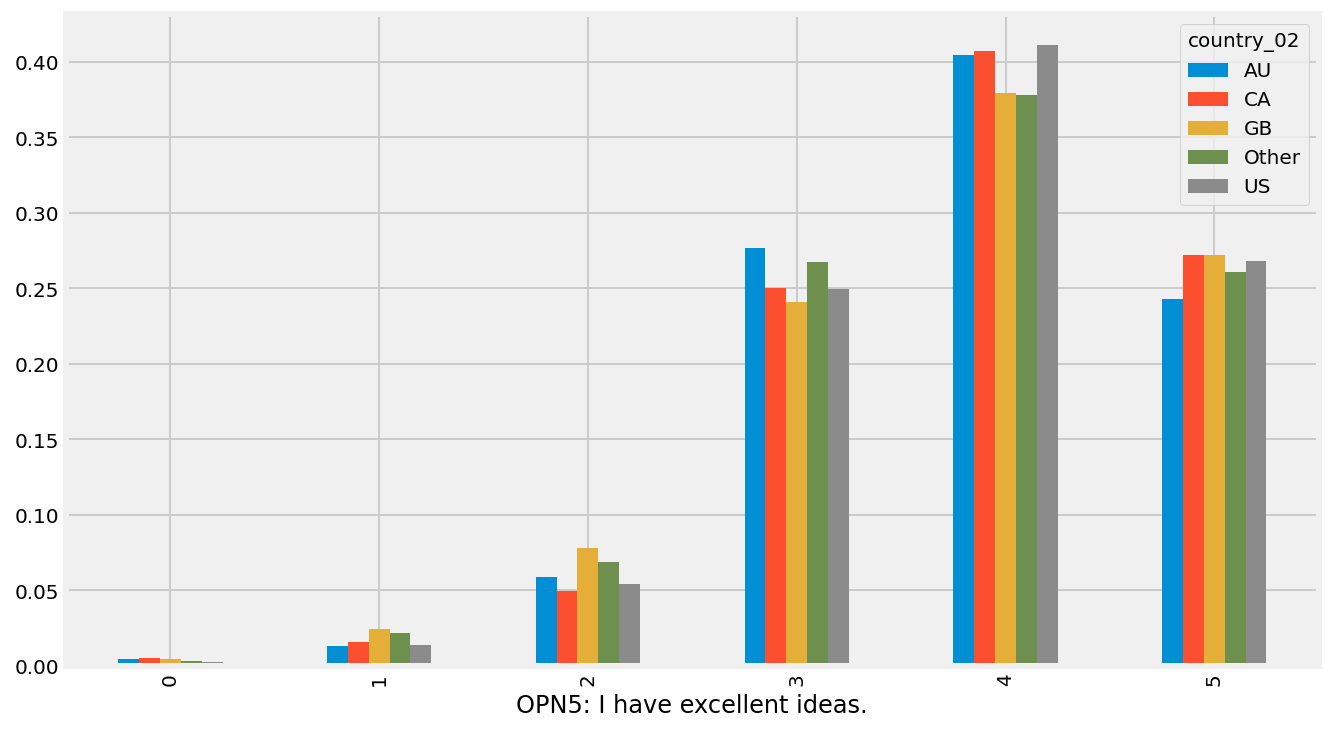

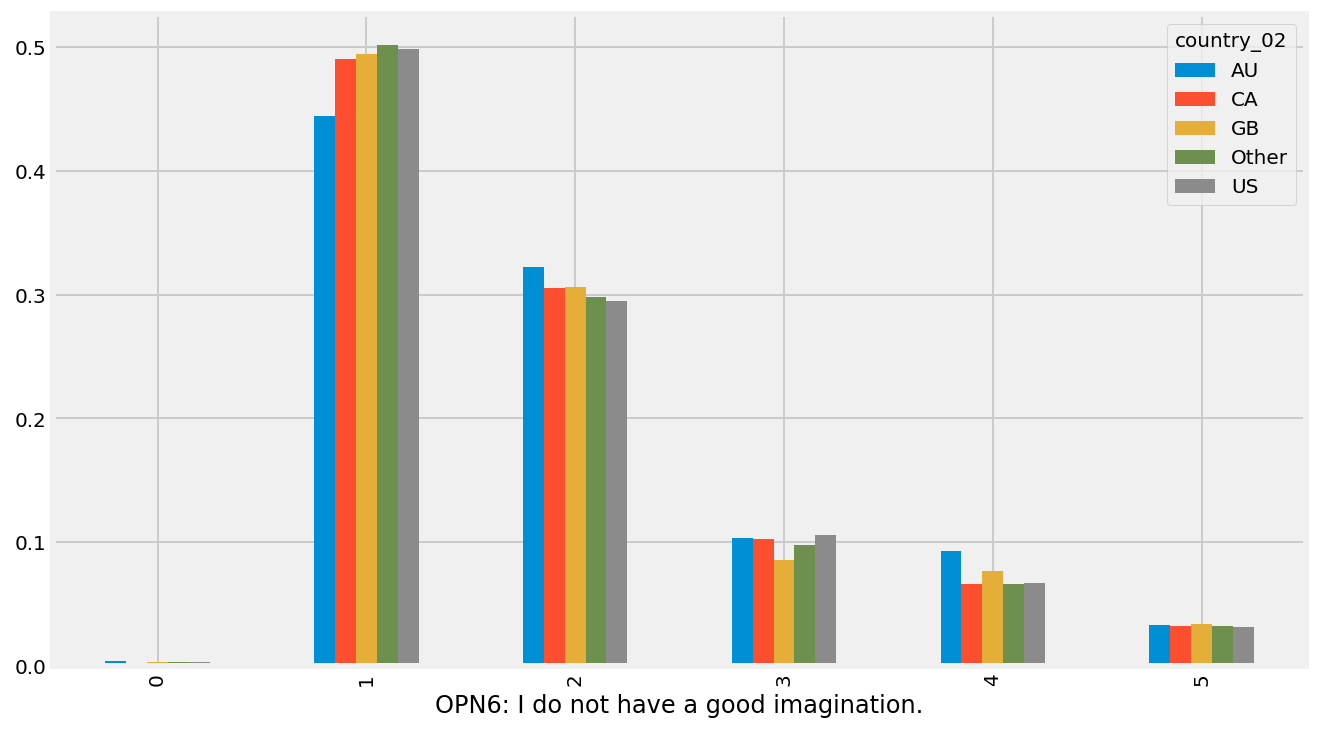

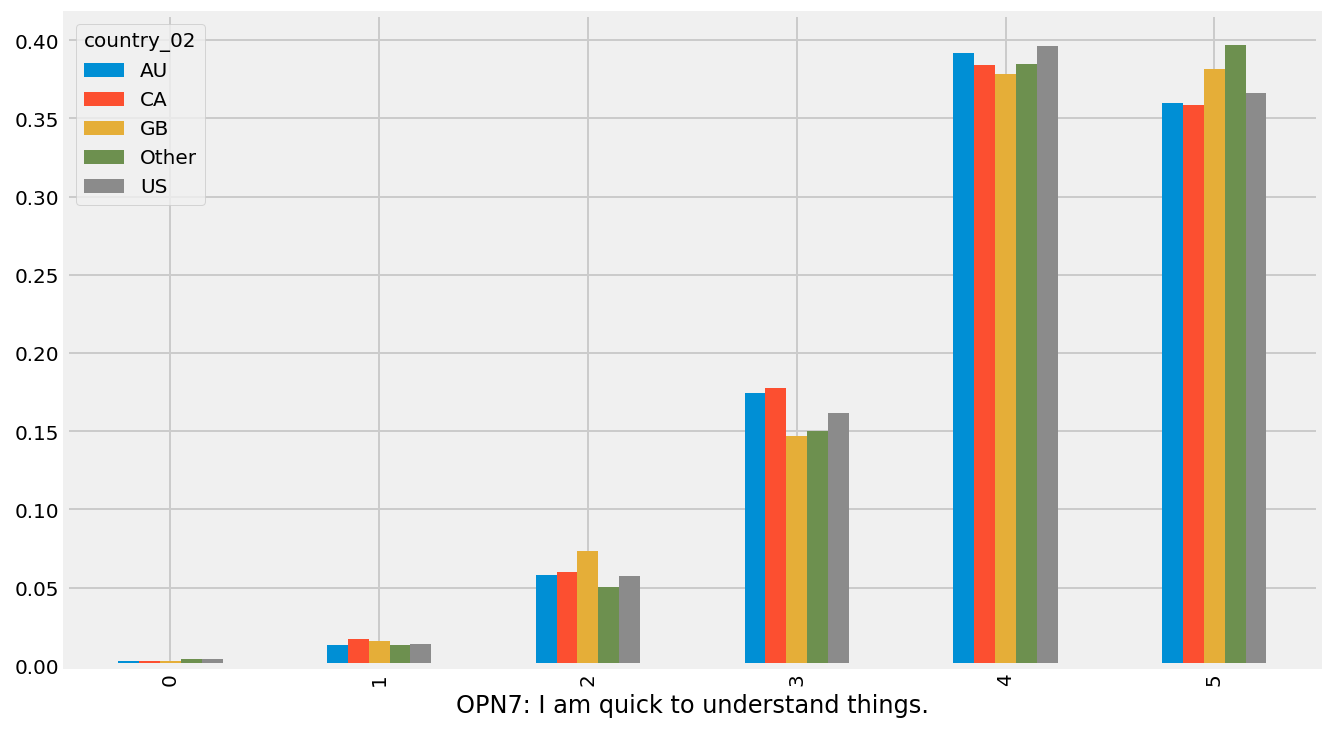

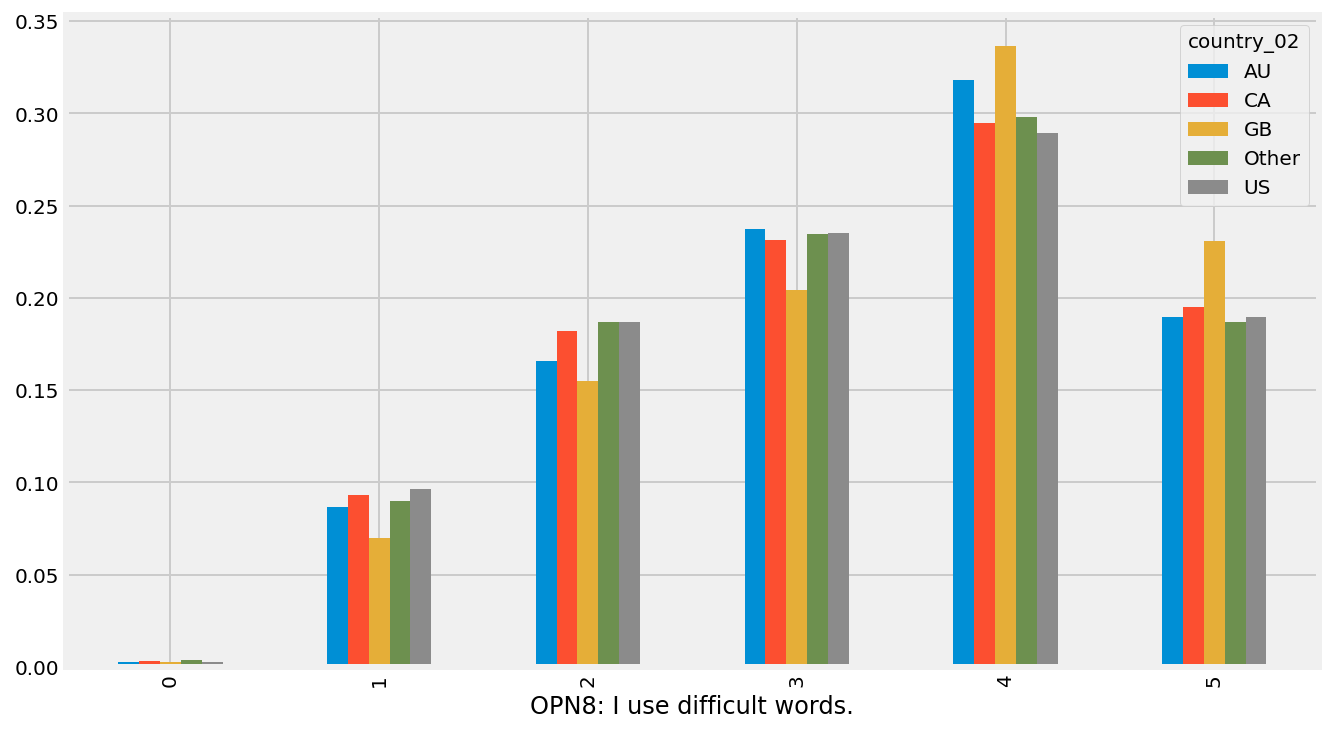

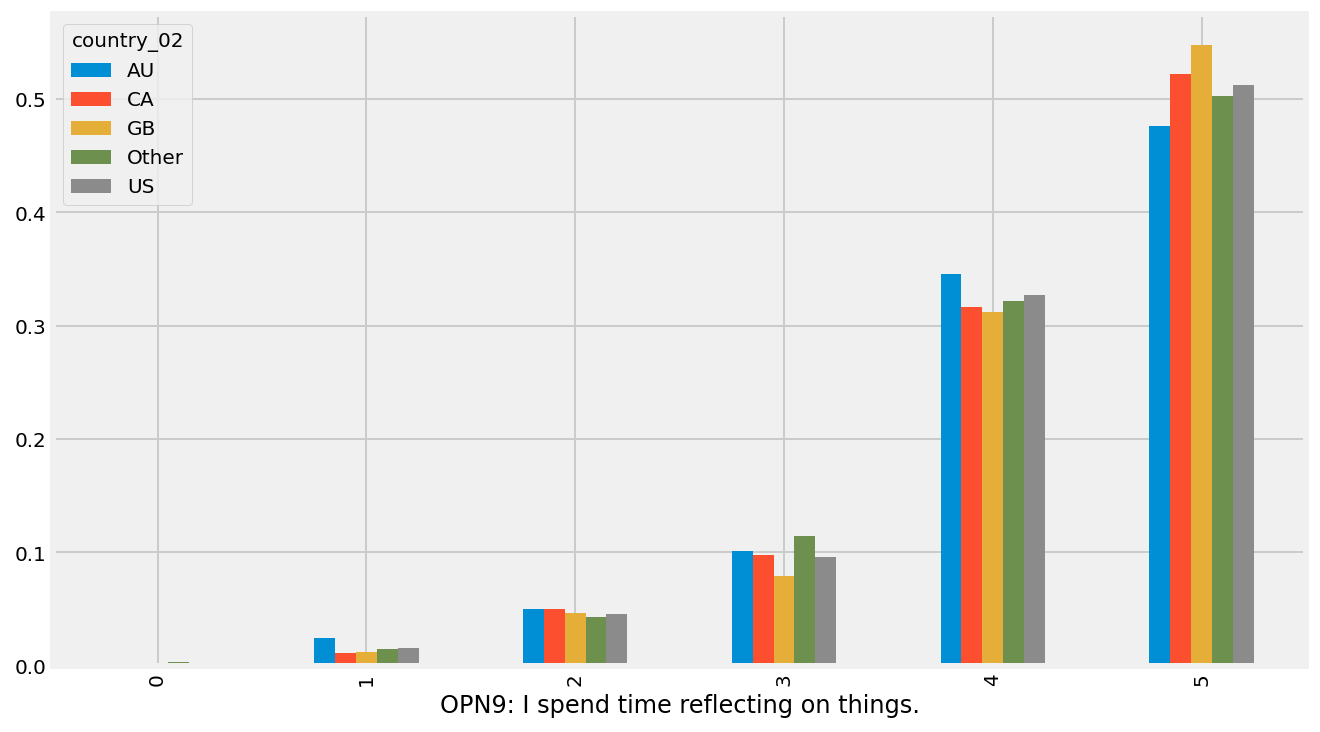

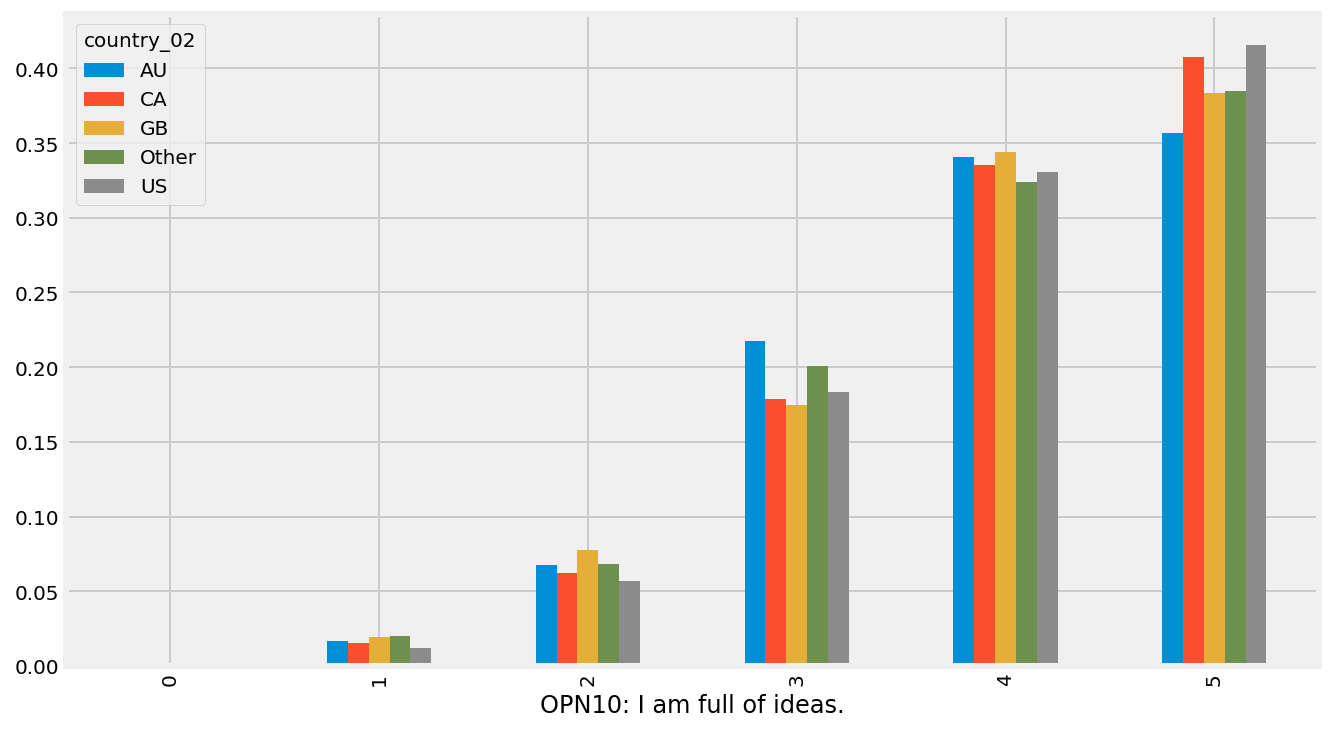

In [258]:
# Create one hist for all questions
#     Group by 'country_02'

# for q in twentysix_qs:
for q in seventysix_qs:
#     print(q_dict.get(q))
    ax = capst02[q].groupby(capst02['country_02']).value_counts(normalize = True).unstack().T.plot(kind = 'bar', figsize=(10,6))
    ax.set_xlabel(q+": "+q_dict.get(q))

In [259]:
# Show stacked histogram for all answers for the 26 questionsabs

#     This cell is for the original code for https://matplotlib.org/stable/gallery/statistics/histogram_multihist.html


# np.random.seed(19680801)

# n_bins = 5
# x = np.random.randn(1000, 3)

# # fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
# fig, ax3 = plt.subplots()

# # colors = ['red', 'tan', 'lime']
# # ax0.hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
# # ax0.legend(prop={'size': 10})
# # ax0.set_title('bars with legend')

# # ax1.hist(x, n_bins, density=True, histtype='bar', stacked=True)
# # ax1.set_title('stacked bar')

# # ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
# # ax2.set_title('stack step (unfilled)')

# # Make a multiple-histogram of data-sets with different length.

# # x_multi = [np.random.randn(n) for n in [capst02[capst02['country_02'] == 'US'][twentysix_qs+['country_02']], capst02[capst02['country_02'] == 'GB'][twentysix_qs+['country_02']], capst02[capst02['country_02'] == 'AU'][twentysix_qs+['country_02']]]]
# x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
# # x_multi = capst02['Q7']


# ax3.hist(x_multi, n_bins, histtype='bar')
# ax3.set_title('different sample sizes')

# fig.tight_layout()
# plt.show()


# No need for the code in this cell, we're solved this problem using:
#     .value_counts(normalize = True).unstack().T.plot(kind = 'bar')

In [260]:
# Show stacked histogram for all answers for the 26 questions

# for x in twentysix_qs:
#     plt.figure()
#     plt.title = str(x)
#     capst02[x].hist(bins = 5, histtype = 'bar')
# #     capst02[x].plot(kind = 'bar')

In [261]:
# Next step:
# Learn 'Using the predict_proba() function of RandomForestClassifier in the safe and right way' 

# https://stackoverflow.com/questions/30814231/using-the-predict-proba-function-of-randomforestclassifier-in-the-safe-and-rig

In [262]:
# !pip install xgboost


# Collecting xgboost
#   Downloading xgboost-1.5.2-py3-none-win_amd64.whl (106.6 MB)
# Requirement already satisfied: scipy in d:\programdata\anaconda3\lib\site-packages (from xgboost) (1.5.2)
# Requirement already satisfied: numpy in d:\programdata\anaconda3\lib\site-packages (from xgboost) (1.22.1)
# Installing collected packages: xgboost
# Successfully installed xgboost-1.5.2

In [263]:
# https://xgboost.readthedocs.io/en/stable/get_started.html

In [264]:
# capst02['country_02']
# capst02['Four_way_Target']

# capst02[twentysix_qs]

In [265]:
# Split and upsample the data preparing for 'xgboost'



xgboost_X_train0, xgboost_X_test, xgboost_y_train0, xgboost_y_test = train_test_split(capst02[twentysix_qs], capst02['Four_way_Target'], test_size=phi_2, random_state=161)

xgboost_X_train = upsampler(xgboost_X_train0,xgboost_y_train0,"X")
xgboost_y_train = upsampler(xgboost_X_train0,xgboost_y_train0,"y")


# display(xgboost_X_train, xgboost_X_test, xgboost_y_train, xgboost_y_test)
# 
# Shapes
#     (24967, 26)
#     (15431, 26)
#     (24967,)
#     (15431,)

In [266]:
# Take a look at teh Feature DataFrame with teh five questions as decided as important by RandomForrestClassifier

capst02[five_qs]

Q1  Q13  Q17  Q16  Q10
0       4    1    1    3    5
1       5    1    3    3    5
3       2    2    1    3    5
4       2    4    1    3    5
5       5    5    1    4    5
...    ..  ...  ...  ...  ...
41836   2    2    2    4    4
41837   2    2    2    2    4
41838   4    1    1    5    5
41839   5    2    1    2    5
41840   3    5    5    4    5

[40398 rows x 5 columns]

In [267]:
# Try another classifier not in the syllabus: XGBClassifier
    # Help from Geoff

# import XGBoost classifier
from xgboost import XGBClassifier

# import cross_val_score for cross-validation
from sklearn.model_selection import cross_val_score

# Try to fit and score using cross_val_score and copy the results as comments




# cross_val_score(XGBClassifier(), xgboost_X_train, xgboost_y_train) # With upsampling - will have duplicates
# array([0.61387745, 0.62311244, 0.62311244, 0.62373643, 0.61245632])
# # Amzing score but WITH upsampling - will have duplicates

# cross_val_score(XGBClassifier(), capst02[twentysix_qs], capst02['Four_way_Target'])
# # array([0.38440594, 0.38180693, 0.39430693, 0.3890333 , 0.3928704 ])

# cross_val_score(XGBClassifier(), capst02[five_qs+country_dummies_capst02], capst02['Four_way_Target'])
# # array([0.39542079, 0.39344059, 0.39393564, 0.39683129, 0.39534596])


# cross_val_score(XGBClassifier(), capst02[five_qs], capst02['Four_way_Target'])
# # array([0.39925743, 0.39319307, 0.39529703, 0.39943062, 0.39967818])


# base_acc(xgboost_y_test)
# # This is the baseline:
# # 0.3971731273825437



In [268]:
# eight_targets

ten_targets
     
# twentysix_qs



['Four_way_Target_Middle_Tercile',
 'Four_way_Target_Oldest_Tercile',
 'Four_way_Target_Only_Child',
 'Four_way_Target_Youngest_Tercile',
 'country_02_AU',
 'country_02_CA',
 'country_02_GB',
 'country_02_Other',
 'country_02_US',
 'country_02',
 'Four_way_Target']

In [269]:
# Build a function for XGBClassifier for easier Grid Searching with for-loops 

def MyXGBClassifier(X,y):
    
    '''
    Fits the XGBClassifier()
    Usestrain_test_split
    Returns  score and subtract from Baseline
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=phi_2, random_state=161)
    
    model = XGBClassifier()
    
    model.fit(X_train,y_train)
    
    score = model.score(X_test,y_test)
        
    baseline = base_acc(y_test)
    
    # columns = ['Target','Avg. Score','Baseline','Improvement']
    
    return [y.name,score,baseline,score-baseline]

In [270]:
# Use this cell to test the above function

MyXGBClassifier(capst02[twentysix_qs], capst02['Four_way_Target_Oldest_Tercile'])



D:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:57:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['Four_way_Target_Oldest_Tercile',
 0.5840839867798587,
 0.6092929816602942,
 -0.025208994880435487]

In [271]:
# Build a DataFrame for all the scores of XG Boost

# This cell containst the for-loop that is the grisearch for XGBClassifier
# Hashed out for speed but kept the code to allow others to replicate
# Saved as a csv for speed


# DF_XGBClass = []

# for targ in ten_targets: # 'country_02', 'Four_way_Target'
#     DF_XGBClass.append(MyXGBClassifier(capst02[twentysix_qs], capst02[targ]))
#     print(MyXGBClassifier(capst02[twentysix_qs], capst02[targ]))

# DF_XGBClass = pd.DataFrame(DF_XGBClass)
# DF_XGBClass.columns = ['Target','Avg. Score','Baseline','Improvement']

# DF_XGBClass.to_csv('data\DF_XGBClass.csv', index = False)



In [294]:
# Loding and sorting the DataFrame from the GridSearch above

DF_XGBClass02 = pd.read_csv('data\DF_XGBClass.csv')
DF_XGBClass02 = DF_XGBClass02.sort_values(by = 'Improvement', ascending = False).reset_index(drop = True)
DF_XGBClass02

Target  Avg. Score  Baseline  Improvement
0                      country_02_US    0.607219  0.519539     0.087681
1                         country_02    0.561208  0.519539     0.041669
2                   country_02_Other    0.707148  0.692697     0.014451
3                    Four_way_Target    0.390901  0.390707     0.000194
4                      country_02_GB    0.936880  0.937528    -0.000648
5                      country_02_AU    0.947508  0.948286    -0.000778
6                      country_02_CA    0.940121  0.941028    -0.000907
7         Four_way_Target_Only_Child    0.878751  0.882704    -0.003953
8     Four_way_Target_Middle_Tercile    0.826000  0.830860    -0.004860
9     Four_way_Target_Oldest_Tercile    0.584084  0.609293    -0.025209
10  Four_way_Target_Youngest_Tercile    0.651934  0.677143    -0.025209

In [273]:
# for targ in ten_targets:
#     print("MyXGBClassifier(capst02[twentysix_qs], capst02['"+str(targ)+"])\n")

In [274]:
# display(
#     xgboost_X_train0.iloc[:,:-1],
#     xgboost_y_train0
#     )

In [275]:
XGBC = XGBClassifier()

# XGBC.fit(xgboost_X_train,xgboost_y_train)
XGBC.fit(xgboost_X_train0.iloc[:,:-1],xgboost_y_train0)


XGBC.score(xgboost_X_test,xgboost_y_test)


# Results: 
    # 0.31579288445337306 # WITH upsampling
    # 0.31579288445337306 # not upsampling
    # 0.3907070183397058 is the baseline accuracy accoridng to code: base_acc(xgboost_y_test)

D:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:57:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.3909014321819714

In [276]:


# # read in data
# # dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
# # dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
# dtest = xgb.DMatrix('demo/data/agaricus.txt.test')

# # specify parameters via map
# param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
# num_round = 2
# bst = xgb.train(param, dtrain, num_round)
# # make prediction

# preds = bst.predict(dtest)

In [277]:
# Idea: Get all 5-combos of twentysix_qs

# 65780 

In [278]:
# Function found when researching xgboost

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    '''
    
    https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    '''
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [279]:
# # Parameters found when researching xgboost
# # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


# # Choose all predictors except target & IDcols


# predictors = [twentysix_qs]
# xgb1 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)
# modelfit(xgb1, xgboost_X_train, predictors)

# # KeyError: "None of [Index([('Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26')], dtype='object')] are in the [columns]"

In [280]:
# This cell is for exporting the DataFrame with all my Feature Engeneering

# capst02.to_csv('data\FBPS-ValidationData_CapstoneColumns.csv', index = False)
# pd.read_csv('data\FBPS-ValidationData_CapstoneColumns.csv')

# Already saved on Wed 9/03/2022